In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV4'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

IQ signals Modulation_Label  \
0       [[-0.0059014712, -0.0023458179, -0.00074506126...             QPSK   
1       [[0.0050326153, 0.00094379985, -0.0018932355, ...             QPSK   
2       [[0.0052390713, 0.0073890695, 0.007276459, 0.0...             QPSK   
3       [[-0.0019859935, -0.0071501383, -0.00527185, -...             QPSK   
4       [[0.006674405, 0.0028359746, 0.005630027, 0.00...             QPSK   
...                                                   ...              ...   
219995  [[0.0062732296, -0.0050519477, 0.006672171, 0....             BPSK   
219996  [[-0.003903181, -0.0015884301, -0.00633375, 2....             BPSK   
219997  [[-0.0105958255, 0.005601244, -0.012161784, 0....             BPSK   
219998  [[-0.002136606, 0.00995837, 0.0059440527, -0.0...             BPSK   
219999  [[-0.008169517, 0.0013303901, -0.002522387, -0...             BPSK   

        SNR  
0         2  
1         2  
2         2  
3         2  
4         2  
...     ...  
219995  -18  
219996  -18  
219997  -18  
219998  -18  
219999  -18  

[220000 rows x 3 columns]

# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

THETA = math.pi/2
STANDARD_DEVIATION = 0.0005

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_flip_add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(1485000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v4(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64, 16)         64        
_________________________________________________________________
dense (Dense)                (None, 1, 64, 256)        4352  

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


   1/1306 [..............................] - ETA: 5:44:03 - loss: 3.0364

   4/1306 [..............................] - ETA: 31s - loss: 2.9153    

   7/1306 [..............................] - ETA: 31s - loss: 2.8476

  10/1306 [..............................] - ETA: 31s - loss: 2.7929

  13/1306 [..............................] - ETA: 31s - loss: 2.7463

  16/1306 [..............................] - ETA: 31s - loss: 2.7047

  18/1306 [..............................] - ETA: 31s - loss: 2.6790



  21/1306 [..............................] - ETA: 31s - loss: 2.6431

  24/1306 [..............................] - ETA: 31s - loss: 2.6102

  27/1306 [..............................] - ETA: 31s - loss: 2.5797

  30/1306 [..............................] - ETA: 31s - loss: 2.5511

  33/1306 [..............................] - ETA: 30s - loss: 2.5242

  36/1306 [..............................] - ETA: 30s - loss: 2.4991

  39/1306 [..............................] - ETA: 30s - loss: 2.4754

  42/1306 [..............................] - ETA: 30s - loss: 2.4530

  45/1306 [>.............................] - ETA: 30s - loss: 2.4317

  48/1306 [>.............................] - ETA: 30s - loss: 2.4116

  51/1306 [>.............................] - ETA: 30s - loss: 2.3924

  54/1306 [>.............................] - ETA: 30s - loss: 2.3743

  57/1306 [>.............................] - ETA: 30s - loss: 2.3570

  60/1306 [>.............................] - ETA: 30s - loss: 2.3405

  63/1306 [>.............................] - ETA: 30s - loss: 2.3247

  66/1306 [>.............................] - ETA: 30s - loss: 2.3097

  69/1306 [>.............................] - ETA: 29s - loss: 2.2952

  72/1306 [>.............................] - ETA: 29s - loss: 2.2814

  75/1306 [>.............................] - ETA: 29s - loss: 2.2681

  78/1306 [>.............................] - ETA: 29s - loss: 2.2553

  81/1306 [>.............................] - ETA: 29s - loss: 2.2429

  84/1306 [>.............................] - ETA: 29s - loss: 2.2309

  87/1306 [>.............................] - ETA: 29s - loss: 2.2194

  90/1306 [=>............................] - ETA: 29s - loss: 2.2082

  93/1306 [=>............................] - ETA: 29s - loss: 2.1975

  96/1306 [=>............................] - ETA: 29s - loss: 2.1870

  99/1306 [=>............................] - ETA: 29s - loss: 2.1769

 101/1306 [=>............................] - ETA: 29s - loss: 2.1703

 104/1306 [=>............................] - ETA: 29s - loss: 2.1606

 107/1306 [=>............................] - ETA: 29s - loss: 2.1513

 110/1306 [=>............................] - ETA: 28s - loss: 2.1421

 113/1306 [=>............................] - ETA: 28s - loss: 2.1332

 116/1306 [=>............................] - ETA: 28s - loss: 2.1246

 119/1306 [=>............................] - ETA: 28s - loss: 2.1162

 122/1306 [=>............................] - ETA: 28s - loss: 2.1080

 125/1306 [=>............................] - ETA: 28s - loss: 2.1000

 128/1306 [=>............................] - ETA: 28s - loss: 2.0922

 131/1306 [==>...........................] - ETA: 28s - loss: 2.0846

 134/1306 [==>...........................] - ETA: 28s - loss: 2.0772

 137/1306 [==>...........................] - ETA: 28s - loss: 2.0700

 140/1306 [==>...........................] - ETA: 28s - loss: 2.0629

 142/1306 [==>...........................] - ETA: 28s - loss: 2.0583

 145/1306 [==>...........................] - ETA: 28s - loss: 2.0515

 148/1306 [==>...........................] - ETA: 28s - loss: 2.0448

 151/1306 [==>...........................] - ETA: 27s - loss: 2.0383

 154/1306 [==>...........................] - ETA: 27s - loss: 2.0320

 157/1306 [==>...........................] - ETA: 27s - loss: 2.0258

 160/1306 [==>...........................] - ETA: 27s - loss: 2.0197

 163/1306 [==>...........................] - ETA: 27s - loss: 2.0137

 166/1306 [==>...........................] - ETA: 27s - loss: 2.0079

 169/1306 [==>...........................] - ETA: 27s - loss: 2.0022

 172/1306 [==>...........................] - ETA: 27s - loss: 1.9966

 175/1306 [===>..........................] - ETA: 27s - loss: 1.9911

 178/1306 [===>..........................] - ETA: 27s - loss: 1.9857

 181/1306 [===>..........................] - ETA: 27s - loss: 1.9804

 184/1306 [===>..........................] - ETA: 27s - loss: 1.9752

 187/1306 [===>..........................] - ETA: 27s - loss: 1.9702

 190/1306 [===>..........................] - ETA: 26s - loss: 1.9652

 193/1306 [===>..........................] - ETA: 26s - loss: 1.9603

 196/1306 [===>..........................] - ETA: 26s - loss: 1.9555

 199/1306 [===>..........................] - ETA: 26s - loss: 1.9508

 202/1306 [===>..........................] - ETA: 26s - loss: 1.9462

 205/1306 [===>..........................] - ETA: 26s - loss: 1.9416

 208/1306 [===>..........................] - ETA: 26s - loss: 1.9372

 211/1306 [===>..........................] - ETA: 26s - loss: 1.9328

 214/1306 [===>..........................] - ETA: 26s - loss: 1.9285

 217/1306 [===>..........................] - ETA: 26s - loss: 1.9242

 220/1306 [====>.........................] - ETA: 26s - loss: 1.9201

 223/1306 [====>.........................] - ETA: 26s - loss: 1.9160

 226/1306 [====>.........................] - ETA: 26s - loss: 1.9119

 229/1306 [====>.........................] - ETA: 26s - loss: 1.9080

 232/1306 [====>.........................] - ETA: 25s - loss: 1.9040

 235/1306 [====>.........................] - ETA: 25s - loss: 1.9002

 238/1306 [====>.........................] - ETA: 25s - loss: 1.8964

 241/1306 [====>.........................] - ETA: 25s - loss: 1.8927

 244/1306 [====>.........................] - ETA: 25s - loss: 1.8890

 247/1306 [====>.........................] - ETA: 25s - loss: 1.8854

 250/1306 [====>.........................] - ETA: 25s - loss: 1.8819

 253/1306 [====>.........................] - ETA: 25s - loss: 1.8784

 256/1306 [====>.........................] - ETA: 25s - loss: 1.8750

 259/1306 [====>.........................] - ETA: 25s - loss: 1.8716

 262/1306 [=====>........................] - ETA: 25s - loss: 1.8683

 265/1306 [=====>........................] - ETA: 25s - loss: 1.8650

 268/1306 [=====>........................] - ETA: 25s - loss: 1.8617

 271/1306 [=====>........................] - ETA: 24s - loss: 1.8585

 274/1306 [=====>........................] - ETA: 24s - loss: 1.8554

 277/1306 [=====>........................] - ETA: 24s - loss: 1.8523

 280/1306 [=====>........................] - ETA: 24s - loss: 1.8492

 283/1306 [=====>........................] - ETA: 24s - loss: 1.8462

 286/1306 [=====>........................] - ETA: 24s - loss: 1.8432

 289/1306 [=====>........................] - ETA: 24s - loss: 1.8402

 292/1306 [=====>........................] - ETA: 24s - loss: 1.8373

 295/1306 [=====>........................] - ETA: 24s - loss: 1.8345

 298/1306 [=====>........................] - ETA: 24s - loss: 1.8316

 301/1306 [=====>........................] - ETA: 24s - loss: 1.8289

 304/1306 [=====>........................] - ETA: 24s - loss: 1.8261

 307/1306 [======>.......................] - ETA: 24s - loss: 1.8234

 309/1306 [======>.......................] - ETA: 24s - loss: 1.8216

 312/1306 [======>.......................] - ETA: 23s - loss: 1.8189

 315/1306 [======>.......................] - ETA: 23s - loss: 1.8163

 318/1306 [======>.......................] - ETA: 23s - loss: 1.8136

 321/1306 [======>.......................] - ETA: 23s - loss: 1.8111

 324/1306 [======>.......................] - ETA: 23s - loss: 1.8085

 327/1306 [======>.......................] - ETA: 23s - loss: 1.8060

 330/1306 [======>.......................] - ETA: 23s - loss: 1.8035

 333/1306 [======>.......................] - ETA: 23s - loss: 1.8010

 336/1306 [======>.......................] - ETA: 23s - loss: 1.7986

 339/1306 [======>.......................] - ETA: 23s - loss: 1.7962

 342/1306 [======>.......................] - ETA: 23s - loss: 1.7938

 345/1306 [======>.......................] - ETA: 23s - loss: 1.7915

 348/1306 [======>.......................] - ETA: 23s - loss: 1.7891

 350/1306 [=======>......................] - ETA: 23s - loss: 1.7876

 353/1306 [=======>......................] - ETA: 23s - loss: 1.7853

 356/1306 [=======>......................] - ETA: 22s - loss: 1.7831

 359/1306 [=======>......................] - ETA: 22s - loss: 1.7808

 362/1306 [=======>......................] - ETA: 22s - loss: 1.7786

 365/1306 [=======>......................] - ETA: 22s - loss: 1.7765

 368/1306 [=======>......................] - ETA: 22s - loss: 1.7743

 371/1306 [=======>......................] - ETA: 22s - loss: 1.7722

 374/1306 [=======>......................] - ETA: 22s - loss: 1.7701

 377/1306 [=======>......................] - ETA: 22s - loss: 1.7680

 380/1306 [=======>......................] - ETA: 22s - loss: 1.7659

 383/1306 [=======>......................] - ETA: 22s - loss: 1.7639

 386/1306 [=======>......................] - ETA: 22s - loss: 1.7618

 389/1306 [=======>......................] - ETA: 22s - loss: 1.7598

 392/1306 [========>.....................] - ETA: 22s - loss: 1.7578

 395/1306 [========>.....................] - ETA: 21s - loss: 1.7559

 398/1306 [========>.....................] - ETA: 21s - loss: 1.7539

 401/1306 [========>.....................] - ETA: 21s - loss: 1.7520

 404/1306 [========>.....................] - ETA: 21s - loss: 1.7501

 407/1306 [========>.....................] - ETA: 21s - loss: 1.7482

 410/1306 [========>.....................] - ETA: 21s - loss: 1.7463

 413/1306 [========>.....................] - ETA: 21s - loss: 1.7445

 416/1306 [========>.....................] - ETA: 21s - loss: 1.7426

 419/1306 [========>.....................] - ETA: 21s - loss: 1.7408

 422/1306 [========>.....................] - ETA: 21s - loss: 1.7390

 425/1306 [========>.....................] - ETA: 21s - loss: 1.7372

 428/1306 [========>.....................] - ETA: 21s - loss: 1.7355

 431/1306 [========>.....................] - ETA: 21s - loss: 1.7337

 434/1306 [========>.....................] - ETA: 21s - loss: 1.7320

 437/1306 [=========>....................] - ETA: 20s - loss: 1.7302

 440/1306 [=========>....................] - ETA: 20s - loss: 1.7285

 443/1306 [=========>....................] - ETA: 20s - loss: 1.7268

 446/1306 [=========>....................] - ETA: 20s - loss: 1.7252

 449/1306 [=========>....................] - ETA: 20s - loss: 1.7235

 452/1306 [=========>....................] - ETA: 20s - loss: 1.7218

 455/1306 [=========>....................] - ETA: 20s - loss: 1.7202

 458/1306 [=========>....................] - ETA: 20s - loss: 1.7186

 461/1306 [=========>....................] - ETA: 20s - loss: 1.7170

 464/1306 [=========>....................] - ETA: 20s - loss: 1.7154

 467/1306 [=========>....................] - ETA: 20s - loss: 1.7138

 470/1306 [=========>....................] - ETA: 20s - loss: 1.7122

 473/1306 [=========>....................] - ETA: 20s - loss: 1.7107

 475/1306 [=========>....................] - ETA: 20s - loss: 1.7097

 478/1306 [=========>....................] - ETA: 19s - loss: 1.7081

 481/1306 [==========>...................] - ETA: 19s - loss: 1.7066

 484/1306 [==========>...................] - ETA: 19s - loss: 1.7051

 487/1306 [==========>...................] - ETA: 19s - loss: 1.7036

 490/1306 [==========>...................] - ETA: 19s - loss: 1.7021

 493/1306 [==========>...................] - ETA: 19s - loss: 1.7006

 496/1306 [==========>...................] - ETA: 19s - loss: 1.6992

 499/1306 [==========>...................] - ETA: 19s - loss: 1.6977

 502/1306 [==========>...................] - ETA: 19s - loss: 1.6963

 505/1306 [==========>...................] - ETA: 19s - loss: 1.6949

 508/1306 [==========>...................] - ETA: 19s - loss: 1.6934

 511/1306 [==========>...................] - ETA: 19s - loss: 1.6920

 513/1306 [==========>...................] - ETA: 19s - loss: 1.6911

 516/1306 [==========>...................] - ETA: 19s - loss: 1.6897

 519/1306 [==========>...................] - ETA: 19s - loss: 1.6883

 522/1306 [==========>...................] - ETA: 18s - loss: 1.6870

 525/1306 [===========>..................] - ETA: 18s - loss: 1.6856

 528/1306 [===========>..................] - ETA: 18s - loss: 1.6843

 531/1306 [===========>..................] - ETA: 18s - loss: 1.6829

 534/1306 [===========>..................] - ETA: 18s - loss: 1.6816

 537/1306 [===========>..................] - ETA: 18s - loss: 1.6803

 540/1306 [===========>..................] - ETA: 18s - loss: 1.6790

 543/1306 [===========>..................] - ETA: 18s - loss: 1.6777

 546/1306 [===========>..................] - ETA: 18s - loss: 1.6764

 549/1306 [===========>..................] - ETA: 18s - loss: 1.6751

 552/1306 [===========>..................] - ETA: 18s - loss: 1.6739

 555/1306 [===========>..................] - ETA: 18s - loss: 1.6726

 557/1306 [===========>..................] - ETA: 18s - loss: 1.6718

 560/1306 [===========>..................] - ETA: 18s - loss: 1.6705

 563/1306 [===========>..................] - ETA: 17s - loss: 1.6693

 566/1306 [============>.................] - ETA: 17s - loss: 1.6681



 569/1306 [============>.................] - ETA: 17s - loss: 1.6668

 572/1306 [============>.................] - ETA: 17s - loss: 1.6656

 575/1306 [============>.................] - ETA: 17s - loss: 1.6644

 578/1306 [============>.................] - ETA: 17s - loss: 1.6632

 581/1306 [============>.................] - ETA: 17s - loss: 1.6620

 583/1306 [============>.................] - ETA: 17s - loss: 1.6613

 586/1306 [============>.................] - ETA: 17s - loss: 1.6601

 589/1306 [============>.................] - ETA: 17s - loss: 1.6589

 592/1306 [============>.................] - ETA: 17s - loss: 1.6578

 595/1306 [============>.................] - ETA: 17s - loss: 1.6566

 598/1306 [============>.................] - ETA: 17s - loss: 1.6555

 600/1306 [============>.................] - ETA: 17s - loss: 1.6547

 603/1306 [============>.................] - ETA: 16s - loss: 1.6536

 606/1306 [============>.................] - ETA: 16s - loss: 1.6525

 609/1306 [============>.................] - ETA: 16s - loss: 1.6513

 612/1306 [=============>................] - ETA: 16s - loss: 1.6502

 615/1306 [=============>................] - ETA: 16s - loss: 1.6491

 618/1306 [=============>................] - ETA: 16s - loss: 1.6481

 621/1306 [=============>................] - ETA: 16s - loss: 1.6470

 624/1306 [=============>................] - ETA: 16s - loss: 1.6459

 626/1306 [=============>................] - ETA: 16s - loss: 1.6452

 629/1306 [=============>................] - ETA: 16s - loss: 1.6441

 632/1306 [=============>................] - ETA: 16s - loss: 1.6430

 635/1306 [=============>................] - ETA: 16s - loss: 1.6420

 638/1306 [=============>................] - ETA: 16s - loss: 1.6409

 641/1306 [=============>................] - ETA: 16s - loss: 1.6399

 644/1306 [=============>................] - ETA: 15s - loss: 1.6389

 647/1306 [=============>................] - ETA: 15s - loss: 1.6378

 650/1306 [=============>................] - ETA: 15s - loss: 1.6368

 653/1306 [==============>...............] - ETA: 15s - loss: 1.6358

 656/1306 [==============>...............] - ETA: 15s - loss: 1.6348

 659/1306 [==============>...............] - ETA: 15s - loss: 1.6338

 662/1306 [==============>...............] - ETA: 15s - loss: 1.6328

 665/1306 [==============>...............] - ETA: 15s - loss: 1.6318

 668/1306 [==============>...............] - ETA: 15s - loss: 1.6308

 671/1306 [==============>...............] - ETA: 15s - loss: 1.6299

 674/1306 [==============>...............] - ETA: 15s - loss: 1.6289

 677/1306 [==============>...............] - ETA: 15s - loss: 1.6279

 680/1306 [==============>...............] - ETA: 15s - loss: 1.6270

 682/1306 [==============>...............] - ETA: 15s - loss: 1.6263

 684/1306 [==============>...............] - ETA: 15s - loss: 1.6257

 687/1306 [==============>...............] - ETA: 14s - loss: 1.6247

 690/1306 [==============>...............] - ETA: 14s - loss: 1.6238

 693/1306 [==============>...............] - ETA: 14s - loss: 1.6228

 696/1306 [==============>...............] - ETA: 14s - loss: 1.6219

 699/1306 [===============>..............] - ETA: 14s - loss: 1.6210

 702/1306 [===============>..............] - ETA: 14s - loss: 1.6201

 705/1306 [===============>..............] - ETA: 14s - loss: 1.6192

 708/1306 [===============>..............] - ETA: 14s - loss: 1.6182

 711/1306 [===============>..............] - ETA: 14s - loss: 1.6173

 714/1306 [===============>..............] - ETA: 14s - loss: 1.6164

 717/1306 [===============>..............] - ETA: 14s - loss: 1.6156

 720/1306 [===============>..............] - ETA: 14s - loss: 1.6147

 723/1306 [===============>..............] - ETA: 14s - loss: 1.6138

 726/1306 [===============>..............] - ETA: 14s - loss: 1.6129

 729/1306 [===============>..............] - ETA: 13s - loss: 1.6120

 732/1306 [===============>..............] - ETA: 13s - loss: 1.6112

 735/1306 [===============>..............] - ETA: 13s - loss: 1.6103

 738/1306 [===============>..............] - ETA: 13s - loss: 1.6094

 741/1306 [================>.............] - ETA: 13s - loss: 1.6086

 744/1306 [================>.............] - ETA: 13s - loss: 1.6077

 747/1306 [================>.............] - ETA: 13s - loss: 1.6069

 750/1306 [================>.............] - ETA: 13s - loss: 1.6060

 753/1306 [================>.............] - ETA: 13s - loss: 1.6052

 756/1306 [================>.............] - ETA: 13s - loss: 1.6044

 759/1306 [================>.............] - ETA: 13s - loss: 1.6036

 762/1306 [================>.............] - ETA: 13s - loss: 1.6027

 764/1306 [================>.............] - ETA: 13s - loss: 1.6022

 767/1306 [================>.............] - ETA: 13s - loss: 1.6014

 769/1306 [================>.............] - ETA: 12s - loss: 1.6008

 772/1306 [================>.............] - ETA: 12s - loss: 1.6000

 775/1306 [================>.............] - ETA: 12s - loss: 1.5992

 778/1306 [================>.............] - ETA: 12s - loss: 1.5984

 781/1306 [================>.............] - ETA: 12s - loss: 1.5976

 784/1306 [=================>............] - ETA: 12s - loss: 1.5968

 787/1306 [=================>............] - ETA: 12s - loss: 1.5960

 790/1306 [=================>............] - ETA: 12s - loss: 1.5953

 793/1306 [=================>............] - ETA: 12s - loss: 1.5945

 796/1306 [=================>............] - ETA: 12s - loss: 1.5937

 799/1306 [=================>............] - ETA: 12s - loss: 1.5929

 802/1306 [=================>............] - ETA: 12s - loss: 1.5922

 805/1306 [=================>............] - ETA: 12s - loss: 1.5914

 808/1306 [=================>............] - ETA: 12s - loss: 1.5907

 811/1306 [=================>............] - ETA: 11s - loss: 1.5899

 814/1306 [=================>............] - ETA: 11s - loss: 1.5891

 817/1306 [=================>............] - ETA: 11s - loss: 1.5884

 820/1306 [=================>............] - ETA: 11s - loss: 1.5877

 823/1306 [=================>............] - ETA: 11s - loss: 1.5869

 826/1306 [=================>............] - ETA: 11s - loss: 1.5862

 829/1306 [==================>...........] - ETA: 11s - loss: 1.5854

 832/1306 [==================>...........] - ETA: 11s - loss: 1.5847

 835/1306 [==================>...........] - ETA: 11s - loss: 1.5840

 838/1306 [==================>...........] - ETA: 11s - loss: 1.5833

 841/1306 [==================>...........] - ETA: 11s - loss: 1.5826

 844/1306 [==================>...........] - ETA: 11s - loss: 1.5818

 847/1306 [==================>...........] - ETA: 11s - loss: 1.5811

 849/1306 [==================>...........] - ETA: 11s - loss: 1.5807

 852/1306 [==================>...........] - ETA: 10s - loss: 1.5799



 855/1306 [==================>...........] - ETA: 10s - loss: 1.5792

 858/1306 [==================>...........] - ETA: 10s - loss: 1.5785

 861/1306 [==================>...........] - ETA: 10s - loss: 1.5779

 864/1306 [==================>...........] - ETA: 10s - loss: 1.5772

 867/1306 [==================>...........] - ETA: 10s - loss: 1.5765

 870/1306 [==================>...........] - ETA: 10s - loss: 1.5758

 873/1306 [===================>..........] - ETA: 10s - loss: 1.5751

 876/1306 [===================>..........] - ETA: 10s - loss: 1.5744

 879/1306 [===================>..........] - ETA: 10s - loss: 1.5737

 882/1306 [===================>..........] - ETA: 10s - loss: 1.5731

 885/1306 [===================>..........] - ETA: 10s - loss: 1.5724

 888/1306 [===================>..........] - ETA: 10s - loss: 1.5717

 891/1306 [===================>..........] - ETA: 10s - loss: 1.5711

 894/1306 [===================>..........] - ETA: 9s - loss: 1.5704 

 897/1306 [===================>..........] - ETA: 9s - loss: 1.5698

 900/1306 [===================>..........] - ETA: 9s - loss: 1.5691

 903/1306 [===================>..........] - ETA: 9s - loss: 1.5685

 906/1306 [===================>..........] - ETA: 9s - loss: 1.5678

 909/1306 [===================>..........] - ETA: 9s - loss: 1.5672

 912/1306 [===================>..........] - ETA: 9s - loss: 1.5665

 915/1306 [====================>.........] - ETA: 9s - loss: 1.5659

 918/1306 [====================>.........] - ETA: 9s - loss: 1.5652

 921/1306 [====================>.........] - ETA: 9s - loss: 1.5646

 924/1306 [====================>.........] - ETA: 9s - loss: 1.5640

 927/1306 [====================>.........] - ETA: 9s - loss: 1.5633

 930/1306 [====================>.........] - ETA: 9s - loss: 1.5627

 933/1306 [====================>.........] - ETA: 9s - loss: 1.5621

 936/1306 [====================>.........] - ETA: 8s - loss: 1.5615

 939/1306 [====================>.........] - ETA: 8s - loss: 1.5609

 942/1306 [====================>.........] - ETA: 8s - loss: 1.5602

 945/1306 [====================>.........] - ETA: 8s - loss: 1.5596

 948/1306 [====================>.........] - ETA: 8s - loss: 1.5590

 951/1306 [====================>.........] - ETA: 8s - loss: 1.5584

 954/1306 [====================>.........] - ETA: 8s - loss: 1.5578

 957/1306 [====================>.........] - ETA: 8s - loss: 1.5572

 960/1306 [=====================>........] - ETA: 8s - loss: 1.5566

 963/1306 [=====================>........] - ETA: 8s - loss: 1.5560

 966/1306 [=====================>........] - ETA: 8s - loss: 1.5554

 969/1306 [=====================>........] - ETA: 8s - loss: 1.5548

 971/1306 [=====================>........] - ETA: 8s - loss: 1.5544

 974/1306 [=====================>........] - ETA: 8s - loss: 1.5538

 977/1306 [=====================>........] - ETA: 7s - loss: 1.5533

 980/1306 [=====================>........] - ETA: 7s - loss: 1.5527

 983/1306 [=====================>........] - ETA: 7s - loss: 1.5521

 986/1306 [=====================>........] - ETA: 7s - loss: 1.5515

 989/1306 [=====================>........] - ETA: 7s - loss: 1.5509

 992/1306 [=====================>........] - ETA: 7s - loss: 1.5504

 995/1306 [=====================>........] - ETA: 7s - loss: 1.5498

 998/1306 [=====================>........] - ETA: 7s - loss: 1.5492

1001/1306 [=====================>........] - ETA: 7s - loss: 1.5487

1004/1306 [======================>.......] - ETA: 7s - loss: 1.5481

1007/1306 [======================>.......] - ETA: 7s - loss: 1.5475

1010/1306 [======================>.......] - ETA: 7s - loss: 1.5470

1012/1306 [======================>.......] - ETA: 7s - loss: 1.5466

1014/1306 [======================>.......] - ETA: 7s - loss: 1.5462

1017/1306 [======================>.......] - ETA: 6s - loss: 1.5457

1020/1306 [======================>.......] - ETA: 6s - loss: 1.5451

1023/1306 [======================>.......] - ETA: 6s - loss: 1.5446

1026/1306 [======================>.......] - ETA: 6s - loss: 1.5440

1029/1306 [======================>.......] - ETA: 6s - loss: 1.5435

1032/1306 [======================>.......] - ETA: 6s - loss: 1.5429

1035/1306 [======================>.......] - ETA: 6s - loss: 1.5424

1038/1306 [======================>.......] - ETA: 6s - loss: 1.5419

1041/1306 [======================>.......] - ETA: 6s - loss: 1.5413

1044/1306 [======================>.......] - ETA: 6s - loss: 1.5408

1047/1306 [=======================>......] - ETA: 6s - loss: 1.5403

1050/1306 [=======================>......] - ETA: 6s - loss: 1.5397

1053/1306 [=======================>......] - ETA: 6s - loss: 1.5392

1056/1306 [=======================>......] - ETA: 6s - loss: 1.5387

1059/1306 [=======================>......] - ETA: 5s - loss: 1.5382

1062/1306 [=======================>......] - ETA: 5s - loss: 1.5376

1065/1306 [=======================>......] - ETA: 5s - loss: 1.5371

1067/1306 [=======================>......] - ETA: 5s - loss: 1.5368

1070/1306 [=======================>......] - ETA: 5s - loss: 1.5363

1073/1306 [=======================>......] - ETA: 5s - loss: 1.5357

1076/1306 [=======================>......] - ETA: 5s - loss: 1.5352

1079/1306 [=======================>......] - ETA: 5s - loss: 1.5347

1082/1306 [=======================>......] - ETA: 5s - loss: 1.5342

1085/1306 [=======================>......] - ETA: 5s - loss: 1.5337

1088/1306 [=======================>......] - ETA: 5s - loss: 1.5332

1091/1306 [========================>.....] - ETA: 5s - loss: 1.5327

1094/1306 [========================>.....] - ETA: 5s - loss: 1.5322

1096/1306 [========================>.....] - ETA: 5s - loss: 1.5319

1099/1306 [========================>.....] - ETA: 5s - loss: 1.5314

1102/1306 [========================>.....] - ETA: 4s - loss: 1.5309

1105/1306 [========================>.....] - ETA: 4s - loss: 1.5304

1108/1306 [========================>.....] - ETA: 4s - loss: 1.5299

1111/1306 [========================>.....] - ETA: 4s - loss: 1.5294

1114/1306 [========================>.....] - ETA: 4s - loss: 1.5289

1117/1306 [========================>.....] - ETA: 4s - loss: 1.5284

1120/1306 [========================>.....] - ETA: 4s - loss: 1.5280

1123/1306 [========================>.....] - ETA: 4s - loss: 1.5275

1126/1306 [========================>.....] - ETA: 4s - loss: 1.5270

1129/1306 [========================>.....] - ETA: 4s - loss: 1.5265

1132/1306 [=========================>....] - ETA: 4s - loss: 1.5260

1135/1306 [=========================>....] - ETA: 4s - loss: 1.5256

1137/1306 [=========================>....] - ETA: 4s - loss: 1.5253

1140/1306 [=========================>....] - ETA: 4s - loss: 1.5248

1143/1306 [=========================>....] - ETA: 3s - loss: 1.5243

1146/1306 [=========================>....] - ETA: 3s - loss: 1.5238

1149/1306 [=========================>....] - ETA: 3s - loss: 1.5234

1152/1306 [=========================>....] - ETA: 3s - loss: 1.5229

1155/1306 [=========================>....] - ETA: 3s - loss: 1.5225



1157/1306 [=========================>....] - ETA: 3s - loss: 1.5221



1160/1306 [=========================>....] - ETA: 3s - loss: 1.5217



1163/1306 [=========================>....] - ETA: 3s - loss: 1.5212

1166/1306 [=========================>....] - ETA: 3s - loss: 1.5208



1169/1306 [=========================>....] - ETA: 3s - loss: 1.5203

1172/1306 [=========================>....] - ETA: 3s - loss: 1.5199

1175/1306 [=========================>....] - ETA: 3s - loss: 1.5194



1178/1306 [==========================>...] - ETA: 3s - loss: 1.5190



1181/1306 [==========================>...] - ETA: 3s - loss: 1.5185

1184/1306 [==========================>...] - ETA: 2s - loss: 1.5181



1186/1306 [==========================>...] - ETA: 2s - loss: 1.5178



1189/1306 [==========================>...] - ETA: 2s - loss: 1.5173

1192/1306 [==========================>...] - ETA: 2s - loss: 1.5169

1195/1306 [==========================>...] - ETA: 2s - loss: 1.5164



1198/1306 [==========================>...] - ETA: 2s - loss: 1.5160



1201/1306 [==========================>...] - ETA: 2s - loss: 1.5156

1204/1306 [==========================>...] - ETA: 2s - loss: 1.5151



1207/1306 [==========================>...] - ETA: 2s - loss: 1.5147

1210/1306 [==========================>...] - ETA: 2s - loss: 1.5143

1213/1306 [==========================>...] - ETA: 2s - loss: 1.5138



1216/1306 [==========================>...] - ETA: 2s - loss: 1.5134

1219/1306 [===========================>..] - ETA: 2s - loss: 1.5130

1222/1306 [===========================>..] - ETA: 2s - loss: 1.5125



1225/1306 [===========================>..] - ETA: 1s - loss: 1.5121

1228/1306 [===========================>..] - ETA: 1s - loss: 1.5117



1231/1306 [===========================>..] - ETA: 1s - loss: 1.5113

1234/1306 [===========================>..] - ETA: 1s - loss: 1.5108

1237/1306 [===========================>..] - ETA: 1s - loss: 1.5104

1240/1306 [===========================>..] - ETA: 1s - loss: 1.5100

1243/1306 [===========================>..] - ETA: 1s - loss: 1.5096

1246/1306 [===========================>..] - ETA: 1s - loss: 1.5092

1249/1306 [===========================>..] - ETA: 1s - loss: 1.5088

1252/1306 [===========================>..] - ETA: 1s - loss: 1.5083

1255/1306 [===========================>..] - ETA: 1s - loss: 1.5079



1258/1306 [===========================>..] - ETA: 1s - loss: 1.5075

1261/1306 [===========================>..] - ETA: 1s - loss: 1.5071



1264/1306 [============================>.] - ETA: 1s - loss: 1.5067

1267/1306 [============================>.] - ETA: 0s - loss: 1.5063

1270/1306 [============================>.] - ETA: 0s - loss: 1.5059



1272/1306 [============================>.] - ETA: 0s - loss: 1.5056



1274/1306 [============================>.] - ETA: 0s - loss: 1.5054

1277/1306 [============================>.] - ETA: 0s - loss: 1.5050



1280/1306 [============================>.] - ETA: 0s - loss: 1.5046

1283/1306 [============================>.] - ETA: 0s - loss: 1.5042

1286/1306 [============================>.] - ETA: 0s - loss: 1.5038

1289/1306 [============================>.] - ETA: 0s - loss: 1.5034

1292/1306 [============================>.] - ETA: 0s - loss: 1.5030

1295/1306 [============================>.] - ETA: 0s - loss: 1.5026

1298/1306 [============================>.] - ETA: 0s - loss: 1.5022

1301/1306 [============================>.] - ETA: 0s - loss: 1.5018

1304/1306 [============================>.] - ETA: 0s - loss: 1.5014

1306/1306 [==============================] - ETA: 0s - loss: 1.5011

1306/1306 [==============================] - 49s 26ms/step - loss: 1.5010 - val_loss: 1.2310


Epoch 2/100
   1/1306 [..............................] - ETA: 31s - loss: 1.1962

   4/1306 [..............................] - ETA: 30s - loss: 1.2147

   7/1306 [..............................] - ETA: 30s - loss: 1.2224

  10/1306 [..............................] - ETA: 30s - loss: 1.2250

  13/1306 [..............................] - ETA: 30s - loss: 1.2254

  16/1306 [..............................] - ETA: 30s - loss: 1.2263

  19/1306 [..............................] - ETA: 30s - loss: 1.2271

  22/1306 [..............................] - ETA: 29s - loss: 1.2274

  25/1306 [..............................] - ETA: 29s - loss: 1.2274

  28/1306 [..............................] - ETA: 29s - loss: 1.2275

  30/1306 [..............................] - ETA: 29s - loss: 1.2279

  33/1306 [..............................] - ETA: 29s - loss: 1.2281



  36/1306 [..............................] - ETA: 29s - loss: 1.2285



  38/1306 [..............................] - ETA: 29s - loss: 1.2286



  41/1306 [..............................] - ETA: 29s - loss: 1.2287

  44/1306 [>.............................] - ETA: 29s - loss: 1.2289



  47/1306 [>.............................] - ETA: 29s - loss: 1.2290



  50/1306 [>.............................] - ETA: 29s - loss: 1.2292

  53/1306 [>.............................] - ETA: 29s - loss: 1.2294

  56/1306 [>.............................] - ETA: 29s - loss: 1.2295



  59/1306 [>.............................] - ETA: 29s - loss: 1.2295

  62/1306 [>.............................] - ETA: 29s - loss: 1.2295



  65/1306 [>.............................] - ETA: 28s - loss: 1.2296



  68/1306 [>.............................] - ETA: 28s - loss: 1.2296

  71/1306 [>.............................] - ETA: 28s - loss: 1.2296



  74/1306 [>.............................] - ETA: 28s - loss: 1.2296

  77/1306 [>.............................] - ETA: 28s - loss: 1.2296

  80/1306 [>.............................] - ETA: 28s - loss: 1.2296



  83/1306 [>.............................] - ETA: 28s - loss: 1.2296

  86/1306 [>.............................] - ETA: 28s - loss: 1.2296



  89/1306 [=>............................] - ETA: 28s - loss: 1.2295

  92/1306 [=>............................] - ETA: 28s - loss: 1.2295

  95/1306 [=>............................] - ETA: 28s - loss: 1.2294

  98/1306 [=>............................] - ETA: 28s - loss: 1.2294

 101/1306 [=>............................] - ETA: 28s - loss: 1.2293

 104/1306 [=>............................] - ETA: 27s - loss: 1.2292

 107/1306 [=>............................] - ETA: 27s - loss: 1.2291

 110/1306 [=>............................] - ETA: 27s - loss: 1.2291

 113/1306 [=>............................] - ETA: 27s - loss: 1.2290

 115/1306 [=>............................] - ETA: 27s - loss: 1.2290

 118/1306 [=>............................] - ETA: 27s - loss: 1.2289

 121/1306 [=>............................] - ETA: 27s - loss: 1.2289

 124/1306 [=>............................] - ETA: 27s - loss: 1.2288

 127/1306 [=>............................] - ETA: 27s - loss: 1.2288

 130/1306 [=>............................] - ETA: 27s - loss: 1.2288

 133/1306 [==>...........................] - ETA: 27s - loss: 1.2287

 136/1306 [==>...........................] - ETA: 27s - loss: 1.2287

 139/1306 [==>...........................] - ETA: 27s - loss: 1.2286

 142/1306 [==>...........................] - ETA: 27s - loss: 1.2286

 145/1306 [==>...........................] - ETA: 27s - loss: 1.2286

 148/1306 [==>...........................] - ETA: 27s - loss: 1.2285

 151/1306 [==>...........................] - ETA: 27s - loss: 1.2285

 154/1306 [==>...........................] - ETA: 27s - loss: 1.2284

 157/1306 [==>...........................] - ETA: 27s - loss: 1.2284

 160/1306 [==>...........................] - ETA: 27s - loss: 1.2283

 163/1306 [==>...........................] - ETA: 26s - loss: 1.2283

 166/1306 [==>...........................] - ETA: 26s - loss: 1.2282

 169/1306 [==>...........................] - ETA: 26s - loss: 1.2282

 172/1306 [==>...........................] - ETA: 26s - loss: 1.2282

 175/1306 [===>..........................] - ETA: 26s - loss: 1.2281

 178/1306 [===>..........................] - ETA: 26s - loss: 1.2281

 181/1306 [===>..........................] - ETA: 26s - loss: 1.2280

 184/1306 [===>..........................] - ETA: 26s - loss: 1.2280

 187/1306 [===>..........................] - ETA: 26s - loss: 1.2279

 190/1306 [===>..........................] - ETA: 26s - loss: 1.2278

 193/1306 [===>..........................] - ETA: 26s - loss: 1.2278

 196/1306 [===>..........................] - ETA: 26s - loss: 1.2277

 199/1306 [===>..........................] - ETA: 26s - loss: 1.2277

 202/1306 [===>..........................] - ETA: 26s - loss: 1.2276

 205/1306 [===>..........................] - ETA: 26s - loss: 1.2276



 208/1306 [===>..........................] - ETA: 25s - loss: 1.2275

 211/1306 [===>..........................] - ETA: 25s - loss: 1.2275

 214/1306 [===>..........................] - ETA: 25s - loss: 1.2274

 217/1306 [===>..........................] - ETA: 25s - loss: 1.2274

 220/1306 [====>.........................] - ETA: 25s - loss: 1.2273

 223/1306 [====>.........................] - ETA: 25s - loss: 1.2273

 226/1306 [====>.........................] - ETA: 25s - loss: 1.2272

 229/1306 [====>.........................] - ETA: 25s - loss: 1.2272

 232/1306 [====>.........................] - ETA: 25s - loss: 1.2271

 235/1306 [====>.........................] - ETA: 25s - loss: 1.2271

 238/1306 [====>.........................] - ETA: 25s - loss: 1.2270

 240/1306 [====>.........................] - ETA: 25s - loss: 1.2270

 243/1306 [====>.........................] - ETA: 25s - loss: 1.2269

 246/1306 [====>.........................] - ETA: 25s - loss: 1.2269

 249/1306 [====>.........................] - ETA: 24s - loss: 1.2268

 252/1306 [====>.........................] - ETA: 24s - loss: 1.2268

 255/1306 [====>.........................] - ETA: 24s - loss: 1.2267

 258/1306 [====>.........................] - ETA: 24s - loss: 1.2267

 261/1306 [====>.........................] - ETA: 24s - loss: 1.2266

 264/1306 [=====>........................] - ETA: 24s - loss: 1.2266

 267/1306 [=====>........................] - ETA: 24s - loss: 1.2266

 270/1306 [=====>........................] - ETA: 24s - loss: 1.2265

 273/1306 [=====>........................] - ETA: 24s - loss: 1.2265

 276/1306 [=====>........................] - ETA: 24s - loss: 1.2265

 279/1306 [=====>........................] - ETA: 24s - loss: 1.2264

 282/1306 [=====>........................] - ETA: 24s - loss: 1.2264

 285/1306 [=====>........................] - ETA: 24s - loss: 1.2264

 288/1306 [=====>........................] - ETA: 24s - loss: 1.2263

 291/1306 [=====>........................] - ETA: 24s - loss: 1.2263

 294/1306 [=====>........................] - ETA: 23s - loss: 1.2263

 297/1306 [=====>........................] - ETA: 23s - loss: 1.2262

 300/1306 [=====>........................] - ETA: 23s - loss: 1.2262

 303/1306 [=====>........................] - ETA: 23s - loss: 1.2262

 306/1306 [======>.......................] - ETA: 23s - loss: 1.2262

 309/1306 [======>.......................] - ETA: 23s - loss: 1.2261

 312/1306 [======>.......................] - ETA: 23s - loss: 1.2261

 315/1306 [======>.......................] - ETA: 23s - loss: 1.2261

 318/1306 [======>.......................] - ETA: 23s - loss: 1.2261

 321/1306 [======>.......................] - ETA: 23s - loss: 1.2260

 324/1306 [======>.......................] - ETA: 23s - loss: 1.2260

 327/1306 [======>.......................] - ETA: 23s - loss: 1.2260

 330/1306 [======>.......................] - ETA: 23s - loss: 1.2260

 333/1306 [======>.......................] - ETA: 23s - loss: 1.2259

 336/1306 [======>.......................] - ETA: 22s - loss: 1.2259

 338/1306 [======>.......................] - ETA: 22s - loss: 1.2259

 341/1306 [======>.......................] - ETA: 22s - loss: 1.2259

 344/1306 [======>.......................] - ETA: 22s - loss: 1.2259

 347/1306 [======>.......................] - ETA: 22s - loss: 1.2258

 350/1306 [=======>......................] - ETA: 22s - loss: 1.2258

 353/1306 [=======>......................] - ETA: 22s - loss: 1.2258

 356/1306 [=======>......................] - ETA: 22s - loss: 1.2258

 359/1306 [=======>......................] - ETA: 22s - loss: 1.2257

 362/1306 [=======>......................] - ETA: 22s - loss: 1.2257

 365/1306 [=======>......................]

 - ETA: 22s - loss: 1.2257

 368/1306 [=======>......................] - ETA: 22s - loss: 1.2257

 371/1306 [=======>......................] - ETA: 22s - loss: 1.2256

 374/1306 [=======>......................] - ETA: 22s - loss: 1.2256

 377/1306 [=======>......................] - ETA: 22s - loss: 1.2256

 380/1306 [=======>......................] - ETA: 21s - loss: 1.2256

 383/1306 [=======>......................] - ETA: 21s - loss: 1.2255

 386/1306 [=======>......................] - ETA: 21s - loss: 1.2255

 389/1306 [=======>......................] - ETA: 21s - loss: 1.2255

 392/1306 [========>.....................] - ETA: 21s - loss: 1.2255

 395/1306 [========>.....................] - ETA: 21s - loss: 1.2254

 397/1306 [========>.....................] - ETA: 21s - loss: 1.2254

 400/1306 [========>.....................] - ETA: 21s - loss: 1.2254

 403/1306 [========>.....................] - ETA: 21s - loss: 1.2254

 406/1306 [========>.....................] - ETA: 21s - loss: 1.2253

 409/1306 [========>.....................] - ETA: 21s - loss: 1.2253

 411/1306 [========>.....................] - ETA: 21s - loss: 1.2253

 414/1306 [========>.....................] - ETA: 21s - loss: 1.2253

 417/1306 [========>.....................] - ETA: 21s - loss: 1.2252

 420/1306 [========>.....................] - ETA: 21s - loss: 1.2252



 423/1306 [========>.....................] - ETA: 20s - loss: 1.2252

 426/1306 [========>.....................] - ETA: 20s - loss: 1.2252

 429/1306 [========>.....................] - ETA: 20s - loss: 1.2251

 432/1306 [========>.....................] - ETA: 20s - loss: 1.2251

 435/1306 [========>.....................] - ETA: 23s - loss: 1.2251

 437/1306 [=========>....................] - ETA: 23s - loss: 1.2251

 440/1306 [=========>....................] - ETA: 22s - loss: 1.2250

 443/1306 [=========>....................] - ETA: 22s - loss: 1.2250

 446/1306 [=========>....................] - ETA: 22s - loss: 1.2250

 449/1306 [=========>....................] - ETA: 22s - loss: 1.2250

 452/1306 [=========>....................] - ETA: 22s - loss: 1.2249

 455/1306 [=========>....................] - ETA: 22s - loss: 1.2249

 458/1306 [=========>....................] - ETA: 22s - loss: 1.2249

 461/1306 [=========>....................] - ETA: 22s - loss: 1.2248

 464/1306 [=========>....................] - ETA: 22s - loss: 1.2248

 467/1306 [=========>....................] - ETA: 22s - loss: 1.2248

 470/1306 [=========>....................] - ETA: 22s - loss: 1.2247

 473/1306 [=========>....................] - ETA: 21s - loss: 1.2247

 476/1306 [=========>....................] - ETA: 21s - loss: 1.2247

 479/1306 [==========>...................] - ETA: 21s - loss: 1.2247

 482/1306 [==========>...................] - ETA: 21s - loss: 1.2246



 485/1306 [==========>...................] - ETA: 21s - loss: 1.2246

 487/1306 [==========>...................] - ETA: 21s - loss: 1.2246

 489/1306 [==========>...................] - ETA: 21s - loss: 1.2246

 491/1306 [==========>...................] - ETA: 21s - loss: 1.2245

 494/1306 [==========>...................] - ETA: 21s - loss: 1.2245

 497/1306 [==========>...................] - ETA: 21s - loss: 1.2245

 500/1306 [==========>...................] - ETA: 21s - loss: 1.2245

 503/1306 [==========>...................] - ETA: 21s - loss: 1.2244

 506/1306 [==========>...................] - ETA: 20s - loss: 1.2244

 509/1306 [==========>...................] - ETA: 20s - loss: 1.2244

 512/1306 [==========>...................] - ETA: 20s - loss: 1.2244

 515/1306 [==========>...................] - ETA: 20s - loss: 1.2243

 518/1306 [==========>...................] - ETA: 20s - loss: 1.2243

 521/1306 [==========>...................] - ETA: 20s - loss: 1.2243

 524/1306 [===========>..................] - ETA: 20s - loss: 1.2243

 527/1306 [===========>..................] - ETA: 20s - loss: 1.2242

 530/1306 [===========>..................] - ETA: 20s - loss: 1.2242



 532/1306 [===========>..................] - ETA: 20s - loss: 1.2242

 535/1306 [===========>..................] - ETA: 20s - loss: 1.2242

 538/1306 [===========>..................] - ETA: 20s - loss: 1.2241

 541/1306 [===========>..................] - ETA: 19s - loss: 1.2241

 544/1306 [===========>..................] - ETA: 19s - loss: 1.2241

 547/1306 [===========>..................] - ETA: 19s - loss: 1.2241

 550/1306 [===========>..................] - ETA: 19s - loss: 1.2241

 553/1306 [===========>..................] - ETA: 19s - loss: 1.2240

 556/1306 [===========>..................] - ETA: 19s - loss: 1.2240

 559/1306 [===========>..................] - ETA: 19s - loss: 1.2240

 562/1306 [===========>..................] - ETA: 19s - loss: 1.2240

 565/1306 [===========>..................] - ETA: 19s - loss: 1.2239

 568/1306 [============>.................] - ETA: 19s - loss: 1.2239

 571/1306 [============>.................] - ETA: 19s - loss: 1.2239

 574/1306 [============>.................] - ETA: 19s - loss: 1.2239

 577/1306 [============>.................] - ETA: 18s - loss: 1.2239

 580/1306 [============>.................] - ETA: 18s - loss: 1.2238

 583/1306 [============>.................] - ETA: 18s - loss: 1.2238

 586/1306 [============>.................] - ETA: 18s - loss: 1.2238

 589/1306 [============>.................] - ETA: 18s - loss: 1.2238

 592/1306 [============>.................] - ETA: 18s - loss: 1.2237

 595/1306 [============>.................] - ETA: 18s - loss: 1.2237

 598/1306 [============>.................] - ETA: 18s - loss: 1.2237

 601/1306 [============>.................] - ETA: 18s - loss: 1.2237

 604/1306 [============>.................] - ETA: 18s - loss: 1.2237

 607/1306 [============>.................] - ETA: 18s - loss: 1.2236

 610/1306 [=============>................] - ETA: 18s - loss: 1.2236

 613/1306 [=============>................] - ETA: 17s - loss: 1.2236

 615/1306 [=============>................] - ETA: 17s - loss: 1.2236

 617/1306 [=============>................] - ETA: 17s - loss: 1.2236

 620/1306 [=============>................] - ETA: 17s - loss: 1.2236

 623/1306 [=============>................] - ETA: 17s - loss: 1.2235

 626/1306 [=============>................] - ETA: 17s - loss: 1.2235

 629/1306 [=============>................] - ETA: 17s - loss: 1.2235

 632/1306 [=============>................] - ETA: 17s - loss: 1.2235

 635/1306 [=============>................] - ETA: 17s - loss: 1.2235

 638/1306 [=============>................] - ETA: 17s - loss: 1.2234

 641/1306 [=============>................] - ETA: 17s - loss: 1.2234

 644/1306 [=============>................] - ETA: 17s - loss: 1.2234

 647/1306 [=============>................] - ETA: 16s - loss: 1.2234

 650/1306 [=============>................] - ETA: 16s - loss: 1.2234

 653/1306 [==============>...............] - ETA: 16s - loss: 1.2233

 656/1306 [==============>...............] - ETA: 16s - loss: 1.2233

 659/1306 [==============>...............] - ETA: 16s - loss: 1.2233

 662/1306 [==============>...............] - ETA: 16s - loss: 1.2233

 665/1306 [==============>...............] - ETA: 16s - loss: 1.2233

 668/1306 [==============>...............] - ETA: 16s - loss: 1.2232

 671/1306 [==============>...............] - ETA: 16s - loss: 1.2232

 674/1306 [==============>...............] - ETA: 16s - loss: 1.2232

 677/1306 [==============>...............] - ETA: 16s - loss: 1.2232

 680/1306 [==============>...............] - ETA: 16s - loss: 1.2232

 683/1306 [==============>...............] - ETA: 16s - loss: 1.2232

 686/1306 [==============>...............] - ETA: 15s - loss: 1.2231

 689/1306 [==============>...............] - ETA: 15s - loss: 1.2231

 692/1306 [==============>...............] - ETA: 15s - loss: 1.2231

 695/1306 [==============>...............] - ETA: 15s - loss: 1.2231

 698/1306 [===============>..............] - ETA: 15s - loss: 1.2231

 701/1306 [===============>..............] - ETA: 15s - loss: 1.2230

 704/1306 [===============>..............] - ETA: 15s - loss: 1.2230

 706/1306 [===============>..............] - ETA: 15s - loss: 1.2230

 709/1306 [===============>..............] - ETA: 15s - loss: 1.2230

 712/1306 [===============>..............] - ETA: 15s - loss: 1.2230

 715/1306 [===============>..............] - ETA: 15s - loss: 1.2230

 718/1306 [===============>..............] - ETA: 15s - loss: 1.2229

 721/1306 [===============>..............] - ETA: 14s - loss: 1.2229

 724/1306 [===============>..............] - ETA: 14s - loss: 1.2229

 727/1306 [===============>..............] - ETA: 14s - loss: 1.2229

 730/1306 [===============>..............] - ETA: 14s - loss: 1.2229

 733/1306 [===============>..............] - ETA: 14s - loss: 1.2229

 736/1306 [===============>..............] - ETA: 14s - loss: 1.2228

 738/1306 [===============>..............] - ETA: 14s - loss: 1.2228

 741/1306 [================>.............] - ETA: 14s - loss: 1.2228

 744/1306 [================>.............] - ETA: 14s - loss: 1.2228

 747/1306 [================>.............] - ETA: 14s - loss: 1.2228

 750/1306 [================>.............] - ETA: 14s - loss: 1.2228

 753/1306 [================>.............] - ETA: 14s - loss: 1.2227

 756/1306 [================>.............] - ETA: 14s - loss: 1.2227

 759/1306 [================>.............] - ETA: 13s - loss: 1.2227

 762/1306 [================>.............] - ETA: 13s - loss: 1.2227

 765/1306 [================>.............] - ETA: 13s - loss: 1.2227

 768/1306 [================>.............] - ETA: 13s - loss: 1.2227

 770/1306 [================>.............] - ETA: 13s - loss: 1.2227

 773/1306 [================>.............] - ETA: 13s - loss: 1.2226

 776/1306 [================>.............] - ETA: 13s - loss: 1.2226

 779/1306 [================>.............] - ETA: 13s - loss: 1.2226

 781/1306 [================>.............] - ETA: 13s - loss: 1.2226

 784/1306 [=================>............] - ETA: 13s - loss: 1.2226

 787/1306 [=================>............] - ETA: 13s - loss: 1.2226

 790/1306 [=================>............] - ETA: 13s - loss: 1.2225

 793/1306 [=================>............] - ETA: 13s - loss: 1.2225

 796/1306 [=================>............] - ETA: 13s - loss: 1.2225

 799/1306 [=================>............] - ETA: 12s - loss: 1.2225

 802/1306 [=================>............] - ETA: 12s - loss: 1.2225

 805/1306 [=================>............] - ETA: 12s - loss: 1.2225

 808/1306 [=================>............] - ETA: 12s - loss: 1.2224

 811/1306 [=================>............] - ETA: 12s - loss: 1.2224

 813/1306 [=================>............] - ETA: 12s - loss: 1.2224

 816/1306 [=================>............] - ETA: 12s - loss: 1.2224

 819/1306 [=================>............] - ETA: 12s - loss: 1.2224

 821/1306 [=================>............] - ETA: 12s - loss: 1.2224

 824/1306 [=================>............] - ETA: 12s - loss: 1.2223

 827/1306 [=================>............] - ETA: 12s - loss: 1.2223

 830/1306 [==================>...........] - ETA: 12s - loss: 1.2223

 833/1306 [==================>...........] - ETA: 12s - loss: 1.2223

 836/1306 [==================>...........] - ETA: 11s - loss: 1.2223

 839/1306 [==================>...........] - ETA: 11s - loss: 1.2223

 842/1306 [==================>...........] - ETA: 11s - loss: 1.2222

 845/1306 [==================>...........] - ETA: 11s - loss: 1.2222

 848/1306 [==================>...........] - ETA: 11s - loss: 1.2222

 851/1306 [==================>...........] - ETA: 11s - loss: 1.2222

 854/1306 [==================>...........] - ETA: 11s - loss: 1.2222

 857/1306 [==================>...........] - ETA: 11s - loss: 1.2222

 860/1306 [==================>...........] - ETA: 11s - loss: 1.2221

 862/1306 [==================>...........] - ETA: 11s - loss: 1.2221

 865/1306 [==================>...........] - ETA: 11s - loss: 1.2221

 868/1306 [==================>...........] - ETA: 11s - loss: 1.2221

 871/1306 [===================>..........] - ETA: 11s - loss: 1.2221

 874/1306 [===================>..........] - ETA: 10s - loss: 1.2221

 877/1306 [===================>..........] - ETA: 10s - loss: 1.2220

 880/1306 [===================>..........] - ETA: 10s - loss: 1.2220

 883/1306 [===================>..........] - ETA: 10s - loss: 1.2220

 886/1306 [===================>..........] - ETA: 10s - loss: 1.2220

 889/1306 [===================>..........] - ETA: 10s - loss: 1.2220

 892/1306 [===================>..........] - ETA: 10s - loss: 1.2220

 895/1306 [===================>..........] - ETA: 10s - loss: 1.2219

 898/1306 [===================>..........] - ETA: 10s - loss: 1.2219

 901/1306 [===================>..........] - ETA: 10s - loss: 1.2219

 903/1306 [===================>..........] - ETA: 10s - loss: 1.2219

 906/1306 [===================>..........] - ETA: 10s - loss: 1.2219

 909/1306 [===================>..........] - ETA: 10s - loss: 1.2219

 912/1306 [===================>..........] - ETA: 9s - loss: 1.2218 

 914/1306 [===================>..........] - ETA: 9s - loss: 1.2218

 917/1306 [====================>.........] - ETA: 9s - loss: 1.2218

 920/1306 [====================>.........] - ETA: 9s - loss: 1.2218

 923/1306 [====================>.........] - ETA: 9s - loss: 1.2218

 926/1306 [====================>.........] - ETA: 9s - loss: 1.2218

 929/1306 [====================>.........] - ETA: 9s - loss: 1.2218

 932/1306 [====================>.........] - ETA: 9s - loss: 1.2217

 935/1306 [====================>.........] - ETA: 9s - loss: 1.2217

 938/1306 [====================>.........] - ETA: 9s - loss: 1.2217

 941/1306 [====================>.........] - ETA: 9s - loss: 1.2217

 944/1306 [====================>.........] - ETA: 9s - loss: 1.2217

 947/1306 [====================>.........] - ETA: 9s - loss: 1.2217

 950/1306 [====================>.........] - ETA: 9s - loss: 1.2216

 953/1306 [====================>.........] - ETA: 8s - loss: 1.2216

 956/1306 [====================>.........] - ETA: 8s - loss: 1.2216

 959/1306 [=====================>........] - ETA: 8s - loss: 1.2216

 962/1306 [=====================>........] - ETA: 8s - loss: 1.2216

 965/1306 [=====================>........] - ETA: 8s - loss: 1.2215

 968/1306 [=====================>........] - ETA: 8s - loss: 1.2215

 971/1306 [=====================>........] - ETA: 8s - loss: 1.2215

 974/1306 [=====================>........] - ETA: 8s - loss: 1.2215

 977/1306 [=====================>........] - ETA: 8s - loss: 1.2215

 980/1306 [=====================>........] - ETA: 8s - loss: 1.2215

 983/1306 [=====================>........] - ETA: 8s - loss: 1.2215

 986/1306 [=====================>........] - ETA: 8s - loss: 1.2214

 989/1306 [=====================>........] - ETA: 8s - loss: 1.2214

 992/1306 [=====================>........] - ETA: 7s - loss: 1.2214

 995/1306 [=====================>........] - ETA: 7s - loss: 1.2214

 998/1306 [=====================>........] - ETA: 7s - loss: 1.2214

1001/1306 [=====================>........] - ETA: 7s - loss: 1.2214

1004/1306 [======================>.......] - ETA: 7s - loss: 1.2213

1007/1306 [======================>.......] - ETA: 7s - loss: 1.2213

1010/1306 [======================>.......] - ETA: 7s - loss: 1.2213

1013/1306 [======================>.......] - ETA: 7s - loss: 1.2213

1016/1306 [======================>.......] - ETA: 7s - loss: 1.2213

1019/1306 [======================>.......] - ETA: 7s - loss: 1.2213

1022/1306 [======================>.......] - ETA: 7s - loss: 1.2212

1025/1306 [======================>.......] - ETA: 7s - loss: 1.2212

1027/1306 [======================>.......] - ETA: 7s - loss: 1.2212

1030/1306 [======================>.......] - ETA: 6s - loss: 1.2212

1033/1306 [======================>.......] - ETA: 6s - loss: 1.2212

1036/1306 [======================>.......] - ETA: 6s - loss: 1.2212

1039/1306 [======================>.......] - ETA: 6s - loss: 1.2212

1042/1306 [======================>.......] - ETA: 6s - loss: 1.2211

1045/1306 [=======================>......] - ETA: 6s - loss: 1.2211

1048/1306 [=======================>......] - ETA: 6s - loss: 1.2211

1051/1306 [=======================>......] - ETA: 6s - loss: 1.2211

1054/1306 [=======================>......] - ETA: 6s - loss: 1.2211

1057/1306 [=======================>......] - ETA: 6s - loss: 1.2211

1060/1306 [=======================>......] - ETA: 6s - loss: 1.2210

1063/1306 [=======================>......] - ETA: 6s - loss: 1.2210

1066/1306 [=======================>......] - ETA: 6s - loss: 1.2210

1069/1306 [=======================>......] - ETA: 5s - loss: 1.2210

1072/1306 [=======================>......] - ETA: 5s - loss: 1.2210

1075/1306 [=======================>......] - ETA: 5s - loss: 1.2210

1078/1306 [=======================>......] - ETA: 5s - loss: 1.2209

1081/1306 [=======================>......] - ETA: 5s - loss: 1.2209

1084/1306 [=======================>......] - ETA: 5s - loss: 1.2209

1087/1306 [=======================>......] - ETA: 5s - loss: 1.2209

1090/1306 [========================>.....] - ETA: 5s - loss: 1.2209

1093/1306 [========================>.....] - ETA: 5s - loss: 1.2209

1096/1306 [========================>.....] - ETA: 5s - loss: 1.2209

1099/1306 [========================>.....] - ETA: 5s - loss: 1.2208

1102/1306 [========================>.....] - ETA: 5s - loss: 1.2208

1105/1306 [========================>.....] - ETA: 5s - loss: 1.2208

1108/1306 [========================>.....] - ETA: 4s - loss: 1.2208

1110/1306 [========================>.....] - ETA: 4s - loss: 1.2208

1113/1306 [========================>.....] - ETA: 4s - loss: 1.2208

1116/1306 [========================>.....] - ETA: 4s - loss: 1.2207

1119/1306 [========================>.....] - ETA: 4s - loss: 1.2207

1122/1306 [========================>.....] - ETA: 4s - loss: 1.2207

1125/1306 [========================>.....] - ETA: 4s - loss: 1.2207

1128/1306 [========================>.....] - ETA: 4s - loss: 1.2207

1131/1306 [========================>.....] - ETA: 4s - loss: 1.2207

1134/1306 [=========================>....] - ETA: 4s - loss: 1.2207

1137/1306 [=========================>....] - ETA: 4s - loss: 1.2206

1140/1306 [=========================>....] - ETA: 4s - loss: 1.2206

1143/1306 [=========================>....] - ETA: 4s - loss: 1.2206

1146/1306 [=========================>....] - ETA: 4s - loss: 1.2206

1149/1306 [=========================>....] - ETA: 3s - loss: 1.2206

1152/1306 [=========================>....] - ETA: 3s - loss: 1.2206

1155/1306 [=========================>....] - ETA: 3s - loss: 1.2205

1158/1306 [=========================>....] - ETA: 3s - loss: 1.2205

1161/1306 [=========================>....] - ETA: 3s - loss: 1.2205

1164/1306 [=========================>....] - ETA: 3s - loss: 1.2205

1167/1306 [=========================>....] - ETA: 3s - loss: 1.2205

1170/1306 [=========================>....] - ETA: 3s - loss: 1.2205

1173/1306 [=========================>....] - ETA: 3s - loss: 1.2205

1175/1306 [=========================>....] - ETA: 3s - loss: 1.2204

1178/1306 [==========================>...] - ETA: 3s - loss: 1.2204

1181/1306 [==========================>...] - ETA: 3s - loss: 1.2204

1184/1306 [==========================>...] - ETA: 3s - loss: 1.2204

1186/1306 [==========================>...] - ETA: 3s - loss: 1.2204

1189/1306 [==========================>...] - ETA: 2s - loss: 1.2204

1192/1306 [==========================>...] - ETA: 2s - loss: 1.2204

1195/1306 [==========================>...] - ETA: 2s - loss: 1.2203

1198/1306 [==========================>...] - ETA: 2s - loss: 1.2203

1201/1306 [==========================>...] - ETA: 2s - loss: 1.2203

1203/1306 [==========================>...] - ETA: 2s - loss: 1.2203

1206/1306 [==========================>...] - ETA: 2s - loss: 1.2203

1209/1306 [==========================>...] - ETA: 2s - loss: 1.2203

1212/1306 [==========================>...] - ETA: 2s - loss: 1.2203

1215/1306 [==========================>...] - ETA: 2s - loss: 1.2202

1218/1306 [==========================>...] - ETA: 2s - loss: 1.2202

1221/1306 [===========================>..] - ETA: 2s - loss: 1.2202

1224/1306 [===========================>..] - ETA: 2s - loss: 1.2202

1227/1306 [===========================>..] - ETA: 1s - loss: 1.2202

1230/1306 [===========================>..] - ETA: 1s - loss: 1.2202

1233/1306 [===========================>..] - ETA: 1s - loss: 1.2202

1236/1306 [===========================>..] - ETA: 1s - loss: 1.2201

1239/1306 [===========================>..] - ETA: 1s - loss: 1.2201

1242/1306 [===========================>..] - ETA: 1s - loss: 1.2201

1245/1306 [===========================>..] - ETA: 1s - loss: 1.2201

1248/1306 [===========================>..] - ETA: 1s - loss: 1.2201

1251/1306 [===========================>..] - ETA: 1s - loss: 1.2201

1254/1306 [===========================>..] - ETA: 1s - loss: 1.2201

1257/1306 [===========================>..] - ETA: 1s - loss: 1.2200

1260/1306 [===========================>..] - ETA: 1s - loss: 1.2200

1263/1306 [============================>.] - ETA: 1s - loss: 1.2200

1266/1306 [============================>.] - ETA: 1s - loss: 1.2200

1269/1306 [============================>.] - ETA: 0s - loss: 1.2200

1272/1306 [============================>.] - ETA: 0s - loss: 1.2200

1274/1306 [============================>.] - ETA: 0s - loss: 1.2200

1277/1306 [============================>.] - ETA: 0s - loss: 1.2199

1280/1306 [============================>.] - ETA: 0s - loss: 1.2199

1283/1306 [============================>.] - ETA: 0s - loss: 1.2199

1286/1306 [============================>.] - ETA: 0s - loss: 1.2199

1289/1306 [============================>.] - ETA: 0s - loss: 1.2199

1292/1306 [============================>.] - ETA: 0s - loss: 1.2199

1295/1306 [============================>.] - ETA: 0s - loss: 1.2198

1298/1306 [============================>.] - ETA: 0s - loss: 1.2198

1301/1306 [============================>.] - ETA: 0s - loss: 1.2198

1304/1306 [============================>.] - ETA: 0s - loss: 1.2198

1306/1306 [==============================] - 34s 26ms/step - loss: 1.2198 - val_loss: 1.1923


Epoch 3/100
   1/1306 [..............................]

 - ETA: 32s - loss: 1.1837

   3/1306 [..............................] - ETA: 32s - loss: 1.2064

   6/1306 [..............................] - ETA: 31s - loss: 1.2044

   9/1306 [..............................] - ETA: 31s - loss: 1.2012

  12/1306 [..............................] - ETA: 31s - loss: 1.2002

  15/1306 [..............................] - ETA: 31s - loss: 1.1991

  18/1306 [..............................] - ETA: 31s - loss: 1.1980

  21/1306 [..............................] - ETA: 31s - loss: 1.1969

  24/1306 [..............................] - ETA: 31s - loss: 1.1962

  27/1306 [..............................] - ETA: 30s - loss: 1.1954

  30/1306 [..............................] - ETA: 30s - loss: 1.1947

  33/1306 [..............................] - ETA: 30s - loss: 1.1941

  36/1306 [..............................] - ETA: 30s - loss: 1.1939

  39/1306 [..............................] - ETA: 30s - loss: 1.1939

  42/1306 [..............................] - ETA: 30s - loss: 1.1940

  45/1306 [>.............................] - ETA: 30s - loss: 1.1941

  48/1306 [>.............................] - ETA: 30s - loss: 1.1940

  51/1306 [>.............................] - ETA: 30s - loss: 1.1940

  54/1306 [>.............................] - ETA: 30s - loss: 1.1939

  57/1306 [>.............................] - ETA: 30s - loss: 1.1939

  60/1306 [>.............................] - ETA: 30s - loss: 1.1938

  63/1306 [>.............................] - ETA: 30s - loss: 1.1939

  66/1306 [>.............................] - ETA: 29s - loss: 1.1938

  69/1306 [>.............................] - ETA: 29s - loss: 1.1938

  72/1306 [>.............................] - ETA: 29s - loss: 1.1938

  75/1306 [>.............................] - ETA: 29s - loss: 1.1938

  77/1306 [>.............................] - ETA: 29s - loss: 1.1939

  80/1306 [>.............................] - ETA: 29s - loss: 1.1938

  83/1306 [>.............................] - ETA: 29s - loss: 1.1938

  86/1306 [>.............................] - ETA: 29s - loss: 1.1938

  89/1306 [=>............................] - ETA: 29s - loss: 1.1938

  92/1306 [=>............................] - ETA: 29s - loss: 1.1938

  95/1306 [=>............................] - ETA: 29s - loss: 1.1939

  98/1306 [=>............................] - ETA: 29s - loss: 1.1939

 101/1306 [=>............................] - ETA: 29s - loss: 1.1939

 104/1306 [=>............................] - ETA: 29s - loss: 1.1940

 107/1306 [=>............................] - ETA: 28s - loss: 1.1940

 110/1306 [=>............................] - ETA: 28s - loss: 1.1940

 113/1306 [=>............................] - ETA: 28s - loss: 1.1940

 115/1306 [=>............................] - ETA: 28s - loss: 1.1941

 117/1306 [=>............................] - ETA: 28s - loss: 1.1941

 120/1306 [=>............................] - ETA: 28s - loss: 1.1941

 123/1306 [=>............................] - ETA: 28s - loss: 1.1942

 126/1306 [=>............................] - ETA: 28s - loss: 1.1942

 129/1306 [=>............................] - ETA: 28s - loss: 1.1942

 132/1306 [==>...........................] - ETA: 28s - loss: 1.1943

 135/1306 [==>...........................] - ETA: 28s - loss: 1.1943

 138/1306 [==>...........................] - ETA: 28s - loss: 1.1944

 141/1306 [==>...........................] - ETA: 28s - loss: 1.1944

 144/1306 [==>...........................] - ETA: 28s - loss: 1.1944

 147/1306 [==>...........................] - ETA: 28s - loss: 1.1945

 150/1306 [==>...........................] - ETA: 27s - loss: 1.1946

 153/1306 [==>...........................] - ETA: 27s - loss: 1.1946

 156/1306 [==>...........................] - ETA: 27s - loss: 1.1946

 159/1306 [==>...........................] - ETA: 27s - loss: 1.1947

 162/1306 [==>...........................] - ETA: 27s - loss: 1.1947

 165/1306 [==>...........................] - ETA: 27s - loss: 1.1948

 168/1306 [==>...........................] - ETA: 27s - loss: 1.1948

 171/1306 [==>...........................] - ETA: 27s - loss: 1.1949

 174/1306 [==>...........................] - ETA: 27s - loss: 1.1949

 177/1306 [===>..........................] - ETA: 27s - loss: 1.1950

 180/1306 [===>..........................] - ETA: 27s - loss: 1.1950

 183/1306 [===>..........................] - ETA: 27s - loss: 1.1951

 186/1306 [===>..........................] - ETA: 27s - loss: 1.1951

 189/1306 [===>..........................] - ETA: 27s - loss: 1.1952

 192/1306 [===>..........................] - ETA: 26s - loss: 1.1952

 194/1306 [===>..........................] - ETA: 26s - loss: 1.1952

 197/1306 [===>..........................] - ETA: 26s - loss: 1.1953

 200/1306 [===>..........................] - ETA: 26s - loss: 1.1953

 203/1306 [===>..........................] - ETA: 26s - loss: 1.1954

 206/1306 [===>..........................] - ETA: 26s - loss: 1.1954

 209/1306 [===>..........................] - ETA: 26s - loss: 1.1954

 212/1306 [===>..........................] - ETA: 26s - loss: 1.1955

 215/1306 [===>..........................] - ETA: 26s - loss: 1.1955

 218/1306 [====>.........................] - ETA: 26s - loss: 1.1955

 220/1306 [====>.........................] - ETA: 26s - loss: 1.1955

 223/1306 [====>.........................] - ETA: 26s - loss: 1.1956

 226/1306 [====>.........................] - ETA: 26s - loss: 1.1956

 229/1306 [====>.........................] - ETA: 26s - loss: 1.1956

 232/1306 [====>.........................] - ETA: 26s - loss: 1.1956

 235/1306 [====>.........................] - ETA: 25s - loss: 1.1957

 238/1306 [====>.........................] - ETA: 25s - loss: 1.1957

 241/1306 [====>.........................] - ETA: 25s - loss: 1.1957

 244/1306 [====>.........................] - ETA: 25s - loss: 1.1957

 247/1306 [====>.........................] - ETA: 25s - loss: 1.1957

 250/1306 [====>.........................] - ETA: 25s - loss: 1.1957

 253/1306 [====>.........................] - ETA: 25s - loss: 1.1957

 256/1306 [====>.........................] - ETA: 25s - loss: 1.1958

 259/1306 [====>.........................] - ETA: 25s - loss: 1.1958

 262/1306 [=====>........................] - ETA: 25s - loss: 1.1958

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1958

 268/1306 [=====>........................] - ETA: 25s - loss: 1.1958

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1958

 274/1306 [=====>........................] - ETA: 25s - loss: 1.1958

 277/1306 [=====>........................] - ETA: 24s - loss: 1.1958

 280/1306 [=====>........................] - ETA: 24s - loss: 1.1958

 282/1306 [=====>........................] - ETA: 24s - loss: 1.1958

 284/1306 [=====>........................] - ETA: 24s - loss: 1.1958

 287/1306 [=====>........................] - ETA: 24s - loss: 1.1958

 290/1306 [=====>........................] - ETA: 24s - loss: 1.1958

 293/1306 [=====>........................] - ETA: 24s - loss: 1.1958

 296/1306 [=====>........................] - ETA: 24s - loss: 1.1958

 299/1306 [=====>........................] - ETA: 24s - loss: 1.1959

 302/1306 [=====>........................] - ETA: 24s - loss: 1.1959

 305/1306 [======>.......................] - ETA: 24s - loss: 1.1959

 308/1306 [======>.......................] - ETA: 24s - loss: 1.1959

 311/1306 [======>.......................] - ETA: 24s - loss: 1.1959

 314/1306 [======>.......................] - ETA: 24s - loss: 1.1959

 317/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 320/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 323/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 326/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 329/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 332/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 335/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 338/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 341/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 343/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 346/1306 [======>.......................] - ETA: 23s - loss: 1.1959

 349/1306 [=======>......................] - ETA: 23s - loss: 1.1959

 352/1306 [=======>......................] - ETA: 23s - loss: 1.1959

 355/1306 [=======>......................] - ETA: 23s - loss: 1.1959

 358/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 361/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 364/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 367/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 370/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 373/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 376/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 379/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 382/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 385/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 388/1306 [=======>......................] - ETA: 22s - loss: 1.1959

 390/1306 [=======>......................] - ETA: 22s - loss: 1.1959



 393/1306 [========>.....................] - ETA: 22s - loss: 1.1959

 396/1306 [========>.....................] - ETA: 22s - loss: 1.1959

 399/1306 [========>.....................] - ETA: 21s - loss: 1.1959

 402/1306 [========>.....................] - ETA: 21s - loss: 1.1959

 405/1306 [========>.....................] - ETA: 21s - loss: 1.1959

 407/1306 [========>.....................] - ETA: 21s - loss: 1.1959

 410/1306 [========>.....................] - ETA: 21s - loss: 1.1959

 413/1306 [========>.....................] - ETA: 21s - loss: 1.1958

 416/1306 [========>.....................] - ETA: 21s - loss: 1.1958

 419/1306 [========>.....................] - ETA: 21s - loss: 1.1958

 422/1306 [========>.....................] - ETA: 21s - loss: 1.1958

 425/1306 [========>.....................] - ETA: 21s - loss: 1.1958

 428/1306 [========>.....................] - ETA: 21s - loss: 1.1958

 431/1306 [========>.....................] - ETA: 21s - loss: 1.1958

 433/1306 [========>.....................] - ETA: 21s - loss: 1.1958

 436/1306 [=========>....................] - ETA: 21s - loss: 1.1958

 439/1306 [=========>....................] - ETA: 21s - loss: 1.1958

 442/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 445/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 448/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 450/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 453/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 456/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 459/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 462/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 465/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 468/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 471/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 474/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 477/1306 [=========>....................] - ETA: 20s - loss: 1.1958

 480/1306 [==========>...................] - ETA: 20s - loss: 1.1958

 483/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 486/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 489/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 492/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 495/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 498/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 501/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 504/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 507/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 510/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 513/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 516/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 519/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 522/1306 [==========>...................] - ETA: 19s - loss: 1.1958

 525/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 528/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 530/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 533/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 536/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 539/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 542/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 545/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 548/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 550/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 553/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 556/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 559/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 562/1306 [===========>..................] - ETA: 18s - loss: 1.1958

 565/1306 [===========>..................] - ETA: 17s - loss: 1.1958

 568/1306 [============>.................] - ETA: 17s - loss: 1.1958

 571/1306 [============>.................] - ETA: 17s - loss: 1.1958

 574/1306 [============>.................] - ETA: 17s - loss: 1.1958

 577/1306 [============>.................] - ETA: 17s - loss: 1.1958

 580/1306 [============>.................] - ETA: 17s - loss: 1.1958

 583/1306 [============>.................] - ETA: 17s - loss: 1.1958

 586/1306 [============>.................] - ETA: 17s - loss: 1.1958

 589/1306 [============>.................] - ETA: 17s - loss: 1.1958

 592/1306 [============>.................] - ETA: 17s - loss: 1.1958

 595/1306 [============>.................] - ETA: 17s - loss: 1.1958

 598/1306 [============>.................] - ETA: 17s - loss: 1.1958

 601/1306 [============>.................] - ETA: 17s - loss: 1.1958

 604/1306 [============>.................] - ETA: 17s - loss: 1.1958

 607/1306 [============>.................] - ETA: 16s - loss: 1.1958

 610/1306 [=============>................] - ETA: 16s - loss: 1.1958

 613/1306 [=============>................] - ETA: 16s - loss: 1.1958

 616/1306 [=============>................] - ETA: 16s - loss: 1.1958

 619/1306 [=============>................] - ETA: 16s - loss: 1.1957

 622/1306 [=============>................] - ETA: 16s - loss: 1.1957

 624/1306 [=============>................] - ETA: 16s - loss: 1.1957

 627/1306 [=============>................] - ETA: 16s - loss: 1.1957

 630/1306 [=============>................] - ETA: 16s - loss: 1.1957

 633/1306 [=============>................] - ETA: 16s - loss: 1.1957

 636/1306 [=============>................] - ETA: 16s - loss: 1.1957

 639/1306 [=============>................] - ETA: 16s - loss: 1.1957

 642/1306 [=============>................] - ETA: 16s - loss: 1.1957

 645/1306 [=============>................] - ETA: 16s - loss: 1.1957

 648/1306 [=============>................] - ETA: 15s - loss: 1.1957

 651/1306 [=============>................] - ETA: 15s - loss: 1.1957

 653/1306 [==============>...............] - ETA: 15s - loss: 1.1957

 656/1306 [==============>...............] - ETA: 15s - loss: 1.1957

 659/1306 [==============>...............] - ETA: 15s - loss: 1.1957

 662/1306 [==============>...............] - ETA: 15s - loss: 1.1957

 665/1306 [==============>...............] - ETA: 15s - loss: 1.1957

 668/1306 [==============>...............] - ETA: 15s - loss: 1.1957

 671/1306 [==============>...............] - ETA: 15s - loss: 1.1957

 674/1306 [==============>...............] - ETA: 15s - loss: 1.1957

 677/1306 [==============>...............] - ETA: 15s - loss: 1.1956

 680/1306 [==============>...............] - ETA: 15s - loss: 1.1956

 683/1306 [==============>...............] - ETA: 15s - loss: 1.1956

 686/1306 [==============>...............] - ETA: 15s - loss: 1.1956

 689/1306 [==============>...............] - ETA: 14s - loss: 1.1956

 692/1306 [==============>...............] - ETA: 14s - loss: 1.1956

 694/1306 [==============>...............] - ETA: 14s - loss: 1.1956

 697/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 700/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 703/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 706/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 709/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 712/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 715/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 718/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 721/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 724/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 727/1306 [===============>..............] - ETA: 14s - loss: 1.1956

 730/1306 [===============>..............] - ETA: 13s - loss: 1.1956

 733/1306 [===============>..............] - ETA: 13s - loss: 1.1955

 736/1306 [===============>..............] - ETA: 13s - loss: 1.1955

 739/1306 [===============>..............] - ETA: 13s - loss: 1.1955

 742/1306 [================>.............] - ETA: 13s - loss: 1.1955

 745/1306 [================>.............] - ETA: 13s - loss: 1.1955

 748/1306 [================>.............] - ETA: 13s - loss: 1.1955

 751/1306 [================>.............] - ETA: 13s - loss: 1.1955

 754/1306 [================>.............] - ETA: 13s - loss: 1.1955

 757/1306 [================>.............] - ETA: 13s - loss: 1.1955

 760/1306 [================>.............] - ETA: 13s - loss: 1.1955

 763/1306 [================>.............] - ETA: 13s - loss: 1.1955

 766/1306 [================>.............] - ETA: 13s - loss: 1.1955

 769/1306 [================>.............] - ETA: 13s - loss: 1.1955

 772/1306 [================>.............] - ETA: 12s - loss: 1.1955

 775/1306 [================>.............] - ETA: 12s - loss: 1.1955

 777/1306 [================>.............] - ETA: 12s - loss: 1.1955

 780/1306 [================>.............] - ETA: 12s - loss: 1.1955

 783/1306 [================>.............] - ETA: 12s - loss: 1.1955

 786/1306 [=================>............] - ETA: 12s - loss: 1.1955

 789/1306 [=================>............] - ETA: 12s - loss: 1.1955

 792/1306 [=================>............] - ETA: 12s - loss: 1.1955

 795/1306 [=================>............] - ETA: 12s - loss: 1.1955

 798/1306 [=================>............] - ETA: 12s - loss: 1.1954

 801/1306 [=================>............] - ETA: 12s - loss: 1.1954

 804/1306 [=================>............] - ETA: 12s - loss: 1.1954

 806/1306 [=================>............] - ETA: 12s - loss: 1.1954

 809/1306 [=================>............] - ETA: 12s - loss: 1.1954

 812/1306 [=================>............] - ETA: 11s - loss: 1.1954

 815/1306 [=================>............] - ETA: 11s - loss: 1.1954

 818/1306 [=================>............] - ETA: 11s - loss: 1.1954

 821/1306 [=================>............] - ETA: 11s - loss: 1.1954

 823/1306 [=================>............] - ETA: 11s - loss: 1.1954

 826/1306 [=================>............] - ETA: 11s - loss: 1.1954

 829/1306 [==================>...........] - ETA: 11s - loss: 1.1954

 832/1306 [==================>...........] - ETA: 11s - loss: 1.1954

 835/1306 [==================>...........] - ETA: 11s - loss: 1.1954

 838/1306 [==================>...........] - ETA: 11s - loss: 1.1954

 841/1306 [==================>...........] - ETA: 11s - loss: 1.1954

 844/1306 [==================>...........] - ETA: 11s - loss: 1.1954

 847/1306 [==================>...........] - ETA: 11s - loss: 1.1954

 850/1306 [==================>...........] - ETA: 11s - loss: 1.1954

 853/1306 [==================>...........] - ETA: 10s - loss: 1.1954

 856/1306 [==================>...........] - ETA: 10s - loss: 1.1954

 859/1306 [==================>...........] - ETA: 10s - loss: 1.1954

 862/1306 [==================>...........] - ETA: 10s - loss: 1.1954

 865/1306 [==================>...........] - ETA: 10s - loss: 1.1954

 868/1306 [==================>...........] - ETA: 10s - loss: 1.1954

 871/1306 [===================>..........] - ETA: 10s - loss: 1.1954

 874/1306 [===================>..........] - ETA: 10s - loss: 1.1954

 877/1306 [===================>..........] - ETA: 10s - loss: 1.1954

 880/1306 [===================>..........] - ETA: 10s - loss: 1.1954

 883/1306 [===================>..........] - ETA: 10s - loss: 1.1954

 886/1306 [===================>..........] - ETA: 10s - loss: 1.1954

 889/1306 [===================>..........] - ETA: 10s - loss: 1.1954

 892/1306 [===================>..........] - ETA: 10s - loss: 1.1954

 895/1306 [===================>..........] - ETA: 9s - loss: 1.1954 

 898/1306 [===================>..........] - ETA: 9s - loss: 1.1954

 900/1306 [===================>..........] - ETA: 9s - loss: 1.1953

 903/1306 [===================>..........] - ETA: 9s - loss: 1.1953

 906/1306 [===================>..........] - ETA: 9s - loss: 1.1953

 909/1306 [===================>..........] - ETA: 9s - loss: 1.1953

 912/1306 [===================>..........] - ETA: 9s - loss: 1.1953

 915/1306 [====================>.........] - ETA: 9s - loss: 1.1953

 918/1306 [====================>.........] - ETA: 9s - loss: 1.1953

 921/1306 [====================>.........] - ETA: 9s - loss: 1.1953

 924/1306 [====================>.........] - ETA: 9s - loss: 1.1953

 927/1306 [====================>.........] - ETA: 9s - loss: 1.1953

 930/1306 [====================>.........] - ETA: 9s - loss: 1.1953

 933/1306 [====================>.........] - ETA: 9s - loss: 1.1953

 936/1306 [====================>.........] - ETA: 8s - loss: 1.1953

 939/1306 [====================>.........] - ETA: 8s - loss: 1.1953

 941/1306 [====================>.........] - ETA: 8s - loss: 1.1953

 944/1306 [====================>.........] - ETA: 8s - loss: 1.1953

 947/1306 [====================>.........] - ETA: 8s - loss: 1.1953

 950/1306 [====================>.........] - ETA: 8s - loss: 1.1953

 953/1306 [====================>.........] - ETA: 8s - loss: 1.1953

 956/1306 [====================>.........] - ETA: 8s - loss: 1.1953

 959/1306 [=====================>........] - ETA: 8s - loss: 1.1953

 962/1306 [=====================>........] - ETA: 8s - loss: 1.1953

 965/1306 [=====================>........] - ETA: 8s - loss: 1.1953

 968/1306 [=====================>........] - ETA: 8s - loss: 1.1953

 971/1306 [=====================>........] - ETA: 8s - loss: 1.1952

 974/1306 [=====================>........] - ETA: 8s - loss: 1.1952

 976/1306 [=====================>........] - ETA: 8s - loss: 1.1952



 979/1306 [=====================>........] - ETA: 7s - loss: 1.1952



 982/1306 [=====================>........] - ETA: 7s - loss: 1.1952

 984/1306 [=====================>........] - ETA: 7s - loss: 1.1952

 987/1306 [=====================>........] - ETA: 7s - loss: 1.1952

 989/1306 [=====================>........] - ETA: 7s - loss: 1.1952

 992/1306 [=====================>........] - ETA: 7s - loss: 1.1952

 995/1306 [=====================>........] - ETA: 7s - loss: 1.1952

 998/1306 [=====================>........] - ETA: 7s - loss: 1.1952

1001/1306 [=====================>........] - ETA: 7s - loss: 1.1952

1004/1306 [======================>.......] - ETA: 7s - loss: 1.1952

1007/1306 [======================>.......] - ETA: 7s - loss: 1.1952

1010/1306 [======================>.......] - ETA: 7s - loss: 1.1952

1012/1306 [======================>.......] - ETA: 7s - loss: 1.1952

1015/1306 [======================>.......] - ETA: 7s - loss: 1.1952

1017/1306 [======================>.......] - ETA: 7s - loss: 1.1952

1020/1306 [======================>.......] - ETA: 6s - loss: 1.1952

1023/1306 [======================>.......] - ETA: 6s - loss: 1.1952

1025/1306 [======================>.......] - ETA: 6s - loss: 1.1952

1028/1306 [======================>.......] - ETA: 6s - loss: 1.1952

1031/1306 [======================>.......] - ETA: 6s - loss: 1.1952

1034/1306 [======================>.......] - ETA: 6s - loss: 1.1952

1036/1306 [======================>.......] - ETA: 6s - loss: 1.1952

1039/1306 [======================>.......] - ETA: 6s - loss: 1.1951

1042/1306 [======================>.......] - ETA: 6s - loss: 1.1951

1044/1306 [======================>.......] - ETA: 6s - loss: 1.1951

1047/1306 [=======================>......] - ETA: 6s - loss: 1.1951

1050/1306 [=======================>......] - ETA: 6s - loss: 1.1951

1052/1306 [=======================>......] - ETA: 6s - loss: 1.1951

1055/1306 [=======================>......] - ETA: 6s - loss: 1.1951

1058/1306 [=======================>......] - ETA: 6s - loss: 1.1951

1061/1306 [=======================>......] - ETA: 5s - loss: 1.1951

1064/1306 [=======================>......] - ETA: 5s - loss: 1.1951

1067/1306 [=======================>......] - ETA: 5s - loss: 1.1951

1070/1306 [=======================>......] - ETA: 5s - loss: 1.1951

1073/1306 [=======================>......] - ETA: 5s - loss: 1.1951

1075/1306 [=======================>......] - ETA: 5s - loss: 1.1951

1078/1306 [=======================>......] - ETA: 5s - loss: 1.1951

1081/1306 [=======================>......] - ETA: 5s - loss: 1.1951

1084/1306 [=======================>......] - ETA: 5s - loss: 1.1951

1087/1306 [=======================>......] - ETA: 5s - loss: 1.1951

1089/1306 [========================>.....] - ETA: 5s - loss: 1.1951

1092/1306 [========================>.....] - ETA: 5s - loss: 1.1951

1095/1306 [========================>.....] - ETA: 5s - loss: 1.1951

1098/1306 [========================>.....] - ETA: 5s - loss: 1.1951

1101/1306 [========================>.....] - ETA: 4s - loss: 1.1951

1104/1306 [========================>.....] - ETA: 4s - loss: 1.1951

1106/1306 [========================>.....] - ETA: 4s - loss: 1.1951

1109/1306 [========================>.....] - ETA: 4s - loss: 1.1951

1112/1306 [========================>.....] - ETA: 4s - loss: 1.1950

1115/1306 [========================>.....] - ETA: 4s - loss: 1.1950

1118/1306 [========================>.....] - ETA: 4s - loss: 1.1950

1121/1306 [========================>.....] - ETA: 4s - loss: 1.1950

1124/1306 [========================>.....] - ETA: 4s - loss: 1.1950

1127/1306 [========================>.....] - ETA: 4s - loss: 1.1950

1130/1306 [========================>.....] - ETA: 4s - loss: 1.1950

1133/1306 [=========================>....] - ETA: 4s - loss: 1.1950

1136/1306 [=========================>....] - ETA: 4s - loss: 1.1950

1139/1306 [=========================>....] - ETA: 4s - loss: 1.1950

1142/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1145/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1148/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1151/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1154/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1157/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1160/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1163/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1165/1306 [=========================>....]

 - ETA: 3s - loss: 1.1950

1168/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1170/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1173/1306 [=========================>....] - ETA: 3s - loss: 1.1950

1176/1306 [==========================>...] - ETA: 3s - loss: 1.1950

1179/1306 [==========================>...] - ETA: 3s - loss: 1.1950

1182/1306 [==========================>...] - ETA: 3s - loss: 1.1950

1185/1306 [==========================>...] - ETA: 2s - loss: 1.1950

1187/1306 [==========================>...] - ETA: 2s - loss: 1.1950

1189/1306 [==========================>...] - ETA: 2s - loss: 1.1950

1192/1306 [==========================>...] - ETA: 2s - loss: 1.1950

1194/1306 [==========================>...] - ETA: 2s - loss: 1.1949

1197/1306 [==========================>...] - ETA: 2s - loss: 1.1949

1200/1306 [==========================>...] - ETA: 2s - loss: 1.1949

1203/1306 [==========================>...] - ETA: 2s - loss: 1.1949

1206/1306 [==========================>...] - ETA: 2s - loss: 1.1949

1209/1306 [==========================>...] - ETA: 2s - loss: 1.1949

1212/1306 [==========================>...] - ETA: 2s - loss: 1.1949

1215/1306 [==========================>...] - ETA: 2s - loss: 1.1949

1218/1306 [==========================>...] - ETA: 2s - loss: 1.1949

1220/1306 [===========================>..] - ETA: 2s - loss: 1.1949

1223/1306 [===========================>..] - ETA: 2s - loss: 1.1949

1226/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1229/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1232/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1235/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1238/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1241/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1244/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1247/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1250/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1253/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1256/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1259/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1262/1306 [===========================>..] - ETA: 1s - loss: 1.1949

1264/1306 [============================>.] - ETA: 1s - loss: 1.1949



1267/1306 [============================>.] - ETA: 0s - loss: 1.1949

1270/1306 [============================>.] - ETA: 0s - loss: 1.1948

1273/1306 [============================>.] - ETA: 0s - loss: 1.1948

1276/1306 [============================>.] - ETA: 0s - loss: 1.1948

1279/1306 [============================>.] - ETA: 0s - loss: 1.1948

1281/1306 [============================>.] - ETA: 0s - loss: 1.1948

1284/1306 [============================>.] - ETA: 0s - loss: 1.1948

1287/1306 [============================>.] - ETA: 0s - loss: 1.1948

1290/1306 [============================>.] - ETA: 0s - loss: 1.1948

1293/1306 [============================>.] - ETA: 0s - loss: 1.1948

1295/1306 [============================>.] - ETA: 0s - loss: 1.1948

1298/1306 [============================>.] - ETA: 0s - loss: 1.1948

1300/1306 [============================>.] - ETA: 0s - loss: 1.1948

1302/1306 [============================>.] - ETA: 0s - loss: 1.1948

1305/1306 [============================>.] - ETA: 0s - loss: 1.1948

1306/1306 [==============================] - 33s 25ms/step - loss: 1.1948 - val_loss: 1.1664


Epoch 4/100
   1/1306 [..............................] - ETA: 32s - loss: 1.1679

   3/1306 [..............................] - ETA: 32s - loss: 1.1762

   5/1306 [..............................] - ETA: 32s - loss: 1.1781

   7/1306 [..............................] - ETA: 32s - loss: 1.1802

  10/1306 [..............................] - ETA: 32s - loss: 1.1838

  13/1306 [..............................] - ETA: 32s - loss: 1.1884

  16/1306 [..............................] - ETA: 32s - loss: 1.1915

  19/1306 [..............................] - ETA: 31s - loss: 1.1930

  22/1306 [..............................] - ETA: 31s - loss: 1.1935

  25/1306 [..............................] - ETA: 31s - loss: 1.1935

  28/1306 [..............................] - ETA: 31s - loss: 1.1933

  31/1306 [..............................] - ETA: 31s - loss: 1.1930

  34/1306 [..............................] - ETA: 31s - loss: 1.1928

  37/1306 [..............................] - ETA: 31s - loss: 1.1924

  40/1306 [..............................] - ETA: 31s - loss: 1.1920

  42/1306 [..............................]

 - ETA: 31s - loss: 1.1917

  45/1306 [>.............................] - ETA: 31s - loss: 1.1913

  47/1306 [>.............................] - ETA: 31s - loss: 1.1910

  50/1306 [>.............................] - ETA: 31s - loss: 1.1906

  52/1306 [>.............................] - ETA: 31s - loss: 1.1904

  55/1306 [>.............................] - ETA: 30s - loss: 1.1902

  57/1306 [>.............................] - ETA: 30s - loss: 1.1901

  60/1306 [>.............................] - ETA: 30s - loss: 1.1899

  62/1306 [>.............................] - ETA: 30s - loss: 1.1899

  65/1306 [>.............................] - ETA: 30s - loss: 1.1898

  68/1306 [>.............................] - ETA: 30s - loss: 1.1898

  71/1306 [>.............................] - ETA: 30s - loss: 1.1897

  74/1306 [>.............................] - ETA: 30s - loss: 1.1896

  77/1306 [>.............................] - ETA: 30s - loss: 1.1895

  79/1306 [>.............................] - ETA: 30s - loss: 1.1894

  81/1306 [>.............................] - ETA: 30s - loss: 1.1893

  84/1306 [>.............................] - ETA: 30s - loss: 1.1892

  87/1306 [>.............................] - ETA: 30s - loss: 1.1891

  90/1306 [=>............................] - ETA: 30s - loss: 1.1890

  93/1306 [=>............................] - ETA: 29s - loss: 1.1888

  96/1306 [=>............................] - ETA: 29s - loss: 1.1887

  99/1306 [=>............................] - ETA: 29s - loss: 1.1885

 102/1306 [=>............................] - ETA: 29s - loss: 1.1884

 105/1306 [=>............................] - ETA: 29s - loss: 1.1882

 107/1306 [=>............................] - ETA: 29s - loss: 1.1881

 110/1306 [=>............................] - ETA: 29s - loss: 1.1879

 112/1306 [=>............................] - ETA: 29s - loss: 1.1878

 115/1306 [=>............................] - ETA: 29s - loss: 1.1876

 118/1306 [=>............................] - ETA: 29s - loss: 1.1875

 121/1306 [=>............................] - ETA: 29s - loss: 1.1874

 124/1306 [=>............................] - ETA: 29s - loss: 1.1872

 127/1306 [=>............................] - ETA: 29s - loss: 1.1871

 130/1306 [=>............................] - ETA: 28s - loss: 1.1869

 133/1306 [==>...........................] - ETA: 28s - loss: 1.1868

 136/1306 [==>...........................] - ETA: 28s - loss: 1.1866

 138/1306 [==>...........................] - ETA: 28s - loss: 1.1866

 141/1306 [==>...........................] - ETA: 28s - loss: 1.1864

 144/1306 [==>...........................] - ETA: 28s - loss: 1.1863

 147/1306 [==>...........................] - ETA: 28s - loss: 1.1862

 150/1306 [==>...........................] - ETA: 28s - loss: 1.1861

 153/1306 [==>...........................] - ETA: 28s - loss: 1.1860

 156/1306 [==>...........................] - ETA: 28s - loss: 1.1859

 159/1306 [==>...........................] - ETA: 28s - loss: 1.1858

 161/1306 [==>...........................] - ETA: 28s - loss: 1.1857

 164/1306 [==>...........................] - ETA: 28s - loss: 1.1856

 167/1306 [==>...........................] - ETA: 28s - loss: 1.1855

 170/1306 [==>...........................] - ETA: 28s - loss: 1.1854



 173/1306 [==>...........................] - ETA: 27s - loss: 1.1853

 176/1306 [===>..........................] - ETA: 27s - loss: 1.1852

 178/1306 [===>..........................] - ETA: 27s - loss: 1.1852

 181/1306 [===>..........................] - ETA: 27s - loss: 1.1851

 183/1306 [===>..........................] - ETA: 27s - loss: 1.1850

 186/1306 [===>..........................] - ETA: 27s - loss: 1.1850

 188/1306 [===>..........................] - ETA: 27s - loss: 1.1849

 190/1306 [===>..........................] - ETA: 27s - loss: 1.1849

 193/1306 [===>..........................] - ETA: 27s - loss: 1.1848

 195/1306 [===>..........................] - ETA: 27s - loss: 1.1848

 197/1306 [===>..........................] - ETA: 27s - loss: 1.1848

 199/1306 [===>..........................] - ETA: 27s - loss: 1.1847

 202/1306 [===>..........................] - ETA: 27s - loss: 1.1847

 205/1306 [===>..........................] - ETA: 27s - loss: 1.1846

 207/1306 [===>..........................] - ETA: 27s - loss: 1.1846



 210/1306 [===>..........................] - ETA: 27s - loss: 1.1845

 213/1306 [===>..........................] - ETA: 26s - loss: 1.1845

 216/1306 [===>..........................] - ETA: 26s - loss: 1.1845

 219/1306 [====>.........................] - ETA: 26s - loss: 1.1844

 222/1306 [====>.........................] - ETA: 26s - loss: 1.1844

 224/1306 [====>.........................] - ETA: 26s - loss: 1.1843

 227/1306 [====>.........................] - ETA: 26s - loss: 1.1843

 229/1306 [====>.........................] - ETA: 26s - loss: 1.1843

 231/1306 [====>.........................] - ETA: 26s - loss: 1.1842

 234/1306 [====>.........................] - ETA: 26s - loss: 1.1842

 237/1306 [====>.........................] - ETA: 26s - loss: 1.1842

 240/1306 [====>.........................] - ETA: 26s - loss: 1.1841

 243/1306 [====>.........................] - ETA: 26s - loss: 1.1841

 245/1306 [====>.........................] - ETA: 26s - loss: 1.1841

 248/1306 [====>.........................] - ETA: 26s - loss: 1.1840

 251/1306 [====>.........................] - ETA: 26s - loss: 1.1840

 254/1306 [====>.........................] - ETA: 25s - loss: 1.1839

 256/1306 [====>.........................] - ETA: 25s - loss: 1.1839

 259/1306 [====>.........................] - ETA: 25s - loss: 1.1839

 262/1306 [=====>........................] - ETA: 25s - loss: 1.1839

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1838

 268/1306 [=====>........................] - ETA: 25s - loss: 1.1838

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1838

 274/1306 [=====>........................] - ETA: 25s - loss: 1.1838

 276/1306 [=====>........................] - ETA: 25s - loss: 1.1838

 278/1306 [=====>........................] - ETA: 25s - loss: 1.1837

 280/1306 [=====>........................] - ETA: 25s - loss: 1.1837

 283/1306 [=====>........................] - ETA: 25s - loss: 1.1837

 286/1306 [=====>........................] - ETA: 25s - loss: 1.1837

 289/1306 [=====>........................] - ETA: 25s - loss: 1.1836

 292/1306 [=====>........................] - ETA: 25s - loss: 1.1836

 295/1306 [=====>........................] - ETA: 24s - loss: 1.1836

 297/1306 [=====>........................] - ETA: 24s - loss: 1.1835

 300/1306 [=====>........................] - ETA: 24s - loss: 1.1835

 303/1306 [=====>........................] - ETA: 24s - loss: 1.1835

 305/1306 [======>.......................] - ETA: 24s - loss: 1.1835

 307/1306 [======>.......................] - ETA: 24s - loss: 1.1834

 310/1306 [======>.......................] - ETA: 24s - loss: 1.1834

 313/1306 [======>.......................] - ETA: 24s - loss: 1.1834

 315/1306 [======>.......................] - ETA: 24s - loss: 1.1834

 317/1306 [======>.......................] - ETA: 24s - loss: 1.1833

 320/1306 [======>.......................] - ETA: 24s - loss: 1.1833

 323/1306 [======>.......................] - ETA: 24s - loss: 1.1833

 325/1306 [======>.......................] - ETA: 24s - loss: 1.1832

 328/1306 [======>.......................] - ETA: 24s - loss: 1.1832

 331/1306 [======>.......................] - ETA: 24s - loss: 1.1832

 334/1306 [======>.......................] - ETA: 23s - loss: 1.1832

 337/1306 [======>.......................] - ETA: 23s - loss: 1.1831

 339/1306 [======>.......................] - ETA: 23s - loss: 1.1831

 342/1306 [======>.......................] - ETA: 23s - loss: 1.1831

 344/1306 [======>.......................] - ETA: 23s - loss: 1.1831

 347/1306 [======>.......................] - ETA: 23s - loss: 1.1831



 350/1306 [=======>......................] - ETA: 23s - loss: 1.1831

 353/1306 [=======>......................] - ETA: 23s - loss: 1.1830

 356/1306 [=======>......................] - ETA: 23s - loss: 1.1830



 359/1306 [=======>......................] - ETA: 23s - loss: 1.1830

 362/1306 [=======>......................] - ETA: 23s - loss: 1.1830

 365/1306 [=======>......................] - ETA: 23s - loss: 1.1830

 368/1306 [=======>......................] - ETA: 23s - loss: 1.1829

 371/1306 [=======>......................] - ETA: 23s - loss: 1.1829

 374/1306 [=======>......................] - ETA: 22s - loss: 1.1829

 377/1306 [=======>......................] - ETA: 22s - loss: 1.1829

 380/1306 [=======>......................] - ETA: 22s - loss: 1.1829

 382/1306 [=======>......................] - ETA: 22s - loss: 1.1828

 385/1306 [=======>......................] - ETA: 22s - loss: 1.1828

 388/1306 [=======>......................] - ETA: 22s - loss: 1.1828

 391/1306 [=======>......................] - ETA: 22s - loss: 1.1828

 394/1306 [========>.....................] - ETA: 22s - loss: 1.1828

 397/1306 [========>.....................] - ETA: 22s - loss: 1.1827

 400/1306 [========>.....................] - ETA: 22s - loss: 1.1827

 403/1306 [========>.....................] - ETA: 22s - loss: 1.1827

 405/1306 [========>.....................] - ETA: 22s - loss: 1.1827

 408/1306 [========>.....................] - ETA: 22s - loss: 1.1827

 410/1306 [========>.....................] - ETA: 22s - loss: 1.1827

 413/1306 [========>.....................] - ETA: 22s - loss: 1.1826

 416/1306 [========>.....................] - ETA: 21s - loss: 1.1826

 419/1306 [========>.....................] - ETA: 21s - loss: 1.1826

 422/1306 [========>.....................] - ETA: 21s - loss: 1.1826

 425/1306 [========>.....................] - ETA: 21s - loss: 1.1826

 428/1306 [========>.....................] - ETA: 21s - loss: 1.1826

 431/1306 [========>.....................] - ETA: 21s - loss: 1.1825

 434/1306 [========>.....................] - ETA: 21s - loss: 1.1825

 436/1306 [=========>....................] - ETA: 21s - loss: 1.1825

 439/1306 [=========>....................] - ETA: 21s - loss: 1.1825

 442/1306 [=========>....................] - ETA: 21s - loss: 1.1825

 445/1306 [=========>....................] - ETA: 21s - loss: 1.1825

 448/1306 [=========>....................] - ETA: 21s - loss: 1.1824

 451/1306 [=========>....................] - ETA: 21s - loss: 1.1824

 454/1306 [=========>....................] - ETA: 21s - loss: 1.1824

 457/1306 [=========>....................] - ETA: 20s - loss: 1.1824

 459/1306 [=========>....................] - ETA: 20s - loss: 1.1824

 461/1306 [=========>....................] - ETA: 20s - loss: 1.1824

 463/1306 [=========>....................] - ETA: 20s - loss: 1.1824

 465/1306 [=========>....................] - ETA: 20s - loss: 1.1823

 468/1306 [=========>....................] - ETA: 20s - loss: 1.1823

 471/1306 [=========>....................] - ETA: 20s - loss: 1.1823

 474/1306 [=========>....................] - ETA: 20s - loss: 1.1823

 476/1306 [=========>....................] - ETA: 20s - loss: 1.1823

 479/1306 [==========>...................] - ETA: 20s - loss: 1.1823

 482/1306 [==========>...................] - ETA: 20s - loss: 1.1823

 485/1306 [==========>...................] - ETA: 20s - loss: 1.1823

 488/1306 [==========>...................] - ETA: 20s - loss: 1.1822

 491/1306 [==========>...................] - ETA: 20s - loss: 1.1822

 493/1306 [==========>...................] - ETA: 20s - loss: 1.1822

 496/1306 [==========>...................] - ETA: 19s - loss: 1.1822

 499/1306 [==========>...................] - ETA: 19s - loss: 1.1822

 501/1306 [==========>...................] - ETA: 19s - loss: 1.1822

 504/1306 [==========>...................] - ETA: 19s - loss: 1.1822

 506/1306 [==========>...................] - ETA: 19s - loss: 1.1822

 509/1306 [==========>...................] - ETA: 19s - loss: 1.1822

 512/1306 [==========>...................] - ETA: 19s - loss: 1.1821

 515/1306 [==========>...................] - ETA: 19s - loss: 1.1821

 518/1306 [==========>...................] - ETA: 19s - loss: 1.1821

 520/1306 [==========>...................] - ETA: 19s - loss: 1.1821

 523/1306 [===========>..................] - ETA: 19s - loss: 1.1821

 526/1306 [===========>..................] - ETA: 19s - loss: 1.1821

 528/1306 [===========>..................] - ETA: 19s - loss: 1.1821

 531/1306 [===========>..................] - ETA: 19s - loss: 1.1821

 533/1306 [===========>..................] - ETA: 19s - loss: 1.1821

 536/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 539/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 542/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 545/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 547/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 550/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 552/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 554/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 557/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 560/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 562/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 565/1306 [===========>..................] - ETA: 18s - loss: 1.1820

 567/1306 [============>.................] - ETA: 18s - loss: 1.1819

 569/1306 [============>.................] - ETA: 18s - loss: 1.1819

 572/1306 [============>.................] - ETA: 18s - loss: 1.1819

 575/1306 [============>.................] - ETA: 18s - loss: 1.1819

 578/1306 [============>.................] - ETA: 17s - loss: 1.1819

 581/1306 [============>.................] - ETA: 17s - loss: 1.1819

 584/1306 [============>.................] - ETA: 17s - loss: 1.1819

 587/1306 [============>.................] - ETA: 17s - loss: 1.1819

 589/1306 [============>.................] - ETA: 17s - loss: 1.1819



 592/1306 [============>.................] - ETA: 17s - loss: 1.1819

 594/1306 [============>.................] - ETA: 17s - loss: 1.1819

 597/1306 [============>.................] - ETA: 17s - loss: 1.1819

 600/1306 [============>.................] - ETA: 17s - loss: 1.1819

 603/1306 [============>.................] - ETA: 17s - loss: 1.1818

 606/1306 [============>.................] - ETA: 17s - loss: 1.1818

 609/1306 [============>.................] - ETA: 17s - loss: 1.1818

 612/1306 [=============>................] - ETA: 17s - loss: 1.1818

 615/1306 [=============>................] - ETA: 17s - loss: 1.1818

 617/1306 [=============>................] - ETA: 17s - loss: 1.1818

 619/1306 [=============>................] - ETA: 16s - loss: 1.1818

 622/1306 [=============>................] - ETA: 16s - loss: 1.1818

 624/1306 [=============>................] - ETA: 16s - loss: 1.1818

 627/1306 [=============>................] - ETA: 16s - loss: 1.1818

 630/1306 [=============>................] - ETA: 16s - loss: 1.1818

 633/1306 [=============>................] - ETA: 16s - loss: 1.1818

 636/1306 [=============>................] - ETA: 16s - loss: 1.1818

 639/1306 [=============>................] - ETA: 16s - loss: 1.1818

 642/1306 [=============>................] - ETA: 16s - loss: 1.1818

 644/1306 [=============>................] - ETA: 16s - loss: 1.1818

 647/1306 [=============>................] - ETA: 16s - loss: 1.1818

 650/1306 [=============>................] - ETA: 16s - loss: 1.1818

 653/1306 [==============>...............] - ETA: 16s - loss: 1.1818

 655/1306 [==============>...............] - ETA: 16s - loss: 1.1818

 658/1306 [==============>...............] - ETA: 15s - loss: 1.1818

 661/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 664/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 667/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 669/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 671/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 674/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 677/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 680/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 682/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 685/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 688/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 691/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 694/1306 [==============>...............] - ETA: 15s - loss: 1.1817

 697/1306 [===============>..............] - ETA: 15s - loss: 1.1817

 699/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 701/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 703/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 706/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 708/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 710/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 713/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 715/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 717/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 720/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 723/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 726/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 729/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 732/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 734/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 736/1306 [===============>..............] - ETA: 14s - loss: 1.1817

 739/1306 [===============>..............] - ETA: 13s - loss: 1.1817

 742/1306 [================>.............] - ETA: 13s - loss: 1.1817

 745/1306 [================>.............] - ETA: 13s - loss: 1.1817

 748/1306 [================>.............] - ETA: 13s - loss: 1.1817

 751/1306 [================>.............] - ETA: 13s - loss: 1.1817

 754/1306 [================>.............] - ETA: 13s - loss: 1.1816

 757/1306 [================>.............] - ETA: 13s - loss: 1.1816

 760/1306 [================>.............] - ETA: 13s - loss: 1.1816

 762/1306 [================>.............] - ETA: 13s - loss: 1.1816

 765/1306 [================>.............]

 - ETA: 13s - loss: 1.1816

 767/1306 [================>.............] - ETA: 13s - loss: 1.1816

 770/1306 [================>.............] - ETA: 13s - loss: 1.1816

 773/1306 [================>.............] - ETA: 13s - loss: 1.1816

 776/1306 [================>.............] - ETA: 13s - loss: 1.1816

 778/1306 [================>.............] - ETA: 13s - loss: 1.1816

 781/1306 [================>.............] - ETA: 12s - loss: 1.1816

 784/1306 [=================>............] - ETA: 12s - loss: 1.1816

 787/1306 [=================>............] - ETA: 12s - loss: 1.1816

 790/1306 [=================>............] - ETA: 12s - loss: 1.1816

 793/1306 [=================>............] - ETA: 12s - loss: 1.1816

 796/1306 [=================>............] - ETA: 12s - loss: 1.1816

 799/1306 [=================>............] - ETA: 12s - loss: 1.1816

 802/1306 [=================>............] - ETA: 12s - loss: 1.1816

 804/1306 [=================>............] - ETA: 12s - loss: 1.1816

 806/1306 [=================>............] - ETA: 12s - loss: 1.1816

 809/1306 [=================>............] - ETA: 12s - loss: 1.1816

 812/1306 [=================>............] - ETA: 12s - loss: 1.1816

 815/1306 [=================>............] - ETA: 12s - loss: 1.1816

 818/1306 [=================>............] - ETA: 12s - loss: 1.1816

 821/1306 [=================>............] - ETA: 11s - loss: 1.1816

 824/1306 [=================>............] - ETA: 11s - loss: 1.1816

 826/1306 [=================>............] - ETA: 11s - loss: 1.1816

 829/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 832/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 834/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 836/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 838/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 841/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 844/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 847/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 850/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 853/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 856/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 858/1306 [==================>...........] - ETA: 11s - loss: 1.1816

 861/1306 [==================>...........] - ETA: 10s - loss: 1.1816

 863/1306 [==================>...........] - ETA: 10s - loss: 1.1816

 866/1306 [==================>...........] - ETA: 10s - loss: 1.1816

 869/1306 [==================>...........] - ETA: 10s - loss: 1.1816

 872/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 875/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 877/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 879/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 882/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 885/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 888/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 891/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 894/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 896/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 899/1306 [===================>..........] - ETA: 10s - loss: 1.1816

 901/1306 [===================>..........] - ETA: 9s - loss: 1.1816 

 904/1306 [===================>..........] - ETA: 9s - loss: 1.1816

 906/1306 [===================>..........] - ETA: 9s - loss: 1.1816

 908/1306 [===================>..........] - ETA: 9s - loss: 1.1816

 911/1306 [===================>..........] - ETA: 9s - loss: 1.1816

 914/1306 [===================>..........] - ETA: 9s - loss: 1.1816

 917/1306 [====================>.........] - ETA: 9s - loss: 1.1816

 920/1306 [====================>.........] - ETA: 9s - loss: 1.1816

 923/1306 [====================>.........] - ETA: 9s - loss: 1.1816

 926/1306 [====================>.........] - ETA: 9s - loss: 1.1816

 929/1306 [====================>.........] - ETA: 9s - loss: 1.1816

 932/1306 [====================>.........] - ETA: 9s - loss: 1.1816

 935/1306 [====================>.........] - ETA: 9s - loss: 1.1816

 938/1306 [====================>.........] - ETA: 9s - loss: 1.1816

 941/1306 [====================>.........] - ETA: 9s - loss: 1.1816

 944/1306 [====================>.........] - ETA: 8s - loss: 1.1816

 947/1306 [====================>.........] - ETA: 8s - loss: 1.1816

 949/1306 [====================>.........] - ETA: 8s - loss: 1.1816

 952/1306 [====================>.........] - ETA: 8s - loss: 1.1816

 955/1306 [====================>.........] - ETA: 8s - loss: 1.1816

 958/1306 [=====================>........] - ETA: 8s - loss: 1.1816

 961/1306 [=====================>........] - ETA: 8s - loss: 1.1815

 964/1306 [=====================>........] - ETA: 8s - loss: 1.1815

 966/1306 [=====================>........] - ETA: 8s - loss: 1.1815

 969/1306 [=====================>........] - ETA: 8s - loss: 1.1815

 971/1306 [=====================>........] - ETA: 8s - loss: 1.1815

 974/1306 [=====================>........] - ETA: 8s - loss: 1.1815

 977/1306 [=====================>........] - ETA: 8s - loss: 1.1815

 980/1306 [=====================>........] - ETA: 8s - loss: 1.1815

 983/1306 [=====================>........] - ETA: 7s - loss: 1.1815

 986/1306 [=====================>........] - ETA: 7s - loss: 1.1815

 989/1306 [=====================>........] - ETA: 7s - loss: 1.1815

 992/1306 [=====================>........] - ETA: 7s - loss: 1.1815

 995/1306 [=====================>........] - ETA: 7s - loss: 1.1815

 998/1306 [=====================>........] - ETA: 7s - loss: 1.1815

1000/1306 [=====================>........] - ETA: 7s - loss: 1.1815

1002/1306 [======================>.......] - ETA: 7s - loss: 1.1815

1005/1306 [======================>.......] - ETA: 7s - loss: 1.1815

1008/1306 [======================>.......] - ETA: 7s - loss: 1.1815

1011/1306 [======================>.......] - ETA: 7s - loss: 1.1815

1014/1306 [======================>.......] - ETA: 7s - loss: 1.1815

1016/1306 [======================>.......] - ETA: 7s - loss: 1.1815

1018/1306 [======================>.......] - ETA: 7s - loss: 1.1815

1020/1306 [======================>.......] - ETA: 7s - loss: 1.1815

1022/1306 [======================>.......] - ETA: 7s - loss: 1.1815

1025/1306 [======================>.......] - ETA: 6s - loss: 1.1815

1028/1306 [======================>.......] - ETA: 6s - loss: 1.1815

1031/1306 [======================>.......] - ETA: 6s - loss: 1.1815

1033/1306 [======================>.......] - ETA: 6s - loss: 1.1815



1036/1306 [======================>.......] - ETA: 6s - loss: 1.1815

1039/1306 [======================>.......] - ETA: 6s - loss: 1.1815

1041/1306 [======================>.......] - ETA: 6s - loss: 1.1815

1043/1306 [======================>.......] - ETA: 6s - loss: 1.1815

1046/1306 [=======================>......] - ETA: 6s - loss: 1.1815

1049/1306 [=======================>......] - ETA: 6s - loss: 1.1815

1051/1306 [=======================>......] - ETA: 6s - loss: 1.1815

1053/1306 [=======================>......] - ETA: 6s - loss: 1.1815

1055/1306 [=======================>......] - ETA: 6s - loss: 1.1815

1058/1306 [=======================>......] - ETA: 6s - loss: 1.1815

1060/1306 [=======================>......] - ETA: 6s - loss: 1.1815

1062/1306 [=======================>......] - ETA: 6s - loss: 1.1815

1064/1306 [=======================>......] - ETA: 5s - loss: 1.1815

1066/1306 [=======================>......] - ETA: 5s - loss: 1.1815

1068/1306 [=======================>......] - ETA: 5s - loss: 1.1815

1071/1306 [=======================>......] - ETA: 5s - loss: 1.1815

1074/1306 [=======================>......] - ETA: 5s - loss: 1.1815



1077/1306 [=======================>......] - ETA: 5s - loss: 1.1815

1079/1306 [=======================>......] - ETA: 5s - loss: 1.1815

1081/1306 [=======================>......] - ETA: 5s - loss: 1.1815

1083/1306 [=======================>......] - ETA: 5s - loss: 1.1815

1085/1306 [=======================>......] - ETA: 5s - loss: 1.1815

1087/1306 [=======================>......] - ETA: 5s - loss: 1.1815

1089/1306 [========================>.....] - ETA: 5s - loss: 1.1815

1092/1306 [========================>.....] - ETA: 5s - loss: 1.1815

1095/1306 [========================>.....] - ETA: 5s - loss: 1.1815

1098/1306 [========================>.....] - ETA: 5s - loss: 1.1815

1101/1306 [========================>.....] - ETA: 5s - loss: 1.1815

1104/1306 [========================>.....] - ETA: 4s - loss: 1.1815

1107/1306 [========================>.....] - ETA: 4s - loss: 1.1815

1110/1306 [========================>.....] - ETA: 4s - loss: 1.1815

1113/1306 [========================>.....] - ETA: 4s - loss: 1.1815

1116/1306 [========================>.....] - ETA: 4s - loss: 1.1815

1119/1306 [========================>.....] - ETA: 4s - loss: 1.1815

1121/1306 [========================>.....] - ETA: 4s - loss: 1.1815



1124/1306 [========================>.....] - ETA: 4s - loss: 1.1815

1127/1306 [========================>.....] - ETA: 4s - loss: 1.1815

1130/1306 [========================>.....] - ETA: 4s - loss: 1.1815

1133/1306 [=========================>....] - ETA: 4s - loss: 1.1815

1136/1306 [=========================>....] - ETA: 4s - loss: 1.1815

1139/1306 [=========================>....] - ETA: 4s - loss: 1.1815

1141/1306 [=========================>....] - ETA: 4s - loss: 1.1815

1143/1306 [=========================>....] - ETA: 4s - loss: 1.1814

1145/1306 [=========================>....] - ETA: 3s - loss: 1.1814

1147/1306 [=========================>....] - ETA: 3s - loss: 1.1814

1149/1306 [=========================>....] - ETA: 3s - loss: 1.1814

1152/1306 [=========================>....] - ETA: 3s - loss: 1.1814

1155/1306 [=========================>....] - ETA: 3s - loss: 1.1814

1158/1306 [=========================>....] - ETA: 3s - loss: 1.1814



1161/1306 [=========================>....] - ETA: 3s - loss: 1.1814

1164/1306 [=========================>....] - ETA: 3s - loss: 1.1814

1167/1306 [=========================>....] - ETA: 3s - loss: 1.1814

1169/1306 [=========================>....] - ETA: 3s - loss: 1.1814



1172/1306 [=========================>....] - ETA: 3s - loss: 1.1814

1174/1306 [=========================>....] - ETA: 3s - loss: 1.1814



1177/1306 [==========================>...] - ETA: 3s - loss: 1.1814



1180/1306 [==========================>...] - ETA: 3s - loss: 1.1814

1183/1306 [==========================>...] - ETA: 3s - loss: 1.1814

1186/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1189/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1192/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1195/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1198/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1201/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1204/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1207/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1210/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1212/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1214/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1216/1306 [==========================>...] - ETA: 2s - loss: 1.1814

1218/1306 [==========================>...] - ETA: 2s - loss: 1.1814



1220/1306 [===========================>..] - ETA: 2s - loss: 1.1814

1222/1306 [===========================>..] - ETA: 2s - loss: 1.1814

1224/1306 [===========================>..] - ETA: 2s - loss: 1.1814

1226/1306 [===========================>..] - ETA: 1s - loss: 1.1814



1228/1306 [===========================>..] - ETA: 1s - loss: 1.1814



1230/1306 [===========================>..] - ETA: 1s - loss: 1.1814



1232/1306 [===========================>..] - ETA: 1s - loss: 1.1814



1234/1306 [===========================>..] - ETA: 1s - loss: 1.1814



1237/1306 [===========================>..] - ETA: 1s - loss: 1.1814

1239/1306 [===========================>..] - ETA: 1s - loss: 1.1814



1242/1306 [===========================>..] - ETA: 1s - loss: 1.1814

1244/1306 [===========================>..] - ETA: 1s - loss: 1.1814

1247/1306 [===========================>..] - ETA: 1s - loss: 1.1814

1250/1306 [===========================>..] - ETA: 1s - loss: 1.1814

1253/1306 [===========================>..] - ETA: 1s - loss: 1.1814

1256/1306 [===========================>..] - ETA: 1s - loss: 1.1814

1259/1306 [===========================>..] - ETA: 1s - loss: 1.1814



1261/1306 [===========================>..] - ETA: 1s - loss: 1.1814

1263/1306 [============================>.] - ETA: 1s - loss: 1.1814

1265/1306 [============================>.] - ETA: 1s - loss: 1.1814

1268/1306 [============================>.] - ETA: 0s - loss: 1.1813

1271/1306 [============================>.] - ETA: 0s - loss: 1.1813

1273/1306 [============================>.] - ETA: 0s - loss: 1.1813

1276/1306 [============================>.] - ETA: 0s - loss: 1.1813

1279/1306 [============================>.] - ETA: 0s - loss: 1.1813

1282/1306 [============================>.] - ETA: 0s - loss: 1.1813

1285/1306 [============================>.] - ETA: 0s - loss: 1.1813

1288/1306 [============================>.] - ETA: 0s - loss: 1.1813

1291/1306 [============================>.] - ETA: 0s - loss: 1.1813

1294/1306 [============================>.] - ETA: 0s - loss: 1.1813

1297/1306 [============================>.] - ETA: 0s - loss: 1.1813

1300/1306 [============================>.] - ETA: 0s - loss: 1.1813

1303/1306 [============================>.] - ETA: 0s - loss: 1.1813

1306/1306 [==============================] - ETA: 0s - loss: 1.1813

1306/1306 [==============================] - 34s 26ms/step - loss: 1.1813 - val_loss: 1.1598


Epoch 5/100
   1/1306 [..............................] - ETA: 31s - loss: 1.1545

   4/1306 [..............................] - ETA: 30s - loss: 1.1555

   7/1306 [..............................] - ETA: 30s - loss: 1.1620

  10/1306 [..............................] - ETA: 31s - loss: 1.1631

  12/1306 [..............................] - ETA: 33s - loss: 1.1635

  14/1306 [..............................] - ETA: 33s - loss: 1.1636

  16/1306 [..............................] - ETA: 33s - loss: 1.1638

  18/1306 [..............................] - ETA: 33s - loss: 1.1643

  20/1306 [..............................] - ETA: 33s - loss: 1.1644

  22/1306 [..............................] - ETA: 33s - loss: 1.1646



  24/1306 [..............................] - ETA: 33s - loss: 1.1645

  26/1306 [..............................] - ETA: 33s - loss: 1.1646

  28/1306 [..............................] - ETA: 33s - loss: 1.1647

  30/1306 [..............................] - ETA: 33s - loss: 1.1650

  33/1306 [..............................] - ETA: 33s - loss: 1.1654



  35/1306 [..............................] - ETA: 33s - loss: 1.1657

  38/1306 [..............................] - ETA: 33s - loss: 1.1661

  40/1306 [..............................] - ETA: 33s - loss: 1.1663

  42/1306 [..............................] - ETA: 32s - loss: 1.1665

  44/1306 [>.............................] - ETA: 32s - loss: 1.1667

  46/1306 [>.............................] - ETA: 32s - loss: 1.1669



  49/1306 [>.............................] - ETA: 32s - loss: 1.1671



  52/1306 [>.............................] - ETA: 32s - loss: 1.1674

  54/1306 [>.............................] - ETA: 32s - loss: 1.1675

  56/1306 [>.............................] - ETA: 32s - loss: 1.1676

  58/1306 [>.............................] - ETA: 32s - loss: 1.1677

  60/1306 [>.............................] - ETA: 32s - loss: 1.1678

  62/1306 [>.............................] - ETA: 32s - loss: 1.1679



  64/1306 [>.............................] - ETA: 32s - loss: 1.1680

  66/1306 [>.............................] - ETA: 32s - loss: 1.1681



  68/1306 [>.............................] - ETA: 33s - loss: 1.1682

  70/1306 [>.............................] - ETA: 33s - loss: 1.1683



  73/1306 [>.............................] - ETA: 32s - loss: 1.1685



  75/1306 [>.............................] - ETA: 32s - loss: 1.1686

  78/1306 [>.............................] - ETA: 32s - loss: 1.1687



  80/1306 [>.............................] - ETA: 32s - loss: 1.1688



  82/1306 [>.............................] - ETA: 32s - loss: 1.1689

  85/1306 [>.............................] - ETA: 32s - loss: 1.1690

  88/1306 [=>............................] - ETA: 32s - loss: 1.1691

  91/1306 [=>............................] - ETA: 32s - loss: 1.1692

  94/1306 [=>............................] - ETA: 31s - loss: 1.1693

  97/1306 [=>............................] - ETA: 31s - loss: 1.1694

 100/1306 [=>............................] - ETA: 31s - loss: 1.1695

 103/1306 [=>............................] - ETA: 31s - loss: 1.1696

 106/1306 [=>............................] - ETA: 31s - loss: 1.1697

 109/1306 [=>............................] - ETA: 31s - loss: 1.1698

 112/1306 [=>............................] - ETA: 31s - loss: 1.1698

 115/1306 [=>............................] - ETA: 30s - loss: 1.1699

 118/1306 [=>............................] - ETA: 30s - loss: 1.1700

 121/1306 [=>............................] - ETA: 30s - loss: 1.1700

 124/1306 [=>............................] - ETA: 30s - loss: 1.1701

 127/1306 [=>............................] - ETA: 30s - loss: 1.1701

 130/1306 [=>............................] - ETA: 30s - loss: 1.1701

 133/1306 [==>...........................] - ETA: 30s - loss: 1.1702

 136/1306 [==>...........................] - ETA: 30s - loss: 1.1702

 139/1306 [==>...........................] - ETA: 29s - loss: 1.1702

 142/1306 [==>...........................] - ETA: 29s - loss: 1.1702

 145/1306 [==>...........................] - ETA: 29s - loss: 1.1702

 148/1306 [==>...........................] - ETA: 29s - loss: 1.1702

 151/1306 [==>...........................] - ETA: 29s - loss: 1.1702

 154/1306 [==>...........................] - ETA: 29s - loss: 1.1702

 157/1306 [==>...........................] - ETA: 29s - loss: 1.1701

 160/1306 [==>...........................] - ETA: 29s - loss: 1.1701

 163/1306 [==>...........................] - ETA: 29s - loss: 1.1701

 166/1306 [==>...........................] - ETA: 28s - loss: 1.1701

 169/1306 [==>...........................] - ETA: 28s - loss: 1.1701

 172/1306 [==>...........................] - ETA: 28s - loss: 1.1701

 175/1306 [===>..........................] - ETA: 28s - loss: 1.1701

 178/1306 [===>..........................] - ETA: 28s - loss: 1.1701

 181/1306 [===>..........................] - ETA: 28s - loss: 1.1701

 184/1306 [===>..........................] - ETA: 28s - loss: 1.1701

 187/1306 [===>..........................] - ETA: 28s - loss: 1.1701

 190/1306 [===>..........................] - ETA: 28s - loss: 1.1702

 193/1306 [===>..........................] - ETA: 28s - loss: 1.1702

 196/1306 [===>..........................] - ETA: 27s - loss: 1.1702

 199/1306 [===>..........................] - ETA: 27s - loss: 1.1702

 202/1306 [===>..........................] - ETA: 27s - loss: 1.1703

 205/1306 [===>..........................] - ETA: 27s - loss: 1.1703

 208/1306 [===>..........................] - ETA: 27s - loss: 1.1703

 211/1306 [===>..........................] - ETA: 27s - loss: 1.1703

 214/1306 [===>..........................] - ETA: 27s - loss: 1.1703

 217/1306 [===>..........................] - ETA: 27s - loss: 1.1703

 220/1306 [====>.........................] - ETA: 27s - loss: 1.1704

 223/1306 [====>.........................] - ETA: 27s - loss: 1.1704

 226/1306 [====>.........................] - ETA: 27s - loss: 1.1704

 229/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 232/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 235/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 238/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 241/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 244/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 247/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 250/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 253/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 256/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 259/1306 [====>.........................] - ETA: 26s - loss: 1.1704

 262/1306 [=====>........................] - ETA: 25s - loss: 1.1705

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1705



 268/1306 [=====>........................] - ETA: 25s - loss: 1.1705

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1705

 274/1306 [=====>........................] - ETA: 25s - loss: 1.1705

 277/1306 [=====>........................] - ETA: 25s - loss: 1.1705

 280/1306 [=====>........................] - ETA: 25s - loss: 1.1705



 282/1306 [=====>........................] - ETA: 25s - loss: 1.1705

 285/1306 [=====>........................] - ETA: 25s - loss: 1.1706

 288/1306 [=====>........................] - ETA: 25s - loss: 1.1706

 291/1306 [=====>........................] - ETA: 25s - loss: 1.1706

 294/1306 [=====>........................] - ETA: 25s - loss: 1.1706

 297/1306 [=====>........................] - ETA: 25s - loss: 1.1706

 300/1306 [=====>........................] - ETA: 24s - loss: 1.1706

 303/1306 [=====>........................] - ETA: 24s - loss: 1.1706

 306/1306 [======>.......................] - ETA: 24s - loss: 1.1706

 309/1306 [======>.......................] - ETA: 24s - loss: 1.1706

 312/1306 [======>.......................] - ETA: 24s - loss: 1.1706

 315/1306 [======>.......................] - ETA: 24s - loss: 1.1707

 318/1306 [======>.......................] - ETA: 24s - loss: 1.1707

 321/1306 [======>.......................] - ETA: 24s - loss: 1.1707

 324/1306 [======>.......................] - ETA: 24s - loss: 1.1707

 327/1306 [======>.......................] - ETA: 24s - loss: 1.1707

 330/1306 [======>.......................] - ETA: 24s - loss: 1.1707

 333/1306 [======>.......................] - ETA: 24s - loss: 1.1707

 336/1306 [======>.......................] - ETA: 23s - loss: 1.1707

 339/1306 [======>.......................] - ETA: 23s - loss: 1.1707

 342/1306 [======>.......................] - ETA: 23s - loss: 1.1707

 345/1306 [======>.......................] - ETA: 23s - loss: 1.1707

 348/1306 [======>.......................] - ETA: 23s - loss: 1.1707

 351/1306 [=======>......................] - ETA: 23s - loss: 1.1707

 354/1306 [=======>......................] - ETA: 23s - loss: 1.1708

 356/1306 [=======>......................] - ETA: 23s - loss: 1.1708

 359/1306 [=======>......................] - ETA: 23s - loss: 1.1708

 362/1306 [=======>......................] - ETA: 23s - loss: 1.1708

 365/1306 [=======>......................] - ETA: 23s - loss: 1.1708

 368/1306 [=======>......................] - ETA: 23s - loss: 1.1708

 371/1306 [=======>......................] - ETA: 23s - loss: 1.1708

 374/1306 [=======>......................] - ETA: 22s - loss: 1.1708

 377/1306 [=======>......................] - ETA: 22s - loss: 1.1708

 380/1306 [=======>......................] - ETA: 22s - loss: 1.1708

 383/1306 [=======>......................] - ETA: 22s - loss: 1.1708

 386/1306 [=======>......................] - ETA: 22s - loss: 1.1708

 389/1306 [=======>......................] - ETA: 22s - loss: 1.1708

 392/1306 [========>.....................] - ETA: 22s - loss: 1.1708

 395/1306 [========>.....................] - ETA: 22s - loss: 1.1708

 398/1306 [========>.....................] - ETA: 22s - loss: 1.1708

 401/1306 [========>.....................] - ETA: 22s - loss: 1.1708

 404/1306 [========>.....................] - ETA: 22s - loss: 1.1708

 407/1306 [========>.....................] - ETA: 22s - loss: 1.1708

 410/1306 [========>.....................] - ETA: 22s - loss: 1.1708

 413/1306 [========>.....................] - ETA: 21s - loss: 1.1708

 416/1306 [========>.....................] - ETA: 21s - loss: 1.1708

 419/1306 [========>.....................] - ETA: 21s - loss: 1.1708

 422/1306 [========>.....................] - ETA: 21s - loss: 1.1708

 425/1306 [========>.....................] - ETA: 21s - loss: 1.1708

 428/1306 [========>.....................] - ETA: 21s - loss: 1.1708

 431/1306 [========>.....................] - ETA: 21s - loss: 1.1708

 434/1306 [========>.....................] - ETA: 21s - loss: 1.1708

 437/1306 [=========>....................] - ETA: 21s - loss: 1.1708

 440/1306 [=========>....................] - ETA: 21s - loss: 1.1708

 443/1306 [=========>....................] - ETA: 21s - loss: 1.1708

 446/1306 [=========>....................] - ETA: 21s - loss: 1.1708

 449/1306 [=========>....................] - ETA: 21s - loss: 1.1708

 452/1306 [=========>....................] - ETA: 20s - loss: 1.1708

 455/1306 [=========>....................] - ETA: 20s - loss: 1.1708

 457/1306 [=========>....................] - ETA: 20s - loss: 1.1708

 460/1306 [=========>....................] - ETA: 20s - loss: 1.1707

 463/1306 [=========>....................] - ETA: 20s - loss: 1.1707

 466/1306 [=========>....................] - ETA: 20s - loss: 1.1707

 469/1306 [=========>....................] - ETA: 20s - loss: 1.1707

 472/1306 [=========>....................] - ETA: 20s - loss: 1.1707

 475/1306 [=========>....................] - ETA: 20s - loss: 1.1707

 478/1306 [=========>....................] - ETA: 20s - loss: 1.1707

 481/1306 [==========>...................] - ETA: 20s - loss: 1.1707

 484/1306 [==========>...................] - ETA: 20s - loss: 1.1707

 487/1306 [==========>...................] - ETA: 20s - loss: 1.1707

 490/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 493/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 496/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 499/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 502/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 505/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 508/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 511/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 514/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 517/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 520/1306 [==========>...................] - ETA: 19s - loss: 1.1707

 523/1306 [===========>..................] - ETA: 19s - loss: 1.1707

 526/1306 [===========>..................] - ETA: 19s - loss: 1.1707

 529/1306 [===========>..................]

 - ETA: 19s - loss: 1.1707

 531/1306 [===========>..................] - ETA: 18s - loss: 1.1707



 534/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 537/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 540/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 543/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 546/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 549/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 552/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 555/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 558/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 561/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 564/1306 [===========>..................] - ETA: 18s - loss: 1.1707

 567/1306 [============>.................] - ETA: 18s - loss: 1.1707

 570/1306 [============>.................] - ETA: 17s - loss: 1.1707

 572/1306 [============>.................] - ETA: 17s - loss: 1.1707

 575/1306 [============>.................] - ETA: 17s - loss: 1.1707

 578/1306 [============>.................] - ETA: 17s - loss: 1.1707

 581/1306 [============>.................] - ETA: 17s - loss: 1.1707

 584/1306 [============>.................] - ETA: 17s - loss: 1.1707

 587/1306 [============>.................] - ETA: 17s - loss: 1.1707

 590/1306 [============>.................] - ETA: 17s - loss: 1.1707

 593/1306 [============>.................] - ETA: 17s - loss: 1.1707

 596/1306 [============>.................] - ETA: 17s - loss: 1.1707

 599/1306 [============>.................] - ETA: 17s - loss: 1.1707

 602/1306 [============>.................] - ETA: 17s - loss: 1.1707

 605/1306 [============>.................] - ETA: 17s - loss: 1.1707

 608/1306 [============>.................] - ETA: 17s - loss: 1.1707

 611/1306 [=============>................] - ETA: 16s - loss: 1.1707

 614/1306 [=============>................] - ETA: 16s - loss: 1.1707

 617/1306 [=============>................] - ETA: 16s - loss: 1.1707

 620/1306 [=============>................] - ETA: 16s - loss: 1.1707

 623/1306 [=============>................] - ETA: 16s - loss: 1.1707

 626/1306 [=============>................] - ETA: 16s - loss: 1.1707

 629/1306 [=============>................] - ETA: 16s - loss: 1.1707

 632/1306 [=============>................] - ETA: 16s - loss: 1.1707

 635/1306 [=============>................] - ETA: 16s - loss: 1.1707

 638/1306 [=============>................] - ETA: 16s - loss: 1.1707

 641/1306 [=============>................] - ETA: 16s - loss: 1.1707

 644/1306 [=============>................] - ETA: 16s - loss: 1.1707

 647/1306 [=============>................] - ETA: 16s - loss: 1.1707

 650/1306 [=============>................] - ETA: 16s - loss: 1.1707

 653/1306 [==============>...............] - ETA: 15s - loss: 1.1707

 656/1306 [==============>...............] - ETA: 15s - loss: 1.1707

 659/1306 [==============>...............] - ETA: 15s - loss: 1.1707

 662/1306 [==============>...............] - ETA: 15s - loss: 1.1707

 665/1306 [==============>...............] - ETA: 15s - loss: 1.1707

 668/1306 [==============>...............] - ETA: 15s - loss: 1.1707

 671/1306 [==============>...............] - ETA: 15s - loss: 1.1708

 674/1306 [==============>...............] - ETA: 15s - loss: 1.1708

 677/1306 [==============>...............] - ETA: 15s - loss: 1.1708

 679/1306 [==============>...............] - ETA: 15s - loss: 1.1708

 682/1306 [==============>...............] - ETA: 15s - loss: 1.1708

 685/1306 [==============>...............] - ETA: 15s - loss: 1.1708

 688/1306 [==============>...............] - ETA: 15s - loss: 1.1708

 691/1306 [==============>...............] - ETA: 15s - loss: 1.1708

 694/1306 [==============>...............] - ETA: 14s - loss: 1.1708

 697/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 700/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 703/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 706/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 709/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 712/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 715/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 718/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 721/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 724/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 727/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 730/1306 [===============>..............] - ETA: 14s - loss: 1.1708

 733/1306 [===============>..............] - ETA: 13s - loss: 1.1708

 736/1306 [===============>..............] - ETA: 13s - loss: 1.1708

 739/1306 [===============>..............] - ETA: 13s - loss: 1.1708

 742/1306 [================>.............] - ETA: 13s - loss: 1.1708

 745/1306 [================>.............] - ETA: 13s - loss: 1.1708

 748/1306 [================>.............] - ETA: 13s - loss: 1.1708

 750/1306 [================>.............] - ETA: 13s - loss: 1.1708

 753/1306 [================>.............] - ETA: 13s - loss: 1.1708

 756/1306 [================>.............] - ETA: 13s - loss: 1.1708

 759/1306 [================>.............] - ETA: 13s - loss: 1.1708

 762/1306 [================>.............] - ETA: 13s - loss: 1.1708

 764/1306 [================>.............] - ETA: 13s - loss: 1.1708

 767/1306 [================>.............] - ETA: 13s - loss: 1.1708

 770/1306 [================>.............] - ETA: 13s - loss: 1.1708

 773/1306 [================>.............] - ETA: 12s - loss: 1.1708

 776/1306 [================>.............] - ETA: 12s - loss: 1.1709

 779/1306 [================>.............] - ETA: 12s - loss: 1.1709

 782/1306 [================>.............] - ETA: 12s - loss: 1.1709

 785/1306 [=================>............] - ETA: 12s - loss: 1.1709

 788/1306 [=================>............] - ETA: 12s - loss: 1.1709

 791/1306 [=================>............] - ETA: 12s - loss: 1.1709

 794/1306 [=================>............] - ETA: 12s - loss: 1.1709

 797/1306 [=================>............] - ETA: 12s - loss: 1.1709

 800/1306 [=================>............] - ETA: 12s - loss: 1.1709

 803/1306 [=================>............] - ETA: 12s - loss: 1.1709

 806/1306 [=================>............] - ETA: 12s - loss: 1.1709

 809/1306 [=================>............] - ETA: 12s - loss: 1.1709

 812/1306 [=================>............] - ETA: 12s - loss: 1.1709

 815/1306 [=================>............] - ETA: 11s - loss: 1.1709

 818/1306 [=================>............] - ETA: 11s - loss: 1.1709

 821/1306 [=================>............] - ETA: 11s - loss: 1.1709

 824/1306 [=================>............] - ETA: 11s - loss: 1.1709

 827/1306 [=================>............] - ETA: 11s - loss: 1.1709

 830/1306 [==================>...........] - ETA: 11s - loss: 1.1709

 833/1306 [==================>...........] - ETA: 11s - loss: 1.1709

 836/1306 [==================>...........] - ETA: 11s - loss: 1.1709

 839/1306 [==================>...........] - ETA: 11s - loss: 1.1709

 842/1306 [==================>...........] - ETA: 11s - loss: 1.1709

 845/1306 [==================>...........] - ETA: 11s - loss: 1.1709

 848/1306 [==================>...........] - ETA: 11s - loss: 1.1709

 851/1306 [==================>...........] - ETA: 11s - loss: 1.1709

 854/1306 [==================>...........] - ETA: 11s - loss: 1.1709

 857/1306 [==================>...........] - ETA: 10s - loss: 1.1709

 860/1306 [==================>...........] - ETA: 10s - loss: 1.1709

 863/1306 [==================>...........] - ETA: 10s - loss: 1.1709

 866/1306 [==================>...........] - ETA: 10s - loss: 1.1709

 868/1306 [==================>...........] - ETA: 10s - loss: 1.1709

 871/1306 [===================>..........] - ETA: 10s - loss: 1.1709

 874/1306 [===================>..........] - ETA: 10s - loss: 1.1709

 877/1306 [===================>..........] - ETA: 10s - loss: 1.1709

 880/1306 [===================>..........] - ETA: 10s - loss: 1.1709

 883/1306 [===================>..........] - ETA: 10s - loss: 1.1709

 886/1306 [===================>..........] - ETA: 10s - loss: 1.1709

 889/1306 [===================>..........] - ETA: 10s - loss: 1.1709

 892/1306 [===================>..........] - ETA: 10s - loss: 1.1709

 895/1306 [===================>..........] - ETA: 10s - loss: 1.1709

 898/1306 [===================>..........] - ETA: 9s - loss: 1.1709 

 901/1306 [===================>..........] - ETA: 9s - loss: 1.1709

 904/1306 [===================>..........] - ETA: 9s - loss: 1.1709

 907/1306 [===================>..........] - ETA: 9s - loss: 1.1709

 910/1306 [===================>..........] - ETA: 9s - loss: 1.1709

 913/1306 [===================>..........] - ETA: 9s - loss: 1.1709

 916/1306 [====================>.........] - ETA: 9s - loss: 1.1709

 919/1306 [====================>.........] - ETA: 9s - loss: 1.1709

 922/1306 [====================>.........] - ETA: 9s - loss: 1.1709

 925/1306 [====================>.........] - ETA: 9s - loss: 1.1709

 928/1306 [====================>.........] - ETA: 9s - loss: 1.1709



 931/1306 [====================>.........] - ETA: 9s - loss: 1.1709

 934/1306 [====================>.........] - ETA: 9s - loss: 1.1709

 937/1306 [====================>.........] - ETA: 8s - loss: 1.1709

 940/1306 [====================>.........] - ETA: 8s - loss: 1.1709

 943/1306 [====================>.........] - ETA: 8s - loss: 1.1709

 946/1306 [====================>.........] - ETA: 8s - loss: 1.1709

 949/1306 [====================>.........] - ETA: 8s - loss: 1.1709

 952/1306 [====================>.........] - ETA: 8s - loss: 1.1709

 955/1306 [====================>.........] - ETA: 8s - loss: 1.1709

 958/1306 [=====================>........] - ETA: 8s - loss: 1.1709

 961/1306 [=====================>........] - ETA: 8s - loss: 1.1709

 964/1306 [=====================>........] - ETA: 8s - loss: 1.1709

 967/1306 [=====================>........] - ETA: 8s - loss: 1.1709

 970/1306 [=====================>........] - ETA: 8s - loss: 1.1709

 973/1306 [=====================>........] - ETA: 8s - loss: 1.1709

 976/1306 [=====================>........] - ETA: 8s - loss: 1.1709

 979/1306 [=====================>........] - ETA: 7s - loss: 1.1709

 982/1306 [=====================>........] - ETA: 7s - loss: 1.1709

 985/1306 [=====================>........] - ETA: 7s - loss: 1.1709

 988/1306 [=====================>........] - ETA: 7s - loss: 1.1709

 991/1306 [=====================>........] - ETA: 7s - loss: 1.1709

 994/1306 [=====================>........] - ETA: 7s - loss: 1.1709

 997/1306 [=====================>........] - ETA: 7s - loss: 1.1709

1000/1306 [=====================>........] - ETA: 7s - loss: 1.1709

1003/1306 [======================>.......] - ETA: 7s - loss: 1.1709

1006/1306 [======================>.......] - ETA: 7s - loss: 1.1709

1009/1306 [======================>.......] - ETA: 7s - loss: 1.1709

1012/1306 [======================>.......] - ETA: 7s - loss: 1.1709

1015/1306 [======================>.......] - ETA: 7s - loss: 1.1709

1018/1306 [======================>.......] - ETA: 6s - loss: 1.1709

1021/1306 [======================>.......] - ETA: 6s - loss: 1.1709

1024/1306 [======================>.......] - ETA: 6s - loss: 1.1709

1027/1306 [======================>.......] - ETA: 6s - loss: 1.1709

1029/1306 [======================>.......] - ETA: 6s - loss: 1.1709



1032/1306 [======================>.......] - ETA: 6s - loss: 1.1708



1035/1306 [======================>.......] - ETA: 6s - loss: 1.1708

1038/1306 [======================>.......] - ETA: 6s - loss: 1.1708

1041/1306 [======================>.......] - ETA: 6s - loss: 1.1708

1044/1306 [======================>.......] - ETA: 6s - loss: 1.1708

1047/1306 [=======================>......] - ETA: 6s - loss: 1.1708

1050/1306 [=======================>......] - ETA: 6s - loss: 1.1708

1053/1306 [=======================>......] - ETA: 6s - loss: 1.1708

1056/1306 [=======================>......] - ETA: 6s - loss: 1.1708

1059/1306 [=======================>......] - ETA: 5s - loss: 1.1708

1062/1306 [=======================>......] - ETA: 5s - loss: 1.1708

1065/1306 [=======================>......] - ETA: 5s - loss: 1.1708

1068/1306 [=======================>......] - ETA: 5s - loss: 1.1708

1071/1306 [=======================>......] - ETA: 5s - loss: 1.1708

1074/1306 [=======================>......] - ETA: 5s - loss: 1.1708

1077/1306 [=======================>......] - ETA: 5s - loss: 1.1708

1080/1306 [=======================>......] - ETA: 5s - loss: 1.1708

1083/1306 [=======================>......] - ETA: 5s - loss: 1.1708

1086/1306 [=======================>......] - ETA: 5s - loss: 1.1708

1089/1306 [========================>.....] - ETA: 5s - loss: 1.1708

1092/1306 [========================>.....] - ETA: 5s - loss: 1.1708

1095/1306 [========================>.....] - ETA: 5s - loss: 1.1708

1098/1306 [========================>.....] - ETA: 5s - loss: 1.1708

1101/1306 [========================>.....] - ETA: 4s - loss: 1.1708

1104/1306 [========================>.....] - ETA: 4s - loss: 1.1708

1107/1306 [========================>.....] - ETA: 4s - loss: 1.1708

1110/1306 [========================>.....] - ETA: 4s - loss: 1.1708

1113/1306 [========================>.....] - ETA: 4s - loss: 1.1708

1116/1306 [========================>.....] - ETA: 4s - loss: 1.1708

1119/1306 [========================>.....] - ETA: 4s - loss: 1.1708

1122/1306 [========================>.....] - ETA: 4s - loss: 1.1708



1125/1306 [========================>.....] - ETA: 4s - loss: 1.1708

1127/1306 [========================>.....] - ETA: 4s - loss: 1.1708



1130/1306 [========================>.....] - ETA: 4s - loss: 1.1708

1133/1306 [=========================>....] - ETA: 4s - loss: 1.1708

1136/1306 [=========================>....] - ETA: 4s - loss: 1.1708

1139/1306 [=========================>....] - ETA: 4s - loss: 1.1708

1142/1306 [=========================>....] - ETA: 3s - loss: 1.1708

1145/1306 [=========================>....] - ETA: 3s - loss: 1.1708

1148/1306 [=========================>....] - ETA: 3s - loss: 1.1708

1151/1306 [=========================>....] - ETA: 3s - loss: 1.1707



1154/1306 [=========================>....] - ETA: 3s - loss: 1.1707

1157/1306 [=========================>....] - ETA: 3s - loss: 1.1707

1160/1306 [=========================>....] - ETA: 3s - loss: 1.1707

1163/1306 [=========================>....] - ETA: 3s - loss: 1.1707



1166/1306 [=========================>....] - ETA: 3s - loss: 1.1707

1169/1306 [=========================>....] - ETA: 3s - loss: 1.1707

1172/1306 [=========================>....] - ETA: 3s - loss: 1.1707

1175/1306 [=========================>....] - ETA: 3s - loss: 1.1707

1178/1306 [==========================>...] - ETA: 3s - loss: 1.1707

1181/1306 [==========================>...] - ETA: 3s - loss: 1.1707

1184/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1187/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1190/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1193/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1196/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1199/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1202/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1205/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1208/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1211/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1214/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1217/1306 [==========================>...] - ETA: 2s - loss: 1.1707

1220/1306 [===========================>..] - ETA: 2s - loss: 1.1707

1223/1306 [===========================>..] - ETA: 2s - loss: 1.1707

1226/1306 [===========================>..] - ETA: 1s - loss: 1.1707

1229/1306 [===========================>..] - ETA: 1s - loss: 1.1707

1232/1306 [===========================>..] - ETA: 1s - loss: 1.1707

1235/1306 [===========================>..] - ETA: 1s - loss: 1.1707

1237/1306 [===========================>..] - ETA: 1s - loss: 1.1707



1240/1306 [===========================>..] - ETA: 1s - loss: 1.1706

1243/1306 [===========================>..] - ETA: 1s - loss: 1.1706

1245/1306 [===========================>..] - ETA: 1s - loss: 1.1706

1248/1306 [===========================>..] - ETA: 1s - loss: 1.1706

1251/1306 [===========================>..] - ETA: 1s - loss: 1.1706

1254/1306 [===========================>..] - ETA: 1s - loss: 1.1706

1257/1306 [===========================>..] - ETA: 1s - loss: 1.1706

1260/1306 [===========================>..] - ETA: 1s - loss: 1.1706

1263/1306 [============================>.] - ETA: 1s - loss: 1.1706

1266/1306 [============================>.] - ETA: 0s - loss: 1.1706



1269/1306 [============================>.] - ETA: 0s - loss: 1.1706

1272/1306 [============================>.] - ETA: 0s - loss: 1.1706

1275/1306 [============================>.] - ETA: 0s - loss: 1.1706

1278/1306 [============================>.] - ETA: 0s - loss: 1.1706

1281/1306 [============================>.] - ETA: 0s - loss: 1.1706

1284/1306 [============================>.] - ETA: 0s - loss: 1.1706

1287/1306 [============================>.] - ETA: 0s - loss: 1.1706

1290/1306 [============================>.] - ETA: 0s - loss: 1.1706

1293/1306 [============================>.] - ETA: 0s - loss: 1.1706

1296/1306 [============================>.] - ETA: 0s - loss: 1.1706

1299/1306 [============================>.] - ETA: 0s - loss: 1.1706

1302/1306 [============================>.] - ETA: 0s - loss: 1.1706

1305/1306 [============================>.] - ETA: 0s - loss: 1.1706

1306/1306 [==============================] - 33s 25ms/step - loss: 1.1706 - val_loss: 1.1635


Epoch 6/100
   1/1306 [..............................] - ETA: 31s - loss: 1.1829

   4/1306 [..............................] - ETA: 30s - loss: 1.1751

   7/1306 [..............................] - ETA: 30s - loss: 1.1724

  10/1306 [..............................] - ETA: 30s - loss: 1.1714

  13/1306 [..............................] - ETA: 30s - loss: 1.1728

  16/1306 [..............................] - ETA: 30s - loss: 1.1745

  19/1306 [..............................] - ETA: 30s - loss: 1.1758

  22/1306 [..............................] - ETA: 30s - loss: 1.1765

  25/1306 [..............................] - ETA: 30s - loss: 1.1765

  28/1306 [..............................] - ETA: 30s - loss: 1.1762

  31/1306 [..............................] - ETA: 30s - loss: 1.1757

  34/1306 [..............................] - ETA: 30s - loss: 1.1754

  37/1306 [..............................] - ETA: 30s - loss: 1.1750



  40/1306 [..............................] - ETA: 30s - loss: 1.1747

  43/1306 [..............................] - ETA: 30s - loss: 1.1744

  46/1306 [>.............................] - ETA: 30s - loss: 1.1740

  49/1306 [>.............................] - ETA: 30s - loss: 1.1735

  52/1306 [>.............................] - ETA: 29s - loss: 1.1731

  55/1306 [>.............................] - ETA: 29s - loss: 1.1728

  58/1306 [>.............................] - ETA: 29s - loss: 1.1725



  61/1306 [>.............................] - ETA: 29s - loss: 1.1722

  64/1306 [>.............................] - ETA: 29s - loss: 1.1720

  67/1306 [>.............................] - ETA: 29s - loss: 1.1719

  70/1306 [>.............................] - ETA: 29s - loss: 1.1717

  73/1306 [>.............................] - ETA: 29s - loss: 1.1715

  76/1306 [>.............................] - ETA: 29s - loss: 1.1713

  79/1306 [>.............................] - ETA: 29s - loss: 1.1711

  82/1306 [>.............................] - ETA: 29s - loss: 1.1709

  85/1306 [>.............................] - ETA: 29s - loss: 1.1707



  88/1306 [=>............................] - ETA: 29s - loss: 1.1704

  91/1306 [=>............................] - ETA: 28s - loss: 1.1702

  94/1306 [=>............................] - ETA: 28s - loss: 1.1699

  97/1306 [=>............................] - ETA: 28s - loss: 1.1697

 100/1306 [=>............................] - ETA: 28s - loss: 1.1695

 103/1306 [=>............................] - ETA: 28s - loss: 1.1692

 106/1306 [=>............................] - ETA: 28s - loss: 1.1690

 109/1306 [=>............................] - ETA: 28s - loss: 1.1687

 112/1306 [=>............................] - ETA: 28s - loss: 1.1685

 115/1306 [=>............................] - ETA: 28s - loss: 1.1683

 118/1306 [=>............................] - ETA: 28s - loss: 1.1681

 121/1306 [=>............................] - ETA: 28s - loss: 1.1679

 124/1306 [=>............................] - ETA: 28s - loss: 1.1677

 127/1306 [=>............................] - ETA: 28s - loss: 1.1675

 130/1306 [=>............................] - ETA: 28s - loss: 1.1674

 133/1306 [==>...........................] - ETA: 28s - loss: 1.1672

 136/1306 [==>...........................] - ETA: 28s - loss: 1.1671

 139/1306 [==>...........................] - ETA: 27s - loss: 1.1670

 142/1306 [==>...........................] - ETA: 27s - loss: 1.1668

 145/1306 [==>...........................] - ETA: 27s - loss: 1.1667

 148/1306 [==>...........................] - ETA: 27s - loss: 1.1666

 151/1306 [==>...........................] - ETA: 27s - loss: 1.1665



 154/1306 [==>...........................] - ETA: 27s - loss: 1.1664

 157/1306 [==>...........................] - ETA: 27s - loss: 1.1663

 160/1306 [==>...........................] - ETA: 27s - loss: 1.1662

 163/1306 [==>...........................] - ETA: 27s - loss: 1.1660

 166/1306 [==>...........................] - ETA: 27s - loss: 1.1659

 169/1306 [==>...........................] - ETA: 27s - loss: 1.1658

 172/1306 [==>...........................] - ETA: 27s - loss: 1.1657



 175/1306 [===>..........................] - ETA: 27s - loss: 1.1657

 178/1306 [===>..........................] - ETA: 26s - loss: 1.1656



 181/1306 [===>..........................] - ETA: 26s - loss: 1.1655

 184/1306 [===>..........................] - ETA: 26s - loss: 1.1654

 187/1306 [===>..........................] - ETA: 26s - loss: 1.1654

 190/1306 [===>..........................] - ETA: 26s - loss: 1.1653

 192/1306 [===>..........................] - ETA: 26s - loss: 1.1653

 195/1306 [===>..........................] - ETA: 26s - loss: 1.1652



 198/1306 [===>..........................] - ETA: 26s - loss: 1.1651

 201/1306 [===>..........................] - ETA: 26s - loss: 1.1651

 203/1306 [===>..........................] - ETA: 26s - loss: 1.1650

 205/1306 [===>..........................] - ETA: 26s - loss: 1.1650

 207/1306 [===>..........................] - ETA: 26s - loss: 1.1649

 210/1306 [===>..........................] - ETA: 26s - loss: 1.1649

 213/1306 [===>..........................] - ETA: 26s - loss: 1.1648

 216/1306 [===>..........................] - ETA: 26s - loss: 1.1648

 219/1306 [====>.........................] - ETA: 26s - loss: 1.1647

 222/1306 [====>.........................] - ETA: 26s - loss: 1.1647

 225/1306 [====>.........................] - ETA: 26s - loss: 1.1646

 228/1306 [====>.........................] - ETA: 25s - loss: 1.1646

 231/1306 [====>.........................] - ETA: 25s - loss: 1.1645

 234/1306 [====>.........................] - ETA: 25s - loss: 1.1644

 236/1306 [====>.........................] - ETA: 25s - loss: 1.1644

 239/1306 [====>.........................] - ETA: 25s - loss: 1.1644

 241/1306 [====>.........................] - ETA: 25s - loss: 1.1643

 243/1306 [====>.........................] - ETA: 25s - loss: 1.1643

 245/1306 [====>.........................] - ETA: 25s - loss: 1.1643

 248/1306 [====>.........................] - ETA: 25s - loss: 1.1642

 251/1306 [====>.........................] - ETA: 25s - loss: 1.1642

 253/1306 [====>.........................] - ETA: 25s - loss: 1.1641

 255/1306 [====>.........................] - ETA: 25s - loss: 1.1641

 258/1306 [====>.........................] - ETA: 25s - loss: 1.1641



 261/1306 [====>.........................] - ETA: 25s - loss: 1.1640

 263/1306 [=====>........................] - ETA: 25s - loss: 1.1640

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1640

 267/1306 [=====>........................] - ETA: 25s - loss: 1.1640

 269/1306 [=====>........................] - ETA: 25s - loss: 1.1639

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1639

 273/1306 [=====>........................] - ETA: 25s - loss: 1.1639

 275/1306 [=====>........................] - ETA: 25s - loss: 1.1639

 277/1306 [=====>........................] - ETA: 25s - loss: 1.1638

 279/1306 [=====>........................] - ETA: 25s - loss: 1.1638

 281/1306 [=====>........................] - ETA: 25s - loss: 1.1638

 283/1306 [=====>........................] - ETA: 25s - loss: 1.1638

 285/1306 [=====>........................] - ETA: 25s - loss: 1.1638

 287/1306 [=====>........................] - ETA: 25s - loss: 1.1638

 289/1306 [=====>........................] - ETA: 25s - loss: 1.1637

 291/1306 [=====>........................] - ETA: 25s - loss: 1.1637

 293/1306 [=====>........................] - ETA: 25s - loss: 1.1637

 295/1306 [=====>........................] - ETA: 24s - loss: 1.1637

 297/1306 [=====>........................] - ETA: 24s - loss: 1.1637

 299/1306 [=====>........................] - ETA: 24s - loss: 1.1636

 301/1306 [=====>........................] - ETA: 24s - loss: 1.1636

 303/1306 [=====>........................] - ETA: 24s - loss: 1.1636

 305/1306 [======>.......................] - ETA: 24s - loss: 1.1636

 308/1306 [======>.......................] - ETA: 24s - loss: 1.1636

 310/1306 [======>.......................] - ETA: 24s - loss: 1.1636

 312/1306 [======>.......................] - ETA: 24s - loss: 1.1635

 315/1306 [======>.......................] - ETA: 24s - loss: 1.1635

 318/1306 [======>.......................] - ETA: 24s - loss: 1.1635

 321/1306 [======>.......................] - ETA: 24s - loss: 1.1635

 324/1306 [======>.......................] - ETA: 24s - loss: 1.1634

 327/1306 [======>.......................] - ETA: 24s - loss: 1.1634

 330/1306 [======>.......................] - ETA: 24s - loss: 1.1634

 333/1306 [======>.......................] - ETA: 24s - loss: 1.1634

 336/1306 [======>.......................] - ETA: 24s - loss: 1.1633

 339/1306 [======>.......................] - ETA: 24s - loss: 1.1633

 342/1306 [======>.......................] - ETA: 23s - loss: 1.1633

 345/1306 [======>.......................] - ETA: 23s - loss: 1.1633

 348/1306 [======>.......................] - ETA: 23s - loss: 1.1632

 351/1306 [=======>......................] - ETA: 23s - loss: 1.1632

 354/1306 [=======>......................] - ETA: 23s - loss: 1.1632

 357/1306 [=======>......................] - ETA: 23s - loss: 1.1632

 360/1306 [=======>......................] - ETA: 23s - loss: 1.1632

 363/1306 [=======>......................] - ETA: 23s - loss: 1.1631

 366/1306 [=======>......................] - ETA: 23s - loss: 1.1631

 369/1306 [=======>......................] - ETA: 23s - loss: 1.1631

 372/1306 [=======>......................] - ETA: 23s - loss: 1.1631

 375/1306 [=======>......................] - ETA: 23s - loss: 1.1631

 378/1306 [=======>......................] - ETA: 22s - loss: 1.1630

 381/1306 [=======>......................] - ETA: 22s - loss: 1.1630

 384/1306 [=======>......................] - ETA: 22s - loss: 1.1630

 387/1306 [=======>......................] - ETA: 22s - loss: 1.1630

 390/1306 [=======>......................] - ETA: 22s - loss: 1.1630



 393/1306 [========>.....................] - ETA: 22s - loss: 1.1630

 396/1306 [========>.....................] - ETA: 22s - loss: 1.1630

 399/1306 [========>.....................] - ETA: 22s - loss: 1.1630

 402/1306 [========>.....................] - ETA: 22s - loss: 1.1630

 405/1306 [========>.....................] - ETA: 22s - loss: 1.1629

 408/1306 [========>.....................] - ETA: 22s - loss: 1.1629

 411/1306 [========>.....................] - ETA: 22s - loss: 1.1629

 414/1306 [========>.....................] - ETA: 21s - loss: 1.1629

 417/1306 [========>.....................] - ETA: 21s - loss: 1.1629

 420/1306 [========>.....................] - ETA: 21s - loss: 1.1629

 423/1306 [========>.....................] - ETA: 21s - loss: 1.1629

 426/1306 [========>.....................] - ETA: 21s - loss: 1.1629

 429/1306 [========>.....................] - ETA: 21s - loss: 1.1628

 432/1306 [========>.....................] - ETA: 21s - loss: 1.1628

 435/1306 [========>.....................] - ETA: 21s - loss: 1.1628

 437/1306 [=========>....................] - ETA: 21s - loss: 1.1628

 439/1306 [=========>....................] - ETA: 21s - loss: 1.1628

 441/1306 [=========>....................] - ETA: 21s - loss: 1.1628

 443/1306 [=========>....................] - ETA: 21s - loss: 1.1628

 446/1306 [=========>....................] - ETA: 21s - loss: 1.1628

 449/1306 [=========>....................] - ETA: 21s - loss: 1.1628

 451/1306 [=========>....................] - ETA: 21s - loss: 1.1627

 454/1306 [=========>....................] - ETA: 21s - loss: 1.1627

 457/1306 [=========>....................] - ETA: 20s - loss: 1.1627

 460/1306 [=========>....................] - ETA: 20s - loss: 1.1627

 463/1306 [=========>....................] - ETA: 20s - loss: 1.1627

 466/1306 [=========>....................] - ETA: 20s - loss: 1.1627

 469/1306 [=========>....................] - ETA: 20s - loss: 1.1627

 472/1306 [=========>....................] - ETA: 20s - loss: 1.1626

 474/1306 [=========>....................] - ETA: 20s - loss: 1.1626

 476/1306 [=========>....................] - ETA: 20s - loss: 1.1626

 478/1306 [=========>....................] - ETA: 20s - loss: 1.1626

 480/1306 [==========>...................] - ETA: 20s - loss: 1.1626



 483/1306 [==========>...................] - ETA: 20s - loss: 1.1626

 486/1306 [==========>...................] - ETA: 20s - loss: 1.1626

 489/1306 [==========>...................] - ETA: 20s - loss: 1.1626

 492/1306 [==========>...................] - ETA: 20s - loss: 1.1626

 495/1306 [==========>...................] - ETA: 20s - loss: 1.1625

 498/1306 [==========>...................] - ETA: 19s - loss: 1.1625

 501/1306 [==========>...................] - ETA: 19s - loss: 1.1625

 504/1306 [==========>...................] - ETA: 19s - loss: 1.1625

 507/1306 [==========>...................] - ETA: 19s - loss: 1.1625

 510/1306 [==========>...................] - ETA: 19s - loss: 1.1625

 512/1306 [==========>...................] - ETA: 19s - loss: 1.1625

 515/1306 [==========>...................] - ETA: 19s - loss: 1.1624

 518/1306 [==========>...................] - ETA: 19s - loss: 1.1624

 521/1306 [==========>...................] - ETA: 19s - loss: 1.1624

 523/1306 [===========>..................] - ETA: 19s - loss: 1.1624

 526/1306 [===========>..................] - ETA: 19s - loss: 1.1624

 529/1306 [===========>..................] - ETA: 19s - loss: 1.1624

 532/1306 [===========>..................] - ETA: 19s - loss: 1.1624

 535/1306 [===========>..................] - ETA: 19s - loss: 1.1624

 537/1306 [===========>..................] - ETA: 18s - loss: 1.1623

 540/1306 [===========>..................] - ETA: 18s - loss: 1.1623

 542/1306 [===========>..................] - ETA: 18s - loss: 1.1623

 545/1306 [===========>..................] - ETA: 18s - loss: 1.1623

 548/1306 [===========>..................] - ETA: 18s - loss: 1.1623

 551/1306 [===========>..................] - ETA: 18s - loss: 1.1623

 553/1306 [===========>..................] - ETA: 18s - loss: 1.1623

 555/1306 [===========>..................] - ETA: 18s - loss: 1.1623

 557/1306 [===========>..................] - ETA: 18s - loss: 1.1623

 559/1306 [===========>..................] - ETA: 18s - loss: 1.1622

 561/1306 [===========>..................] - ETA: 18s - loss: 1.1622

 563/1306 [===========>..................] - ETA: 18s - loss: 1.1622

 565/1306 [===========>..................] - ETA: 18s - loss: 1.1622

 567/1306 [============>.................] - ETA: 18s - loss: 1.1622

 569/1306 [============>.................] - ETA: 18s - loss: 1.1622

 571/1306 [============>.................] - ETA: 18s - loss: 1.1622

 574/1306 [============>.................] - ETA: 18s - loss: 1.1622

 577/1306 [============>.................]

 - ETA: 18s - loss: 1.1622

 580/1306 [============>.................] - ETA: 17s - loss: 1.1622

 583/1306 [============>.................]

 - ETA: 17s - loss: 1.1621

 586/1306 [============>.................] - ETA: 17s - loss: 1.1621



 588/1306 [============>.................] - ETA: 17s - loss: 1.1621

 590/1306 [============>.................] - ETA: 17s - loss: 1.1621

 592/1306 [============>.................] - ETA: 17s - loss: 1.1621

 594/1306 [============>.................] - ETA: 17s - loss: 1.1621



 597/1306 [============>.................] - ETA: 17s - loss: 1.1621

 600/1306 [============>.................] - ETA: 17s - loss: 1.1621

 603/1306 [============>.................] - ETA: 17s - loss: 1.1621

 606/1306 [============>.................] - ETA: 17s - loss: 1.1621

 609/1306 [============>.................] - ETA: 17s - loss: 1.1621

 612/1306 [=============>................] - ETA: 17s - loss: 1.1621

 615/1306 [=============>................] - ETA: 17s - loss: 1.1621

 618/1306 [=============>................] - ETA: 17s - loss: 1.1620

 621/1306 [=============>................] - ETA: 16s - loss: 1.1620

 624/1306 [=============>................] - ETA: 16s - loss: 1.1620

 627/1306 [=============>................] - ETA: 16s - loss: 1.1620

 630/1306 [=============>................] - ETA: 16s - loss: 1.1620

 633/1306 [=============>................] - ETA: 16s - loss: 1.1620

 635/1306 [=============>................] - ETA: 16s - loss: 1.1620

 637/1306 [=============>................] - ETA: 16s - loss: 1.1620

 639/1306 [=============>................] - ETA: 16s - loss: 1.1620

 641/1306 [=============>................] - ETA: 16s - loss: 1.1620

 644/1306 [=============>................] - ETA: 16s - loss: 1.1620

 647/1306 [=============>................] - ETA: 16s - loss: 1.1620

 650/1306 [=============>................] - ETA: 16s - loss: 1.1619

 653/1306 [==============>...............] - ETA: 16s - loss: 1.1619

 656/1306 [==============>...............] - ETA: 16s - loss: 1.1619

 659/1306 [==============>...............] - ETA: 16s - loss: 1.1619

 662/1306 [==============>...............] - ETA: 15s - loss: 1.1619

 664/1306 [==============>...............] - ETA: 15s - loss: 1.1619

 666/1306 [==============>...............] - ETA: 15s - loss: 1.1619

 668/1306 [==============>...............] - ETA: 15s - loss: 1.1619

 670/1306 [==============>...............] - ETA: 15s - loss: 1.1619

 672/1306 [==============>...............] - ETA: 15s - loss: 1.1619

 674/1306 [==============>...............] - ETA: 15s - loss: 1.1619

 677/1306 [==============>...............] - ETA: 15s - loss: 1.1619

 680/1306 [==============>...............] - ETA: 15s - loss: 1.1618

 683/1306 [==============>...............] - ETA: 15s - loss: 1.1618

 686/1306 [==============>...............] - ETA: 15s - loss: 1.1618

 689/1306 [==============>...............] - ETA: 15s - loss: 1.1618

 691/1306 [==============>...............] - ETA: 15s - loss: 1.1618

 693/1306 [==============>...............] - ETA: 15s - loss: 1.1618

 695/1306 [==============>...............] - ETA: 15s - loss: 1.1618

 697/1306 [===============>..............] - ETA: 15s - loss: 1.1618

 700/1306 [===============>..............] - ETA: 15s - loss: 1.1618

 702/1306 [===============>..............] - ETA: 15s - loss: 1.1618

 704/1306 [===============>..............] - ETA: 14s - loss: 1.1618

 706/1306 [===============>..............] - ETA: 14s - loss: 1.1618

 708/1306 [===============>..............] - ETA: 14s - loss: 1.1618

 711/1306 [===============>..............] - ETA: 14s - loss: 1.1618

 714/1306 [===============>..............] - ETA: 14s - loss: 1.1618

 717/1306 [===============>..............] - ETA: 14s - loss: 1.1617

 719/1306 [===============>..............] - ETA: 14s - loss: 1.1617

 722/1306 [===============>..............] - ETA: 14s - loss: 1.1617

 725/1306 [===============>..............] - ETA: 14s - loss: 1.1617

 728/1306 [===============>..............] - ETA: 14s - loss: 1.1617

 731/1306 [===============>..............] - ETA: 14s - loss: 1.1617

 734/1306 [===============>..............] - ETA: 14s - loss: 1.1617

 736/1306 [===============>..............] - ETA: 14s - loss: 1.1617

 738/1306 [===============>..............] - ETA: 14s - loss: 1.1617

 740/1306 [===============>..............] - ETA: 14s - loss: 1.1617

 742/1306 [================>.............] - ETA: 14s - loss: 1.1617

 744/1306 [================>.............] - ETA: 14s - loss: 1.1617

 746/1306 [================>.............] - ETA: 13s - loss: 1.1617

 748/1306 [================>.............] - ETA: 13s - loss: 1.1617

 750/1306 [================>.............] - ETA: 13s - loss: 1.1617

 752/1306 [================>.............] - ETA: 13s - loss: 1.1617

 754/1306 [================>.............] - ETA: 13s - loss: 1.1617

 756/1306 [================>.............] - ETA: 13s - loss: 1.1616

 759/1306 [================>.............] - ETA: 13s - loss: 1.1616

 762/1306 [================>.............] - ETA: 13s - loss: 1.1616

 765/1306 [================>.............] - ETA: 13s - loss: 1.1616

 768/1306 [================>.............] - ETA: 13s - loss: 1.1616

 771/1306 [================>.............] - ETA: 13s - loss: 1.1616

 773/1306 [================>.............] - ETA: 13s - loss: 1.1616

 775/1306 [================>.............] - ETA: 13s - loss: 1.1616

 777/1306 [================>.............] - ETA: 13s - loss: 1.1616

 779/1306 [================>.............] - ETA: 13s - loss: 1.1616

 782/1306 [================>.............] - ETA: 13s - loss: 1.1616

 785/1306 [=================>............] - ETA: 13s - loss: 1.1616

 788/1306 [=================>............] - ETA: 12s - loss: 1.1616

 791/1306 [=================>............] - ETA: 12s - loss: 1.1616

 794/1306 [=================>............] - ETA: 12s - loss: 1.1616

 796/1306 [=================>............] - ETA: 12s - loss: 1.1616

 798/1306 [=================>............] - ETA: 12s - loss: 1.1615

 800/1306 [=================>............] - ETA: 12s - loss: 1.1615

 802/1306 [=================>............] - ETA: 12s - loss: 1.1615

 804/1306 [=================>............] - ETA: 12s - loss: 1.1615

 806/1306 [=================>............] - ETA: 12s - loss: 1.1615

 809/1306 [=================>............] - ETA: 12s - loss: 1.1615

 812/1306 [=================>............] - ETA: 12s - loss: 1.1615

 815/1306 [=================>............] - ETA: 12s - loss: 1.1615



 817/1306 [=================>............] - ETA: 12s - loss: 1.1615

 819/1306 [=================>............] - ETA: 12s - loss: 1.1615

 821/1306 [=================>............] - ETA: 12s - loss: 1.1615

 823/1306 [=================>............] - ETA: 12s - loss: 1.1615

 825/1306 [=================>............] - ETA: 12s - loss: 1.1615

 827/1306 [=================>............] - ETA: 12s - loss: 1.1615

 829/1306 [==================>...........] - ETA: 11s - loss: 1.1615

 831/1306 [==================>...........] - ETA: 11s - loss: 1.1615

 833/1306 [==================>...........] - ETA: 11s - loss: 1.1615

 835/1306 [==================>...........] - ETA: 11s - loss: 1.1615

 838/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 841/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 844/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 847/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 850/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 853/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 856/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 859/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 862/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 864/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 866/1306 [==================>...........] - ETA: 11s - loss: 1.1614

 868/1306 [==================>...........] - ETA: 10s - loss: 1.1614

 870/1306 [==================>...........] - ETA: 10s - loss: 1.1614

 873/1306 [===================>..........] - ETA: 10s - loss: 1.1614

 876/1306 [===================>..........] - ETA: 10s - loss: 1.1614

 879/1306 [===================>..........] - ETA: 10s - loss: 1.1614

 882/1306 [===================>..........] - ETA: 10s - loss: 1.1613



 885/1306 [===================>..........] - ETA: 10s - loss: 1.1613

 888/1306 [===================>..........] - ETA: 10s - loss: 1.1613

 891/1306 [===================>..........] - ETA: 10s - loss: 1.1613

 894/1306 [===================>..........] - ETA: 10s - loss: 1.1613

 897/1306 [===================>..........] - ETA: 10s - loss: 1.1613

 900/1306 [===================>..........] - ETA: 10s - loss: 1.1613

 903/1306 [===================>..........] - ETA: 10s - loss: 1.1613

 906/1306 [===================>..........] - ETA: 10s - loss: 1.1613

 909/1306 [===================>..........] - ETA: 9s - loss: 1.1613 

 912/1306 [===================>..........] - ETA: 9s - loss: 1.1613

 915/1306 [====================>.........] - ETA: 9s - loss: 1.1613

 918/1306 [====================>.........] - ETA: 9s - loss: 1.1613

 921/1306 [====================>.........] - ETA: 9s - loss: 1.1613

 924/1306 [====================>.........] - ETA: 9s - loss: 1.1613

 927/1306 [====================>.........] - ETA: 9s - loss: 1.1613

 930/1306 [====================>.........] - ETA: 9s - loss: 1.1612

 933/1306 [====================>.........] - ETA: 9s - loss: 1.1612

 936/1306 [====================>.........] - ETA: 9s - loss: 1.1612

 939/1306 [====================>.........] - ETA: 9s - loss: 1.1612

 942/1306 [====================>.........] - ETA: 9s - loss: 1.1612

 945/1306 [====================>.........] - ETA: 9s - loss: 1.1612

 948/1306 [====================>.........] - ETA: 8s - loss: 1.1612

 951/1306 [====================>.........] - ETA: 8s - loss: 1.1612

 954/1306 [====================>.........] - ETA: 8s - loss: 1.1612

 957/1306 [====================>.........] - ETA: 8s - loss: 1.1612

 960/1306 [=====================>........] - ETA: 8s - loss: 1.1612

 963/1306 [=====================>........] - ETA: 8s - loss: 1.1612

 966/1306 [=====================>........] - ETA: 8s - loss: 1.1612

 969/1306 [=====================>........] - ETA: 8s - loss: 1.1612

 972/1306 [=====================>........] - ETA: 8s - loss: 1.1612

 975/1306 [=====================>........] - ETA: 8s - loss: 1.1611

 978/1306 [=====================>........] - ETA: 8s - loss: 1.1611

 980/1306 [=====================>........] - ETA: 8s - loss: 1.1611

 982/1306 [=====================>........] - ETA: 8s - loss: 1.1611

 984/1306 [=====================>........] - ETA: 8s - loss: 1.1611

 986/1306 [=====================>........] - ETA: 8s - loss: 1.1611



 989/1306 [=====================>........] - ETA: 7s - loss: 1.1611

 992/1306 [=====================>........] - ETA: 7s - loss: 1.1611

 995/1306 [=====================>........] - ETA: 7s - loss: 1.1611

 997/1306 [=====================>........] - ETA: 7s - loss: 1.1611

1000/1306 [=====================>........] - ETA: 7s - loss: 1.1611

1003/1306 [======================>.......] - ETA: 7s - loss: 1.1611

1006/1306 [======================>.......] - ETA: 7s - loss: 1.1611

1009/1306 [======================>.......] - ETA: 7s - loss: 1.1611

1012/1306 [======================>.......] - ETA: 7s - loss: 1.1611

1014/1306 [======================>.......] - ETA: 7s - loss: 1.1611

1016/1306 [======================>.......] - ETA: 7s - loss: 1.1611

1018/1306 [======================>.......] - ETA: 7s - loss: 1.1611

1021/1306 [======================>.......] - ETA: 7s - loss: 1.1610

1024/1306 [======================>.......] - ETA: 7s - loss: 1.1610

1027/1306 [======================>.......] - ETA: 6s - loss: 1.1610

1030/1306 [======================>.......] - ETA: 6s - loss: 1.1610

1033/1306 [======================>.......] - ETA: 6s - loss: 1.1610

1036/1306 [======================>.......] - ETA: 6s - loss: 1.1610

1039/1306 [======================>.......] - ETA: 6s - loss: 1.1610

1042/1306 [======================>.......] - ETA: 6s - loss: 1.1610

1045/1306 [=======================>......] - ETA: 6s - loss: 1.1610

1048/1306 [=======================>......] - ETA: 6s - loss: 1.1610

1051/1306 [=======================>......] - ETA: 6s - loss: 1.1610

1054/1306 [=======================>......] - ETA: 6s - loss: 1.1610

1057/1306 [=======================>......] - ETA: 6s - loss: 1.1610

1060/1306 [=======================>......] - ETA: 6s - loss: 1.1610

1063/1306 [=======================>......] - ETA: 6s - loss: 1.1610

1066/1306 [=======================>......] - ETA: 5s - loss: 1.1610

1069/1306 [=======================>......] - ETA: 5s - loss: 1.1610

1071/1306 [=======================>......] - ETA: 5s - loss: 1.1610

1073/1306 [=======================>......] - ETA: 5s - loss: 1.1609

1075/1306 [=======================>......] - ETA: 5s - loss: 1.1609

1078/1306 [=======================>......] - ETA: 5s - loss: 1.1609

1081/1306 [=======================>......] - ETA: 5s - loss: 1.1609

1083/1306 [=======================>......] - ETA: 5s - loss: 1.1609



1085/1306 [=======================>......] - ETA: 5s - loss: 1.1609

1087/1306 [=======================>......] - ETA: 5s - loss: 1.1609

1089/1306 [========================>.....] - ETA: 5s - loss: 1.1609

1091/1306 [========================>.....] - ETA: 5s - loss: 1.1609

1093/1306 [========================>.....] - ETA: 5s - loss: 1.1609



1095/1306 [========================>.....] - ETA: 5s - loss: 1.1609



1097/1306 [========================>.....] - ETA: 5s - loss: 1.1609

1099/1306 [========================>.....] - ETA: 5s - loss: 1.1609



1101/1306 [========================>.....] - ETA: 5s - loss: 1.1609

1103/1306 [========================>.....] - ETA: 5s - loss: 1.1609

1105/1306 [========================>.....] - ETA: 5s - loss: 1.1609

1107/1306 [========================>.....] - ETA: 4s - loss: 1.1609

1109/1306 [========================>.....] - ETA: 4s - loss: 1.1609

1111/1306 [========================>.....] - ETA: 4s - loss: 1.1609



1113/1306 [========================>.....] - ETA: 4s - loss: 1.1609



1115/1306 [========================>.....] - ETA: 4s - loss: 1.1609



1117/1306 [========================>.....] - ETA: 4s - loss: 1.1609



1119/1306 [========================>.....] - ETA: 4s - loss: 1.1609



1121/1306 [========================>.....] - ETA: 4s - loss: 1.1609



1124/1306 [========================>.....] - ETA: 4s - loss: 1.1609



1127/1306 [========================>.....] - ETA: 4s - loss: 1.1609

1130/1306 [========================>.....] - ETA: 4s - loss: 1.1609



1132/1306 [=========================>....] - ETA: 4s - loss: 1.1609



1134/1306 [=========================>....] - ETA: 4s - loss: 1.1608



1137/1306 [=========================>....] - ETA: 4s - loss: 1.1608

1140/1306 [=========================>....] - ETA: 4s - loss: 1.1608

1143/1306 [=========================>....] - ETA: 4s - loss: 1.1608

1146/1306 [=========================>....] - ETA: 4s - loss: 1.1608

1149/1306 [=========================>....] - ETA: 3s - loss: 1.1608

1152/1306 [=========================>....] - ETA: 3s - loss: 1.1608



1155/1306 [=========================>....] - ETA: 3s - loss: 1.1608

1158/1306 [=========================>....] - ETA: 3s - loss: 1.1608

1161/1306 [=========================>....] - ETA: 3s - loss: 1.1608



1164/1306 [=========================>....] - ETA: 3s - loss: 1.1608

1167/1306 [=========================>....] - ETA: 3s - loss: 1.1608



1170/1306 [=========================>....] - ETA: 3s - loss: 1.1608

1173/1306 [=========================>....] - ETA: 3s - loss: 1.1608

1176/1306 [==========================>...] - ETA: 3s - loss: 1.1608

1179/1306 [==========================>...] - ETA: 3s - loss: 1.1608

1182/1306 [==========================>...] - ETA: 3s - loss: 1.1608

1185/1306 [==========================>...] - ETA: 3s - loss: 1.1608

1188/1306 [==========================>...] - ETA: 2s - loss: 1.1608

1191/1306 [==========================>...] - ETA: 2s - loss: 1.1608

1194/1306 [==========================>...] - ETA: 2s - loss: 1.1608

1197/1306 [==========================>...] - ETA: 2s - loss: 1.1607

1199/1306 [==========================>...] - ETA: 2s - loss: 1.1607

1202/1306 [==========================>...] - ETA: 2s - loss: 1.1607

1205/1306 [==========================>...] - ETA: 2s - loss: 1.1607

1208/1306 [==========================>...] - ETA: 2s - loss: 1.1607



1211/1306 [==========================>...] - ETA: 2s - loss: 1.1607

1214/1306 [==========================>...] - ETA: 2s - loss: 1.1607

1217/1306 [==========================>...] - ETA: 2s - loss: 1.1607

1220/1306 [===========================>..] - ETA: 2s - loss: 1.1607

1223/1306 [===========================>..] - ETA: 2s - loss: 1.1607

1226/1306 [===========================>..] - ETA: 2s - loss: 1.1607

1229/1306 [===========================>..] - ETA: 1s - loss: 1.1607

1231/1306 [===========================>..] - ETA: 1s - loss: 1.1607



1233/1306 [===========================>..] - ETA: 1s - loss: 1.1607

1235/1306 [===========================>..] - ETA: 1s - loss: 1.1607

1238/1306 [===========================>..] - ETA: 1s - loss: 1.1607

1241/1306 [===========================>..] - ETA: 1s - loss: 1.1607

1244/1306 [===========================>..] - ETA: 1s - loss: 1.1607

1247/1306 [===========================>..] - ETA: 1s - loss: 1.1607



1249/1306 [===========================>..] - ETA: 1s - loss: 1.1607



1252/1306 [===========================>..] - ETA: 1s - loss: 1.1607

1255/1306 [===========================>..] - ETA: 1s - loss: 1.1607

1258/1306 [===========================>..] - ETA: 1s - loss: 1.1607

1260/1306 [===========================>..] - ETA: 1s - loss: 1.1607

1263/1306 [============================>.] - ETA: 1s - loss: 1.1606

1266/1306 [============================>.] - ETA: 1s - loss: 1.1606

1269/1306 [============================>.] - ETA: 0s - loss: 1.1606

1271/1306 [============================>.] - ETA: 0s - loss: 1.1606

1273/1306 [============================>.] - ETA: 0s - loss: 1.1606

1275/1306 [============================>.] - ETA: 0s - loss: 1.1606

1278/1306 [============================>.]

 - ETA: 0s - loss: 1.1606



1281/1306 [============================>.] - ETA: 0s - loss: 1.1606

1284/1306 [============================>.] - ETA: 0s - loss: 1.1606

1286/1306 [============================>.] - ETA: 0s - loss: 1.1606

1289/1306 [============================>.] - ETA: 0s - loss: 1.1606

1291/1306 [============================>.] - ETA: 0s - loss: 1.1606

1293/1306 [============================>.] - ETA: 0s - loss: 1.1606

1295/1306 [============================>.] - ETA: 0s - loss: 1.1606

1297/1306 [============================>.] - ETA: 0s - loss: 1.1606

1299/1306 [============================>.] - ETA: 0s - loss: 1.1606

1301/1306 [============================>.] - ETA: 0s - loss: 1.1606

1303/1306 [============================>.] - ETA: 0s - loss: 1.1606

1305/1306 [============================>.] - ETA: 0s - loss: 1.1606

1306/1306 [==============================] - 34s 26ms/step - loss: 1.1606 - val_loss: 1.1402


Epoch 7/100
   1/1306 [..............................] - ETA: 31s - loss: 1.1567

   4/1306 [..............................] - ETA: 32s - loss: 1.1586

   7/1306 [..............................] - ETA: 31s - loss: 1.1576

  10/1306 [..............................] - ETA: 30s - loss: 1.1587

  12/1306 [..............................] - ETA: 31s - loss: 1.1579

  14/1306 [..............................] - ETA: 31s - loss: 1.1571

  17/1306 [..............................] - ETA: 31s - loss: 1.1558

  20/1306 [..............................] - ETA: 31s - loss: 1.1554

  22/1306 [..............................] - ETA: 31s - loss: 1.1555

  25/1306 [..............................] - ETA: 31s - loss: 1.1557

  28/1306 [..............................] - ETA: 31s - loss: 1.1556

  31/1306 [..............................] - ETA: 31s - loss: 1.1556

  34/1306 [..............................] - ETA: 30s - loss: 1.1559

  37/1306 [..............................] - ETA: 30s - loss: 1.1563

  39/1306 [..............................] - ETA: 30s - loss: 1.1565

  42/1306 [..............................] - ETA: 30s - loss: 1.1568

  45/1306 [>.............................] - ETA: 30s - loss: 1.1570

  47/1306 [>.............................] - ETA: 30s - loss: 1.1570

  50/1306 [>.............................] - ETA: 30s - loss: 1.1572

  53/1306 [>.............................] - ETA: 30s - loss: 1.1572

  56/1306 [>.............................] - ETA: 30s - loss: 1.1572

  58/1306 [>.............................] - ETA: 30s - loss: 1.1571

  61/1306 [>.............................] - ETA: 30s - loss: 1.1570

  64/1306 [>.............................] - ETA: 30s - loss: 1.1568

  66/1306 [>.............................] - ETA: 30s - loss: 1.1567

  68/1306 [>.............................] - ETA: 30s - loss: 1.1566

  71/1306 [>.............................] - ETA: 30s - loss: 1.1564

  74/1306 [>.............................] - ETA: 30s - loss: 1.1562

  76/1306 [>.............................] - ETA: 30s - loss: 1.1561

  78/1306 [>.............................] - ETA: 30s - loss: 1.1560

  81/1306 [>.............................] - ETA: 30s - loss: 1.1559

  84/1306 [>.............................] - ETA: 30s - loss: 1.1558

  87/1306 [>.............................] - ETA: 29s - loss: 1.1557

  90/1306 [=>............................] - ETA: 29s - loss: 1.1556

  93/1306 [=>............................] - ETA: 29s - loss: 1.1556

  96/1306 [=>............................] - ETA: 29s - loss: 1.1555

  99/1306 [=>............................] - ETA: 29s - loss: 1.1555

 102/1306 [=>............................] - ETA: 29s - loss: 1.1554

 105/1306 [=>............................] - ETA: 29s - loss: 1.1554

 108/1306 [=>............................] - ETA: 29s - loss: 1.1553

 111/1306 [=>............................] - ETA: 29s - loss: 1.1552

 114/1306 [=>............................] - ETA: 29s - loss: 1.1551

 117/1306 [=>............................] - ETA: 29s - loss: 1.1551

 120/1306 [=>............................] - ETA: 29s - loss: 1.1550

 123/1306 [=>............................] - ETA: 28s - loss: 1.1549

 125/1306 [=>............................] - ETA: 29s - loss: 1.1549

 127/1306 [=>............................] - ETA: 29s - loss: 1.1548

 129/1306 [=>............................] - ETA: 29s - loss: 1.1548

 131/1306 [==>...........................] - ETA: 28s - loss: 1.1547

 134/1306 [==>...........................] - ETA: 28s - loss: 1.1547



 137/1306 [==>...........................] - ETA: 28s - loss: 1.1546

 140/1306 [==>...........................] - ETA: 28s - loss: 1.1546

 143/1306 [==>...........................] - ETA: 28s - loss: 1.1545

 146/1306 [==>...........................] - ETA: 28s - loss: 1.1544

 149/1306 [==>...........................] - ETA: 28s - loss: 1.1544

 152/1306 [==>...........................] - ETA: 28s - loss: 1.1543

 155/1306 [==>...........................] - ETA: 28s - loss: 1.1543

 158/1306 [==>...........................] - ETA: 28s - loss: 1.1542

 160/1306 [==>...........................] - ETA: 28s - loss: 1.1542

 163/1306 [==>...........................] - ETA: 28s - loss: 1.1542

 166/1306 [==>...........................] - ETA: 27s - loss: 1.1541

 169/1306 [==>...........................] - ETA: 27s - loss: 1.1541

 172/1306 [==>...........................] - ETA: 27s - loss: 1.1541

 175/1306 [===>..........................] - ETA: 27s - loss: 1.1540

 178/1306 [===>..........................] - ETA: 27s - loss: 1.1540

 181/1306 [===>..........................] - ETA: 27s - loss: 1.1540

 184/1306 [===>..........................] - ETA: 27s - loss: 1.1539

 187/1306 [===>..........................] - ETA: 27s - loss: 1.1539

 190/1306 [===>..........................] - ETA: 27s - loss: 1.1538

 193/1306 [===>..........................] - ETA: 27s - loss: 1.1538

 196/1306 [===>..........................] - ETA: 27s - loss: 1.1538

 199/1306 [===>..........................] - ETA: 27s - loss: 1.1537

 202/1306 [===>..........................] - ETA: 27s - loss: 1.1537

 205/1306 [===>..........................] - ETA: 26s - loss: 1.1536

 208/1306 [===>..........................] - ETA: 26s - loss: 1.1536

 211/1306 [===>..........................] - ETA: 26s - loss: 1.1535

 214/1306 [===>..........................] - ETA: 26s - loss: 1.1535

 217/1306 [===>..........................] - ETA: 26s - loss: 1.1535

 220/1306 [====>.........................] - ETA: 26s - loss: 1.1534

 223/1306 [====>.........................] - ETA: 26s - loss: 1.1534

 226/1306 [====>.........................] - ETA: 26s - loss: 1.1534

 229/1306 [====>.........................] - ETA: 26s - loss: 1.1533

 232/1306 [====>.........................] - ETA: 26s - loss: 1.1533

 235/1306 [====>.........................] - ETA: 26s - loss: 1.1533

 238/1306 [====>.........................] - ETA: 26s - loss: 1.1532

 241/1306 [====>.........................] - ETA: 26s - loss: 1.1532

 244/1306 [====>.........................] - ETA: 25s - loss: 1.1532

 247/1306 [====>.........................] - ETA: 25s - loss: 1.1531

 250/1306 [====>.........................] - ETA: 25s - loss: 1.1531

 253/1306 [====>.........................] - ETA: 25s - loss: 1.1531

 256/1306 [====>.........................] - ETA: 25s - loss: 1.1531

 259/1306 [====>.........................] - ETA: 25s - loss: 1.1530

 262/1306 [=====>........................] - ETA: 25s - loss: 1.1530

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1530

 268/1306 [=====>........................] - ETA: 25s - loss: 1.1530

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1529

 274/1306 [=====>........................] - ETA: 25s - loss: 1.1529

 277/1306 [=====>........................] - ETA: 25s - loss: 1.1529

 279/1306 [=====>........................] - ETA: 25s - loss: 1.1529



 281/1306 [=====>........................] - ETA: 25s - loss: 1.1529

 283/1306 [=====>........................] - ETA: 25s - loss: 1.1528

 286/1306 [=====>........................] - ETA: 24s - loss: 1.1528

 289/1306 [=====>........................] - ETA: 24s - loss: 1.1528

 292/1306 [=====>........................] - ETA: 24s - loss: 1.1528

 295/1306 [=====>........................] - ETA: 24s - loss: 1.1528



 297/1306 [=====>........................] - ETA: 24s - loss: 1.1528

 299/1306 [=====>........................] - ETA: 24s - loss: 1.1527

 302/1306 [=====>........................] - ETA: 24s - loss: 1.1527

 304/1306 [=====>........................] - ETA: 24s - loss: 1.1527

 307/1306 [======>.......................] - ETA: 24s - loss: 1.1527

 309/1306 [======>.......................] - ETA: 24s - loss: 1.1527

 312/1306 [======>.......................] - ETA: 24s - loss: 1.1527

 315/1306 [======>.......................] - ETA: 24s - loss: 1.1527

 318/1306 [======>.......................] - ETA: 24s - loss: 1.1526



 320/1306 [======>.......................] - ETA: 24s - loss: 1.1526

 322/1306 [======>.......................] - ETA: 24s - loss: 1.1526

 324/1306 [======>.......................] - ETA: 24s - loss: 1.1526



 326/1306 [======>.......................] - ETA: 24s - loss: 1.1526

 328/1306 [======>.......................] - ETA: 24s - loss: 1.1526

 331/1306 [======>.......................] - ETA: 23s - loss: 1.1526

 334/1306 [======>.......................] - ETA: 23s - loss: 1.1526

 337/1306 [======>.......................] - ETA: 23s - loss: 1.1526

 339/1306 [======>.......................] - ETA: 23s - loss: 1.1525

 341/1306 [======>.......................] - ETA: 23s - loss: 1.1525

 343/1306 [======>.......................] - ETA: 23s - loss: 1.1525

 345/1306 [======>.......................] - ETA: 23s - loss: 1.1525

 348/1306 [======>.......................] - ETA: 23s - loss: 1.1525

 351/1306 [=======>......................] - ETA: 23s - loss: 1.1525

 354/1306 [=======>......................] - ETA: 23s - loss: 1.1525

 357/1306 [=======>......................] - ETA: 23s - loss: 1.1525

 360/1306 [=======>......................] - ETA: 23s - loss: 1.1525

 362/1306 [=======>......................] - ETA: 23s - loss: 1.1525

 364/1306 [=======>......................] - ETA: 23s - loss: 1.1525

 366/1306 [=======>......................] - ETA: 23s - loss: 1.1525

 368/1306 [=======>......................] - ETA: 23s - loss: 1.1524



 370/1306 [=======>......................] - ETA: 23s - loss: 1.1524

 372/1306 [=======>......................] - ETA: 23s - loss: 1.1524

 374/1306 [=======>......................] - ETA: 23s - loss: 1.1524

 377/1306 [=======>......................] - ETA: 22s - loss: 1.1524

 379/1306 [=======>......................] - ETA: 22s - loss: 1.1524

 382/1306 [=======>......................] - ETA: 22s - loss: 1.1524

 384/1306 [=======>......................] - ETA: 22s - loss: 1.1524

 386/1306 [=======>......................] - ETA: 22s - loss: 1.1524

 388/1306 [=======>......................] - ETA: 22s - loss: 1.1524

 390/1306 [=======>......................] - ETA: 22s - loss: 1.1524



 392/1306 [========>.....................] - ETA: 22s - loss: 1.1524

 394/1306 [========>.....................] - ETA: 22s - loss: 1.1524

 396/1306 [========>.....................] - ETA: 22s - loss: 1.1524

 398/1306 [========>.....................] - ETA: 22s - loss: 1.1524

 400/1306 [========>.....................] - ETA: 22s - loss: 1.1524

 402/1306 [========>.....................] - ETA: 22s - loss: 1.1523

 404/1306 [========>.....................] - ETA: 22s - loss: 1.1523

 406/1306 [========>.....................] - ETA: 22s - loss: 1.1523

 409/1306 [========>.....................] - ETA: 22s - loss: 1.1523



 411/1306 [========>.....................] - ETA: 22s - loss: 1.1523



 414/1306 [========>.....................] - ETA: 22s - loss: 1.1523



 417/1306 [========>.....................] - ETA: 22s - loss: 1.1523



 419/1306 [========>.....................] - ETA: 22s - loss: 1.1523



 421/1306 [========>.....................] - ETA: 22s - loss: 1.1523

 423/1306 [========>.....................] - ETA: 22s - loss: 1.1523

 426/1306 [========>.....................] - ETA: 21s - loss: 1.1523



 429/1306 [========>.....................] - ETA: 21s - loss: 1.1523

 432/1306 [========>.....................] - ETA: 21s - loss: 1.1523

 435/1306 [========>.....................] - ETA: 21s - loss: 1.1523

 438/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 441/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 444/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 447/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 450/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 453/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 456/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 459/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 461/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 463/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 465/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 467/1306 [=========>....................] - ETA: 21s - loss: 1.1523

 470/1306 [=========>....................] - ETA: 20s - loss: 1.1523

 473/1306 [=========>....................] - ETA: 20s - loss: 1.1523

 476/1306 [=========>....................] - ETA: 20s - loss: 1.1523

 479/1306 [==========>...................] - ETA: 20s - loss: 1.1523



 481/1306 [==========>...................] - ETA: 20s - loss: 1.1523

 483/1306 [==========>...................] - ETA: 20s - loss: 1.1523

 486/1306 [==========>...................] - ETA: 20s - loss: 1.1523

 489/1306 [==========>...................] - ETA: 20s - loss: 1.1523

 491/1306 [==========>...................] - ETA: 20s - loss: 1.1523

 494/1306 [==========>...................] - ETA: 20s - loss: 1.1523

 497/1306 [==========>...................] - ETA: 20s - loss: 1.1523

 500/1306 [==========>...................] - ETA: 20s - loss: 1.1523

 503/1306 [==========>...................] - ETA: 20s - loss: 1.1523

 506/1306 [==========>...................] - ETA: 20s - loss: 1.1523

 509/1306 [==========>...................] - ETA: 19s - loss: 1.1523

 512/1306 [==========>...................] - ETA: 19s - loss: 1.1523

 515/1306 [==========>...................] - ETA: 19s - loss: 1.1523

 517/1306 [==========>...................] - ETA: 19s - loss: 1.1523

 519/1306 [==========>...................] - ETA: 19s - loss: 1.1523

 522/1306 [==========>...................] - ETA: 19s - loss: 1.1523

 524/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 527/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 529/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 531/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 533/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 535/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 537/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 539/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 541/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 543/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 545/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 547/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 549/1306 [===========>..................] - ETA: 19s - loss: 1.1523

 551/1306 [===========>..................] - ETA: 18s - loss: 1.1523

 553/1306 [===========>..................] - ETA: 18s - loss: 1.1523

 555/1306 [===========>..................] - ETA: 18s - loss: 1.1523

 557/1306 [===========>..................] - ETA: 18s - loss: 1.1523

 559/1306 [===========>..................] - ETA: 18s - loss: 1.1523

 561/1306 [===========>..................] - ETA: 18s - loss: 1.1523

 563/1306 [===========>..................] - ETA: 18s - loss: 1.1523

 565/1306 [===========>..................] - ETA: 18s - loss: 1.1523

 567/1306 [============>.................] - ETA: 18s - loss: 1.1523

 569/1306 [============>.................] - ETA: 18s - loss: 1.1523

 571/1306 [============>.................] - ETA: 18s - loss: 1.1523

 573/1306 [============>.................] - ETA: 18s - loss: 1.1523

 575/1306 [============>.................] - ETA: 18s - loss: 1.1523

 577/1306 [============>.................] - ETA: 18s - loss: 1.1523

 579/1306 [============>.................] - ETA: 18s - loss: 1.1523

 581/1306 [============>.................] - ETA: 18s - loss: 1.1523

 583/1306 [============>.................] - ETA: 18s - loss: 1.1523

 585/1306 [============>.................] - ETA: 18s - loss: 1.1523

 587/1306 [============>.................] - ETA: 18s - loss: 1.1523

 589/1306 [============>.................] - ETA: 18s - loss: 1.1523

 591/1306 [============>.................] - ETA: 18s - loss: 1.1523

 593/1306 [============>.................] - ETA: 18s - loss: 1.1524

 595/1306 [============>.................] - ETA: 18s - loss: 1.1524

 597/1306 [============>.................] - ETA: 17s - loss: 1.1524

 599/1306 [============>.................] - ETA: 17s - loss: 1.1524

 601/1306 [============>.................] - ETA: 17s - loss: 1.1524

 603/1306 [============>.................] - ETA: 17s - loss: 1.1524

 605/1306 [============>.................] - ETA: 17s - loss: 1.1524

 607/1306 [============>.................] - ETA: 17s - loss: 1.1524

 609/1306 [============>.................] - ETA: 17s - loss: 1.1524

 611/1306 [=============>................] - ETA: 17s - loss: 1.1524

 613/1306 [=============>................] - ETA: 17s - loss: 1.1524

 615/1306 [=============>................] - ETA: 17s - loss: 1.1524

 617/1306 [=============>................] - ETA: 17s - loss: 1.1524

 619/1306 [=============>................] - ETA: 17s - loss: 1.1524

 622/1306 [=============>................] - ETA: 17s - loss: 1.1524

 624/1306 [=============>................] - ETA: 17s - loss: 1.1524

 626/1306 [=============>................] - ETA: 17s - loss: 1.1524

 629/1306 [=============>................] - ETA: 17s - loss: 1.1524

 632/1306 [=============>................] - ETA: 17s - loss: 1.1524

 635/1306 [=============>................] - ETA: 17s - loss: 1.1524

 638/1306 [=============>................] - ETA: 16s - loss: 1.1524

 641/1306 [=============>................] - ETA: 16s - loss: 1.1524

 644/1306 [=============>................] - ETA: 16s - loss: 1.1524

 647/1306 [=============>................] - ETA: 16s - loss: 1.1524

 650/1306 [=============>................] - ETA: 16s - loss: 1.1524



 652/1306 [=============>................] - ETA: 16s - loss: 1.1524

 655/1306 [==============>...............] - ETA: 16s - loss: 1.1524

 658/1306 [==============>...............] - ETA: 16s - loss: 1.1524

 660/1306 [==============>...............] - ETA: 16s - loss: 1.1524

 663/1306 [==============>...............] - ETA: 16s - loss: 1.1524

 666/1306 [==============>...............] - ETA: 16s - loss: 1.1524

 669/1306 [==============>...............] - ETA: 16s - loss: 1.1524

 672/1306 [==============>...............] - ETA: 16s - loss: 1.1524

 675/1306 [==============>...............] - ETA: 16s - loss: 1.1524

 677/1306 [==============>...............] - ETA: 15s - loss: 1.1524

 680/1306 [==============>...............] - ETA: 15s - loss: 1.1524

 683/1306 [==============>...............] - ETA: 15s - loss: 1.1524

 686/1306 [==============>...............] - ETA: 15s - loss: 1.1524

 689/1306 [==============>...............] - ETA: 15s - loss: 1.1524

 692/1306 [==============>...............] - ETA: 15s - loss: 1.1524

 694/1306 [==============>...............] - ETA: 15s - loss: 1.1524

 696/1306 [==============>...............] - ETA: 15s - loss: 1.1524

 698/1306 [===============>..............] - ETA: 15s - loss: 1.1524

 701/1306 [===============>..............] - ETA: 15s - loss: 1.1524

 704/1306 [===============>..............] - ETA: 15s - loss: 1.1524

 707/1306 [===============>..............] - ETA: 15s - loss: 1.1524

 710/1306 [===============>..............] - ETA: 15s - loss: 1.1524

 713/1306 [===============>..............] - ETA: 15s - loss: 1.1524

 716/1306 [===============>..............] - ETA: 14s - loss: 1.1524

 719/1306 [===============>..............] - ETA: 14s - loss: 1.1524

 722/1306 [===============>..............] - ETA: 14s - loss: 1.1524

 725/1306 [===============>..............] - ETA: 14s - loss: 1.1524

 728/1306 [===============>..............] - ETA: 14s - loss: 1.1524

 731/1306 [===============>..............] - ETA: 14s - loss: 1.1524

 733/1306 [===============>..............] - ETA: 14s - loss: 1.1524

 735/1306 [===============>..............] - ETA: 14s - loss: 1.1524

 737/1306 [===============>..............] - ETA: 14s - loss: 1.1524

 739/1306 [===============>..............] - ETA: 14s - loss: 1.1524



 742/1306 [================>.............] - ETA: 14s - loss: 1.1524

 745/1306 [================>.............] - ETA: 14s - loss: 1.1524

 747/1306 [================>.............] - ETA: 14s - loss: 1.1524

 750/1306 [================>.............] - ETA: 14s - loss: 1.1524

 753/1306 [================>.............] - ETA: 14s - loss: 1.1524

 755/1306 [================>.............] - ETA: 13s - loss: 1.1524

 758/1306 [================>.............] - ETA: 13s - loss: 1.1524

 761/1306 [================>.............] - ETA: 13s - loss: 1.1524

 764/1306 [================>.............] - ETA: 13s - loss: 1.1524

 767/1306 [================>.............] - ETA: 13s - loss: 1.1524

 770/1306 [================>.............] - ETA: 13s - loss: 1.1524

 773/1306 [================>.............] - ETA: 13s - loss: 1.1524

 776/1306 [================>.............] - ETA: 13s - loss: 1.1524

 779/1306 [================>.............] - ETA: 13s - loss: 1.1524

 781/1306 [================>.............] - ETA: 13s - loss: 1.1524



 784/1306 [=================>............] - ETA: 13s - loss: 1.1524

 787/1306 [=================>............] - ETA: 13s - loss: 1.1524

 790/1306 [=================>............] - ETA: 13s - loss: 1.1524

 793/1306 [=================>............] - ETA: 12s - loss: 1.1524

 796/1306 [=================>............] - ETA: 12s - loss: 1.1524

 799/1306 [=================>............] - ETA: 12s - loss: 1.1524

 801/1306 [=================>............] - ETA: 12s - loss: 1.1524

 803/1306 [=================>............] - ETA: 12s - loss: 1.1524

 805/1306 [=================>............] - ETA: 12s - loss: 1.1524

 807/1306 [=================>............] - ETA: 12s - loss: 1.1524

 809/1306 [=================>............] - ETA: 12s - loss: 1.1524

 811/1306 [=================>............] - ETA: 12s - loss: 1.1524

 813/1306 [=================>............] - ETA: 12s - loss: 1.1524

 815/1306 [=================>............] - ETA: 12s - loss: 1.1524

 817/1306 [=================>............] - ETA: 12s - loss: 1.1524

 819/1306 [=================>............] - ETA: 12s - loss: 1.1524

 822/1306 [=================>............] - ETA: 12s - loss: 1.1524

 825/1306 [=================>............] - ETA: 12s - loss: 1.1524

 828/1306 [==================>...........] - ETA: 12s - loss: 1.1524

 830/1306 [==================>...........] - ETA: 12s - loss: 1.1524

 832/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 834/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 837/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 840/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 843/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 846/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 849/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 852/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 855/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 858/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 861/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 864/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 867/1306 [==================>...........] - ETA: 11s - loss: 1.1524

 870/1306 [==================>...........] - ETA: 10s - loss: 1.1524

 873/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 876/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 878/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 881/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 884/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 887/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 890/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 893/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 896/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 899/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 902/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 905/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 908/1306 [===================>..........] - ETA: 10s - loss: 1.1524

 910/1306 [===================>..........] - ETA: 9s - loss: 1.1524 

 913/1306 [===================>..........] - ETA: 9s - loss: 1.1524

 916/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 919/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 922/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 925/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 928/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 931/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 934/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 937/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 940/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 943/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 946/1306 [====================>.........] - ETA: 9s - loss: 1.1524

 949/1306 [====================>.........] - ETA: 8s - loss: 1.1524

 952/1306 [====================>.........] - ETA: 8s - loss: 1.1524

 955/1306 [====================>.........] - ETA: 8s - loss: 1.1524

 958/1306 [=====================>........] - ETA: 8s - loss: 1.1524

 961/1306 [=====================>........] - ETA: 8s - loss: 1.1524

 964/1306 [=====================>........] - ETA: 8s - loss: 1.1524

 967/1306 [=====================>........] - ETA: 8s - loss: 1.1524

 970/1306 [=====================>........] - ETA: 8s - loss: 1.1524

 973/1306 [=====================>........] - ETA: 8s - loss: 1.1524

 976/1306 [=====================>........] - ETA: 8s - loss: 1.1524

 979/1306 [=====================>........] - ETA: 8s - loss: 1.1524

 982/1306 [=====================>........] - ETA: 8s - loss: 1.1524

 985/1306 [=====================>........] - ETA: 8s - loss: 1.1524

 988/1306 [=====================>........] - ETA: 7s - loss: 1.1524

 991/1306 [=====================>........] - ETA: 7s - loss: 1.1524

 993/1306 [=====================>........] - ETA: 7s - loss: 1.1524

 996/1306 [=====================>........] - ETA: 7s - loss: 1.1524

 999/1306 [=====================>........] - ETA: 7s - loss: 1.1524

1002/1306 [======================>.......] - ETA: 7s - loss: 1.1524

1005/1306 [======================>.......] - ETA: 7s - loss: 1.1524

1008/1306 [======================>.......] - ETA: 7s - loss: 1.1524

1011/1306 [======================>.......] - ETA: 7s - loss: 1.1524

1014/1306 [======================>.......] - ETA: 7s - loss: 1.1524

1017/1306 [======================>.......] - ETA: 7s - loss: 1.1524

1020/1306 [======================>.......] - ETA: 7s - loss: 1.1524

1023/1306 [======================>.......] - ETA: 7s - loss: 1.1524

1026/1306 [======================>.......] - ETA: 7s - loss: 1.1524

1029/1306 [======================>.......] - ETA: 6s - loss: 1.1523

1032/1306 [======================>.......] - ETA: 6s - loss: 1.1523

1034/1306 [======================>.......] - ETA: 6s - loss: 1.1523

1037/1306 [======================>.......] - ETA: 6s - loss: 1.1523

1040/1306 [======================>.......] - ETA: 6s - loss: 1.1523

1043/1306 [======================>.......] - ETA: 6s - loss: 1.1523

1046/1306 [=======================>......] - ETA: 6s - loss: 1.1523

1049/1306 [=======================>......] - ETA: 6s - loss: 1.1523

1052/1306 [=======================>......] - ETA: 6s - loss: 1.1523

1055/1306 [=======================>......] - ETA: 6s - loss: 1.1523

1058/1306 [=======================>......] - ETA: 6s - loss: 1.1523

1061/1306 [=======================>......] - ETA: 6s - loss: 1.1523

1064/1306 [=======================>......] - ETA: 6s - loss: 1.1523

1067/1306 [=======================>......] - ETA: 5s - loss: 1.1523

1070/1306 [=======================>......] - ETA: 5s - loss: 1.1523

1073/1306 [=======================>......] - ETA: 5s - loss: 1.1523

1075/1306 [=======================>......] - ETA: 5s - loss: 1.1523

1078/1306 [=======================>......] - ETA: 5s - loss: 1.1523

1081/1306 [=======================>......] - ETA: 5s - loss: 1.1523

1084/1306 [=======================>......] - ETA: 5s - loss: 1.1523

1087/1306 [=======================>......] - ETA: 5s - loss: 1.1523

1090/1306 [========================>.....] - ETA: 5s - loss: 1.1523

1093/1306 [========================>.....] - ETA: 5s - loss: 1.1523

1096/1306 [========================>.....] - ETA: 5s - loss: 1.1523

1098/1306 [========================>.....] - ETA: 5s - loss: 1.1523

1101/1306 [========================>.....] - ETA: 5s - loss: 1.1523

1104/1306 [========================>.....] - ETA: 5s - loss: 1.1523

1107/1306 [========================>.....] - ETA: 4s - loss: 1.1523

1110/1306 [========================>.....] - ETA: 4s - loss: 1.1523

1113/1306 [========================>.....] - ETA: 4s - loss: 1.1523

1115/1306 [========================>.....] - ETA: 4s - loss: 1.1523

1117/1306 [========================>.....] - ETA: 4s - loss: 1.1523

1120/1306 [========================>.....] - ETA: 4s - loss: 1.1523

1123/1306 [========================>.....] - ETA: 4s - loss: 1.1523

1125/1306 [========================>.....] - ETA: 4s - loss: 1.1523

1128/1306 [========================>.....] - ETA: 4s - loss: 1.1523

1130/1306 [========================>.....] - ETA: 4s - loss: 1.1523

1133/1306 [=========================>....] - ETA: 4s - loss: 1.1523

1136/1306 [=========================>....] - ETA: 4s - loss: 1.1523

1139/1306 [=========================>....] - ETA: 4s - loss: 1.1523

1142/1306 [=========================>....] - ETA: 4s - loss: 1.1523

1145/1306 [=========================>....] - ETA: 4s - loss: 1.1523

1148/1306 [=========================>....] - ETA: 3s - loss: 1.1523

1151/1306 [=========================>....] - ETA: 3s - loss: 1.1523

1154/1306 [=========================>....] - ETA: 3s - loss: 1.1523

1157/1306 [=========================>....] - ETA: 3s - loss: 1.1523

1160/1306 [=========================>....] - ETA: 3s - loss: 1.1523

1163/1306 [=========================>....] - ETA: 3s - loss: 1.1523

1166/1306 [=========================>....] - ETA: 3s - loss: 1.1523

1169/1306 [=========================>....] - ETA: 3s - loss: 1.1523

1171/1306 [=========================>....] - ETA: 3s - loss: 1.1523

1174/1306 [=========================>....] - ETA: 3s - loss: 1.1523

1177/1306 [==========================>...] - ETA: 3s - loss: 1.1523

1180/1306 [==========================>...] - ETA: 3s - loss: 1.1523

1183/1306 [==========================>...] - ETA: 3s - loss: 1.1523

1186/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1189/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1192/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1195/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1198/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1200/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1203/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1205/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1208/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1211/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1213/1306 [==========================>...] - ETA: 2s - loss: 1.1523

1216/1306 [==========================>...] - ETA: 2s - loss: 1.1523



1219/1306 [===========================>..] - ETA: 2s - loss: 1.1523

1222/1306 [===========================>..] - ETA: 2s - loss: 1.1523

1225/1306 [===========================>..] - ETA: 2s - loss: 1.1523

1228/1306 [===========================>..] - ETA: 1s - loss: 1.1523

1231/1306 [===========================>..] - ETA: 1s - loss: 1.1523

1234/1306 [===========================>..] - ETA: 1s - loss: 1.1523



1237/1306 [===========================>..] - ETA: 1s - loss: 1.1523



1239/1306 [===========================>..] - ETA: 1s - loss: 1.1523

1241/1306 [===========================>..] - ETA: 1s - loss: 1.1523



1244/1306 [===========================>..] - ETA: 1s - loss: 1.1523

1246/1306 [===========================>..] - ETA: 1s - loss: 1.1523



1248/1306 [===========================>..] - ETA: 1s - loss: 1.1523

1250/1306 [===========================>..] - ETA: 1s - loss: 1.1523

1252/1306 [===========================>..] - ETA: 1s - loss: 1.1523



1254/1306 [===========================>..] - ETA: 1s - loss: 1.1523



1256/1306 [===========================>..] - ETA: 1s - loss: 1.1523

1259/1306 [===========================>..] - ETA: 1s - loss: 1.1523

1262/1306 [===========================>..] - ETA: 1s - loss: 1.1523

1265/1306 [============================>.] - ETA: 1s - loss: 1.1523

1268/1306 [============================>.] - ETA: 0s - loss: 1.1523

1271/1306 [============================>.] - ETA: 0s - loss: 1.1523

1274/1306 [============================>.] - ETA: 0s - loss: 1.1523

1277/1306 [============================>.] - ETA: 0s - loss: 1.1523

1280/1306 [============================>.] - ETA: 0s - loss: 1.1523

1282/1306 [============================>.] - ETA: 0s - loss: 1.1523

1285/1306 [============================>.] - ETA: 0s - loss: 1.1523

1288/1306 [============================>.] - ETA: 0s - loss: 1.1523

1290/1306 [============================>.] - ETA: 0s - loss: 1.1523

1292/1306 [============================>.] - ETA: 0s - loss: 1.1523

1294/1306 [============================>.] - ETA: 0s - loss: 1.1523



1297/1306 [============================>.] - ETA: 0s - loss: 1.1523

1299/1306 [============================>.] - ETA: 0s - loss: 1.1523

1301/1306 [============================>.] - ETA: 0s - loss: 1.1523

1303/1306 [============================>.] - ETA: 0s - loss: 1.1523

1305/1306 [============================>.] - ETA: 0s - loss: 1.1523

1306/1306 [==============================] - 34s 26ms/step - loss: 1.1523 - val_loss: 1.1422


Epoch 8/100
   1/1306 [..............................] - ETA: 30s - loss: 1.1887

   4/1306 [..............................] - ETA: 32s - loss: 1.1755

   7/1306 [..............................] - ETA: 31s - loss: 1.1623

  10/1306 [..............................] - ETA: 32s - loss: 1.1569

  12/1306 [..............................] - ETA: 32s - loss: 1.1547

  14/1306 [..............................] - ETA: 32s - loss: 1.1526

  16/1306 [..............................] - ETA: 32s - loss: 1.1509

  19/1306 [..............................] - ETA: 32s - loss: 1.1499

  22/1306 [..............................] - ETA: 32s - loss: 1.1489

  24/1306 [..............................] - ETA: 32s - loss: 1.1482

  26/1306 [..............................] - ETA: 32s - loss: 1.1478

  28/1306 [..............................] - ETA: 32s - loss: 1.1475

  30/1306 [..............................] - ETA: 32s - loss: 1.1474

  33/1306 [..............................] - ETA: 32s - loss: 1.1470

  36/1306 [..............................] - ETA: 31s - loss: 1.1467



  38/1306 [..............................] - ETA: 31s - loss: 1.1465



  40/1306 [..............................] - ETA: 32s - loss: 1.1465

  42/1306 [..............................] - ETA: 32s - loss: 1.1465

  44/1306 [>.............................] - ETA: 32s - loss: 1.1464

  46/1306 [>.............................] - ETA: 32s - loss: 1.1464

  48/1306 [>.............................] - ETA: 32s - loss: 1.1464

  50/1306 [>.............................] - ETA: 32s - loss: 1.1464

  53/1306 [>.............................] - ETA: 32s - loss: 1.1465

  55/1306 [>.............................] - ETA: 31s - loss: 1.1465

  58/1306 [>.............................] - ETA: 31s - loss: 1.1465

  60/1306 [>.............................] - ETA: 31s - loss: 1.1464

  62/1306 [>.............................] - ETA: 31s - loss: 1.1464

  65/1306 [>.............................] - ETA: 31s - loss: 1.1464

  67/1306 [>.............................] - ETA: 31s - loss: 1.1464

  69/1306 [>.............................] - ETA: 31s - loss: 1.1463

  72/1306 [>.............................] - ETA: 31s - loss: 1.1461

  75/1306 [>.............................] - ETA: 31s - loss: 1.1460

  78/1306 [>.............................] - ETA: 31s - loss: 1.1459

  80/1306 [>.............................] - ETA: 31s - loss: 1.1459

  82/1306 [>.............................] - ETA: 31s - loss: 1.1458

  84/1306 [>.............................] - ETA: 31s - loss: 1.1458

  86/1306 [>.............................] - ETA: 30s - loss: 1.1457

  88/1306 [=>............................] - ETA: 30s - loss: 1.1457

  91/1306 [=>............................] - ETA: 30s - loss: 1.1456

  94/1306 [=>............................] - ETA: 30s - loss: 1.1455

  96/1306 [=>............................] - ETA: 30s - loss: 1.1454

  99/1306 [=>............................] - ETA: 30s - loss: 1.1453

 101/1306 [=>............................] - ETA: 30s - loss: 1.1453

 103/1306 [=>............................] - ETA: 30s - loss: 1.1453

 106/1306 [=>............................] - ETA: 30s - loss: 1.1452

 108/1306 [=>............................] - ETA: 30s - loss: 1.1452

 110/1306 [=>............................] - ETA: 30s - loss: 1.1452

 113/1306 [=>............................] - ETA: 30s - loss: 1.1453

 115/1306 [=>............................] - ETA: 30s - loss: 1.1453

 118/1306 [=>............................] - ETA: 30s - loss: 1.1453

 120/1306 [=>............................] - ETA: 29s - loss: 1.1453

 123/1306 [=>............................] - ETA: 29s - loss: 1.1454

 125/1306 [=>............................] - ETA: 29s - loss: 1.1454

 127/1306 [=>............................] - ETA: 29s - loss: 1.1454

 129/1306 [=>............................] - ETA: 29s - loss: 1.1455

 132/1306 [==>...........................] - ETA: 29s - loss: 1.1455

 134/1306 [==>...........................] - ETA: 29s - loss: 1.1455

 136/1306 [==>...........................] - ETA: 29s - loss: 1.1455

 138/1306 [==>...........................] - ETA: 29s - loss: 1.1455

 140/1306 [==>...........................] - ETA: 29s - loss: 1.1456

 142/1306 [==>...........................] - ETA: 29s - loss: 1.1456

 144/1306 [==>...........................] - ETA: 29s - loss: 1.1456

 147/1306 [==>...........................] - ETA: 29s - loss: 1.1456

 149/1306 [==>...........................] - ETA: 29s - loss: 1.1456



 152/1306 [==>...........................] - ETA: 29s - loss: 1.1456

 155/1306 [==>...........................] - ETA: 29s - loss: 1.1457

 157/1306 [==>...........................] - ETA: 29s - loss: 1.1457

 160/1306 [==>...........................] - ETA: 28s - loss: 1.1457

 163/1306 [==>...........................] - ETA: 28s - loss: 1.1457

 165/1306 [==>...........................] - ETA: 28s - loss: 1.1457

 168/1306 [==>...........................] - ETA: 28s - loss: 1.1458

 171/1306 [==>...........................] - ETA: 28s - loss: 1.1458

 174/1306 [==>...........................] - ETA: 28s - loss: 1.1458

 177/1306 [===>..........................] - ETA: 28s - loss: 1.1458

 180/1306 [===>..........................] - ETA: 28s - loss: 1.1458

 182/1306 [===>..........................] - ETA: 28s - loss: 1.1458

 185/1306 [===>..........................] - ETA: 28s - loss: 1.1458



 188/1306 [===>..........................] - ETA: 28s - loss: 1.1458

 191/1306 [===>..........................] - ETA: 28s - loss: 1.1458

 194/1306 [===>..........................] - ETA: 27s - loss: 1.1458

 197/1306 [===>..........................] - ETA: 27s - loss: 1.1458

 200/1306 [===>..........................] - ETA: 27s - loss: 1.1458

 203/1306 [===>..........................] - ETA: 27s - loss: 1.1458

 205/1306 [===>..........................] - ETA: 27s - loss: 1.1458

 207/1306 [===>..........................] - ETA: 27s - loss: 1.1458

 210/1306 [===>..........................] - ETA: 27s - loss: 1.1458

 213/1306 [===>..........................] - ETA: 27s - loss: 1.1458

 216/1306 [===>..........................] - ETA: 27s - loss: 1.1458

 219/1306 [====>.........................] - ETA: 27s - loss: 1.1458

 222/1306 [====>.........................] - ETA: 27s - loss: 1.1458

 225/1306 [====>.........................] - ETA: 27s - loss: 1.1458

 228/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 231/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 234/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 237/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 240/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 243/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 246/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 249/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 252/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 255/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 258/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 261/1306 [====>.........................] - ETA: 26s - loss: 1.1458

 264/1306 [=====>........................] - ETA: 25s - loss: 1.1458

 267/1306 [=====>........................] - ETA: 25s - loss: 1.1458

 270/1306 [=====>........................] - ETA: 25s - loss: 1.1458

 273/1306 [=====>........................] - ETA: 25s - loss: 1.1458

 276/1306 [=====>........................] - ETA: 25s - loss: 1.1458

 278/1306 [=====>........................] - ETA: 25s - loss: 1.1458

 281/1306 [=====>........................] - ETA: 25s - loss: 1.1459

 283/1306 [=====>........................] - ETA: 25s - loss: 1.1459

 286/1306 [=====>........................] - ETA: 25s - loss: 1.1459

 289/1306 [=====>........................] - ETA: 25s - loss: 1.1459

 292/1306 [=====>........................] - ETA: 25s - loss: 1.1459

 295/1306 [=====>........................] - ETA: 25s - loss: 1.1459

 298/1306 [=====>........................] - ETA: 25s - loss: 1.1459

 301/1306 [=====>........................] - ETA: 24s - loss: 1.1459

 304/1306 [=====>........................] - ETA: 24s - loss: 1.1459

 307/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 310/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 313/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 316/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 319/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 322/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 325/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 328/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 331/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 334/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 337/1306 [======>.......................] - ETA: 24s - loss: 1.1459

 340/1306 [======>.......................] - ETA: 23s - loss: 1.1459

 342/1306 [======>.......................] - ETA: 23s - loss: 1.1459

 345/1306 [======>.......................] - ETA: 23s - loss: 1.1459

 347/1306 [======>.......................] - ETA: 23s - loss: 1.1459

 350/1306 [=======>......................] - ETA: 23s - loss: 1.1459

 353/1306 [=======>......................] - ETA: 23s - loss: 1.1459

 356/1306 [=======>......................] - ETA: 23s - loss: 1.1459

 359/1306 [=======>......................] - ETA: 23s - loss: 1.1459

 361/1306 [=======>......................] - ETA: 23s - loss: 1.1459

 364/1306 [=======>......................] - ETA: 23s - loss: 1.1459

 367/1306 [=======>......................] - ETA: 23s - loss: 1.1459

 369/1306 [=======>......................] - ETA: 23s - loss: 1.1459

 372/1306 [=======>......................] - ETA: 23s - loss: 1.1459

 375/1306 [=======>......................] - ETA: 23s - loss: 1.1459

 378/1306 [=======>......................] - ETA: 22s - loss: 1.1459

 381/1306 [=======>......................] - ETA: 22s - loss: 1.1460

 384/1306 [=======>......................] - ETA: 22s - loss: 1.1460

 387/1306 [=======>......................] - ETA: 22s - loss: 1.1460

 390/1306 [=======>......................] - ETA: 22s - loss: 1.1460

 393/1306 [========>.....................] - ETA: 22s - loss: 1.1460

 396/1306 [========>.....................] - ETA: 22s - loss: 1.1460

 399/1306 [========>.....................] - ETA: 22s - loss: 1.1460

 402/1306 [========>.....................] - ETA: 22s - loss: 1.1460

 405/1306 [========>.....................] - ETA: 22s - loss: 1.1460

 408/1306 [========>.....................] - ETA: 22s - loss: 1.1460

 410/1306 [========>.....................] - ETA: 22s - loss: 1.1460

 413/1306 [========>.....................] - ETA: 22s - loss: 1.1460

 416/1306 [========>.....................] - ETA: 22s - loss: 1.1460

 419/1306 [========>.....................] - ETA: 21s - loss: 1.1461

 421/1306 [========>.....................] - ETA: 21s - loss: 1.1461

 424/1306 [========>.....................] - ETA: 21s - loss: 1.1461

 427/1306 [========>.....................] - ETA: 21s - loss: 1.1461

 430/1306 [========>.....................] - ETA: 21s - loss: 1.1461

 433/1306 [========>.....................] - ETA: 21s - loss: 1.1461

 436/1306 [=========>....................] - ETA: 21s - loss: 1.1461

 439/1306 [=========>....................] - ETA: 21s - loss: 1.1461

 442/1306 [=========>....................] - ETA: 21s - loss: 1.1461

 445/1306 [=========>....................] - ETA: 21s - loss: 1.1461

 448/1306 [=========>....................] - ETA: 21s - loss: 1.1461



 450/1306 [=========>....................] - ETA: 21s - loss: 1.1461

 453/1306 [=========>....................] - ETA: 21s - loss: 1.1462

 456/1306 [=========>....................] - ETA: 20s - loss: 1.1462

 459/1306 [=========>....................] - ETA: 20s - loss: 1.1462

 462/1306 [=========>....................] - ETA: 20s - loss: 1.1462

 464/1306 [=========>....................] - ETA: 20s - loss: 1.1462

 467/1306 [=========>....................] - ETA: 20s - loss: 1.1462

 470/1306 [=========>....................] - ETA: 20s - loss: 1.1462

 473/1306 [=========>....................] - ETA: 20s - loss: 1.1462

 476/1306 [=========>....................] - ETA: 20s - loss: 1.1462

 479/1306 [==========>...................] - ETA: 20s - loss: 1.1462

 482/1306 [==========>...................] - ETA: 20s - loss: 1.1462

 484/1306 [==========>...................] - ETA: 20s - loss: 1.1462

 487/1306 [==========>...................] - ETA: 20s - loss: 1.1462

 490/1306 [==========>...................] - ETA: 20s - loss: 1.1462

 492/1306 [==========>...................] - ETA: 20s - loss: 1.1462

 495/1306 [==========>...................] - ETA: 20s - loss: 1.1462

 498/1306 [==========>...................] - ETA: 19s - loss: 1.1462

 501/1306 [==========>...................] - ETA: 19s - loss: 1.1462

 504/1306 [==========>...................] - ETA: 19s - loss: 1.1462

 507/1306 [==========>...................] - ETA: 19s - loss: 1.1462

 510/1306 [==========>...................] - ETA: 19s - loss: 1.1462

 513/1306 [==========>...................] - ETA: 19s - loss: 1.1462

 516/1306 [==========>...................] - ETA: 19s - loss: 1.1463

 518/1306 [==========>...................] - ETA: 19s - loss: 1.1463

 521/1306 [==========>...................] - ETA: 19s - loss: 1.1463

 524/1306 [===========>..................] - ETA: 19s - loss: 1.1463

 527/1306 [===========>..................] - ETA: 19s - loss: 1.1463

 530/1306 [===========>..................] - ETA: 19s - loss: 1.1463

 533/1306 [===========>..................] - ETA: 19s - loss: 1.1463

 536/1306 [===========>..................] - ETA: 18s - loss: 1.1463

 539/1306 [===========>..................] - ETA: 18s - loss: 1.1463

 542/1306 [===========>..................] - ETA: 18s - loss: 1.1463

 545/1306 [===========>..................] - ETA: 18s - loss: 1.1463

 548/1306 [===========>..................] - ETA: 18s - loss: 1.1463

 551/1306 [===========>..................] - ETA: 18s - loss: 1.1463

 554/1306 [===========>..................] - ETA: 18s - loss: 1.1463

 557/1306 [===========>..................] - ETA: 18s - loss: 1.1463

 560/1306 [===========>..................] - ETA: 18s - loss: 1.1463

 563/1306 [===========>..................] - ETA: 18s - loss: 1.1463

 566/1306 [============>.................] - ETA: 18s - loss: 1.1463

 569/1306 [============>.................] - ETA: 18s - loss: 1.1463

 572/1306 [============>.................] - ETA: 18s - loss: 1.1463

 574/1306 [============>.................] - ETA: 18s - loss: 1.1463

 577/1306 [============>.................] - ETA: 17s - loss: 1.1463

 579/1306 [============>.................] - ETA: 17s - loss: 1.1463

 582/1306 [============>.................] - ETA: 17s - loss: 1.1463

 585/1306 [============>.................] - ETA: 17s - loss: 1.1463

 588/1306 [============>.................] - ETA: 17s - loss: 1.1463

 591/1306 [============>.................] - ETA: 17s - loss: 1.1463

 594/1306 [============>.................] - ETA: 17s - loss: 1.1463

 597/1306 [============>.................] - ETA: 17s - loss: 1.1463

 600/1306 [============>.................] - ETA: 17s - loss: 1.1463

 603/1306 [============>.................] - ETA: 17s - loss: 1.1463

 606/1306 [============>.................] - ETA: 17s - loss: 1.1463

 609/1306 [============>.................] - ETA: 17s - loss: 1.1463

 612/1306 [=============>................] - ETA: 17s - loss: 1.1463

 615/1306 [=============>................] - ETA: 17s - loss: 1.1463

 618/1306 [=============>................] - ETA: 16s - loss: 1.1463

 620/1306 [=============>................] - ETA: 16s - loss: 1.1463

 623/1306 [=============>................] - ETA: 16s - loss: 1.1463

 626/1306 [=============>................] - ETA: 16s - loss: 1.1463

 629/1306 [=============>................] - ETA: 16s - loss: 1.1463

 632/1306 [=============>................] - ETA: 16s - loss: 1.1463

 635/1306 [=============>................] - ETA: 16s - loss: 1.1463

 638/1306 [=============>................] - ETA: 16s - loss: 1.1463

 641/1306 [=============>................] - ETA: 16s - loss: 1.1463

 644/1306 [=============>................] - ETA: 16s - loss: 1.1463

 647/1306 [=============>................] - ETA: 16s - loss: 1.1463



 650/1306 [=============>................] - ETA: 16s - loss: 1.1463

 653/1306 [==============>...............] - ETA: 16s - loss: 1.1463

 655/1306 [==============>...............] - ETA: 16s - loss: 1.1463

 658/1306 [==============>...............] - ETA: 15s - loss: 1.1463

 661/1306 [==============>...............] - ETA: 15s - loss: 1.1463

 664/1306 [==============>...............] - ETA: 15s - loss: 1.1463

 666/1306 [==============>...............] - ETA: 15s - loss: 1.1463

 669/1306 [==============>...............] - ETA: 15s - loss: 1.1463

 672/1306 [==============>...............] - ETA: 15s - loss: 1.1463

 675/1306 [==============>...............] - ETA: 15s - loss: 1.1462

 678/1306 [==============>...............] - ETA: 15s - loss: 1.1462

 681/1306 [==============>...............] - ETA: 15s - loss: 1.1462

 684/1306 [==============>...............] - ETA: 15s - loss: 1.1462

 687/1306 [==============>...............] - ETA: 15s - loss: 1.1462

 690/1306 [==============>...............] - ETA: 15s - loss: 1.1462

 693/1306 [==============>...............] - ETA: 15s - loss: 1.1462

 696/1306 [==============>...............] - ETA: 15s - loss: 1.1462

 699/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 702/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 705/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 708/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 710/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 713/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 716/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 719/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 722/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 725/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 728/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 730/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 733/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 736/1306 [===============>..............] - ETA: 14s - loss: 1.1462

 738/1306 [===============>..............] - ETA: 13s - loss: 1.1462

 741/1306 [================>.............] - ETA: 13s - loss: 1.1462

 744/1306 [================>.............] - ETA: 13s - loss: 1.1462

 746/1306 [================>.............] - ETA: 13s - loss: 1.1462

 749/1306 [================>.............] - ETA: 13s - loss: 1.1462

 752/1306 [================>.............] - ETA: 13s - loss: 1.1462

 755/1306 [================>.............] - ETA: 13s - loss: 1.1462

 758/1306 [================>.............] - ETA: 13s - loss: 1.1462

 761/1306 [================>.............] - ETA: 13s - loss: 1.1462

 764/1306 [================>.............] - ETA: 13s - loss: 1.1462

 767/1306 [================>.............] - ETA: 13s - loss: 1.1462

 770/1306 [================>.............] - ETA: 13s - loss: 1.1462

 773/1306 [================>.............] - ETA: 13s - loss: 1.1462

 776/1306 [================>.............] - ETA: 13s - loss: 1.1462

 778/1306 [================>.............] - ETA: 12s - loss: 1.1462

 780/1306 [================>.............] - ETA: 12s - loss: 1.1462

 783/1306 [================>.............] - ETA: 12s - loss: 1.1462

 786/1306 [=================>............] - ETA: 12s - loss: 1.1462

 789/1306 [=================>............] - ETA: 12s - loss: 1.1462

 792/1306 [=================>............] - ETA: 12s - loss: 1.1462

 795/1306 [=================>............] - ETA: 12s - loss: 1.1462

 798/1306 [=================>............] - ETA: 12s - loss: 1.1462

 801/1306 [=================>............] - ETA: 12s - loss: 1.1462

 804/1306 [=================>............] - ETA: 12s - loss: 1.1462

 807/1306 [=================>............] - ETA: 12s - loss: 1.1462

 809/1306 [=================>............] - ETA: 12s - loss: 1.1462

 812/1306 [=================>............] - ETA: 12s - loss: 1.1462

 815/1306 [=================>............] - ETA: 12s - loss: 1.1462

 818/1306 [=================>............] - ETA: 11s - loss: 1.1462

 821/1306 [=================>............] - ETA: 11s - loss: 1.1462

 824/1306 [=================>............] - ETA: 11s - loss: 1.1462

 827/1306 [=================>............] - ETA: 11s - loss: 1.1462

 830/1306 [==================>...........] - ETA: 11s - loss: 1.1462

 833/1306 [==================>...........] - ETA: 11s - loss: 1.1462

 836/1306 [==================>...........] - ETA: 11s - loss: 1.1462

 839/1306 [==================>...........] - ETA: 11s - loss: 1.1462

 842/1306 [==================>...........] - ETA: 11s - loss: 1.1462

 845/1306 [==================>...........] - ETA: 11s - loss: 1.1462

 848/1306 [==================>...........] - ETA: 11s - loss: 1.1462

 851/1306 [==================>...........] - ETA: 11s - loss: 1.1462

 854/1306 [==================>...........] - ETA: 11s - loss: 1.1462

 857/1306 [==================>...........] - ETA: 11s - loss: 1.1462

 859/1306 [==================>...........] - ETA: 10s - loss: 1.1462

 861/1306 [==================>...........] - ETA: 10s - loss: 1.1462

 864/1306 [==================>...........] - ETA: 10s - loss: 1.1462

 867/1306 [==================>...........] - ETA: 10s - loss: 1.1462

 870/1306 [==================>...........] - ETA: 10s - loss: 1.1462

 873/1306 [===================>..........] - ETA: 10s - loss: 1.1462

 875/1306 [===================>..........] - ETA: 10s - loss: 1.1462

 878/1306 [===================>..........] - ETA: 10s - loss: 1.1462

 881/1306 [===================>..........] - ETA: 10s - loss: 1.1462

 884/1306 [===================>..........] - ETA: 10s - loss: 1.1462

 887/1306 [===================>..........] - ETA: 10s - loss: 1.1462

 890/1306 [===================>..........] - ETA: 10s - loss: 1.1462

 893/1306 [===================>..........] - ETA: 10s - loss: 1.1462

 896/1306 [===================>..........] - ETA: 10s - loss: 1.1462

 899/1306 [===================>..........] - ETA: 9s - loss: 1.1462 

 901/1306 [===================>..........] - ETA: 9s - loss: 1.1462

 904/1306 [===================>..........] - ETA: 9s - loss: 1.1462

 907/1306 [===================>..........] - ETA: 9s - loss: 1.1462

 910/1306 [===================>..........] - ETA: 9s - loss: 1.1462

 913/1306 [===================>..........] - ETA: 9s - loss: 1.1462

 916/1306 [====================>.........] - ETA: 9s - loss: 1.1462

 919/1306 [====================>.........] - ETA: 9s - loss: 1.1462

 922/1306 [====================>.........] - ETA: 9s - loss: 1.1462

 925/1306 [====================>.........] - ETA: 9s - loss: 1.1461

 928/1306 [====================>.........] - ETA: 9s - loss: 1.1461

 931/1306 [====================>.........] - ETA: 9s - loss: 1.1461

 934/1306 [====================>.........] - ETA: 9s - loss: 1.1461

 937/1306 [====================>.........] - ETA: 9s - loss: 1.1461

 940/1306 [====================>.........] - ETA: 8s - loss: 1.1461

 942/1306 [====================>.........] - ETA: 8s - loss: 1.1461

 945/1306 [====================>.........] - ETA: 8s - loss: 1.1461

 948/1306 [====================>.........] - ETA: 8s - loss: 1.1461

 951/1306 [====================>.........] - ETA: 8s - loss: 1.1461

 953/1306 [====================>.........] - ETA: 8s - loss: 1.1461

 956/1306 [====================>.........] - ETA: 8s - loss: 1.1461



 959/1306 [=====================>........] - ETA: 8s - loss: 1.1461

 962/1306 [=====================>........] - ETA: 8s - loss: 1.1461

 965/1306 [=====================>........] - ETA: 8s - loss: 1.1461

 968/1306 [=====================>........] - ETA: 8s - loss: 1.1461

 971/1306 [=====================>........] - ETA: 8s - loss: 1.1461

 974/1306 [=====================>........] - ETA: 8s - loss: 1.1461

 977/1306 [=====================>........] - ETA: 8s - loss: 1.1461

 980/1306 [=====================>........] - ETA: 8s - loss: 1.1461

 983/1306 [=====================>........] - ETA: 7s - loss: 1.1461

 986/1306 [=====================>........] - ETA: 7s - loss: 1.1461

 989/1306 [=====================>........] - ETA: 7s - loss: 1.1461

 992/1306 [=====================>........] - ETA: 7s - loss: 1.1461

 995/1306 [=====================>........] - ETA: 7s - loss: 1.1461

 998/1306 [=====================>........] - ETA: 7s - loss: 1.1461

1001/1306 [=====================>........] - ETA: 7s - loss: 1.1461

1004/1306 [======================>.......] - ETA: 7s - loss: 1.1461

1007/1306 [======================>.......] - ETA: 7s - loss: 1.1461

1010/1306 [======================>.......] - ETA: 7s - loss: 1.1461

1013/1306 [======================>.......] - ETA: 7s - loss: 1.1461

1016/1306 [======================>.......] - ETA: 7s - loss: 1.1461

1019/1306 [======================>.......] - ETA: 7s - loss: 1.1461

1022/1306 [======================>.......] - ETA: 6s - loss: 1.1461

1024/1306 [======================>.......] - ETA: 6s - loss: 1.1461

1027/1306 [======================>.......] - ETA: 6s - loss: 1.1461

1030/1306 [======================>.......] - ETA: 6s - loss: 1.1461

1033/1306 [======================>.......] - ETA: 6s - loss: 1.1461

1036/1306 [======================>.......] - ETA: 6s - loss: 1.1461

1039/1306 [======================>.......] - ETA: 6s - loss: 1.1461

1042/1306 [======================>.......] - ETA: 6s - loss: 1.1461

1045/1306 [=======================>......] - ETA: 6s - loss: 1.1461

1048/1306 [=======================>......] - ETA: 6s - loss: 1.1461

1050/1306 [=======================>......] - ETA: 6s - loss: 1.1461

1053/1306 [=======================>......] - ETA: 6s - loss: 1.1461

1056/1306 [=======================>......] - ETA: 6s - loss: 1.1461

1059/1306 [=======================>......] - ETA: 6s - loss: 1.1461

1062/1306 [=======================>......] - ETA: 5s - loss: 1.1461

1064/1306 [=======================>......] - ETA: 5s - loss: 1.1461

1067/1306 [=======================>......] - ETA: 5s - loss: 1.1461

1070/1306 [=======================>......] - ETA: 5s - loss: 1.1461

1073/1306 [=======================>......] - ETA: 5s - loss: 1.1461

1076/1306 [=======================>......] - ETA: 5s - loss: 1.1461

1079/1306 [=======================>......] - ETA: 5s - loss: 1.1461

1082/1306 [=======================>......] - ETA: 5s - loss: 1.1461

1085/1306 [=======================>......] - ETA: 5s - loss: 1.1461

1088/1306 [=======================>......] - ETA: 5s - loss: 1.1461

1091/1306 [========================>.....] - ETA: 5s - loss: 1.1461

1094/1306 [========================>.....] - ETA: 5s - loss: 1.1461

1097/1306 [========================>.....] - ETA: 5s - loss: 1.1460

1100/1306 [========================>.....] - ETA: 5s - loss: 1.1460

1102/1306 [========================>.....] - ETA: 5s - loss: 1.1460

1105/1306 [========================>.....] - ETA: 4s - loss: 1.1460

1108/1306 [========================>.....] - ETA: 4s - loss: 1.1460

1111/1306 [========================>.....] - ETA: 4s - loss: 1.1460

1114/1306 [========================>.....] - ETA: 4s - loss: 1.1460

1117/1306 [========================>.....] - ETA: 4s - loss: 1.1460

1120/1306 [========================>.....] - ETA: 4s - loss: 1.1460

1123/1306 [========================>.....] - ETA: 4s - loss: 1.1460

1126/1306 [========================>.....] - ETA: 4s - loss: 1.1460

1129/1306 [========================>.....] - ETA: 4s - loss: 1.1460

1132/1306 [=========================>....] - ETA: 4s - loss: 1.1460

1135/1306 [=========================>....] - ETA: 4s - loss: 1.1460

1137/1306 [=========================>....] - ETA: 4s - loss: 1.1460

1140/1306 [=========================>....] - ETA: 4s - loss: 1.1460

1143/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1146/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1149/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1152/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1155/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1158/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1161/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1164/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1167/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1170/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1173/1306 [=========================>....] - ETA: 3s - loss: 1.1460

1176/1306 [==========================>...] - ETA: 3s - loss: 1.1460

1178/1306 [==========================>...] - ETA: 3s - loss: 1.1460

1181/1306 [==========================>...] - ETA: 3s - loss: 1.1460

1184/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1187/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1190/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1193/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1196/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1199/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1202/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1205/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1208/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1211/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1214/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1217/1306 [==========================>...] - ETA: 2s - loss: 1.1460

1220/1306 [===========================>..] - ETA: 2s - loss: 1.1460

1222/1306 [===========================>..] - ETA: 2s - loss: 1.1460

1225/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1228/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1231/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1234/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1237/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1240/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1243/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1246/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1249/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1252/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1255/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1257/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1260/1306 [===========================>..] - ETA: 1s - loss: 1.1460

1263/1306 [============================>.] - ETA: 1s - loss: 1.1460

1265/1306 [============================>.] - ETA: 1s - loss: 1.1460

1268/1306 [============================>.] - ETA: 0s - loss: 1.1460

1271/1306 [============================>.] - ETA: 0s - loss: 1.1460

1274/1306 [============================>.] - ETA: 0s - loss: 1.1460

1277/1306 [============================>.] - ETA: 0s - loss: 1.1460

1280/1306 [============================>.] - ETA: 0s - loss: 1.1460

1283/1306 [============================>.] - ETA: 0s - loss: 1.1460

1286/1306 [============================>.] - ETA: 0s - loss: 1.1460

1289/1306 [============================>.] - ETA: 0s - loss: 1.1460

1292/1306 [============================>.] - ETA: 0s - loss: 1.1460

1295/1306 [============================>.] - ETA: 0s - loss: 1.1460

1298/1306 [============================>.] - ETA: 0s - loss: 1.1460

1301/1306 [============================>.] - ETA: 0s - loss: 1.1460

1304/1306 [============================>.] - ETA: 0s - loss: 1.1460

1306/1306 [==============================] - 33s 25ms/step - loss: 1.1460 - val_loss: 1.1347


Epoch 9/100
   1/1306 [..............................] - ETA: 31s - loss: 1.1465

   4/1306 [..............................] - ETA: 31s - loss: 1.1301

   7/1306 [..............................] - ETA: 31s - loss: 1.1327

  10/1306 [..............................] - ETA: 31s - loss: 1.1330

  13/1306 [..............................] - ETA: 31s - loss: 1.1321

  16/1306 [..............................] - ETA: 31s - loss: 1.1326

  19/1306 [..............................] - ETA: 31s - loss: 1.1325

  22/1306 [..............................] - ETA: 31s - loss: 1.1319

  25/1306 [..............................] - ETA: 31s - loss: 1.1314

  27/1306 [..............................] - ETA: 31s - loss: 1.1314

  30/1306 [..............................] - ETA: 31s - loss: 1.1312

  33/1306 [..............................] - ETA: 30s - loss: 1.1310

  36/1306 [..............................] - ETA: 30s - loss: 1.1310

  39/1306 [..............................] - ETA: 30s - loss: 1.1311

  42/1306 [..............................] - ETA: 30s - loss: 1.1312

  45/1306 [>.............................] - ETA: 30s - loss: 1.1314

  48/1306 [>.............................] - ETA: 30s - loss: 1.1317

  51/1306 [>.............................] - ETA: 30s - loss: 1.1320

  54/1306 [>.............................] - ETA: 30s - loss: 1.1322

  57/1306 [>.............................] - ETA: 30s - loss: 1.1324

  60/1306 [>.............................] - ETA: 30s - loss: 1.1325

  63/1306 [>.............................] - ETA: 30s - loss: 1.1326

  65/1306 [>.............................] - ETA: 30s - loss: 1.1327

  68/1306 [>.............................] - ETA: 30s - loss: 1.1329

  71/1306 [>.............................] - ETA: 30s - loss: 1.1331

  74/1306 [>.............................] - ETA: 29s - loss: 1.1333

  76/1306 [>.............................] - ETA: 29s - loss: 1.1333

  79/1306 [>.............................] - ETA: 29s - loss: 1.1335

  82/1306 [>.............................] - ETA: 29s - loss: 1.1336

  84/1306 [>.............................] - ETA: 29s - loss: 1.1337

  87/1306 [>.............................] - ETA: 29s - loss: 1.1339

  90/1306 [=>............................] - ETA: 29s - loss: 1.1340

  93/1306 [=>............................] - ETA: 29s - loss: 1.1341

  96/1306 [=>............................] - ETA: 29s - loss: 1.1343

  99/1306 [=>............................] - ETA: 29s - loss: 1.1344

 102/1306 [=>............................] - ETA: 29s - loss: 1.1345

 105/1306 [=>............................] - ETA: 29s - loss: 1.1346

 108/1306 [=>............................] - ETA: 29s - loss: 1.1347

 110/1306 [=>............................] - ETA: 29s - loss: 1.1348



 113/1306 [=>............................] - ETA: 29s - loss: 1.1349

 116/1306 [=>............................] - ETA: 28s - loss: 1.1350

 119/1306 [=>............................] - ETA: 28s - loss: 1.1351

 122/1306 [=>............................] - ETA: 28s - loss: 1.1351

 125/1306 [=>............................] - ETA: 28s - loss: 1.1352

 128/1306 [=>............................] - ETA: 28s - loss: 1.1352

 131/1306 [==>...........................] - ETA: 28s - loss: 1.1353

 134/1306 [==>...........................] - ETA: 28s - loss: 1.1353

 137/1306 [==>...........................] - ETA: 28s - loss: 1.1354

 140/1306 [==>...........................] - ETA: 28s - loss: 1.1355

 143/1306 [==>...........................] - ETA: 28s - loss: 1.1355

 146/1306 [==>...........................] - ETA: 28s - loss: 1.1356

 149/1306 [==>...........................] - ETA: 28s - loss: 1.1356

 151/1306 [==>...........................] - ETA: 28s - loss: 1.1357

 154/1306 [==>...........................] - ETA: 28s - loss: 1.1357

 157/1306 [==>...........................] - ETA: 28s - loss: 1.1358

 160/1306 [==>...........................] - ETA: 27s - loss: 1.1359

 163/1306 [==>...........................] - ETA: 27s - loss: 1.1359

 166/1306 [==>...........................] - ETA: 27s - loss: 1.1360

 169/1306 [==>...........................] - ETA: 27s - loss: 1.1360

 172/1306 [==>...........................] - ETA: 27s - loss: 1.1360

 175/1306 [===>..........................] - ETA: 27s - loss: 1.1360

 178/1306 [===>..........................] - ETA: 27s - loss: 1.1361

 181/1306 [===>..........................] - ETA: 27s - loss: 1.1361

 184/1306 [===>..........................] - ETA: 27s - loss: 1.1362

 187/1306 [===>..........................] - ETA: 27s - loss: 1.1362

 190/1306 [===>..........................] - ETA: 27s - loss: 1.1362

 193/1306 [===>..........................] - ETA: 27s - loss: 1.1362

 196/1306 [===>..........................] - ETA: 27s - loss: 1.1363

 199/1306 [===>..........................] - ETA: 26s - loss: 1.1363

 202/1306 [===>..........................] - ETA: 26s - loss: 1.1363

 205/1306 [===>..........................] - ETA: 26s - loss: 1.1364

 208/1306 [===>..........................] - ETA: 26s - loss: 1.1364

 211/1306 [===>..........................] - ETA: 26s - loss: 1.1364

 214/1306 [===>..........................] - ETA: 26s - loss: 1.1364

 217/1306 [===>..........................] - ETA: 26s - loss: 1.1365

 220/1306 [====>.........................] - ETA: 26s - loss: 1.1365

 223/1306 [====>.........................] - ETA: 26s - loss: 1.1365

 226/1306 [====>.........................] - ETA: 26s - loss: 1.1366

 228/1306 [====>.........................] - ETA: 26s - loss: 1.1366

 231/1306 [====>.........................] - ETA: 26s - loss: 1.1366

 233/1306 [====>.........................] - ETA: 26s - loss: 1.1366

 236/1306 [====>.........................] - ETA: 26s - loss: 1.1367

 239/1306 [====>.........................] - ETA: 26s - loss: 1.1367

 242/1306 [====>.........................] - ETA: 25s - loss: 1.1368

 245/1306 [====>.........................] - ETA: 25s - loss: 1.1368

 248/1306 [====>.........................] - ETA: 25s - loss: 1.1369

 250/1306 [====>.........................] - ETA: 25s - loss: 1.1369

 253/1306 [====>.........................] - ETA: 25s - loss: 1.1369

 256/1306 [====>.........................] - ETA: 25s - loss: 1.1370

 259/1306 [====>.........................] - ETA: 25s - loss: 1.1370

 262/1306 [=====>........................] - ETA: 25s - loss: 1.1371

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1371

 268/1306 [=====>........................] - ETA: 25s - loss: 1.1372

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1372

 274/1306 [=====>........................] - ETA: 25s - loss: 1.1372

 277/1306 [=====>........................] - ETA: 25s - loss: 1.1373

 280/1306 [=====>........................] - ETA: 25s - loss: 1.1373

 283/1306 [=====>........................] - ETA: 24s - loss: 1.1374

 286/1306 [=====>........................] - ETA: 24s - loss: 1.1374

 289/1306 [=====>........................] - ETA: 24s - loss: 1.1374

 292/1306 [=====>........................] - ETA: 24s - loss: 1.1375

 295/1306 [=====>........................] - ETA: 24s - loss: 1.1375

 298/1306 [=====>........................] - ETA: 24s - loss: 1.1375

 301/1306 [=====>........................] - ETA: 24s - loss: 1.1376

 304/1306 [=====>........................] - ETA: 24s - loss: 1.1376

 307/1306 [======>.......................] - ETA: 24s - loss: 1.1376

 310/1306 [======>.......................] - ETA: 24s - loss: 1.1377

 313/1306 [======>.......................] - ETA: 24s - loss: 1.1377

 315/1306 [======>.......................] - ETA: 24s - loss: 1.1377

 318/1306 [======>.......................] - ETA: 24s - loss: 1.1377

 321/1306 [======>.......................] - ETA: 24s - loss: 1.1378

 324/1306 [======>.......................] - ETA: 23s - loss: 1.1378

 326/1306 [======>.......................] - ETA: 23s - loss: 1.1378

 329/1306 [======>.......................] - ETA: 23s - loss: 1.1378

 332/1306 [======>.......................] - ETA: 23s - loss: 1.1378

 335/1306 [======>.......................] - ETA: 23s - loss: 1.1378

 338/1306 [======>.......................] - ETA: 23s - loss: 1.1379

 341/1306 [======>.......................] - ETA: 23s - loss: 1.1379

 343/1306 [======>.......................] - ETA: 23s - loss: 1.1379

 346/1306 [======>.......................] - ETA: 23s - loss: 1.1379

 349/1306 [=======>......................] - ETA: 23s - loss: 1.1379

 351/1306 [=======>......................] - ETA: 23s - loss: 1.1379



 354/1306 [=======>......................] - ETA: 23s - loss: 1.1380

 356/1306 [=======>......................] - ETA: 23s - loss: 1.1380

 358/1306 [=======>......................] - ETA: 23s - loss: 1.1380

 361/1306 [=======>......................] - ETA: 23s - loss: 1.1380

 364/1306 [=======>......................] - ETA: 22s - loss: 1.1380

 367/1306 [=======>......................] - ETA: 22s - loss: 1.1380

 370/1306 [=======>......................] - ETA: 22s - loss: 1.1381

 373/1306 [=======>......................] - ETA: 22s - loss: 1.1381

 376/1306 [=======>......................] - ETA: 22s - loss: 1.1381

 379/1306 [=======>......................] - ETA: 22s - loss: 1.1381

 382/1306 [=======>......................] - ETA: 22s - loss: 1.1381

 385/1306 [=======>......................] - ETA: 22s - loss: 1.1381

 388/1306 [=======>......................] - ETA: 22s - loss: 1.1381

 391/1306 [=======>......................] - ETA: 22s - loss: 1.1382

 394/1306 [========>.....................] - ETA: 22s - loss: 1.1382

 397/1306 [========>.....................] - ETA: 22s - loss: 1.1382

 400/1306 [========>.....................] - ETA: 22s - loss: 1.1382

 403/1306 [========>.....................] - ETA: 22s - loss: 1.1382

 406/1306 [========>.....................] - ETA: 21s - loss: 1.1382

 409/1306 [========>.....................] - ETA: 21s - loss: 1.1382

 412/1306 [========>.....................] - ETA: 21s - loss: 1.1382

 415/1306 [========>.....................] - ETA: 21s - loss: 1.1382

 418/1306 [========>.....................] - ETA: 21s - loss: 1.1382

 421/1306 [========>.....................] - ETA: 21s - loss: 1.1382

 423/1306 [========>.....................] - ETA: 21s - loss: 1.1382

 426/1306 [========>.....................] - ETA: 21s - loss: 1.1382

 429/1306 [========>.....................] - ETA: 21s - loss: 1.1382

 432/1306 [========>.....................] - ETA: 21s - loss: 1.1382

 435/1306 [========>.....................] - ETA: 21s - loss: 1.1383

 437/1306 [=========>....................] - ETA: 21s - loss: 1.1383

 440/1306 [=========>....................] - ETA: 21s - loss: 1.1383

 442/1306 [=========>....................] - ETA: 21s - loss: 1.1383

 445/1306 [=========>....................] - ETA: 21s - loss: 1.1383

 448/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 451/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 454/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 456/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 459/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 462/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 465/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 468/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 471/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 474/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 477/1306 [=========>....................] - ETA: 20s - loss: 1.1383

 480/1306 [==========>...................] - ETA: 20s - loss: 1.1383

 483/1306 [==========>...................] - ETA: 20s - loss: 1.1384

 486/1306 [==========>...................] - ETA: 20s - loss: 1.1384

 489/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 492/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 495/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 498/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 501/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 504/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 506/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 509/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 512/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 515/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 518/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 521/1306 [==========>...................] - ETA: 19s - loss: 1.1384

 524/1306 [===========>..................] - ETA: 19s - loss: 1.1384

 527/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 530/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 533/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 536/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 539/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 542/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 545/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 548/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 551/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 554/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 556/1306 [===========>..................] - ETA: 18s - loss: 1.1384



 559/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 561/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 564/1306 [===========>..................] - ETA: 18s - loss: 1.1384

 567/1306 [============>.................] - ETA: 18s - loss: 1.1384

 570/1306 [============>.................] - ETA: 17s - loss: 1.1384

 572/1306 [============>.................] - ETA: 17s - loss: 1.1384

 575/1306 [============>.................] - ETA: 17s - loss: 1.1384

 578/1306 [============>.................] - ETA: 17s - loss: 1.1384

 581/1306 [============>.................] - ETA: 17s - loss: 1.1384

 584/1306 [============>.................] - ETA: 17s - loss: 1.1384

 587/1306 [============>.................] - ETA: 17s - loss: 1.1384

 590/1306 [============>.................] - ETA: 17s - loss: 1.1384

 593/1306 [============>.................] - ETA: 17s - loss: 1.1384

 596/1306 [============>.................] - ETA: 17s - loss: 1.1384

 599/1306 [============>.................] - ETA: 17s - loss: 1.1384

 601/1306 [============>.................] - ETA: 17s - loss: 1.1384

 604/1306 [============>.................] - ETA: 17s - loss: 1.1384

 607/1306 [============>.................] - ETA: 17s - loss: 1.1384

 610/1306 [=============>................] - ETA: 16s - loss: 1.1384

 613/1306 [=============>................] - ETA: 16s - loss: 1.1384

 616/1306 [=============>................] - ETA: 16s - loss: 1.1384

 619/1306 [=============>................] - ETA: 16s - loss: 1.1384

 622/1306 [=============>................] - ETA: 16s - loss: 1.1384

 625/1306 [=============>................] - ETA: 16s - loss: 1.1384

 628/1306 [=============>................] - ETA: 16s - loss: 1.1384

 631/1306 [=============>................] - ETA: 16s - loss: 1.1384

 634/1306 [=============>................] - ETA: 16s - loss: 1.1384

 637/1306 [=============>................] - ETA: 16s - loss: 1.1384

 640/1306 [=============>................] - ETA: 16s - loss: 1.1385

 642/1306 [=============>................] - ETA: 16s - loss: 1.1385

 645/1306 [=============>................] - ETA: 16s - loss: 1.1385

 648/1306 [=============>................] - ETA: 16s - loss: 1.1385

 651/1306 [=============>................] - ETA: 15s - loss: 1.1385

 654/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 657/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 660/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 663/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 666/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 669/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 672/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 675/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 678/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 681/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 683/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 686/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 689/1306 [==============>...............] - ETA: 15s - loss: 1.1385

 692/1306 [==============>...............] - ETA: 14s - loss: 1.1385

 695/1306 [==============>...............] - ETA: 14s - loss: 1.1385

 698/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 701/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 704/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 707/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 710/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 712/1306 [===============>..............] - ETA: 14s - loss: 1.1385



 715/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 718/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 721/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 724/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 727/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 730/1306 [===============>..............] - ETA: 14s - loss: 1.1385

 733/1306 [===============>..............] - ETA: 13s - loss: 1.1385

 736/1306 [===============>..............] - ETA: 13s - loss: 1.1385

 739/1306 [===============>..............] - ETA: 13s - loss: 1.1385

 742/1306 [================>.............] - ETA: 13s - loss: 1.1385

 745/1306 [================>.............] - ETA: 13s - loss: 1.1385

 748/1306 [================>.............] - ETA: 13s - loss: 1.1385

 751/1306 [================>.............] - ETA: 13s - loss: 1.1385

 754/1306 [================>.............] - ETA: 13s - loss: 1.1385

 757/1306 [================>.............] - ETA: 13s - loss: 1.1385

 760/1306 [================>.............] - ETA: 13s - loss: 1.1385

 763/1306 [================>.............] - ETA: 13s - loss: 1.1385

 765/1306 [================>.............] - ETA: 13s - loss: 1.1385

 768/1306 [================>.............] - ETA: 13s - loss: 1.1385

 771/1306 [================>.............] - ETA: 13s - loss: 1.1385

 774/1306 [================>.............] - ETA: 12s - loss: 1.1385

 777/1306 [================>.............] - ETA: 12s - loss: 1.1385

 780/1306 [================>.............] - ETA: 12s - loss: 1.1385

 783/1306 [================>.............] - ETA: 12s - loss: 1.1385

 785/1306 [=================>............] - ETA: 12s - loss: 1.1385

 788/1306 [=================>............] - ETA: 12s - loss: 1.1385

 791/1306 [=================>............] - ETA: 12s - loss: 1.1385

 794/1306 [=================>............] - ETA: 12s - loss: 1.1385

 797/1306 [=================>............] - ETA: 12s - loss: 1.1385

 800/1306 [=================>............] - ETA: 12s - loss: 1.1385

 803/1306 [=================>............] - ETA: 12s - loss: 1.1385

 806/1306 [=================>............] - ETA: 12s - loss: 1.1385

 808/1306 [=================>............] - ETA: 12s - loss: 1.1385

 811/1306 [=================>............] - ETA: 12s - loss: 1.1385

 814/1306 [=================>............] - ETA: 12s - loss: 1.1385

 817/1306 [=================>............] - ETA: 11s - loss: 1.1385

 820/1306 [=================>............] - ETA: 11s - loss: 1.1385

 823/1306 [=================>............] - ETA: 11s - loss: 1.1385

 826/1306 [=================>............] - ETA: 11s - loss: 1.1385

 829/1306 [==================>...........] - ETA: 11s - loss: 1.1385

 832/1306 [==================>...........] - ETA: 11s - loss: 1.1385

 834/1306 [==================>...........] - ETA: 11s - loss: 1.1385

 837/1306 [==================>...........] - ETA: 11s - loss: 1.1385

 840/1306 [==================>...........] - ETA: 11s - loss: 1.1385

 843/1306 [==================>...........] - ETA: 11s - loss: 1.1385

 845/1306 [==================>...........] - ETA: 11s - loss: 1.1385

 848/1306 [==================>...........] - ETA: 11s - loss: 1.1385

 851/1306 [==================>...........] - ETA: 11s - loss: 1.1385

 854/1306 [==================>...........] - ETA: 11s - loss: 1.1385

 857/1306 [==================>...........] - ETA: 10s - loss: 1.1385

 860/1306 [==================>...........] - ETA: 10s - loss: 1.1385

 862/1306 [==================>...........] - ETA: 10s - loss: 1.1385

 865/1306 [==================>...........] - ETA: 10s - loss: 1.1385

 868/1306 [==================>...........] - ETA: 10s - loss: 1.1385

 871/1306 [===================>..........] - ETA: 10s - loss: 1.1385

 874/1306 [===================>..........] - ETA: 10s - loss: 1.1385

 876/1306 [===================>..........] - ETA: 10s - loss: 1.1385

 878/1306 [===================>..........] - ETA: 10s - loss: 1.1385

 881/1306 [===================>..........] - ETA: 10s - loss: 1.1385

 884/1306 [===================>..........] - ETA: 10s - loss: 1.1385

 887/1306 [===================>..........] - ETA: 10s - loss: 1.1385

 889/1306 [===================>..........] - ETA: 10s - loss: 1.1385

 892/1306 [===================>..........] - ETA: 10s - loss: 1.1385

 895/1306 [===================>..........] - ETA: 10s - loss: 1.1385

 898/1306 [===================>..........] - ETA: 9s - loss: 1.1385 

 900/1306 [===================>..........]

 - ETA: 9s - loss: 1.1385

 903/1306 [===================>..........] - ETA: 9s - loss: 1.1385

 906/1306 [===================>..........] - ETA: 9s - loss: 1.1385

 909/1306 [===================>..........] - ETA: 9s - loss: 1.1385

 912/1306 [===================>..........] - ETA: 9s - loss: 1.1385

 915/1306 [====================>.........] - ETA: 9s - loss: 1.1385

 918/1306 [====================>.........] - ETA: 9s - loss: 1.1385

 921/1306 [====================>.........] - ETA: 9s - loss: 1.1385

 923/1306 [====================>.........] - ETA: 9s - loss: 1.1385

 926/1306 [====================>.........] - ETA: 9s - loss: 1.1385

 929/1306 [====================>.........] - ETA: 9s - loss: 1.1385

 932/1306 [====================>.........] - ETA: 9s - loss: 1.1385

 935/1306 [====================>.........] - ETA: 9s - loss: 1.1385

 938/1306 [====================>.........] - ETA: 8s - loss: 1.1385

 941/1306 [====================>.........] - ETA: 8s - loss: 1.1385

 944/1306 [====================>.........] - ETA: 8s - loss: 1.1385

 946/1306 [====================>.........] - ETA: 8s - loss: 1.1385

 949/1306 [====================>.........] - ETA: 8s - loss: 1.1385

 952/1306 [====================>.........] - ETA: 8s - loss: 1.1385

 955/1306 [====================>.........] - ETA: 8s - loss: 1.1385

 958/1306 [=====================>........] - ETA: 8s - loss: 1.1385

 961/1306 [=====================>........] - ETA: 8s - loss: 1.1385

 964/1306 [=====================>........] - ETA: 8s - loss: 1.1385

 967/1306 [=====================>........] - ETA: 8s - loss: 1.1385

 970/1306 [=====================>........] - ETA: 8s - loss: 1.1385

 973/1306 [=====================>........] - ETA: 8s - loss: 1.1385

 976/1306 [=====================>........] - ETA: 8s - loss: 1.1385

 979/1306 [=====================>........] - ETA: 7s - loss: 1.1385

 982/1306 [=====================>........] - ETA: 7s - loss: 1.1385

 985/1306 [=====================>........] - ETA: 7s - loss: 1.1385

 988/1306 [=====================>........] - ETA: 7s - loss: 1.1385

 991/1306 [=====================>........] - ETA: 7s - loss: 1.1385

 993/1306 [=====================>........] - ETA: 7s - loss: 1.1385

 996/1306 [=====================>........] - ETA: 7s - loss: 1.1385

 999/1306 [=====================>........] - ETA: 7s - loss: 1.1385

1001/1306 [=====================>........] - ETA: 7s - loss: 1.1385

1004/1306 [======================>.......] - ETA: 7s - loss: 1.1385

1007/1306 [======================>.......] - ETA: 7s - loss: 1.1385

1010/1306 [======================>.......] - ETA: 7s - loss: 1.1385

1013/1306 [======================>.......] - ETA: 7s - loss: 1.1385

1016/1306 [======================>.......] - ETA: 7s - loss: 1.1385

1019/1306 [======================>.......] - ETA: 7s - loss: 1.1385

1022/1306 [======================>.......] - ETA: 6s - loss: 1.1385

1025/1306 [======================>.......] - ETA: 6s - loss: 1.1385

1028/1306 [======================>.......] - ETA: 6s - loss: 1.1385

1031/1306 [======================>.......] - ETA: 6s - loss: 1.1385

1034/1306 [======================>.......] - ETA: 6s - loss: 1.1385

1037/1306 [======================>.......] - ETA: 6s - loss: 1.1385

1040/1306 [======================>.......] - ETA: 6s - loss: 1.1385

1043/1306 [======================>.......] - ETA: 6s - loss: 1.1385

1046/1306 [=======================>......] - ETA: 6s - loss: 1.1386

1049/1306 [=======================>......] - ETA: 6s - loss: 1.1386

1052/1306 [=======================>......] - ETA: 6s - loss: 1.1386

1055/1306 [=======================>......] - ETA: 6s - loss: 1.1386

1058/1306 [=======================>......] - ETA: 6s - loss: 1.1386

1061/1306 [=======================>......] - ETA: 5s - loss: 1.1386

1064/1306 [=======================>......] - ETA: 5s - loss: 1.1386

1067/1306 [=======================>......] - ETA: 5s - loss: 1.1386

1070/1306 [=======================>......] - ETA: 5s - loss: 1.1386

1073/1306 [=======================>......] - ETA: 5s - loss: 1.1386

1076/1306 [=======================>......] - ETA: 5s - loss: 1.1386

1079/1306 [=======================>......] - ETA: 5s - loss: 1.1386

1082/1306 [=======================>......] - ETA: 5s - loss: 1.1386

1085/1306 [=======================>......] - ETA: 5s - loss: 1.1386

1088/1306 [=======================>......] - ETA: 5s - loss: 1.1386

1091/1306 [========================>.....] - ETA: 5s - loss: 1.1386

1094/1306 [========================>.....] - ETA: 5s - loss: 1.1386

1096/1306 [========================>.....] - ETA: 5s - loss: 1.1386

1099/1306 [========================>.....] - ETA: 5s - loss: 1.1386



1102/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1105/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1108/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1110/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1113/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1116/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1118/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1121/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1124/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1127/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1130/1306 [========================>.....] - ETA: 4s - loss: 1.1386

1133/1306 [=========================>....] - ETA: 4s - loss: 1.1386

1136/1306 [=========================>....] - ETA: 4s - loss: 1.1386

1139/1306 [=========================>....] - ETA: 4s - loss: 1.1386

1142/1306 [=========================>....] - ETA: 4s - loss: 1.1386

1145/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1148/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1151/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1154/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1157/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1160/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1163/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1166/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1169/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1172/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1175/1306 [=========================>....] - ETA: 3s - loss: 1.1386

1178/1306 [==========================>...] - ETA: 3s - loss: 1.1386

1181/1306 [==========================>...] - ETA: 3s - loss: 1.1386

1184/1306 [==========================>...] - ETA: 2s - loss: 1.1386

1187/1306 [==========================>...] - ETA: 2s - loss: 1.1386

1190/1306 [==========================>...] - ETA: 2s - loss: 1.1386

1193/1306 [==========================>...] - ETA: 2s - loss: 1.1386

1196/1306 [==========================>...] - ETA: 2s - loss: 1.1386

1199/1306 [==========================>...] - ETA: 2s - loss: 1.1386

1201/1306 [==========================>...] - ETA: 2s - loss: 1.1386

1204/1306 [==========================>...] - ETA: 2s - loss: 1.1386

1207/1306 [==========================>...] - ETA: 2s - loss: 1.1386

1210/1306 [==========================>...] - ETA: 2s - loss: 1.1386

1213/1306 [==========================>...] - ETA: 2s - loss: 1.1387

1216/1306 [==========================>...] - ETA: 2s - loss: 1.1387

1219/1306 [===========================>..] - ETA: 2s - loss: 1.1387

1222/1306 [===========================>..] - ETA: 2s - loss: 1.1387

1225/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1228/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1231/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1234/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1237/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1240/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1243/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1246/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1249/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1251/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1254/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1257/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1260/1306 [===========================>..] - ETA: 1s - loss: 1.1387

1263/1306 [============================>.] - ETA: 1s - loss: 1.1387

1266/1306 [============================>.] - ETA: 0s - loss: 1.1387

1269/1306 [============================>.] - ETA: 0s - loss: 1.1387

1272/1306 [============================>.] - ETA: 0s - loss: 1.1387

1275/1306 [============================>.] - ETA: 0s - loss: 1.1387

1277/1306 [============================>.] - ETA: 0s - loss: 1.1387

1280/1306 [============================>.] - ETA: 0s - loss: 1.1387

1282/1306 [============================>.] - ETA: 0s - loss: 1.1387

1285/1306 [============================>.] - ETA: 0s - loss: 1.1387

1288/1306 [============================>.] - ETA: 0s - loss: 1.1387

1291/1306 [============================>.] - ETA: 0s - loss: 1.1387

1294/1306 [============================>.] - ETA: 0s - loss: 1.1387

1297/1306 [============================>.] - ETA: 0s - loss: 1.1387

1300/1306 [============================>.] - ETA: 0s - loss: 1.1387

1303/1306 [============================>.] - ETA: 0s - loss: 1.1387

1306/1306 [==============================] - ETA: 0s - loss: 1.1387

1306/1306 [==============================] - 33s 25ms/step - loss: 1.1387 - val_loss: 1.1309


Epoch 10/100


   1/1306 [..............................] - ETA: 32s - loss: 1.1630

   4/1306 [..............................] - ETA: 31s - loss: 1.1626

   7/1306 [..............................] - ETA: 31s - loss: 1.1581

  10/1306 [..............................] - ETA: 31s - loss: 1.1538

  13/1306 [..............................] - ETA: 31s - loss: 1.1518

  15/1306 [..............................] - ETA: 31s - loss: 1.1512

  18/1306 [..............................] - ETA: 31s - loss: 1.1493

  21/1306 [..............................] - ETA: 31s - loss: 1.1470

  24/1306 [..............................] - ETA: 31s - loss: 1.1454

  26/1306 [..............................] - ETA: 31s - loss: 1.1445

  29/1306 [..............................] - ETA: 31s - loss: 1.1431

  32/1306 [..............................] - ETA: 31s - loss: 1.1421

  35/1306 [..............................] - ETA: 31s - loss: 1.1413

  38/1306 [..............................] - ETA: 30s - loss: 1.1406

  41/1306 [..............................] - ETA: 30s - loss: 1.1400

  44/1306 [>.............................] - ETA: 30s - loss: 1.1394

  47/1306 [>.............................] - ETA: 30s - loss: 1.1387

  50/1306 [>.............................] - ETA: 30s - loss: 1.1381

  53/1306 [>.............................] - ETA: 30s - loss: 1.1376

  56/1306 [>.............................] - ETA: 30s - loss: 1.1371

  58/1306 [>.............................] - ETA: 30s - loss: 1.1368

  61/1306 [>.............................] - ETA: 30s - loss: 1.1365

  64/1306 [>.............................] - ETA: 30s - loss: 1.1362

  67/1306 [>.............................] - ETA: 30s - loss: 1.1360

  70/1306 [>.............................] - ETA: 30s - loss: 1.1358

  73/1306 [>.............................] - ETA: 30s - loss: 1.1356

  76/1306 [>.............................] - ETA: 29s - loss: 1.1353

  79/1306 [>.............................] - ETA: 29s - loss: 1.1350

  82/1306 [>.............................] - ETA: 29s - loss: 1.1347

  85/1306 [>.............................] - ETA: 29s - loss: 1.1345

  87/1306 [>.............................] - ETA: 29s - loss: 1.1343

  90/1306 [=>............................] - ETA: 29s - loss: 1.1341

  92/1306 [=>............................] - ETA: 29s - loss: 1.1340



  94/1306 [=>............................] - ETA: 29s - loss: 1.1339

  97/1306 [=>............................] - ETA: 29s - loss: 1.1337

  99/1306 [=>............................] - ETA: 29s - loss: 1.1336

 101/1306 [=>............................] - ETA: 29s - loss: 1.1335

 103/1306 [=>............................] - ETA: 29s - loss: 1.1335

 105/1306 [=>............................] - ETA: 29s - loss: 1.1334

 107/1306 [=>............................] - ETA: 29s - loss: 1.1334

 109/1306 [=>............................] - ETA: 29s - loss: 1.1333

 112/1306 [=>............................] - ETA: 29s - loss: 1.1332

 115/1306 [=>............................] - ETA: 29s - loss: 1.1331

 118/1306 [=>............................] - ETA: 29s - loss: 1.1330

 121/1306 [=>............................] - ETA: 29s - loss: 1.1329

 123/1306 [=>............................] - ETA: 29s - loss: 1.1328

 125/1306 [=>............................] - ETA: 29s - loss: 1.1328

 127/1306 [=>............................] - ETA: 29s - loss: 1.1327

 129/1306 [=>............................] - ETA: 29s - loss: 1.1327

 132/1306 [==>...........................] - ETA: 28s - loss: 1.1326

 134/1306 [==>...........................] - ETA: 28s - loss: 1.1326

 136/1306 [==>...........................] - ETA: 28s - loss: 1.1326

 138/1306 [==>...........................] - ETA: 28s - loss: 1.1325

 140/1306 [==>...........................] - ETA: 28s - loss: 1.1325

 142/1306 [==>...........................] - ETA: 28s - loss: 1.1325

 144/1306 [==>...........................] - ETA: 28s - loss: 1.1325

 146/1306 [==>...........................] - ETA: 28s - loss: 1.1324

 148/1306 [==>...........................] - ETA: 28s - loss: 1.1324

 150/1306 [==>...........................] - ETA: 28s - loss: 1.1324

 152/1306 [==>...........................] - ETA: 28s - loss: 1.1324

 154/1306 [==>...........................] - ETA: 28s - loss: 1.1323

 157/1306 [==>...........................] - ETA: 28s - loss: 1.1323

 160/1306 [==>...........................] - ETA: 28s - loss: 1.1323

 163/1306 [==>...........................] - ETA: 28s - loss: 1.1322

 166/1306 [==>...........................] - ETA: 28s - loss: 1.1322

 169/1306 [==>...........................] - ETA: 28s - loss: 1.1321

 172/1306 [==>...........................] - ETA: 28s - loss: 1.1321

 175/1306 [===>..........................] - ETA: 28s - loss: 1.1321

 178/1306 [===>..........................] - ETA: 27s - loss: 1.1320

 181/1306 [===>..........................] - ETA: 27s - loss: 1.1320

 184/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 186/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 188/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 190/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 193/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 196/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 199/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 202/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 205/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 208/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 211/1306 [===>..........................] - ETA: 27s - loss: 1.1319

 214/1306 [===>..........................] - ETA: 26s - loss: 1.1319

 217/1306 [===>..........................] - ETA: 26s - loss: 1.1319

 219/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 222/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 225/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 228/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 231/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 234/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 237/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 239/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 241/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 243/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 246/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 248/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 250/1306 [====>.........................] - ETA: 26s - loss: 1.1319

 252/1306 [====>.........................] - ETA: 26s - loss: 1.1319



 254/1306 [====>.........................] - ETA: 25s - loss: 1.1319

 257/1306 [====>.........................] - ETA: 25s - loss: 1.1319

 259/1306 [====>.........................] - ETA: 25s - loss: 1.1319

 262/1306 [=====>........................] - ETA: 25s - loss: 1.1319

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1319

 268/1306 [=====>........................] - ETA: 25s - loss: 1.1319

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1319

 274/1306 [=====>........................] - ETA: 25s - loss: 1.1319

 277/1306 [=====>........................] - ETA: 25s - loss: 1.1319

 280/1306 [=====>........................] - ETA: 25s - loss: 1.1319

 283/1306 [=====>........................] - ETA: 25s - loss: 1.1319

 286/1306 [=====>........................] - ETA: 25s - loss: 1.1319

 289/1306 [=====>........................] - ETA: 25s - loss: 1.1319

 292/1306 [=====>........................] - ETA: 24s - loss: 1.1319

 295/1306 [=====>........................] - ETA: 24s - loss: 1.1319

 298/1306 [=====>........................] - ETA: 24s - loss: 1.1319

 300/1306 [=====>........................] - ETA: 24s - loss: 1.1319

 302/1306 [=====>........................] - ETA: 24s - loss: 1.1319

 304/1306 [=====>........................] - ETA: 24s - loss: 1.1319

 306/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 308/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 311/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 313/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 315/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 317/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 319/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 321/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 323/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 325/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 328/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 330/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 333/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 335/1306 [======>.......................] - ETA: 24s - loss: 1.1319

 338/1306 [======>.......................] - ETA: 23s - loss: 1.1319

 341/1306 [======>.......................] - ETA: 23s - loss: 1.1319

 344/1306 [======>.......................] - ETA: 23s - loss: 1.1319

 347/1306 [======>.......................] - ETA: 23s - loss: 1.1319

 350/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 353/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 356/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 358/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 360/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 363/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 366/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 369/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 371/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 373/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 375/1306 [=======>......................] - ETA: 23s - loss: 1.1319

 378/1306 [=======>......................] - ETA: 22s - loss: 1.1319



 381/1306 [=======>......................] - ETA: 22s - loss: 1.1319

 383/1306 [=======>......................] - ETA: 22s - loss: 1.1319

 385/1306 [=======>......................] - ETA: 22s - loss: 1.1319

 387/1306 [=======>......................] - ETA: 22s - loss: 1.1319



 389/1306 [=======>......................] - ETA: 22s - loss: 1.1319



 392/1306 [========>.....................] - ETA: 22s - loss: 1.1319

 395/1306 [========>.....................] - ETA: 22s - loss: 1.1319

 398/1306 [========>.....................] - ETA: 22s - loss: 1.1319

 401/1306 [========>.....................] - ETA: 22s - loss: 1.1319

 403/1306 [========>.....................] - ETA: 22s - loss: 1.1319

 406/1306 [========>.....................] - ETA: 22s - loss: 1.1319

 409/1306 [========>.....................] - ETA: 22s - loss: 1.1319

 412/1306 [========>.....................] - ETA: 22s - loss: 1.1319

 415/1306 [========>.....................] - ETA: 22s - loss: 1.1319

 418/1306 [========>.....................] - ETA: 21s - loss: 1.1319

 421/1306 [========>.....................] - ETA: 21s - loss: 1.1319

 423/1306 [========>.....................] - ETA: 21s - loss: 1.1319

 425/1306 [========>.....................] - ETA: 21s - loss: 1.1319

 427/1306 [========>.....................] - ETA: 21s - loss: 1.1319

 430/1306 [========>.....................] - ETA: 21s - loss: 1.1319

 433/1306 [========>.....................] - ETA: 21s - loss: 1.1319

 435/1306 [========>.....................] - ETA: 21s - loss: 1.1319



 438/1306 [=========>....................] - ETA: 21s - loss: 1.1319

 441/1306 [=========>....................] - ETA: 21s - loss: 1.1319

 444/1306 [=========>....................] - ETA: 21s - loss: 1.1319

 447/1306 [=========>....................] - ETA: 21s - loss: 1.1319

 450/1306 [=========>....................] - ETA: 21s - loss: 1.1319

 453/1306 [=========>....................] - ETA: 21s - loss: 1.1319

 455/1306 [=========>....................] - ETA: 21s - loss: 1.1319

 457/1306 [=========>....................] - ETA: 21s - loss: 1.1319

 459/1306 [=========>....................] - ETA: 20s - loss: 1.1319



 461/1306 [=========>....................] - ETA: 20s - loss: 1.1319

 463/1306 [=========>....................] - ETA: 20s - loss: 1.1319

 466/1306 [=========>....................] - ETA: 20s - loss: 1.1319

 468/1306 [=========>....................] - ETA: 20s - loss: 1.1319

 470/1306 [=========>....................] - ETA: 20s - loss: 1.1319

 473/1306 [=========>....................] - ETA: 20s - loss: 1.1319



 476/1306 [=========>....................] - ETA: 20s - loss: 1.1319

 478/1306 [=========>....................] - ETA: 20s - loss: 1.1319

 480/1306 [==========>...................] - ETA: 20s - loss: 1.1319

 482/1306 [==========>...................] - ETA: 20s - loss: 1.1319



 484/1306 [==========>...................] - ETA: 20s - loss: 1.1319

 486/1306 [==========>...................] - ETA: 20s - loss: 1.1319

 489/1306 [==========>...................] - ETA: 20s - loss: 1.1319

 491/1306 [==========>...................] - ETA: 20s - loss: 1.1319

 494/1306 [==========>...................] - ETA: 20s - loss: 1.1319

 497/1306 [==========>...................] - ETA: 20s - loss: 1.1319

 499/1306 [==========>...................] - ETA: 20s - loss: 1.1319

 502/1306 [==========>...................] - ETA: 19s - loss: 1.1319



 505/1306 [==========>...................] - ETA: 19s - loss: 1.1319



 507/1306 [==========>...................] - ETA: 19s - loss: 1.1319

 509/1306 [==========>...................] - ETA: 19s - loss: 1.1319

 511/1306 [==========>...................] - ETA: 19s - loss: 1.1319

 513/1306 [==========>...................] - ETA: 19s - loss: 1.1319

 515/1306 [==========>...................] - ETA: 19s - loss: 1.1319

 517/1306 [==========>...................] - ETA: 19s - loss: 1.1319



 519/1306 [==========>...................] - ETA: 19s - loss: 1.1319

 522/1306 [==========>...................] - ETA: 19s - loss: 1.1319

 525/1306 [===========>..................] - ETA: 19s - loss: 1.1319



 527/1306 [===========>..................] - ETA: 19s - loss: 1.1319



 530/1306 [===========>..................] - ETA: 19s - loss: 1.1319

 532/1306 [===========>..................] - ETA: 19s - loss: 1.1319



 534/1306 [===========>..................] - ETA: 19s - loss: 1.1319

 536/1306 [===========>..................] - ETA: 19s - loss: 1.1319



 538/1306 [===========>..................] - ETA: 19s - loss: 1.1319

 540/1306 [===========>..................] - ETA: 19s - loss: 1.1319

 542/1306 [===========>..................] - ETA: 19s - loss: 1.1319

 544/1306 [===========>..................] - ETA: 19s - loss: 1.1319

 546/1306 [===========>..................] - ETA: 18s - loss: 1.1319

 548/1306 [===========>..................] - ETA: 18s - loss: 1.1319

 550/1306 [===========>..................] - ETA: 18s - loss: 1.1319

 552/1306 [===========>..................] - ETA: 18s - loss: 1.1319

 554/1306 [===========>..................] - ETA: 18s - loss: 1.1319

 556/1306 [===========>..................] - ETA: 18s - loss: 1.1319

 559/1306 [===========>..................] - ETA: 18s - loss: 1.1319

 562/1306 [===========>..................] - ETA: 18s - loss: 1.1319

 565/1306 [===========>..................] - ETA: 18s - loss: 1.1319

 568/1306 [============>.................] - ETA: 18s - loss: 1.1319

 571/1306 [============>.................] - ETA: 18s - loss: 1.1319

 574/1306 [============>.................] - ETA: 18s - loss: 1.1319

 577/1306 [============>.................] - ETA: 18s - loss: 1.1319

 580/1306 [============>.................] - ETA: 18s - loss: 1.1319

 583/1306 [============>.................] - ETA: 18s - loss: 1.1319

 586/1306 [============>.................] - ETA: 17s - loss: 1.1319

 589/1306 [============>.................] - ETA: 17s - loss: 1.1319

 592/1306 [============>.................] - ETA: 17s - loss: 1.1319

 595/1306 [============>.................] - ETA: 17s - loss: 1.1319

 598/1306 [============>.................] - ETA: 17s - loss: 1.1319

 601/1306 [============>.................] - ETA: 17s - loss: 1.1318

 604/1306 [============>.................] - ETA: 17s - loss: 1.1318

 607/1306 [============>.................] - ETA: 17s - loss: 1.1318

 609/1306 [============>.................] - ETA: 17s - loss: 1.1318

 612/1306 [=============>................] - ETA: 17s - loss: 1.1318

 615/1306 [=============>................] - ETA: 17s - loss: 1.1318

 618/1306 [=============>................] - ETA: 17s - loss: 1.1318

 621/1306 [=============>................] - ETA: 17s - loss: 1.1318

 624/1306 [=============>................] - ETA: 17s - loss: 1.1318

 627/1306 [=============>................] - ETA: 16s - loss: 1.1318

 630/1306 [=============>................] - ETA: 16s - loss: 1.1318

 633/1306 [=============>................] - ETA: 16s - loss: 1.1318

 636/1306 [=============>................] - ETA: 16s - loss: 1.1318

 639/1306 [=============>................] - ETA: 16s - loss: 1.1318

 642/1306 [=============>................] - ETA: 16s - loss: 1.1318

 645/1306 [=============>................] - ETA: 16s - loss: 1.1318

 648/1306 [=============>................] - ETA: 16s - loss: 1.1318

 651/1306 [=============>................] - ETA: 16s - loss: 1.1318



 653/1306 [==============>...............] - ETA: 16s - loss: 1.1318

 656/1306 [==============>...............] - ETA: 16s - loss: 1.1318

 659/1306 [==============>...............] - ETA: 16s - loss: 1.1318

 662/1306 [==============>...............] - ETA: 16s - loss: 1.1318

 665/1306 [==============>...............] - ETA: 15s - loss: 1.1318

 668/1306 [==============>...............] - ETA: 15s - loss: 1.1318

 671/1306 [==============>...............] - ETA: 15s - loss: 1.1318

 674/1306 [==============>...............] - ETA: 15s - loss: 1.1318

 677/1306 [==============>...............] - ETA: 15s - loss: 1.1318

 680/1306 [==============>...............] - ETA: 15s - loss: 1.1318

 683/1306 [==============>...............] - ETA: 15s - loss: 1.1318

 685/1306 [==============>...............] - ETA: 15s - loss: 1.1318

 688/1306 [==============>...............] - ETA: 15s - loss: 1.1318

 691/1306 [==============>...............] - ETA: 15s - loss: 1.1317

 694/1306 [==============>...............] - ETA: 15s - loss: 1.1317

 697/1306 [===============>..............] - ETA: 15s - loss: 1.1317

 700/1306 [===============>..............] - ETA: 15s - loss: 1.1317

 703/1306 [===============>..............] - ETA: 15s - loss: 1.1317

 706/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 709/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 712/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 715/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 718/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 721/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 724/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 727/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 730/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 733/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 736/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 739/1306 [===============>..............] - ETA: 14s - loss: 1.1317

 741/1306 [================>.............] - ETA: 14s - loss: 1.1317

 743/1306 [================>.............] - ETA: 13s - loss: 1.1317

 745/1306 [================>.............] - ETA: 13s - loss: 1.1317

 747/1306 [================>.............] - ETA: 13s - loss: 1.1317

 749/1306 [================>.............] - ETA: 13s - loss: 1.1317

 751/1306 [================>.............] - ETA: 13s - loss: 1.1317

 753/1306 [================>.............] - ETA: 13s - loss: 1.1317



 755/1306 [================>.............] - ETA: 13s - loss: 1.1317

 757/1306 [================>.............] - ETA: 13s - loss: 1.1317



 760/1306 [================>.............] - ETA: 13s - loss: 1.1317

 763/1306 [================>.............] - ETA: 13s - loss: 1.1317

 766/1306 [================>.............] - ETA: 13s - loss: 1.1317



 768/1306 [================>.............] - ETA: 13s - loss: 1.1317

 770/1306 [================>.............] - ETA: 13s - loss: 1.1317

 772/1306 [================>.............] - ETA: 13s - loss: 1.1317

 774/1306 [================>.............] - ETA: 13s - loss: 1.1317

 777/1306 [================>.............] - ETA: 13s - loss: 1.1317



 780/1306 [================>.............] - ETA: 13s - loss: 1.1317



 782/1306 [================>.............] - ETA: 13s - loss: 1.1317

 784/1306 [=================>............] - ETA: 13s - loss: 1.1317

 786/1306 [=================>............] - ETA: 12s - loss: 1.1317

 788/1306 [=================>............] - ETA: 12s - loss: 1.1317

 791/1306 [=================>............] - ETA: 12s - loss: 1.1317

 793/1306 [=================>............] - ETA: 12s - loss: 1.1317



 795/1306 [=================>............] - ETA: 12s - loss: 1.1317

 797/1306 [=================>............] - ETA: 12s - loss: 1.1317

 800/1306 [=================>............] - ETA: 12s - loss: 1.1317



 803/1306 [=================>............] - ETA: 12s - loss: 1.1317

 805/1306 [=================>............] - ETA: 12s - loss: 1.1317

 807/1306 [=================>............] - ETA: 12s - loss: 1.1317

 809/1306 [=================>............] - ETA: 12s - loss: 1.1317



 811/1306 [=================>............] - ETA: 12s - loss: 1.1317

 814/1306 [=================>............] - ETA: 12s - loss: 1.1317



 817/1306 [=================>............] - ETA: 12s - loss: 1.1317



 819/1306 [=================>............] - ETA: 12s - loss: 1.1317



 822/1306 [=================>............] - ETA: 12s - loss: 1.1317



 824/1306 [=================>............] - ETA: 12s - loss: 1.1317



 826/1306 [=================>............] - ETA: 11s - loss: 1.1317



 828/1306 [==================>...........] - ETA: 11s - loss: 1.1317



 830/1306 [==================>...........] - ETA: 11s - loss: 1.1317



 832/1306 [==================>...........] - ETA: 11s - loss: 1.1317

 834/1306 [==================>...........] - ETA: 11s - loss: 1.1317



 837/1306 [==================>...........] - ETA: 11s - loss: 1.1317

 840/1306 [==================>...........] - ETA: 11s - loss: 1.1317



 842/1306 [==================>...........] - ETA: 11s - loss: 1.1317



 844/1306 [==================>...........] - ETA: 11s - loss: 1.1317



 846/1306 [==================>...........] - ETA: 11s - loss: 1.1317

 848/1306 [==================>...........] - ETA: 11s - loss: 1.1317



 851/1306 [==================>...........] - ETA: 11s - loss: 1.1317

 854/1306 [==================>...........] - ETA: 11s - loss: 1.1317



 856/1306 [==================>...........] - ETA: 11s - loss: 1.1317



 858/1306 [==================>...........] - ETA: 11s - loss: 1.1317

 860/1306 [==================>...........] - ETA: 11s - loss: 1.1317

 862/1306 [==================>...........] - ETA: 11s - loss: 1.1317

 864/1306 [==================>...........] - ETA: 11s - loss: 1.1317



 866/1306 [==================>...........] - ETA: 11s - loss: 1.1317

 868/1306 [==================>...........] - ETA: 11s - loss: 1.1317

 870/1306 [==================>...........] - ETA: 10s - loss: 1.1317

 872/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 874/1306 [===================>..........] - ETA: 10s - loss: 1.1317



 877/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 879/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 881/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 883/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 885/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 887/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 889/1306 [===================>..........] - ETA: 10s - loss: 1.1317



 891/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 893/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 895/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 898/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 900/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 902/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 905/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 908/1306 [===================>..........] - ETA: 10s - loss: 1.1317

 911/1306 [===================>..........] - ETA: 9s - loss: 1.1317 

 913/1306 [===================>..........] - ETA: 9s - loss: 1.1317

 916/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 919/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 922/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 925/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 927/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 929/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 932/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 935/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 938/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 941/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 943/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 945/1306 [====================>.........] - ETA: 9s - loss: 1.1317

 948/1306 [====================>.........] - ETA: 9s - loss: 1.1317



 951/1306 [====================>.........] - ETA: 8s - loss: 1.1317

 954/1306 [====================>.........] - ETA: 8s - loss: 1.1317

 957/1306 [====================>.........] - ETA: 8s - loss: 1.1317

 960/1306 [=====================>........] - ETA: 8s - loss: 1.1317

 962/1306 [=====================>........] - ETA: 8s - loss: 1.1317

 965/1306 [=====================>........] - ETA: 8s - loss: 1.1317

 968/1306 [=====================>........] - ETA: 8s - loss: 1.1317

 971/1306 [=====================>........] - ETA: 8s - loss: 1.1317

 974/1306 [=====================>........] - ETA: 8s - loss: 1.1317

 977/1306 [=====================>........] - ETA: 8s - loss: 1.1317

 980/1306 [=====================>........] - ETA: 8s - loss: 1.1317

 983/1306 [=====================>........] - ETA: 8s - loss: 1.1317

 986/1306 [=====================>........] - ETA: 8s - loss: 1.1317

 989/1306 [=====================>........] - ETA: 7s - loss: 1.1317

 992/1306 [=====================>........] - ETA: 7s - loss: 1.1317

 995/1306 [=====================>........] - ETA: 7s - loss: 1.1317

 998/1306 [=====================>........] - ETA: 7s - loss: 1.1317

1001/1306 [=====================>........] - ETA: 7s - loss: 1.1317

1004/1306 [======================>.......] - ETA: 7s - loss: 1.1317

1006/1306 [======================>.......] - ETA: 7s - loss: 1.1317

1008/1306 [======================>.......] - ETA: 7s - loss: 1.1317

1011/1306 [======================>.......] - ETA: 7s - loss: 1.1317

1014/1306 [======================>.......] - ETA: 7s - loss: 1.1317

1017/1306 [======================>.......] - ETA: 7s - loss: 1.1317

1020/1306 [======================>.......] - ETA: 7s - loss: 1.1317

1023/1306 [======================>.......] - ETA: 7s - loss: 1.1317

1026/1306 [======================>.......] - ETA: 7s - loss: 1.1317

1029/1306 [======================>.......] - ETA: 6s - loss: 1.1317

1031/1306 [======================>.......] - ETA: 6s - loss: 1.1317

1033/1306 [======================>.......] - ETA: 6s - loss: 1.1317

1035/1306 [======================>.......] - ETA: 6s - loss: 1.1317

1037/1306 [======================>.......] - ETA: 6s - loss: 1.1317

1040/1306 [======================>.......] - ETA: 6s - loss: 1.1317

1042/1306 [======================>.......] - ETA: 6s - loss: 1.1317



1044/1306 [======================>.......] - ETA: 6s - loss: 1.1317

1046/1306 [=======================>......] - ETA: 6s - loss: 1.1317



1048/1306 [=======================>......] - ETA: 6s - loss: 1.1317

1051/1306 [=======================>......] - ETA: 6s - loss: 1.1317



1053/1306 [=======================>......] - ETA: 6s - loss: 1.1317

1055/1306 [=======================>......] - ETA: 6s - loss: 1.1317

1057/1306 [=======================>......] - ETA: 6s - loss: 1.1317

1060/1306 [=======================>......] - ETA: 6s - loss: 1.1317

1062/1306 [=======================>......] - ETA: 6s - loss: 1.1317



1064/1306 [=======================>......] - ETA: 6s - loss: 1.1317

1066/1306 [=======================>......] - ETA: 6s - loss: 1.1317

1069/1306 [=======================>......] - ETA: 5s - loss: 1.1317

1071/1306 [=======================>......] - ETA: 5s - loss: 1.1317

1073/1306 [=======================>......] - ETA: 5s - loss: 1.1317

1075/1306 [=======================>......] - ETA: 5s - loss: 1.1317

1077/1306 [=======================>......] - ETA: 5s - loss: 1.1317

1080/1306 [=======================>......] - ETA: 5s - loss: 1.1317

1082/1306 [=======================>......] - ETA: 5s - loss: 1.1317

1084/1306 [=======================>......] - ETA: 5s - loss: 1.1317

1086/1306 [=======================>......] - ETA: 5s - loss: 1.1317

1088/1306 [=======================>......] - ETA: 5s - loss: 1.1317



1090/1306 [========================>.....] - ETA: 5s - loss: 1.1317

1092/1306 [========================>.....] - ETA: 5s - loss: 1.1317



1094/1306 [========================>.....] - ETA: 5s - loss: 1.1317

1096/1306 [========================>.....] - ETA: 5s - loss: 1.1317

1098/1306 [========================>.....] - ETA: 5s - loss: 1.1317



1100/1306 [========================>.....] - ETA: 5s - loss: 1.1317

1102/1306 [========================>.....] - ETA: 5s - loss: 1.1317

1104/1306 [========================>.....] - ETA: 5s - loss: 1.1317

1107/1306 [========================>.....] - ETA: 5s - loss: 1.1317

1109/1306 [========================>.....] - ETA: 4s - loss: 1.1318

1111/1306 [========================>.....] - ETA: 4s - loss: 1.1318

1113/1306 [========================>.....] - ETA: 4s - loss: 1.1318

1115/1306 [========================>.....] - ETA: 4s - loss: 1.1318

1118/1306 [========================>.....] - ETA: 4s - loss: 1.1318

1121/1306 [========================>.....] - ETA: 4s - loss: 1.1318



1123/1306 [========================>.....] - ETA: 4s - loss: 1.1318

1125/1306 [========================>.....] - ETA: 4s - loss: 1.1318

1127/1306 [========================>.....] - ETA: 4s - loss: 1.1318

1129/1306 [========================>.....] - ETA: 4s - loss: 1.1318



1131/1306 [========================>.....] - ETA: 4s - loss: 1.1318



1133/1306 [=========================>....] - ETA: 4s - loss: 1.1318



1135/1306 [=========================>....] - ETA: 4s - loss: 1.1318

1137/1306 [=========================>....] - ETA: 4s - loss: 1.1318

1139/1306 [=========================>....] - ETA: 4s - loss: 1.1318



1141/1306 [=========================>....] - ETA: 4s - loss: 1.1318

1143/1306 [=========================>....] - ETA: 4s - loss: 1.1318

1145/1306 [=========================>....] - ETA: 4s - loss: 1.1318

1147/1306 [=========================>....] - ETA: 4s - loss: 1.1318

1149/1306 [=========================>....] - ETA: 3s - loss: 1.1318



1151/1306 [=========================>....] - ETA: 3s - loss: 1.1318



1154/1306 [=========================>....] - ETA: 3s - loss: 1.1318

1157/1306 [=========================>....] - ETA: 3s - loss: 1.1318

1159/1306 [=========================>....] - ETA: 3s - loss: 1.1318

1161/1306 [=========================>....] - ETA: 3s - loss: 1.1318



1164/1306 [=========================>....] - ETA: 3s - loss: 1.1318



1166/1306 [=========================>....] - ETA: 3s - loss: 1.1318

1168/1306 [=========================>....] - ETA: 3s - loss: 1.1318

1170/1306 [=========================>....] - ETA: 3s - loss: 1.1318

1173/1306 [=========================>....] - ETA: 3s - loss: 1.1318



1175/1306 [=========================>....] - ETA: 3s - loss: 1.1318



1178/1306 [==========================>...] - ETA: 3s - loss: 1.1318



1181/1306 [==========================>...] - ETA: 3s - loss: 1.1318



1183/1306 [==========================>...] - ETA: 3s - loss: 1.1318

1185/1306 [==========================>...] - ETA: 3s - loss: 1.1318

1188/1306 [==========================>...] - ETA: 2s - loss: 1.1318

1191/1306 [==========================>...] - ETA: 2s - loss: 1.1318

1194/1306 [==========================>...] - ETA: 2s - loss: 1.1318

1197/1306 [==========================>...] - ETA: 2s - loss: 1.1318

1200/1306 [==========================>...] - ETA: 2s - loss: 1.1318

1203/1306 [==========================>...] - ETA: 2s - loss: 1.1318

1206/1306 [==========================>...] - ETA: 2s - loss: 1.1318

1209/1306 [==========================>...] - ETA: 2s - loss: 1.1318

1212/1306 [==========================>...] - ETA: 2s - loss: 1.1318



1215/1306 [==========================>...] - ETA: 2s - loss: 1.1318

1218/1306 [==========================>...] - ETA: 2s - loss: 1.1318

1221/1306 [===========================>..] - ETA: 2s - loss: 1.1318



1224/1306 [===========================>..] - ETA: 2s - loss: 1.1318

1227/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1230/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1233/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1235/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1238/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1241/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1244/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1247/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1250/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1253/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1256/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1259/1306 [===========================>..] - ETA: 1s - loss: 1.1318

1262/1306 [===========================>..] - ETA: 1s - loss: 1.1319

1265/1306 [============================>.] - ETA: 1s - loss: 1.1319

1268/1306 [============================>.] - ETA: 0s - loss: 1.1319

1271/1306 [============================>.] - ETA: 0s - loss: 1.1319

1274/1306 [============================>.] - ETA: 0s - loss: 1.1319

1277/1306 [============================>.] - ETA: 0s - loss: 1.1319

1280/1306 [============================>.] - ETA: 0s - loss: 1.1319

1283/1306 [============================>.] - ETA: 0s - loss: 1.1319

1286/1306 [============================>.] - ETA: 0s - loss: 1.1319

1289/1306 [============================>.] - ETA: 0s - loss: 1.1319

1292/1306 [============================>.] - ETA: 0s - loss: 1.1319

1294/1306 [============================>.] - ETA: 0s - loss: 1.1319

1297/1306 [============================>.] - ETA: 0s - loss: 1.1319



1300/1306 [============================>.] - ETA: 0s - loss: 1.1319

1303/1306 [============================>.] - ETA: 0s - loss: 1.1319

1306/1306 [==============================] - ETA: 0s - loss: 1.1319

1306/1306 [==============================] - 34s 26ms/step - loss: 1.1319 - val_loss: 1.1307


Epoch 11/100
   1/1306 [..............................] - ETA: 33s - loss: 1.1493

   3/1306 [..............................] - ETA: 32s - loss: 1.1317

   6/1306 [..............................] - ETA: 31s - loss: 1.1279

   9/1306 [..............................] - ETA: 31s - loss: 1.1281

  12/1306 [..............................] - ETA: 31s - loss: 1.1298

  15/1306 [..............................] - ETA: 31s - loss: 1.1296

  18/1306 [..............................] - ETA: 31s - loss: 1.1296

  20/1306 [..............................] - ETA: 31s - loss: 1.1294

  23/1306 [..............................] - ETA: 31s - loss: 1.1288

  26/1306 [..............................] - ETA: 31s - loss: 1.1283

  28/1306 [..............................] - ETA: 31s - loss: 1.1281

  31/1306 [..............................] - ETA: 31s - loss: 1.1282

  34/1306 [..............................] - ETA: 31s - loss: 1.1280

  37/1306 [..............................] - ETA: 31s - loss: 1.1278

  40/1306 [..............................] - ETA: 30s - loss: 1.1277

  43/1306 [..............................] - ETA: 30s - loss: 1.1277

  46/1306 [>.............................] - ETA: 30s - loss: 1.1277

  49/1306 [>.............................] - ETA: 30s - loss: 1.1277

  52/1306 [>.............................] - ETA: 30s - loss: 1.1277

  55/1306 [>.............................] - ETA: 30s - loss: 1.1276

  58/1306 [>.............................] - ETA: 30s - loss: 1.1275

  61/1306 [>.............................] - ETA: 30s - loss: 1.1274



  63/1306 [>.............................] - ETA: 30s - loss: 1.1273

  66/1306 [>.............................] - ETA: 30s - loss: 1.1271

  69/1306 [>.............................]

 - ETA: 30s - loss: 1.1270

  72/1306 [>.............................] - ETA: 30s - loss: 1.1269

  75/1306 [>.............................] - ETA: 29s - loss: 1.1268

  78/1306 [>.............................] - ETA: 29s - loss: 1.1268

  80/1306 [>.............................] - ETA: 29s - loss: 1.1267

  83/1306 [>.............................] - ETA: 29s - loss: 1.1266

  86/1306 [>.............................] - ETA: 29s - loss: 1.1265

  89/1306 [=>............................] - ETA: 29s - loss: 1.1265

  92/1306 [=>............................] - ETA: 29s - loss: 1.1264

  95/1306 [=>............................] - ETA: 29s - loss: 1.1264

  98/1306 [=>............................] - ETA: 29s - loss: 1.1263

 101/1306 [=>............................] - ETA: 29s - loss: 1.1263

 104/1306 [=>............................] - ETA: 29s - loss: 1.1262

 107/1306 [=>............................] - ETA: 29s - loss: 1.1261

 110/1306 [=>............................] - ETA: 29s - loss: 1.1260

 113/1306 [=>............................] - ETA: 29s - loss: 1.1259

 116/1306 [=>............................] - ETA: 28s - loss: 1.1259

 119/1306 [=>............................] - ETA: 28s - loss: 1.1258

 122/1306 [=>............................] - ETA: 28s - loss: 1.1258

 125/1306 [=>............................] - ETA: 28s - loss: 1.1258

 128/1306 [=>............................] - ETA: 28s - loss: 1.1257

 131/1306 [==>...........................] - ETA: 28s - loss: 1.1257

 134/1306 [==>...........................] - ETA: 28s - loss: 1.1257

 137/1306 [==>...........................] - ETA: 28s - loss: 1.1257

 140/1306 [==>...........................] - ETA: 28s - loss: 1.1257

 143/1306 [==>...........................] - ETA: 28s - loss: 1.1257

 146/1306 [==>...........................] - ETA: 28s - loss: 1.1256

 149/1306 [==>...........................] - ETA: 28s - loss: 1.1256

 152/1306 [==>...........................] - ETA: 28s - loss: 1.1256

 154/1306 [==>...........................] - ETA: 28s - loss: 1.1256

 157/1306 [==>...........................] - ETA: 27s - loss: 1.1256

 160/1306 [==>...........................] - ETA: 27s - loss: 1.1256

 163/1306 [==>...........................] - ETA: 27s - loss: 1.1256



 166/1306 [==>...........................] - ETA: 27s - loss: 1.1256

 169/1306 [==>...........................] - ETA: 27s - loss: 1.1256

 172/1306 [==>...........................] - ETA: 27s - loss: 1.1256

 175/1306 [===>..........................] - ETA: 27s - loss: 1.1255

 178/1306 [===>..........................] - ETA: 27s - loss: 1.1255

 181/1306 [===>..........................] - ETA: 27s - loss: 1.1255

 184/1306 [===>..........................] - ETA: 27s - loss: 1.1255

 187/1306 [===>..........................] - ETA: 27s - loss: 1.1255

 190/1306 [===>..........................] - ETA: 27s - loss: 1.1255

 193/1306 [===>..........................] - ETA: 27s - loss: 1.1255

 196/1306 [===>..........................] - ETA: 26s - loss: 1.1255

 199/1306 [===>..........................] - ETA: 26s - loss: 1.1255

 202/1306 [===>..........................] - ETA: 26s - loss: 1.1255

 205/1306 [===>..........................] - ETA: 26s - loss: 1.1255

 208/1306 [===>..........................] - ETA: 26s - loss: 1.1255

 211/1306 [===>..........................] - ETA: 26s - loss: 1.1255

 214/1306 [===>..........................] - ETA: 26s - loss: 1.1255

 216/1306 [===>..........................]

 - ETA: 26s - loss: 1.1255

 218/1306 [====>.........................] - ETA: 26s - loss: 1.1255

 221/1306 [====>.........................] - ETA: 26s - loss: 1.1255

 224/1306 [====>.........................] - ETA: 26s - loss: 1.1255

 227/1306 [====>.........................] - ETA: 26s - loss: 1.1255

 230/1306 [====>.........................] - ETA: 26s - loss: 1.1255

 233/1306 [====>.........................] - ETA: 26s - loss: 1.1255

 235/1306 [====>.........................] - ETA: 26s - loss: 1.1255

 238/1306 [====>.........................] - ETA: 25s - loss: 1.1255

 241/1306 [====>.........................] - ETA: 25s - loss: 1.1256

 244/1306 [====>.........................] - ETA: 25s - loss: 1.1256

 247/1306 [====>.........................] - ETA: 25s - loss: 1.1256

 250/1306 [====>.........................] - ETA: 25s - loss: 1.1256

 253/1306 [====>.........................] - ETA: 25s - loss: 1.1256

 256/1306 [====>.........................] - ETA: 25s - loss: 1.1256

 259/1306 [====>.........................] - ETA: 25s - loss: 1.1256

 262/1306 [=====>........................] - ETA: 25s - loss: 1.1256

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1257

 268/1306 [=====>........................] - ETA: 25s - loss: 1.1257

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1257

 274/1306 [=====>........................] - ETA: 25s - loss: 1.1257

 277/1306 [=====>........................] - ETA: 24s - loss: 1.1257

 280/1306 [=====>........................] - ETA: 24s - loss: 1.1257

 283/1306 [=====>........................] - ETA: 24s - loss: 1.1257

 286/1306 [=====>........................] - ETA: 24s - loss: 1.1257

 288/1306 [=====>........................] - ETA: 24s - loss: 1.1257



 291/1306 [=====>........................] - ETA: 24s - loss: 1.1257

 294/1306 [=====>........................] - ETA: 24s - loss: 1.1257

 297/1306 [=====>........................] - ETA: 24s - loss: 1.1257

 300/1306 [=====>........................] - ETA: 24s - loss: 1.1257

 303/1306 [=====>........................] - ETA: 24s - loss: 1.1257

 305/1306 [======>.......................] - ETA: 24s - loss: 1.1257

 308/1306 [======>.......................] - ETA: 24s - loss: 1.1257

 311/1306 [======>.......................] - ETA: 24s - loss: 1.1257

 314/1306 [======>.......................] - ETA: 24s - loss: 1.1257

 317/1306 [======>.......................] - ETA: 24s - loss: 1.1257

 319/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 322/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 325/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 328/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 331/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 334/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 337/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 340/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 343/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 345/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 348/1306 [======>.......................] - ETA: 23s - loss: 1.1257

 351/1306 [=======>......................] - ETA: 23s - loss: 1.1257

 354/1306 [=======>......................] - ETA: 23s - loss: 1.1257

 357/1306 [=======>......................] - ETA: 23s - loss: 1.1257

 360/1306 [=======>......................] - ETA: 22s - loss: 1.1257

 363/1306 [=======>......................] - ETA: 22s - loss: 1.1257

 366/1306 [=======>......................] - ETA: 22s - loss: 1.1257

 369/1306 [=======>......................] - ETA: 22s - loss: 1.1257

 372/1306 [=======>......................] - ETA: 22s - loss: 1.1257

 375/1306 [=======>......................] - ETA: 22s - loss: 1.1257

 378/1306 [=======>......................] - ETA: 22s - loss: 1.1257

 381/1306 [=======>......................] - ETA: 22s - loss: 1.1258

 384/1306 [=======>......................] - ETA: 22s - loss: 1.1258

 387/1306 [=======>......................] - ETA: 22s - loss: 1.1258

 390/1306 [=======>......................] - ETA: 22s - loss: 1.1258



 393/1306 [========>.....................] - ETA: 22s - loss: 1.1258

 396/1306 [========>.....................] - ETA: 22s - loss: 1.1258

 399/1306 [========>.....................] - ETA: 22s - loss: 1.1258

 402/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 405/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 408/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 411/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 414/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 416/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 419/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 422/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 425/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 428/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 431/1306 [========>.....................] - ETA: 21s - loss: 1.1258

 434/1306 [========>.....................] - ETA: 21s - loss: 1.1259

 437/1306 [=========>....................] - ETA: 21s - loss: 1.1259

 440/1306 [=========>....................] - ETA: 21s - loss: 1.1259

 443/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 446/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 449/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 452/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 455/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 458/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 461/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 464/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 467/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 470/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 473/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 476/1306 [=========>....................] - ETA: 20s - loss: 1.1259

 479/1306 [==========>...................] - ETA: 20s - loss: 1.1259

 481/1306 [==========>...................] - ETA: 20s - loss: 1.1260

 483/1306 [==========>...................] - ETA: 20s - loss: 1.1260



 485/1306 [==========>...................] - ETA: 20s - loss: 1.1260



 487/1306 [==========>...................] - ETA: 19s - loss: 1.1260

 490/1306 [==========>...................] - ETA: 19s - loss: 1.1260

 493/1306 [==========>...................] - ETA: 19s - loss: 1.1260

 495/1306 [==========>...................] - ETA: 19s - loss: 1.1260

 497/1306 [==========>...................] - ETA: 19s - loss: 1.1260

 499/1306 [==========>...................] - ETA: 19s - loss: 1.1260

 501/1306 [==========>...................] - ETA: 19s - loss: 1.1260

 504/1306 [==========>...................] - ETA: 19s - loss: 1.1260

 507/1306 [==========>...................] - ETA: 19s - loss: 1.1260

 510/1306 [==========>...................] - ETA: 19s - loss: 1.1260

 513/1306 [==========>...................] - ETA: 19s - loss: 1.1260



 516/1306 [==========>...................] - ETA: 19s - loss: 1.1261

 519/1306 [==========>...................] - ETA: 19s - loss: 1.1261

 522/1306 [==========>...................] - ETA: 19s - loss: 1.1261

 525/1306 [===========>..................] - ETA: 19s - loss: 1.1261

 528/1306 [===========>..................] - ETA: 18s - loss: 1.1261

 531/1306 [===========>..................] - ETA: 18s - loss: 1.1261

 534/1306 [===========>..................] - ETA: 18s - loss: 1.1261

 537/1306 [===========>..................] - ETA: 18s - loss: 1.1261

 540/1306 [===========>..................] - ETA: 18s - loss: 1.1261

 543/1306 [===========>..................] - ETA: 18s - loss: 1.1261

 546/1306 [===========>..................] - ETA: 18s - loss: 1.1261

 549/1306 [===========>..................] - ETA: 18s - loss: 1.1261

 552/1306 [===========>..................] - ETA: 18s - loss: 1.1261

 555/1306 [===========>..................] - ETA: 18s - loss: 1.1262

 558/1306 [===========>..................] - ETA: 18s - loss: 1.1262

 561/1306 [===========>..................] - ETA: 18s - loss: 1.1262

 564/1306 [===========>..................] - ETA: 18s - loss: 1.1262

 567/1306 [============>.................] - ETA: 18s - loss: 1.1262

 570/1306 [============>.................] - ETA: 17s - loss: 1.1262

 573/1306 [============>.................] - ETA: 17s - loss: 1.1262

 576/1306 [============>.................] - ETA: 17s - loss: 1.1262

 579/1306 [============>.................] - ETA: 17s - loss: 1.1262

 582/1306 [============>.................] - ETA: 17s - loss: 1.1262

 585/1306 [============>.................] - ETA: 17s - loss: 1.1262

 588/1306 [============>.................] - ETA: 17s - loss: 1.1262

 591/1306 [============>.................] - ETA: 17s - loss: 1.1262

 594/1306 [============>.................] - ETA: 17s - loss: 1.1263

 597/1306 [============>.................] - ETA: 17s - loss: 1.1263

 600/1306 [============>.................] - ETA: 17s - loss: 1.1263

 603/1306 [============>.................] - ETA: 17s - loss: 1.1263

 606/1306 [============>.................] - ETA: 17s - loss: 1.1263

 609/1306 [============>.................] - ETA: 16s - loss: 1.1263

 612/1306 [=============>................] - ETA: 16s - loss: 1.1263

 615/1306 [=============>................] - ETA: 16s - loss: 1.1263

 618/1306 [=============>................] - ETA: 16s - loss: 1.1263

 621/1306 [=============>................] - ETA: 16s - loss: 1.1263

 624/1306 [=============>................] - ETA: 16s - loss: 1.1263

 627/1306 [=============>................] - ETA: 16s - loss: 1.1264

 630/1306 [=============>................] - ETA: 16s - loss: 1.1264

 633/1306 [=============>................] - ETA: 16s - loss: 1.1264

 636/1306 [=============>................] - ETA: 16s - loss: 1.1264

 639/1306 [=============>................] - ETA: 16s - loss: 1.1264

 642/1306 [=============>................] - ETA: 16s - loss: 1.1264

 645/1306 [=============>................] - ETA: 16s - loss: 1.1264

 648/1306 [=============>................] - ETA: 16s - loss: 1.1264

 651/1306 [=============>................] - ETA: 15s - loss: 1.1264

 654/1306 [==============>...............] - ETA: 15s - loss: 1.1264

 657/1306 [==============>...............] - ETA: 15s - loss: 1.1264

 660/1306 [==============>...............] - ETA: 15s - loss: 1.1264

 663/1306 [==============>...............] - ETA: 15s - loss: 1.1265

 666/1306 [==============>...............] - ETA: 15s - loss: 1.1265

 669/1306 [==============>...............] - ETA: 15s - loss: 1.1265

 672/1306 [==============>...............] - ETA: 15s - loss: 1.1265

 675/1306 [==============>...............] - ETA: 15s - loss: 1.1265

 678/1306 [==============>...............] - ETA: 15s - loss: 1.1265

 681/1306 [==============>...............] - ETA: 15s - loss: 1.1265

 684/1306 [==============>...............] - ETA: 15s - loss: 1.1265

 687/1306 [==============>...............] - ETA: 15s - loss: 1.1265

 690/1306 [==============>...............] - ETA: 15s - loss: 1.1265

 693/1306 [==============>...............] - ETA: 14s - loss: 1.1265

 696/1306 [==============>...............] - ETA: 14s - loss: 1.1265

 699/1306 [===============>..............] - ETA: 14s - loss: 1.1265

 701/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 704/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 707/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 710/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 713/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 716/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 719/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 722/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 725/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 728/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 731/1306 [===============>..............] - ETA: 14s - loss: 1.1266

 734/1306 [===============>..............] - ETA: 13s - loss: 1.1266

 737/1306 [===============>..............] - ETA: 13s - loss: 1.1266

 740/1306 [===============>..............] - ETA: 13s - loss: 1.1266

 743/1306 [================>.............] - ETA: 13s - loss: 1.1266

 746/1306 [================>.............] - ETA: 13s - loss: 1.1266

 749/1306 [================>.............] - ETA: 13s - loss: 1.1266

 751/1306 [================>.............] - ETA: 13s - loss: 1.1266

 754/1306 [================>.............] - ETA: 13s - loss: 1.1267

 757/1306 [================>.............] - ETA: 13s - loss: 1.1267

 760/1306 [================>.............] - ETA: 13s - loss: 1.1267

 763/1306 [================>.............] - ETA: 13s - loss: 1.1267

 766/1306 [================>.............] - ETA: 13s - loss: 1.1267

 769/1306 [================>.............] - ETA: 13s - loss: 1.1267

 771/1306 [================>.............] - ETA: 13s - loss: 1.1267

 774/1306 [================>.............] - ETA: 12s - loss: 1.1267

 777/1306 [================>.............] - ETA: 12s - loss: 1.1267

 780/1306 [================>.............] - ETA: 12s - loss: 1.1267

 783/1306 [================>.............] - ETA: 12s - loss: 1.1267

 786/1306 [=================>............] - ETA: 12s - loss: 1.1267

 789/1306 [=================>............] - ETA: 12s - loss: 1.1267

 792/1306 [=================>............] - ETA: 12s - loss: 1.1267

 795/1306 [=================>............] - ETA: 12s - loss: 1.1267

 798/1306 [=================>............] - ETA: 12s - loss: 1.1267

 800/1306 [=================>............] - ETA: 12s - loss: 1.1267

 803/1306 [=================>............] - ETA: 12s - loss: 1.1267

 806/1306 [=================>............] - ETA: 12s - loss: 1.1267

 809/1306 [=================>............] - ETA: 12s - loss: 1.1267

 812/1306 [=================>............] - ETA: 12s - loss: 1.1267

 815/1306 [=================>............] - ETA: 11s - loss: 1.1267

 818/1306 [=================>............] - ETA: 11s - loss: 1.1267

 821/1306 [=================>............] - ETA: 11s - loss: 1.1267

 824/1306 [=================>............] - ETA: 11s - loss: 1.1267

 827/1306 [=================>............] - ETA: 11s - loss: 1.1267

 830/1306 [==================>...........] - ETA: 11s - loss: 1.1268

 833/1306 [==================>...........] - ETA: 11s - loss: 1.1268

 836/1306 [==================>...........] - ETA: 11s - loss: 1.1268

 839/1306 [==================>...........] - ETA: 11s - loss: 1.1268

 842/1306 [==================>...........] - ETA: 11s - loss: 1.1268

 845/1306 [==================>...........] - ETA: 11s - loss: 1.1268

 848/1306 [==================>...........] - ETA: 11s - loss: 1.1268

 851/1306 [==================>...........] - ETA: 11s - loss: 1.1268

 854/1306 [==================>...........] - ETA: 11s - loss: 1.1268

 857/1306 [==================>...........] - ETA: 10s - loss: 1.1268

 860/1306 [==================>...........] - ETA: 10s - loss: 1.1268

 863/1306 [==================>...........] - ETA: 10s - loss: 1.1268

 866/1306 [==================>...........] - ETA: 10s - loss: 1.1268

 869/1306 [==================>...........] - ETA: 10s - loss: 1.1268

 872/1306 [===================>..........] - ETA: 10s - loss: 1.1268

 875/1306 [===================>..........] - ETA: 10s - loss: 1.1268

 878/1306 [===================>..........] - ETA: 10s - loss: 1.1268

 880/1306 [===================>..........] - ETA: 10s - loss: 1.1268

 883/1306 [===================>..........] - ETA: 10s - loss: 1.1268

 886/1306 [===================>..........] - ETA: 10s - loss: 1.1268

 889/1306 [===================>..........] - ETA: 10s - loss: 1.1268

 892/1306 [===================>..........] - ETA: 10s - loss: 1.1268

 895/1306 [===================>..........] - ETA: 10s - loss: 1.1268

 898/1306 [===================>..........] - ETA: 9s - loss: 1.1268 

 901/1306 [===================>..........] - ETA: 9s - loss: 1.1268

 904/1306 [===================>..........] - ETA: 9s - loss: 1.1268

 907/1306 [===================>..........] - ETA: 9s - loss: 1.1268

 910/1306 [===================>..........] - ETA: 9s - loss: 1.1268

 913/1306 [===================>..........] - ETA: 9s - loss: 1.1268

 916/1306 [====================>.........] - ETA: 9s - loss: 1.1268

 919/1306 [====================>.........] - ETA: 9s - loss: 1.1268

 922/1306 [====================>.........] - ETA: 9s - loss: 1.1269

 925/1306 [====================>.........] - ETA: 9s - loss: 1.1269

 928/1306 [====================>.........] - ETA: 9s - loss: 1.1269

 931/1306 [====================>.........] - ETA: 9s - loss: 1.1269

 934/1306 [====================>.........] - ETA: 9s - loss: 1.1269

 937/1306 [====================>.........] - ETA: 8s - loss: 1.1269

 940/1306 [====================>.........] - ETA: 8s - loss: 1.1269

 943/1306 [====================>.........] - ETA: 8s - loss: 1.1269

 946/1306 [====================>.........] - ETA: 8s - loss: 1.1269

 949/1306 [====================>.........] - ETA: 8s - loss: 1.1269

 952/1306 [====================>.........] - ETA: 8s - loss: 1.1269

 955/1306 [====================>.........] - ETA: 8s - loss: 1.1269

 958/1306 [=====================>........] - ETA: 8s - loss: 1.1269

 961/1306 [=====================>........] - ETA: 8s - loss: 1.1269

 964/1306 [=====================>........] - ETA: 8s - loss: 1.1269

 967/1306 [=====================>........] - ETA: 8s - loss: 1.1269

 970/1306 [=====================>........] - ETA: 8s - loss: 1.1269

 973/1306 [=====================>........] - ETA: 8s - loss: 1.1269

 976/1306 [=====================>........] - ETA: 8s - loss: 1.1269

 979/1306 [=====================>........] - ETA: 7s - loss: 1.1269

 982/1306 [=====================>........] - ETA: 7s - loss: 1.1269

 985/1306 [=====================>........] - ETA: 7s - loss: 1.1269

 987/1306 [=====================>........] - ETA: 7s - loss: 1.1269



 990/1306 [=====================>........] - ETA: 7s - loss: 1.1269

 993/1306 [=====================>........] - ETA: 7s - loss: 1.1269

 996/1306 [=====================>........] - ETA: 7s - loss: 1.1269

 999/1306 [=====================>........] - ETA: 7s - loss: 1.1269

1002/1306 [======================>.......] - ETA: 7s - loss: 1.1269

1005/1306 [======================>.......] - ETA: 7s - loss: 1.1269

1008/1306 [======================>.......] - ETA: 7s - loss: 1.1270

1011/1306 [======================>.......] - ETA: 7s - loss: 1.1270

1014/1306 [======================>.......] - ETA: 7s - loss: 1.1270

1017/1306 [======================>.......] - ETA: 7s - loss: 1.1270

1020/1306 [======================>.......] - ETA: 6s - loss: 1.1270

1023/1306 [======================>.......] - ETA: 6s - loss: 1.1270

1026/1306 [======================>.......] - ETA: 6s - loss: 1.1270

1029/1306 [======================>.......] - ETA: 6s - loss: 1.1270

1032/1306 [======================>.......] - ETA: 6s - loss: 1.1270

1035/1306 [======================>.......] - ETA: 6s - loss: 1.1270

1038/1306 [======================>.......] - ETA: 6s - loss: 1.1270

1041/1306 [======================>.......] - ETA: 6s - loss: 1.1270

1044/1306 [======================>.......] - ETA: 6s - loss: 1.1270

1046/1306 [=======================>......] - ETA: 6s - loss: 1.1270

1049/1306 [=======================>......] - ETA: 6s - loss: 1.1270

1052/1306 [=======================>......] - ETA: 6s - loss: 1.1270

1055/1306 [=======================>......] - ETA: 6s - loss: 1.1270

1058/1306 [=======================>......] - ETA: 6s - loss: 1.1270

1061/1306 [=======================>......] - ETA: 5s - loss: 1.1270

1064/1306 [=======================>......] - ETA: 5s - loss: 1.1270

1067/1306 [=======================>......] - ETA: 5s - loss: 1.1270

1070/1306 [=======================>......] - ETA: 5s - loss: 1.1270

1073/1306 [=======================>......] - ETA: 5s - loss: 1.1270

1076/1306 [=======================>......] - ETA: 5s - loss: 1.1270

1079/1306 [=======================>......] - ETA: 5s - loss: 1.1270

1082/1306 [=======================>......] - ETA: 5s - loss: 1.1270

1085/1306 [=======================>......] - ETA: 5s - loss: 1.1271

1088/1306 [=======================>......] - ETA: 5s - loss: 1.1271



1091/1306 [========================>.....] - ETA: 5s - loss: 1.1271

1094/1306 [========================>.....] - ETA: 5s - loss: 1.1271

1097/1306 [========================>.....] - ETA: 5s - loss: 1.1271

1100/1306 [========================>.....] - ETA: 5s - loss: 1.1271

1103/1306 [========================>.....] - ETA: 4s - loss: 1.1271



1106/1306 [========================>.....] - ETA: 4s - loss: 1.1271

1109/1306 [========================>.....] - ETA: 4s - loss: 1.1271



1112/1306 [========================>.....] - ETA: 4s - loss: 1.1271

1115/1306 [========================>.....] - ETA: 4s - loss: 1.1271

1118/1306 [========================>.....] - ETA: 4s - loss: 1.1271

1121/1306 [========================>.....] - ETA: 4s - loss: 1.1271

1124/1306 [========================>.....] - ETA: 4s - loss: 1.1271

1127/1306 [========================>.....] - ETA: 4s - loss: 1.1271

1130/1306 [========================>.....] - ETA: 4s - loss: 1.1271

1133/1306 [=========================>....] - ETA: 4s - loss: 1.1271

1136/1306 [=========================>....] - ETA: 4s - loss: 1.1271



1139/1306 [=========================>....] - ETA: 4s - loss: 1.1271

1142/1306 [=========================>....] - ETA: 3s - loss: 1.1271

1145/1306 [=========================>....] - ETA: 3s - loss: 1.1271

1148/1306 [=========================>....] - ETA: 3s - loss: 1.1271

1151/1306 [=========================>....] - ETA: 3s - loss: 1.1271

1154/1306 [=========================>....] - ETA: 3s - loss: 1.1271

1157/1306 [=========================>....] - ETA: 3s - loss: 1.1271

1160/1306 [=========================>....] - ETA: 3s - loss: 1.1272

1163/1306 [=========================>....] - ETA: 3s - loss: 1.1272

1166/1306 [=========================>....] - ETA: 3s - loss: 1.1272

1169/1306 [=========================>....] - ETA: 3s - loss: 1.1272

1172/1306 [=========================>....] - ETA: 3s - loss: 1.1272

1174/1306 [=========================>....] - ETA: 3s - loss: 1.1272

1177/1306 [==========================>...] - ETA: 3s - loss: 1.1272

1180/1306 [==========================>...] - ETA: 3s - loss: 1.1272

1183/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1186/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1189/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1192/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1195/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1198/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1201/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1204/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1207/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1210/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1213/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1216/1306 [==========================>...] - ETA: 2s - loss: 1.1272

1219/1306 [===========================>..] - ETA: 2s - loss: 1.1272

1222/1306 [===========================>..] - ETA: 2s - loss: 1.1272

1225/1306 [===========================>..] - ETA: 1s - loss: 1.1272

1228/1306 [===========================>..] - ETA: 1s - loss: 1.1272

1231/1306 [===========================>..] - ETA: 1s - loss: 1.1272

1234/1306 [===========================>..] - ETA: 1s - loss: 1.1272

1237/1306 [===========================>..] - ETA: 1s - loss: 1.1272

1240/1306 [===========================>..] - ETA: 1s - loss: 1.1272

1243/1306 [===========================>..] - ETA: 1s - loss: 1.1273

1246/1306 [===========================>..] - ETA: 1s - loss: 1.1273

1249/1306 [===========================>..] - ETA: 1s - loss: 1.1273

1252/1306 [===========================>..] - ETA: 1s - loss: 1.1273

1255/1306 [===========================>..] - ETA: 1s - loss: 1.1273

1258/1306 [===========================>..] - ETA: 1s - loss: 1.1273

1261/1306 [===========================>..] - ETA: 1s - loss: 1.1273

1264/1306 [============================>.] - ETA: 1s - loss: 1.1273

1267/1306 [============================>.] - ETA: 0s - loss: 1.1273

1270/1306 [============================>.] - ETA: 0s - loss: 1.1273

1273/1306 [============================>.] - ETA: 0s - loss: 1.1273

1276/1306 [============================>.] - ETA: 0s - loss: 1.1273

1279/1306 [============================>.] - ETA: 0s - loss: 1.1273

1281/1306 [============================>.] - ETA: 0s - loss: 1.1273

1284/1306 [============================>.] - ETA: 0s - loss: 1.1273

1287/1306 [============================>.] - ETA: 0s - loss: 1.1273

1290/1306 [============================>.] - ETA: 0s - loss: 1.1273

1293/1306 [============================>.] - ETA: 0s - loss: 1.1273

1296/1306 [============================>.] - ETA: 0s - loss: 1.1273

1299/1306 [============================>.] - ETA: 0s - loss: 1.1273

1302/1306 [============================>.] - ETA: 0s - loss: 1.1273

1305/1306 [============================>.] - ETA: 0s - loss: 1.1273

1306/1306 [==============================] - 33s 25ms/step - loss: 1.1273 - val_loss: 1.1228


Epoch 12/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0681

   4/1306 [..............................] - ETA: 30s - loss: 1.1100

   7/1306 [..............................] - ETA: 30s - loss: 1.1181

  10/1306 [..............................] - ETA: 29s - loss: 1.1217

  13/1306 [..............................] - ETA: 30s - loss: 1.1240

  15/1306 [..............................] - ETA: 30s - loss: 1.1246

  17/1306 [..............................] - ETA: 31s - loss: 1.1247



  19/1306 [..............................] - ETA: 33s - loss: 1.1249

  21/1306 [..............................] - ETA: 33s - loss: 1.1252

  23/1306 [..............................] - ETA: 34s - loss: 1.1256

  25/1306 [..............................] - ETA: 34s - loss: 1.1257

  27/1306 [..............................] - ETA: 33s - loss: 1.1257

  30/1306 [..............................] - ETA: 33s - loss: 1.1257

  33/1306 [..............................] - ETA: 33s - loss: 1.1256

  36/1306 [..............................] - ETA: 32s - loss: 1.1256

  39/1306 [..............................] - ETA: 32s - loss: 1.1255

  41/1306 [..............................] - ETA: 32s - loss: 1.1255

  44/1306 [>.............................] - ETA: 32s - loss: 1.1254

  47/1306 [>.............................] - ETA: 32s - loss: 1.1253

  50/1306 [>.............................] - ETA: 31s - loss: 1.1252

  53/1306 [>.............................] - ETA: 31s - loss: 1.1251

  56/1306 [>.............................] - ETA: 31s - loss: 1.1251

  59/1306 [>.............................] - ETA: 31s - loss: 1.1251

  62/1306 [>.............................] - ETA: 31s - loss: 1.1251

  65/1306 [>.............................] - ETA: 31s - loss: 1.1251



  68/1306 [>.............................] - ETA: 30s - loss: 1.1251

  71/1306 [>.............................] - ETA: 30s - loss: 1.1251

  74/1306 [>.............................] - ETA: 30s - loss: 1.1250

  77/1306 [>.............................] - ETA: 30s - loss: 1.1250

  80/1306 [>.............................] - ETA: 30s - loss: 1.1250

  83/1306 [>.............................] - ETA: 30s - loss: 1.1249

  86/1306 [>.............................] - ETA: 30s - loss: 1.1249

  89/1306 [=>............................] - ETA: 30s - loss: 1.1249

  92/1306 [=>............................] - ETA: 29s - loss: 1.1248

  95/1306 [=>............................] - ETA: 29s - loss: 1.1248

  98/1306 [=>............................] - ETA: 29s - loss: 1.1248

 100/1306 [=>............................] - ETA: 29s - loss: 1.1248

 102/1306 [=>............................] - ETA: 29s - loss: 1.1248

 105/1306 [=>............................] - ETA: 29s - loss: 1.1248

 108/1306 [=>............................] - ETA: 29s - loss: 1.1248

 111/1306 [=>............................] - ETA: 29s - loss: 1.1249

 114/1306 [=>............................] - ETA: 29s - loss: 1.1249

 117/1306 [=>............................] - ETA: 29s - loss: 1.1250

 120/1306 [=>............................] - ETA: 29s - loss: 1.1250

 123/1306 [=>............................] - ETA: 29s - loss: 1.1250

 126/1306 [=>............................] - ETA: 29s - loss: 1.1251

 129/1306 [=>............................] - ETA: 28s - loss: 1.1251

 132/1306 [==>...........................] - ETA: 28s - loss: 1.1252

 135/1306 [==>...........................] - ETA: 28s - loss: 1.1252

 138/1306 [==>...........................] - ETA: 28s - loss: 1.1253

 141/1306 [==>...........................] - ETA: 28s - loss: 1.1253

 144/1306 [==>...........................] - ETA: 28s - loss: 1.1253

 147/1306 [==>...........................] - ETA: 28s - loss: 1.1253

 149/1306 [==>...........................] - ETA: 28s - loss: 1.1254

 152/1306 [==>...........................] - ETA: 28s - loss: 1.1254

 155/1306 [==>...........................] - ETA: 28s - loss: 1.1254

 158/1306 [==>...........................] - ETA: 28s - loss: 1.1254

 161/1306 [==>...........................] - ETA: 28s - loss: 1.1254

 164/1306 [==>...........................] - ETA: 28s - loss: 1.1255

 167/1306 [==>...........................] - ETA: 27s - loss: 1.1255

 170/1306 [==>...........................] - ETA: 27s - loss: 1.1255

 173/1306 [==>...........................] - ETA: 27s - loss: 1.1255

 176/1306 [===>..........................] - ETA: 27s - loss: 1.1256

 179/1306 [===>..........................] - ETA: 27s - loss: 1.1256

 182/1306 [===>..........................] - ETA: 27s - loss: 1.1256



 185/1306 [===>..........................] - ETA: 27s - loss: 1.1256

 188/1306 [===>..........................] - ETA: 27s - loss: 1.1257

 191/1306 [===>..........................]

 - ETA: 27s - loss: 1.1257

 194/1306 [===>..........................] - ETA: 27s - loss: 1.1257



 196/1306 [===>..........................] - ETA: 27s - loss: 1.1257



 199/1306 [===>..........................] - ETA: 27s - loss: 1.1257

 202/1306 [===>..........................] - ETA: 26s - loss: 1.1257

 205/1306 [===>..........................] - ETA: 26s - loss: 1.1258

 208/1306 [===>..........................] - ETA: 26s - loss: 1.1258

 211/1306 [===>..........................] - ETA: 26s - loss: 1.1258

 214/1306 [===>..........................] - ETA: 26s - loss: 1.1258

 217/1306 [===>..........................] - ETA: 26s - loss: 1.1258

 220/1306 [====>.........................] - ETA: 26s - loss: 1.1258

 223/1306 [====>.........................] - ETA: 26s - loss: 1.1258

 226/1306 [====>.........................] - ETA: 26s - loss: 1.1258

 229/1306 [====>.........................] - ETA: 26s - loss: 1.1258

 232/1306 [====>.........................] - ETA: 26s - loss: 1.1258

 235/1306 [====>.........................] - ETA: 26s - loss: 1.1258

 237/1306 [====>.........................] - ETA: 26s - loss: 1.1258

 240/1306 [====>.........................] - ETA: 25s - loss: 1.1258

 243/1306 [====>.........................] - ETA: 25s - loss: 1.1258

 246/1306 [====>.........................] - ETA: 25s - loss: 1.1258

 249/1306 [====>.........................] - ETA: 25s - loss: 1.1257

 252/1306 [====>.........................] - ETA: 25s - loss: 1.1257

 255/1306 [====>.........................] - ETA: 25s - loss: 1.1257

 258/1306 [====>.........................] - ETA: 25s - loss: 1.1257

 261/1306 [====>.........................] - ETA: 25s - loss: 1.1257

 264/1306 [=====>........................] - ETA: 25s - loss: 1.1257

 267/1306 [=====>........................] - ETA: 25s - loss: 1.1257

 270/1306 [=====>........................] - ETA: 25s - loss: 1.1256

 273/1306 [=====>........................] - ETA: 25s - loss: 1.1256

 276/1306 [=====>........................] - ETA: 25s - loss: 1.1256

 279/1306 [=====>........................] - ETA: 25s - loss: 1.1256

 282/1306 [=====>........................] - ETA: 24s - loss: 1.1256

 285/1306 [=====>........................] - ETA: 24s - loss: 1.1256

 287/1306 [=====>........................] - ETA: 24s - loss: 1.1256

 290/1306 [=====>........................] - ETA: 24s - loss: 1.1255

 293/1306 [=====>........................] - ETA: 24s - loss: 1.1255

 296/1306 [=====>........................] - ETA: 24s - loss: 1.1255

 299/1306 [=====>........................] - ETA: 24s - loss: 1.1255

 302/1306 [=====>........................] - ETA: 24s - loss: 1.1255

 305/1306 [======>.......................] - ETA: 24s - loss: 1.1255

 308/1306 [======>.......................] - ETA: 24s - loss: 1.1255

 311/1306 [======>.......................] - ETA: 24s - loss: 1.1255

 314/1306 [======>.......................] - ETA: 24s - loss: 1.1255

 317/1306 [======>.......................] - ETA: 24s - loss: 1.1255

 320/1306 [======>.......................] - ETA: 24s - loss: 1.1255

 323/1306 [======>.......................] - ETA: 23s - loss: 1.1254

 326/1306 [======>.......................] - ETA: 23s - loss: 1.1254

 329/1306 [======>.......................] - ETA: 23s - loss: 1.1254

 332/1306 [======>.......................] - ETA: 23s - loss: 1.1254

 335/1306 [======>.......................] - ETA: 23s - loss: 1.1254

 338/1306 [======>.......................] - ETA: 23s - loss: 1.1254

 341/1306 [======>.......................] - ETA: 23s - loss: 1.1254

 344/1306 [======>.......................] - ETA: 23s - loss: 1.1254

 347/1306 [======>.......................] - ETA: 23s - loss: 1.1254

 350/1306 [=======>......................] - ETA: 23s - loss: 1.1254

 353/1306 [=======>......................] - ETA: 23s - loss: 1.1254

 356/1306 [=======>......................] - ETA: 23s - loss: 1.1254



 359/1306 [=======>......................] - ETA: 23s - loss: 1.1253

 361/1306 [=======>......................] - ETA: 23s - loss: 1.1253

 364/1306 [=======>......................] - ETA: 22s - loss: 1.1253

 367/1306 [=======>......................] - ETA: 22s - loss: 1.1253

 370/1306 [=======>......................] - ETA: 22s - loss: 1.1253

 373/1306 [=======>......................] - ETA: 22s - loss: 1.1253

 376/1306 [=======>......................] - ETA: 22s - loss: 1.1253

 379/1306 [=======>......................] - ETA: 22s - loss: 1.1253

 382/1306 [=======>......................] - ETA: 22s - loss: 1.1253

 385/1306 [=======>......................] - ETA: 22s - loss: 1.1253

 388/1306 [=======>......................] - ETA: 22s - loss: 1.1252

 391/1306 [=======>......................] - ETA: 22s - loss: 1.1252

 394/1306 [========>.....................] - ETA: 22s - loss: 1.1252

 397/1306 [========>.....................] - ETA: 22s - loss: 1.1252

 400/1306 [========>.....................] - ETA: 22s - loss: 1.1252

 403/1306 [========>.....................] - ETA: 21s - loss: 1.1252

 406/1306 [========>.....................] - ETA: 21s - loss: 1.1252

 409/1306 [========>.....................] - ETA: 21s - loss: 1.1252

 412/1306 [========>.....................] - ETA: 21s - loss: 1.1252

 415/1306 [========>.....................] - ETA: 21s - loss: 1.1252

 418/1306 [========>.....................] - ETA: 21s - loss: 1.1252

 420/1306 [========>.....................] - ETA: 21s - loss: 1.1252

 423/1306 [========>.....................] - ETA: 21s - loss: 1.1251

 426/1306 [========>.....................] - ETA: 21s - loss: 1.1251

 429/1306 [========>.....................] - ETA: 21s - loss: 1.1251

 432/1306 [========>.....................] - ETA: 21s - loss: 1.1251

 435/1306 [========>.....................] - ETA: 21s - loss: 1.1251

 438/1306 [=========>....................] - ETA: 21s - loss: 1.1251

 441/1306 [=========>....................] - ETA: 21s - loss: 1.1251

 444/1306 [=========>....................] - ETA: 20s - loss: 1.1251

 447/1306 [=========>....................] - ETA: 20s - loss: 1.1251

 450/1306 [=========>....................] - ETA: 20s - loss: 1.1251

 453/1306 [=========>....................] - ETA: 20s - loss: 1.1250

 456/1306 [=========>....................] - ETA: 20s - loss: 1.1250

 459/1306 [=========>....................] - ETA: 20s - loss: 1.1250

 462/1306 [=========>....................] - ETA: 20s - loss: 1.1250

 465/1306 [=========>....................] - ETA: 20s - loss: 1.1250

 468/1306 [=========>....................] - ETA: 20s - loss: 1.1250

 471/1306 [=========>....................] - ETA: 20s - loss: 1.1250

 474/1306 [=========>....................] - ETA: 20s - loss: 1.1250

 477/1306 [=========>....................] - ETA: 20s - loss: 1.1250

 480/1306 [==========>...................] - ETA: 20s - loss: 1.1250

 483/1306 [==========>...................] - ETA: 20s - loss: 1.1249

 486/1306 [==========>...................] - ETA: 19s - loss: 1.1249

 489/1306 [==========>...................] - ETA: 19s - loss: 1.1249

 492/1306 [==========>...................] - ETA: 19s - loss: 1.1249

 495/1306 [==========>...................] - ETA: 19s - loss: 1.1249

 498/1306 [==========>...................] - ETA: 19s - loss: 1.1249

 501/1306 [==========>...................] - ETA: 19s - loss: 1.1249

 504/1306 [==========>...................] - ETA: 19s - loss: 1.1249

 507/1306 [==========>...................] - ETA: 19s - loss: 1.1249

 510/1306 [==========>...................] - ETA: 19s - loss: 1.1248

 513/1306 [==========>...................] - ETA: 19s - loss: 1.1248

 516/1306 [==========>...................] - ETA: 19s - loss: 1.1248

 519/1306 [==========>...................] - ETA: 19s - loss: 1.1248

 522/1306 [==========>...................] - ETA: 19s - loss: 1.1248

 525/1306 [===========>..................] - ETA: 18s - loss: 1.1248

 528/1306 [===========>..................] - ETA: 18s - loss: 1.1248

 531/1306 [===========>..................] - ETA: 18s - loss: 1.1248

 534/1306 [===========>..................] - ETA: 18s - loss: 1.1248

 537/1306 [===========>..................] - ETA: 18s - loss: 1.1247

 540/1306 [===========>..................] - ETA: 18s - loss: 1.1247

 543/1306 [===========>..................] - ETA: 18s - loss: 1.1247

 546/1306 [===========>..................] - ETA: 18s - loss: 1.1247

 549/1306 [===========>..................] - ETA: 18s - loss: 1.1247

 552/1306 [===========>..................] - ETA: 18s - loss: 1.1247

 555/1306 [===========>..................] - ETA: 18s - loss: 1.1247

 558/1306 [===========>..................] - ETA: 18s - loss: 1.1247

 561/1306 [===========>..................] - ETA: 18s - loss: 1.1247

 564/1306 [===========>..................] - ETA: 18s - loss: 1.1247

 567/1306 [============>.................] - ETA: 17s - loss: 1.1246

 570/1306 [============>.................] - ETA: 17s - loss: 1.1246

 573/1306 [============>.................] - ETA: 17s - loss: 1.1246

 576/1306 [============>.................] - ETA: 17s - loss: 1.1246

 579/1306 [============>.................] - ETA: 17s - loss: 1.1246

 582/1306 [============>.................] - ETA: 17s - loss: 1.1246

 585/1306 [============>.................] - ETA: 17s - loss: 1.1246

 588/1306 [============>.................] - ETA: 17s - loss: 1.1246

 591/1306 [============>.................] - ETA: 17s - loss: 1.1245

 594/1306 [============>.................] - ETA: 17s - loss: 1.1245

 597/1306 [============>.................] - ETA: 17s - loss: 1.1245

 600/1306 [============>.................] - ETA: 17s - loss: 1.1245

 603/1306 [============>.................] - ETA: 17s - loss: 1.1245

 606/1306 [============>.................] - ETA: 17s - loss: 1.1245

 609/1306 [============>.................] - ETA: 16s - loss: 1.1245

 612/1306 [=============>................] - ETA: 16s - loss: 1.1245

 615/1306 [=============>................] - ETA: 16s - loss: 1.1245

 618/1306 [=============>................] - ETA: 16s - loss: 1.1245

 621/1306 [=============>................] - ETA: 16s - loss: 1.1245

 624/1306 [=============>................] - ETA: 16s - loss: 1.1244

 626/1306 [=============>................] - ETA: 16s - loss: 1.1244



 629/1306 [=============>................] - ETA: 16s - loss: 1.1244

 631/1306 [=============>................] - ETA: 16s - loss: 1.1244

 633/1306 [=============>................] - ETA: 16s - loss: 1.1244

 636/1306 [=============>................] - ETA: 16s - loss: 1.1244

 639/1306 [=============>................] - ETA: 16s - loss: 1.1244

 642/1306 [=============>................] - ETA: 16s - loss: 1.1244

 645/1306 [=============>................] - ETA: 16s - loss: 1.1244

 648/1306 [=============>................] - ETA: 16s - loss: 1.1244

 651/1306 [=============>................] - ETA: 15s - loss: 1.1244

 654/1306 [==============>...............] - ETA: 15s - loss: 1.1244

 657/1306 [==============>...............] - ETA: 15s - loss: 1.1244

 660/1306 [==============>...............] - ETA: 15s - loss: 1.1244

 662/1306 [==============>...............] - ETA: 15s - loss: 1.1244

 665/1306 [==============>...............] - ETA: 15s - loss: 1.1243

 668/1306 [==============>...............] - ETA: 15s - loss: 1.1243

 671/1306 [==============>...............] - ETA: 15s - loss: 1.1243

 674/1306 [==============>...............] - ETA: 15s - loss: 1.1243

 676/1306 [==============>...............] - ETA: 15s - loss: 1.1243

 679/1306 [==============>...............] - ETA: 15s - loss: 1.1243

 682/1306 [==============>...............] - ETA: 15s - loss: 1.1243

 684/1306 [==============>...............] - ETA: 15s - loss: 1.1243

 687/1306 [==============>...............] - ETA: 15s - loss: 1.1243

 690/1306 [==============>...............] - ETA: 14s - loss: 1.1243

 693/1306 [==============>...............] - ETA: 14s - loss: 1.1243

 696/1306 [==============>...............] - ETA: 14s - loss: 1.1243

 699/1306 [===============>..............] - ETA: 14s - loss: 1.1243

 702/1306 [===============>..............] - ETA: 14s - loss: 1.1243

 705/1306 [===============>..............] - ETA: 14s - loss: 1.1243

 708/1306 [===============>..............] - ETA: 14s - loss: 1.1243

 711/1306 [===============>..............] - ETA: 14s - loss: 1.1243

 714/1306 [===============>..............] - ETA: 14s - loss: 1.1243

 716/1306 [===============>..............] - ETA: 14s - loss: 1.1243

 719/1306 [===============>..............] - ETA: 14s - loss: 1.1243

 722/1306 [===============>..............]

 - ETA: 14s - loss: 1.1243

 725/1306 [===============>..............] - ETA: 14s - loss: 1.1243

 728/1306 [===============>..............] - ETA: 14s - loss: 1.1243

 731/1306 [===============>..............] - ETA: 13s - loss: 1.1243

 734/1306 [===============>..............] - ETA: 13s - loss: 1.1243

 737/1306 [===============>..............] - ETA: 13s - loss: 1.1243

 740/1306 [===============>..............] - ETA: 13s - loss: 1.1243

 743/1306 [================>.............] - ETA: 13s - loss: 1.1243

 746/1306 [================>.............] - ETA: 13s - loss: 1.1243

 749/1306 [================>.............] - ETA: 13s - loss: 1.1243

 752/1306 [================>.............] - ETA: 13s - loss: 1.1243

 755/1306 [================>.............] - ETA: 13s - loss: 1.1243

 758/1306 [================>.............] - ETA: 13s - loss: 1.1243

 761/1306 [================>.............] - ETA: 13s - loss: 1.1243

 764/1306 [================>.............] - ETA: 13s - loss: 1.1243

 767/1306 [================>.............] - ETA: 13s - loss: 1.1243

 770/1306 [================>.............] - ETA: 13s - loss: 1.1243

 773/1306 [================>.............] - ETA: 12s - loss: 1.1243

 775/1306 [================>.............] - ETA: 12s - loss: 1.1243

 778/1306 [================>.............] - ETA: 12s - loss: 1.1242

 781/1306 [================>.............] - ETA: 12s - loss: 1.1242

 783/1306 [================>.............] - ETA: 12s - loss: 1.1242

 786/1306 [=================>............] - ETA: 12s - loss: 1.1242

 789/1306 [=================>............] - ETA: 12s - loss: 1.1242

 792/1306 [=================>............] - ETA: 12s - loss: 1.1242

 795/1306 [=================>............] - ETA: 12s - loss: 1.1242

 798/1306 [=================>............] - ETA: 12s - loss: 1.1242

 801/1306 [=================>............] - ETA: 12s - loss: 1.1242

 804/1306 [=================>............] - ETA: 12s - loss: 1.1242

 807/1306 [=================>............] - ETA: 12s - loss: 1.1242

 810/1306 [=================>............] - ETA: 12s - loss: 1.1242

 813/1306 [=================>............] - ETA: 12s - loss: 1.1242

 816/1306 [=================>............] - ETA: 11s - loss: 1.1242

 819/1306 [=================>............] - ETA: 11s - loss: 1.1242

 822/1306 [=================>............] - ETA: 11s - loss: 1.1242

 825/1306 [=================>............] - ETA: 11s - loss: 1.1242

 828/1306 [==================>...........] - ETA: 11s - loss: 1.1242

 830/1306 [==================>...........] - ETA: 11s - loss: 1.1242

 833/1306 [==================>...........] - ETA: 11s - loss: 1.1242

 836/1306 [==================>...........] - ETA: 11s - loss: 1.1242

 839/1306 [==================>...........] - ETA: 11s - loss: 1.1242

 842/1306 [==================>...........] - ETA: 11s - loss: 1.1242

 845/1306 [==================>...........] - ETA: 11s - loss: 1.1242

 848/1306 [==================>...........] - ETA: 11s - loss: 1.1242

 851/1306 [==================>...........] - ETA: 11s - loss: 1.1242

 854/1306 [==================>...........] - ETA: 11s - loss: 1.1242

 857/1306 [==================>...........] - ETA: 10s - loss: 1.1242

 860/1306 [==================>...........] - ETA: 10s - loss: 1.1242

 863/1306 [==================>...........] - ETA: 10s - loss: 1.1242

 866/1306 [==================>...........] - ETA: 10s - loss: 1.1242

 869/1306 [==================>...........] - ETA: 10s - loss: 1.1242

 872/1306 [===================>..........] - ETA: 10s - loss: 1.1242

 875/1306 [===================>..........] - ETA: 10s - loss: 1.1242

 878/1306 [===================>..........] - ETA: 10s - loss: 1.1242

 881/1306 [===================>..........] - ETA: 10s - loss: 1.1242

 884/1306 [===================>..........] - ETA: 10s - loss: 1.1242

 887/1306 [===================>..........] - ETA: 10s - loss: 1.1242

 890/1306 [===================>..........] - ETA: 10s - loss: 1.1242

 893/1306 [===================>..........] - ETA: 10s - loss: 1.1242

 895/1306 [===================>..........] - ETA: 10s - loss: 1.1242

 898/1306 [===================>..........] - ETA: 9s - loss: 1.1242 

 901/1306 [===================>..........] - ETA: 9s - loss: 1.1242

 904/1306 [===================>..........] - ETA: 9s - loss: 1.1242

 906/1306 [===================>..........] - ETA: 9s - loss: 1.1242

 909/1306 [===================>..........] - ETA: 9s - loss: 1.1242

 912/1306 [===================>..........] - ETA: 9s - loss: 1.1242

 914/1306 [===================>..........] - ETA: 9s - loss: 1.1242

 917/1306 [====================>.........] - ETA: 9s - loss: 1.1242

 920/1306 [====================>.........] - ETA: 9s - loss: 1.1242

 923/1306 [====================>.........] - ETA: 9s - loss: 1.1242

 926/1306 [====================>.........] - ETA: 9s - loss: 1.1242

 929/1306 [====================>.........] - ETA: 9s - loss: 1.1242

 932/1306 [====================>.........] - ETA: 9s - loss: 1.1242

 935/1306 [====================>.........] - ETA: 9s - loss: 1.1242

 938/1306 [====================>.........] - ETA: 8s - loss: 1.1242

 941/1306 [====================>.........] - ETA: 8s - loss: 1.1242

 944/1306 [====================>.........] - ETA: 8s - loss: 1.1242

 947/1306 [====================>.........] - ETA: 8s - loss: 1.1242

 950/1306 [====================>.........] - ETA: 8s - loss: 1.1242

 953/1306 [====================>.........] - ETA: 8s - loss: 1.1242

 955/1306 [====================>.........] - ETA: 8s - loss: 1.1242

 957/1306 [====================>.........] - ETA: 8s - loss: 1.1242

 960/1306 [=====================>........] - ETA: 8s - loss: 1.1242

 963/1306 [=====================>........] - ETA: 8s - loss: 1.1242

 966/1306 [=====================>........] - ETA: 8s - loss: 1.1242

 968/1306 [=====================>........] - ETA: 8s - loss: 1.1242

 971/1306 [=====================>........] - ETA: 8s - loss: 1.1242

 974/1306 [=====================>........] - ETA: 8s - loss: 1.1242

 977/1306 [=====================>........] - ETA: 8s - loss: 1.1242

 980/1306 [=====================>........] - ETA: 7s - loss: 1.1242

 983/1306 [=====================>........] - ETA: 7s - loss: 1.1242

 986/1306 [=====================>........] - ETA: 7s - loss: 1.1242

 989/1306 [=====================>........] - ETA: 7s - loss: 1.1242

 992/1306 [=====================>........] - ETA: 7s - loss: 1.1241

 995/1306 [=====================>........] - ETA: 7s - loss: 1.1241

 998/1306 [=====================>........] - ETA: 7s - loss: 1.1241

1000/1306 [=====================>........] - ETA: 7s - loss: 1.1241

1003/1306 [======================>.......] - ETA: 7s - loss: 1.1241

1006/1306 [======================>.......] - ETA: 7s - loss: 1.1241

1009/1306 [======================>.......] - ETA: 7s - loss: 1.1241

1012/1306 [======================>.......] - ETA: 7s - loss: 1.1241

1014/1306 [======================>.......] - ETA: 7s - loss: 1.1241

1017/1306 [======================>.......] - ETA: 7s - loss: 1.1241

1020/1306 [======================>.......]

 - ETA: 6s - loss: 1.1241

1022/1306 [======================>.......] - ETA: 6s - loss: 1.1241

1025/1306 [======================>.......] - ETA: 6s - loss: 1.1241

1028/1306 [======================>.......] - ETA: 6s - loss: 1.1241

1031/1306 [======================>.......] - ETA: 6s - loss: 1.1241

1034/1306 [======================>.......] - ETA: 6s - loss: 1.1241

1037/1306 [======================>.......] - ETA: 6s - loss: 1.1241

1040/1306 [======================>.......] - ETA: 6s - loss: 1.1241

1043/1306 [======================>.......] - ETA: 6s - loss: 1.1241

1046/1306 [=======================>......] - ETA: 6s - loss: 1.1241

1049/1306 [=======================>......] - ETA: 6s - loss: 1.1241

1052/1306 [=======================>......] - ETA: 6s - loss: 1.1241

1055/1306 [=======================>......] - ETA: 6s - loss: 1.1241

1058/1306 [=======================>......] - ETA: 6s - loss: 1.1241

1061/1306 [=======================>......] - ETA: 5s - loss: 1.1241

1063/1306 [=======================>......] - ETA: 5s - loss: 1.1241

1066/1306 [=======================>......] - ETA: 5s - loss: 1.1241

1069/1306 [=======================>......] - ETA: 5s - loss: 1.1241

1072/1306 [=======================>......] - ETA: 5s - loss: 1.1241

1075/1306 [=======================>......] - ETA: 5s - loss: 1.1241

1078/1306 [=======================>......] - ETA: 5s - loss: 1.1241

1081/1306 [=======================>......] - ETA: 5s - loss: 1.1241

1084/1306 [=======================>......] - ETA: 5s - loss: 1.1241

1087/1306 [=======================>......] - ETA: 5s - loss: 1.1241

1090/1306 [========================>.....] - ETA: 5s - loss: 1.1241

1093/1306 [========================>.....] - ETA: 5s - loss: 1.1241

1096/1306 [========================>.....] - ETA: 5s - loss: 1.1241

1099/1306 [========================>.....] - ETA: 5s - loss: 1.1241

1102/1306 [========================>.....] - ETA: 4s - loss: 1.1241

1105/1306 [========================>.....] - ETA: 4s - loss: 1.1241

1108/1306 [========================>.....] - ETA: 4s - loss: 1.1241

1111/1306 [========================>.....] - ETA: 4s - loss: 1.1241

1114/1306 [========================>.....] - ETA: 4s - loss: 1.1241

1117/1306 [========================>.....] - ETA: 4s - loss: 1.1241

1120/1306 [========================>.....] - ETA: 4s - loss: 1.1241

1123/1306 [========================>.....] - ETA: 4s - loss: 1.1241

1126/1306 [========================>.....] - ETA: 4s - loss: 1.1241

1129/1306 [========================>.....] - ETA: 4s - loss: 1.1241

1132/1306 [=========================>....] - ETA: 4s - loss: 1.1241

1135/1306 [=========================>....] - ETA: 4s - loss: 1.1241

1138/1306 [=========================>....] - ETA: 4s - loss: 1.1241

1141/1306 [=========================>....] - ETA: 4s - loss: 1.1241

1144/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1146/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1149/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1152/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1155/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1158/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1161/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1163/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1166/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1169/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1172/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1175/1306 [=========================>....] - ETA: 3s - loss: 1.1241

1178/1306 [==========================>...] - ETA: 3s - loss: 1.1241

1181/1306 [==========================>...] - ETA: 3s - loss: 1.1241

1184/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1187/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1190/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1193/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1195/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1198/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1201/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1204/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1207/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1210/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1213/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1216/1306 [==========================>...] - ETA: 2s - loss: 1.1241

1219/1306 [===========================>..] - ETA: 2s - loss: 1.1241

1222/1306 [===========================>..] - ETA: 2s - loss: 1.1241

1225/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1228/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1231/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1234/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1237/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1240/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1243/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1246/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1249/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1252/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1255/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1258/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1261/1306 [===========================>..] - ETA: 1s - loss: 1.1241

1264/1306 [============================>.] - ETA: 1s - loss: 1.1241

1267/1306 [============================>.] - ETA: 0s - loss: 1.1241

1270/1306 [============================>.] - ETA: 0s - loss: 1.1241

1273/1306 [============================>.] - ETA: 0s - loss: 1.1241

1276/1306 [============================>.] - ETA: 0s - loss: 1.1241

1279/1306 [============================>.] - ETA: 0s - loss: 1.1241

1281/1306 [============================>.] - ETA: 0s - loss: 1.1241

1284/1306 [============================>.] - ETA: 0s - loss: 1.1241

1286/1306 [============================>.] - ETA: 0s - loss: 1.1241

1289/1306 [============================>.] - ETA: 0s - loss: 1.1241

1291/1306 [============================>.] - ETA: 0s - loss: 1.1241

1294/1306 [============================>.] - ETA: 0s - loss: 1.1241

1297/1306 [============================>.] - ETA: 0s - loss: 1.1241

1300/1306 [============================>.] - ETA: 0s - loss: 1.1241

1303/1306 [============================>.] - ETA: 0s - loss: 1.1241

1306/1306 [==============================] - ETA: 0s - loss: 1.1241

1306/1306 [==============================] - 33s 25ms/step - loss: 1.1241 - val_loss: 1.1259


Epoch 13/100
   1/1306 [..............................] - ETA: 31s - loss: 1.1123

   4/1306 [..............................] - ETA: 30s - loss: 1.1149

   7/1306 [..............................] - ETA: 31s - loss: 1.1176

  10/1306 [..............................] - ETA: 30s - loss: 1.1162

  13/1306 [..............................] - ETA: 31s - loss: 1.1143

  15/1306 [..............................] - ETA: 31s - loss: 1.1136

  18/1306 [..............................] - ETA: 31s - loss: 1.1133

  21/1306 [..............................] - ETA: 31s - loss: 1.1133

  24/1306 [..............................] - ETA: 31s - loss: 1.1133

  27/1306 [..............................] - ETA: 31s - loss: 1.1136

  29/1306 [..............................] - ETA: 31s - loss: 1.1138

  32/1306 [..............................] - ETA: 31s - loss: 1.1143

  35/1306 [..............................] - ETA: 30s - loss: 1.1148

  38/1306 [..............................] - ETA: 30s - loss: 1.1153

  41/1306 [..............................] - ETA: 30s - loss: 1.1155

  43/1306 [..............................] - ETA: 30s - loss: 1.1157

  45/1306 [>.............................] - ETA: 30s - loss: 1.1158

  48/1306 [>.............................] - ETA: 30s - loss: 1.1161

  51/1306 [>.............................] - ETA: 30s - loss: 1.1163

  54/1306 [>.............................] - ETA: 30s - loss: 1.1165

  57/1306 [>.............................] - ETA: 30s - loss: 1.1166

  60/1306 [>.............................] - ETA: 30s - loss: 1.1168

  62/1306 [>.............................] - ETA: 30s - loss: 1.1170

  65/1306 [>.............................] - ETA: 30s - loss: 1.1172

  68/1306 [>.............................] - ETA: 30s - loss: 1.1174

  71/1306 [>.............................] - ETA: 30s - loss: 1.1176

  74/1306 [>.............................] - ETA: 30s - loss: 1.1177

  77/1306 [>.............................] - ETA: 29s - loss: 1.1179

  80/1306 [>.............................] - ETA: 29s - loss: 1.1181

  83/1306 [>.............................] - ETA: 29s - loss: 1.1182

  86/1306 [>.............................] - ETA: 29s - loss: 1.1183

  89/1306 [=>............................] - ETA: 29s - loss: 1.1184

  92/1306 [=>............................] - ETA: 29s - loss: 1.1184

  95/1306 [=>............................] - ETA: 29s - loss: 1.1185

  98/1306 [=>............................] - ETA: 29s - loss: 1.1186

 101/1306 [=>............................] - ETA: 29s - loss: 1.1186

 104/1306 [=>............................] - ETA: 29s - loss: 1.1187

 107/1306 [=>............................] - ETA: 29s - loss: 1.1188

 110/1306 [=>............................] - ETA: 29s - loss: 1.1188

 113/1306 [=>............................] - ETA: 29s - loss: 1.1189

 116/1306 [=>............................] - ETA: 28s - loss: 1.1189

 119/1306 [=>............................] - ETA: 28s - loss: 1.1190

 122/1306 [=>............................] - ETA: 28s - loss: 1.1191

 124/1306 [=>............................] - ETA: 28s - loss: 1.1191

 127/1306 [=>............................] - ETA: 28s - loss: 1.1191

 130/1306 [=>............................] - ETA: 28s - loss: 1.1192

 133/1306 [==>...........................] - ETA: 28s - loss: 1.1192

 136/1306 [==>...........................] - ETA: 28s - loss: 1.1192

 139/1306 [==>...........................] - ETA: 28s - loss: 1.1192

 142/1306 [==>...........................] - ETA: 28s - loss: 1.1193

 145/1306 [==>...........................] - ETA: 28s - loss: 1.1193

 148/1306 [==>...........................] - ETA: 28s - loss: 1.1193

 151/1306 [==>...........................] - ETA: 28s - loss: 1.1193

 154/1306 [==>...........................] - ETA: 28s - loss: 1.1193

 157/1306 [==>...........................] - ETA: 27s - loss: 1.1192

 160/1306 [==>...........................] - ETA: 27s - loss: 1.1192

 163/1306 [==>...........................] - ETA: 27s - loss: 1.1192

 166/1306 [==>...........................] - ETA: 27s - loss: 1.1192

 168/1306 [==>...........................] - ETA: 27s - loss: 1.1192

 171/1306 [==>...........................] - ETA: 27s - loss: 1.1191

 174/1306 [==>...........................] - ETA: 27s - loss: 1.1191

 177/1306 [===>..........................] - ETA: 27s - loss: 1.1191

 180/1306 [===>..........................] - ETA: 27s - loss: 1.1191

 183/1306 [===>..........................] - ETA: 27s - loss: 1.1190

 186/1306 [===>..........................] - ETA: 27s - loss: 1.1190

 189/1306 [===>..........................] - ETA: 27s - loss: 1.1190

 192/1306 [===>..........................] - ETA: 27s - loss: 1.1190

 195/1306 [===>..........................] - ETA: 27s - loss: 1.1190

 198/1306 [===>..........................] - ETA: 27s - loss: 1.1190

 201/1306 [===>..........................] - ETA: 26s - loss: 1.1190

 204/1306 [===>..........................] - ETA: 26s - loss: 1.1189

 207/1306 [===>..........................] - ETA: 26s - loss: 1.1189

 210/1306 [===>..........................] - ETA: 26s - loss: 1.1189

 213/1306 [===>..........................] - ETA: 26s - loss: 1.1189

 216/1306 [===>..........................] - ETA: 26s - loss: 1.1189

 219/1306 [====>.........................] - ETA: 26s - loss: 1.1189

 222/1306 [====>.........................] - ETA: 26s - loss: 1.1189

 225/1306 [====>.........................] - ETA: 26s - loss: 1.1189

 228/1306 [====>.........................] - ETA: 26s - loss: 1.1190

 231/1306 [====>.........................] - ETA: 26s - loss: 1.1190

 234/1306 [====>.........................] - ETA: 26s - loss: 1.1190

 237/1306 [====>.........................] - ETA: 26s - loss: 1.1190

 239/1306 [====>.........................] - ETA: 25s - loss: 1.1190

 242/1306 [====>.........................] - ETA: 25s - loss: 1.1190

 244/1306 [====>.........................] - ETA: 25s - loss: 1.1190

 247/1306 [====>.........................] - ETA: 25s - loss: 1.1190

 250/1306 [====>.........................] - ETA: 25s - loss: 1.1190

 253/1306 [====>.........................] - ETA: 25s - loss: 1.1190

 256/1306 [====>.........................] - ETA: 25s - loss: 1.1190

 259/1306 [====>.........................] - ETA: 25s - loss: 1.1190

 262/1306 [=====>........................] - ETA: 25s - loss: 1.1189

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1189

 268/1306 [=====>........................] - ETA: 25s - loss: 1.1189

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1189

 273/1306 [=====>........................] - ETA: 25s - loss: 1.1189

 276/1306 [=====>........................] - ETA: 25s - loss: 1.1189

 279/1306 [=====>........................] - ETA: 24s - loss: 1.1189

 282/1306 [=====>........................] - ETA: 24s - loss: 1.1189

 285/1306 [=====>........................] - ETA: 24s - loss: 1.1189

 288/1306 [=====>........................] - ETA: 24s - loss: 1.1189

 291/1306 [=====>........................] - ETA: 24s - loss: 1.1189

 294/1306 [=====>........................] - ETA: 24s - loss: 1.1189

 297/1306 [=====>........................] - ETA: 24s - loss: 1.1189

 300/1306 [=====>........................] - ETA: 24s - loss: 1.1189

 303/1306 [=====>........................] - ETA: 24s - loss: 1.1189

 306/1306 [======>.......................] - ETA: 24s - loss: 1.1189

 309/1306 [======>.......................] - ETA: 24s - loss: 1.1189

 312/1306 [======>.......................] - ETA: 24s - loss: 1.1189

 315/1306 [======>.......................] - ETA: 24s - loss: 1.1189

 318/1306 [======>.......................] - ETA: 24s - loss: 1.1189

 321/1306 [======>.......................] - ETA: 23s - loss: 1.1189

 324/1306 [======>.......................] - ETA: 23s - loss: 1.1188

 327/1306 [======>.......................] - ETA: 23s - loss: 1.1188

 330/1306 [======>.......................] - ETA: 23s - loss: 1.1188

 333/1306 [======>.......................] - ETA: 23s - loss: 1.1188

 336/1306 [======>.......................] - ETA: 23s - loss: 1.1188

 339/1306 [======>.......................] - ETA: 23s - loss: 1.1188

 342/1306 [======>.......................] - ETA: 23s - loss: 1.1188

 345/1306 [======>.......................] - ETA: 23s - loss: 1.1188

 348/1306 [======>.......................] - ETA: 23s - loss: 1.1188

 351/1306 [=======>......................] - ETA: 23s - loss: 1.1188

 354/1306 [=======>......................] - ETA: 23s - loss: 1.1188

 356/1306 [=======>......................] - ETA: 23s - loss: 1.1188

 359/1306 [=======>......................] - ETA: 23s - loss: 1.1188

 361/1306 [=======>......................] - ETA: 22s - loss: 1.1188

 364/1306 [=======>......................] - ETA: 22s - loss: 1.1188

 367/1306 [=======>......................] - ETA: 22s - loss: 1.1188



 369/1306 [=======>......................] - ETA: 22s - loss: 1.1188

 372/1306 [=======>......................] - ETA: 22s - loss: 1.1187

 375/1306 [=======>......................] - ETA: 22s - loss: 1.1187

 378/1306 [=======>......................] - ETA: 22s - loss: 1.1187

 381/1306 [=======>......................] - ETA: 22s - loss: 1.1187

 384/1306 [=======>......................] - ETA: 22s - loss: 1.1187

 387/1306 [=======>......................] - ETA: 22s - loss: 1.1187

 390/1306 [=======>......................] - ETA: 22s - loss: 1.1187

 393/1306 [========>.....................] - ETA: 22s - loss: 1.1187

 396/1306 [========>.....................] - ETA: 22s - loss: 1.1187

 399/1306 [========>.....................] - ETA: 22s - loss: 1.1187

 401/1306 [========>.....................] - ETA: 22s - loss: 1.1187

 404/1306 [========>.....................] - ETA: 21s - loss: 1.1187

 407/1306 [========>.....................] - ETA: 21s - loss: 1.1187

 410/1306 [========>.....................] - ETA: 21s - loss: 1.1187

 413/1306 [========>.....................] - ETA: 21s - loss: 1.1187

 416/1306 [========>.....................] - ETA: 21s - loss: 1.1187

 419/1306 [========>.....................] - ETA: 21s - loss: 1.1187

 422/1306 [========>.....................] - ETA: 21s - loss: 1.1186

 425/1306 [========>.....................] - ETA: 21s - loss: 1.1186

 428/1306 [========>.....................] - ETA: 21s - loss: 1.1186

 431/1306 [========>.....................] - ETA: 21s - loss: 1.1186

 434/1306 [========>.....................] - ETA: 21s - loss: 1.1186

 437/1306 [=========>....................] - ETA: 21s - loss: 1.1186

 440/1306 [=========>....................] - ETA: 21s - loss: 1.1186

 443/1306 [=========>....................] - ETA: 21s - loss: 1.1186

 446/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 449/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 451/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 454/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 457/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 460/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 463/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 466/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 469/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 472/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 475/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 478/1306 [=========>....................] - ETA: 20s - loss: 1.1186

 481/1306 [==========>...................] - ETA: 20s - loss: 1.1186

 484/1306 [==========>...................] - ETA: 20s - loss: 1.1186

 487/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 490/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 492/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 495/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 498/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 501/1306 [==========>...................] - ETA: 19s - loss: 1.1186



 504/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 507/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 510/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 513/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 516/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 519/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 522/1306 [==========>...................] - ETA: 19s - loss: 1.1186

 525/1306 [===========>..................] - ETA: 19s - loss: 1.1186

 528/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 531/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 534/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 537/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 540/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 543/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 546/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 549/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 552/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 555/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 558/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 560/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 563/1306 [===========>..................] - ETA: 18s - loss: 1.1186

 566/1306 [============>.................] - ETA: 18s - loss: 1.1186

 569/1306 [============>.................] - ETA: 17s - loss: 1.1186

 572/1306 [============>.................] - ETA: 17s - loss: 1.1186

 575/1306 [============>.................] - ETA: 17s - loss: 1.1186

 578/1306 [============>.................] - ETA: 17s - loss: 1.1186

 581/1306 [============>.................] - ETA: 17s - loss: 1.1186

 584/1306 [============>.................] - ETA: 17s - loss: 1.1187

 587/1306 [============>.................] - ETA: 17s - loss: 1.1187

 590/1306 [============>.................] - ETA: 17s - loss: 1.1187

 593/1306 [============>.................] - ETA: 17s - loss: 1.1187

 596/1306 [============>.................] - ETA: 17s - loss: 1.1187

 599/1306 [============>.................] - ETA: 17s - loss: 1.1187

 602/1306 [============>.................] - ETA: 17s - loss: 1.1187

 605/1306 [============>.................] - ETA: 17s - loss: 1.1187

 608/1306 [============>.................] - ETA: 16s - loss: 1.1187

 611/1306 [=============>................] - ETA: 16s - loss: 1.1187

 614/1306 [=============>................] - ETA: 16s - loss: 1.1187

 617/1306 [=============>................] - ETA: 16s - loss: 1.1187

 620/1306 [=============>................] - ETA: 16s - loss: 1.1187

 623/1306 [=============>................] - ETA: 16s - loss: 1.1187

 626/1306 [=============>................] - ETA: 16s - loss: 1.1187

 629/1306 [=============>................] - ETA: 16s - loss: 1.1187

 632/1306 [=============>................] - ETA: 16s - loss: 1.1187

 635/1306 [=============>................] - ETA: 16s - loss: 1.1187

 638/1306 [=============>................] - ETA: 16s - loss: 1.1187

 641/1306 [=============>................] - ETA: 16s - loss: 1.1187

 644/1306 [=============>................] - ETA: 16s - loss: 1.1187

 647/1306 [=============>................] - ETA: 16s - loss: 1.1187

 650/1306 [=============>................] - ETA: 15s - loss: 1.1187

 653/1306 [==============>...............] - ETA: 15s - loss: 1.1187

 656/1306 [==============>...............] - ETA: 15s - loss: 1.1187

 659/1306 [==============>...............] - ETA: 15s - loss: 1.1187

 662/1306 [==============>...............] - ETA: 15s - loss: 1.1187

 665/1306 [==============>...............] - ETA: 15s - loss: 1.1187

 668/1306 [==============>...............] - ETA: 15s - loss: 1.1188

 671/1306 [==============>...............] - ETA: 15s - loss: 1.1188

 674/1306 [==============>...............] - ETA: 15s - loss: 1.1188

 677/1306 [==============>...............] - ETA: 15s - loss: 1.1188

 680/1306 [==============>...............] - ETA: 15s - loss: 1.1188

 683/1306 [==============>...............] - ETA: 15s - loss: 1.1188

 686/1306 [==============>...............] - ETA: 15s - loss: 1.1188

 689/1306 [==============>...............] - ETA: 15s - loss: 1.1188

 692/1306 [==============>...............] - ETA: 14s - loss: 1.1188

 694/1306 [==============>...............] - ETA: 14s - loss: 1.1188

 697/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 700/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 703/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 706/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 709/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 712/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 715/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 718/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 721/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 724/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 727/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 730/1306 [===============>..............] - ETA: 14s - loss: 1.1188

 732/1306 [===============>..............] - ETA: 13s - loss: 1.1188

 735/1306 [===============>..............] - ETA: 13s - loss: 1.1189

 738/1306 [===============>..............] - ETA: 13s - loss: 1.1189

 741/1306 [================>.............] - ETA: 13s - loss: 1.1189

 744/1306 [================>.............] - ETA: 13s - loss: 1.1189

 747/1306 [================>.............] - ETA: 13s - loss: 1.1189

 750/1306 [================>.............] - ETA: 13s - loss: 1.1189

 753/1306 [================>.............] - ETA: 13s - loss: 1.1189

 756/1306 [================>.............] - ETA: 13s - loss: 1.1189

 759/1306 [================>.............] - ETA: 13s - loss: 1.1189

 762/1306 [================>.............] - ETA: 13s - loss: 1.1189

 765/1306 [================>.............] - ETA: 13s - loss: 1.1189

 768/1306 [================>.............] - ETA: 13s - loss: 1.1189

 771/1306 [================>.............] - ETA: 13s - loss: 1.1189

 774/1306 [================>.............] - ETA: 12s - loss: 1.1189

 777/1306 [================>.............] - ETA: 12s - loss: 1.1189

 780/1306 [================>.............] - ETA: 12s - loss: 1.1189

 783/1306 [================>.............] - ETA: 12s - loss: 1.1189

 786/1306 [=================>............] - ETA: 12s - loss: 1.1189

 789/1306 [=================>............] - ETA: 12s - loss: 1.1189

 792/1306 [=================>............] - ETA: 12s - loss: 1.1189

 795/1306 [=================>............] - ETA: 12s - loss: 1.1189

 798/1306 [=================>............] - ETA: 12s - loss: 1.1190

 801/1306 [=================>............] - ETA: 12s - loss: 1.1190

 804/1306 [=================>............] - ETA: 12s - loss: 1.1190

 806/1306 [=================>............] - ETA: 12s - loss: 1.1190

 809/1306 [=================>............] - ETA: 12s - loss: 1.1190

 812/1306 [=================>............] - ETA: 12s - loss: 1.1190

 815/1306 [=================>............] - ETA: 11s - loss: 1.1190

 818/1306 [=================>............] - ETA: 11s - loss: 1.1190

 821/1306 [=================>............] - ETA: 11s - loss: 1.1190

 824/1306 [=================>............] - ETA: 11s - loss: 1.1190

 827/1306 [=================>............] - ETA: 11s - loss: 1.1190

 830/1306 [==================>...........] - ETA: 11s - loss: 1.1190

 833/1306 [==================>...........] - ETA: 11s - loss: 1.1190

 836/1306 [==================>...........] - ETA: 11s - loss: 1.1190

 838/1306 [==================>...........] - ETA: 11s - loss: 1.1190

 840/1306 [==================>...........] - ETA: 11s - loss: 1.1190

 843/1306 [==================>...........] - ETA: 11s - loss: 1.1190

 846/1306 [==================>...........] - ETA: 11s - loss: 1.1190

 849/1306 [==================>...........] - ETA: 11s - loss: 1.1190

 852/1306 [==================>...........] - ETA: 11s - loss: 1.1190

 855/1306 [==================>...........] - ETA: 10s - loss: 1.1190

 858/1306 [==================>...........] - ETA: 10s - loss: 1.1190

 861/1306 [==================>...........] - ETA: 10s - loss: 1.1190

 864/1306 [==================>...........] - ETA: 10s - loss: 1.1190

 867/1306 [==================>...........] - ETA: 10s - loss: 1.1190

 870/1306 [==================>...........] - ETA: 10s - loss: 1.1190

 873/1306 [===================>..........] - ETA: 10s - loss: 1.1190

 876/1306 [===================>..........] - ETA: 10s - loss: 1.1190

 879/1306 [===================>..........] - ETA: 10s - loss: 1.1191

 882/1306 [===================>..........] - ETA: 10s - loss: 1.1191

 885/1306 [===================>..........] - ETA: 10s - loss: 1.1191

 888/1306 [===================>..........] - ETA: 10s - loss: 1.1191

 891/1306 [===================>..........] - ETA: 10s - loss: 1.1191

 894/1306 [===================>..........] - ETA: 10s - loss: 1.1191



 897/1306 [===================>..........] - ETA: 9s - loss: 1.1191 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.1191

 903/1306 [===================>..........] - ETA: 9s - loss: 1.1191

 906/1306 [===================>..........] - ETA: 9s - loss: 1.1191

 909/1306 [===================>..........] - ETA: 9s - loss: 1.1191

 912/1306 [===================>..........] - ETA: 9s - loss: 1.1191

 915/1306 [====================>.........] - ETA: 9s - loss: 1.1191

 918/1306 [====================>.........] - ETA: 9s - loss: 1.1191

 921/1306 [====================>.........] - ETA: 9s - loss: 1.1191

 923/1306 [====================>.........] - ETA: 9s - loss: 1.1191

 926/1306 [====================>.........] - ETA: 9s - loss: 1.1191

 929/1306 [====================>.........] - ETA: 9s - loss: 1.1191

 931/1306 [====================>.........] - ETA: 9s - loss: 1.1191

 934/1306 [====================>.........] - ETA: 9s - loss: 1.1191

 937/1306 [====================>.........] - ETA: 8s - loss: 1.1191

 940/1306 [====================>.........] - ETA: 8s - loss: 1.1191

 943/1306 [====================>.........] - ETA: 8s - loss: 1.1191

 946/1306 [====================>.........] - ETA: 8s - loss: 1.1191

 949/1306 [====================>.........] - ETA: 8s - loss: 1.1191

 952/1306 [====================>.........] - ETA: 8s - loss: 1.1191

 955/1306 [====================>.........] - ETA: 8s - loss: 1.1191

 958/1306 [=====================>........] - ETA: 8s - loss: 1.1191

 961/1306 [=====================>........] - ETA: 8s - loss: 1.1191

 963/1306 [=====================>........] - ETA: 8s - loss: 1.1191

 966/1306 [=====================>........] - ETA: 8s - loss: 1.1191

 969/1306 [=====================>........]

 - ETA: 8s - loss: 1.1191

 972/1306 [=====================>........] - ETA: 8s - loss: 1.1191

 975/1306 [=====================>........] - ETA: 8s - loss: 1.1191

 978/1306 [=====================>........] - ETA: 7s - loss: 1.1191

 981/1306 [=====================>........] - ETA: 7s - loss: 1.1191

 984/1306 [=====================>........] - ETA: 7s - loss: 1.1191

 987/1306 [=====================>........] - ETA: 7s - loss: 1.1191

 990/1306 [=====================>........] - ETA: 7s - loss: 1.1191

 993/1306 [=====================>........] - ETA: 7s - loss: 1.1191

 996/1306 [=====================>........] - ETA: 7s - loss: 1.1191

 999/1306 [=====================>........] - ETA: 7s - loss: 1.1191



1002/1306 [======================>.......] - ETA: 7s - loss: 1.1191

1005/1306 [======================>.......] - ETA: 7s - loss: 1.1191

1008/1306 [======================>.......] - ETA: 7s - loss: 1.1191

1011/1306 [======================>.......] - ETA: 7s - loss: 1.1191

1014/1306 [======================>.......] - ETA: 7s - loss: 1.1191

1017/1306 [======================>.......] - ETA: 7s - loss: 1.1191

1020/1306 [======================>.......] - ETA: 6s - loss: 1.1191

1023/1306 [======================>.......] - ETA: 6s - loss: 1.1191

1026/1306 [======================>.......] - ETA: 6s - loss: 1.1191

1029/1306 [======================>.......] - ETA: 6s - loss: 1.1191

1032/1306 [======================>.......] - ETA: 6s - loss: 1.1191

1035/1306 [======================>.......] - ETA: 6s - loss: 1.1191

1038/1306 [======================>.......] - ETA: 6s - loss: 1.1191

1041/1306 [======================>.......] - ETA: 6s - loss: 1.1191

1044/1306 [======================>.......] - ETA: 6s - loss: 1.1191

1047/1306 [=======================>......] - ETA: 6s - loss: 1.1192

1050/1306 [=======================>......] - ETA: 6s - loss: 1.1192

1053/1306 [=======================>......] - ETA: 6s - loss: 1.1192

1055/1306 [=======================>......] - ETA: 6s - loss: 1.1192

1058/1306 [=======================>......] - ETA: 6s - loss: 1.1192

1061/1306 [=======================>......] - ETA: 5s - loss: 1.1192

1064/1306 [=======================>......] - ETA: 5s - loss: 1.1192

1067/1306 [=======================>......] - ETA: 5s - loss: 1.1192

1069/1306 [=======================>......] - ETA: 5s - loss: 1.1192

1072/1306 [=======================>......] - ETA: 5s - loss: 1.1192

1075/1306 [=======================>......] - ETA: 5s - loss: 1.1192

1078/1306 [=======================>......] - ETA: 5s - loss: 1.1192

1081/1306 [=======================>......] - ETA: 5s - loss: 1.1192

1084/1306 [=======================>......] - ETA: 5s - loss: 1.1192

1087/1306 [=======================>......] - ETA: 5s - loss: 1.1192

1090/1306 [========================>.....] - ETA: 5s - loss: 1.1192

1093/1306 [========================>.....] - ETA: 5s - loss: 1.1192

1096/1306 [========================>.....] - ETA: 5s - loss: 1.1192

1099/1306 [========================>.....] - ETA: 5s - loss: 1.1192

1102/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1105/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1108/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1111/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1114/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1117/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1120/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1123/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1126/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1129/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1131/1306 [========================>.....] - ETA: 4s - loss: 1.1192

1134/1306 [=========================>....] - ETA: 4s - loss: 1.1192

1136/1306 [=========================>....] - ETA: 4s - loss: 1.1192

1139/1306 [=========================>....] - ETA: 4s - loss: 1.1192

1142/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1145/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1148/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1151/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1154/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1157/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1160/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1163/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1166/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1169/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1172/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1175/1306 [=========================>....] - ETA: 3s - loss: 1.1192

1178/1306 [==========================>...] - ETA: 3s - loss: 1.1192

1181/1306 [==========================>...] - ETA: 3s - loss: 1.1192

1184/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1187/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1190/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1193/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1196/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1199/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1202/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1204/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1207/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1209/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1212/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1215/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1218/1306 [==========================>...] - ETA: 2s - loss: 1.1192

1221/1306 [===========================>..] - ETA: 2s - loss: 1.1192

1224/1306 [===========================>..] - ETA: 1s - loss: 1.1192

1227/1306 [===========================>..] - ETA: 1s - loss: 1.1192

1230/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1233/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1236/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1239/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1242/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1245/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1248/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1251/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1254/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1257/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1260/1306 [===========================>..] - ETA: 1s - loss: 1.1193

1263/1306 [============================>.] - ETA: 1s - loss: 1.1193

1266/1306 [============================>.] - ETA: 0s - loss: 1.1193

1269/1306 [============================>.] - ETA: 0s - loss: 1.1193

1272/1306 [============================>.] - ETA: 0s - loss: 1.1193

1275/1306 [============================>.] - ETA: 0s - loss: 1.1193

1278/1306 [============================>.] - ETA: 0s - loss: 1.1193

1281/1306 [============================>.] - ETA: 0s - loss: 1.1193

1284/1306 [============================>.] - ETA: 0s - loss: 1.1193

1286/1306 [============================>.] - ETA: 0s - loss: 1.1193

1289/1306 [============================>.] - ETA: 0s - loss: 1.1193

1292/1306 [============================>.] - ETA: 0s - loss: 1.1193

1295/1306 [============================>.] - ETA: 0s - loss: 1.1193

1298/1306 [============================>.] - ETA: 0s - loss: 1.1193

1301/1306 [============================>.] - ETA: 0s - loss: 1.1193

1304/1306 [============================>.] - ETA: 0s - loss: 1.1193

1306/1306 [==============================] - 33s 25ms/step - loss: 1.1193 - val_loss: 1.1122


Epoch 14/100
   1/1306 [..............................] - ETA: 31s - loss: 1.1320

   4/1306 [..............................] - ETA: 31s - loss: 1.1045

   7/1306 [..............................] - ETA: 31s - loss: 1.1075

  10/1306 [..............................] - ETA: 31s - loss: 1.1099

  13/1306 [..............................] - ETA: 31s - loss: 1.1114

  15/1306 [..............................] - ETA: 31s - loss: 1.1118

  18/1306 [..............................] - ETA: 31s - loss: 1.1125

  21/1306 [..............................] - ETA: 31s - loss: 1.1135

  24/1306 [..............................] - ETA: 31s - loss: 1.1143

  27/1306 [..............................] - ETA: 31s - loss: 1.1148

  29/1306 [..............................] - ETA: 31s - loss: 1.1149

  32/1306 [..............................] - ETA: 31s - loss: 1.1151

  35/1306 [..............................] - ETA: 31s - loss: 1.1155

  38/1306 [..............................] - ETA: 31s - loss: 1.1158

  41/1306 [..............................] - ETA: 30s - loss: 1.1160

  44/1306 [>.............................] - ETA: 30s - loss: 1.1160

  47/1306 [>.............................] - ETA: 30s - loss: 1.1162

  50/1306 [>.............................] - ETA: 30s - loss: 1.1165

  53/1306 [>.............................] - ETA: 30s - loss: 1.1168

  56/1306 [>.............................] - ETA: 30s - loss: 1.1171

  59/1306 [>.............................] - ETA: 30s - loss: 1.1173

  62/1306 [>.............................] - ETA: 30s - loss: 1.1176

  65/1306 [>.............................] - ETA: 30s - loss: 1.1179

  68/1306 [>.............................] - ETA: 30s - loss: 1.1180

  71/1306 [>.............................] - ETA: 30s - loss: 1.1182

  74/1306 [>.............................] - ETA: 30s - loss: 1.1183

  77/1306 [>.............................] - ETA: 29s - loss: 1.1184

  79/1306 [>.............................] - ETA: 29s - loss: 1.1185

  82/1306 [>.............................] - ETA: 29s - loss: 1.1186

  85/1306 [>.............................] - ETA: 29s - loss: 1.1186

  88/1306 [=>............................] - ETA: 29s - loss: 1.1187

  91/1306 [=>............................] - ETA: 29s - loss: 1.1187

  93/1306 [=>............................] - ETA: 29s - loss: 1.1188

  96/1306 [=>............................] - ETA: 29s - loss: 1.1188

  98/1306 [=>............................] - ETA: 29s - loss: 1.1188

 101/1306 [=>............................] - ETA: 29s - loss: 1.1188

 103/1306 [=>............................] - ETA: 29s - loss: 1.1188

 106/1306 [=>............................] - ETA: 29s - loss: 1.1187

 109/1306 [=>............................] - ETA: 29s - loss: 1.1187

 112/1306 [=>............................] - ETA: 29s - loss: 1.1186

 115/1306 [=>............................] - ETA: 29s - loss: 1.1186

 118/1306 [=>............................] - ETA: 28s - loss: 1.1185

 121/1306 [=>............................] - ETA: 28s - loss: 1.1184

 124/1306 [=>............................] - ETA: 28s - loss: 1.1184

 127/1306 [=>............................] - ETA: 28s - loss: 1.1183

 130/1306 [=>............................] - ETA: 28s - loss: 1.1183

 133/1306 [==>...........................] - ETA: 28s - loss: 1.1182

 136/1306 [==>...........................] - ETA: 28s - loss: 1.1182

 139/1306 [==>...........................] - ETA: 28s - loss: 1.1181

 142/1306 [==>...........................] - ETA: 28s - loss: 1.1181

 144/1306 [==>...........................] - ETA: 28s - loss: 1.1180

 147/1306 [==>...........................] - ETA: 28s - loss: 1.1180

 150/1306 [==>...........................] - ETA: 28s - loss: 1.1180

 153/1306 [==>...........................] - ETA: 28s - loss: 1.1179

 156/1306 [==>...........................] - ETA: 28s - loss: 1.1179

 159/1306 [==>...........................] - ETA: 27s - loss: 1.1178

 162/1306 [==>...........................] - ETA: 27s - loss: 1.1178



 164/1306 [==>...........................] - ETA: 27s - loss: 1.1178

 167/1306 [==>...........................] - ETA: 27s - loss: 1.1177

 170/1306 [==>...........................] - ETA: 27s - loss: 1.1177

 173/1306 [==>...........................] - ETA: 27s - loss: 1.1176

 176/1306 [===>..........................] - ETA: 27s - loss: 1.1176

 179/1306 [===>..........................] - ETA: 27s - loss: 1.1175

 182/1306 [===>..........................] - ETA: 27s - loss: 1.1175

 185/1306 [===>..........................] - ETA: 27s - loss: 1.1174

 188/1306 [===>..........................] - ETA: 27s - loss: 1.1174

 190/1306 [===>..........................] - ETA: 27s - loss: 1.1173

 193/1306 [===>..........................] - ETA: 27s - loss: 1.1173

 196/1306 [===>..........................] - ETA: 27s - loss: 1.1173

 199/1306 [===>..........................] - ETA: 26s - loss: 1.1172

 201/1306 [===>..........................] - ETA: 26s - loss: 1.1172

 204/1306 [===>..........................] - ETA: 26s - loss: 1.1171

 207/1306 [===>..........................] - ETA: 26s - loss: 1.1171

 210/1306 [===>..........................] - ETA: 26s - loss: 1.1171

 213/1306 [===>..........................] - ETA: 26s - loss: 1.1170

 216/1306 [===>..........................] - ETA: 26s - loss: 1.1170

 218/1306 [====>.........................] - ETA: 26s - loss: 1.1170

 221/1306 [====>.........................] - ETA: 26s - loss: 1.1169

 224/1306 [====>.........................] - ETA: 26s - loss: 1.1169

 227/1306 [====>.........................] - ETA: 26s - loss: 1.1169

 230/1306 [====>.........................] - ETA: 26s - loss: 1.1168

 233/1306 [====>.........................] - ETA: 26s - loss: 1.1168

 236/1306 [====>.........................] - ETA: 26s - loss: 1.1168

 239/1306 [====>.........................] - ETA: 25s - loss: 1.1167

 242/1306 [====>.........................] - ETA: 25s - loss: 1.1167

 245/1306 [====>.........................] - ETA: 25s - loss: 1.1166

 248/1306 [====>.........................] - ETA: 25s - loss: 1.1166

 251/1306 [====>.........................] - ETA: 25s - loss: 1.1166

 254/1306 [====>.........................] - ETA: 25s - loss: 1.1165

 257/1306 [====>.........................] - ETA: 25s - loss: 1.1165

 260/1306 [====>.........................] - ETA: 25s - loss: 1.1165

 263/1306 [=====>........................] - ETA: 25s - loss: 1.1165

 266/1306 [=====>........................] - ETA: 25s - loss: 1.1164

 269/1306 [=====>........................] - ETA: 25s - loss: 1.1164

 272/1306 [=====>........................] - ETA: 25s - loss: 1.1164

 275/1306 [=====>........................] - ETA: 25s - loss: 1.1164

 278/1306 [=====>........................] - ETA: 25s - loss: 1.1163

 281/1306 [=====>........................] - ETA: 24s - loss: 1.1163

 284/1306 [=====>........................] - ETA: 24s - loss: 1.1163

 287/1306 [=====>........................] - ETA: 24s - loss: 1.1163

 289/1306 [=====>........................] - ETA: 24s - loss: 1.1163

 292/1306 [=====>........................] - ETA: 24s - loss: 1.1162

 295/1306 [=====>........................] - ETA: 24s - loss: 1.1162

 298/1306 [=====>........................] - ETA: 24s - loss: 1.1162

 301/1306 [=====>........................] - ETA: 24s - loss: 1.1162

 304/1306 [=====>........................] - ETA: 24s - loss: 1.1161

 307/1306 [======>.......................] - ETA: 24s - loss: 1.1161

 310/1306 [======>.......................] - ETA: 24s - loss: 1.1161

 313/1306 [======>.......................] - ETA: 24s - loss: 1.1161

 316/1306 [======>.......................] - ETA: 24s - loss: 1.1160

 319/1306 [======>.......................] - ETA: 24s - loss: 1.1160

 322/1306 [======>.......................] - ETA: 23s - loss: 1.1160

 325/1306 [======>.......................] - ETA: 23s - loss: 1.1160

 328/1306 [======>.......................] - ETA: 23s - loss: 1.1160

 331/1306 [======>.......................] - ETA: 23s - loss: 1.1159

 334/1306 [======>.......................] - ETA: 23s - loss: 1.1159

 337/1306 [======>.......................] - ETA: 23s - loss: 1.1159

 340/1306 [======>.......................] - ETA: 23s - loss: 1.1159

 343/1306 [======>.......................] - ETA: 23s - loss: 1.1158

 346/1306 [======>.......................] - ETA: 23s - loss: 1.1158

 349/1306 [=======>......................] - ETA: 23s - loss: 1.1158

 351/1306 [=======>......................] - ETA: 23s - loss: 1.1158



 354/1306 [=======>......................] - ETA: 23s - loss: 1.1158

 357/1306 [=======>......................] - ETA: 23s - loss: 1.1157

 360/1306 [=======>......................] - ETA: 22s - loss: 1.1157

 363/1306 [=======>......................] - ETA: 22s - loss: 1.1157

 366/1306 [=======>......................] - ETA: 22s - loss: 1.1157

 368/1306 [=======>......................] - ETA: 22s - loss: 1.1157

 371/1306 [=======>......................] - ETA: 22s - loss: 1.1156

 374/1306 [=======>......................] - ETA: 22s - loss: 1.1156

 377/1306 [=======>......................] - ETA: 22s - loss: 1.1156

 380/1306 [=======>......................] - ETA: 22s - loss: 1.1156

 383/1306 [=======>......................] - ETA: 22s - loss: 1.1156

 386/1306 [=======>......................] - ETA: 22s - loss: 1.1156

 389/1306 [=======>......................] - ETA: 22s - loss: 1.1155

 392/1306 [========>.....................] - ETA: 22s - loss: 1.1155

 395/1306 [========>.....................] - ETA: 22s - loss: 1.1155

 398/1306 [========>.....................] - ETA: 22s - loss: 1.1155

 401/1306 [========>.....................] - ETA: 21s - loss: 1.1155

 404/1306 [========>.....................] - ETA: 21s - loss: 1.1155

 407/1306 [========>.....................] - ETA: 21s - loss: 1.1155

 410/1306 [========>.....................] - ETA: 21s - loss: 1.1155

 413/1306 [========>.....................] - ETA: 21s - loss: 1.1154

 416/1306 [========>.....................] - ETA: 21s - loss: 1.1154

 419/1306 [========>.....................] - ETA: 21s - loss: 1.1154

 422/1306 [========>.....................] - ETA: 21s - loss: 1.1154

 425/1306 [========>.....................] - ETA: 21s - loss: 1.1154

 428/1306 [========>.....................] - ETA: 21s - loss: 1.1154

 431/1306 [========>.....................] - ETA: 21s - loss: 1.1154

 434/1306 [========>.....................] - ETA: 21s - loss: 1.1154

 436/1306 [=========>....................] - ETA: 21s - loss: 1.1154

 439/1306 [=========>....................] - ETA: 21s - loss: 1.1154

 442/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 445/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 448/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 451/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 454/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 457/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 460/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 463/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 466/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 468/1306 [=========>....................] - ETA: 20s - loss: 1.1154



 471/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 474/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 477/1306 [=========>....................] - ETA: 20s - loss: 1.1154

 479/1306 [==========>...................] - ETA: 20s - loss: 1.1154

 482/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 485/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 488/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 491/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 494/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 497/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 500/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 503/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 506/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 509/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 511/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 514/1306 [==========>...................] - ETA: 19s - loss: 1.1154



 517/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 520/1306 [==========>...................] - ETA: 19s - loss: 1.1154

 523/1306 [===========>..................] - ETA: 18s - loss: 1.1154

 526/1306 [===========>..................] - ETA: 18s - loss: 1.1154

 529/1306 [===========>..................] - ETA: 18s - loss: 1.1154

 532/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 535/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 538/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 541/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 544/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 547/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 550/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 553/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 556/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 559/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 562/1306 [===========>..................] - ETA: 18s - loss: 1.1155

 565/1306 [===========>..................] - ETA: 17s - loss: 1.1155

 568/1306 [============>.................] - ETA: 17s - loss: 1.1155

 571/1306 [============>.................] - ETA: 17s - loss: 1.1155

 574/1306 [============>.................] - ETA: 17s - loss: 1.1155

 577/1306 [============>.................] - ETA: 17s - loss: 1.1155

 580/1306 [============>.................] - ETA: 17s - loss: 1.1155

 583/1306 [============>.................] - ETA: 17s - loss: 1.1155

 586/1306 [============>.................] - ETA: 17s - loss: 1.1155

 589/1306 [============>.................] - ETA: 17s - loss: 1.1155

 592/1306 [============>.................] - ETA: 17s - loss: 1.1155

 595/1306 [============>.................] - ETA: 17s - loss: 1.1155

 598/1306 [============>.................] - ETA: 17s - loss: 1.1155

 601/1306 [============>.................] - ETA: 17s - loss: 1.1155

 604/1306 [============>.................] - ETA: 17s - loss: 1.1155

 607/1306 [============>.................] - ETA: 16s - loss: 1.1155

 610/1306 [=============>................] - ETA: 16s - loss: 1.1155

 612/1306 [=============>................] - ETA: 16s - loss: 1.1155

 615/1306 [=============>................] - ETA: 16s - loss: 1.1156

 618/1306 [=============>................] - ETA: 16s - loss: 1.1156

 621/1306 [=============>................] - ETA: 16s - loss: 1.1156

 624/1306 [=============>................] - ETA: 16s - loss: 1.1156

 627/1306 [=============>................] - ETA: 16s - loss: 1.1156

 630/1306 [=============>................] - ETA: 16s - loss: 1.1156

 633/1306 [=============>................] - ETA: 16s - loss: 1.1156

 636/1306 [=============>................] - ETA: 16s - loss: 1.1156

 639/1306 [=============>................] - ETA: 16s - loss: 1.1156

 642/1306 [=============>................] - ETA: 16s - loss: 1.1156

 645/1306 [=============>................] - ETA: 16s - loss: 1.1156

 648/1306 [=============>................] - ETA: 15s - loss: 1.1156

 651/1306 [=============>................] - ETA: 15s - loss: 1.1156

 654/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 657/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 660/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 663/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 666/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 669/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 672/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 675/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 677/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 680/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 683/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 686/1306 [==============>...............] - ETA: 15s - loss: 1.1156

 689/1306 [==============>...............] - ETA: 14s - loss: 1.1156

 692/1306 [==============>...............] - ETA: 14s - loss: 1.1156

 695/1306 [==============>...............] - ETA: 14s - loss: 1.1156

 698/1306 [===============>..............] - ETA: 14s - loss: 1.1156

 701/1306 [===============>..............] - ETA: 14s - loss: 1.1156

 704/1306 [===============>..............] - ETA: 14s - loss: 1.1156

 707/1306 [===============>..............] - ETA: 14s - loss: 1.1156

 710/1306 [===============>..............] - ETA: 14s - loss: 1.1156

 713/1306 [===============>..............] - ETA: 14s - loss: 1.1156



 715/1306 [===============>..............] - ETA: 14s - loss: 1.1156

 718/1306 [===============>..............] - ETA: 14s - loss: 1.1156

 721/1306 [===============>..............] - ETA: 14s - loss: 1.1157

 724/1306 [===============>..............] - ETA: 14s - loss: 1.1157

 726/1306 [===============>..............] - ETA: 14s - loss: 1.1157

 729/1306 [===============>..............] - ETA: 14s - loss: 1.1157

 732/1306 [===============>..............] - ETA: 13s - loss: 1.1157

 735/1306 [===============>..............] - ETA: 13s - loss: 1.1157

 737/1306 [===============>..............] - ETA: 13s - loss: 1.1157

 740/1306 [===============>..............] - ETA: 13s - loss: 1.1157

 743/1306 [================>.............] - ETA: 13s - loss: 1.1157

 746/1306 [================>.............] - ETA: 13s - loss: 1.1157

 749/1306 [================>.............] - ETA: 13s - loss: 1.1157

 752/1306 [================>.............] - ETA: 13s - loss: 1.1157

 755/1306 [================>.............] - ETA: 13s - loss: 1.1157

 758/1306 [================>.............] - ETA: 13s - loss: 1.1157

 761/1306 [================>.............] - ETA: 13s - loss: 1.1157

 764/1306 [================>.............] - ETA: 13s - loss: 1.1157

 767/1306 [================>.............] - ETA: 13s - loss: 1.1157

 770/1306 [================>.............] - ETA: 13s - loss: 1.1157

 773/1306 [================>.............] - ETA: 12s - loss: 1.1157

 776/1306 [================>.............] - ETA: 12s - loss: 1.1157

 779/1306 [================>.............] - ETA: 12s - loss: 1.1157

 781/1306 [================>.............] - ETA: 12s - loss: 1.1157

 783/1306 [================>.............] - ETA: 12s - loss: 1.1157

 785/1306 [=================>............] - ETA: 12s - loss: 1.1157

 788/1306 [=================>............] - ETA: 12s - loss: 1.1157

 791/1306 [=================>............] - ETA: 12s - loss: 1.1157

 793/1306 [=================>............] - ETA: 12s - loss: 1.1157

 796/1306 [=================>............] - ETA: 12s - loss: 1.1157

 799/1306 [=================>............] - ETA: 12s - loss: 1.1157

 801/1306 [=================>............] - ETA: 12s - loss: 1.1157

 804/1306 [=================>............] - ETA: 12s - loss: 1.1157

 807/1306 [=================>............] - ETA: 12s - loss: 1.1157

 810/1306 [=================>............] - ETA: 12s - loss: 1.1157

 813/1306 [=================>............] - ETA: 11s - loss: 1.1157

 816/1306 [=================>............] - ETA: 11s - loss: 1.1157

 819/1306 [=================>............] - ETA: 11s - loss: 1.1157

 822/1306 [=================>............] - ETA: 11s - loss: 1.1157

 825/1306 [=================>............] - ETA: 11s - loss: 1.1157

 828/1306 [==================>...........] - ETA: 11s - loss: 1.1157

 831/1306 [==================>...........] - ETA: 11s - loss: 1.1157

 834/1306 [==================>...........] - ETA: 11s - loss: 1.1157

 837/1306 [==================>...........] - ETA: 11s - loss: 1.1157

 840/1306 [==================>...........] - ETA: 11s - loss: 1.1157

 843/1306 [==================>...........] - ETA: 11s - loss: 1.1157

 846/1306 [==================>...........] - ETA: 11s - loss: 1.1157

 849/1306 [==================>...........] - ETA: 11s - loss: 1.1157

 852/1306 [==================>...........] - ETA: 11s - loss: 1.1157

 855/1306 [==================>...........] - ETA: 10s - loss: 1.1157

 858/1306 [==================>...........] - ETA: 10s - loss: 1.1157

 860/1306 [==================>...........] - ETA: 10s - loss: 1.1157

 863/1306 [==================>...........] - ETA: 10s - loss: 1.1157

 866/1306 [==================>...........] - ETA: 10s - loss: 1.1157

 869/1306 [==================>...........] - ETA: 10s - loss: 1.1157

 872/1306 [===================>..........] - ETA: 10s - loss: 1.1157

 875/1306 [===================>..........] - ETA: 10s - loss: 1.1157

 878/1306 [===================>..........] - ETA: 10s - loss: 1.1157

 881/1306 [===================>..........] - ETA: 10s - loss: 1.1157

 884/1306 [===================>..........] - ETA: 10s - loss: 1.1158

 886/1306 [===================>..........] - ETA: 10s - loss: 1.1158

 889/1306 [===================>..........] - ETA: 10s - loss: 1.1158

 892/1306 [===================>..........] - ETA: 10s - loss: 1.1158

 894/1306 [===================>..........] - ETA: 10s - loss: 1.1158

 897/1306 [===================>..........] - ETA: 9s - loss: 1.1158 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.1158

 903/1306 [===================>..........] - ETA: 9s - loss: 1.1158

 906/1306 [===================>..........] - ETA: 9s - loss: 1.1158

 909/1306 [===================>..........] - ETA: 9s - loss: 1.1158

 912/1306 [===================>..........] - ETA: 9s - loss: 1.1158

 915/1306 [====================>.........] - ETA: 9s - loss: 1.1158

 918/1306 [====================>.........] - ETA: 9s - loss: 1.1158

 921/1306 [====================>.........] - ETA: 9s - loss: 1.1158

 924/1306 [====================>.........] - ETA: 9s - loss: 1.1158

 927/1306 [====================>.........] - ETA: 9s - loss: 1.1158

 930/1306 [====================>.........] - ETA: 9s - loss: 1.1158

 933/1306 [====================>.........] - ETA: 9s - loss: 1.1158

 936/1306 [====================>.........] - ETA: 9s - loss: 1.1158

 939/1306 [====================>.........] - ETA: 8s - loss: 1.1158

 942/1306 [====================>.........] - ETA: 8s - loss: 1.1158

 945/1306 [====================>.........] - ETA: 8s - loss: 1.1158

 947/1306 [====================>.........] - ETA: 8s - loss: 1.1158

 949/1306 [====================>.........] - ETA: 8s - loss: 1.1158

 952/1306 [====================>.........] - ETA: 8s - loss: 1.1158

 955/1306 [====================>.........] - ETA: 8s - loss: 1.1158

 958/1306 [=====================>........] - ETA: 8s - loss: 1.1158

 961/1306 [=====================>........] - ETA: 8s - loss: 1.1158

 964/1306 [=====================>........] - ETA: 8s - loss: 1.1158

 967/1306 [=====================>........] - ETA: 8s - loss: 1.1158

 970/1306 [=====================>........] - ETA: 8s - loss: 1.1158

 972/1306 [=====================>........] - ETA: 8s - loss: 1.1158

 975/1306 [=====================>........] - ETA: 8s - loss: 1.1158

 978/1306 [=====================>........] - ETA: 7s - loss: 1.1158

 981/1306 [=====================>........] - ETA: 7s - loss: 1.1158

 984/1306 [=====================>........] - ETA: 7s - loss: 1.1158

 987/1306 [=====================>........] - ETA: 7s - loss: 1.1158

 990/1306 [=====================>........] - ETA: 7s - loss: 1.1158

 993/1306 [=====================>........] - ETA: 7s - loss: 1.1158

 996/1306 [=====================>........] - ETA: 7s - loss: 1.1158

 999/1306 [=====================>........] - ETA: 7s - loss: 1.1158

1002/1306 [======================>.......] - ETA: 7s - loss: 1.1158

1004/1306 [======================>.......] - ETA: 7s - loss: 1.1158

1007/1306 [======================>.......] - ETA: 7s - loss: 1.1158

1010/1306 [======================>.......] - ETA: 7s - loss: 1.1158

1012/1306 [======================>.......] - ETA: 7s - loss: 1.1158

1015/1306 [======================>.......] - ETA: 7s - loss: 1.1158

1018/1306 [======================>.......] - ETA: 7s - loss: 1.1158

1021/1306 [======================>.......] - ETA: 6s - loss: 1.1158

1024/1306 [======================>.......] - ETA: 6s - loss: 1.1158

1026/1306 [======================>.......] - ETA: 6s - loss: 1.1158

1029/1306 [======================>.......] - ETA: 6s - loss: 1.1158

1032/1306 [======================>.......] - ETA: 6s - loss: 1.1158

1035/1306 [======================>.......] - ETA: 6s - loss: 1.1158

1037/1306 [======================>.......] - ETA: 6s - loss: 1.1158

1040/1306 [======================>.......] - ETA: 6s - loss: 1.1158

1043/1306 [======================>.......] - ETA: 6s - loss: 1.1158

1045/1306 [=======================>......] - ETA: 6s - loss: 1.1158

1048/1306 [=======================>......] - ETA: 6s - loss: 1.1157

1051/1306 [=======================>......] - ETA: 6s - loss: 1.1157

1053/1306 [=======================>......] - ETA: 6s - loss: 1.1157



1056/1306 [=======================>......] - ETA: 6s - loss: 1.1157

1059/1306 [=======================>......] - ETA: 6s - loss: 1.1157

1062/1306 [=======================>......] - ETA: 5s - loss: 1.1157



1064/1306 [=======================>......] - ETA: 5s - loss: 1.1157



1066/1306 [=======================>......] - ETA: 5s - loss: 1.1157

1069/1306 [=======================>......] - ETA: 5s - loss: 1.1157

1071/1306 [=======================>......] - ETA: 5s - loss: 1.1157

1073/1306 [=======================>......] - ETA: 5s - loss: 1.1157

1075/1306 [=======================>......] - ETA: 5s - loss: 1.1157

1077/1306 [=======================>......] - ETA: 5s - loss: 1.1157

1080/1306 [=======================>......] - ETA: 5s - loss: 1.1157

1083/1306 [=======================>......] - ETA: 5s - loss: 1.1157



1086/1306 [=======================>......] - ETA: 5s - loss: 1.1157

1089/1306 [========================>.....] - ETA: 5s - loss: 1.1157

1091/1306 [========================>.....] - ETA: 5s - loss: 1.1157

1094/1306 [========================>.....] - ETA: 5s - loss: 1.1157

1097/1306 [========================>.....] - ETA: 5s - loss: 1.1157

1100/1306 [========================>.....] - ETA: 5s - loss: 1.1157

1103/1306 [========================>.....] - ETA: 4s - loss: 1.1157

1106/1306 [========================>.....] - ETA: 4s - loss: 1.1157

1109/1306 [========================>.....] - ETA: 4s - loss: 1.1157

1112/1306 [========================>.....] - ETA: 4s - loss: 1.1157

1115/1306 [========================>.....] - ETA: 4s - loss: 1.1157

1118/1306 [========================>.....] - ETA: 4s - loss: 1.1157

1120/1306 [========================>.....] - ETA: 4s - loss: 1.1157

1123/1306 [========================>.....] - ETA: 4s - loss: 1.1157

1126/1306 [========================>.....] - ETA: 4s - loss: 1.1157

1129/1306 [========================>.....] - ETA: 4s - loss: 1.1158

1132/1306 [=========================>....] - ETA: 4s - loss: 1.1158

1135/1306 [=========================>....] - ETA: 4s - loss: 1.1158

1138/1306 [=========================>....] - ETA: 4s - loss: 1.1158

1141/1306 [=========================>....] - ETA: 4s - loss: 1.1158

1144/1306 [=========================>....] - ETA: 3s - loss: 1.1158

1147/1306 [=========================>....] - ETA: 3s - loss: 1.1158

1150/1306 [=========================>....] - ETA: 3s - loss: 1.1158

1153/1306 [=========================>....] - ETA: 3s - loss: 1.1158

1156/1306 [=========================>....] - ETA: 3s - loss: 1.1158

1159/1306 [=========================>....] - ETA: 3s - loss: 1.1158



1162/1306 [=========================>....] - ETA: 3s - loss: 1.1158

1165/1306 [=========================>....] - ETA: 3s - loss: 1.1158

1168/1306 [=========================>....] - ETA: 3s - loss: 1.1158

1171/1306 [=========================>....] - ETA: 3s - loss: 1.1158

1174/1306 [=========================>....] - ETA: 3s - loss: 1.1158

1177/1306 [==========================>...] - ETA: 3s - loss: 1.1158

1180/1306 [==========================>...] - ETA: 3s - loss: 1.1158

1183/1306 [==========================>...] - ETA: 2s - loss: 1.1158

1185/1306 [==========================>...] - ETA: 2s - loss: 1.1158



1188/1306 [==========================>...] - ETA: 2s - loss: 1.1158



1191/1306 [==========================>...] - ETA: 2s - loss: 1.1158



1194/1306 [==========================>...] - ETA: 2s - loss: 1.1158

1196/1306 [==========================>...] - ETA: 2s - loss: 1.1158

1199/1306 [==========================>...] - ETA: 2s - loss: 1.1158

1202/1306 [==========================>...] - ETA: 2s - loss: 1.1158

1205/1306 [==========================>...] - ETA: 2s - loss: 1.1158

1208/1306 [==========================>...] - ETA: 2s - loss: 1.1158

1211/1306 [==========================>...] - ETA: 2s - loss: 1.1158

1214/1306 [==========================>...] - ETA: 2s - loss: 1.1158

1217/1306 [==========================>...] - ETA: 2s - loss: 1.1158

1220/1306 [===========================>..] - ETA: 2s - loss: 1.1158

1223/1306 [===========================>..] - ETA: 2s - loss: 1.1158

1226/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1229/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1231/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1234/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1237/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1239/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1242/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1244/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1247/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1250/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1253/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1256/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1259/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1262/1306 [===========================>..] - ETA: 1s - loss: 1.1158

1265/1306 [============================>.] - ETA: 0s - loss: 1.1158

1267/1306 [============================>.] - ETA: 0s - loss: 1.1158



1270/1306 [============================>.] - ETA: 0s - loss: 1.1158

1272/1306 [============================>.] - ETA: 0s - loss: 1.1158

1275/1306 [============================>.] - ETA: 0s - loss: 1.1158

1278/1306 [============================>.] - ETA: 0s - loss: 1.1158

1281/1306 [============================>.] - ETA: 0s - loss: 1.1158

1284/1306 [============================>.] - ETA: 0s - loss: 1.1158

1287/1306 [============================>.] - ETA: 0s - loss: 1.1158

1290/1306 [============================>.] - ETA: 0s - loss: 1.1158

1293/1306 [============================>.] - ETA: 0s - loss: 1.1158

1296/1306 [============================>.] - ETA: 0s - loss: 1.1158

1299/1306 [============================>.] - ETA: 0s - loss: 1.1158

1302/1306 [============================>.] - ETA: 0s - loss: 1.1158

1305/1306 [============================>.] - ETA: 0s - loss: 1.1158

1306/1306 [==============================] - 33s 25ms/step - loss: 1.1158 - val_loss: 1.1108


Epoch 15/100
   1/1306 [..............................] - ETA: 30s - loss: 1.0900

   4/1306 [..............................] - ETA: 31s - loss: 1.1176

   7/1306 [..............................] - ETA: 31s - loss: 1.1157

  10/1306 [..............................] - ETA: 31s - loss: 1.1163

  12/1306 [..............................] - ETA: 31s - loss: 1.1174

  15/1306 [..............................] - ETA: 31s - loss: 1.1179

  18/1306 [..............................] - ETA: 31s - loss: 1.1180

  21/1306 [..............................] - ETA: 31s - loss: 1.1179

  24/1306 [..............................] - ETA: 31s - loss: 1.1179

  27/1306 [..............................] - ETA: 31s - loss: 1.1179

  30/1306 [..............................] - ETA: 31s - loss: 1.1179

  33/1306 [..............................] - ETA: 31s - loss: 1.1180

  36/1306 [..............................] - ETA: 30s - loss: 1.1181

  39/1306 [..............................] - ETA: 30s - loss: 1.1181

  42/1306 [..............................] - ETA: 30s - loss: 1.1180

  45/1306 [>.............................] - ETA: 30s - loss: 1.1179

  48/1306 [>.............................] - ETA: 30s - loss: 1.1179

  51/1306 [>.............................] - ETA: 30s - loss: 1.1179

  54/1306 [>.............................] - ETA: 30s - loss: 1.1177

  56/1306 [>.............................] - ETA: 30s - loss: 1.1176

  59/1306 [>.............................] - ETA: 30s - loss: 1.1175

  62/1306 [>.............................] - ETA: 30s - loss: 1.1172

  65/1306 [>.............................] - ETA: 30s - loss: 1.1170

  68/1306 [>.............................] - ETA: 30s - loss: 1.1168

  70/1306 [>.............................] - ETA: 30s - loss: 1.1167

  73/1306 [>.............................] - ETA: 30s - loss: 1.1165

  76/1306 [>.............................] - ETA: 30s - loss: 1.1164

  79/1306 [>.............................] - ETA: 30s - loss: 1.1163

  82/1306 [>.............................] - ETA: 29s - loss: 1.1162

  85/1306 [>.............................] - ETA: 29s - loss: 1.1161

  88/1306 [=>............................] - ETA: 29s - loss: 1.1160

  91/1306 [=>............................] - ETA: 29s - loss: 1.1160

  94/1306 [=>............................] - ETA: 29s - loss: 1.1159

  97/1306 [=>............................] - ETA: 29s - loss: 1.1158

 100/1306 [=>............................] - ETA: 29s - loss: 1.1158

 103/1306 [=>............................] - ETA: 29s - loss: 1.1157

 106/1306 [=>............................] - ETA: 29s - loss: 1.1156

 109/1306 [=>............................] - ETA: 29s - loss: 1.1155

 112/1306 [=>............................] - ETA: 29s - loss: 1.1154

 115/1306 [=>............................] - ETA: 29s - loss: 1.1154

 118/1306 [=>............................] - ETA: 28s - loss: 1.1153

 121/1306 [=>............................] - ETA: 28s - loss: 1.1152

 124/1306 [=>............................] - ETA: 28s - loss: 1.1151

 127/1306 [=>............................] - ETA: 28s - loss: 1.1150

 130/1306 [=>............................] - ETA: 28s - loss: 1.1149

 133/1306 [==>...........................] - ETA: 28s - loss: 1.1148

 136/1306 [==>...........................] - ETA: 28s - loss: 1.1147

 139/1306 [==>...........................] - ETA: 28s - loss: 1.1146

 141/1306 [==>...........................] - ETA: 28s - loss: 1.1146

 144/1306 [==>...........................] - ETA: 28s - loss: 1.1145

 146/1306 [==>...........................] - ETA: 28s - loss: 1.1144

 149/1306 [==>...........................] - ETA: 28s - loss: 1.1143

 152/1306 [==>...........................] - ETA: 28s - loss: 1.1142

 155/1306 [==>...........................] - ETA: 28s - loss: 1.1141

 158/1306 [==>...........................] - ETA: 28s - loss: 1.1140

 161/1306 [==>...........................] - ETA: 27s - loss: 1.1139

 164/1306 [==>...........................] - ETA: 27s - loss: 1.1138

 167/1306 [==>...........................] - ETA: 27s - loss: 1.1137

 170/1306 [==>...........................] - ETA: 27s - loss: 1.1136

 173/1306 [==>...........................] - ETA: 27s - loss: 1.1135

 176/1306 [===>..........................] - ETA: 27s - loss: 1.1135

 179/1306 [===>..........................] - ETA: 27s - loss: 1.1134

 182/1306 [===>..........................] - ETA: 27s - loss: 1.1133

 185/1306 [===>..........................] - ETA: 27s - loss: 1.1132

 187/1306 [===>..........................] - ETA: 27s - loss: 1.1132

 190/1306 [===>..........................] - ETA: 27s - loss: 1.1131

 193/1306 [===>..........................] - ETA: 27s - loss: 1.1130

 196/1306 [===>..........................] - ETA: 27s - loss: 1.1129

 199/1306 [===>..........................] - ETA: 27s - loss: 1.1129

 202/1306 [===>..........................] - ETA: 26s - loss: 1.1128

 205/1306 [===>..........................] - ETA: 26s - loss: 1.1127

 207/1306 [===>..........................] - ETA: 26s - loss: 1.1127

 210/1306 [===>..........................] - ETA: 26s - loss: 1.1126

 212/1306 [===>..........................] - ETA: 26s - loss: 1.1126



 214/1306 [===>..........................] - ETA: 26s - loss: 1.1125

 217/1306 [===>..........................] - ETA: 26s - loss: 1.1125

 220/1306 [====>.........................] - ETA: 26s - loss: 1.1124

 223/1306 [====>.........................] - ETA: 26s - loss: 1.1124

 226/1306 [====>.........................] - ETA: 26s - loss: 1.1123



 229/1306 [====>.........................] - ETA: 26s - loss: 1.1123

 232/1306 [====>.........................] - ETA: 26s - loss: 1.1122

 235/1306 [====>.........................] - ETA: 26s - loss: 1.1121

 238/1306 [====>.........................] - ETA: 26s - loss: 1.1121

 241/1306 [====>.........................] - ETA: 25s - loss: 1.1120

 244/1306 [====>.........................] - ETA: 25s - loss: 1.1120

 246/1306 [====>.........................] - ETA: 25s - loss: 1.1120

 249/1306 [====>.........................] - ETA: 25s - loss: 1.1119

 252/1306 [====>.........................] - ETA: 25s - loss: 1.1119

 255/1306 [====>.........................] - ETA: 25s - loss: 1.1118

 258/1306 [====>.........................] - ETA: 25s - loss: 1.1118



 261/1306 [====>.........................] - ETA: 25s - loss: 1.1117

 263/1306 [=====>........................] - ETA: 25s - loss: 1.1117



 266/1306 [=====>........................] - ETA: 25s - loss: 1.1116

 269/1306 [=====>........................] - ETA: 25s - loss: 1.1116

 272/1306 [=====>........................] - ETA: 25s - loss: 1.1115

 274/1306 [=====>........................] - ETA: 25s - loss: 1.1115

 276/1306 [=====>........................] - ETA: 25s - loss: 1.1115

 278/1306 [=====>........................] - ETA: 25s - loss: 1.1115



 281/1306 [=====>........................] - ETA: 25s - loss: 1.1114

 284/1306 [=====>........................] - ETA: 25s - loss: 1.1114

 286/1306 [=====>........................] - ETA: 24s - loss: 1.1114

 289/1306 [=====>........................] - ETA: 24s - loss: 1.1113

 292/1306 [=====>........................] - ETA: 24s - loss: 1.1113

 295/1306 [=====>........................] - ETA: 24s - loss: 1.1113

 298/1306 [=====>........................] - ETA: 24s - loss: 1.1112

 301/1306 [=====>........................] - ETA: 24s - loss: 1.1112

 304/1306 [=====>........................] - ETA: 24s - loss: 1.1112

 307/1306 [======>.......................] - ETA: 24s - loss: 1.1111

 310/1306 [======>.......................] - ETA: 24s - loss: 1.1111

 313/1306 [======>.......................] - ETA: 24s - loss: 1.1111

 316/1306 [======>.......................] - ETA: 24s - loss: 1.1111

 319/1306 [======>.......................] - ETA: 24s - loss: 1.1110

 322/1306 [======>.......................] - ETA: 24s - loss: 1.1110

 325/1306 [======>.......................] - ETA: 24s - loss: 1.1110



 327/1306 [======>.......................] - ETA: 23s - loss: 1.1110



 330/1306 [======>.......................] - ETA: 23s - loss: 1.1110

 333/1306 [======>.......................] - ETA: 23s - loss: 1.1109

 336/1306 [======>.......................] - ETA: 23s - loss: 1.1109

 338/1306 [======>.......................] - ETA: 23s - loss: 1.1109



 340/1306 [======>.......................] - ETA: 23s - loss: 1.1109

 342/1306 [======>.......................] - ETA: 23s - loss: 1.1109

 344/1306 [======>.......................] - ETA: 23s - loss: 1.1109



 347/1306 [======>.......................] - ETA: 23s - loss: 1.1109

 349/1306 [=======>......................] - ETA: 23s - loss: 1.1109

 351/1306 [=======>......................] - ETA: 23s - loss: 1.1108

 353/1306 [=======>......................] - ETA: 23s - loss: 1.1108

 355/1306 [=======>......................] - ETA: 23s - loss: 1.1108

 358/1306 [=======>......................] - ETA: 23s - loss: 1.1108

 361/1306 [=======>......................] - ETA: 23s - loss: 1.1108

 363/1306 [=======>......................] - ETA: 23s - loss: 1.1108

 366/1306 [=======>......................] - ETA: 23s - loss: 1.1108

 369/1306 [=======>......................] - ETA: 23s - loss: 1.1108

 372/1306 [=======>......................] - ETA: 23s - loss: 1.1107

 375/1306 [=======>......................] - ETA: 22s - loss: 1.1107

 377/1306 [=======>......................] - ETA: 22s - loss: 1.1107

 379/1306 [=======>......................] - ETA: 22s - loss: 1.1107

 382/1306 [=======>......................] - ETA: 22s - loss: 1.1107

 385/1306 [=======>......................] - ETA: 22s - loss: 1.1107

 387/1306 [=======>......................] - ETA: 22s - loss: 1.1107

 389/1306 [=======>......................] - ETA: 22s - loss: 1.1107

 391/1306 [=======>......................] - ETA: 22s - loss: 1.1107

 394/1306 [========>.....................] - ETA: 22s - loss: 1.1107

 397/1306 [========>.....................] - ETA: 22s - loss: 1.1107



 399/1306 [========>.....................] - ETA: 22s - loss: 1.1106



 402/1306 [========>.....................] - ETA: 22s - loss: 1.1106

 404/1306 [========>.....................] - ETA: 22s - loss: 1.1106



 406/1306 [========>.....................] - ETA: 22s - loss: 1.1106

 409/1306 [========>.....................] - ETA: 22s - loss: 1.1106



 411/1306 [========>.....................] - ETA: 22s - loss: 1.1106

 414/1306 [========>.....................] - ETA: 22s - loss: 1.1106

 417/1306 [========>.....................] - ETA: 22s - loss: 1.1106

 420/1306 [========>.....................] - ETA: 21s - loss: 1.1106

 423/1306 [========>.....................] - ETA: 21s - loss: 1.1106

 426/1306 [========>.....................] - ETA: 21s - loss: 1.1106

 429/1306 [========>.....................] - ETA: 21s - loss: 1.1106

 432/1306 [========>.....................] - ETA: 21s - loss: 1.1106

 435/1306 [========>.....................] - ETA: 21s - loss: 1.1106

 438/1306 [=========>....................] - ETA: 21s - loss: 1.1106

 441/1306 [=========>....................] - ETA: 21s - loss: 1.1106

 444/1306 [=========>....................] - ETA: 21s - loss: 1.1106

 446/1306 [=========>....................] - ETA: 21s - loss: 1.1106

 449/1306 [=========>....................] - ETA: 21s - loss: 1.1105

 452/1306 [=========>....................] - ETA: 21s - loss: 1.1105

 455/1306 [=========>....................] - ETA: 21s - loss: 1.1105

 458/1306 [=========>....................] - ETA: 20s - loss: 1.1105

 461/1306 [=========>....................] - ETA: 20s - loss: 1.1105

 464/1306 [=========>....................] - ETA: 20s - loss: 1.1105

 467/1306 [=========>....................] - ETA: 20s - loss: 1.1105

 470/1306 [=========>....................] - ETA: 20s - loss: 1.1105

 473/1306 [=========>....................] - ETA: 20s - loss: 1.1105

 476/1306 [=========>....................] - ETA: 20s - loss: 1.1105

 479/1306 [==========>...................] - ETA: 20s - loss: 1.1105

 482/1306 [==========>...................] - ETA: 20s - loss: 1.1105

 485/1306 [==========>...................] - ETA: 20s - loss: 1.1105

 488/1306 [==========>...................] - ETA: 20s - loss: 1.1105

 491/1306 [==========>...................] - ETA: 20s - loss: 1.1105

 494/1306 [==========>...................] - ETA: 20s - loss: 1.1105

 496/1306 [==========>...................] - ETA: 19s - loss: 1.1105

 499/1306 [==========>...................] - ETA: 19s - loss: 1.1105

 502/1306 [==========>...................] - ETA: 19s - loss: 1.1105

 505/1306 [==========>...................] - ETA: 19s - loss: 1.1105

 508/1306 [==========>...................] - ETA: 19s - loss: 1.1105

 511/1306 [==========>...................] - ETA: 19s - loss: 1.1105

 513/1306 [==========>...................] - ETA: 19s - loss: 1.1105

 516/1306 [==========>...................] - ETA: 19s - loss: 1.1105

 519/1306 [==========>...................] - ETA: 19s - loss: 1.1105

 522/1306 [==========>...................] - ETA: 19s - loss: 1.1105

 525/1306 [===========>..................] - ETA: 19s - loss: 1.1105

 528/1306 [===========>..................] - ETA: 19s - loss: 1.1105

 531/1306 [===========>..................] - ETA: 19s - loss: 1.1105

 534/1306 [===========>..................] - ETA: 19s - loss: 1.1105

 537/1306 [===========>..................] - ETA: 18s - loss: 1.1105

 540/1306 [===========>..................] - ETA: 18s - loss: 1.1105



 543/1306 [===========>..................] - ETA: 18s - loss: 1.1105

 546/1306 [===========>..................] - ETA: 18s - loss: 1.1105



 549/1306 [===========>..................] - ETA: 18s - loss: 1.1105

 551/1306 [===========>..................] - ETA: 18s - loss: 1.1105

 554/1306 [===========>..................] - ETA: 18s - loss: 1.1105

 557/1306 [===========>..................] - ETA: 18s - loss: 1.1105

 559/1306 [===========>..................] - ETA: 18s - loss: 1.1105

 561/1306 [===========>..................] - ETA: 18s - loss: 1.1105

 563/1306 [===========>..................] - ETA: 18s - loss: 1.1105

 565/1306 [===========>..................] - ETA: 18s - loss: 1.1105

 567/1306 [============>.................] - ETA: 18s - loss: 1.1105

 569/1306 [============>.................] - ETA: 18s - loss: 1.1105

 572/1306 [============>.................] - ETA: 18s - loss: 1.1105

 575/1306 [============>.................] - ETA: 18s - loss: 1.1105

 577/1306 [============>.................] - ETA: 18s - loss: 1.1105

 579/1306 [============>.................] - ETA: 18s - loss: 1.1105

 582/1306 [============>.................] - ETA: 17s - loss: 1.1105

 584/1306 [============>.................] - ETA: 17s - loss: 1.1105

 586/1306 [============>.................] - ETA: 17s - loss: 1.1105



 589/1306 [============>.................] - ETA: 17s - loss: 1.1105



 591/1306 [============>.................] - ETA: 17s - loss: 1.1105

 593/1306 [============>.................] - ETA: 17s - loss: 1.1105

 596/1306 [============>.................] - ETA: 17s - loss: 1.1105

 599/1306 [============>.................] - ETA: 17s - loss: 1.1105

 601/1306 [============>.................] - ETA: 17s - loss: 1.1105

 604/1306 [============>.................] - ETA: 17s - loss: 1.1105

 607/1306 [============>.................] - ETA: 17s - loss: 1.1104

 610/1306 [=============>................] - ETA: 17s - loss: 1.1104

 612/1306 [=============>................] - ETA: 17s - loss: 1.1104

 615/1306 [=============>................] - ETA: 17s - loss: 1.1104

 618/1306 [=============>................] - ETA: 17s - loss: 1.1104

 621/1306 [=============>................] - ETA: 16s - loss: 1.1104

 624/1306 [=============>................] - ETA: 16s - loss: 1.1104

 627/1306 [=============>................] - ETA: 16s - loss: 1.1104

 630/1306 [=============>................] - ETA: 16s - loss: 1.1104

 633/1306 [=============>................] - ETA: 16s - loss: 1.1104

 636/1306 [=============>................] - ETA: 16s - loss: 1.1104

 639/1306 [=============>................] - ETA: 16s - loss: 1.1104

 641/1306 [=============>................] - ETA: 16s - loss: 1.1105

 643/1306 [=============>................] - ETA: 16s - loss: 1.1105

 645/1306 [=============>................] - ETA: 16s - loss: 1.1105

 647/1306 [=============>................] - ETA: 16s - loss: 1.1105

 650/1306 [=============>................] - ETA: 16s - loss: 1.1105

 653/1306 [==============>...............] - ETA: 16s - loss: 1.1105

 656/1306 [==============>...............] - ETA: 16s - loss: 1.1105

 659/1306 [==============>...............] - ETA: 16s - loss: 1.1105

 662/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 665/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 668/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 671/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 674/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 677/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 680/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 683/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 686/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 689/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 692/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 695/1306 [==============>...............] - ETA: 15s - loss: 1.1105

 698/1306 [===============>..............] - ETA: 15s - loss: 1.1105

 701/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 704/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 707/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 710/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 713/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 715/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 718/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 721/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 724/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 727/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 730/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 733/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 736/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 739/1306 [===============>..............] - ETA: 14s - loss: 1.1105

 742/1306 [================>.............] - ETA: 13s - loss: 1.1105

 745/1306 [================>.............] - ETA: 13s - loss: 1.1105

 748/1306 [================>.............] - ETA: 13s - loss: 1.1105

 751/1306 [================>.............] - ETA: 13s - loss: 1.1105

 754/1306 [================>.............] - ETA: 13s - loss: 1.1105

 756/1306 [================>.............] - ETA: 13s - loss: 1.1105

 759/1306 [================>.............] - ETA: 13s - loss: 1.1105



 762/1306 [================>.............] - ETA: 13s - loss: 1.1105

 765/1306 [================>.............] - ETA: 13s - loss: 1.1106

 768/1306 [================>.............] - ETA: 13s - loss: 1.1106

 770/1306 [================>.............] - ETA: 13s - loss: 1.1106

 773/1306 [================>.............] - ETA: 13s - loss: 1.1106

 776/1306 [================>.............] - ETA: 13s - loss: 1.1106

 779/1306 [================>.............] - ETA: 13s - loss: 1.1106

 781/1306 [================>.............] - ETA: 12s - loss: 1.1106

 784/1306 [=================>............] - ETA: 12s - loss: 1.1106

 787/1306 [=================>............] - ETA: 12s - loss: 1.1106

 790/1306 [=================>............] - ETA: 12s - loss: 1.1106

 793/1306 [=================>............] - ETA: 12s - loss: 1.1106

 796/1306 [=================>............] - ETA: 12s - loss: 1.1106

 799/1306 [=================>............] - ETA: 12s - loss: 1.1106

 802/1306 [=================>............] - ETA: 12s - loss: 1.1106

 805/1306 [=================>............] - ETA: 12s - loss: 1.1106

 808/1306 [=================>............] - ETA: 12s - loss: 1.1106

 811/1306 [=================>............] - ETA: 12s - loss: 1.1106

 814/1306 [=================>............] - ETA: 12s - loss: 1.1106

 817/1306 [=================>............] - ETA: 12s - loss: 1.1106

 820/1306 [=================>............] - ETA: 12s - loss: 1.1106

 823/1306 [=================>............] - ETA: 11s - loss: 1.1106

 826/1306 [=================>............] - ETA: 11s - loss: 1.1106

 828/1306 [==================>...........] - ETA: 11s - loss: 1.1106



 831/1306 [==================>...........] - ETA: 11s - loss: 1.1106

 834/1306 [==================>...........] - ETA: 11s - loss: 1.1106

 837/1306 [==================>...........] - ETA: 11s - loss: 1.1106

 840/1306 [==================>...........] - ETA: 11s - loss: 1.1106

 843/1306 [==================>...........] - ETA: 11s - loss: 1.1106

 846/1306 [==================>...........] - ETA: 11s - loss: 1.1106

 849/1306 [==================>...........] - ETA: 11s - loss: 1.1106

 852/1306 [==================>...........] - ETA: 11s - loss: 1.1106

 855/1306 [==================>...........] - ETA: 11s - loss: 1.1106

 858/1306 [==================>...........] - ETA: 11s - loss: 1.1106

 861/1306 [==================>...........] - ETA: 10s - loss: 1.1106

 864/1306 [==================>...........] - ETA: 10s - loss: 1.1106

 867/1306 [==================>...........] - ETA: 10s - loss: 1.1106

 870/1306 [==================>...........]

 - ETA: 10s - loss: 1.1106

 873/1306 [===================>..........] - ETA: 10s - loss: 1.1106

 876/1306 [===================>..........] - ETA: 10s - loss: 1.1106

 879/1306 [===================>..........] - ETA: 10s - loss: 1.1106

 882/1306 [===================>..........] - ETA: 10s - loss: 1.1106

 885/1306 [===================>..........] - ETA: 10s - loss: 1.1106

 888/1306 [===================>..........] - ETA: 10s - loss: 1.1106

 891/1306 [===================>..........] - ETA: 10s - loss: 1.1106

 894/1306 [===================>..........] - ETA: 10s - loss: 1.1106

 897/1306 [===================>..........] - ETA: 10s - loss: 1.1107

 900/1306 [===================>..........] - ETA: 10s - loss: 1.1107

 903/1306 [===================>..........] - ETA: 9s - loss: 1.1107 

 906/1306 [===================>..........] - ETA: 9s - loss: 1.1107

 909/1306 [===================>..........] - ETA: 9s - loss: 1.1107

 912/1306 [===================>..........] - ETA: 9s - loss: 1.1107

 915/1306 [====================>.........] - ETA: 9s - loss: 1.1107

 918/1306 [====================>.........] - ETA: 9s - loss: 1.1107

 921/1306 [====================>.........] - ETA: 9s - loss: 1.1107

 924/1306 [====================>.........] - ETA: 9s - loss: 1.1107

 927/1306 [====================>.........] - ETA: 9s - loss: 1.1107

 930/1306 [====================>.........] - ETA: 9s - loss: 1.1107

 933/1306 [====================>.........] - ETA: 9s - loss: 1.1107

 936/1306 [====================>.........] - ETA: 9s - loss: 1.1107

 939/1306 [====================>.........] - ETA: 9s - loss: 1.1107

 942/1306 [====================>.........] - ETA: 8s - loss: 1.1107

 945/1306 [====================>.........] - ETA: 8s - loss: 1.1107

 948/1306 [====================>.........] - ETA: 8s - loss: 1.1107

 951/1306 [====================>.........] - ETA: 8s - loss: 1.1107

 954/1306 [====================>.........] - ETA: 8s - loss: 1.1107

 957/1306 [====================>.........] - ETA: 8s - loss: 1.1107

 960/1306 [=====================>........] - ETA: 8s - loss: 1.1107

 963/1306 [=====================>........] - ETA: 8s - loss: 1.1107

 966/1306 [=====================>........] - ETA: 8s - loss: 1.1107

 969/1306 [=====================>........] - ETA: 8s - loss: 1.1108

 972/1306 [=====================>........] - ETA: 8s - loss: 1.1108

 975/1306 [=====================>........] - ETA: 8s - loss: 1.1108

 978/1306 [=====================>........] - ETA: 8s - loss: 1.1108

 981/1306 [=====================>........] - ETA: 8s - loss: 1.1108

 984/1306 [=====================>........] - ETA: 7s - loss: 1.1108

 987/1306 [=====================>........] - ETA: 7s - loss: 1.1108

 990/1306 [=====================>........] - ETA: 7s - loss: 1.1108

 993/1306 [=====================>........] - ETA: 7s - loss: 1.1108

 996/1306 [=====================>........] - ETA: 7s - loss: 1.1108

 999/1306 [=====================>........] - ETA: 7s - loss: 1.1108

1002/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1005/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1008/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1010/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1013/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1015/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1018/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1021/1306 [======================>.......] - ETA: 7s - loss: 1.1109

1024/1306 [======================>.......] - ETA: 6s - loss: 1.1109

1027/1306 [======================>.......] - ETA: 6s - loss: 1.1109

1030/1306 [======================>.......] - ETA: 6s - loss: 1.1109

1033/1306 [======================>.......] - ETA: 6s - loss: 1.1109

1036/1306 [======================>.......] - ETA: 6s - loss: 1.1109

1039/1306 [======================>.......] - ETA: 6s - loss: 1.1109

1042/1306 [======================>.......] - ETA: 6s - loss: 1.1109

1045/1306 [=======================>......] - ETA: 6s - loss: 1.1109

1048/1306 [=======================>......] - ETA: 6s - loss: 1.1109

1051/1306 [=======================>......] - ETA: 6s - loss: 1.1109

1054/1306 [=======================>......] - ETA: 6s - loss: 1.1109

1056/1306 [=======================>......] - ETA: 6s - loss: 1.1109

1059/1306 [=======================>......] - ETA: 6s - loss: 1.1109

1062/1306 [=======================>......] - ETA: 6s - loss: 1.1109

1064/1306 [=======================>......] - ETA: 5s - loss: 1.1109

1067/1306 [=======================>......] - ETA: 5s - loss: 1.1109

1070/1306 [=======================>......] - ETA: 5s - loss: 1.1109

1073/1306 [=======================>......] - ETA: 5s - loss: 1.1109

1076/1306 [=======================>......] - ETA: 5s - loss: 1.1110

1079/1306 [=======================>......] - ETA: 5s - loss: 1.1110

1082/1306 [=======================>......] - ETA: 5s - loss: 1.1110

1085/1306 [=======================>......] - ETA: 5s - loss: 1.1110

1088/1306 [=======================>......] - ETA: 5s - loss: 1.1110

1090/1306 [========================>.....] - ETA: 5s - loss: 1.1110

1093/1306 [========================>.....] - ETA: 5s - loss: 1.1110

1095/1306 [========================>.....] - ETA: 5s - loss: 1.1110

1098/1306 [========================>.....] - ETA: 5s - loss: 1.1110

1101/1306 [========================>.....] - ETA: 5s - loss: 1.1110

1104/1306 [========================>.....] - ETA: 4s - loss: 1.1110

1107/1306 [========================>.....] - ETA: 4s - loss: 1.1110

1110/1306 [========================>.....] - ETA: 4s - loss: 1.1110

1113/1306 [========================>.....] - ETA: 4s - loss: 1.1110

1116/1306 [========================>.....] - ETA: 4s - loss: 1.1110

1119/1306 [========================>.....] - ETA: 4s - loss: 1.1110

1122/1306 [========================>.....] - ETA: 4s - loss: 1.1110

1125/1306 [========================>.....] - ETA: 4s - loss: 1.1110

1128/1306 [========================>.....] - ETA: 4s - loss: 1.1110

1131/1306 [========================>.....] - ETA: 4s - loss: 1.1110

1134/1306 [=========================>....] - ETA: 4s - loss: 1.1110

1137/1306 [=========================>....] - ETA: 4s - loss: 1.1110

1140/1306 [=========================>....] - ETA: 4s - loss: 1.1110

1143/1306 [=========================>....] - ETA: 4s - loss: 1.1111

1146/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1149/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1152/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1155/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1158/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1161/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1164/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1167/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1170/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1172/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1175/1306 [=========================>....] - ETA: 3s - loss: 1.1111

1178/1306 [==========================>...] - ETA: 3s - loss: 1.1111

1181/1306 [==========================>...] - ETA: 3s - loss: 1.1111

1184/1306 [==========================>...] - ETA: 3s - loss: 1.1111

1187/1306 [==========================>...] - ETA: 2s - loss: 1.1111

1190/1306 [==========================>...] - ETA: 2s - loss: 1.1111

1193/1306 [==========================>...] - ETA: 2s - loss: 1.1111

1196/1306 [==========================>...] - ETA: 2s - loss: 1.1111

1199/1306 [==========================>...] - ETA: 2s - loss: 1.1111

1202/1306 [==========================>...] - ETA: 2s - loss: 1.1111

1205/1306 [==========================>...] - ETA: 2s - loss: 1.1111

1208/1306 [==========================>...] - ETA: 2s - loss: 1.1111

1211/1306 [==========================>...] - ETA: 2s - loss: 1.1111

1214/1306 [==========================>...] - ETA: 2s - loss: 1.1111

1217/1306 [==========================>...] - ETA: 2s - loss: 1.1112

1220/1306 [===========================>..] - ETA: 2s - loss: 1.1112

1223/1306 [===========================>..] - ETA: 2s - loss: 1.1112

1226/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1229/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1232/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1235/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1238/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1241/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1244/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1247/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1250/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1253/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1256/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1259/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1262/1306 [===========================>..] - ETA: 1s - loss: 1.1112

1265/1306 [============================>.] - ETA: 1s - loss: 1.1112

1268/1306 [============================>.] - ETA: 0s - loss: 1.1112

1271/1306 [============================>.] - ETA: 0s - loss: 1.1112

1274/1306 [============================>.] - ETA: 0s - loss: 1.1112

1277/1306 [============================>.] - ETA: 0s - loss: 1.1112

1280/1306 [============================>.] - ETA: 0s - loss: 1.1112

1283/1306 [============================>.] - ETA: 0s - loss: 1.1112

1286/1306 [============================>.] - ETA: 0s - loss: 1.1112

1289/1306 [============================>.] - ETA: 0s - loss: 1.1112

1292/1306 [============================>.] - ETA: 0s - loss: 1.1112

1295/1306 [============================>.] - ETA: 0s - loss: 1.1112

1298/1306 [============================>.] - ETA: 0s - loss: 1.1112

1301/1306 [============================>.] - ETA: 0s - loss: 1.1112

1303/1306 [============================>.] - ETA: 0s - loss: 1.1112

1305/1306 [============================>.] - ETA: 0s - loss: 1.1113

1306/1306 [==============================] - 33s 26ms/step - loss: 1.1113 - val_loss: 1.1197


Epoch 16/100
   1/1306 [..............................] - ETA: 32s - loss: 1.1152

   3/1306 [..............................] - ETA: 34s - loss: 1.1122

   6/1306 [..............................] - ETA: 32s - loss: 1.1102

   9/1306 [..............................] - ETA: 32s - loss: 1.1078

  12/1306 [..............................] - ETA: 31s - loss: 1.1062

  15/1306 [..............................] - ETA: 31s - loss: 1.1059

  18/1306 [..............................] - ETA: 31s - loss: 1.1055

  20/1306 [..............................] - ETA: 31s - loss: 1.1052

  23/1306 [..............................] - ETA: 31s - loss: 1.1043

  26/1306 [..............................] - ETA: 31s - loss: 1.1044

  29/1306 [..............................] - ETA: 31s - loss: 1.1048

  32/1306 [..............................] - ETA: 30s - loss: 1.1053

  35/1306 [..............................] - ETA: 30s - loss: 1.1058

  38/1306 [..............................] - ETA: 30s - loss: 1.1066

  41/1306 [..............................] - ETA: 30s - loss: 1.1074

  44/1306 [>.............................] - ETA: 30s - loss: 1.1081

  47/1306 [>.............................] - ETA: 30s - loss: 1.1086

  50/1306 [>.............................] - ETA: 30s - loss: 1.1090

  52/1306 [>.............................] - ETA: 30s - loss: 1.1092

  55/1306 [>.............................] - ETA: 30s - loss: 1.1096

  58/1306 [>.............................] - ETA: 30s - loss: 1.1099

  61/1306 [>.............................] - ETA: 30s - loss: 1.1102

  64/1306 [>.............................] - ETA: 30s - loss: 1.1103

  67/1306 [>.............................] - ETA: 30s - loss: 1.1104

  70/1306 [>.............................] - ETA: 30s - loss: 1.1105

  73/1306 [>.............................] - ETA: 29s - loss: 1.1106

  75/1306 [>.............................] - ETA: 29s - loss: 1.1106

  77/1306 [>.............................] - ETA: 30s - loss: 1.1107

  79/1306 [>.............................] - ETA: 30s - loss: 1.1107

  82/1306 [>.............................] - ETA: 30s - loss: 1.1107

  84/1306 [>.............................] - ETA: 30s - loss: 1.1108

  87/1306 [>.............................] - ETA: 30s - loss: 1.1108

  90/1306 [=>............................] - ETA: 29s - loss: 1.1109

  92/1306 [=>............................] - ETA: 29s - loss: 1.1109

  95/1306 [=>............................] - ETA: 29s - loss: 1.1109

  98/1306 [=>............................] - ETA: 29s - loss: 1.1110

 101/1306 [=>............................] - ETA: 29s - loss: 1.1110

 104/1306 [=>............................] - ETA: 29s - loss: 1.1110

 107/1306 [=>............................] - ETA: 29s - loss: 1.1110

 109/1306 [=>............................] - ETA: 29s - loss: 1.1110

 111/1306 [=>............................] - ETA: 29s - loss: 1.1110

 113/1306 [=>............................] - ETA: 29s - loss: 1.1110

 115/1306 [=>............................] - ETA: 29s - loss: 1.1110

 118/1306 [=>............................] - ETA: 29s - loss: 1.1110

 121/1306 [=>............................] - ETA: 29s - loss: 1.1111

 124/1306 [=>............................] - ETA: 29s - loss: 1.1111

 127/1306 [=>............................] - ETA: 29s - loss: 1.1111

 130/1306 [=>............................] - ETA: 29s - loss: 1.1112

 133/1306 [==>...........................] - ETA: 29s - loss: 1.1112

 136/1306 [==>...........................] - ETA: 29s - loss: 1.1112

 139/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 142/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 144/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 147/1306 [==>...........................] - ETA: 28s - loss: 1.1112



 150/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 152/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 155/1306 [==>...........................] - ETA: 28s - loss: 1.1112



 158/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 161/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 164/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 167/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 169/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 172/1306 [==>...........................] - ETA: 28s - loss: 1.1112

 175/1306 [===>..........................] - ETA: 27s - loss: 1.1112

 178/1306 [===>..........................] - ETA: 27s - loss: 1.1112

 181/1306 [===>..........................] - ETA: 27s - loss: 1.1112

 184/1306 [===>..........................] - ETA: 27s - loss: 1.1112

 187/1306 [===>..........................] - ETA: 27s - loss: 1.1112

 190/1306 [===>..........................] - ETA: 27s - loss: 1.1112

 193/1306 [===>..........................] - ETA: 27s - loss: 1.1112

 196/1306 [===>..........................] - ETA: 27s - loss: 1.1112

 199/1306 [===>..........................] - ETA: 27s - loss: 1.1112

 202/1306 [===>..........................] - ETA: 27s - loss: 1.1113

 205/1306 [===>..........................] - ETA: 27s - loss: 1.1113

 208/1306 [===>..........................] - ETA: 27s - loss: 1.1113

 211/1306 [===>..........................] - ETA: 26s - loss: 1.1113

 214/1306 [===>..........................] - ETA: 26s - loss: 1.1113

 217/1306 [===>..........................] - ETA: 26s - loss: 1.1113

 220/1306 [====>.........................] - ETA: 26s - loss: 1.1113

 223/1306 [====>.........................] - ETA: 26s - loss: 1.1114

 226/1306 [====>.........................] - ETA: 26s - loss: 1.1114

 229/1306 [====>.........................] - ETA: 26s - loss: 1.1114

 231/1306 [====>.........................] - ETA: 26s - loss: 1.1114

 234/1306 [====>.........................] - ETA: 26s - loss: 1.1114

 237/1306 [====>.........................] - ETA: 26s - loss: 1.1114

 240/1306 [====>.........................] - ETA: 26s - loss: 1.1114

 243/1306 [====>.........................] - ETA: 26s - loss: 1.1114

 246/1306 [====>.........................] - ETA: 26s - loss: 1.1114

 249/1306 [====>.........................] - ETA: 25s - loss: 1.1114

 252/1306 [====>.........................] - ETA: 25s - loss: 1.1114

 255/1306 [====>.........................] - ETA: 25s - loss: 1.1114

 257/1306 [====>.........................] - ETA: 25s - loss: 1.1114

 260/1306 [====>.........................] - ETA: 25s - loss: 1.1114

 263/1306 [=====>........................] - ETA: 25s - loss: 1.1114

 266/1306 [=====>........................] - ETA: 25s - loss: 1.1114

 269/1306 [=====>........................] - ETA: 25s - loss: 1.1114

 272/1306 [=====>........................] - ETA: 25s - loss: 1.1114

 275/1306 [=====>........................] - ETA: 25s - loss: 1.1114



 278/1306 [=====>........................] - ETA: 25s - loss: 1.1114

 281/1306 [=====>........................] - ETA: 25s - loss: 1.1114

 284/1306 [=====>........................] - ETA: 25s - loss: 1.1114

 287/1306 [=====>........................] - ETA: 25s - loss: 1.1114

 290/1306 [=====>........................] - ETA: 24s - loss: 1.1114

 293/1306 [=====>........................] - ETA: 24s - loss: 1.1114

 296/1306 [=====>........................] - ETA: 24s - loss: 1.1114

 298/1306 [=====>........................] - ETA: 24s - loss: 1.1114

 301/1306 [=====>........................] - ETA: 24s - loss: 1.1114

 304/1306 [=====>........................] - ETA: 24s - loss: 1.1114

 306/1306 [======>.......................] - ETA: 24s - loss: 1.1114

 308/1306 [======>.......................] - ETA: 24s - loss: 1.1114

 311/1306 [======>.......................] - ETA: 24s - loss: 1.1114

 313/1306 [======>.......................] - ETA: 24s - loss: 1.1114

 316/1306 [======>.......................] - ETA: 24s - loss: 1.1115

 319/1306 [======>.......................] - ETA: 24s - loss: 1.1115

 321/1306 [======>.......................] - ETA: 24s - loss: 1.1115

 324/1306 [======>.......................] - ETA: 24s - loss: 1.1115

 327/1306 [======>.......................] - ETA: 24s - loss: 1.1115

 329/1306 [======>.......................] - ETA: 24s - loss: 1.1115

 332/1306 [======>.......................] - ETA: 23s - loss: 1.1115

 335/1306 [======>.......................] - ETA: 23s - loss: 1.1115

 338/1306 [======>.......................] - ETA: 23s - loss: 1.1115

 341/1306 [======>.......................] - ETA: 23s - loss: 1.1115

 344/1306 [======>.......................] - ETA: 23s - loss: 1.1115

 347/1306 [======>.......................] - ETA: 23s - loss: 1.1115

 349/1306 [=======>......................] - ETA: 23s - loss: 1.1115

 352/1306 [=======>......................] - ETA: 23s - loss: 1.1115

 354/1306 [=======>......................] - ETA: 23s - loss: 1.1115

 357/1306 [=======>......................] - ETA: 23s - loss: 1.1115

 360/1306 [=======>......................] - ETA: 23s - loss: 1.1115



 363/1306 [=======>......................] - ETA: 23s - loss: 1.1115

 366/1306 [=======>......................] - ETA: 23s - loss: 1.1115

 369/1306 [=======>......................] - ETA: 23s - loss: 1.1115

 372/1306 [=======>......................] - ETA: 22s - loss: 1.1115



 375/1306 [=======>......................] - ETA: 22s - loss: 1.1115

 378/1306 [=======>......................] - ETA: 22s - loss: 1.1115

 381/1306 [=======>......................] - ETA: 22s - loss: 1.1115

 384/1306 [=======>......................] - ETA: 22s - loss: 1.1115

 387/1306 [=======>......................] - ETA: 22s - loss: 1.1115

 389/1306 [=======>......................] - ETA: 22s - loss: 1.1115

 392/1306 [========>.....................] - ETA: 22s - loss: 1.1115

 394/1306 [========>.....................] - ETA: 22s - loss: 1.1115

 396/1306 [========>.....................] - ETA: 22s - loss: 1.1115

 399/1306 [========>.....................] - ETA: 22s - loss: 1.1115

 401/1306 [========>.....................] - ETA: 22s - loss: 1.1115

 404/1306 [========>.....................] - ETA: 22s - loss: 1.1115

 407/1306 [========>.....................] - ETA: 22s - loss: 1.1115

 410/1306 [========>.....................] - ETA: 21s - loss: 1.1116

 413/1306 [========>.....................] - ETA: 21s - loss: 1.1116

 416/1306 [========>.....................] - ETA: 21s - loss: 1.1116

 419/1306 [========>.....................] - ETA: 21s - loss: 1.1116

 422/1306 [========>.....................] - ETA: 21s - loss: 1.1116

 425/1306 [========>.....................] - ETA: 21s - loss: 1.1116

 428/1306 [========>.....................] - ETA: 21s - loss: 1.1115

 431/1306 [========>.....................] - ETA: 21s - loss: 1.1115

 433/1306 [========>.....................] - ETA: 21s - loss: 1.1115

 436/1306 [=========>....................]

 - ETA: 21s - loss: 1.1115

 438/1306 [=========>....................] - ETA: 21s - loss: 1.1115

 441/1306 [=========>....................] - ETA: 21s - loss: 1.1115

 444/1306 [=========>....................] - ETA: 21s - loss: 1.1115

 446/1306 [=========>....................] - ETA: 21s - loss: 1.1115

 449/1306 [=========>....................] - ETA: 21s - loss: 1.1115

 452/1306 [=========>....................] - ETA: 20s - loss: 1.1115

 455/1306 [=========>....................] - ETA: 20s - loss: 1.1115

 457/1306 [=========>....................] - ETA: 20s - loss: 1.1115

 460/1306 [=========>....................] - ETA: 20s - loss: 1.1115

 463/1306 [=========>....................] - ETA: 20s - loss: 1.1115

 466/1306 [=========>....................] - ETA: 20s - loss: 1.1115

 469/1306 [=========>....................] - ETA: 20s - loss: 1.1115

 472/1306 [=========>....................] - ETA: 20s - loss: 1.1115

 475/1306 [=========>....................] - ETA: 20s - loss: 1.1115

 478/1306 [=========>....................] - ETA: 20s - loss: 1.1115

 481/1306 [==========>...................] - ETA: 20s - loss: 1.1115

 483/1306 [==========>...................] - ETA: 20s - loss: 1.1115

 486/1306 [==========>...................] - ETA: 20s - loss: 1.1115

 489/1306 [==========>...................] - ETA: 20s - loss: 1.1115

 491/1306 [==========>...................] - ETA: 19s - loss: 1.1115



 494/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 496/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 499/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 502/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 504/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 506/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 509/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 511/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 514/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 517/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 520/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 522/1306 [==========>...................] - ETA: 19s - loss: 1.1115

 524/1306 [===========>..................] - ETA: 19s - loss: 1.1115

 526/1306 [===========>..................] - ETA: 19s - loss: 1.1115

 528/1306 [===========>..................] - ETA: 19s - loss: 1.1115

 530/1306 [===========>..................] - ETA: 19s - loss: 1.1115

 532/1306 [===========>..................] - ETA: 19s - loss: 1.1115

 534/1306 [===========>..................] - ETA: 19s - loss: 1.1115

 536/1306 [===========>..................] - ETA: 19s - loss: 1.1115

 538/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 541/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 544/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 547/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 550/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 553/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 556/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 558/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 560/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 562/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 564/1306 [===========>..................] - ETA: 18s - loss: 1.1115

 567/1306 [============>.................] - ETA: 18s - loss: 1.1115

 569/1306 [============>.................] - ETA: 18s - loss: 1.1115



 571/1306 [============>.................] - ETA: 18s - loss: 1.1115

 574/1306 [============>.................] - ETA: 18s - loss: 1.1115

 576/1306 [============>.................] - ETA: 18s - loss: 1.1115

 578/1306 [============>.................] - ETA: 18s - loss: 1.1115

 580/1306 [============>.................] - ETA: 17s - loss: 1.1115

 582/1306 [============>.................] - ETA: 17s - loss: 1.1115

 585/1306 [============>.................] - ETA: 17s - loss: 1.1115

 588/1306 [============>.................] - ETA: 17s - loss: 1.1114

 591/1306 [============>.................] - ETA: 17s - loss: 1.1114

 594/1306 [============>.................] - ETA: 17s - loss: 1.1114

 597/1306 [============>.................] - ETA: 17s - loss: 1.1114

 600/1306 [============>.................] - ETA: 17s - loss: 1.1114

 603/1306 [============>.................] - ETA: 17s - loss: 1.1114

 606/1306 [============>.................] - ETA: 17s - loss: 1.1114

 609/1306 [============>.................] - ETA: 17s - loss: 1.1114

 612/1306 [=============>................] - ETA: 17s - loss: 1.1114



 615/1306 [=============>................] - ETA: 17s - loss: 1.1114

 618/1306 [=============>................] - ETA: 17s - loss: 1.1114



 620/1306 [=============>................] - ETA: 16s - loss: 1.1114

 622/1306 [=============>................] - ETA: 16s - loss: 1.1114

 625/1306 [=============>................] - ETA: 16s - loss: 1.1114

 628/1306 [=============>................] - ETA: 16s - loss: 1.1114

 630/1306 [=============>................] - ETA: 16s - loss: 1.1114

 633/1306 [=============>................] - ETA: 16s - loss: 1.1114

 636/1306 [=============>................] - ETA: 16s - loss: 1.1114

 639/1306 [=============>................] - ETA: 16s - loss: 1.1114

 641/1306 [=============>................] - ETA: 16s - loss: 1.1114

 643/1306 [=============>................] - ETA: 16s - loss: 1.1114

 646/1306 [=============>................] - ETA: 16s - loss: 1.1114

 649/1306 [=============>................] - ETA: 16s - loss: 1.1113

 651/1306 [=============>................] - ETA: 16s - loss: 1.1113

 653/1306 [==============>...............] - ETA: 16s - loss: 1.1113

 655/1306 [==============>...............] - ETA: 16s - loss: 1.1113

 658/1306 [==============>...............] - ETA: 16s - loss: 1.1113

 661/1306 [==============>...............] - ETA: 16s - loss: 1.1113

 664/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 667/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 669/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 672/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 675/1306 [==============>...............] - ETA: 15s - loss: 1.1113



 677/1306 [==============>...............] - ETA: 15s - loss: 1.1113



 679/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 681/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 683/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 685/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 687/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 689/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 691/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 693/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 695/1306 [==============>...............] - ETA: 15s - loss: 1.1113

 697/1306 [===============>..............] - ETA: 15s - loss: 1.1113

 699/1306 [===============>..............] - ETA: 15s - loss: 1.1113

 701/1306 [===============>..............] - ETA: 15s - loss: 1.1113

 703/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 705/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 707/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 710/1306 [===============>..............] - ETA: 14s - loss: 1.1113



 713/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 715/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 717/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 719/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 721/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 723/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 725/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 727/1306 [===============>..............] - ETA: 14s - loss: 1.1113



 729/1306 [===============>..............] - ETA: 14s - loss: 1.1113



 731/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 733/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 735/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 737/1306 [===============>..............] - ETA: 14s - loss: 1.1113

 739/1306 [===============>..............] - ETA: 14s - loss: 1.1112

 741/1306 [================>.............] - ETA: 14s - loss: 1.1112

 744/1306 [================>.............] - ETA: 14s - loss: 1.1112

 746/1306 [================>.............] - ETA: 14s - loss: 1.1112

 748/1306 [================>.............] - ETA: 13s - loss: 1.1112

 751/1306 [================>.............] - ETA: 13s - loss: 1.1112

 754/1306 [================>.............] - ETA: 13s - loss: 1.1112

 757/1306 [================>.............] - ETA: 13s - loss: 1.1112

 760/1306 [================>.............] - ETA: 13s - loss: 1.1112

 763/1306 [================>.............] - ETA: 13s - loss: 1.1112

 766/1306 [================>.............] - ETA: 13s - loss: 1.1112

 769/1306 [================>.............] - ETA: 13s - loss: 1.1112

 772/1306 [================>.............] - ETA: 13s - loss: 1.1112

 775/1306 [================>.............] - ETA: 13s - loss: 1.1112

 778/1306 [================>.............] - ETA: 13s - loss: 1.1112

 781/1306 [================>.............] - ETA: 13s - loss: 1.1112

 784/1306 [=================>............] - ETA: 13s - loss: 1.1112

 787/1306 [=================>............] - ETA: 12s - loss: 1.1112

 789/1306 [=================>............] - ETA: 12s - loss: 1.1112

 791/1306 [=================>............] - ETA: 12s - loss: 1.1112

 793/1306 [=================>............] - ETA: 12s - loss: 1.1112

 795/1306 [=================>............] - ETA: 12s - loss: 1.1112

 797/1306 [=================>............] - ETA: 12s - loss: 1.1112

 799/1306 [=================>............] - ETA: 12s - loss: 1.1112

 801/1306 [=================>............] - ETA: 12s - loss: 1.1112

 803/1306 [=================>............] - ETA: 12s - loss: 1.1112

 805/1306 [=================>............] - ETA: 12s - loss: 1.1112

 807/1306 [=================>............] - ETA: 12s - loss: 1.1112

 810/1306 [=================>............] - ETA: 12s - loss: 1.1112

 813/1306 [=================>............] - ETA: 12s - loss: 1.1111

 816/1306 [=================>............] - ETA: 12s - loss: 1.1111

 819/1306 [=================>............] - ETA: 12s - loss: 1.1111

 822/1306 [=================>............] - ETA: 12s - loss: 1.1111

 825/1306 [=================>............] - ETA: 12s - loss: 1.1111

 828/1306 [==================>...........] - ETA: 12s - loss: 1.1111

 831/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 834/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 837/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 840/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 843/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 846/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 849/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 852/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 855/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 858/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 861/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 864/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 867/1306 [==================>...........] - ETA: 11s - loss: 1.1111

 870/1306 [==================>...........] - ETA: 10s - loss: 1.1110

 873/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 876/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 879/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 881/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 884/1306 [===================>..........] - ETA: 10s - loss: 1.1110



 887/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 890/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 893/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 896/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 899/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 901/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 904/1306 [===================>..........] - ETA: 10s - loss: 1.1110

 907/1306 [===================>..........] - ETA: 9s - loss: 1.1110 

 910/1306 [===================>..........] - ETA: 9s - loss: 1.1110

 913/1306 [===================>..........] - ETA: 9s - loss: 1.1110

 916/1306 [====================>.........] - ETA: 9s - loss: 1.1110

 919/1306 [====================>.........] - ETA: 9s - loss: 1.1110

 922/1306 [====================>.........] - ETA: 9s - loss: 1.1110

 925/1306 [====================>.........] - ETA: 9s - loss: 1.1110

 928/1306 [====================>.........] - ETA: 9s - loss: 1.1109

 931/1306 [====================>.........] - ETA: 9s - loss: 1.1109

 934/1306 [====================>.........] - ETA: 9s - loss: 1.1109

 937/1306 [====================>.........] - ETA: 9s - loss: 1.1109

 940/1306 [====================>.........] - ETA: 9s - loss: 1.1109

 943/1306 [====================>.........] - ETA: 9s - loss: 1.1109

 946/1306 [====================>.........] - ETA: 9s - loss: 1.1109

 949/1306 [====================>.........] - ETA: 8s - loss: 1.1109

 952/1306 [====================>.........] - ETA: 8s - loss: 1.1109

 955/1306 [====================>.........] - ETA: 8s - loss: 1.1109

 958/1306 [=====================>........] - ETA: 8s - loss: 1.1109

 961/1306 [=====================>........] - ETA: 8s - loss: 1.1109

 964/1306 [=====================>........] - ETA: 8s - loss: 1.1109

 967/1306 [=====================>........] - ETA: 8s - loss: 1.1109

 970/1306 [=====================>........] - ETA: 8s - loss: 1.1109

 973/1306 [=====================>........] - ETA: 8s - loss: 1.1109

 976/1306 [=====================>........] - ETA: 8s - loss: 1.1109

 979/1306 [=====================>........] - ETA: 8s - loss: 1.1109

 982/1306 [=====================>........] - ETA: 8s - loss: 1.1109

 985/1306 [=====================>........] - ETA: 8s - loss: 1.1108

 988/1306 [=====================>........] - ETA: 7s - loss: 1.1108

 991/1306 [=====================>........] - ETA: 7s - loss: 1.1108

 994/1306 [=====================>........] - ETA: 7s - loss: 1.1108

 997/1306 [=====================>........] - ETA: 7s - loss: 1.1108

1000/1306 [=====================>........] - ETA: 7s - loss: 1.1108

1003/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1006/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1009/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1012/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1015/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1018/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1021/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1024/1306 [======================>.......] - ETA: 7s - loss: 1.1108

1027/1306 [======================>.......] - ETA: 6s - loss: 1.1108

1030/1306 [======================>.......] - ETA: 6s - loss: 1.1108

1032/1306 [======================>.......] - ETA: 6s - loss: 1.1108

1035/1306 [======================>.......] - ETA: 6s - loss: 1.1108

1037/1306 [======================>.......] - ETA: 6s - loss: 1.1108



1040/1306 [======================>.......] - ETA: 6s - loss: 1.1108



1043/1306 [======================>.......] - ETA: 6s - loss: 1.1108

1046/1306 [=======================>......] - ETA: 6s - loss: 1.1108

1049/1306 [=======================>......] - ETA: 6s - loss: 1.1108

1052/1306 [=======================>......] - ETA: 6s - loss: 1.1108

1055/1306 [=======================>......] - ETA: 6s - loss: 1.1108

1057/1306 [=======================>......] - ETA: 6s - loss: 1.1108

1060/1306 [=======================>......] - ETA: 6s - loss: 1.1108

1063/1306 [=======================>......] - ETA: 6s - loss: 1.1107

1066/1306 [=======================>......] - ETA: 5s - loss: 1.1107

1069/1306 [=======================>......] - ETA: 5s - loss: 1.1107

1072/1306 [=======================>......] - ETA: 5s - loss: 1.1107

1075/1306 [=======================>......] - ETA: 5s - loss: 1.1107

1078/1306 [=======================>......] - ETA: 5s - loss: 1.1107

1081/1306 [=======================>......] - ETA: 5s - loss: 1.1107

1084/1306 [=======================>......] - ETA: 5s - loss: 1.1107

1087/1306 [=======================>......] - ETA: 5s - loss: 1.1107

1090/1306 [========================>.....] - ETA: 5s - loss: 1.1107

1093/1306 [========================>.....] - ETA: 5s - loss: 1.1107

1096/1306 [========================>.....] - ETA: 5s - loss: 1.1107

1099/1306 [========================>.....] - ETA: 5s - loss: 1.1107

1102/1306 [========================>.....] - ETA: 5s - loss: 1.1107

1104/1306 [========================>.....] - ETA: 5s - loss: 1.1107

1107/1306 [========================>.....] - ETA: 4s - loss: 1.1107

1110/1306 [========================>.....] - ETA: 4s - loss: 1.1107

1113/1306 [========================>.....] - ETA: 4s - loss: 1.1107

1116/1306 [========================>.....] - ETA: 4s - loss: 1.1107

1119/1306 [========================>.....] - ETA: 4s - loss: 1.1107

1122/1306 [========================>.....] - ETA: 4s - loss: 1.1107

1125/1306 [========================>.....] - ETA: 4s - loss: 1.1107

1128/1306 [========================>.....] - ETA: 4s - loss: 1.1107

1131/1306 [========================>.....] - ETA: 4s - loss: 1.1107

1134/1306 [=========================>....] - ETA: 4s - loss: 1.1107

1137/1306 [=========================>....] - ETA: 4s - loss: 1.1107

1140/1306 [=========================>....] - ETA: 4s - loss: 1.1107

1143/1306 [=========================>....] - ETA: 4s - loss: 1.1107

1146/1306 [=========================>....] - ETA: 3s - loss: 1.1107

1149/1306 [=========================>....] - ETA: 3s - loss: 1.1107

1152/1306 [=========================>....] - ETA: 3s - loss: 1.1107

1155/1306 [=========================>....] - ETA: 3s - loss: 1.1107

1158/1306 [=========================>....] - ETA: 3s - loss: 1.1107

1161/1306 [=========================>....] - ETA: 3s - loss: 1.1107

1164/1306 [=========================>....] - ETA: 3s - loss: 1.1106

1166/1306 [=========================>....] - ETA: 3s - loss: 1.1106

1169/1306 [=========================>....] - ETA: 3s - loss: 1.1106

1172/1306 [=========================>....] - ETA: 3s - loss: 1.1106

1175/1306 [=========================>....] - ETA: 3s - loss: 1.1106

1177/1306 [==========================>...] - ETA: 3s - loss: 1.1106

1180/1306 [==========================>...] - ETA: 3s - loss: 1.1106

1183/1306 [==========================>...] - ETA: 3s - loss: 1.1106

1186/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1189/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1192/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1195/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1198/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1201/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1203/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1206/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1209/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1211/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1214/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1216/1306 [==========================>...] - ETA: 2s - loss: 1.1106

1219/1306 [===========================>..] - ETA: 2s - loss: 1.1106

1222/1306 [===========================>..] - ETA: 2s - loss: 1.1106

1224/1306 [===========================>..] - ETA: 2s - loss: 1.1106

1227/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1230/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1233/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1236/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1239/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1242/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1245/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1248/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1251/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1254/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1257/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1260/1306 [===========================>..] - ETA: 1s - loss: 1.1106

1263/1306 [============================>.] - ETA: 1s - loss: 1.1106

1266/1306 [============================>.] - ETA: 0s - loss: 1.1106

1269/1306 [============================>.] - ETA: 0s - loss: 1.1105

1272/1306 [============================>.] - ETA: 0s - loss: 1.1105

1275/1306 [============================>.] - ETA: 0s - loss: 1.1105

1278/1306 [============================>.] - ETA: 0s - loss: 1.1105

1281/1306 [============================>.] - ETA: 0s - loss: 1.1105

1284/1306 [============================>.] - ETA: 0s - loss: 1.1105

1287/1306 [============================>.] - ETA: 0s - loss: 1.1105

1290/1306 [============================>.] - ETA: 0s - loss: 1.1105

1293/1306 [============================>.] - ETA: 0s - loss: 1.1105

1296/1306 [============================>.] - ETA: 0s - loss: 1.1105

1299/1306 [============================>.] - ETA: 0s - loss: 1.1105

1301/1306 [============================>.] - ETA: 0s - loss: 1.1105



1304/1306 [============================>.] - ETA: 0s - loss: 1.1105

1306/1306 [==============================] - 34s 26ms/step - loss: 1.1105 - val_loss: 1.1055


Epoch 17/100
   1/1306 [..............................] - ETA: 32s - loss: 1.0895

   4/1306 [..............................] - ETA: 31s - loss: 1.0927

   7/1306 [..............................] - ETA: 31s - loss: 1.0918

  10/1306 [..............................] - ETA: 31s - loss: 1.0944

  13/1306 [..............................] - ETA: 31s - loss: 1.0986

  16/1306 [..............................] - ETA: 31s - loss: 1.1020

  19/1306 [..............................] - ETA: 31s - loss: 1.1046

  22/1306 [..............................] - ETA: 31s - loss: 1.1062

  24/1306 [..............................] - ETA: 31s - loss: 1.1069

  27/1306 [..............................] - ETA: 31s - loss: 1.1075

  30/1306 [..............................] - ETA: 30s - loss: 1.1078

  33/1306 [..............................] - ETA: 30s - loss: 1.1082

  36/1306 [..............................] - ETA: 30s - loss: 1.1084

  39/1306 [..............................] - ETA: 30s - loss: 1.1085

  42/1306 [..............................] - ETA: 30s - loss: 1.1083

  45/1306 [>.............................] - ETA: 30s - loss: 1.1083

  48/1306 [>.............................] - ETA: 30s - loss: 1.1082

  51/1306 [>.............................] - ETA: 30s - loss: 1.1082

  53/1306 [>.............................] - ETA: 30s - loss: 1.1082

  56/1306 [>.............................] - ETA: 30s - loss: 1.1080

  59/1306 [>.............................] - ETA: 30s - loss: 1.1078

  62/1306 [>.............................] - ETA: 30s - loss: 1.1076

  65/1306 [>.............................] - ETA: 30s - loss: 1.1074

  68/1306 [>.............................] - ETA: 30s - loss: 1.1071

  71/1306 [>.............................] - ETA: 30s - loss: 1.1068

  74/1306 [>.............................] - ETA: 29s - loss: 1.1066

  77/1306 [>.............................] - ETA: 29s - loss: 1.1065

  80/1306 [>.............................] - ETA: 29s - loss: 1.1063

  83/1306 [>.............................] - ETA: 29s - loss: 1.1062

  86/1306 [>.............................] - ETA: 29s - loss: 1.1060

  89/1306 [=>............................] - ETA: 29s - loss: 1.1059

  92/1306 [=>............................] - ETA: 29s - loss: 1.1058

  95/1306 [=>............................] - ETA: 29s - loss: 1.1057

  98/1306 [=>............................] - ETA: 29s - loss: 1.1056

 101/1306 [=>............................] - ETA: 29s - loss: 1.1055

 103/1306 [=>............................] - ETA: 29s - loss: 1.1054

 106/1306 [=>............................] - ETA: 29s - loss: 1.1053

 109/1306 [=>............................] - ETA: 29s - loss: 1.1052

 112/1306 [=>............................] - ETA: 29s - loss: 1.1051

 115/1306 [=>............................] - ETA: 28s - loss: 1.1050

 118/1306 [=>............................] - ETA: 28s - loss: 1.1049

 121/1306 [=>............................] - ETA: 28s - loss: 1.1048

 124/1306 [=>............................] - ETA: 28s - loss: 1.1047

 127/1306 [=>............................] - ETA: 28s - loss: 1.1047

 130/1306 [=>............................] - ETA: 28s - loss: 1.1046

 133/1306 [==>...........................] - ETA: 28s - loss: 1.1045

 136/1306 [==>...........................] - ETA: 28s - loss: 1.1044

 139/1306 [==>...........................] - ETA: 28s - loss: 1.1043

 142/1306 [==>...........................] - ETA: 28s - loss: 1.1043

 145/1306 [==>...........................] - ETA: 28s - loss: 1.1042

 148/1306 [==>...........................] - ETA: 28s - loss: 1.1042

 151/1306 [==>...........................] - ETA: 28s - loss: 1.1041

 154/1306 [==>...........................] - ETA: 27s - loss: 1.1041

 157/1306 [==>...........................] - ETA: 27s - loss: 1.1041

 160/1306 [==>...........................] - ETA: 27s - loss: 1.1040

 163/1306 [==>...........................] - ETA: 27s - loss: 1.1040

 166/1306 [==>...........................] - ETA: 27s - loss: 1.1040

 169/1306 [==>...........................] - ETA: 27s - loss: 1.1040

 172/1306 [==>...........................] - ETA: 27s - loss: 1.1039

 175/1306 [===>..........................] - ETA: 27s - loss: 1.1039

 178/1306 [===>..........................] - ETA: 27s - loss: 1.1039

 181/1306 [===>..........................] - ETA: 27s - loss: 1.1039

 184/1306 [===>..........................] - ETA: 27s - loss: 1.1039

 187/1306 [===>..........................] - ETA: 27s - loss: 1.1038

 190/1306 [===>..........................] - ETA: 27s - loss: 1.1038

 193/1306 [===>..........................] - ETA: 27s - loss: 1.1038

 196/1306 [===>..........................] - ETA: 26s - loss: 1.1038

 199/1306 [===>..........................] - ETA: 26s - loss: 1.1038

 202/1306 [===>..........................] - ETA: 26s - loss: 1.1038

 205/1306 [===>..........................] - ETA: 26s - loss: 1.1039

 208/1306 [===>..........................] - ETA: 26s - loss: 1.1039

 211/1306 [===>..........................] - ETA: 26s - loss: 1.1039

 214/1306 [===>..........................] - ETA: 26s - loss: 1.1039

 217/1306 [===>..........................] - ETA: 26s - loss: 1.1039

 220/1306 [====>.........................] - ETA: 26s - loss: 1.1039

 223/1306 [====>.........................] - ETA: 26s - loss: 1.1039

 226/1306 [====>.........................] - ETA: 26s - loss: 1.1039

 229/1306 [====>.........................] - ETA: 26s - loss: 1.1039

 232/1306 [====>.........................] - ETA: 26s - loss: 1.1039

 235/1306 [====>.........................] - ETA: 26s - loss: 1.1039

 238/1306 [====>.........................] - ETA: 25s - loss: 1.1039

 241/1306 [====>.........................] - ETA: 25s - loss: 1.1039

 244/1306 [====>.........................] - ETA: 25s - loss: 1.1039

 247/1306 [====>.........................] - ETA: 25s - loss: 1.1039

 250/1306 [====>.........................] - ETA: 25s - loss: 1.1039

 253/1306 [====>.........................] - ETA: 25s - loss: 1.1039

 256/1306 [====>.........................] - ETA: 25s - loss: 1.1039

 259/1306 [====>.........................] - ETA: 25s - loss: 1.1039

 262/1306 [=====>........................] - ETA: 25s - loss: 1.1039

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1039

 268/1306 [=====>........................] - ETA: 25s - loss: 1.1039

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1039

 274/1306 [=====>........................] - ETA: 25s - loss: 1.1039

 277/1306 [=====>........................] - ETA: 25s - loss: 1.1039

 280/1306 [=====>........................] - ETA: 24s - loss: 1.1039

 283/1306 [=====>........................] - ETA: 24s - loss: 1.1039

 286/1306 [=====>........................] - ETA: 24s - loss: 1.1039

 289/1306 [=====>........................] - ETA: 24s - loss: 1.1039

 292/1306 [=====>........................] - ETA: 24s - loss: 1.1039

 295/1306 [=====>........................] - ETA: 24s - loss: 1.1039

 298/1306 [=====>........................] - ETA: 24s - loss: 1.1039

 301/1306 [=====>........................] - ETA: 24s - loss: 1.1039

 304/1306 [=====>........................] - ETA: 24s - loss: 1.1039

 307/1306 [======>.......................] - ETA: 24s - loss: 1.1039

 310/1306 [======>.......................] - ETA: 24s - loss: 1.1039

 313/1306 [======>.......................] - ETA: 24s - loss: 1.1039

 316/1306 [======>.......................] - ETA: 24s - loss: 1.1040

 319/1306 [======>.......................] - ETA: 23s - loss: 1.1040

 322/1306 [======>.......................] - ETA: 23s - loss: 1.1040

 325/1306 [======>.......................] - ETA: 23s - loss: 1.1040

 328/1306 [======>.......................] - ETA: 23s - loss: 1.1040

 331/1306 [======>.......................] - ETA: 23s - loss: 1.1040

 334/1306 [======>.......................] - ETA: 23s - loss: 1.1040

 337/1306 [======>.......................] - ETA: 23s - loss: 1.1040

 340/1306 [======>.......................] - ETA: 23s - loss: 1.1040

 343/1306 [======>.......................] - ETA: 23s - loss: 1.1040

 346/1306 [======>.......................] - ETA: 23s - loss: 1.1040

 349/1306 [=======>......................] - ETA: 23s - loss: 1.1040

 352/1306 [=======>......................] - ETA: 23s - loss: 1.1041

 355/1306 [=======>......................] - ETA: 23s - loss: 1.1041

 358/1306 [=======>......................] - ETA: 23s - loss: 1.1041

 361/1306 [=======>......................] - ETA: 22s - loss: 1.1041

 364/1306 [=======>......................] - ETA: 22s - loss: 1.1041

 367/1306 [=======>......................] - ETA: 22s - loss: 1.1041

 370/1306 [=======>......................] - ETA: 22s - loss: 1.1041

 373/1306 [=======>......................] - ETA: 22s - loss: 1.1041

 376/1306 [=======>......................] - ETA: 22s - loss: 1.1041

 379/1306 [=======>......................] - ETA: 22s - loss: 1.1041

 382/1306 [=======>......................] - ETA: 22s - loss: 1.1041

 385/1306 [=======>......................] - ETA: 22s - loss: 1.1041

 388/1306 [=======>......................] - ETA: 22s - loss: 1.1041

 391/1306 [=======>......................] - ETA: 22s - loss: 1.1042

 394/1306 [========>.....................] - ETA: 22s - loss: 1.1042

 397/1306 [========>.....................] - ETA: 22s - loss: 1.1042

 400/1306 [========>.....................] - ETA: 22s - loss: 1.1042

 403/1306 [========>.....................] - ETA: 21s - loss: 1.1042

 406/1306 [========>.....................] - ETA: 21s - loss: 1.1042

 409/1306 [========>.....................] - ETA: 21s - loss: 1.1042

 412/1306 [========>.....................] - ETA: 21s - loss: 1.1042

 415/1306 [========>.....................] - ETA: 21s - loss: 1.1042

 418/1306 [========>.....................] - ETA: 21s - loss: 1.1043

 421/1306 [========>.....................] - ETA: 21s - loss: 1.1043

 424/1306 [========>.....................] - ETA: 21s - loss: 1.1043

 427/1306 [========>.....................] - ETA: 21s - loss: 1.1043



 430/1306 [========>.....................] - ETA: 21s - loss: 1.1043

 433/1306 [========>.....................] - ETA: 21s - loss: 1.1043

 436/1306 [=========>....................] - ETA: 21s - loss: 1.1043

 439/1306 [=========>....................] - ETA: 21s - loss: 1.1043

 442/1306 [=========>....................] - ETA: 21s - loss: 1.1043

 445/1306 [=========>....................] - ETA: 20s - loss: 1.1043

 448/1306 [=========>....................] - ETA: 20s - loss: 1.1043

 451/1306 [=========>....................] - ETA: 20s - loss: 1.1043

 454/1306 [=========>....................] - ETA: 20s - loss: 1.1043

 457/1306 [=========>....................] - ETA: 20s - loss: 1.1043

 460/1306 [=========>....................] - ETA: 20s - loss: 1.1043

 463/1306 [=========>....................] - ETA: 20s - loss: 1.1043

 466/1306 [=========>....................] - ETA: 20s - loss: 1.1043

 469/1306 [=========>....................] - ETA: 20s - loss: 1.1044

 472/1306 [=========>....................] - ETA: 20s - loss: 1.1044

 475/1306 [=========>....................] - ETA: 20s - loss: 1.1044

 478/1306 [=========>....................] - ETA: 20s - loss: 1.1044

 481/1306 [==========>...................] - ETA: 20s - loss: 1.1044

 484/1306 [==========>...................] - ETA: 19s - loss: 1.1044

 487/1306 [==========>...................] - ETA: 19s - loss: 1.1044

 490/1306 [==========>...................] - ETA: 19s - loss: 1.1044

 493/1306 [==========>...................] - ETA: 19s - loss: 1.1044

 496/1306 [==========>...................] - ETA: 19s - loss: 1.1044

 499/1306 [==========>...................] - ETA: 19s - loss: 1.1044

 502/1306 [==========>...................] - ETA: 19s - loss: 1.1044

 505/1306 [==========>...................] - ETA: 19s - loss: 1.1045

 508/1306 [==========>...................] - ETA: 19s - loss: 1.1045

 510/1306 [==========>...................] - ETA: 19s - loss: 1.1045

 513/1306 [==========>...................] - ETA: 19s - loss: 1.1045

 516/1306 [==========>...................] - ETA: 19s - loss: 1.1045

 519/1306 [==========>...................] - ETA: 19s - loss: 1.1045

 522/1306 [==========>...................] - ETA: 19s - loss: 1.1045

 525/1306 [===========>..................] - ETA: 18s - loss: 1.1045

 528/1306 [===========>..................] - ETA: 18s - loss: 1.1045

 531/1306 [===========>..................] - ETA: 18s - loss: 1.1045

 534/1306 [===========>..................] - ETA: 18s - loss: 1.1045

 537/1306 [===========>..................] - ETA: 18s - loss: 1.1045

 540/1306 [===========>..................] - ETA: 18s - loss: 1.1045

 543/1306 [===========>..................] - ETA: 18s - loss: 1.1046

 546/1306 [===========>..................] - ETA: 18s - loss: 1.1046

 549/1306 [===========>..................] - ETA: 18s - loss: 1.1046

 552/1306 [===========>..................] - ETA: 18s - loss: 1.1046

 555/1306 [===========>..................] - ETA: 18s - loss: 1.1046

 558/1306 [===========>..................] - ETA: 18s - loss: 1.1046

 561/1306 [===========>..................] - ETA: 18s - loss: 1.1046

 564/1306 [===========>..................] - ETA: 18s - loss: 1.1046

 567/1306 [============>.................] - ETA: 17s - loss: 1.1046

 570/1306 [============>.................] - ETA: 17s - loss: 1.1046

 573/1306 [============>.................] - ETA: 17s - loss: 1.1046

 576/1306 [============>.................] - ETA: 17s - loss: 1.1046

 579/1306 [============>.................] - ETA: 17s - loss: 1.1046

 582/1306 [============>.................] - ETA: 17s - loss: 1.1046

 585/1306 [============>.................] - ETA: 17s - loss: 1.1047

 588/1306 [============>.................] - ETA: 17s - loss: 1.1047

 591/1306 [============>.................] - ETA: 17s - loss: 1.1047

 594/1306 [============>.................] - ETA: 17s - loss: 1.1047

 597/1306 [============>.................] - ETA: 17s - loss: 1.1047

 600/1306 [============>.................] - ETA: 17s - loss: 1.1047

 603/1306 [============>.................] - ETA: 17s - loss: 1.1047

 606/1306 [============>.................] - ETA: 17s - loss: 1.1047

 609/1306 [============>.................] - ETA: 16s - loss: 1.1047

 612/1306 [=============>................] - ETA: 16s - loss: 1.1047

 615/1306 [=============>................] - ETA: 16s - loss: 1.1047

 618/1306 [=============>................] - ETA: 16s - loss: 1.1047

 621/1306 [=============>................] - ETA: 16s - loss: 1.1047

 624/1306 [=============>................] - ETA: 16s - loss: 1.1047

 627/1306 [=============>................] - ETA: 16s - loss: 1.1047

 630/1306 [=============>................] - ETA: 16s - loss: 1.1047

 633/1306 [=============>................] - ETA: 16s - loss: 1.1047

 636/1306 [=============>................] - ETA: 16s - loss: 1.1048

 639/1306 [=============>................] - ETA: 16s - loss: 1.1048

 642/1306 [=============>................] - ETA: 16s - loss: 1.1048

 645/1306 [=============>................] - ETA: 16s - loss: 1.1048

 648/1306 [=============>................] - ETA: 15s - loss: 1.1048

 651/1306 [=============>................] - ETA: 15s - loss: 1.1048

 653/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 656/1306 [==============>...............] - ETA: 15s - loss: 1.1048



 659/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 662/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 665/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 668/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 671/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 674/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 677/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 680/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 683/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 686/1306 [==============>...............] - ETA: 15s - loss: 1.1048

 689/1306 [==============>...............] - ETA: 14s - loss: 1.1048

 692/1306 [==============>...............] - ETA: 14s - loss: 1.1048

 695/1306 [==============>...............] - ETA: 14s - loss: 1.1048

 698/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 701/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 704/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 707/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 710/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 713/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 716/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 719/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 722/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 725/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 728/1306 [===============>..............] - ETA: 14s - loss: 1.1049

 731/1306 [===============>..............] - ETA: 13s - loss: 1.1049

 734/1306 [===============>..............] - ETA: 13s - loss: 1.1049

 737/1306 [===============>..............] - ETA: 13s - loss: 1.1049

 740/1306 [===============>..............] - ETA: 13s - loss: 1.1049

 743/1306 [================>.............] - ETA: 13s - loss: 1.1049

 746/1306 [================>.............] - ETA: 13s - loss: 1.1049

 749/1306 [================>.............] - ETA: 13s - loss: 1.1049

 752/1306 [================>.............] - ETA: 13s - loss: 1.1049

 755/1306 [================>.............] - ETA: 13s - loss: 1.1049

 758/1306 [================>.............] - ETA: 13s - loss: 1.1049

 761/1306 [================>.............] - ETA: 13s - loss: 1.1049

 764/1306 [================>.............] - ETA: 13s - loss: 1.1049

 767/1306 [================>.............] - ETA: 13s - loss: 1.1049

 770/1306 [================>.............] - ETA: 13s - loss: 1.1049

 773/1306 [================>.............] - ETA: 12s - loss: 1.1049

 776/1306 [================>.............] - ETA: 12s - loss: 1.1049

 779/1306 [================>.............] - ETA: 12s - loss: 1.1049

 782/1306 [================>.............] - ETA: 12s - loss: 1.1049

 785/1306 [=================>............] - ETA: 12s - loss: 1.1050

 788/1306 [=================>............] - ETA: 12s - loss: 1.1050

 791/1306 [=================>............] - ETA: 12s - loss: 1.1050

 794/1306 [=================>............] - ETA: 12s - loss: 1.1050

 797/1306 [=================>............] - ETA: 12s - loss: 1.1050

 800/1306 [=================>............] - ETA: 12s - loss: 1.1050

 803/1306 [=================>............] - ETA: 12s - loss: 1.1050

 806/1306 [=================>............] - ETA: 12s - loss: 1.1050

 809/1306 [=================>............] - ETA: 12s - loss: 1.1050

 812/1306 [=================>............] - ETA: 11s - loss: 1.1050

 815/1306 [=================>............] - ETA: 11s - loss: 1.1050

 818/1306 [=================>............] - ETA: 11s - loss: 1.1050

 821/1306 [=================>............] - ETA: 11s - loss: 1.1050

 824/1306 [=================>............] - ETA: 11s - loss: 1.1050

 827/1306 [=================>............] - ETA: 11s - loss: 1.1050

 829/1306 [==================>...........] - ETA: 11s - loss: 1.1050

 832/1306 [==================>...........] - ETA: 11s - loss: 1.1050



 835/1306 [==================>...........] - ETA: 11s - loss: 1.1050

 838/1306 [==================>...........] - ETA: 11s - loss: 1.1050

 841/1306 [==================>...........] - ETA: 11s - loss: 1.1050

 844/1306 [==================>...........] - ETA: 11s - loss: 1.1050

 847/1306 [==================>...........] - ETA: 11s - loss: 1.1050

 850/1306 [==================>...........] - ETA: 11s - loss: 1.1050

 853/1306 [==================>...........] - ETA: 11s - loss: 1.1050

 856/1306 [==================>...........] - ETA: 10s - loss: 1.1050

 859/1306 [==================>...........] - ETA: 10s - loss: 1.1050

 862/1306 [==================>...........] - ETA: 10s - loss: 1.1050

 865/1306 [==================>...........] - ETA: 10s - loss: 1.1050

 868/1306 [==================>...........] - ETA: 10s - loss: 1.1050

 871/1306 [===================>..........] - ETA: 10s - loss: 1.1050

 874/1306 [===================>..........] - ETA: 10s - loss: 1.1050

 877/1306 [===================>..........] - ETA: 10s - loss: 1.1050

 880/1306 [===================>..........] - ETA: 10s - loss: 1.1050

 883/1306 [===================>..........] - ETA: 10s - loss: 1.1050

 886/1306 [===================>..........] - ETA: 10s - loss: 1.1050

 889/1306 [===================>..........] - ETA: 10s - loss: 1.1051

 892/1306 [===================>..........] - ETA: 10s - loss: 1.1051

 895/1306 [===================>..........] - ETA: 9s - loss: 1.1051 

 898/1306 [===================>..........] - ETA: 9s - loss: 1.1051



 901/1306 [===================>..........] - ETA: 9s - loss: 1.1051

 904/1306 [===================>..........] - ETA: 9s - loss: 1.1051

 907/1306 [===================>..........] - ETA: 9s - loss: 1.1051

 910/1306 [===================>..........] - ETA: 9s - loss: 1.1051

 913/1306 [===================>..........] - ETA: 9s - loss: 1.1051

 916/1306 [====================>.........] - ETA: 9s - loss: 1.1051

 919/1306 [====================>.........] - ETA: 9s - loss: 1.1051



 921/1306 [====================>.........] - ETA: 9s - loss: 1.1051

 923/1306 [====================>.........] - ETA: 9s - loss: 1.1051

 925/1306 [====================>.........] - ETA: 9s - loss: 1.1051

 927/1306 [====================>.........] - ETA: 9s - loss: 1.1051



 929/1306 [====================>.........] - ETA: 9s - loss: 1.1051



 931/1306 [====================>.........] - ETA: 9s - loss: 1.1051



 933/1306 [====================>.........] - ETA: 9s - loss: 1.1051

 935/1306 [====================>.........] - ETA: 9s - loss: 1.1051



 938/1306 [====================>.........] - ETA: 8s - loss: 1.1051

 941/1306 [====================>.........] - ETA: 8s - loss: 1.1051

 944/1306 [====================>.........] - ETA: 8s - loss: 1.1051

 947/1306 [====================>.........] - ETA: 8s - loss: 1.1051

 950/1306 [====================>.........] - ETA: 8s - loss: 1.1051

 953/1306 [====================>.........] - ETA: 8s - loss: 1.1051

 956/1306 [====================>.........] - ETA: 8s - loss: 1.1051

 959/1306 [=====================>........] - ETA: 8s - loss: 1.1051

 962/1306 [=====================>........] - ETA: 8s - loss: 1.1051

 965/1306 [=====================>........] - ETA: 8s - loss: 1.1051

 968/1306 [=====================>........] - ETA: 8s - loss: 1.1051

 970/1306 [=====================>........] - ETA: 8s - loss: 1.1051



 972/1306 [=====================>........] - ETA: 8s - loss: 1.1051



 974/1306 [=====================>........] - ETA: 8s - loss: 1.1051

 976/1306 [=====================>........] - ETA: 8s - loss: 1.1051

 979/1306 [=====================>........] - ETA: 7s - loss: 1.1051



 982/1306 [=====================>........] - ETA: 7s - loss: 1.1051

 985/1306 [=====================>........] - ETA: 7s - loss: 1.1051

 988/1306 [=====================>........] - ETA: 7s - loss: 1.1052

 991/1306 [=====================>........] - ETA: 7s - loss: 1.1052

 994/1306 [=====================>........] - ETA: 7s - loss: 1.1052

 997/1306 [=====================>........] - ETA: 7s - loss: 1.1052

 999/1306 [=====================>........] - ETA: 7s - loss: 1.1052

1001/1306 [=====================>........] - ETA: 7s - loss: 1.1052

1003/1306 [======================>.......] - ETA: 7s - loss: 1.1052

1005/1306 [======================>.......] - ETA: 7s - loss: 1.1052

1008/1306 [======================>.......] - ETA: 7s - loss: 1.1052

1010/1306 [======================>.......] - ETA: 7s - loss: 1.1052



1012/1306 [======================>.......] - ETA: 7s - loss: 1.1052

1014/1306 [======================>.......] - ETA: 7s - loss: 1.1052

1016/1306 [======================>.......] - ETA: 7s - loss: 1.1052

1018/1306 [======================>.......] - ETA: 7s - loss: 1.1052

1020/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1022/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1024/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1026/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1028/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1030/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1032/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1034/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1036/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1038/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1040/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1042/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1044/1306 [======================>.......] - ETA: 6s - loss: 1.1052

1046/1306 [=======================>......] - ETA: 6s - loss: 1.1052

1048/1306 [=======================>......] - ETA: 6s - loss: 1.1052

1050/1306 [=======================>......] - ETA: 6s - loss: 1.1052

1052/1306 [=======================>......] - ETA: 6s - loss: 1.1052

1054/1306 [=======================>......] - ETA: 6s - loss: 1.1052

1056/1306 [=======================>......] - ETA: 6s - loss: 1.1052

1058/1306 [=======================>......] - ETA: 6s - loss: 1.1052

1060/1306 [=======================>......] - ETA: 6s - loss: 1.1052

1062/1306 [=======================>......] - ETA: 5s - loss: 1.1052

1064/1306 [=======================>......] - ETA: 5s - loss: 1.1052

1066/1306 [=======================>......] - ETA: 5s - loss: 1.1052

1068/1306 [=======================>......] - ETA: 5s - loss: 1.1052

1070/1306 [=======================>......] - ETA: 5s - loss: 1.1052

1072/1306 [=======================>......] - ETA: 5s - loss: 1.1052

1074/1306 [=======================>......] - ETA: 5s - loss: 1.1052

1076/1306 [=======================>......] - ETA: 5s - loss: 1.1052

1078/1306 [=======================>......] - ETA: 5s - loss: 1.1053

1080/1306 [=======================>......] - ETA: 5s - loss: 1.1053

1082/1306 [=======================>......] - ETA: 5s - loss: 1.1053

1084/1306 [=======================>......] - ETA: 5s - loss: 1.1053

1086/1306 [=======================>......] - ETA: 5s - loss: 1.1053

1088/1306 [=======================>......] - ETA: 5s - loss: 1.1053

1090/1306 [========================>.....] - ETA: 5s - loss: 1.1053

1092/1306 [========================>.....] - ETA: 5s - loss: 1.1053

1094/1306 [========================>.....] - ETA: 5s - loss: 1.1053

1096/1306 [========================>.....] - ETA: 5s - loss: 1.1053

1098/1306 [========================>.....] - ETA: 5s - loss: 1.1053

1100/1306 [========================>.....] - ETA: 5s - loss: 1.1053

1102/1306 [========================>.....] - ETA: 5s - loss: 1.1053

1104/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1106/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1108/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1110/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1112/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1114/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1117/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1119/1306 [========================>.....] - ETA: 4s - loss: 1.1053



1121/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1124/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1126/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1128/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1131/1306 [========================>.....] - ETA: 4s - loss: 1.1053

1133/1306 [=========================>....] - ETA: 4s - loss: 1.1053

1135/1306 [=========================>....] - ETA: 4s - loss: 1.1053

1137/1306 [=========================>....] - ETA: 4s - loss: 1.1053

1139/1306 [=========================>....] - ETA: 4s - loss: 1.1053

1141/1306 [=========================>....] - ETA: 4s - loss: 1.1053

1143/1306 [=========================>....] - ETA: 4s - loss: 1.1053

1145/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1147/1306 [=========================>....] - ETA: 3s - loss: 1.1053



1150/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1153/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1156/1306 [=========================>....] - ETA: 3s - loss: 1.1053



1158/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1160/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1162/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1164/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1166/1306 [=========================>....] - ETA: 3s - loss: 1.1053



1168/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1171/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1173/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1175/1306 [=========================>....] - ETA: 3s - loss: 1.1053

1178/1306 [==========================>...] - ETA: 3s - loss: 1.1053

1180/1306 [==========================>...] - ETA: 3s - loss: 1.1053

1182/1306 [==========================>...] - ETA: 3s - loss: 1.1053

1184/1306 [==========================>...] - ETA: 3s - loss: 1.1053

1186/1306 [==========================>...] - ETA: 2s - loss: 1.1053

1188/1306 [==========================>...] - ETA: 2s - loss: 1.1053

1190/1306 [==========================>...] - ETA: 2s - loss: 1.1053

1192/1306 [==========================>...] - ETA: 2s - loss: 1.1053

1194/1306 [==========================>...] - ETA: 2s - loss: 1.1053

1196/1306 [==========================>...] - ETA: 2s - loss: 1.1053

1198/1306 [==========================>...] - ETA: 2s - loss: 1.1054

1200/1306 [==========================>...] - ETA: 2s - loss: 1.1054

1202/1306 [==========================>...] - ETA: 2s - loss: 1.1054

1205/1306 [==========================>...] - ETA: 2s - loss: 1.1054

1207/1306 [==========================>...] - ETA: 2s - loss: 1.1054

1209/1306 [==========================>...] - ETA: 2s - loss: 1.1054

1212/1306 [==========================>...] - ETA: 2s - loss: 1.1054



1214/1306 [==========================>...] - ETA: 2s - loss: 1.1054



1216/1306 [==========================>...] - ETA: 2s - loss: 1.1054

1218/1306 [==========================>...] - ETA: 2s - loss: 1.1054

1220/1306 [===========================>..] - ETA: 2s - loss: 1.1054

1222/1306 [===========================>..] - ETA: 2s - loss: 1.1054

1224/1306 [===========================>..] - ETA: 2s - loss: 1.1054



1226/1306 [===========================>..] - ETA: 1s - loss: 1.1054



1228/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1231/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1233/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1236/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1238/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1240/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1243/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1246/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1249/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1252/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1255/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1258/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1261/1306 [===========================>..] - ETA: 1s - loss: 1.1054

1264/1306 [============================>.] - ETA: 1s - loss: 1.1054

1267/1306 [============================>.] - ETA: 0s - loss: 1.1054

1269/1306 [============================>.] - ETA: 0s - loss: 1.1054

1271/1306 [============================>.] - ETA: 0s - loss: 1.1054

1273/1306 [============================>.] - ETA: 0s - loss: 1.1054



1275/1306 [============================>.] - ETA: 0s - loss: 1.1054



1277/1306 [============================>.] - ETA: 0s - loss: 1.1054



1279/1306 [============================>.] - ETA: 0s - loss: 1.1054

1281/1306 [============================>.] - ETA: 0s - loss: 1.1054

1283/1306 [============================>.] - ETA: 0s - loss: 1.1054

1285/1306 [============================>.] - ETA: 0s - loss: 1.1054

1287/1306 [============================>.] - ETA: 0s - loss: 1.1054

1289/1306 [============================>.] - ETA: 0s - loss: 1.1054



1291/1306 [============================>.] - ETA: 0s - loss: 1.1054

1293/1306 [============================>.] - ETA: 0s - loss: 1.1054

1296/1306 [============================>.] - ETA: 0s - loss: 1.1054

1299/1306 [============================>.] - ETA: 0s - loss: 1.1054

1301/1306 [============================>.] - ETA: 0s - loss: 1.1054

1303/1306 [============================>.] - ETA: 0s - loss: 1.1054

1305/1306 [============================>.] - ETA: 0s - loss: 1.1054

1306/1306 [==============================] - 34s 26ms/step - loss: 1.1054 - val_loss: 1.0975


Epoch 18/100


   1/1306 [..............................] - ETA: 33s - loss: 1.1039

   4/1306 [..............................] - ETA: 31s - loss: 1.0967

   7/1306 [..............................] - ETA: 31s - loss: 1.0947

  10/1306 [..............................] - ETA: 31s - loss: 1.0959

  13/1306 [..............................] - ETA: 31s - loss: 1.0969

  15/1306 [..............................] - ETA: 31s - loss: 1.0977

  18/1306 [..............................] - ETA: 31s - loss: 1.0987

  21/1306 [..............................] - ETA: 31s - loss: 1.0992

  24/1306 [..............................] - ETA: 31s - loss: 1.0995

  27/1306 [..............................] - ETA: 31s - loss: 1.0997

  30/1306 [..............................] - ETA: 30s - loss: 1.0998

  33/1306 [..............................] - ETA: 30s - loss: 1.0998

  36/1306 [..............................] - ETA: 30s - loss: 1.1000

  39/1306 [..............................] - ETA: 30s - loss: 1.1000

  42/1306 [..............................] - ETA: 30s - loss: 1.1002

  45/1306 [>.............................] - ETA: 30s - loss: 1.1004

  47/1306 [>.............................] - ETA: 30s - loss: 1.1005

  49/1306 [>.............................] - ETA: 31s - loss: 1.1006

  51/1306 [>.............................] - ETA: 31s - loss: 1.1007

  53/1306 [>.............................] - ETA: 31s - loss: 1.1008

  56/1306 [>.............................] - ETA: 31s - loss: 1.1010

  59/1306 [>.............................] - ETA: 31s - loss: 1.1012

  62/1306 [>.............................] - ETA: 30s - loss: 1.1013

  65/1306 [>.............................] - ETA: 30s - loss: 1.1014

  68/1306 [>.............................] - ETA: 30s - loss: 1.1016

  71/1306 [>.............................] - ETA: 30s - loss: 1.1017

  74/1306 [>.............................] - ETA: 30s - loss: 1.1019

  77/1306 [>.............................] - ETA: 30s - loss: 1.1021

  79/1306 [>.............................] - ETA: 30s - loss: 1.1022

  82/1306 [>.............................] - ETA: 30s - loss: 1.1024

  85/1306 [>.............................] - ETA: 30s - loss: 1.1026

  88/1306 [=>............................] - ETA: 30s - loss: 1.1027

  91/1306 [=>............................] - ETA: 29s - loss: 1.1029

  94/1306 [=>............................] - ETA: 29s - loss: 1.1030

  97/1306 [=>............................] - ETA: 29s - loss: 1.1032

 100/1306 [=>............................] - ETA: 29s - loss: 1.1034

 103/1306 [=>............................] - ETA: 29s - loss: 1.1035

 106/1306 [=>............................] - ETA: 29s - loss: 1.1037

 109/1306 [=>............................] - ETA: 29s - loss: 1.1038

 112/1306 [=>............................] - ETA: 29s - loss: 1.1040

 115/1306 [=>............................] - ETA: 29s - loss: 1.1041

 118/1306 [=>............................] - ETA: 29s - loss: 1.1042

 121/1306 [=>............................] - ETA: 29s - loss: 1.1043

 124/1306 [=>............................] - ETA: 28s - loss: 1.1044

 127/1306 [=>............................] - ETA: 28s - loss: 1.1045

 130/1306 [=>............................] - ETA: 28s - loss: 1.1045

 132/1306 [==>...........................] - ETA: 28s - loss: 1.1045

 135/1306 [==>...........................] - ETA: 28s - loss: 1.1046

 138/1306 [==>...........................] - ETA: 28s - loss: 1.1046

 141/1306 [==>...........................] - ETA: 28s - loss: 1.1046

 144/1306 [==>...........................] - ETA: 28s - loss: 1.1047

 147/1306 [==>...........................] - ETA: 28s - loss: 1.1047

 150/1306 [==>...........................] - ETA: 28s - loss: 1.1047

 153/1306 [==>...........................] - ETA: 28s - loss: 1.1048

 156/1306 [==>...........................] - ETA: 28s - loss: 1.1048

 159/1306 [==>...........................] - ETA: 28s - loss: 1.1048

 162/1306 [==>...........................] - ETA: 27s - loss: 1.1048

 165/1306 [==>...........................] - ETA: 27s - loss: 1.1048

 168/1306 [==>...........................] - ETA: 27s - loss: 1.1048

 171/1306 [==>...........................] - ETA: 27s - loss: 1.1048

 173/1306 [==>...........................] - ETA: 27s - loss: 1.1048

 176/1306 [===>..........................] - ETA: 27s - loss: 1.1048

 179/1306 [===>..........................] - ETA: 27s - loss: 1.1048

 182/1306 [===>..........................] - ETA: 27s - loss: 1.1048

 185/1306 [===>..........................] - ETA: 27s - loss: 1.1048

 188/1306 [===>..........................] - ETA: 27s - loss: 1.1048

 191/1306 [===>..........................] - ETA: 27s - loss: 1.1048

 194/1306 [===>..........................] - ETA: 27s - loss: 1.1048

 197/1306 [===>..........................] - ETA: 27s - loss: 1.1048

 200/1306 [===>..........................] - ETA: 27s - loss: 1.1048

 203/1306 [===>..........................] - ETA: 26s - loss: 1.1048

 206/1306 [===>..........................] - ETA: 26s - loss: 1.1048

 209/1306 [===>..........................] - ETA: 26s - loss: 1.1048

 212/1306 [===>..........................] - ETA: 26s - loss: 1.1048

 215/1306 [===>..........................] - ETA: 26s - loss: 1.1048

 218/1306 [====>.........................] - ETA: 26s - loss: 1.1048

 221/1306 [====>.........................] - ETA: 26s - loss: 1.1047

 223/1306 [====>.........................] - ETA: 26s - loss: 1.1047

 225/1306 [====>.........................] - ETA: 26s - loss: 1.1047

 227/1306 [====>.........................] - ETA: 26s - loss: 1.1047

 229/1306 [====>.........................] - ETA: 26s - loss: 1.1047

 231/1306 [====>.........................] - ETA: 26s - loss: 1.1047

 233/1306 [====>.........................] - ETA: 26s - loss: 1.1047

 235/1306 [====>.........................] - ETA: 26s - loss: 1.1047

 237/1306 [====>.........................] - ETA: 26s - loss: 1.1046

 239/1306 [====>.........................] - ETA: 26s - loss: 1.1046



 241/1306 [====>.........................] - ETA: 26s - loss: 1.1046

 243/1306 [====>.........................] - ETA: 26s - loss: 1.1046

 245/1306 [====>.........................] - ETA: 26s - loss: 1.1046

 247/1306 [====>.........................] - ETA: 26s - loss: 1.1046

 250/1306 [====>.........................] - ETA: 26s - loss: 1.1046

 253/1306 [====>.........................] - ETA: 26s - loss: 1.1046

 256/1306 [====>.........................] - ETA: 26s - loss: 1.1045

 259/1306 [====>.........................] - ETA: 26s - loss: 1.1045

 262/1306 [=====>........................] - ETA: 26s - loss: 1.1045

 265/1306 [=====>........................] - ETA: 25s - loss: 1.1045

 268/1306 [=====>........................] - ETA: 25s - loss: 1.1045

 271/1306 [=====>........................] - ETA: 25s - loss: 1.1044

 274/1306 [=====>........................] - ETA: 25s - loss: 1.1044

 277/1306 [=====>........................] - ETA: 25s - loss: 1.1044

 280/1306 [=====>........................] - ETA: 25s - loss: 1.1044

 283/1306 [=====>........................] - ETA: 25s - loss: 1.1043

 285/1306 [=====>........................] - ETA: 25s - loss: 1.1043



 288/1306 [=====>........................] - ETA: 25s - loss: 1.1043

 290/1306 [=====>........................] - ETA: 25s - loss: 1.1043

 293/1306 [=====>........................] - ETA: 25s - loss: 1.1043

 296/1306 [=====>........................] - ETA: 25s - loss: 1.1043

 299/1306 [=====>........................] - ETA: 25s - loss: 1.1042

 302/1306 [=====>........................] - ETA: 24s - loss: 1.1042

 305/1306 [======>.......................] - ETA: 24s - loss: 1.1042

 307/1306 [======>.......................] - ETA: 24s - loss: 1.1042

 310/1306 [======>.......................] - ETA: 24s - loss: 1.1042

 313/1306 [======>.......................] - ETA: 24s - loss: 1.1042

 316/1306 [======>.......................] - ETA: 24s - loss: 1.1042

 319/1306 [======>.......................] - ETA: 24s - loss: 1.1041

 322/1306 [======>.......................] - ETA: 24s - loss: 1.1041

 325/1306 [======>.......................] - ETA: 24s - loss: 1.1041

 328/1306 [======>.......................] - ETA: 24s - loss: 1.1041

 331/1306 [======>.......................] - ETA: 24s - loss: 1.1041

 334/1306 [======>.......................] - ETA: 24s - loss: 1.1041

 337/1306 [======>.......................] - ETA: 24s - loss: 1.1041

 340/1306 [======>.......................] - ETA: 23s - loss: 1.1041

 343/1306 [======>.......................] - ETA: 23s - loss: 1.1041

 346/1306 [======>.......................] - ETA: 23s - loss: 1.1041

 349/1306 [=======>......................] - ETA: 23s - loss: 1.1040

 352/1306 [=======>......................] - ETA: 23s - loss: 1.1040

 354/1306 [=======>......................] - ETA: 23s - loss: 1.1040

 357/1306 [=======>......................] - ETA: 23s - loss: 1.1040

 360/1306 [=======>......................] - ETA: 23s - loss: 1.1040

 363/1306 [=======>......................] - ETA: 23s - loss: 1.1040

 366/1306 [=======>......................] - ETA: 23s - loss: 1.1040

 369/1306 [=======>......................] - ETA: 23s - loss: 1.1040

 372/1306 [=======>......................] - ETA: 23s - loss: 1.1040

 375/1306 [=======>......................] - ETA: 23s - loss: 1.1039

 378/1306 [=======>......................] - ETA: 22s - loss: 1.1039

 381/1306 [=======>......................] - ETA: 22s - loss: 1.1039

 384/1306 [=======>......................] - ETA: 22s - loss: 1.1039

 387/1306 [=======>......................] - ETA: 22s - loss: 1.1039

 390/1306 [=======>......................] - ETA: 22s - loss: 1.1039

 393/1306 [========>.....................] - ETA: 22s - loss: 1.1039

 396/1306 [========>.....................] - ETA: 22s - loss: 1.1039

 399/1306 [========>.....................] - ETA: 22s - loss: 1.1039

 402/1306 [========>.....................] - ETA: 22s - loss: 1.1039

 405/1306 [========>.....................] - ETA: 22s - loss: 1.1038

 408/1306 [========>.....................] - ETA: 22s - loss: 1.1038

 411/1306 [========>.....................] - ETA: 22s - loss: 1.1038

 414/1306 [========>.....................] - ETA: 22s - loss: 1.1038

 417/1306 [========>.....................] - ETA: 21s - loss: 1.1038

 420/1306 [========>.....................] - ETA: 21s - loss: 1.1038

 423/1306 [========>.....................] - ETA: 21s - loss: 1.1038

 426/1306 [========>.....................] - ETA: 21s - loss: 1.1038

 429/1306 [========>.....................] - ETA: 21s - loss: 1.1038

 432/1306 [========>.....................] - ETA: 21s - loss: 1.1038

 434/1306 [========>.....................] - ETA: 21s - loss: 1.1038

 436/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 438/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 440/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 442/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 444/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 446/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 448/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 450/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 452/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 454/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 456/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 458/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 460/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 462/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 464/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 466/1306 [=========>....................] - ETA: 21s - loss: 1.1038



 468/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 470/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 472/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 474/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 476/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 478/1306 [=========>....................] - ETA: 21s - loss: 1.1038

 480/1306 [==========>...................] - ETA: 21s - loss: 1.1038

 482/1306 [==========>...................] - ETA: 21s - loss: 1.1038

 484/1306 [==========>...................] - ETA: 21s - loss: 1.1038

 486/1306 [==========>...................] - ETA: 21s - loss: 1.1038

 488/1306 [==========>...................] - ETA: 21s - loss: 1.1038

 490/1306 [==========>...................] - ETA: 21s - loss: 1.1037

 492/1306 [==========>...................] - ETA: 21s - loss: 1.1037

 494/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 496/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 498/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 500/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 502/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 504/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 506/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 508/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 510/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 512/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 514/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 516/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 518/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 520/1306 [==========>...................] - ETA: 20s - loss: 1.1037

 522/1306 [==========>...................] - ETA: 20s - loss: 1.1038



 525/1306 [===========>..................] - ETA: 20s - loss: 1.1038

 528/1306 [===========>..................] - ETA: 20s - loss: 1.1038

 531/1306 [===========>..................] - ETA: 20s - loss: 1.1038

 534/1306 [===========>..................] - ETA: 20s - loss: 1.1038

 537/1306 [===========>..................] - ETA: 20s - loss: 1.1038

 540/1306 [===========>..................] - ETA: 20s - loss: 1.1038

 543/1306 [===========>..................] - ETA: 19s - loss: 1.1038

 546/1306 [===========>..................] - ETA: 19s - loss: 1.1038

 549/1306 [===========>..................] - ETA: 19s - loss: 1.1038

 552/1306 [===========>..................] - ETA: 19s - loss: 1.1038

 555/1306 [===========>..................] - ETA: 19s - loss: 1.1038

 558/1306 [===========>..................] - ETA: 19s - loss: 1.1038

 561/1306 [===========>..................] - ETA: 19s - loss: 1.1037

 564/1306 [===========>..................] - ETA: 19s - loss: 1.1037

 567/1306 [============>.................] - ETA: 19s - loss: 1.1037

 570/1306 [============>.................] - ETA: 19s - loss: 1.1037

 573/1306 [============>.................] - ETA: 19s - loss: 1.1037

 576/1306 [============>.................] - ETA: 19s - loss: 1.1037

 579/1306 [============>.................] - ETA: 18s - loss: 1.1037

 582/1306 [============>.................] - ETA: 18s - loss: 1.1037

 585/1306 [============>.................] - ETA: 18s - loss: 1.1037

 588/1306 [============>.................] - ETA: 18s - loss: 1.1037

 591/1306 [============>.................] - ETA: 18s - loss: 1.1037

 594/1306 [============>.................] - ETA: 18s - loss: 1.1037

 597/1306 [============>.................] - ETA: 18s - loss: 1.1037

 600/1306 [============>.................] - ETA: 18s - loss: 1.1037

 603/1306 [============>.................] - ETA: 18s - loss: 1.1037

 606/1306 [============>.................] - ETA: 18s - loss: 1.1037

 609/1306 [============>.................] - ETA: 18s - loss: 1.1037

 612/1306 [=============>................] - ETA: 17s - loss: 1.1037

 615/1306 [=============>................] - ETA: 17s - loss: 1.1037

 618/1306 [=============>................] - ETA: 17s - loss: 1.1037

 621/1306 [=============>................] - ETA: 17s - loss: 1.1037

 624/1306 [=============>................] - ETA: 17s - loss: 1.1037

 627/1306 [=============>................] - ETA: 17s - loss: 1.1037

 630/1306 [=============>................] - ETA: 17s - loss: 1.1037

 633/1306 [=============>................] - ETA: 17s - loss: 1.1037

 636/1306 [=============>................] - ETA: 17s - loss: 1.1037

 639/1306 [=============>................] - ETA: 17s - loss: 1.1037

 642/1306 [=============>................] - ETA: 17s - loss: 1.1037

 645/1306 [=============>................] - ETA: 17s - loss: 1.1037

 648/1306 [=============>................] - ETA: 17s - loss: 1.1037

 651/1306 [=============>................] - ETA: 16s - loss: 1.1037



 653/1306 [==============>...............] - ETA: 16s - loss: 1.1037

 656/1306 [==============>...............] - ETA: 16s - loss: 1.1037

 659/1306 [==============>...............] - ETA: 16s - loss: 1.1037

 662/1306 [==============>...............] - ETA: 16s - loss: 1.1037

 664/1306 [==============>...............] - ETA: 16s - loss: 1.1038

 667/1306 [==============>...............] - ETA: 16s - loss: 1.1038

 670/1306 [==============>...............] - ETA: 16s - loss: 1.1038

 673/1306 [==============>...............] - ETA: 16s - loss: 1.1038

 676/1306 [==============>...............] - ETA: 16s - loss: 1.1038

 679/1306 [==============>...............] - ETA: 16s - loss: 1.1038

 682/1306 [==============>...............] - ETA: 16s - loss: 1.1038

 685/1306 [==============>...............] - ETA: 15s - loss: 1.1038

 688/1306 [==============>...............] - ETA: 15s - loss: 1.1038

 691/1306 [==============>...............] - ETA: 15s - loss: 1.1037

 694/1306 [==============>...............] - ETA: 15s - loss: 1.1037

 696/1306 [==============>...............] - ETA: 15s - loss: 1.1037

 699/1306 [===============>..............] - ETA: 15s - loss: 1.1037

 702/1306 [===============>..............] - ETA: 15s - loss: 1.1037

 705/1306 [===============>..............] - ETA: 15s - loss: 1.1037

 708/1306 [===============>..............] - ETA: 15s - loss: 1.1037

 711/1306 [===============>..............] - ETA: 15s - loss: 1.1037

 714/1306 [===============>..............] - ETA: 15s - loss: 1.1037

 717/1306 [===============>..............] - ETA: 15s - loss: 1.1037

 720/1306 [===============>..............] - ETA: 15s - loss: 1.1037

 723/1306 [===============>..............] - ETA: 14s - loss: 1.1037

 726/1306 [===============>..............] - ETA: 14s - loss: 1.1037

 729/1306 [===============>..............] - ETA: 14s - loss: 1.1037

 732/1306 [===============>..............] - ETA: 14s - loss: 1.1037

 735/1306 [===============>..............] - ETA: 14s - loss: 1.1037

 738/1306 [===============>..............] - ETA: 14s - loss: 1.1037

 740/1306 [===============>..............] - ETA: 14s - loss: 1.1037

 743/1306 [================>.............] - ETA: 14s - loss: 1.1037

 746/1306 [================>.............] - ETA: 14s - loss: 1.1037

 749/1306 [================>.............] - ETA: 14s - loss: 1.1037

 752/1306 [================>.............] - ETA: 14s - loss: 1.1037

 755/1306 [================>.............] - ETA: 14s - loss: 1.1037

 758/1306 [================>.............] - ETA: 14s - loss: 1.1037

 761/1306 [================>.............] - ETA: 13s - loss: 1.1037

 764/1306 [================>.............] - ETA: 13s - loss: 1.1037

 767/1306 [================>.............] - ETA: 13s - loss: 1.1037

 770/1306 [================>.............] - ETA: 13s - loss: 1.1037

 773/1306 [================>.............] - ETA: 13s - loss: 1.1037

 776/1306 [================>.............] - ETA: 13s - loss: 1.1037

 779/1306 [================>.............] - ETA: 13s - loss: 1.1037

 782/1306 [================>.............] - ETA: 13s - loss: 1.1037

 785/1306 [=================>............] - ETA: 13s - loss: 1.1037

 788/1306 [=================>............] - ETA: 13s - loss: 1.1037

 791/1306 [=================>............] - ETA: 13s - loss: 1.1037

 794/1306 [=================>............] - ETA: 13s - loss: 1.1036

 797/1306 [=================>............] - ETA: 13s - loss: 1.1036

 800/1306 [=================>............] - ETA: 12s - loss: 1.1036

 803/1306 [=================>............] - ETA: 12s - loss: 1.1036

 806/1306 [=================>............] - ETA: 12s - loss: 1.1036

 809/1306 [=================>............] - ETA: 12s - loss: 1.1036

 812/1306 [=================>............] - ETA: 12s - loss: 1.1036

 815/1306 [=================>............] - ETA: 12s - loss: 1.1036

 818/1306 [=================>............] - ETA: 12s - loss: 1.1036

 821/1306 [=================>............] - ETA: 12s - loss: 1.1036

 824/1306 [=================>............] - ETA: 12s - loss: 1.1036

 827/1306 [=================>............] - ETA: 12s - loss: 1.1036

 830/1306 [==================>...........] - ETA: 12s - loss: 1.1036

 833/1306 [==================>...........] - ETA: 12s - loss: 1.1036

 836/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 839/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 842/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 845/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 848/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 851/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 854/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 857/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 860/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 863/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 866/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 869/1306 [==================>...........] - ETA: 11s - loss: 1.1036

 872/1306 [===================>..........] - ETA: 11s - loss: 1.1036

 875/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 878/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 881/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 884/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 887/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 890/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 893/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 896/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 899/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 902/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 905/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 908/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 910/1306 [===================>..........] - ETA: 10s - loss: 1.1036

 913/1306 [===================>..........] - ETA: 9s - loss: 1.1036 

 916/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 919/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 922/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 925/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 928/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 931/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 934/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 937/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 940/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 943/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 946/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 949/1306 [====================>.........] - ETA: 9s - loss: 1.1036

 952/1306 [====================>.........] - ETA: 8s - loss: 1.1036

 955/1306 [====================>.........] - ETA: 8s - loss: 1.1036

 958/1306 [=====================>........] - ETA: 8s - loss: 1.1036

 960/1306 [=====================>........] - ETA: 8s - loss: 1.1036

 963/1306 [=====================>........] - ETA: 8s - loss: 1.1036



 966/1306 [=====================>........] - ETA: 8s - loss: 1.1036

 969/1306 [=====================>........] - ETA: 8s - loss: 1.1036

 972/1306 [=====================>........] - ETA: 8s - loss: 1.1036



 975/1306 [=====================>........] - ETA: 8s - loss: 1.1036

 977/1306 [=====================>........] - ETA: 8s - loss: 1.1036



 980/1306 [=====================>........] - ETA: 8s - loss: 1.1036

 983/1306 [=====================>........] - ETA: 8s - loss: 1.1036

 986/1306 [=====================>........] - ETA: 8s - loss: 1.1036

 989/1306 [=====================>........] - ETA: 8s - loss: 1.1036

 992/1306 [=====================>........] - ETA: 7s - loss: 1.1036

 995/1306 [=====================>........] - ETA: 7s - loss: 1.1036

 998/1306 [=====================>........] - ETA: 7s - loss: 1.1036

1001/1306 [=====================>........] - ETA: 7s - loss: 1.1036

1004/1306 [======================>.......] - ETA: 7s - loss: 1.1036

1007/1306 [======================>.......] - ETA: 7s - loss: 1.1036

1010/1306 [======================>.......] - ETA: 7s - loss: 1.1036

1013/1306 [======================>.......] - ETA: 7s - loss: 1.1036

1016/1306 [======================>.......] - ETA: 7s - loss: 1.1036

1019/1306 [======================>.......] - ETA: 7s - loss: 1.1036

1022/1306 [======================>.......] - ETA: 7s - loss: 1.1036

1025/1306 [======================>.......] - ETA: 7s - loss: 1.1036

1028/1306 [======================>.......] - ETA: 7s - loss: 1.1036

1031/1306 [======================>.......] - ETA: 6s - loss: 1.1036

1034/1306 [======================>.......] - ETA: 6s - loss: 1.1036

1037/1306 [======================>.......] - ETA: 6s - loss: 1.1036

1040/1306 [======================>.......] - ETA: 6s - loss: 1.1036

1043/1306 [======================>.......] - ETA: 6s - loss: 1.1036

1046/1306 [=======================>......] - ETA: 6s - loss: 1.1036

1049/1306 [=======================>......] - ETA: 6s - loss: 1.1036

1052/1306 [=======================>......] - ETA: 6s - loss: 1.1036

1055/1306 [=======================>......] - ETA: 6s - loss: 1.1036

1058/1306 [=======================>......] - ETA: 6s - loss: 1.1036

1061/1306 [=======================>......] - ETA: 6s - loss: 1.1036

1064/1306 [=======================>......] - ETA: 6s - loss: 1.1036

1067/1306 [=======================>......] - ETA: 6s - loss: 1.1036

1070/1306 [=======================>......] - ETA: 5s - loss: 1.1036

1072/1306 [=======================>......] - ETA: 5s - loss: 1.1036

1075/1306 [=======================>......] - ETA: 5s - loss: 1.1036

1078/1306 [=======================>......] - ETA: 5s - loss: 1.1035

1081/1306 [=======================>......] - ETA: 5s - loss: 1.1035

1084/1306 [=======================>......] - ETA: 5s - loss: 1.1035

1087/1306 [=======================>......] - ETA: 5s - loss: 1.1035

1090/1306 [========================>.....] - ETA: 5s - loss: 1.1035

1093/1306 [========================>.....] - ETA: 5s - loss: 1.1035

1096/1306 [========================>.....]

 - ETA: 5s - loss: 1.1035

1099/1306 [========================>.....] - ETA: 5s - loss: 1.1035

1102/1306 [========================>.....] - ETA: 5s - loss: 1.1035

1105/1306 [========================>.....] - ETA: 5s - loss: 1.1035

1108/1306 [========================>.....] - ETA: 4s - loss: 1.1035

1111/1306 [========================>.....] - ETA: 4s - loss: 1.1035

1114/1306 [========================>.....] - ETA: 4s - loss: 1.1035

1117/1306 [========================>.....] - ETA: 4s - loss: 1.1035

1120/1306 [========================>.....] - ETA: 4s - loss: 1.1035

1123/1306 [========================>.....] - ETA: 4s - loss: 1.1035

1126/1306 [========================>.....] - ETA: 4s - loss: 1.1035

1129/1306 [========================>.....] - ETA: 4s - loss: 1.1035

1132/1306 [=========================>....] - ETA: 4s - loss: 1.1035

1135/1306 [=========================>....] - ETA: 4s - loss: 1.1035

1138/1306 [=========================>....] - ETA: 4s - loss: 1.1035

1141/1306 [=========================>....] - ETA: 4s - loss: 1.1035

1144/1306 [=========================>....] - ETA: 4s - loss: 1.1035

1147/1306 [=========================>....] - ETA: 3s - loss: 1.1035

1150/1306 [=========================>....] - ETA: 3s - loss: 1.1035

1153/1306 [=========================>....] - ETA: 3s - loss: 1.1035

1156/1306 [=========================>....] - ETA: 3s - loss: 1.1035

1159/1306 [=========================>....] - ETA: 3s - loss: 1.1035

1162/1306 [=========================>....] - ETA: 3s - loss: 1.1035

1165/1306 [=========================>....] - ETA: 3s - loss: 1.1035

1168/1306 [=========================>....] - ETA: 3s - loss: 1.1035

1171/1306 [=========================>....] - ETA: 3s - loss: 1.1035

1174/1306 [=========================>....] - ETA: 3s - loss: 1.1035

1177/1306 [==========================>...] - ETA: 3s - loss: 1.1035

1180/1306 [==========================>...] - ETA: 3s - loss: 1.1035

1183/1306 [==========================>...] - ETA: 3s - loss: 1.1035

1186/1306 [==========================>...] - ETA: 3s - loss: 1.1035

1189/1306 [==========================>...] - ETA: 2s - loss: 1.1035

1192/1306 [==========================>...] - ETA: 2s - loss: 1.1035

1195/1306 [==========================>...] - ETA: 2s - loss: 1.1035

1198/1306 [==========================>...] - ETA: 2s - loss: 1.1035

1201/1306 [==========================>...] - ETA: 2s - loss: 1.1035

1204/1306 [==========================>...] - ETA: 2s - loss: 1.1035

1207/1306 [==========================>...] - ETA: 2s - loss: 1.1035

1210/1306 [==========================>...] - ETA: 2s - loss: 1.1035

1213/1306 [==========================>...] - ETA: 2s - loss: 1.1035

1216/1306 [==========================>...] - ETA: 2s - loss: 1.1035

1219/1306 [===========================>..] - ETA: 2s - loss: 1.1035

1222/1306 [===========================>..] - ETA: 2s - loss: 1.1035

1225/1306 [===========================>..] - ETA: 2s - loss: 1.1035

1228/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1231/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1234/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1237/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1240/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1243/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1246/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1249/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1252/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1255/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1258/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1261/1306 [===========================>..] - ETA: 1s - loss: 1.1035

1264/1306 [============================>.] - ETA: 1s - loss: 1.1035

1267/1306 [============================>.] - ETA: 0s - loss: 1.1035

1270/1306 [============================>.] - ETA: 0s - loss: 1.1035

1273/1306 [============================>.] - ETA: 0s - loss: 1.1035

1276/1306 [============================>.] - ETA: 0s - loss: 1.1035

1279/1306 [============================>.] - ETA: 0s - loss: 1.1035

1282/1306 [============================>.] - ETA: 0s - loss: 1.1035

1285/1306 [============================>.] - ETA: 0s - loss: 1.1035

1288/1306 [============================>.] - ETA: 0s - loss: 1.1035

1291/1306 [============================>.] - ETA: 0s - loss: 1.1035

1294/1306 [============================>.] - ETA: 0s - loss: 1.1035

1297/1306 [============================>.] - ETA: 0s - loss: 1.1035

1300/1306 [============================>.] - ETA: 0s - loss: 1.1035

1303/1306 [============================>.] - ETA: 0s - loss: 1.1035

1306/1306 [==============================] - ETA: 0s - loss: 1.1035

1306/1306 [==============================] - 34s 26ms/step - loss: 1.1035 - val_loss: 1.1039


Epoch 19/100
   1/1306 [..............................] - ETA: 30s - loss: 1.0876

   4/1306 [..............................] - ETA: 31s - loss: 1.0797

   7/1306 [..............................] - ETA: 31s - loss: 1.0742

  10/1306 [..............................] - ETA: 31s - loss: 1.0724

  13/1306 [..............................] - ETA: 31s - loss: 1.0735

  16/1306 [..............................] - ETA: 31s - loss: 1.0747

  19/1306 [..............................] - ETA: 31s - loss: 1.0756

  22/1306 [..............................] - ETA: 31s - loss: 1.0766

  25/1306 [..............................] - ETA: 31s - loss: 1.0776

  28/1306 [..............................] - ETA: 31s - loss: 1.0786

  31/1306 [..............................] - ETA: 30s - loss: 1.0792

  34/1306 [..............................] - ETA: 30s - loss: 1.0798

  37/1306 [..............................] - ETA: 30s - loss: 1.0803

  40/1306 [..............................] - ETA: 30s - loss: 1.0808

  43/1306 [..............................] - ETA: 30s - loss: 1.0812

  46/1306 [>.............................] - ETA: 30s - loss: 1.0816

  49/1306 [>.............................] - ETA: 30s - loss: 1.0818

  52/1306 [>.............................] - ETA: 30s - loss: 1.0820

  55/1306 [>.............................] - ETA: 30s - loss: 1.0823

  58/1306 [>.............................] - ETA: 30s - loss: 1.0826

  61/1306 [>.............................] - ETA: 30s - loss: 1.0830

  64/1306 [>.............................] - ETA: 30s - loss: 1.0834

  67/1306 [>.............................] - ETA: 30s - loss: 1.0837

  70/1306 [>.............................] - ETA: 29s - loss: 1.0841

  73/1306 [>.............................] - ETA: 29s - loss: 1.0845

  76/1306 [>.............................] - ETA: 29s - loss: 1.0849

  79/1306 [>.............................] - ETA: 29s - loss: 1.0852

  82/1306 [>.............................] - ETA: 29s - loss: 1.0855

  85/1306 [>.............................] - ETA: 29s - loss: 1.0858

  88/1306 [=>............................] - ETA: 29s - loss: 1.0861

  91/1306 [=>............................] - ETA: 29s - loss: 1.0863

  94/1306 [=>............................] - ETA: 29s - loss: 1.0866

  97/1306 [=>............................] - ETA: 29s - loss: 1.0868

 100/1306 [=>............................] - ETA: 29s - loss: 1.0871

 103/1306 [=>............................] - ETA: 29s - loss: 1.0873

 106/1306 [=>............................] - ETA: 29s - loss: 1.0876

 109/1306 [=>............................] - ETA: 29s - loss: 1.0878

 112/1306 [=>............................] - ETA: 28s - loss: 1.0880

 115/1306 [=>............................] - ETA: 28s - loss: 1.0882

 118/1306 [=>............................] - ETA: 28s - loss: 1.0884

 121/1306 [=>............................] - ETA: 28s - loss: 1.0886

 124/1306 [=>............................] - ETA: 28s - loss: 1.0888

 127/1306 [=>............................] - ETA: 28s - loss: 1.0890

 130/1306 [=>............................] - ETA: 28s - loss: 1.0892

 132/1306 [==>...........................] - ETA: 28s - loss: 1.0893

 135/1306 [==>...........................] - ETA: 28s - loss: 1.0895

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0896

 141/1306 [==>...........................] - ETA: 28s - loss: 1.0898

 144/1306 [==>...........................] - ETA: 28s - loss: 1.0899

 147/1306 [==>...........................] - ETA: 28s - loss: 1.0901

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0902

 153/1306 [==>...........................] - ETA: 27s - loss: 1.0904

 156/1306 [==>...........................] - ETA: 27s - loss: 1.0905

 159/1306 [==>...........................] - ETA: 27s - loss: 1.0906

 162/1306 [==>...........................] - ETA: 27s - loss: 1.0908

 165/1306 [==>...........................] - ETA: 27s - loss: 1.0909

 168/1306 [==>...........................] - ETA: 27s - loss: 1.0910

 171/1306 [==>...........................] - ETA: 27s - loss: 1.0912

 174/1306 [==>...........................] - ETA: 27s - loss: 1.0913

 177/1306 [===>..........................] - ETA: 27s - loss: 1.0914

 180/1306 [===>..........................] - ETA: 27s - loss: 1.0915

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0916

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0917

 189/1306 [===>..........................] - ETA: 27s - loss: 1.0918

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0919

 195/1306 [===>..........................] - ETA: 26s - loss: 1.0920

 198/1306 [===>..........................] - ETA: 26s - loss: 1.0921

 201/1306 [===>..........................] - ETA: 26s - loss: 1.0922

 204/1306 [===>..........................] - ETA: 26s - loss: 1.0923

 207/1306 [===>..........................] - ETA: 26s - loss: 1.0924

 210/1306 [===>..........................] - ETA: 26s - loss: 1.0925

 213/1306 [===>..........................] - ETA: 26s - loss: 1.0926

 216/1306 [===>..........................] - ETA: 26s - loss: 1.0927

 219/1306 [====>.........................] - ETA: 26s - loss: 1.0928

 222/1306 [====>.........................] - ETA: 26s - loss: 1.0929

 224/1306 [====>.........................] - ETA: 26s - loss: 1.0929

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0930

 230/1306 [====>.........................] - ETA: 26s - loss: 1.0930

 233/1306 [====>.........................] - ETA: 26s - loss: 1.0931

 236/1306 [====>.........................] - ETA: 25s - loss: 1.0932

 239/1306 [====>.........................] - ETA: 25s - loss: 1.0932

 242/1306 [====>.........................] - ETA: 25s - loss: 1.0933

 245/1306 [====>.........................] - ETA: 25s - loss: 1.0933

 248/1306 [====>.........................] - ETA: 25s - loss: 1.0934

 251/1306 [====>.........................] - ETA: 25s - loss: 1.0934

 254/1306 [====>.........................] - ETA: 25s - loss: 1.0935

 257/1306 [====>.........................] - ETA: 25s - loss: 1.0935

 260/1306 [====>.........................] - ETA: 25s - loss: 1.0936

 263/1306 [=====>........................] - ETA: 25s - loss: 1.0936

 266/1306 [=====>........................] - ETA: 25s - loss: 1.0937

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0937

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0938

 275/1306 [=====>........................] - ETA: 25s - loss: 1.0938

 278/1306 [=====>........................] - ETA: 24s - loss: 1.0939

 281/1306 [=====>........................] - ETA: 24s - loss: 1.0939

 284/1306 [=====>........................] - ETA: 24s - loss: 1.0940

 287/1306 [=====>........................] - ETA: 24s - loss: 1.0940

 290/1306 [=====>........................] - ETA: 24s - loss: 1.0941

 293/1306 [=====>........................] - ETA: 24s - loss: 1.0941

 296/1306 [=====>........................] - ETA: 24s - loss: 1.0942

 299/1306 [=====>........................] - ETA: 24s - loss: 1.0942

 302/1306 [=====>........................] - ETA: 24s - loss: 1.0942

 305/1306 [======>.......................] - ETA: 24s - loss: 1.0943

 308/1306 [======>.......................] - ETA: 24s - loss: 1.0943

 311/1306 [======>.......................] - ETA: 24s - loss: 1.0944

 314/1306 [======>.......................] - ETA: 24s - loss: 1.0944

 317/1306 [======>.......................] - ETA: 23s - loss: 1.0944

 320/1306 [======>.......................] - ETA: 23s - loss: 1.0945

 323/1306 [======>.......................] - ETA: 23s - loss: 1.0945

 326/1306 [======>.......................] - ETA: 23s - loss: 1.0945

 329/1306 [======>.......................] - ETA: 23s - loss: 1.0946

 332/1306 [======>.......................] - ETA: 23s - loss: 1.0946

 334/1306 [======>.......................] - ETA: 23s - loss: 1.0946

 337/1306 [======>.......................] - ETA: 23s - loss: 1.0946

 340/1306 [======>.......................] - ETA: 23s - loss: 1.0947

 343/1306 [======>.......................] - ETA: 23s - loss: 1.0947

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0947

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0948

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0948

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0948

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0948

 360/1306 [=======>......................] - ETA: 22s - loss: 1.0949

 363/1306 [=======>......................] - ETA: 22s - loss: 1.0949

 366/1306 [=======>......................] - ETA: 22s - loss: 1.0949

 369/1306 [=======>......................] - ETA: 22s - loss: 1.0949

 372/1306 [=======>......................] - ETA: 22s - loss: 1.0950

 375/1306 [=======>......................] - ETA: 22s - loss: 1.0950

 378/1306 [=======>......................] - ETA: 22s - loss: 1.0950

 381/1306 [=======>......................] - ETA: 22s - loss: 1.0950

 384/1306 [=======>......................] - ETA: 22s - loss: 1.0950

 387/1306 [=======>......................] - ETA: 22s - loss: 1.0951

 390/1306 [=======>......................] - ETA: 22s - loss: 1.0951

 393/1306 [========>.....................] - ETA: 22s - loss: 1.0951

 396/1306 [========>.....................] - ETA: 22s - loss: 1.0951

 399/1306 [========>.....................] - ETA: 22s - loss: 1.0952

 402/1306 [========>.....................] - ETA: 21s - loss: 1.0952

 405/1306 [========>.....................] - ETA: 21s - loss: 1.0952

 408/1306 [========>.....................] - ETA: 21s - loss: 1.0952

 411/1306 [========>.....................] - ETA: 21s - loss: 1.0953

 414/1306 [========>.....................] - ETA: 21s - loss: 1.0953

 417/1306 [========>.....................] - ETA: 21s - loss: 1.0953

 420/1306 [========>.....................] - ETA: 21s - loss: 1.0953

 423/1306 [========>.....................] - ETA: 21s - loss: 1.0953

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0954

 429/1306 [========>.....................] - ETA: 21s - loss: 1.0954

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0954

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0954

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0955

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0955

 443/1306 [=========>....................] - ETA: 20s - loss: 1.0955

 446/1306 [=========>....................] - ETA: 20s - loss: 1.0955

 449/1306 [=========>....................] - ETA: 20s - loss: 1.0955

 452/1306 [=========>....................] - ETA: 20s - loss: 1.0956

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0956

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0956

 461/1306 [=========>....................] - ETA: 20s - loss: 1.0956

 464/1306 [=========>....................] - ETA: 20s - loss: 1.0957

 467/1306 [=========>....................] - ETA: 20s - loss: 1.0957

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0957

 473/1306 [=========>....................] - ETA: 20s - loss: 1.0957

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0957

 479/1306 [==========>...................] - ETA: 20s - loss: 1.0958

 482/1306 [==========>...................] - ETA: 19s - loss: 1.0958

 485/1306 [==========>...................] - ETA: 19s - loss: 1.0958

 488/1306 [==========>...................] - ETA: 19s - loss: 1.0958

 491/1306 [==========>...................] - ETA: 19s - loss: 1.0958

 494/1306 [==========>...................] - ETA: 19s - loss: 1.0959

 497/1306 [==========>...................] - ETA: 19s - loss: 1.0959

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0959

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0959

 506/1306 [==========>...................] - ETA: 19s - loss: 1.0959

 509/1306 [==========>...................] - ETA: 19s - loss: 1.0959

 512/1306 [==========>...................] - ETA: 19s - loss: 1.0960

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0960

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0960

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0960

 524/1306 [===========>..................] - ETA: 18s - loss: 1.0960

 527/1306 [===========>..................] - ETA: 18s - loss: 1.0961

 530/1306 [===========>..................] - ETA: 18s - loss: 1.0961

 533/1306 [===========>..................] - ETA: 18s - loss: 1.0961

 536/1306 [===========>..................] - ETA: 18s - loss: 1.0961

 539/1306 [===========>..................] - ETA: 18s - loss: 1.0961

 542/1306 [===========>..................] - ETA: 18s - loss: 1.0961

 545/1306 [===========>..................] - ETA: 18s - loss: 1.0962

 548/1306 [===========>..................] - ETA: 18s - loss: 1.0962

 551/1306 [===========>..................] - ETA: 18s - loss: 1.0962

 554/1306 [===========>..................] - ETA: 18s - loss: 1.0962

 557/1306 [===========>..................] - ETA: 18s - loss: 1.0962

 560/1306 [===========>..................] - ETA: 18s - loss: 1.0962

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0962

 566/1306 [============>.................] - ETA: 17s - loss: 1.0962

 569/1306 [============>.................] - ETA: 17s - loss: 1.0963

 572/1306 [============>.................] - ETA: 17s - loss: 1.0963

 575/1306 [============>.................] - ETA: 17s - loss: 1.0963

 578/1306 [============>.................] - ETA: 17s - loss: 1.0963

 581/1306 [============>.................] - ETA: 17s - loss: 1.0963

 584/1306 [============>.................] - ETA: 17s - loss: 1.0963

 587/1306 [============>.................] - ETA: 17s - loss: 1.0963

 590/1306 [============>.................] - ETA: 17s - loss: 1.0963

 593/1306 [============>.................] - ETA: 17s - loss: 1.0963

 596/1306 [============>.................] - ETA: 17s - loss: 1.0964

 599/1306 [============>.................] - ETA: 17s - loss: 1.0964

 602/1306 [============>.................] - ETA: 17s - loss: 1.0964

 605/1306 [============>.................] - ETA: 17s - loss: 1.0964

 608/1306 [============>.................] - ETA: 16s - loss: 1.0964

 611/1306 [=============>................] - ETA: 16s - loss: 1.0964

 614/1306 [=============>................] - ETA: 16s - loss: 1.0964

 617/1306 [=============>................] - ETA: 16s - loss: 1.0964

 620/1306 [=============>................] - ETA: 16s - loss: 1.0964

 623/1306 [=============>................] - ETA: 16s - loss: 1.0964

 626/1306 [=============>................] - ETA: 16s - loss: 1.0964

 629/1306 [=============>................] - ETA: 16s - loss: 1.0964

 632/1306 [=============>................] - ETA: 16s - loss: 1.0965

 635/1306 [=============>................] - ETA: 16s - loss: 1.0965

 638/1306 [=============>................] - ETA: 16s - loss: 1.0965

 641/1306 [=============>................] - ETA: 16s - loss: 1.0965

 643/1306 [=============>................] - ETA: 16s - loss: 1.0965

 646/1306 [=============>................] - ETA: 16s - loss: 1.0965

 649/1306 [=============>................] - ETA: 15s - loss: 1.0965

 651/1306 [=============>................] - ETA: 15s - loss: 1.0965

 654/1306 [==============>...............] - ETA: 15s - loss: 1.0965

 657/1306 [==============>...............] - ETA: 15s - loss: 1.0965

 660/1306 [==============>...............] - ETA: 15s - loss: 1.0965

 663/1306 [==============>...............] - ETA: 15s - loss: 1.0965

 666/1306 [==============>...............] - ETA: 15s - loss: 1.0965

 669/1306 [==============>...............] - ETA: 15s - loss: 1.0965

 672/1306 [==============>...............] - ETA: 15s - loss: 1.0965

 675/1306 [==============>...............] - ETA: 15s - loss: 1.0965

 678/1306 [==============>...............] - ETA: 15s - loss: 1.0966

 681/1306 [==============>...............] - ETA: 15s - loss: 1.0966

 684/1306 [==============>...............] - ETA: 15s - loss: 1.0966

 687/1306 [==============>...............] - ETA: 15s - loss: 1.0966

 690/1306 [==============>...............] - ETA: 14s - loss: 1.0966

 693/1306 [==============>...............] - ETA: 14s - loss: 1.0966

 696/1306 [==============>...............] - ETA: 14s - loss: 1.0966

 699/1306 [===============>..............] - ETA: 14s - loss: 1.0966

 702/1306 [===============>..............] - ETA: 14s - loss: 1.0966

 705/1306 [===============>..............] - ETA: 14s - loss: 1.0966

 708/1306 [===============>..............] - ETA: 14s - loss: 1.0966

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0967

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0967

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0967

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0967

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0967

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0967

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0967

 732/1306 [===============>..............] - ETA: 13s - loss: 1.0967

 735/1306 [===============>..............] - ETA: 13s - loss: 1.0967

 738/1306 [===============>..............] - ETA: 13s - loss: 1.0967

 741/1306 [================>.............] - ETA: 13s - loss: 1.0967

 744/1306 [================>.............] - ETA: 13s - loss: 1.0967

 747/1306 [================>.............] - ETA: 13s - loss: 1.0967

 750/1306 [================>.............] - ETA: 13s - loss: 1.0968

 753/1306 [================>.............] - ETA: 13s - loss: 1.0968

 756/1306 [================>.............] - ETA: 13s - loss: 1.0968

 759/1306 [================>.............] - ETA: 13s - loss: 1.0968

 762/1306 [================>.............] - ETA: 13s - loss: 1.0968

 765/1306 [================>.............] - ETA: 13s - loss: 1.0968

 768/1306 [================>.............] - ETA: 13s - loss: 1.0968

 771/1306 [================>.............] - ETA: 12s - loss: 1.0968

 774/1306 [================>.............] - ETA: 12s - loss: 1.0968

 777/1306 [================>.............] - ETA: 12s - loss: 1.0968

 780/1306 [================>.............] - ETA: 12s - loss: 1.0968

 783/1306 [================>.............] - ETA: 12s - loss: 1.0968

 786/1306 [=================>............] - ETA: 12s - loss: 1.0968

 788/1306 [=================>............] - ETA: 12s - loss: 1.0969

 791/1306 [=================>............] - ETA: 12s - loss: 1.0969

 794/1306 [=================>............] - ETA: 12s - loss: 1.0969

 796/1306 [=================>............] - ETA: 12s - loss: 1.0969

 799/1306 [=================>............] - ETA: 12s - loss: 1.0969

 802/1306 [=================>............] - ETA: 12s - loss: 1.0969

 804/1306 [=================>............] - ETA: 12s - loss: 1.0969

 807/1306 [=================>............] - ETA: 12s - loss: 1.0969

 810/1306 [=================>............] - ETA: 12s - loss: 1.0969

 813/1306 [=================>............] - ETA: 11s - loss: 1.0969

 816/1306 [=================>............] - ETA: 11s - loss: 1.0969

 819/1306 [=================>............] - ETA: 11s - loss: 1.0969

 822/1306 [=================>............] - ETA: 11s - loss: 1.0969

 825/1306 [=================>............] - ETA: 11s - loss: 1.0969

 828/1306 [==================>...........] - ETA: 11s - loss: 1.0969

 831/1306 [==================>...........] - ETA: 11s - loss: 1.0969

 834/1306 [==================>...........] - ETA: 11s - loss: 1.0969

 837/1306 [==================>...........] - ETA: 11s - loss: 1.0969

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0969

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0970

 846/1306 [==================>...........] - ETA: 11s - loss: 1.0970

 849/1306 [==================>...........] - ETA: 11s - loss: 1.0970

 852/1306 [==================>...........] - ETA: 11s - loss: 1.0970

 855/1306 [==================>...........] - ETA: 10s - loss: 1.0970

 858/1306 [==================>...........] - ETA: 10s - loss: 1.0970

 860/1306 [==================>...........] - ETA: 10s - loss: 1.0970

 863/1306 [==================>...........] - ETA: 10s - loss: 1.0970

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0970

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0970

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0970

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0970

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0970

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0970

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0970

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0970

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0970

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0970

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0970

 897/1306 [===================>..........] - ETA: 9s - loss: 1.0971 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.0971

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0971

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0971

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0971

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0971

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0971

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0971

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0971

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0971

 927/1306 [====================>.........] - ETA: 9s - loss: 1.0971

 930/1306 [====================>.........] - ETA: 9s - loss: 1.0971

 933/1306 [====================>.........] - ETA: 9s - loss: 1.0971

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0971

 938/1306 [====================>.........] - ETA: 8s - loss: 1.0972

 941/1306 [====================>.........] - ETA: 8s - loss: 1.0972

 944/1306 [====================>.........] - ETA: 8s - loss: 1.0972

 947/1306 [====================>.........] - ETA: 8s - loss: 1.0972

 950/1306 [====================>.........] - ETA: 8s - loss: 1.0972

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0972

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0972

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0972

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0972

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0972

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0972

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0972

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0972

 977/1306 [=====================>........] - ETA: 7s - loss: 1.0972

 980/1306 [=====================>........] - ETA: 7s - loss: 1.0972

 983/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0973

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0973

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1020/1306 [======================>.......] - ETA: 6s - loss: 1.0973

1023/1306 [======================>.......] - ETA: 6s - loss: 1.0973

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0974

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0974

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0974

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0974

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0974

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0974

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0974

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0974

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0974

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0974

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0974

1059/1306 [=======================>......] - ETA: 5s - loss: 1.0974

1061/1306 [=======================>......] - ETA: 5s - loss: 1.0974

1064/1306 [=======================>......] - ETA: 5s - loss: 1.0974

1067/1306 [=======================>......]

 - ETA: 5s - loss: 1.0974

1070/1306 [=======================>......] - ETA: 5s - loss: 1.0974

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0975

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0975

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0975

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0975

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0975

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0975

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0975

1094/1306 [========================>.....] - ETA: 5s - loss: 1.0975

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0975

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0975

1103/1306 [========================>.....] - ETA: 4s - loss: 1.0975

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0975

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0975

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0975

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0975

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0976

1120/1306 [========================>.....] - ETA: 4s - loss: 1.0976

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0976

1126/1306 [========================>.....] - ETA: 4s - loss: 1.0976

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0976

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0976

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0976

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0976



1140/1306 [=========================>....] - ETA: 4s - loss: 1.0976

1143/1306 [=========================>....] - ETA: 3s - loss: 1.0976

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0976

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0976

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0976

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0976

1158/1306 [=========================>....] - ETA: 3s - loss: 1.0976

1161/1306 [=========================>....] - ETA: 3s - loss: 1.0976

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0977

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0977

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0977

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0977

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0977

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0977

1182/1306 [==========================>...] - ETA: 3s - loss: 1.0977

1185/1306 [==========================>...] - ETA: 2s - loss: 1.0977

1188/1306 [==========================>...] - ETA: 2s - loss: 1.0977

1191/1306 [==========================>...] - ETA: 2s - loss: 1.0977

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0977

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0977

1200/1306 [==========================>...] - ETA: 2s - loss: 1.0977

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0977

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0977

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0978

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0978

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0978

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0978

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0978

1224/1306 [===========================>..] - ETA: 1s - loss: 1.0978

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0978

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0978

1233/1306 [===========================>..] - ETA: 1s - loss: 1.0978

1235/1306 [===========================>..] - ETA: 1s - loss: 1.0978

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0978

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0978

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0978

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0978

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0979

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0979

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0979

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0979

1262/1306 [===========================>..] - ETA: 1s - loss: 1.0979

1265/1306 [============================>.] - ETA: 0s - loss: 1.0979

1268/1306 [============================>.] - ETA: 0s - loss: 1.0979

1271/1306 [============================>.] - ETA: 0s - loss: 1.0979

1274/1306 [============================>.] - ETA: 0s - loss: 1.0979

1277/1306 [============================>.] - ETA: 0s - loss: 1.0979

1280/1306 [============================>.] - ETA: 0s - loss: 1.0979

1283/1306 [============================>.] - ETA: 0s - loss: 1.0979

1286/1306 [============================>.] - ETA: 0s - loss: 1.0979

1289/1306 [============================>.] - ETA: 0s - loss: 1.0979

1291/1306 [============================>.] - ETA: 0s - loss: 1.0979

1294/1306 [============================>.] - ETA: 0s - loss: 1.0979

1297/1306 [============================>.] - ETA: 0s - loss: 1.0980

1300/1306 [============================>.] - ETA: 0s - loss: 1.0980

1303/1306 [============================>.] - ETA: 0s - loss: 1.0980

1306/1306 [==============================] - ETA: 0s - loss: 1.0980

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0980 - val_loss: 1.0910


Epoch 20/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0425

   3/1306 [..............................] - ETA: 32s - loss: 1.0841

   6/1306 [..............................] - ETA: 31s - loss: 1.0931

   9/1306 [..............................] - ETA: 31s - loss: 1.0971

  12/1306 [..............................] - ETA: 31s - loss: 1.0995

  15/1306 [..............................] - ETA: 31s - loss: 1.1006

  18/1306 [..............................] - ETA: 31s - loss: 1.1010

  21/1306 [..............................] - ETA: 31s - loss: 1.1015

  24/1306 [..............................] - ETA: 31s - loss: 1.1018

  27/1306 [..............................] - ETA: 31s - loss: 1.1022

  30/1306 [..............................] - ETA: 31s - loss: 1.1024

  33/1306 [..............................] - ETA: 31s - loss: 1.1026

  36/1306 [..............................] - ETA: 30s - loss: 1.1028

  39/1306 [..............................] - ETA: 30s - loss: 1.1031

  42/1306 [..............................] - ETA: 30s - loss: 1.1032

  45/1306 [>.............................] - ETA: 30s - loss: 1.1031

  48/1306 [>.............................] - ETA: 30s - loss: 1.1031

  51/1306 [>.............................] - ETA: 30s - loss: 1.1030

  54/1306 [>.............................] - ETA: 30s - loss: 1.1030

  56/1306 [>.............................] - ETA: 30s - loss: 1.1031

  59/1306 [>.............................] - ETA: 30s - loss: 1.1031

  62/1306 [>.............................] - ETA: 30s - loss: 1.1030

  65/1306 [>.............................] - ETA: 30s - loss: 1.1031

  68/1306 [>.............................] - ETA: 30s - loss: 1.1031

  71/1306 [>.............................] - ETA: 30s - loss: 1.1031

  74/1306 [>.............................] - ETA: 30s - loss: 1.1031

  77/1306 [>.............................] - ETA: 29s - loss: 1.1032

  80/1306 [>.............................] - ETA: 29s - loss: 1.1032

  83/1306 [>.............................] - ETA: 29s - loss: 1.1032

  86/1306 [>.............................] - ETA: 29s - loss: 1.1033

  89/1306 [=>............................] - ETA: 29s - loss: 1.1033

  92/1306 [=>............................] - ETA: 29s - loss: 1.1033

  95/1306 [=>............................] - ETA: 29s - loss: 1.1033

  98/1306 [=>............................] - ETA: 29s - loss: 1.1033

 100/1306 [=>............................] - ETA: 29s - loss: 1.1033

 103/1306 [=>............................] - ETA: 29s - loss: 1.1033

 106/1306 [=>............................] - ETA: 29s - loss: 1.1033

 109/1306 [=>............................] - ETA: 29s - loss: 1.1033

 112/1306 [=>............................] - ETA: 29s - loss: 1.1033

 115/1306 [=>............................] - ETA: 28s - loss: 1.1032

 118/1306 [=>............................] - ETA: 28s - loss: 1.1032

 121/1306 [=>............................] - ETA: 28s - loss: 1.1032

 124/1306 [=>............................] - ETA: 28s - loss: 1.1032

 127/1306 [=>............................] - ETA: 28s - loss: 1.1031

 130/1306 [=>............................] - ETA: 28s - loss: 1.1031

 133/1306 [==>...........................] - ETA: 28s - loss: 1.1031

 136/1306 [==>...........................] - ETA: 28s - loss: 1.1030

 139/1306 [==>...........................] - ETA: 28s - loss: 1.1030

 142/1306 [==>...........................] - ETA: 28s - loss: 1.1029

 145/1306 [==>...........................] - ETA: 28s - loss: 1.1028

 148/1306 [==>...........................] - ETA: 28s - loss: 1.1028

 151/1306 [==>...........................] - ETA: 28s - loss: 1.1027

 154/1306 [==>...........................] - ETA: 28s - loss: 1.1026

 157/1306 [==>...........................] - ETA: 27s - loss: 1.1025

 160/1306 [==>...........................] - ETA: 27s - loss: 1.1024

 163/1306 [==>...........................] - ETA: 27s - loss: 1.1024

 166/1306 [==>...........................] - ETA: 27s - loss: 1.1023

 169/1306 [==>...........................] - ETA: 27s - loss: 1.1022

 172/1306 [==>...........................] - ETA: 27s - loss: 1.1021

 175/1306 [===>..........................] - ETA: 27s - loss: 1.1021

 178/1306 [===>..........................] - ETA: 27s - loss: 1.1020

 181/1306 [===>..........................] - ETA: 27s - loss: 1.1019

 184/1306 [===>..........................] - ETA: 27s - loss: 1.1019

 187/1306 [===>..........................] - ETA: 27s - loss: 1.1018

 190/1306 [===>..........................] - ETA: 27s - loss: 1.1018

 193/1306 [===>..........................] - ETA: 27s - loss: 1.1017

 196/1306 [===>..........................] - ETA: 26s - loss: 1.1016

 199/1306 [===>..........................] - ETA: 26s - loss: 1.1016

 202/1306 [===>..........................] - ETA: 26s - loss: 1.1015

 205/1306 [===>..........................] - ETA: 26s - loss: 1.1015

 208/1306 [===>..........................] - ETA: 26s - loss: 1.1014

 211/1306 [===>..........................] - ETA: 26s - loss: 1.1013

 214/1306 [===>..........................] - ETA: 26s - loss: 1.1013

 217/1306 [===>..........................] - ETA: 26s - loss: 1.1012

 220/1306 [====>.........................] - ETA: 26s - loss: 1.1012

 223/1306 [====>.........................] - ETA: 26s - loss: 1.1011

 226/1306 [====>.........................] - ETA: 26s - loss: 1.1011

 229/1306 [====>.........................] - ETA: 26s - loss: 1.1010

 232/1306 [====>.........................] - ETA: 26s - loss: 1.1010

 235/1306 [====>.........................] - ETA: 26s - loss: 1.1009

 238/1306 [====>.........................] - ETA: 25s - loss: 1.1009

 241/1306 [====>.........................] - ETA: 25s - loss: 1.1009

 244/1306 [====>.........................] - ETA: 25s - loss: 1.1008

 247/1306 [====>.........................] - ETA: 25s - loss: 1.1008

 250/1306 [====>.........................] - ETA: 25s - loss: 1.1008

 252/1306 [====>.........................] - ETA: 25s - loss: 1.1007

 255/1306 [====>.........................] - ETA: 25s - loss: 1.1007

 258/1306 [====>.........................] - ETA: 25s - loss: 1.1007

 261/1306 [====>.........................] - ETA: 25s - loss: 1.1007

 264/1306 [=====>........................] - ETA: 25s - loss: 1.1006

 267/1306 [=====>........................] - ETA: 25s - loss: 1.1006

 270/1306 [=====>........................] - ETA: 25s - loss: 1.1006

 273/1306 [=====>........................] - ETA: 25s - loss: 1.1005

 276/1306 [=====>........................] - ETA: 25s - loss: 1.1005

 279/1306 [=====>........................] - ETA: 24s - loss: 1.1005

 282/1306 [=====>........................] - ETA: 24s - loss: 1.1005

 285/1306 [=====>........................] - ETA: 24s - loss: 1.1004

 288/1306 [=====>........................] - ETA: 24s - loss: 1.1004

 291/1306 [=====>........................] - ETA: 24s - loss: 1.1004

 294/1306 [=====>........................] - ETA: 24s - loss: 1.1003

 297/1306 [=====>........................] - ETA: 24s - loss: 1.1003

 300/1306 [=====>........................] - ETA: 24s - loss: 1.1003

 303/1306 [=====>........................] - ETA: 24s - loss: 1.1002

 306/1306 [======>.......................] - ETA: 24s - loss: 1.1002

 309/1306 [======>.......................] - ETA: 24s - loss: 1.1002

 312/1306 [======>.......................] - ETA: 24s - loss: 1.1001

 315/1306 [======>.......................] - ETA: 24s - loss: 1.1001

 318/1306 [======>.......................] - ETA: 23s - loss: 1.1001

 321/1306 [======>.......................] - ETA: 23s - loss: 1.1000

 324/1306 [======>.......................] - ETA: 23s - loss: 1.1000

 327/1306 [======>.......................] - ETA: 23s - loss: 1.1000

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0999

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0999

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0999

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0999

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0998

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0998

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0998

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0998

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0997

 357/1306 [=======>......................] - ETA: 22s - loss: 1.0997

 360/1306 [=======>......................] - ETA: 22s - loss: 1.0997

 363/1306 [=======>......................] - ETA: 22s - loss: 1.0997

 366/1306 [=======>......................] - ETA: 22s - loss: 1.0996

 369/1306 [=======>......................] - ETA: 22s - loss: 1.0996

 372/1306 [=======>......................] - ETA: 22s - loss: 1.0996

 375/1306 [=======>......................] - ETA: 22s - loss: 1.0996

 378/1306 [=======>......................] - ETA: 22s - loss: 1.0995

 381/1306 [=======>......................] - ETA: 22s - loss: 1.0995

 384/1306 [=======>......................] - ETA: 22s - loss: 1.0995

 387/1306 [=======>......................] - ETA: 22s - loss: 1.0995

 390/1306 [=======>......................] - ETA: 22s - loss: 1.0994

 393/1306 [========>.....................] - ETA: 22s - loss: 1.0994

 396/1306 [========>.....................] - ETA: 22s - loss: 1.0994

 399/1306 [========>.....................] - ETA: 21s - loss: 1.0994

 401/1306 [========>.....................] - ETA: 21s - loss: 1.0993

 404/1306 [========>.....................] - ETA: 21s - loss: 1.0993

 407/1306 [========>.....................] - ETA: 21s - loss: 1.0993

 410/1306 [========>.....................] - ETA: 21s - loss: 1.0993

 413/1306 [========>.....................] - ETA: 21s - loss: 1.0992

 416/1306 [========>.....................] - ETA: 21s - loss: 1.0992

 419/1306 [========>.....................] - ETA: 21s - loss: 1.0992

 422/1306 [========>.....................] - ETA: 21s - loss: 1.0991

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0991

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0991

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0991

 434/1306 [========>.....................] - ETA: 21s - loss: 1.0990

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0990

 440/1306 [=========>....................] - ETA: 20s - loss: 1.0990

 443/1306 [=========>....................] - ETA: 20s - loss: 1.0989

 446/1306 [=========>....................] - ETA: 20s - loss: 1.0989

 449/1306 [=========>....................] - ETA: 20s - loss: 1.0989

 452/1306 [=========>....................] - ETA: 20s - loss: 1.0989

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0988

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0988

 461/1306 [=========>....................] - ETA: 20s - loss: 1.0988

 464/1306 [=========>....................] - ETA: 20s - loss: 1.0988

 467/1306 [=========>....................] - ETA: 20s - loss: 1.0988

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0987

 473/1306 [=========>....................] - ETA: 20s - loss: 1.0987

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0987

 479/1306 [==========>...................] - ETA: 20s - loss: 1.0987

 482/1306 [==========>...................] - ETA: 19s - loss: 1.0987

 485/1306 [==========>...................] - ETA: 19s - loss: 1.0986

 488/1306 [==========>...................] - ETA: 19s - loss: 1.0986

 491/1306 [==========>...................] - ETA: 19s - loss: 1.0986

 494/1306 [==========>...................] - ETA: 19s - loss: 1.0986

 497/1306 [==========>...................] - ETA: 19s - loss: 1.0986

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0985

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0985

 506/1306 [==========>...................] - ETA: 19s - loss: 1.0985

 509/1306 [==========>...................] - ETA: 19s - loss: 1.0985

 512/1306 [==========>...................] - ETA: 19s - loss: 1.0985

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0984

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0984

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0984

 524/1306 [===========>..................] - ETA: 18s - loss: 1.0984

 527/1306 [===========>..................] - ETA: 18s - loss: 1.0984



 530/1306 [===========>..................] - ETA: 18s - loss: 1.0984

 532/1306 [===========>..................] - ETA: 18s - loss: 1.0984

 535/1306 [===========>..................] - ETA: 18s - loss: 1.0983

 538/1306 [===========>..................] - ETA: 18s - loss: 1.0983

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0983

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0983

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0983

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0983

 553/1306 [===========>..................] - ETA: 18s - loss: 1.0983

 556/1306 [===========>..................] - ETA: 18s - loss: 1.0982

 559/1306 [===========>..................] - ETA: 18s - loss: 1.0982

 562/1306 [===========>..................] - ETA: 18s - loss: 1.0982

 565/1306 [===========>..................] - ETA: 17s - loss: 1.0982

 568/1306 [============>.................] - ETA: 17s - loss: 1.0982

 571/1306 [============>.................] - ETA: 17s - loss: 1.0981

 574/1306 [============>.................] - ETA: 17s - loss: 1.0981

 577/1306 [============>.................] - ETA: 17s - loss: 1.0981

 580/1306 [============>.................] - ETA: 17s - loss: 1.0981

 583/1306 [============>.................] - ETA: 17s - loss: 1.0981

 586/1306 [============>.................] - ETA: 17s - loss: 1.0981

 589/1306 [============>.................] - ETA: 17s - loss: 1.0980

 592/1306 [============>.................] - ETA: 17s - loss: 1.0980

 595/1306 [============>.................] - ETA: 17s - loss: 1.0980

 598/1306 [============>.................] - ETA: 17s - loss: 1.0980

 601/1306 [============>.................] - ETA: 17s - loss: 1.0980

 604/1306 [============>.................] - ETA: 17s - loss: 1.0980

 607/1306 [============>.................] - ETA: 16s - loss: 1.0980

 610/1306 [=============>................] - ETA: 16s - loss: 1.0980

 613/1306 [=============>................] - ETA: 16s - loss: 1.0979

 616/1306 [=============>................] - ETA: 16s - loss: 1.0979

 619/1306 [=============>................] - ETA: 16s - loss: 1.0979

 622/1306 [=============>................] - ETA: 16s - loss: 1.0979

 625/1306 [=============>................] - ETA: 16s - loss: 1.0979

 628/1306 [=============>................] - ETA: 16s - loss: 1.0979

 631/1306 [=============>................] - ETA: 16s - loss: 1.0979

 634/1306 [=============>................] - ETA: 16s - loss: 1.0979

 637/1306 [=============>................] - ETA: 16s - loss: 1.0978

 640/1306 [=============>................] - ETA: 16s - loss: 1.0978

 643/1306 [=============>................] - ETA: 16s - loss: 1.0978

 646/1306 [=============>................] - ETA: 16s - loss: 1.0978

 649/1306 [=============>................] - ETA: 15s - loss: 1.0978

 652/1306 [=============>................] - ETA: 15s - loss: 1.0978

 655/1306 [==============>...............] - ETA: 15s - loss: 1.0978

 658/1306 [==============>...............] - ETA: 15s - loss: 1.0978

 661/1306 [==============>...............] - ETA: 15s - loss: 1.0978

 664/1306 [==============>...............] - ETA: 15s - loss: 1.0977

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0977

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0977

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0977

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0977

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0977

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0977

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0977

 688/1306 [==============>...............] - ETA: 14s - loss: 1.0977

 691/1306 [==============>...............] - ETA: 14s - loss: 1.0977

 694/1306 [==============>...............] - ETA: 14s - loss: 1.0977

 697/1306 [===============>..............] - ETA: 14s - loss: 1.0976

 700/1306 [===============>..............] - ETA: 14s - loss: 1.0976

 703/1306 [===============>..............] - ETA: 14s - loss: 1.0976

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0976



 709/1306 [===============>..............] - ETA: 14s - loss: 1.0976

 712/1306 [===============>..............] - ETA: 14s - loss: 1.0976



 715/1306 [===============>..............] - ETA: 14s - loss: 1.0976

 718/1306 [===============>..............] - ETA: 14s - loss: 1.0976

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0976

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0976

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0976

 730/1306 [===============>..............] - ETA: 13s - loss: 1.0976

 733/1306 [===============>..............] - ETA: 13s - loss: 1.0976

 736/1306 [===============>..............] - ETA: 13s - loss: 1.0975

 738/1306 [===============>..............] - ETA: 13s - loss: 1.0975

 741/1306 [================>.............] - ETA: 13s - loss: 1.0975

 744/1306 [================>.............] - ETA: 13s - loss: 1.0975

 747/1306 [================>.............] - ETA: 13s - loss: 1.0975

 750/1306 [================>.............] - ETA: 13s - loss: 1.0975

 753/1306 [================>.............] - ETA: 13s - loss: 1.0975

 756/1306 [================>.............] - ETA: 13s - loss: 1.0975

 759/1306 [================>.............] - ETA: 13s - loss: 1.0975

 762/1306 [================>.............] - ETA: 13s - loss: 1.0975

 765/1306 [================>.............] - ETA: 13s - loss: 1.0975

 768/1306 [================>.............] - ETA: 13s - loss: 1.0975

 771/1306 [================>.............] - ETA: 12s - loss: 1.0975

 774/1306 [================>.............] - ETA: 12s - loss: 1.0975

 777/1306 [================>.............] - ETA: 12s - loss: 1.0975

 780/1306 [================>.............] - ETA: 12s - loss: 1.0975

 783/1306 [================>.............] - ETA: 12s - loss: 1.0975

 785/1306 [=================>............] - ETA: 12s - loss: 1.0975

 788/1306 [=================>............] - ETA: 12s - loss: 1.0975

 791/1306 [=================>............] - ETA: 12s - loss: 1.0974



 794/1306 [=================>............] - ETA: 12s - loss: 1.0974

 796/1306 [=================>............] - ETA: 12s - loss: 1.0974



 798/1306 [=================>............] - ETA: 12s - loss: 1.0974

 801/1306 [=================>............] - ETA: 12s - loss: 1.0974

 803/1306 [=================>............] - ETA: 12s - loss: 1.0974

 805/1306 [=================>............] - ETA: 12s - loss: 1.0974

 807/1306 [=================>............] - ETA: 12s - loss: 1.0974

 810/1306 [=================>............] - ETA: 12s - loss: 1.0974



 813/1306 [=================>............] - ETA: 11s - loss: 1.0974



 815/1306 [=================>............] - ETA: 11s - loss: 1.0974

 818/1306 [=================>............] - ETA: 11s - loss: 1.0974



 821/1306 [=================>............] - ETA: 11s - loss: 1.0974

 824/1306 [=================>............] - ETA: 11s - loss: 1.0974

 827/1306 [=================>............] - ETA: 11s - loss: 1.0974

 830/1306 [==================>...........] - ETA: 11s - loss: 1.0974

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0974

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0974

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0974

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0974

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0974

 846/1306 [==================>...........] - ETA: 11s - loss: 1.0974

 849/1306 [==================>...........] - ETA: 11s - loss: 1.0974

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0974

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0974

 856/1306 [==================>...........] - ETA: 10s - loss: 1.0974

 859/1306 [==================>...........] - ETA: 10s - loss: 1.0974

 862/1306 [==================>...........] - ETA: 10s - loss: 1.0974

 864/1306 [==================>...........] - ETA: 10s - loss: 1.0974

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0973

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0973

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0973

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0973

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0973

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0973

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0973



 884/1306 [===================>..........] - ETA: 10s - loss: 1.0973

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0973

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0973

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0973

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0973

 897/1306 [===================>..........] - ETA: 9s - loss: 1.0973 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.0973

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0973

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0973

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0973

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0973

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0973

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0973

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0973

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0973

 927/1306 [====================>.........] - ETA: 9s - loss: 1.0973

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0973



 932/1306 [====================>.........] - ETA: 9s - loss: 1.0973

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0973

 938/1306 [====================>.........] - ETA: 8s - loss: 1.0973

 941/1306 [====================>.........] - ETA: 8s - loss: 1.0973

 944/1306 [====================>.........] - ETA: 8s - loss: 1.0973

 947/1306 [====================>.........] - ETA: 8s - loss: 1.0973

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0973

 952/1306 [====================>.........] - ETA: 8s - loss: 1.0973

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0973

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0973

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0973

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0973

 966/1306 [=====================>........] - ETA: 8s - loss: 1.0973

 969/1306 [=====================>........] - ETA: 8s - loss: 1.0973

 972/1306 [=====================>........] - ETA: 8s - loss: 1.0973

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0973

 978/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 981/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 984/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 987/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 993/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 996/1306 [=====================>........] - ETA: 7s - loss: 1.0973

 999/1306 [=====================>........] - ETA: 7s - loss: 1.0973

1002/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0973

1020/1306 [======================>.......] - ETA: 6s - loss: 1.0973

1023/1306 [======================>.......] - ETA: 6s - loss: 1.0973

1025/1306 [======================>.......] - ETA: 6s - loss: 1.0973

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0973

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0973

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0973

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0973

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0973



1042/1306 [======================>.......] - ETA: 6s - loss: 1.0973

1045/1306 [=======================>......] - ETA: 6s - loss: 1.0973



1048/1306 [=======================>......] - ETA: 6s - loss: 1.0973

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0973

1052/1306 [=======================>......] - ETA: 6s - loss: 1.0973

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0973

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0973

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0973

1060/1306 [=======================>......] - ETA: 5s - loss: 1.0972

1062/1306 [=======================>......] - ETA: 5s - loss: 1.0972

1064/1306 [=======================>......] - ETA: 5s - loss: 1.0972

1067/1306 [=======================>......] - ETA: 5s - loss: 1.0972



1070/1306 [=======================>......] - ETA: 5s - loss: 1.0972

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0972

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0972

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0972

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0972

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0972

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0972

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0972

1094/1306 [========================>.....] - ETA: 5s - loss: 1.0972

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0972

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0972



1103/1306 [========================>.....] - ETA: 4s - loss: 1.0972

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0972



1108/1306 [========================>.....] - ETA: 4s - loss: 1.0972

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0972

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0973

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0973

1118/1306 [========================>.....] - ETA: 4s - loss: 1.0973

1120/1306 [========================>.....] - ETA: 4s - loss: 1.0973

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0973

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0973

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0973

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0973

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0973

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0973

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0973

1142/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1145/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1153/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0973



1159/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0973

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0973

1178/1306 [==========================>...] - ETA: 3s - loss: 1.0973

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0973

1184/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1187/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1191/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1193/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0973



1212/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1214/1306 [==========================>...] - ETA: 2s - loss: 1.0973



1216/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0973

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0973

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0973

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0973

1226/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0973



1231/1306 [===========================>..] - ETA: 1s - loss: 1.0973



1233/1306 [===========================>..] - ETA: 1s - loss: 1.0973



1236/1306 [===========================>..] - ETA: 1s - loss: 1.0973



1238/1306 [===========================>..] - ETA: 1s - loss: 1.0973



1240/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1262/1306 [===========================>..] - ETA: 1s - loss: 1.0973

1264/1306 [============================>.] - ETA: 1s - loss: 1.0973

1267/1306 [============================>.] - ETA: 0s - loss: 1.0973

1270/1306 [============================>.] - ETA: 0s - loss: 1.0973

1273/1306 [============================>.] - ETA: 0s - loss: 1.0973

1275/1306 [============================>.] - ETA: 0s - loss: 1.0973

1277/1306 [============================>.] - ETA: 0s - loss: 1.0973

1279/1306 [============================>.] - ETA: 0s - loss: 1.0973

1282/1306 [============================>.] - ETA: 0s - loss: 1.0973

1284/1306 [============================>.] - ETA: 0s - loss: 1.0973

1287/1306 [============================>.] - ETA: 0s - loss: 1.0973

1289/1306 [============================>.] - ETA: 0s - loss: 1.0973

1292/1306 [============================>.] - ETA: 0s - loss: 1.0973

1294/1306 [============================>.] - ETA: 0s - loss: 1.0973

1297/1306 [============================>.] - ETA: 0s - loss: 1.0973

1300/1306 [============================>.] - ETA: 0s - loss: 1.0973

1303/1306 [============================>.] - ETA: 0s - loss: 1.0973

1306/1306 [==============================]

 - ETA: 0s - loss: 1.0973

1306/1306 [==============================] - 33s 26ms/step - loss: 1.0973 - val_loss: 1.0882


Epoch 21/100
   1/1306 [..............................] - ETA: 35s - loss: 1.0607

   3/1306 [..............................] - ETA: 33s - loss: 1.0735

   5/1306 [..............................] - ETA: 34s - loss: 1.0780

   7/1306 [..............................] - ETA: 34s - loss: 1.0857

   9/1306 [..............................] - ETA: 33s - loss: 1.0901

  11/1306 [..............................] - ETA: 33s - loss: 1.0918

  13/1306 [..............................] - ETA: 33s - loss: 1.0926

  15/1306 [..............................] - ETA: 33s - loss: 1.0929



  17/1306 [..............................] - ETA: 33s - loss: 1.0930

  19/1306 [..............................] - ETA: 33s - loss: 1.0930



  21/1306 [..............................] - ETA: 33s - loss: 1.0933

  23/1306 [..............................] - ETA: 33s - loss: 1.0935

  26/1306 [..............................] - ETA: 33s - loss: 1.0938



  29/1306 [..............................] - ETA: 33s - loss: 1.0936

  32/1306 [..............................] - ETA: 32s - loss: 1.0933

  34/1306 [..............................] - ETA: 32s - loss: 1.0930

  37/1306 [..............................] - ETA: 32s - loss: 1.0923



  39/1306 [..............................] - ETA: 32s - loss: 1.0920



  41/1306 [..............................] - ETA: 32s - loss: 1.0917

  43/1306 [..............................] - ETA: 32s - loss: 1.0915

  45/1306 [>.............................] - ETA: 32s - loss: 1.0912

  47/1306 [>.............................] - ETA: 33s - loss: 1.0910

  49/1306 [>.............................] - ETA: 33s - loss: 1.0908



  51/1306 [>.............................] - ETA: 33s - loss: 1.0906



  53/1306 [>.............................] - ETA: 33s - loss: 1.0904



  55/1306 [>.............................] - ETA: 34s - loss: 1.0903



  57/1306 [>.............................] - ETA: 34s - loss: 1.0901



  60/1306 [>.............................] - ETA: 33s - loss: 1.0899

  62/1306 [>.............................] - ETA: 33s - loss: 1.0897



  65/1306 [>.............................] - ETA: 33s - loss: 1.0896



  68/1306 [>.............................] - ETA: 33s - loss: 1.0894

  71/1306 [>.............................] - ETA: 32s - loss: 1.0892

  74/1306 [>.............................] - ETA: 32s - loss: 1.0890

  77/1306 [>.............................] - ETA: 32s - loss: 1.0889

  80/1306 [>.............................] - ETA: 32s - loss: 1.0888

  82/1306 [>.............................] - ETA: 32s - loss: 1.0888

  84/1306 [>.............................] - ETA: 32s - loss: 1.0888

  87/1306 [>.............................] - ETA: 32s - loss: 1.0887

  90/1306 [=>............................] - ETA: 31s - loss: 1.0887



  93/1306 [=>............................] - ETA: 31s - loss: 1.0887

  96/1306 [=>............................] - ETA: 31s - loss: 1.0886

  99/1306 [=>............................] - ETA: 31s - loss: 1.0886

 101/1306 [=>............................] - ETA: 31s - loss: 1.0886

 104/1306 [=>............................] - ETA: 31s - loss: 1.0887

 107/1306 [=>............................] - ETA: 30s - loss: 1.0887

 110/1306 [=>............................] - ETA: 30s - loss: 1.0887

 113/1306 [=>............................] - ETA: 30s - loss: 1.0887

 116/1306 [=>............................] - ETA: 30s - loss: 1.0887

 118/1306 [=>............................] - ETA: 30s - loss: 1.0887

 120/1306 [=>............................] - ETA: 30s - loss: 1.0886

 122/1306 [=>............................] - ETA: 30s - loss: 1.0886

 124/1306 [=>............................] - ETA: 30s - loss: 1.0886

 126/1306 [=>............................] - ETA: 30s - loss: 1.0886

 128/1306 [=>............................] - ETA: 30s - loss: 1.0886

 131/1306 [==>...........................] - ETA: 30s - loss: 1.0886

 134/1306 [==>...........................] - ETA: 30s - loss: 1.0886

 137/1306 [==>...........................] - ETA: 30s - loss: 1.0885



 139/1306 [==>...........................] - ETA: 30s - loss: 1.0885

 141/1306 [==>...........................] - ETA: 30s - loss: 1.0885

 143/1306 [==>...........................] - ETA: 30s - loss: 1.0885

 145/1306 [==>...........................] - ETA: 30s - loss: 1.0884

 148/1306 [==>...........................] - ETA: 30s - loss: 1.0884

 151/1306 [==>...........................] - ETA: 29s - loss: 1.0884

 153/1306 [==>...........................] - ETA: 29s - loss: 1.0883

 155/1306 [==>...........................] - ETA: 29s - loss: 1.0883

 157/1306 [==>...........................] - ETA: 29s - loss: 1.0883

 160/1306 [==>...........................] - ETA: 29s - loss: 1.0883

 162/1306 [==>...........................] - ETA: 29s - loss: 1.0883

 165/1306 [==>...........................] - ETA: 29s - loss: 1.0883

 168/1306 [==>...........................] - ETA: 29s - loss: 1.0883

 171/1306 [==>...........................] - ETA: 29s - loss: 1.0883

 174/1306 [==>...........................] - ETA: 29s - loss: 1.0883

 177/1306 [===>..........................] - ETA: 29s - loss: 1.0883

 180/1306 [===>..........................] - ETA: 29s - loss: 1.0883

 182/1306 [===>..........................] - ETA: 29s - loss: 1.0884

 184/1306 [===>..........................] - ETA: 29s - loss: 1.0884

 187/1306 [===>..........................] - ETA: 28s - loss: 1.0884

 189/1306 [===>..........................] - ETA: 28s - loss: 1.0884

 191/1306 [===>..........................] - ETA: 28s - loss: 1.0884

 193/1306 [===>..........................] - ETA: 28s - loss: 1.0884

 195/1306 [===>..........................] - ETA: 28s - loss: 1.0884

 197/1306 [===>..........................] - ETA: 28s - loss: 1.0884

 199/1306 [===>..........................] - ETA: 28s - loss: 1.0884

 201/1306 [===>..........................] - ETA: 28s - loss: 1.0884

 203/1306 [===>..........................] - ETA: 28s - loss: 1.0885

 205/1306 [===>..........................] - ETA: 28s - loss: 1.0885

 208/1306 [===>..........................] - ETA: 28s - loss: 1.0885

 210/1306 [===>..........................] - ETA: 28s - loss: 1.0885

 212/1306 [===>..........................] - ETA: 28s - loss: 1.0885

 214/1306 [===>..........................] - ETA: 28s - loss: 1.0885

 216/1306 [===>..........................] - ETA: 28s - loss: 1.0886

 218/1306 [====>.........................] - ETA: 28s - loss: 1.0886

 220/1306 [====>.........................] - ETA: 28s - loss: 1.0886

 222/1306 [====>.........................] - ETA: 28s - loss: 1.0886

 225/1306 [====>.........................] - ETA: 28s - loss: 1.0887

 227/1306 [====>.........................] - ETA: 28s - loss: 1.0887

 230/1306 [====>.........................] - ETA: 28s - loss: 1.0887

 232/1306 [====>.........................] - ETA: 28s - loss: 1.0887

 234/1306 [====>.........................] - ETA: 28s - loss: 1.0888

 237/1306 [====>.........................] - ETA: 28s - loss: 1.0888

 239/1306 [====>.........................] - ETA: 28s - loss: 1.0888

 241/1306 [====>.........................] - ETA: 27s - loss: 1.0888

 243/1306 [====>.........................] - ETA: 27s - loss: 1.0889

 245/1306 [====>.........................] - ETA: 27s - loss: 1.0889

 248/1306 [====>.........................]

 - ETA: 27s - loss: 1.0889

 251/1306 [====>.........................] - ETA: 27s - loss: 1.0890

 254/1306 [====>.........................] - ETA: 27s - loss: 1.0890

 256/1306 [====>.........................] - ETA: 27s - loss: 1.0890

 259/1306 [====>.........................] - ETA: 27s - loss: 1.0890

 262/1306 [=====>........................] - ETA: 27s - loss: 1.0891

 265/1306 [=====>........................] - ETA: 27s - loss: 1.0891

 267/1306 [=====>........................] - ETA: 27s - loss: 1.0891

 269/1306 [=====>........................] - ETA: 27s - loss: 1.0891

 271/1306 [=====>........................] - ETA: 27s - loss: 1.0892

 273/1306 [=====>........................] - ETA: 27s - loss: 1.0892

 276/1306 [=====>........................] - ETA: 27s - loss: 1.0892



 279/1306 [=====>........................] - ETA: 26s - loss: 1.0892

 282/1306 [=====>........................] - ETA: 26s - loss: 1.0893

 285/1306 [=====>........................] - ETA: 26s - loss: 1.0893

 288/1306 [=====>........................] - ETA: 26s - loss: 1.0893

 291/1306 [=====>........................] - ETA: 26s - loss: 1.0893

 294/1306 [=====>........................] - ETA: 26s - loss: 1.0894

 297/1306 [=====>........................] - ETA: 26s - loss: 1.0894

 300/1306 [=====>........................] - ETA: 26s - loss: 1.0894

 303/1306 [=====>........................] - ETA: 26s - loss: 1.0895

 306/1306 [======>.......................] - ETA: 26s - loss: 1.0895

 309/1306 [======>.......................] - ETA: 25s - loss: 1.0895

 312/1306 [======>.......................] - ETA: 25s - loss: 1.0896

 315/1306 [======>.......................] - ETA: 25s - loss: 1.0896

 318/1306 [======>.......................] - ETA: 25s - loss: 1.0896

 321/1306 [======>.......................] - ETA: 25s - loss: 1.0896

 324/1306 [======>.......................] - ETA: 25s - loss: 1.0897

 327/1306 [======>.......................] - ETA: 25s - loss: 1.0897

 330/1306 [======>.......................] - ETA: 25s - loss: 1.0898

 333/1306 [======>.......................] - ETA: 25s - loss: 1.0898

 336/1306 [======>.......................] - ETA: 25s - loss: 1.0898

 339/1306 [======>.......................] - ETA: 25s - loss: 1.0898

 342/1306 [======>.......................] - ETA: 24s - loss: 1.0899

 345/1306 [======>.......................] - ETA: 24s - loss: 1.0899

 347/1306 [======>.......................] - ETA: 24s - loss: 1.0899

 350/1306 [=======>......................] - ETA: 24s - loss: 1.0899

 353/1306 [=======>......................] - ETA: 24s - loss: 1.0900

 356/1306 [=======>......................] - ETA: 24s - loss: 1.0900

 359/1306 [=======>......................] - ETA: 24s - loss: 1.0900

 362/1306 [=======>......................] - ETA: 24s - loss: 1.0900

 365/1306 [=======>......................] - ETA: 24s - loss: 1.0901

 368/1306 [=======>......................] - ETA: 24s - loss: 1.0901

 371/1306 [=======>......................] - ETA: 24s - loss: 1.0901

 374/1306 [=======>......................] - ETA: 24s - loss: 1.0901

 377/1306 [=======>......................] - ETA: 23s - loss: 1.0902

 380/1306 [=======>......................] - ETA: 23s - loss: 1.0902

 383/1306 [=======>......................] - ETA: 23s - loss: 1.0902

 386/1306 [=======>......................] - ETA: 23s - loss: 1.0902

 389/1306 [=======>......................] - ETA: 23s - loss: 1.0903

 391/1306 [=======>......................] - ETA: 23s - loss: 1.0903

 393/1306 [========>.....................] - ETA: 23s - loss: 1.0903

 395/1306 [========>.....................] - ETA: 23s - loss: 1.0903

 397/1306 [========>.....................] - ETA: 23s - loss: 1.0903

 400/1306 [========>.....................] - ETA: 23s - loss: 1.0903

 402/1306 [========>.....................] - ETA: 23s - loss: 1.0903

 405/1306 [========>.....................] - ETA: 23s - loss: 1.0904

 408/1306 [========>.....................] - ETA: 23s - loss: 1.0904

 411/1306 [========>.....................] - ETA: 23s - loss: 1.0904

 414/1306 [========>.....................] - ETA: 22s - loss: 1.0904

 416/1306 [========>.....................] - ETA: 22s - loss: 1.0904

 419/1306 [========>.....................] - ETA: 22s - loss: 1.0905

 422/1306 [========>.....................] - ETA: 22s - loss: 1.0905

 425/1306 [========>.....................] - ETA: 22s - loss: 1.0905

 427/1306 [========>.....................] - ETA: 22s - loss: 1.0905

 430/1306 [========>.....................] - ETA: 22s - loss: 1.0905

 432/1306 [========>.....................] - ETA: 22s - loss: 1.0905

 434/1306 [========>.....................] - ETA: 22s - loss: 1.0906

 436/1306 [=========>....................] - ETA: 22s - loss: 1.0906

 439/1306 [=========>....................] - ETA: 22s - loss: 1.0906

 442/1306 [=========>....................] - ETA: 22s - loss: 1.0906

 445/1306 [=========>....................] - ETA: 22s - loss: 1.0906

 448/1306 [=========>....................] - ETA: 22s - loss: 1.0907

 451/1306 [=========>....................] - ETA: 21s - loss: 1.0907

 454/1306 [=========>....................] - ETA: 21s - loss: 1.0907

 457/1306 [=========>....................] - ETA: 21s - loss: 1.0907

 460/1306 [=========>....................] - ETA: 21s - loss: 1.0907

 463/1306 [=========>....................] - ETA: 21s - loss: 1.0907

 466/1306 [=========>....................] - ETA: 21s - loss: 1.0908

 468/1306 [=========>....................] - ETA: 21s - loss: 1.0908

 471/1306 [=========>....................] - ETA: 21s - loss: 1.0908

 474/1306 [=========>....................] - ETA: 21s - loss: 1.0908

 477/1306 [=========>....................] - ETA: 21s - loss: 1.0908

 479/1306 [==========>...................] - ETA: 21s - loss: 1.0908

 481/1306 [==========>...................] - ETA: 21s - loss: 1.0908

 483/1306 [==========>...................] - ETA: 21s - loss: 1.0908

 486/1306 [==========>...................] - ETA: 21s - loss: 1.0909

 488/1306 [==========>...................] - ETA: 20s - loss: 1.0909

 491/1306 [==========>...................] - ETA: 20s - loss: 1.0909

 494/1306 [==========>...................] - ETA: 20s - loss: 1.0909

 497/1306 [==========>...................] - ETA: 20s - loss: 1.0909

 500/1306 [==========>...................] - ETA: 20s - loss: 1.0909

 503/1306 [==========>...................] - ETA: 20s - loss: 1.0909

 505/1306 [==========>...................] - ETA: 20s - loss: 1.0909



 508/1306 [==========>...................] - ETA: 20s - loss: 1.0909

 510/1306 [==========>...................] - ETA: 20s - loss: 1.0910

 513/1306 [==========>...................] - ETA: 20s - loss: 1.0910

 516/1306 [==========>...................] - ETA: 20s - loss: 1.0910

 519/1306 [==========>...................] - ETA: 20s - loss: 1.0910

 522/1306 [==========>...................] - ETA: 20s - loss: 1.0910

 524/1306 [===========>..................] - ETA: 19s - loss: 1.0910

 527/1306 [===========>..................] - ETA: 19s - loss: 1.0910

 530/1306 [===========>..................] - ETA: 19s - loss: 1.0910

 533/1306 [===========>..................] - ETA: 19s - loss: 1.0911

 536/1306 [===========>..................] - ETA: 19s - loss: 1.0911

 539/1306 [===========>..................] - ETA: 19s - loss: 1.0911

 542/1306 [===========>..................] - ETA: 19s - loss: 1.0911

 545/1306 [===========>..................] - ETA: 19s - loss: 1.0911

 548/1306 [===========>..................] - ETA: 19s - loss: 1.0911

 551/1306 [===========>..................] - ETA: 19s - loss: 1.0911

 553/1306 [===========>..................] - ETA: 19s - loss: 1.0911

 556/1306 [===========>..................]

 - ETA: 19s - loss: 1.0911

 559/1306 [===========>..................] - ETA: 19s - loss: 1.0912

 562/1306 [===========>..................] - ETA: 18s - loss: 1.0912

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0912

 568/1306 [============>.................] - ETA: 18s - loss: 1.0912

 570/1306 [============>.................] - ETA: 18s - loss: 1.0912

 572/1306 [============>.................] - ETA: 18s - loss: 1.0912

 575/1306 [============>.................] - ETA: 18s - loss: 1.0912

 578/1306 [============>.................] - ETA: 18s - loss: 1.0912

 581/1306 [============>.................] - ETA: 18s - loss: 1.0913

 584/1306 [============>.................] - ETA: 18s - loss: 1.0913

 587/1306 [============>.................] - ETA: 18s - loss: 1.0913

 590/1306 [============>.................] - ETA: 18s - loss: 1.0913

 593/1306 [============>.................] - ETA: 18s - loss: 1.0913

 596/1306 [============>.................] - ETA: 18s - loss: 1.0913

 599/1306 [============>.................] - ETA: 17s - loss: 1.0913

 601/1306 [============>.................] - ETA: 17s - loss: 1.0913

 604/1306 [============>.................] - ETA: 17s - loss: 1.0913

 606/1306 [============>.................] - ETA: 17s - loss: 1.0914

 609/1306 [============>.................] - ETA: 17s - loss: 1.0914

 612/1306 [=============>................] - ETA: 17s - loss: 1.0914

 615/1306 [=============>................] - ETA: 17s - loss: 1.0914

 618/1306 [=============>................] - ETA: 17s - loss: 1.0914

 620/1306 [=============>................] - ETA: 17s - loss: 1.0914

 622/1306 [=============>................] - ETA: 17s - loss: 1.0914

 625/1306 [=============>................] - ETA: 17s - loss: 1.0914

 628/1306 [=============>................] - ETA: 17s - loss: 1.0915

 631/1306 [=============>................] - ETA: 17s - loss: 1.0915

 634/1306 [=============>................] - ETA: 17s - loss: 1.0915

 637/1306 [=============>................] - ETA: 16s - loss: 1.0915

 640/1306 [=============>................] - ETA: 16s - loss: 1.0915

 643/1306 [=============>................] - ETA: 16s - loss: 1.0915

 646/1306 [=============>................] - ETA: 16s - loss: 1.0915

 649/1306 [=============>................] - ETA: 16s - loss: 1.0915

 652/1306 [=============>................] - ETA: 16s - loss: 1.0916

 655/1306 [==============>...............] - ETA: 16s - loss: 1.0916

 657/1306 [==============>...............] - ETA: 16s - loss: 1.0916

 659/1306 [==============>...............] - ETA: 16s - loss: 1.0916

 661/1306 [==============>...............] - ETA: 16s - loss: 1.0916

 664/1306 [==============>...............] - ETA: 16s - loss: 1.0916

 667/1306 [==============>...............] - ETA: 16s - loss: 1.0916

 670/1306 [==============>...............] - ETA: 16s - loss: 1.0916

 673/1306 [==============>...............] - ETA: 16s - loss: 1.0917

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0917

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0917

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0917

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0917

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0917

 690/1306 [==============>...............] - ETA: 15s - loss: 1.0917

 693/1306 [==============>...............] - ETA: 15s - loss: 1.0917

 696/1306 [==============>...............] - ETA: 15s - loss: 1.0918

 699/1306 [===============>..............] - ETA: 15s - loss: 1.0918

 702/1306 [===============>..............] - ETA: 15s - loss: 1.0918

 705/1306 [===============>..............] - ETA: 15s - loss: 1.0918

 707/1306 [===============>..............] - ETA: 15s - loss: 1.0918

 710/1306 [===============>..............] - ETA: 15s - loss: 1.0918

 712/1306 [===============>..............] - ETA: 15s - loss: 1.0918

 714/1306 [===============>..............] - ETA: 15s - loss: 1.0918

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0918

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0919

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0919

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0919

 728/1306 [===============>..............] - ETA: 14s - loss: 1.0919

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0919

 734/1306 [===============>..............] - ETA: 14s - loss: 1.0919

 737/1306 [===============>..............] - ETA: 14s - loss: 1.0919

 740/1306 [===============>..............] - ETA: 14s - loss: 1.0919

 743/1306 [================>.............] - ETA: 14s - loss: 1.0920

 746/1306 [================>.............] - ETA: 14s - loss: 1.0920

 749/1306 [================>.............] - ETA: 14s - loss: 1.0920

 752/1306 [================>.............] - ETA: 14s - loss: 1.0920

 755/1306 [================>.............] - ETA: 13s - loss: 1.0920

 758/1306 [================>.............] - ETA: 13s - loss: 1.0920

 761/1306 [================>.............] - ETA: 13s - loss: 1.0920



 763/1306 [================>.............] - ETA: 13s - loss: 1.0920



 765/1306 [================>.............] - ETA: 13s - loss: 1.0920

 768/1306 [================>.............] - ETA: 13s - loss: 1.0920

 771/1306 [================>.............] - ETA: 13s - loss: 1.0921

 773/1306 [================>.............] - ETA: 13s - loss: 1.0921

 776/1306 [================>.............] - ETA: 13s - loss: 1.0921

 779/1306 [================>.............] - ETA: 13s - loss: 1.0921

 782/1306 [================>.............] - ETA: 13s - loss: 1.0921

 785/1306 [=================>............] - ETA: 13s - loss: 1.0921

 788/1306 [=================>............] - ETA: 13s - loss: 1.0921

 791/1306 [=================>............] - ETA: 13s - loss: 1.0921

 794/1306 [=================>............] - ETA: 12s - loss: 1.0921

 796/1306 [=================>............] - ETA: 12s - loss: 1.0921

 799/1306 [=================>............] - ETA: 12s - loss: 1.0922

 801/1306 [=================>............] - ETA: 12s - loss: 1.0922

 804/1306 [=================>............] - ETA: 12s - loss: 1.0922

 806/1306 [=================>............] - ETA: 12s - loss: 1.0922

 808/1306 [=================>............] - ETA: 12s - loss: 1.0922

 810/1306 [=================>............] - ETA: 12s - loss: 1.0922

 812/1306 [=================>............] - ETA: 12s - loss: 1.0922

 814/1306 [=================>............] - ETA: 12s - loss: 1.0922

 816/1306 [=================>............] - ETA: 12s - loss: 1.0922

 818/1306 [=================>............] - ETA: 12s - loss: 1.0922

 820/1306 [=================>............] - ETA: 12s - loss: 1.0922

 822/1306 [=================>............] - ETA: 12s - loss: 1.0922

 825/1306 [=================>............] - ETA: 12s - loss: 1.0922

 828/1306 [==================>...........] - ETA: 12s - loss: 1.0922

 831/1306 [==================>...........] - ETA: 12s - loss: 1.0923

 833/1306 [==================>...........] - ETA: 12s - loss: 1.0923

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0923

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0923

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0923

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0923

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0923



 847/1306 [==================>...........] - ETA: 11s - loss: 1.0923

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0923

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0923

 856/1306 [==================>...........] - ETA: 11s - loss: 1.0923

 859/1306 [==================>...........] - ETA: 11s - loss: 1.0923

 862/1306 [==================>...........] - ETA: 11s - loss: 1.0924

 865/1306 [==================>...........] - ETA: 11s - loss: 1.0924

 868/1306 [==================>...........] - ETA: 11s - loss: 1.0924

 871/1306 [===================>..........] - ETA: 11s - loss: 1.0924

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0924

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0924

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0924

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0924

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0924

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0924

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0924

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0924

 893/1306 [===================>..........] - ETA: 10s - loss: 1.0925

 895/1306 [===================>..........] - ETA: 10s - loss: 1.0925

 897/1306 [===================>..........] - ETA: 10s - loss: 1.0925



 900/1306 [===================>..........] - ETA: 10s - loss: 1.0925

 903/1306 [===================>..........] - ETA: 10s - loss: 1.0925

 906/1306 [===================>..........] - ETA: 10s - loss: 1.0925

 909/1306 [===================>..........] - ETA: 10s - loss: 1.0925

 912/1306 [===================>..........] - ETA: 10s - loss: 1.0925

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0925 

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0925

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0925

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0925

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0925

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0925

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0925

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0925

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0926

 936/1306 [====================>.........] - ETA: 9s - loss: 1.0926

 938/1306 [====================>.........] - ETA: 9s - loss: 1.0926

 940/1306 [====================>.........] - ETA: 9s - loss: 1.0926

 942/1306 [====================>.........] - ETA: 9s - loss: 1.0926

 945/1306 [====================>.........] - ETA: 9s - loss: 1.0926

 948/1306 [====================>.........] - ETA: 9s - loss: 1.0926

 951/1306 [====================>.........] - ETA: 9s - loss: 1.0926

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0926

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0926

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0926

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0926

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0926

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0926

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0926

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0927

 976/1306 [=====================>........]

 - ETA: 8s - loss: 1.0927

 979/1306 [=====================>........] - ETA: 8s - loss: 1.0927

 982/1306 [=====================>........] - ETA: 8s - loss: 1.0927

 984/1306 [=====================>........] - ETA: 8s - loss: 1.0927

 987/1306 [=====================>........] - ETA: 8s - loss: 1.0927

 990/1306 [=====================>........] - ETA: 8s - loss: 1.0927

 993/1306 [=====================>........] - ETA: 7s - loss: 1.0927

 996/1306 [=====================>........] - ETA: 7s - loss: 1.0927

 999/1306 [=====================>........] - ETA: 7s - loss: 1.0927

1002/1306 [======================>.......] - ETA: 7s - loss: 1.0927

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0927

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0927

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0927

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0927



1016/1306 [======================>.......] - ETA: 7s - loss: 1.0928

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0928

1021/1306 [======================>.......] - ETA: 7s - loss: 1.0928



1024/1306 [======================>.......] - ETA: 7s - loss: 1.0928

1027/1306 [======================>.......] - ETA: 7s - loss: 1.0928

1030/1306 [======================>.......] - ETA: 7s - loss: 1.0928

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0928

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0928

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0928

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0928

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0928

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0928

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0928

1052/1306 [=======================>......] - ETA: 6s - loss: 1.0928

1055/1306 [=======================>......] - ETA: 6s - loss: 1.0928

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0928

1061/1306 [=======================>......] - ETA: 6s - loss: 1.0928

1063/1306 [=======================>......] - ETA: 6s - loss: 1.0928

1066/1306 [=======================>......] - ETA: 6s - loss: 1.0929

1069/1306 [=======================>......] - ETA: 6s - loss: 1.0929

1072/1306 [=======================>......] - ETA: 5s - loss: 1.0929

1075/1306 [=======================>......] - ETA: 5s - loss: 1.0929

1078/1306 [=======================>......] - ETA: 5s - loss: 1.0929

1081/1306 [=======================>......] - ETA: 5s - loss: 1.0929

1084/1306 [=======================>......] - ETA: 5s - loss: 1.0929

1087/1306 [=======================>......] - ETA: 5s - loss: 1.0929

1090/1306 [========================>.....] - ETA: 5s - loss: 1.0929

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0929

1096/1306 [========================>.....] - ETA: 5s - loss: 1.0929

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0929

1102/1306 [========================>.....] - ETA: 5s - loss: 1.0929

1104/1306 [========================>.....] - ETA: 5s - loss: 1.0929



1107/1306 [========================>.....] - ETA: 5s - loss: 1.0929

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0929



1112/1306 [========================>.....] - ETA: 4s - loss: 1.0929



1114/1306 [========================>.....] - ETA: 4s - loss: 1.0929



1116/1306 [========================>.....] - ETA: 4s - loss: 1.0929

1118/1306 [========================>.....] - ETA: 4s - loss: 1.0929

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0929

1124/1306 [========================>.....] - ETA: 4s - loss: 1.0929

1126/1306 [========================>.....] - ETA: 4s - loss: 1.0930



1128/1306 [========================>.....] - ETA: 4s - loss: 1.0930

1130/1306 [========================>.....] - ETA: 4s - loss: 1.0930

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0930

1136/1306 [=========================>....] - ETA: 4s - loss: 1.0930

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0930

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0930

1142/1306 [=========================>....] - ETA: 4s - loss: 1.0930



1144/1306 [=========================>....] - ETA: 4s - loss: 1.0930

1146/1306 [=========================>....] - ETA: 4s - loss: 1.0930

1148/1306 [=========================>....] - ETA: 4s - loss: 1.0930

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0930

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0930

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0930

1158/1306 [=========================>....] - ETA: 3s - loss: 1.0930

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0930



1163/1306 [=========================>....] - ETA: 3s - loss: 1.0930

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0930

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0930

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0930

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0930

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0930

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0930

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0930

1185/1306 [==========================>...] - ETA: 3s - loss: 1.0930

1187/1306 [==========================>...] - ETA: 3s - loss: 1.0930

1190/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1214/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0931

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0931

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0931

1226/1306 [===========================>..] - ETA: 2s - loss: 1.0931

1229/1306 [===========================>..] - ETA: 1s - loss: 1.0931

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0931

1235/1306 [===========================>..] - ETA: 1s - loss: 1.0931

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0931

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0931

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0931

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0931

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0931

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0931

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0932

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0932

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0932

1264/1306 [============================>.] - ETA: 1s - loss: 1.0932

1267/1306 [============================>.] - ETA: 0s - loss: 1.0932

1270/1306 [============================>.] - ETA: 0s - loss: 1.0932

1272/1306 [============================>.] - ETA: 0s - loss: 1.0932

1275/1306 [============================>.] - ETA: 0s - loss: 1.0932

1278/1306 [============================>.] - ETA: 0s - loss: 1.0932

1281/1306 [============================>.] - ETA: 0s - loss: 1.0932

1284/1306 [============================>.] - ETA: 0s - loss: 1.0932

1287/1306 [============================>.] - ETA: 0s - loss: 1.0932

1290/1306 [============================>.] - ETA: 0s - loss: 1.0932

1293/1306 [============================>.] - ETA: 0s - loss: 1.0932

1296/1306 [============================>.] - ETA: 0s - loss: 1.0932

1299/1306 [============================>.] - ETA: 0s - loss: 1.0932

1302/1306 [============================>.] - ETA: 0s - loss: 1.0932

1305/1306 [============================>.] - ETA: 0s - loss: 1.0932

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0932 - val_loss: 1.0914


Epoch 22/100
   1/1306 [..............................] - ETA: 29s - loss: 1.0916

   3/1306 [..............................] - ETA: 32s - loss: 1.0655

   6/1306 [..............................] - ETA: 31s - loss: 1.0707

   9/1306 [..............................] - ETA: 31s - loss: 1.0735

  12/1306 [..............................] - ETA: 31s - loss: 1.0755

  15/1306 [..............................] - ETA: 31s - loss: 1.0778

  18/1306 [..............................] - ETA: 31s - loss: 1.0791

  21/1306 [..............................] - ETA: 31s - loss: 1.0803

  24/1306 [..............................] - ETA: 31s - loss: 1.0813

  27/1306 [..............................] - ETA: 31s - loss: 1.0818

  30/1306 [..............................] - ETA: 31s - loss: 1.0823

  33/1306 [..............................] - ETA: 31s - loss: 1.0826

  36/1306 [..............................] - ETA: 31s - loss: 1.0828

  39/1306 [..............................] - ETA: 30s - loss: 1.0829

  42/1306 [..............................] - ETA: 30s - loss: 1.0831

  45/1306 [>.............................] - ETA: 30s - loss: 1.0833

  48/1306 [>.............................] - ETA: 30s - loss: 1.0834

  50/1306 [>.............................] - ETA: 30s - loss: 1.0836

  53/1306 [>.............................] - ETA: 30s - loss: 1.0837

  56/1306 [>.............................] - ETA: 30s - loss: 1.0839

  59/1306 [>.............................] - ETA: 30s - loss: 1.0840

  62/1306 [>.............................] - ETA: 30s - loss: 1.0843

  65/1306 [>.............................] - ETA: 30s - loss: 1.0845

  67/1306 [>.............................] - ETA: 30s - loss: 1.0846

  70/1306 [>.............................] - ETA: 30s - loss: 1.0847

  73/1306 [>.............................] - ETA: 30s - loss: 1.0849

  76/1306 [>.............................] - ETA: 30s - loss: 1.0851

  79/1306 [>.............................] - ETA: 29s - loss: 1.0852

  82/1306 [>.............................] - ETA: 29s - loss: 1.0854

  85/1306 [>.............................] - ETA: 29s - loss: 1.0855

  88/1306 [=>............................] - ETA: 29s - loss: 1.0856

  91/1306 [=>............................] - ETA: 29s - loss: 1.0857

  94/1306 [=>............................] - ETA: 29s - loss: 1.0858

  97/1306 [=>............................] - ETA: 29s - loss: 1.0859

 100/1306 [=>............................] - ETA: 29s - loss: 1.0859

 102/1306 [=>............................] - ETA: 29s - loss: 1.0860

 105/1306 [=>............................] - ETA: 29s - loss: 1.0860

 108/1306 [=>............................] - ETA: 29s - loss: 1.0861

 110/1306 [=>............................] - ETA: 29s - loss: 1.0862

 113/1306 [=>............................] - ETA: 29s - loss: 1.0863

 116/1306 [=>............................] - ETA: 28s - loss: 1.0864

 119/1306 [=>............................] - ETA: 28s - loss: 1.0865

 122/1306 [=>............................] - ETA: 28s - loss: 1.0866

 125/1306 [=>............................] - ETA: 28s - loss: 1.0866

 128/1306 [=>............................] - ETA: 28s - loss: 1.0867

 131/1306 [==>...........................] - ETA: 28s - loss: 1.0868

 134/1306 [==>...........................] - ETA: 28s - loss: 1.0869

 137/1306 [==>...........................] - ETA: 28s - loss: 1.0869

 140/1306 [==>...........................] - ETA: 28s - loss: 1.0870

 143/1306 [==>...........................] - ETA: 28s - loss: 1.0871

 146/1306 [==>...........................] - ETA: 28s - loss: 1.0872

 149/1306 [==>...........................] - ETA: 28s - loss: 1.0873

 152/1306 [==>...........................] - ETA: 28s - loss: 1.0874

 155/1306 [==>...........................] - ETA: 27s - loss: 1.0874



 158/1306 [==>...........................] - ETA: 27s - loss: 1.0875

 161/1306 [==>...........................] - ETA: 27s - loss: 1.0876

 164/1306 [==>...........................] - ETA: 27s - loss: 1.0877

 167/1306 [==>...........................] - ETA: 27s - loss: 1.0878

 170/1306 [==>...........................] - ETA: 27s - loss: 1.0878

 173/1306 [==>...........................] - ETA: 27s - loss: 1.0879

 176/1306 [===>..........................] - ETA: 27s - loss: 1.0880

 179/1306 [===>..........................] - ETA: 27s - loss: 1.0881

 182/1306 [===>..........................] - ETA: 27s - loss: 1.0881

 185/1306 [===>..........................] - ETA: 27s - loss: 1.0882



 188/1306 [===>..........................] - ETA: 27s - loss: 1.0883

 191/1306 [===>..........................] - ETA: 27s - loss: 1.0883

 194/1306 [===>..........................] - ETA: 26s - loss: 1.0883

 197/1306 [===>..........................] - ETA: 26s - loss: 1.0884

 200/1306 [===>..........................] - ETA: 26s - loss: 1.0884

 203/1306 [===>..........................] - ETA: 26s - loss: 1.0885

 205/1306 [===>..........................] - ETA: 26s - loss: 1.0885

 208/1306 [===>..........................] - ETA: 26s - loss: 1.0885

 211/1306 [===>..........................] - ETA: 26s - loss: 1.0886

 213/1306 [===>..........................] - ETA: 26s - loss: 1.0886

 216/1306 [===>..........................] - ETA: 26s - loss: 1.0886



 219/1306 [====>.........................] - ETA: 26s - loss: 1.0886



 222/1306 [====>.........................] - ETA: 26s - loss: 1.0887

 225/1306 [====>.........................] - ETA: 26s - loss: 1.0887

 228/1306 [====>.........................] - ETA: 26s - loss: 1.0887

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0887

 234/1306 [====>.........................] - ETA: 26s - loss: 1.0888

 237/1306 [====>.........................] - ETA: 25s - loss: 1.0888

 240/1306 [====>.........................] - ETA: 25s - loss: 1.0888

 242/1306 [====>.........................] - ETA: 25s - loss: 1.0889

 245/1306 [====>.........................] - ETA: 25s - loss: 1.0889

 248/1306 [====>.........................] - ETA: 25s - loss: 1.0889

 251/1306 [====>.........................] - ETA: 25s - loss: 1.0889

 254/1306 [====>.........................] - ETA: 25s - loss: 1.0890

 257/1306 [====>.........................] - ETA: 25s - loss: 1.0890

 260/1306 [====>.........................] - ETA: 25s - loss: 1.0890

 263/1306 [=====>........................] - ETA: 25s - loss: 1.0890



 265/1306 [=====>........................] - ETA: 25s - loss: 1.0890

 267/1306 [=====>........................] - ETA: 25s - loss: 1.0891

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0891

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0891

 275/1306 [=====>........................] - ETA: 25s - loss: 1.0891

 278/1306 [=====>........................] - ETA: 25s - loss: 1.0892

 281/1306 [=====>........................] - ETA: 24s - loss: 1.0892

 284/1306 [=====>........................] - ETA: 24s - loss: 1.0892

 286/1306 [=====>........................] - ETA: 24s - loss: 1.0892

 289/1306 [=====>........................] - ETA: 24s - loss: 1.0892

 292/1306 [=====>........................] - ETA: 24s - loss: 1.0892

 295/1306 [=====>........................] - ETA: 24s - loss: 1.0893

 298/1306 [=====>........................] - ETA: 24s - loss: 1.0893

 301/1306 [=====>........................] - ETA: 24s - loss: 1.0893

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0893

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0893

 308/1306 [======>.......................] - ETA: 24s - loss: 1.0893

 310/1306 [======>.......................] - ETA: 24s - loss: 1.0894

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0894

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0894

 318/1306 [======>.......................] - ETA: 24s - loss: 1.0894

 321/1306 [======>.......................] - ETA: 24s - loss: 1.0894

 324/1306 [======>.......................] - ETA: 24s - loss: 1.0894

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0894

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0895

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0895

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0895

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0895

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0895

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0895

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0895

 350/1306 [=======>......................] - ETA: 23s - loss: 1.0895

 353/1306 [=======>......................] - ETA: 23s - loss: 1.0895

 356/1306 [=======>......................] - ETA: 23s - loss: 1.0895

 359/1306 [=======>......................] - ETA: 23s - loss: 1.0895

 362/1306 [=======>......................] - ETA: 23s - loss: 1.0896

 365/1306 [=======>......................] - ETA: 22s - loss: 1.0896

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0896

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0896

 373/1306 [=======>......................] - ETA: 22s - loss: 1.0896

 376/1306 [=======>......................] - ETA: 22s - loss: 1.0896

 379/1306 [=======>......................] - ETA: 22s - loss: 1.0896

 382/1306 [=======>......................] - ETA: 22s - loss: 1.0896

 385/1306 [=======>......................] - ETA: 22s - loss: 1.0896

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0896

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0896

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0896

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0896

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0896

 403/1306 [========>.....................] - ETA: 22s - loss: 1.0896

 406/1306 [========>.....................] - ETA: 21s - loss: 1.0896

 409/1306 [========>.....................] - ETA: 21s - loss: 1.0896

 412/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 414/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 416/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 419/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 422/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 424/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 433/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 436/1306 [=========>....................] - ETA: 21s - loss: 1.0897

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0897

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0897

 443/1306 [=========>....................] - ETA: 21s - loss: 1.0897

 446/1306 [=========>....................] - ETA: 21s - loss: 1.0897

 449/1306 [=========>....................] - ETA: 21s - loss: 1.0897

 452/1306 [=========>....................] - ETA: 20s - loss: 1.0897

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0897

 457/1306 [=========>....................] - ETA: 20s - loss: 1.0897



 460/1306 [=========>....................] - ETA: 20s - loss: 1.0897

 463/1306 [=========>....................] - ETA: 20s - loss: 1.0897

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0897

 469/1306 [=========>....................] - ETA: 20s - loss: 1.0897

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0897

 475/1306 [=========>....................] - ETA: 20s - loss: 1.0897

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0897

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0897

 483/1306 [==========>...................] - ETA: 20s - loss: 1.0897

 486/1306 [==========>...................] - ETA: 20s - loss: 1.0897

 489/1306 [==========>...................] - ETA: 20s - loss: 1.0897

 492/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 495/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 498/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 501/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 504/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 507/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 510/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 513/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 516/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 519/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 522/1306 [==========>...................] - ETA: 19s - loss: 1.0897

 525/1306 [===========>..................] - ETA: 19s - loss: 1.0897

 528/1306 [===========>..................] - ETA: 19s - loss: 1.0897

 531/1306 [===========>..................] - ETA: 18s - loss: 1.0897

 534/1306 [===========>..................] - ETA: 18s - loss: 1.0897

 537/1306 [===========>..................] - ETA: 18s - loss: 1.0897

 540/1306 [===========>..................] - ETA: 18s - loss: 1.0898

 543/1306 [===========>..................] - ETA: 18s - loss: 1.0898

 546/1306 [===========>..................] - ETA: 18s - loss: 1.0898

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0898

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0898

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0898

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0898

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0898

 564/1306 [===========>..................] - ETA: 18s - loss: 1.0898

 567/1306 [============>.................] - ETA: 18s - loss: 1.0898

 570/1306 [============>.................] - ETA: 18s - loss: 1.0898

 573/1306 [============>.................] - ETA: 17s - loss: 1.0898

 576/1306 [============>.................] - ETA: 17s - loss: 1.0898

 579/1306 [============>.................] - ETA: 17s - loss: 1.0898

 582/1306 [============>.................] - ETA: 17s - loss: 1.0898

 585/1306 [============>.................] - ETA: 17s - loss: 1.0898

 588/1306 [============>.................] - ETA: 17s - loss: 1.0898

 591/1306 [============>.................] - ETA: 17s - loss: 1.0898

 594/1306 [============>.................] - ETA: 17s - loss: 1.0898

 597/1306 [============>.................] - ETA: 17s - loss: 1.0898

 600/1306 [============>.................] - ETA: 17s - loss: 1.0898

 603/1306 [============>.................] - ETA: 17s - loss: 1.0899

 606/1306 [============>.................] - ETA: 17s - loss: 1.0899

 609/1306 [============>.................] - ETA: 17s - loss: 1.0899

 612/1306 [=============>................] - ETA: 16s - loss: 1.0899

 615/1306 [=============>................] - ETA: 16s - loss: 1.0899

 617/1306 [=============>................] - ETA: 16s - loss: 1.0899

 620/1306 [=============>................] - ETA: 16s - loss: 1.0899

 623/1306 [=============>................] - ETA: 16s - loss: 1.0899

 625/1306 [=============>................] - ETA: 16s - loss: 1.0899

 628/1306 [=============>................] - ETA: 16s - loss: 1.0899

 631/1306 [=============>................] - ETA: 16s - loss: 1.0899

 634/1306 [=============>................] - ETA: 16s - loss: 1.0899

 637/1306 [=============>................] - ETA: 16s - loss: 1.0899

 640/1306 [=============>................] - ETA: 16s - loss: 1.0899

 643/1306 [=============>................] - ETA: 16s - loss: 1.0899

 646/1306 [=============>................] - ETA: 16s - loss: 1.0899

 649/1306 [=============>................] - ETA: 16s - loss: 1.0899

 651/1306 [=============>................] - ETA: 16s - loss: 1.0899

 654/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 657/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 660/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 662/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 674/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 692/1306 [==============>...............] - ETA: 15s - loss: 1.0900

 695/1306 [==============>...............] - ETA: 14s - loss: 1.0900

 698/1306 [===============>..............] - ETA: 14s - loss: 1.0900

 701/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 704/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 707/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 710/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 730/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 733/1306 [===============>..............] - ETA: 14s - loss: 1.0901

 736/1306 [===============>..............] - ETA: 13s - loss: 1.0901

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0901

 742/1306 [================>.............] - ETA: 13s - loss: 1.0901

 745/1306 [================>.............] - ETA: 13s - loss: 1.0902

 748/1306 [================>.............] - ETA: 13s - loss: 1.0902

 751/1306 [================>.............] - ETA: 13s - loss: 1.0902

 754/1306 [================>.............] - ETA: 13s - loss: 1.0902

 757/1306 [================>.............] - ETA: 13s - loss: 1.0902

 760/1306 [================>.............] - ETA: 13s - loss: 1.0902

 763/1306 [================>.............] - ETA: 13s - loss: 1.0902

 766/1306 [================>.............] - ETA: 13s - loss: 1.0902

 769/1306 [================>.............] - ETA: 13s - loss: 1.0902

 772/1306 [================>.............] - ETA: 13s - loss: 1.0902

 775/1306 [================>.............] - ETA: 12s - loss: 1.0902

 778/1306 [================>.............] - ETA: 12s - loss: 1.0902

 781/1306 [================>.............] - ETA: 12s - loss: 1.0902

 784/1306 [=================>............] - ETA: 12s - loss: 1.0902

 787/1306 [=================>............] - ETA: 12s - loss: 1.0903

 790/1306 [=================>............] - ETA: 12s - loss: 1.0903

 793/1306 [=================>............] - ETA: 12s - loss: 1.0903

 796/1306 [=================>............] - ETA: 12s - loss: 1.0903

 799/1306 [=================>............] - ETA: 12s - loss: 1.0903

 802/1306 [=================>............] - ETA: 12s - loss: 1.0903

 805/1306 [=================>............] - ETA: 12s - loss: 1.0903

 808/1306 [=================>............] - ETA: 12s - loss: 1.0903

 811/1306 [=================>............] - ETA: 12s - loss: 1.0903

 814/1306 [=================>............] - ETA: 12s - loss: 1.0903

 817/1306 [=================>............] - ETA: 11s - loss: 1.0903

 820/1306 [=================>............] - ETA: 11s - loss: 1.0903

 823/1306 [=================>............] - ETA: 11s - loss: 1.0904

 826/1306 [=================>............] - ETA: 11s - loss: 1.0904

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0904

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0904

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0904

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0904

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0904

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0904

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0904

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0904

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0904

 856/1306 [==================>...........] - ETA: 11s - loss: 1.0904

 859/1306 [==================>...........] - ETA: 10s - loss: 1.0904

 862/1306 [==================>...........] - ETA: 10s - loss: 1.0904

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0904

 868/1306 [==================>...........] - ETA: 10s - loss: 1.0904

 871/1306 [===================>..........] - ETA: 10s - loss: 1.0905

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0905

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0905

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0905

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0905

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0905

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0905

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0905

 895/1306 [===================>..........] - ETA: 10s - loss: 1.0905

 897/1306 [===================>..........] - ETA: 9s - loss: 1.0905 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.0905

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0905

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0905

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0905

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0905

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0905

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0906

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0906

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0906

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0906

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0906

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0906

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0906

 938/1306 [====================>.........] - ETA: 8s - loss: 1.0906

 941/1306 [====================>.........] - ETA: 8s - loss: 1.0906

 944/1306 [====================>.........] - ETA: 8s - loss: 1.0906

 947/1306 [====================>.........] - ETA: 8s - loss: 1.0906

 950/1306 [====================>.........] - ETA: 8s - loss: 1.0906

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0906

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0906



 959/1306 [=====================>........] - ETA: 8s - loss: 1.0906

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0906

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0907

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0907

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0907

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0907

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0907

 979/1306 [=====================>........] - ETA: 7s - loss: 1.0907

 981/1306 [=====================>........] - ETA: 7s - loss: 1.0907



 984/1306 [=====================>........] - ETA: 7s - loss: 1.0907



 987/1306 [=====================>........] - ETA: 7s - loss: 1.0907

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0907

 993/1306 [=====================>........] - ETA: 7s - loss: 1.0907

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0907



 998/1306 [=====================>........] - ETA: 7s - loss: 1.0907

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0907

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0907

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0907

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0907

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0907



1012/1306 [======================>.......] - ETA: 7s - loss: 1.0907



1015/1306 [======================>.......] - ETA: 7s - loss: 1.0907

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0908

1020/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1022/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1024/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1030/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1036/1306 [======================>.......] - ETA: 6s - loss: 1.0908



1039/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0908

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0908

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0908

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0908

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0908

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0908

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0908

1061/1306 [=======================>......] - ETA: 5s - loss: 1.0908

1064/1306 [=======================>......] - ETA: 5s - loss: 1.0908

1067/1306 [=======================>......] - ETA: 5s - loss: 1.0908

1070/1306 [=======================>......] - ETA: 5s - loss: 1.0908

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0908

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0908

1078/1306 [=======================>......] - ETA: 5s - loss: 1.0908



1081/1306 [=======================>......] - ETA: 5s - loss: 1.0908

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0909

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0909



1088/1306 [=======================>......] - ETA: 5s - loss: 1.0909



1090/1306 [========================>.....] - ETA: 5s - loss: 1.0909

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0909

1094/1306 [========================>.....] - ETA: 5s - loss: 1.0909



1096/1306 [========================>.....] - ETA: 5s - loss: 1.0909



1099/1306 [========================>.....] - ETA: 5s - loss: 1.0909



1101/1306 [========================>.....] - ETA: 5s - loss: 1.0909

1104/1306 [========================>.....] - ETA: 4s - loss: 1.0909

1106/1306 [========================>.....] - ETA: 4s - loss: 1.0909



1108/1306 [========================>.....] - ETA: 4s - loss: 1.0909

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0909



1113/1306 [========================>.....] - ETA: 4s - loss: 1.0909

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0909

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0909

1120/1306 [========================>.....] - ETA: 4s - loss: 1.0909

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0909



1124/1306 [========================>.....] - ETA: 4s - loss: 1.0909

1126/1306 [========================>.....] - ETA: 4s - loss: 1.0909

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0909

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0909

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0909

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0909

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0909

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0909

1143/1306 [=========================>....] - ETA: 3s - loss: 1.0909

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0909

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0909

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0909

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0909

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0909

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0909

1158/1306 [=========================>....] - ETA: 3s - loss: 1.0909

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0910

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0910

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0910

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0910

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0910

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0910

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0910

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0910

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0910

1182/1306 [==========================>...] - ETA: 3s - loss: 1.0910

1185/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1187/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1190/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1193/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1196/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1202/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0910

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0910

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0910

1225/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1233/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1262/1306 [===========================>..] - ETA: 1s - loss: 1.0911

1264/1306 [============================>.] - ETA: 1s - loss: 1.0911

1267/1306 [============================>.] - ETA: 0s - loss: 1.0911

1269/1306 [============================>.] - ETA: 0s - loss: 1.0911

1272/1306 [============================>.] - ETA: 0s - loss: 1.0911

1275/1306 [============================>.] - ETA: 0s - loss: 1.0911

1278/1306 [============================>.] - ETA: 0s - loss: 1.0911

1281/1306 [============================>.] - ETA: 0s - loss: 1.0911

1284/1306 [============================>.] - ETA: 0s - loss: 1.0911

1287/1306 [============================>.] - ETA: 0s - loss: 1.0911

1290/1306 [============================>.] - ETA: 0s - loss: 1.0912



1293/1306 [============================>.] - ETA: 0s - loss: 1.0912

1296/1306 [============================>.] - ETA: 0s - loss: 1.0912

1299/1306 [============================>.] - ETA: 0s - loss: 1.0912

1302/1306 [============================>.] - ETA: 0s - loss: 1.0912

1305/1306 [============================>.] - ETA: 0s - loss: 1.0912

1306/1306 [==============================] - 33s 26ms/step - loss: 1.0912 - val_loss: 1.0942


Epoch 23/100
   1/1306 [..............................] - ETA: 31s - loss: 1.1412

   4/1306 [..............................] - ETA: 31s - loss: 1.1131

   7/1306 [..............................] - ETA: 31s - loss: 1.1042

   9/1306 [..............................] - ETA: 31s - loss: 1.1023

  12/1306 [..............................] - ETA: 31s - loss: 1.1006

  15/1306 [..............................] - ETA: 31s - loss: 1.0992

  17/1306 [..............................] - ETA: 31s - loss: 1.0986

  20/1306 [..............................] - ETA: 31s - loss: 1.0973

  23/1306 [..............................] - ETA: 31s - loss: 1.0963

  26/1306 [..............................] - ETA: 31s - loss: 1.0956

  29/1306 [..............................] - ETA: 31s - loss: 1.0950

  32/1306 [..............................] - ETA: 31s - loss: 1.0945

  35/1306 [..............................] - ETA: 31s - loss: 1.0941

  38/1306 [..............................] - ETA: 31s - loss: 1.0937

  41/1306 [..............................] - ETA: 30s - loss: 1.0933

  44/1306 [>.............................] - ETA: 30s - loss: 1.0932

  47/1306 [>.............................] - ETA: 30s - loss: 1.0931

  50/1306 [>.............................] - ETA: 30s - loss: 1.0931

  53/1306 [>.............................] - ETA: 30s - loss: 1.0931

  55/1306 [>.............................] - ETA: 30s - loss: 1.0931

  58/1306 [>.............................] - ETA: 30s - loss: 1.0931

  61/1306 [>.............................] - ETA: 30s - loss: 1.0930

  64/1306 [>.............................] - ETA: 30s - loss: 1.0930

  67/1306 [>.............................] - ETA: 30s - loss: 1.0930

  69/1306 [>.............................] - ETA: 30s - loss: 1.0929

  72/1306 [>.............................] - ETA: 30s - loss: 1.0929

  75/1306 [>.............................] - ETA: 30s - loss: 1.0928

  78/1306 [>.............................] - ETA: 30s - loss: 1.0927

  81/1306 [>.............................] - ETA: 29s - loss: 1.0927

  84/1306 [>.............................] - ETA: 29s - loss: 1.0926

  87/1306 [>.............................] - ETA: 29s - loss: 1.0926

  89/1306 [=>............................] - ETA: 29s - loss: 1.0926

  92/1306 [=>............................] - ETA: 29s - loss: 1.0925

  94/1306 [=>............................] - ETA: 29s - loss: 1.0925

  97/1306 [=>............................] - ETA: 29s - loss: 1.0925

 100/1306 [=>............................] - ETA: 29s - loss: 1.0925

 103/1306 [=>............................] - ETA: 29s - loss: 1.0925

 106/1306 [=>............................] - ETA: 29s - loss: 1.0925

 109/1306 [=>............................] - ETA: 29s - loss: 1.0925

 112/1306 [=>............................] - ETA: 29s - loss: 1.0925

 115/1306 [=>............................] - ETA: 29s - loss: 1.0925

 118/1306 [=>............................] - ETA: 29s - loss: 1.0925

 121/1306 [=>............................] - ETA: 29s - loss: 1.0925

 124/1306 [=>............................] - ETA: 28s - loss: 1.0925

 127/1306 [=>............................] - ETA: 28s - loss: 1.0925

 129/1306 [=>............................] - ETA: 28s - loss: 1.0925

 132/1306 [==>...........................] - ETA: 28s - loss: 1.0925

 135/1306 [==>...........................] - ETA: 28s - loss: 1.0925

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0924

 140/1306 [==>...........................] - ETA: 28s - loss: 1.0924

 143/1306 [==>...........................] - ETA: 28s - loss: 1.0924

 146/1306 [==>...........................] - ETA: 28s - loss: 1.0924

 149/1306 [==>...........................] - ETA: 28s - loss: 1.0923

 152/1306 [==>...........................] - ETA: 28s - loss: 1.0923

 155/1306 [==>...........................] - ETA: 28s - loss: 1.0923

 158/1306 [==>...........................] - ETA: 28s - loss: 1.0922

 161/1306 [==>...........................] - ETA: 28s - loss: 1.0922

 164/1306 [==>...........................] - ETA: 27s - loss: 1.0922

 167/1306 [==>...........................] - ETA: 27s - loss: 1.0921

 170/1306 [==>...........................] - ETA: 27s - loss: 1.0921

 173/1306 [==>...........................] - ETA: 27s - loss: 1.0920

 176/1306 [===>..........................] - ETA: 27s - loss: 1.0920

 179/1306 [===>..........................] - ETA: 27s - loss: 1.0919

 182/1306 [===>..........................] - ETA: 27s - loss: 1.0919

 185/1306 [===>..........................] - ETA: 27s - loss: 1.0918

 187/1306 [===>..........................] - ETA: 27s - loss: 1.0918



 190/1306 [===>..........................] - ETA: 27s - loss: 1.0918

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0918

 195/1306 [===>..........................] - ETA: 27s - loss: 1.0917

 198/1306 [===>..........................] - ETA: 27s - loss: 1.0917

 201/1306 [===>..........................] - ETA: 27s - loss: 1.0916

 203/1306 [===>..........................] - ETA: 26s - loss: 1.0916

 206/1306 [===>..........................] - ETA: 26s - loss: 1.0916

 209/1306 [===>..........................] - ETA: 26s - loss: 1.0915

 212/1306 [===>..........................] - ETA: 26s - loss: 1.0915

 215/1306 [===>..........................] - ETA: 26s - loss: 1.0915

 218/1306 [====>.........................] - ETA: 26s - loss: 1.0914

 221/1306 [====>.........................] - ETA: 26s - loss: 1.0914

 224/1306 [====>.........................] - ETA: 26s - loss: 1.0913

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0913

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0913

 232/1306 [====>.........................] - ETA: 26s - loss: 1.0912

 235/1306 [====>.........................] - ETA: 26s - loss: 1.0912

 238/1306 [====>.........................] - ETA: 26s - loss: 1.0911

 241/1306 [====>.........................] - ETA: 26s - loss: 1.0911

 244/1306 [====>.........................] - ETA: 25s - loss: 1.0911

 247/1306 [====>.........................] - ETA: 25s - loss: 1.0910

 250/1306 [====>.........................] - ETA: 25s - loss: 1.0910

 253/1306 [====>.........................] - ETA: 25s - loss: 1.0909

 256/1306 [====>.........................] - ETA: 25s - loss: 1.0909

 259/1306 [====>.........................] - ETA: 25s - loss: 1.0909

 262/1306 [=====>........................] - ETA: 25s - loss: 1.0908

 265/1306 [=====>........................] - ETA: 25s - loss: 1.0908

 268/1306 [=====>........................] - ETA: 25s - loss: 1.0908

 271/1306 [=====>........................] - ETA: 25s - loss: 1.0907

 274/1306 [=====>........................] - ETA: 25s - loss: 1.0907

 277/1306 [=====>........................] - ETA: 25s - loss: 1.0906

 280/1306 [=====>........................] - ETA: 25s - loss: 1.0906

 283/1306 [=====>........................] - ETA: 25s - loss: 1.0906

 286/1306 [=====>........................] - ETA: 24s - loss: 1.0905

 289/1306 [=====>........................] - ETA: 24s - loss: 1.0905

 292/1306 [=====>........................] - ETA: 24s - loss: 1.0905

 295/1306 [=====>........................] - ETA: 24s - loss: 1.0904

 298/1306 [=====>........................] - ETA: 24s - loss: 1.0904

 301/1306 [=====>........................] - ETA: 24s - loss: 1.0904

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0904

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0903

 309/1306 [======>.......................] - ETA: 24s - loss: 1.0903

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0903

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0902

 318/1306 [======>.......................] - ETA: 24s - loss: 1.0902

 321/1306 [======>.......................] - ETA: 24s - loss: 1.0902

 324/1306 [======>.......................] - ETA: 23s - loss: 1.0901

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0901

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0901

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0901

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0901

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0900

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0900

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0900

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0900

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0900

 353/1306 [=======>......................] - ETA: 23s - loss: 1.0899

 356/1306 [=======>......................] - ETA: 23s - loss: 1.0899

 359/1306 [=======>......................] - ETA: 23s - loss: 1.0899

 362/1306 [=======>......................] - ETA: 23s - loss: 1.0899

 365/1306 [=======>......................] - ETA: 22s - loss: 1.0899

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0899

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0898

 374/1306 [=======>......................] - ETA: 22s - loss: 1.0898

 377/1306 [=======>......................] - ETA: 22s - loss: 1.0898

 380/1306 [=======>......................] - ETA: 22s - loss: 1.0898

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0898

 386/1306 [=======>......................] - ETA: 22s - loss: 1.0898

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0897

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0897

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0897

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0897

 401/1306 [========>.....................] - ETA: 22s - loss: 1.0897

 404/1306 [========>.....................] - ETA: 22s - loss: 1.0897

 407/1306 [========>.....................] - ETA: 21s - loss: 1.0897

 410/1306 [========>.....................] - ETA: 21s - loss: 1.0896

 413/1306 [========>.....................] - ETA: 21s - loss: 1.0896

 416/1306 [========>.....................] - ETA: 21s - loss: 1.0896

 419/1306 [========>.....................] - ETA: 21s - loss: 1.0896

 422/1306 [========>.....................] - ETA: 21s - loss: 1.0896

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0896

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0896

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0896

 434/1306 [========>.....................] - ETA: 21s - loss: 1.0895

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0895

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0895

 443/1306 [=========>....................] - ETA: 21s - loss: 1.0895

 446/1306 [=========>....................] - ETA: 21s - loss: 1.0895

 449/1306 [=========>....................] - ETA: 20s - loss: 1.0895

 452/1306 [=========>....................] - ETA: 20s - loss: 1.0895

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0895

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0895

 461/1306 [=========>....................] - ETA: 20s - loss: 1.0895

 464/1306 [=========>....................] - ETA: 20s - loss: 1.0894

 467/1306 [=========>....................] - ETA: 20s - loss: 1.0894

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0894

 473/1306 [=========>....................] - ETA: 20s - loss: 1.0894

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0894

 479/1306 [==========>...................] - ETA: 20s - loss: 1.0894

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0894

 485/1306 [==========>...................] - ETA: 20s - loss: 1.0894

 488/1306 [==========>...................] - ETA: 19s - loss: 1.0894

 491/1306 [==========>...................] - ETA: 19s - loss: 1.0894

 494/1306 [==========>...................] - ETA: 19s - loss: 1.0894

 497/1306 [==========>...................] - ETA: 19s - loss: 1.0894

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0894

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0894

 506/1306 [==========>...................] - ETA: 19s - loss: 1.0893

 509/1306 [==========>...................] - ETA: 19s - loss: 1.0893

 512/1306 [==========>...................] - ETA: 19s - loss: 1.0893

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0893

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0893

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0893

 524/1306 [===========>..................] - ETA: 19s - loss: 1.0893

 527/1306 [===========>..................] - ETA: 19s - loss: 1.0893

 530/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 532/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 535/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 538/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 540/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 543/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 546/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 560/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0893

 568/1306 [============>.................] - ETA: 18s - loss: 1.0893

 571/1306 [============>.................] - ETA: 17s - loss: 1.0893

 573/1306 [============>.................] - ETA: 17s - loss: 1.0893

 576/1306 [============>.................] - ETA: 17s - loss: 1.0893

 578/1306 [============>.................] - ETA: 17s - loss: 1.0893

 581/1306 [============>.................] - ETA: 17s - loss: 1.0893

 584/1306 [============>.................] - ETA: 17s - loss: 1.0893

 587/1306 [============>.................] - ETA: 17s - loss: 1.0893

 590/1306 [============>.................] - ETA: 17s - loss: 1.0893

 592/1306 [============>.................] - ETA: 17s - loss: 1.0893

 595/1306 [============>.................] - ETA: 17s - loss: 1.0893

 598/1306 [============>.................] - ETA: 17s - loss: 1.0893

 601/1306 [============>.................] - ETA: 17s - loss: 1.0893

 604/1306 [============>.................] - ETA: 17s - loss: 1.0893

 607/1306 [============>.................] - ETA: 17s - loss: 1.0893

 610/1306 [=============>................] - ETA: 16s - loss: 1.0893

 613/1306 [=============>................] - ETA: 16s - loss: 1.0893

 616/1306 [=============>................] - ETA: 16s - loss: 1.0893

 619/1306 [=============>................] - ETA: 16s - loss: 1.0893

 622/1306 [=============>................] - ETA: 16s - loss: 1.0892

 625/1306 [=============>................] - ETA: 16s - loss: 1.0892

 628/1306 [=============>................] - ETA: 16s - loss: 1.0892

 631/1306 [=============>................] - ETA: 16s - loss: 1.0892

 634/1306 [=============>................] - ETA: 16s - loss: 1.0892

 637/1306 [=============>................] - ETA: 16s - loss: 1.0892

 640/1306 [=============>................] - ETA: 16s - loss: 1.0892

 643/1306 [=============>................] - ETA: 16s - loss: 1.0892

 646/1306 [=============>................] - ETA: 16s - loss: 1.0892

 649/1306 [=============>................] - ETA: 16s - loss: 1.0892

 652/1306 [=============>................] - ETA: 15s - loss: 1.0892

 655/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 657/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 660/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 662/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 674/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0892

 692/1306 [==============>...............] - ETA: 14s - loss: 1.0892

 695/1306 [==============>...............] - ETA: 14s - loss: 1.0892

 698/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 701/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 704/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 707/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 710/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 728/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0892

 734/1306 [===============>..............] - ETA: 13s - loss: 1.0892

 737/1306 [===============>..............] - ETA: 13s - loss: 1.0892

 740/1306 [===============>..............] - ETA: 13s - loss: 1.0892

 743/1306 [================>.............] - ETA: 13s - loss: 1.0892

 746/1306 [================>.............] - ETA: 13s - loss: 1.0892

 749/1306 [================>.............] - ETA: 13s - loss: 1.0892

 752/1306 [================>.............] - ETA: 13s - loss: 1.0892

 755/1306 [================>.............] - ETA: 13s - loss: 1.0892

 758/1306 [================>.............] - ETA: 13s - loss: 1.0892

 761/1306 [================>.............] - ETA: 13s - loss: 1.0892

 764/1306 [================>.............] - ETA: 13s - loss: 1.0892

 767/1306 [================>.............] - ETA: 13s - loss: 1.0892

 770/1306 [================>.............] - ETA: 13s - loss: 1.0892

 773/1306 [================>.............] - ETA: 13s - loss: 1.0892

 776/1306 [================>.............] - ETA: 12s - loss: 1.0892

 779/1306 [================>.............] - ETA: 12s - loss: 1.0892

 781/1306 [================>.............] - ETA: 12s - loss: 1.0892

 784/1306 [=================>............] - ETA: 12s - loss: 1.0892

 787/1306 [=================>............] - ETA: 12s - loss: 1.0892

 790/1306 [=================>............] - ETA: 12s - loss: 1.0892

 793/1306 [=================>............] - ETA: 12s - loss: 1.0892

 795/1306 [=================>............] - ETA: 12s - loss: 1.0892

 798/1306 [=================>............] - ETA: 12s - loss: 1.0892

 801/1306 [=================>............] - ETA: 12s - loss: 1.0892

 804/1306 [=================>............] - ETA: 12s - loss: 1.0892

 807/1306 [=================>............] - ETA: 12s - loss: 1.0892

 810/1306 [=================>............] - ETA: 12s - loss: 1.0892

 813/1306 [=================>............] - ETA: 12s - loss: 1.0892

 816/1306 [=================>............] - ETA: 11s - loss: 1.0892

 819/1306 [=================>............] - ETA: 11s - loss: 1.0892

 821/1306 [=================>............] - ETA: 11s - loss: 1.0892

 824/1306 [=================>............] - ETA: 11s - loss: 1.0892

 827/1306 [=================>............] - ETA: 11s - loss: 1.0892

 830/1306 [==================>...........] - ETA: 11s - loss: 1.0892

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0892

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0892

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0892

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0892

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0892

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0892

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0892

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0892

 856/1306 [==================>...........] - ETA: 10s - loss: 1.0892

 859/1306 [==================>...........] - ETA: 10s - loss: 1.0892

 862/1306 [==================>...........] - ETA: 10s - loss: 1.0892

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0892

 868/1306 [==================>...........] - ETA: 10s - loss: 1.0893

 871/1306 [===================>..........] - ETA: 10s - loss: 1.0893

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0893

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0893

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0893

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0893

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0893

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0893

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0893

 895/1306 [===================>..........] - ETA: 10s - loss: 1.0893

 898/1306 [===================>..........] - ETA: 9s - loss: 1.0893 

 901/1306 [===================>..........] - ETA: 9s - loss: 1.0893

 904/1306 [===================>..........] - ETA: 9s - loss: 1.0893

 907/1306 [===================>..........] - ETA: 9s - loss: 1.0893

 910/1306 [===================>..........] - ETA: 9s - loss: 1.0893

 913/1306 [===================>..........] - ETA: 9s - loss: 1.0893

 916/1306 [====================>.........] - ETA: 9s - loss: 1.0893

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0893

 922/1306 [====================>.........] - ETA: 9s - loss: 1.0893

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0893

 928/1306 [====================>.........] - ETA: 9s - loss: 1.0893

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0893

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0893

 937/1306 [====================>.........] - ETA: 9s - loss: 1.0893

 940/1306 [====================>.........] - ETA: 8s - loss: 1.0893

 943/1306 [====================>.........] - ETA: 8s - loss: 1.0893

 945/1306 [====================>.........] - ETA: 8s - loss: 1.0893

 948/1306 [====================>.........] - ETA: 8s - loss: 1.0893

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0893

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0893

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0893

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0893

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0893

 966/1306 [=====================>........] - ETA: 8s - loss: 1.0893

 969/1306 [=====================>........] - ETA: 8s - loss: 1.0893

 972/1306 [=====================>........] - ETA: 8s - loss: 1.0894

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0894

 978/1306 [=====================>........] - ETA: 8s - loss: 1.0894

 980/1306 [=====================>........] - ETA: 7s - loss: 1.0894

 983/1306 [=====================>........] - ETA: 7s - loss: 1.0894

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0894

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0894

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0894

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0894

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0894

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0894

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0894

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0894

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0894

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0894

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0894

1019/1306 [======================>.......] - ETA: 7s - loss: 1.0894

1022/1306 [======================>.......] - ETA: 6s - loss: 1.0894

1025/1306 [======================>.......] - ETA: 6s - loss: 1.0894

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0894

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0894

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0894

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0894

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0894

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0894

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0894

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0894

1052/1306 [=======================>......] - ETA: 6s - loss: 1.0894

1055/1306 [=======================>......] - ETA: 6s - loss: 1.0894

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0894

1061/1306 [=======================>......] - ETA: 5s - loss: 1.0894

1064/1306 [=======================>......] - ETA: 5s - loss: 1.0894

1066/1306 [=======================>......] - ETA: 5s - loss: 1.0894

1069/1306 [=======================>......] - ETA: 5s - loss: 1.0894

1072/1306 [=======================>......] - ETA: 5s - loss: 1.0894

1075/1306 [=======================>......] - ETA: 5s - loss: 1.0894

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0895

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0895

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0895

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0895

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0895

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0895

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0895

1098/1306 [========================>.....] - ETA: 5s - loss: 1.0895

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0895

1104/1306 [========================>.....] - ETA: 4s - loss: 1.0895

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0895

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0895

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0895

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0895

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0895

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0895

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0895

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0895

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0895

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0895

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0895

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0895

1143/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1158/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1161/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0895

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0895

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0895

1182/1306 [==========================>...] - ETA: 3s - loss: 1.0895

1185/1306 [==========================>...] - ETA: 2s - loss: 1.0895

1188/1306 [==========================>...] - ETA: 2s - loss: 1.0895

1191/1306 [==========================>...] - ETA: 2s - loss: 1.0895

1193/1306 [==========================>...] - ETA: 2s - loss: 1.0895



1196/1306 [==========================>...] - ETA: 2s - loss: 1.0895

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0895

1202/1306 [==========================>...] - ETA: 2s - loss: 1.0895

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0896

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0896

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0896

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0896

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0896

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0896

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0896

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0896

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1233/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1254/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0896

1263/1306 [============================>.] - ETA: 1s - loss: 1.0896

1266/1306 [============================>.] - ETA: 0s - loss: 1.0896

1269/1306 [============================>.] - ETA: 0s - loss: 1.0896

1272/1306 [============================>.] - ETA: 0s - loss: 1.0896

1275/1306 [============================>.] - ETA: 0s - loss: 1.0896

1278/1306 [============================>.] - ETA: 0s - loss: 1.0896

1281/1306 [============================>.] - ETA: 0s - loss: 1.0896

1284/1306 [============================>.] - ETA: 0s - loss: 1.0896

1287/1306 [============================>.] - ETA: 0s - loss: 1.0896

1290/1306 [============================>.] - ETA: 0s - loss: 1.0896

1293/1306 [============================>.] - ETA: 0s - loss: 1.0896

1296/1306 [============================>.] - ETA: 0s - loss: 1.0896

1299/1306 [============================>.] - ETA: 0s - loss: 1.0897

1301/1306 [============================>.] - ETA: 0s - loss: 1.0897

1304/1306 [============================>.] - ETA: 0s - loss: 1.0897

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0897 - val_loss: 1.0883


Epoch 24/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0788

   4/1306 [..............................] - ETA: 32s - loss: 1.0838

   7/1306 [..............................] - ETA: 31s - loss: 1.0871

  10/1306 [..............................] - ETA: 31s - loss: 1.0897



  12/1306 [..............................] - ETA: 31s - loss: 1.0907

  15/1306 [..............................] - ETA: 31s - loss: 1.0923

  18/1306 [..............................] - ETA: 31s - loss: 1.0926

  20/1306 [..............................] - ETA: 31s - loss: 1.0928

  23/1306 [..............................] - ETA: 31s - loss: 1.0926

  25/1306 [..............................] - ETA: 31s - loss: 1.0925

  28/1306 [..............................] - ETA: 31s - loss: 1.0923

  31/1306 [..............................] - ETA: 31s - loss: 1.0919

  34/1306 [..............................] - ETA: 31s - loss: 1.0914

  37/1306 [..............................] - ETA: 31s - loss: 1.0912

  40/1306 [..............................] - ETA: 31s - loss: 1.0911

  42/1306 [..............................] - ETA: 31s - loss: 1.0911

  45/1306 [>.............................] - ETA: 30s - loss: 1.0913

  48/1306 [>.............................] - ETA: 30s - loss: 1.0914

  51/1306 [>.............................] - ETA: 30s - loss: 1.0915

  54/1306 [>.............................] - ETA: 30s - loss: 1.0915

  57/1306 [>.............................] - ETA: 30s - loss: 1.0915

  60/1306 [>.............................] - ETA: 30s - loss: 1.0914

  63/1306 [>.............................] - ETA: 30s - loss: 1.0913

  66/1306 [>.............................] - ETA: 30s - loss: 1.0912

  69/1306 [>.............................] - ETA: 30s - loss: 1.0912

  72/1306 [>.............................] - ETA: 30s - loss: 1.0911

  75/1306 [>.............................] - ETA: 30s - loss: 1.0910

  78/1306 [>.............................] - ETA: 30s - loss: 1.0910

  80/1306 [>.............................] - ETA: 30s - loss: 1.0909

  83/1306 [>.............................] - ETA: 29s - loss: 1.0908

  86/1306 [>.............................] - ETA: 29s - loss: 1.0907

  89/1306 [=>............................] - ETA: 29s - loss: 1.0907

  92/1306 [=>............................] - ETA: 29s - loss: 1.0906

  95/1306 [=>............................] - ETA: 29s - loss: 1.0906

  98/1306 [=>............................] - ETA: 29s - loss: 1.0906

 101/1306 [=>............................] - ETA: 29s - loss: 1.0906

 104/1306 [=>............................] - ETA: 29s - loss: 1.0906

 107/1306 [=>............................] - ETA: 29s - loss: 1.0906

 110/1306 [=>............................] - ETA: 29s - loss: 1.0906

 113/1306 [=>............................] - ETA: 29s - loss: 1.0905

 116/1306 [=>............................] - ETA: 29s - loss: 1.0905

 119/1306 [=>............................] - ETA: 29s - loss: 1.0905

 122/1306 [=>............................] - ETA: 28s - loss: 1.0906

 124/1306 [=>............................] - ETA: 28s - loss: 1.0906

 127/1306 [=>............................] - ETA: 28s - loss: 1.0906

 130/1306 [=>............................] - ETA: 28s - loss: 1.0906

 133/1306 [==>...........................] - ETA: 28s - loss: 1.0907

 136/1306 [==>...........................] - ETA: 28s - loss: 1.0907

 139/1306 [==>...........................] - ETA: 28s - loss: 1.0907

 142/1306 [==>...........................] - ETA: 28s - loss: 1.0908

 145/1306 [==>...........................] - ETA: 28s - loss: 1.0908

 148/1306 [==>...........................] - ETA: 28s - loss: 1.0908

 151/1306 [==>...........................] - ETA: 28s - loss: 1.0908

 154/1306 [==>...........................] - ETA: 28s - loss: 1.0908

 157/1306 [==>...........................] - ETA: 28s - loss: 1.0908

 160/1306 [==>...........................] - ETA: 27s - loss: 1.0908

 163/1306 [==>...........................] - ETA: 27s - loss: 1.0908

 166/1306 [==>...........................] - ETA: 27s - loss: 1.0907

 169/1306 [==>...........................] - ETA: 27s - loss: 1.0907

 172/1306 [==>...........................] - ETA: 27s - loss: 1.0907

 175/1306 [===>..........................] - ETA: 27s - loss: 1.0907

 178/1306 [===>..........................] - ETA: 27s - loss: 1.0907

 181/1306 [===>..........................] - ETA: 27s - loss: 1.0907

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0906

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0906

 189/1306 [===>..........................] - ETA: 27s - loss: 1.0906

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0906

 195/1306 [===>..........................] - ETA: 27s - loss: 1.0906

 198/1306 [===>..........................] - ETA: 27s - loss: 1.0906

 201/1306 [===>..........................] - ETA: 26s - loss: 1.0906

 204/1306 [===>..........................] - ETA: 26s - loss: 1.0906

 207/1306 [===>..........................] - ETA: 26s - loss: 1.0906

 210/1306 [===>..........................] - ETA: 26s - loss: 1.0905

 213/1306 [===>..........................] - ETA: 26s - loss: 1.0905

 215/1306 [===>..........................] - ETA: 26s - loss: 1.0905

 218/1306 [====>.........................] - ETA: 26s - loss: 1.0905

 221/1306 [====>.........................] - ETA: 26s - loss: 1.0905

 224/1306 [====>.........................] - ETA: 26s - loss: 1.0905

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0904

 230/1306 [====>.........................] - ETA: 26s - loss: 1.0904

 233/1306 [====>.........................] - ETA: 26s - loss: 1.0904

 236/1306 [====>.........................] - ETA: 26s - loss: 1.0904

 239/1306 [====>.........................] - ETA: 26s - loss: 1.0903

 242/1306 [====>.........................] - ETA: 25s - loss: 1.0903

 245/1306 [====>.........................] - ETA: 25s - loss: 1.0903

 248/1306 [====>.........................] - ETA: 25s - loss: 1.0903

 251/1306 [====>.........................] - ETA: 25s - loss: 1.0903

 254/1306 [====>.........................] - ETA: 25s - loss: 1.0902

 257/1306 [====>.........................] - ETA: 25s - loss: 1.0902

 260/1306 [====>.........................] - ETA: 25s - loss: 1.0902

 263/1306 [=====>........................] - ETA: 25s - loss: 1.0902

 266/1306 [=====>........................] - ETA: 25s - loss: 1.0901

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0901

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0901

 274/1306 [=====>........................] - ETA: 25s - loss: 1.0901

 277/1306 [=====>........................]

 - ETA: 25s - loss: 1.0901

 280/1306 [=====>........................] - ETA: 25s - loss: 1.0900

 282/1306 [=====>........................] - ETA: 24s - loss: 1.0900

 285/1306 [=====>........................] - ETA: 24s - loss: 1.0900

 288/1306 [=====>........................] - ETA: 24s - loss: 1.0900

 291/1306 [=====>........................] - ETA: 24s - loss: 1.0900

 294/1306 [=====>........................] - ETA: 24s - loss: 1.0899

 297/1306 [=====>........................] - ETA: 24s - loss: 1.0899

 299/1306 [=====>........................] - ETA: 24s - loss: 1.0899

 302/1306 [=====>........................] - ETA: 24s - loss: 1.0899

 305/1306 [======>.......................]

 - ETA: 24s - loss: 1.0899

 308/1306 [======>.......................] - ETA: 24s - loss: 1.0898

 311/1306 [======>.......................] - ETA: 24s - loss: 1.0898

 314/1306 [======>.......................] - ETA: 24s - loss: 1.0898

 317/1306 [======>.......................] - ETA: 24s - loss: 1.0898

 320/1306 [======>.......................] - ETA: 24s - loss: 1.0898

 323/1306 [======>.......................] - ETA: 23s - loss: 1.0897

 326/1306 [======>.......................] - ETA: 23s - loss: 1.0897

 329/1306 [======>.......................] - ETA: 23s - loss: 1.0897

 332/1306 [======>.......................] - ETA: 23s - loss: 1.0897

 335/1306 [======>.......................] - ETA: 23s - loss: 1.0897

 338/1306 [======>.......................] - ETA: 23s - loss: 1.0897



 341/1306 [======>.......................] - ETA: 23s - loss: 1.0896

 344/1306 [======>.......................] - ETA: 23s - loss: 1.0896

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0896

 350/1306 [=======>......................] - ETA: 23s - loss: 1.0896

 353/1306 [=======>......................] - ETA: 23s - loss: 1.0896

 356/1306 [=======>......................] - ETA: 23s - loss: 1.0896

 359/1306 [=======>......................] - ETA: 23s - loss: 1.0895

 362/1306 [=======>......................] - ETA: 23s - loss: 1.0895

 365/1306 [=======>......................] - ETA: 22s - loss: 1.0895

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0895

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0895

 374/1306 [=======>......................] - ETA: 22s - loss: 1.0895

 377/1306 [=======>......................] - ETA: 22s - loss: 1.0895

 380/1306 [=======>......................] - ETA: 22s - loss: 1.0894

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0894

 386/1306 [=======>......................] - ETA: 22s - loss: 1.0894

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0894

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0894

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0894

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0894

 401/1306 [========>.....................] - ETA: 22s - loss: 1.0894

 404/1306 [========>.....................] - ETA: 22s - loss: 1.0893

 407/1306 [========>.....................] - ETA: 21s - loss: 1.0893

 410/1306 [========>.....................] - ETA: 21s - loss: 1.0893

 413/1306 [========>.....................] - ETA: 21s - loss: 1.0893

 416/1306 [========>.....................] - ETA: 21s - loss: 1.0893

 419/1306 [========>.....................] - ETA: 21s - loss: 1.0893



 421/1306 [========>.....................] - ETA: 21s - loss: 1.0893



 423/1306 [========>.....................] - ETA: 21s - loss: 1.0893

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0893

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0893

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0893

 434/1306 [========>.....................] - ETA: 21s - loss: 1.0892

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0892

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0892

 443/1306 [=========>....................] - ETA: 21s - loss: 1.0892

 446/1306 [=========>....................] - ETA: 21s - loss: 1.0892

 449/1306 [=========>....................] - ETA: 20s - loss: 1.0892

 452/1306 [=========>....................] - ETA: 20s - loss: 1.0892

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0892

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0892

 461/1306 [=========>....................] - ETA: 20s - loss: 1.0892

 463/1306 [=========>....................] - ETA: 20s - loss: 1.0892

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0892



 469/1306 [=========>....................] - ETA: 20s - loss: 1.0892

 471/1306 [=========>....................] - ETA: 20s - loss: 1.0892

 473/1306 [=========>....................] - ETA: 20s - loss: 1.0892

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0892

 479/1306 [==========>...................] - ETA: 20s - loss: 1.0892

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0892

 485/1306 [==========>...................] - ETA: 20s - loss: 1.0892

 488/1306 [==========>...................] - ETA: 19s - loss: 1.0892

 491/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 494/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 497/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 513/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 516/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 519/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 522/1306 [==========>...................] - ETA: 19s - loss: 1.0891

 525/1306 [===========>..................] - ETA: 19s - loss: 1.0891

 528/1306 [===========>..................] - ETA: 18s - loss: 1.0891

 531/1306 [===========>..................] - ETA: 18s - loss: 1.0891

 534/1306 [===========>..................] - ETA: 18s - loss: 1.0891

 536/1306 [===========>..................] - ETA: 18s - loss: 1.0891

 539/1306 [===========>..................] - ETA: 18s - loss: 1.0891

 542/1306 [===========>..................] - ETA: 18s - loss: 1.0891

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0891

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0891

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0891



 553/1306 [===========>..................] - ETA: 18s - loss: 1.0891

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0891



 558/1306 [===========>..................] - ETA: 18s - loss: 1.0891



 561/1306 [===========>..................] - ETA: 18s - loss: 1.0890



 563/1306 [===========>..................] - ETA: 18s - loss: 1.0890



 566/1306 [============>.................] - ETA: 18s - loss: 1.0890

 569/1306 [============>.................] - ETA: 18s - loss: 1.0890

 572/1306 [============>.................] - ETA: 17s - loss: 1.0890

 575/1306 [============>.................] - ETA: 17s - loss: 1.0890

 578/1306 [============>.................] - ETA: 17s - loss: 1.0890

 581/1306 [============>.................] - ETA: 17s - loss: 1.0890

 584/1306 [============>.................] - ETA: 17s - loss: 1.0890

 586/1306 [============>.................] - ETA: 17s - loss: 1.0890

 589/1306 [============>.................] - ETA: 17s - loss: 1.0890

 592/1306 [============>.................] - ETA: 17s - loss: 1.0890

 595/1306 [============>.................] - ETA: 17s - loss: 1.0890

 598/1306 [============>.................] - ETA: 17s - loss: 1.0890

 601/1306 [============>.................] - ETA: 17s - loss: 1.0890

 603/1306 [============>.................] - ETA: 17s - loss: 1.0890

 606/1306 [============>.................] - ETA: 17s - loss: 1.0890

 609/1306 [============>.................] - ETA: 17s - loss: 1.0890

 611/1306 [=============>................] - ETA: 16s - loss: 1.0890

 614/1306 [=============>................] - ETA: 16s - loss: 1.0890

 617/1306 [=============>................] - ETA: 16s - loss: 1.0890

 620/1306 [=============>................] - ETA: 16s - loss: 1.0890

 623/1306 [=============>................] - ETA: 16s - loss: 1.0890

 626/1306 [=============>................] - ETA: 16s - loss: 1.0890

 628/1306 [=============>................] - ETA: 16s - loss: 1.0890

 631/1306 [=============>................] - ETA: 16s - loss: 1.0890

 634/1306 [=============>................] - ETA: 16s - loss: 1.0890

 637/1306 [=============>................] - ETA: 16s - loss: 1.0890

 640/1306 [=============>................] - ETA: 16s - loss: 1.0890

 643/1306 [=============>................] - ETA: 16s - loss: 1.0890

 646/1306 [=============>................] - ETA: 16s - loss: 1.0890

 649/1306 [=============>................] - ETA: 16s - loss: 1.0889

 651/1306 [=============>................] - ETA: 16s - loss: 1.0889

 654/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 656/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 659/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 662/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0889

 691/1306 [==============>...............] - ETA: 15s - loss: 1.0889



 694/1306 [==============>...............] - ETA: 14s - loss: 1.0889

 697/1306 [===============>..............] - ETA: 14s - loss: 1.0889



 700/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 703/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 709/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 712/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 715/1306 [===============>..............] - ETA: 14s - loss: 1.0889



 717/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0889

 733/1306 [===============>..............] - ETA: 13s - loss: 1.0889

 735/1306 [===============>..............] - ETA: 13s - loss: 1.0889

 737/1306 [===============>..............] - ETA: 13s - loss: 1.0889

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0889

 741/1306 [================>.............] - ETA: 13s - loss: 1.0889

 744/1306 [================>.............] - ETA: 13s - loss: 1.0889

 746/1306 [================>.............] - ETA: 13s - loss: 1.0889

 748/1306 [================>.............] - ETA: 13s - loss: 1.0889

 750/1306 [================>.............] - ETA: 13s - loss: 1.0889

 752/1306 [================>.............] - ETA: 13s - loss: 1.0889

 754/1306 [================>.............] - ETA: 13s - loss: 1.0889

 756/1306 [================>.............] - ETA: 13s - loss: 1.0889

 758/1306 [================>.............] - ETA: 13s - loss: 1.0889

 760/1306 [================>.............] - ETA: 13s - loss: 1.0889

 763/1306 [================>.............] - ETA: 13s - loss: 1.0889

 765/1306 [================>.............] - ETA: 13s - loss: 1.0889

 768/1306 [================>.............] - ETA: 13s - loss: 1.0889

 771/1306 [================>.............] - ETA: 13s - loss: 1.0888

 773/1306 [================>.............] - ETA: 13s - loss: 1.0888

 775/1306 [================>.............] - ETA: 12s - loss: 1.0888

 777/1306 [================>.............] - ETA: 12s - loss: 1.0888

 780/1306 [================>.............] - ETA: 12s - loss: 1.0888

 782/1306 [================>.............] - ETA: 12s - loss: 1.0888

 784/1306 [=================>............] - ETA: 12s - loss: 1.0888

 787/1306 [=================>............] - ETA: 12s - loss: 1.0888

 790/1306 [=================>............] - ETA: 12s - loss: 1.0888

 793/1306 [=================>............] - ETA: 12s - loss: 1.0888

 795/1306 [=================>............] - ETA: 12s - loss: 1.0888



 798/1306 [=================>............] - ETA: 12s - loss: 1.0888

 800/1306 [=================>............] - ETA: 12s - loss: 1.0888

 802/1306 [=================>............] - ETA: 12s - loss: 1.0888

 805/1306 [=================>............] - ETA: 12s - loss: 1.0888

 808/1306 [=================>............] - ETA: 12s - loss: 1.0888

 811/1306 [=================>............] - ETA: 12s - loss: 1.0888

 814/1306 [=================>............] - ETA: 12s - loss: 1.0888

 817/1306 [=================>............] - ETA: 11s - loss: 1.0888

 820/1306 [=================>............] - ETA: 11s - loss: 1.0888

 823/1306 [=================>............] - ETA: 11s - loss: 1.0888

 826/1306 [=================>............] - ETA: 11s - loss: 1.0888

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0888

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0888

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0888

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0888

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0888

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0888

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0888

 849/1306 [==================>...........] - ETA: 11s - loss: 1.0888

 852/1306 [==================>...........] - ETA: 11s - loss: 1.0888

 855/1306 [==================>...........] - ETA: 11s - loss: 1.0888

 858/1306 [==================>...........] - ETA: 10s - loss: 1.0888

 861/1306 [==================>...........] - ETA: 10s - loss: 1.0888

 864/1306 [==================>...........] - ETA: 10s - loss: 1.0887

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0887

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0887



 872/1306 [===================>..........] - ETA: 10s - loss: 1.0887

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0887

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0887

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0887

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0887

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0887

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0887

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0887

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0887

 897/1306 [===================>..........] - ETA: 10s - loss: 1.0887

 900/1306 [===================>..........] - ETA: 9s - loss: 1.0887 

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0887

 905/1306 [===================>..........] - ETA: 9s - loss: 1.0887

 908/1306 [===================>..........] - ETA: 9s - loss: 1.0887

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0887

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0887

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0887

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0887

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0887

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0887

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0887

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0887

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0887

 937/1306 [====================>.........] - ETA: 9s - loss: 1.0887

 940/1306 [====================>.........] - ETA: 8s - loss: 1.0887

 943/1306 [====================>.........] - ETA: 8s - loss: 1.0887

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0887

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0887

 952/1306 [====================>.........] - ETA: 8s - loss: 1.0887

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0887

 958/1306 [=====================>........] - ETA: 8s - loss: 1.0887

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0887

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0887

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0887

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0886

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0886

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0886

 979/1306 [=====================>........] - ETA: 8s - loss: 1.0886

 982/1306 [=====================>........] - ETA: 7s - loss: 1.0886

 985/1306 [=====================>........] - ETA: 7s - loss: 1.0886

 988/1306 [=====================>........] - ETA: 7s - loss: 1.0886

 991/1306 [=====================>........] - ETA: 7s - loss: 1.0886

 994/1306 [=====================>........] - ETA: 7s - loss: 1.0886

 997/1306 [=====================>........] - ETA: 7s - loss: 1.0886

1000/1306 [=====================>........] - ETA: 7s - loss: 1.0886

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0886

1006/1306 [======================>.......] - ETA: 7s - loss: 1.0886

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0886

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0886

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0886

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0886

1021/1306 [======================>.......] - ETA: 6s - loss: 1.0886

1024/1306 [======================>.......] - ETA: 6s - loss: 1.0886

1027/1306 [======================>.......] - ETA: 6s - loss: 1.0886

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0886

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0886

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0886

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0886

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0886

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0886

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0886

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0886

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0886

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0886

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0886

1062/1306 [=======================>......] - ETA: 5s - loss: 1.0886

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0886

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0886

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0886

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0886

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0886

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0886

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0886

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0886

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0886

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0886

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0885

1098/1306 [========================>.....] - ETA: 5s - loss: 1.0885

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0885

1104/1306 [========================>.....] - ETA: 4s - loss: 1.0885

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0885

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0885

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0885

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0885

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0885

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0885

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0885

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0885

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0885

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0885

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0885

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0885

1143/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0885

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0885

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0885

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0885

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1200/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0885

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0885

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0885

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1235/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0885

1264/1306 [============================>.] - ETA: 1s - loss: 1.0885

1267/1306 [============================>.] - ETA: 0s - loss: 1.0885

1270/1306 [============================>.] - ETA: 0s - loss: 1.0885

1273/1306 [============================>.] - ETA: 0s - loss: 1.0885

1276/1306 [============================>.] - ETA: 0s - loss: 1.0885

1279/1306 [============================>.] - ETA: 0s - loss: 1.0885

1282/1306 [============================>.] - ETA: 0s - loss: 1.0885

1285/1306 [============================>.] - ETA: 0s - loss: 1.0885

1287/1306 [============================>.] - ETA: 0s - loss: 1.0885

1290/1306 [============================>.] - ETA: 0s - loss: 1.0885

1293/1306 [============================>.] - ETA: 0s - loss: 1.0885

1296/1306 [============================>.] - ETA: 0s - loss: 1.0885

1299/1306 [============================>.] - ETA: 0s - loss: 1.0885

1302/1306 [============================>.] - ETA: 0s - loss: 1.0885

1305/1306 [============================>.] - ETA: 0s - loss: 1.0885

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0885 - val_loss: 1.0817


Epoch 25/100
   1/1306 [..............................] - ETA: 32s - loss: 1.0742

   3/1306 [..............................] - ETA: 32s - loss: 1.0935

   6/1306 [..............................] - ETA: 31s - loss: 1.0949

   9/1306 [..............................] - ETA: 31s - loss: 1.0932

  12/1306 [..............................] - ETA: 31s - loss: 1.0925

  14/1306 [..............................] - ETA: 31s - loss: 1.0923

  17/1306 [..............................] - ETA: 31s - loss: 1.0916

  20/1306 [..............................] - ETA: 31s - loss: 1.0921

  23/1306 [..............................] - ETA: 31s - loss: 1.0922

  26/1306 [..............................] - ETA: 31s - loss: 1.0922

  29/1306 [..............................] - ETA: 31s - loss: 1.0920

  32/1306 [..............................] - ETA: 31s - loss: 1.0918

  35/1306 [..............................] - ETA: 31s - loss: 1.0916

  38/1306 [..............................] - ETA: 31s - loss: 1.0914

  41/1306 [..............................] - ETA: 30s - loss: 1.0912

  44/1306 [>.............................] - ETA: 30s - loss: 1.0910

  47/1306 [>.............................] - ETA: 30s - loss: 1.0909

  50/1306 [>.............................] - ETA: 30s - loss: 1.0907

  53/1306 [>.............................] - ETA: 30s - loss: 1.0904

  56/1306 [>.............................] - ETA: 30s - loss: 1.0902

  59/1306 [>.............................] - ETA: 30s - loss: 1.0901

  61/1306 [>.............................] - ETA: 30s - loss: 1.0900

  64/1306 [>.............................] - ETA: 30s - loss: 1.0899

  67/1306 [>.............................] - ETA: 30s - loss: 1.0898

  70/1306 [>.............................] - ETA: 30s - loss: 1.0897

  73/1306 [>.............................] - ETA: 30s - loss: 1.0896

  76/1306 [>.............................] - ETA: 30s - loss: 1.0895

  79/1306 [>.............................] - ETA: 29s - loss: 1.0894

  82/1306 [>.............................] - ETA: 29s - loss: 1.0893

  85/1306 [>.............................] - ETA: 29s - loss: 1.0892

  88/1306 [=>............................] - ETA: 29s - loss: 1.0892

  91/1306 [=>............................] - ETA: 29s - loss: 1.0891

  94/1306 [=>............................] - ETA: 29s - loss: 1.0891

  97/1306 [=>............................] - ETA: 29s - loss: 1.0890

 100/1306 [=>............................] - ETA: 29s - loss: 1.0890

 102/1306 [=>............................] - ETA: 29s - loss: 1.0890

 105/1306 [=>............................] - ETA: 29s - loss: 1.0890

 108/1306 [=>............................] - ETA: 29s - loss: 1.0889

 110/1306 [=>............................] - ETA: 29s - loss: 1.0889

 113/1306 [=>............................] - ETA: 29s - loss: 1.0888

 116/1306 [=>............................] - ETA: 29s - loss: 1.0888

 119/1306 [=>............................] - ETA: 29s - loss: 1.0888

 122/1306 [=>............................] - ETA: 28s - loss: 1.0888

 125/1306 [=>............................] - ETA: 28s - loss: 1.0887

 128/1306 [=>............................] - ETA: 28s - loss: 1.0887

 131/1306 [==>...........................] - ETA: 28s - loss: 1.0886

 134/1306 [==>...........................] - ETA: 28s - loss: 1.0886

 137/1306 [==>...........................] - ETA: 28s - loss: 1.0886

 140/1306 [==>...........................] - ETA: 28s - loss: 1.0886

 142/1306 [==>...........................] - ETA: 28s - loss: 1.0886

 145/1306 [==>...........................] - ETA: 28s - loss: 1.0885

 148/1306 [==>...........................] - ETA: 28s - loss: 1.0885

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0885

 153/1306 [==>...........................] - ETA: 28s - loss: 1.0885

 156/1306 [==>...........................] - ETA: 28s - loss: 1.0885

 159/1306 [==>...........................] - ETA: 28s - loss: 1.0885

 162/1306 [==>...........................] - ETA: 27s - loss: 1.0885

 165/1306 [==>...........................] - ETA: 27s - loss: 1.0885

 168/1306 [==>...........................] - ETA: 27s - loss: 1.0885

 171/1306 [==>...........................] - ETA: 27s - loss: 1.0885

 174/1306 [==>...........................] - ETA: 27s - loss: 1.0885

 177/1306 [===>..........................] - ETA: 27s - loss: 1.0885

 180/1306 [===>..........................] - ETA: 27s - loss: 1.0884

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0884

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0884

 189/1306 [===>..........................] - ETA: 27s - loss: 1.0884

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0884

 195/1306 [===>..........................] - ETA: 27s - loss: 1.0884

 198/1306 [===>..........................] - ETA: 27s - loss: 1.0883

 201/1306 [===>..........................] - ETA: 26s - loss: 1.0883

 204/1306 [===>..........................] - ETA: 26s - loss: 1.0883

 207/1306 [===>..........................] - ETA: 26s - loss: 1.0883

 210/1306 [===>..........................] - ETA: 26s - loss: 1.0882

 213/1306 [===>..........................] - ETA: 26s - loss: 1.0882

 216/1306 [===>..........................] - ETA: 26s - loss: 1.0882

 219/1306 [====>.........................] - ETA: 26s - loss: 1.0882

 222/1306 [====>.........................] - ETA: 26s - loss: 1.0881

 225/1306 [====>.........................] - ETA: 26s - loss: 1.0881

 228/1306 [====>.........................] - ETA: 26s - loss: 1.0881

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0881

 234/1306 [====>.........................] - ETA: 26s - loss: 1.0880

 237/1306 [====>.........................] - ETA: 26s - loss: 1.0880

 240/1306 [====>.........................] - ETA: 26s - loss: 1.0880

 243/1306 [====>.........................] - ETA: 25s - loss: 1.0879

 246/1306 [====>.........................] - ETA: 25s - loss: 1.0879

 249/1306 [====>.........................] - ETA: 25s - loss: 1.0879

 252/1306 [====>.........................] - ETA: 25s - loss: 1.0878

 255/1306 [====>.........................] - ETA: 25s - loss: 1.0878

 258/1306 [====>.........................] - ETA: 25s - loss: 1.0878

 261/1306 [====>.........................] - ETA: 25s - loss: 1.0877

 264/1306 [=====>........................] - ETA: 25s - loss: 1.0877

 267/1306 [=====>........................] - ETA: 25s - loss: 1.0877

 270/1306 [=====>........................] - ETA: 25s - loss: 1.0877

 273/1306 [=====>........................] - ETA: 25s - loss: 1.0876

 276/1306 [=====>........................] - ETA: 25s - loss: 1.0876

 279/1306 [=====>........................] - ETA: 25s - loss: 1.0876

 282/1306 [=====>........................] - ETA: 24s - loss: 1.0875

 285/1306 [=====>........................] - ETA: 24s - loss: 1.0875

 288/1306 [=====>........................] - ETA: 24s - loss: 1.0874

 291/1306 [=====>........................] - ETA: 24s - loss: 1.0874

 294/1306 [=====>........................] - ETA: 24s - loss: 1.0874

 297/1306 [=====>........................] - ETA: 24s - loss: 1.0873

 300/1306 [=====>........................] - ETA: 24s - loss: 1.0873

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0873

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0872

 309/1306 [======>.......................] - ETA: 24s - loss: 1.0872

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0872

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0871

 318/1306 [======>.......................] - ETA: 24s - loss: 1.0871

 321/1306 [======>.......................] - ETA: 24s - loss: 1.0871

 324/1306 [======>.......................] - ETA: 23s - loss: 1.0871

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0871

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0870

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0870

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0870

 338/1306 [======>.......................] - ETA: 23s - loss: 1.0870

 341/1306 [======>.......................] - ETA: 23s - loss: 1.0870

 344/1306 [======>.......................] - ETA: 23s - loss: 1.0870

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0869

 350/1306 [=======>......................] - ETA: 23s - loss: 1.0869

 353/1306 [=======>......................] - ETA: 23s - loss: 1.0869

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0869

 358/1306 [=======>......................] - ETA: 23s - loss: 1.0869



 361/1306 [=======>......................] - ETA: 23s - loss: 1.0869

 364/1306 [=======>......................] - ETA: 22s - loss: 1.0869

 367/1306 [=======>......................] - ETA: 22s - loss: 1.0869

 370/1306 [=======>......................] - ETA: 22s - loss: 1.0868

 373/1306 [=======>......................] - ETA: 22s - loss: 1.0868

 376/1306 [=======>......................] - ETA: 22s - loss: 1.0868

 379/1306 [=======>......................] - ETA: 22s - loss: 1.0868

 382/1306 [=======>......................] - ETA: 22s - loss: 1.0868

 384/1306 [=======>......................] - ETA: 22s - loss: 1.0868

 387/1306 [=======>......................] - ETA: 22s - loss: 1.0868

 390/1306 [=======>......................] - ETA: 22s - loss: 1.0868

 393/1306 [========>.....................] - ETA: 22s - loss: 1.0868

 396/1306 [========>.....................] - ETA: 22s - loss: 1.0867

 399/1306 [========>.....................] - ETA: 22s - loss: 1.0867

 402/1306 [========>.....................] - ETA: 22s - loss: 1.0867

 404/1306 [========>.....................] - ETA: 22s - loss: 1.0867

 407/1306 [========>.....................] - ETA: 21s - loss: 1.0867

 410/1306 [========>.....................] - ETA: 21s - loss: 1.0867

 413/1306 [========>.....................] - ETA: 21s - loss: 1.0867

 415/1306 [========>.....................] - ETA: 21s - loss: 1.0867

 417/1306 [========>.....................] - ETA: 21s - loss: 1.0867

 420/1306 [========>.....................] - ETA: 21s - loss: 1.0867

 423/1306 [========>.....................] - ETA: 21s - loss: 1.0866

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0866

 429/1306 [========>.....................] - ETA: 21s - loss: 1.0866

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0866

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0866

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0866

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0866

 444/1306 [=========>....................] - ETA: 21s - loss: 1.0866

 447/1306 [=========>....................] - ETA: 20s - loss: 1.0866

 450/1306 [=========>....................] - ETA: 20s - loss: 1.0866

 453/1306 [=========>....................] - ETA: 20s - loss: 1.0866

 456/1306 [=========>....................] - ETA: 20s - loss: 1.0866

 459/1306 [=========>....................] - ETA: 20s - loss: 1.0866

 462/1306 [=========>....................] - ETA: 20s - loss: 1.0866

 465/1306 [=========>....................] - ETA: 20s - loss: 1.0865

 468/1306 [=========>....................] - ETA: 20s - loss: 1.0865

 471/1306 [=========>....................] - ETA: 20s - loss: 1.0865

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0865

 477/1306 [=========>....................] - ETA: 20s - loss: 1.0865

 479/1306 [==========>...................] - ETA: 20s - loss: 1.0865

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0865

 485/1306 [==========>...................] - ETA: 20s - loss: 1.0865

 488/1306 [==========>...................] - ETA: 19s - loss: 1.0865

 491/1306 [==========>...................] - ETA: 19s - loss: 1.0865

 494/1306 [==========>...................] - ETA: 19s - loss: 1.0865

 497/1306 [==========>...................] - ETA: 19s - loss: 1.0865

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0865

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0865

 506/1306 [==========>...................] - ETA: 19s - loss: 1.0865

 509/1306 [==========>...................] - ETA: 19s - loss: 1.0865

 512/1306 [==========>...................] - ETA: 19s - loss: 1.0865

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0865

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0864

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0864

 524/1306 [===========>..................] - ETA: 19s - loss: 1.0864

 527/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 529/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 532/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 535/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 538/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 553/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 564/1306 [===========>..................] - ETA: 18s - loss: 1.0864

 566/1306 [============>.................] - ETA: 18s - loss: 1.0864



 568/1306 [============>.................] - ETA: 18s - loss: 1.0864

 571/1306 [============>.................] - ETA: 17s - loss: 1.0864

 574/1306 [============>.................] - ETA: 17s - loss: 1.0864

 577/1306 [============>.................] - ETA: 17s - loss: 1.0863

 580/1306 [============>.................] - ETA: 17s - loss: 1.0863

 583/1306 [============>.................] - ETA: 17s - loss: 1.0863

 586/1306 [============>.................] - ETA: 17s - loss: 1.0863

 589/1306 [============>.................] - ETA: 17s - loss: 1.0863



 592/1306 [============>.................] - ETA: 17s - loss: 1.0863

 595/1306 [============>.................] - ETA: 17s - loss: 1.0863

 598/1306 [============>.................] - ETA: 17s - loss: 1.0863

 601/1306 [============>.................] - ETA: 17s - loss: 1.0863

 604/1306 [============>.................] - ETA: 17s - loss: 1.0863

 607/1306 [============>.................] - ETA: 17s - loss: 1.0863

 610/1306 [=============>................] - ETA: 16s - loss: 1.0863

 613/1306 [=============>................] - ETA: 16s - loss: 1.0863

 615/1306 [=============>................] - ETA: 16s - loss: 1.0863

 617/1306 [=============>................] - ETA: 16s - loss: 1.0863

 619/1306 [=============>................] - ETA: 16s - loss: 1.0863

 622/1306 [=============>................] - ETA: 16s - loss: 1.0863

 625/1306 [=============>................] - ETA: 16s - loss: 1.0863

 628/1306 [=============>................] - ETA: 16s - loss: 1.0863

 631/1306 [=============>................] - ETA: 16s - loss: 1.0863

 633/1306 [=============>................] - ETA: 16s - loss: 1.0862

 635/1306 [=============>................] - ETA: 16s - loss: 1.0862

 637/1306 [=============>................] - ETA: 16s - loss: 1.0862

 639/1306 [=============>................] - ETA: 16s - loss: 1.0862

 642/1306 [=============>................] - ETA: 16s - loss: 1.0862

 645/1306 [=============>................] - ETA: 16s - loss: 1.0862

 648/1306 [=============>................] - ETA: 16s - loss: 1.0862

 651/1306 [=============>................] - ETA: 16s - loss: 1.0862

 654/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 656/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 659/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 661/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 663/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 666/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0862



 679/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 681/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 692/1306 [==============>...............] - ETA: 15s - loss: 1.0862

 695/1306 [==============>...............] - ETA: 14s - loss: 1.0862

 698/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 701/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 704/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 707/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 710/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 718/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 732/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 735/1306 [===============>..............] - ETA: 14s - loss: 1.0862

 738/1306 [===============>..............] - ETA: 13s - loss: 1.0862

 741/1306 [================>.............] - ETA: 13s - loss: 1.0862

 744/1306 [================>.............] - ETA: 13s - loss: 1.0862

 747/1306 [================>.............] - ETA: 13s - loss: 1.0862

 750/1306 [================>.............] - ETA: 13s - loss: 1.0862

 753/1306 [================>.............] - ETA: 13s - loss: 1.0862

 756/1306 [================>.............] - ETA: 13s - loss: 1.0862

 759/1306 [================>.............] - ETA: 13s - loss: 1.0862

 762/1306 [================>.............] - ETA: 13s - loss: 1.0862

 765/1306 [================>.............] - ETA: 13s - loss: 1.0862

 768/1306 [================>.............] - ETA: 13s - loss: 1.0862

 771/1306 [================>.............] - ETA: 13s - loss: 1.0862

 774/1306 [================>.............] - ETA: 13s - loss: 1.0862

 777/1306 [================>.............] - ETA: 12s - loss: 1.0862

 780/1306 [================>.............] - ETA: 12s - loss: 1.0861

 783/1306 [================>.............] - ETA: 12s - loss: 1.0861

 786/1306 [=================>............] - ETA: 12s - loss: 1.0861

 789/1306 [=================>............] - ETA: 12s - loss: 1.0861

 792/1306 [=================>............] - ETA: 12s - loss: 1.0861

 795/1306 [=================>............] - ETA: 12s - loss: 1.0861

 798/1306 [=================>............] - ETA: 12s - loss: 1.0861

 801/1306 [=================>............] - ETA: 12s - loss: 1.0861

 804/1306 [=================>............] - ETA: 12s - loss: 1.0861

 807/1306 [=================>............] - ETA: 12s - loss: 1.0861

 810/1306 [=================>............] - ETA: 12s - loss: 1.0861

 813/1306 [=================>............] - ETA: 12s - loss: 1.0861

 816/1306 [=================>............] - ETA: 11s - loss: 1.0861

 819/1306 [=================>............] - ETA: 11s - loss: 1.0861

 822/1306 [=================>............] - ETA: 11s - loss: 1.0861

 825/1306 [=================>............] - ETA: 11s - loss: 1.0861

 828/1306 [==================>...........] - ETA: 11s - loss: 1.0861

 831/1306 [==================>...........] - ETA: 11s - loss: 1.0861

 834/1306 [==================>...........] - ETA: 11s - loss: 1.0861

 837/1306 [==================>...........] - ETA: 11s - loss: 1.0861

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0861

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0861

 846/1306 [==================>...........] - ETA: 11s - loss: 1.0861

 849/1306 [==================>...........] - ETA: 11s - loss: 1.0861

 852/1306 [==================>...........] - ETA: 11s - loss: 1.0861

 854/1306 [==================>...........] - ETA: 11s - loss: 1.0861

 857/1306 [==================>...........] - ETA: 10s - loss: 1.0861

 860/1306 [==================>...........] - ETA: 10s - loss: 1.0861

 863/1306 [==================>...........] - ETA: 10s - loss: 1.0861

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0861

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0861

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0861

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0861

 878/1306 [===================>..........] - ETA: 10s - loss: 1.0861

 881/1306 [===================>..........] - ETA: 10s - loss: 1.0861

 884/1306 [===================>..........] - ETA: 10s - loss: 1.0861

 887/1306 [===================>..........] - ETA: 10s - loss: 1.0861

 890/1306 [===================>..........] - ETA: 10s - loss: 1.0861

 893/1306 [===================>..........] - ETA: 10s - loss: 1.0861

 896/1306 [===================>..........] - ETA: 10s - loss: 1.0861

 899/1306 [===================>..........] - ETA: 9s - loss: 1.0861 

 902/1306 [===================>..........] - ETA: 9s - loss: 1.0861

 904/1306 [===================>..........] - ETA: 9s - loss: 1.0861



 907/1306 [===================>..........] - ETA: 9s - loss: 1.0861



 910/1306 [===================>..........] - ETA: 9s - loss: 1.0861

 913/1306 [===================>..........] - ETA: 9s - loss: 1.0861

 916/1306 [====================>.........] - ETA: 9s - loss: 1.0861

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0861

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0861

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0861

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0861

 927/1306 [====================>.........] - ETA: 9s - loss: 1.0861

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0861

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0861

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0861

 937/1306 [====================>.........] - ETA: 9s - loss: 1.0861

 940/1306 [====================>.........] - ETA: 8s - loss: 1.0861

 943/1306 [====================>.........] - ETA: 8s - loss: 1.0861

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0861

 948/1306 [====================>.........] - ETA: 8s - loss: 1.0861

 950/1306 [====================>.........] - ETA: 8s - loss: 1.0861

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0861

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0861



 958/1306 [=====================>........] - ETA: 8s - loss: 1.0861



 960/1306 [=====================>........] - ETA: 8s - loss: 1.0861

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0861

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0861

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0861

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0861

 972/1306 [=====================>........] - ETA: 8s - loss: 1.0861

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0861

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0861

 978/1306 [=====================>........] - ETA: 8s - loss: 1.0861

 980/1306 [=====================>........] - ETA: 8s - loss: 1.0861

 982/1306 [=====================>........] - ETA: 7s - loss: 1.0861

 984/1306 [=====================>........] - ETA: 7s - loss: 1.0861

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0861



 988/1306 [=====================>........] - ETA: 7s - loss: 1.0861

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0861



 992/1306 [=====================>........] - ETA: 7s - loss: 1.0861

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0861

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0861

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0861

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0861

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0861

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0861

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0861

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0861

1019/1306 [======================>.......] - ETA: 7s - loss: 1.0861



1022/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1025/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1030/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1036/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0861

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0861



1048/1306 [=======================>......] - ETA: 6s - loss: 1.0861



1050/1306 [=======================>......] - ETA: 6s - loss: 1.0861



1052/1306 [=======================>......] - ETA: 6s - loss: 1.0861

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0861

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0861

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0860

1061/1306 [=======================>......] - ETA: 6s - loss: 1.0860

1064/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1066/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1070/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1072/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0860



1078/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1084/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0860

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0860



1094/1306 [========================>.....] - ETA: 5s - loss: 1.0860

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0860

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0860

1103/1306 [========================>.....] - ETA: 5s - loss: 1.0860

1106/1306 [========================>.....] - ETA: 4s - loss: 1.0860

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0860

1112/1306 [========================>.....] - ETA: 4s - loss: 1.0860

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0860

1118/1306 [========================>.....] - ETA: 4s - loss: 1.0860

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0860



1123/1306 [========================>.....] - ETA: 4s - loss: 1.0860

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0860

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0860

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0860

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0860

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0860

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0860

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0860

1139/1306 [=========================>....] - ETA: 4s - loss: 1.0860

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0860

1143/1306 [=========================>....] - ETA: 4s - loss: 1.0860



1145/1306 [=========================>....] - ETA: 4s - loss: 1.0860

1147/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1153/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0860



1157/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1161/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0860

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0860

1178/1306 [==========================>...] - ETA: 3s - loss: 1.0860

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0860

1184/1306 [==========================>...] - ETA: 3s - loss: 1.0860

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0860

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0860



1192/1306 [==========================>...] - ETA: 2s - loss: 1.0860



1195/1306 [==========================>...] - ETA: 2s - loss: 1.0860

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0860

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0860

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0860

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0860

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0860

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0860

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0860

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0860

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0860

1225/1306 [===========================>..] - ETA: 2s - loss: 1.0860

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1231/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0860

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0859

1263/1306 [============================>.] - ETA: 1s - loss: 1.0859

1265/1306 [============================>.] - ETA: 1s - loss: 1.0859

1268/1306 [============================>.] - ETA: 0s - loss: 1.0859

1271/1306 [============================>.] - ETA: 0s - loss: 1.0859

1274/1306 [============================>.] - ETA: 0s - loss: 1.0859

1277/1306 [============================>.] - ETA: 0s - loss: 1.0859

1280/1306 [============================>.] - ETA: 0s - loss: 1.0859

1283/1306 [============================>.] - ETA: 0s - loss: 1.0859

1286/1306 [============================>.] - ETA: 0s - loss: 1.0859

1289/1306 [============================>.] - ETA: 0s - loss: 1.0859

1292/1306 [============================>.] - ETA: 0s - loss: 1.0859

1294/1306 [============================>.] - ETA: 0s - loss: 1.0859

1297/1306 [============================>.] - ETA: 0s - loss: 1.0859

1299/1306 [============================>.] - ETA: 0s - loss: 1.0859

1302/1306 [============================>.] - ETA: 0s - loss: 1.0859

1305/1306 [============================>.] - ETA: 0s - loss: 1.0859

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0859 - val_loss: 1.0835


Epoch 26/100
   1/1306 [..............................] - ETA: 30s - loss: 1.1458

   4/1306 [..............................] - ETA: 30s - loss: 1.1164

   7/1306 [..............................] - ETA: 30s - loss: 1.1099

  10/1306 [..............................] - ETA: 30s - loss: 1.1026

  13/1306 [..............................] - ETA: 30s - loss: 1.0975

  16/1306 [..............................] - ETA: 30s - loss: 1.0936

  19/1306 [..............................] - ETA: 30s - loss: 1.0918

  22/1306 [..............................] - ETA: 30s - loss: 1.0899

  25/1306 [..............................] - ETA: 30s - loss: 1.0885

  28/1306 [..............................] - ETA: 30s - loss: 1.0875

  30/1306 [..............................] - ETA: 31s - loss: 1.0870

  32/1306 [..............................] - ETA: 31s - loss: 1.0866

  34/1306 [..............................] - ETA: 31s - loss: 1.0863

  36/1306 [..............................] - ETA: 31s - loss: 1.0861

  39/1306 [..............................] - ETA: 31s - loss: 1.0858

  42/1306 [..............................] - ETA: 31s - loss: 1.0856

  45/1306 [>.............................] - ETA: 31s - loss: 1.0853

  48/1306 [>.............................] - ETA: 31s - loss: 1.0850

  51/1306 [>.............................] - ETA: 31s - loss: 1.0848

  54/1306 [>.............................] - ETA: 30s - loss: 1.0845

  57/1306 [>.............................] - ETA: 30s - loss: 1.0842

  60/1306 [>.............................] - ETA: 30s - loss: 1.0839

  63/1306 [>.............................] - ETA: 30s - loss: 1.0836

  65/1306 [>.............................] - ETA: 30s - loss: 1.0835

  67/1306 [>.............................] - ETA: 30s - loss: 1.0833

  69/1306 [>.............................] - ETA: 31s - loss: 1.0831



  72/1306 [>.............................] - ETA: 30s - loss: 1.0829

  75/1306 [>.............................] - ETA: 30s - loss: 1.0827

  78/1306 [>.............................] - ETA: 30s - loss: 1.0826

  81/1306 [>.............................] - ETA: 30s - loss: 1.0825

  83/1306 [>.............................] - ETA: 30s - loss: 1.0824

  85/1306 [>.............................] - ETA: 30s - loss: 1.0823

  87/1306 [>.............................] - ETA: 30s - loss: 1.0822

  90/1306 [=>............................] - ETA: 30s - loss: 1.0820

  93/1306 [=>............................] - ETA: 30s - loss: 1.0819

  96/1306 [=>............................] - ETA: 30s - loss: 1.0818

  98/1306 [=>............................] - ETA: 30s - loss: 1.0817

 100/1306 [=>............................] - ETA: 30s - loss: 1.0816

 102/1306 [=>............................] - ETA: 30s - loss: 1.0815

 104/1306 [=>............................] - ETA: 30s - loss: 1.0815

 106/1306 [=>............................] - ETA: 30s - loss: 1.0814

 109/1306 [=>............................] - ETA: 30s - loss: 1.0814

 112/1306 [=>............................] - ETA: 30s - loss: 1.0813

 115/1306 [=>............................] - ETA: 30s - loss: 1.0813

 117/1306 [=>............................] - ETA: 30s - loss: 1.0812

 119/1306 [=>............................] - ETA: 30s - loss: 1.0812

 121/1306 [=>............................] - ETA: 30s - loss: 1.0812

 124/1306 [=>............................] - ETA: 30s - loss: 1.0812

 127/1306 [=>............................] - ETA: 30s - loss: 1.0812

 130/1306 [=>............................] - ETA: 30s - loss: 1.0812

 133/1306 [==>...........................] - ETA: 29s - loss: 1.0812

 136/1306 [==>...........................] - ETA: 29s - loss: 1.0812



 139/1306 [==>...........................] - ETA: 29s - loss: 1.0812

 142/1306 [==>...........................] - ETA: 29s - loss: 1.0812

 145/1306 [==>...........................] - ETA: 29s - loss: 1.0812

 148/1306 [==>...........................] - ETA: 29s - loss: 1.0812

 151/1306 [==>...........................] - ETA: 29s - loss: 1.0811

 154/1306 [==>...........................] - ETA: 29s - loss: 1.0811

 157/1306 [==>...........................] - ETA: 29s - loss: 1.0811

 160/1306 [==>...........................] - ETA: 28s - loss: 1.0810

 163/1306 [==>...........................] - ETA: 28s - loss: 1.0810

 166/1306 [==>...........................] - ETA: 28s - loss: 1.0810

 169/1306 [==>...........................] - ETA: 28s - loss: 1.0810

 172/1306 [==>...........................] - ETA: 28s - loss: 1.0809

 175/1306 [===>..........................] - ETA: 28s - loss: 1.0809

 178/1306 [===>..........................] - ETA: 28s - loss: 1.0809

 181/1306 [===>..........................] - ETA: 28s - loss: 1.0809

 183/1306 [===>..........................] - ETA: 28s - loss: 1.0809

 185/1306 [===>..........................] - ETA: 28s - loss: 1.0808

 188/1306 [===>..........................] - ETA: 28s - loss: 1.0808

 190/1306 [===>..........................] - ETA: 28s - loss: 1.0808

 193/1306 [===>..........................] - ETA: 28s - loss: 1.0807

 195/1306 [===>..........................] - ETA: 28s - loss: 1.0807

 198/1306 [===>..........................] - ETA: 27s - loss: 1.0807

 200/1306 [===>..........................] - ETA: 27s - loss: 1.0807

 203/1306 [===>..........................] - ETA: 27s - loss: 1.0806

 205/1306 [===>..........................] - ETA: 27s - loss: 1.0806

 207/1306 [===>..........................] - ETA: 27s - loss: 1.0806

 209/1306 [===>..........................] - ETA: 27s - loss: 1.0806

 211/1306 [===>..........................] - ETA: 27s - loss: 1.0806

 213/1306 [===>..........................] - ETA: 27s - loss: 1.0806

 215/1306 [===>..........................] - ETA: 27s - loss: 1.0805

 218/1306 [====>.........................] - ETA: 27s - loss: 1.0805

 220/1306 [====>.........................] - ETA: 27s - loss: 1.0805

 222/1306 [====>.........................] - ETA: 27s - loss: 1.0805

 224/1306 [====>.........................] - ETA: 27s - loss: 1.0805

 226/1306 [====>.........................] - ETA: 27s - loss: 1.0805

 228/1306 [====>.........................] - ETA: 27s - loss: 1.0805

 230/1306 [====>.........................] - ETA: 27s - loss: 1.0805



 233/1306 [====>.........................] - ETA: 27s - loss: 1.0805

 236/1306 [====>.........................] - ETA: 27s - loss: 1.0805

 239/1306 [====>.........................] - ETA: 27s - loss: 1.0805

 241/1306 [====>.........................] - ETA: 26s - loss: 1.0805

 243/1306 [====>.........................] - ETA: 26s - loss: 1.0805

 245/1306 [====>.........................] - ETA: 26s - loss: 1.0805

 247/1306 [====>.........................] - ETA: 26s - loss: 1.0805

 250/1306 [====>.........................] - ETA: 26s - loss: 1.0805

 252/1306 [====>.........................] - ETA: 26s - loss: 1.0805

 254/1306 [====>.........................] - ETA: 26s - loss: 1.0805

 256/1306 [====>.........................] - ETA: 26s - loss: 1.0805

 258/1306 [====>.........................] - ETA: 26s - loss: 1.0805

 260/1306 [====>.........................] - ETA: 26s - loss: 1.0805

 263/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 266/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 269/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 271/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 273/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 275/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 277/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 279/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 281/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 283/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 285/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 287/1306 [=====>........................] - ETA: 26s - loss: 1.0805

 289/1306 [=====>........................] - ETA: 26s - loss: 1.0805



 291/1306 [=====>........................] - ETA: 26s - loss: 1.0806



 293/1306 [=====>........................] - ETA: 26s - loss: 1.0806

 295/1306 [=====>........................] - ETA: 26s - loss: 1.0806

 297/1306 [=====>........................] - ETA: 26s - loss: 1.0806

 299/1306 [=====>........................] - ETA: 25s - loss: 1.0806

 301/1306 [=====>........................] - ETA: 25s - loss: 1.0806

 303/1306 [=====>........................] - ETA: 25s - loss: 1.0806

 305/1306 [======>.......................] - ETA: 25s - loss: 1.0806

 307/1306 [======>.......................] - ETA: 25s - loss: 1.0806

 309/1306 [======>.......................] - ETA: 25s - loss: 1.0806

 311/1306 [======>.......................] - ETA: 25s - loss: 1.0806

 313/1306 [======>.......................] - ETA: 25s - loss: 1.0806



 316/1306 [======>.......................] - ETA: 25s - loss: 1.0806

 319/1306 [======>.......................] - ETA: 25s - loss: 1.0806

 321/1306 [======>.......................] - ETA: 25s - loss: 1.0806

 323/1306 [======>.......................] - ETA: 25s - loss: 1.0806

 325/1306 [======>.......................] - ETA: 25s - loss: 1.0806

 327/1306 [======>.......................] - ETA: 25s - loss: 1.0807

 329/1306 [======>.......................] - ETA: 25s - loss: 1.0807

 331/1306 [======>.......................] - ETA: 25s - loss: 1.0807

 334/1306 [======>.......................] - ETA: 25s - loss: 1.0807

 337/1306 [======>.......................] - ETA: 25s - loss: 1.0807

 340/1306 [======>.......................] - ETA: 24s - loss: 1.0807

 343/1306 [======>.......................] - ETA: 24s - loss: 1.0807

 346/1306 [======>.......................] - ETA: 24s - loss: 1.0807

 349/1306 [=======>......................] - ETA: 24s - loss: 1.0808



 352/1306 [=======>......................] - ETA: 24s - loss: 1.0808

 355/1306 [=======>......................] - ETA: 24s - loss: 1.0808



 358/1306 [=======>......................] - ETA: 24s - loss: 1.0808

 361/1306 [=======>......................] - ETA: 24s - loss: 1.0808

 364/1306 [=======>......................] - ETA: 24s - loss: 1.0808

 367/1306 [=======>......................] - ETA: 24s - loss: 1.0808

 370/1306 [=======>......................] - ETA: 24s - loss: 1.0809

 373/1306 [=======>......................] - ETA: 23s - loss: 1.0809

 375/1306 [=======>......................] - ETA: 23s - loss: 1.0809

 377/1306 [=======>......................] - ETA: 23s - loss: 1.0809

 379/1306 [=======>......................] - ETA: 23s - loss: 1.0809

 381/1306 [=======>......................] - ETA: 23s - loss: 1.0809

 384/1306 [=======>......................] - ETA: 23s - loss: 1.0809



 387/1306 [=======>......................] - ETA: 23s - loss: 1.0809

 390/1306 [=======>......................] - ETA: 23s - loss: 1.0809

 393/1306 [========>.....................] - ETA: 23s - loss: 1.0809

 396/1306 [========>.....................] - ETA: 23s - loss: 1.0809

 399/1306 [========>.....................] - ETA: 23s - loss: 1.0809

 402/1306 [========>.....................] - ETA: 23s - loss: 1.0809

 405/1306 [========>.....................] - ETA: 23s - loss: 1.0809

 408/1306 [========>.....................] - ETA: 22s - loss: 1.0809



 411/1306 [========>.....................] - ETA: 22s - loss: 1.0809

 414/1306 [========>.....................] - ETA: 22s - loss: 1.0809

 417/1306 [========>.....................] - ETA: 22s - loss: 1.0809

 420/1306 [========>.....................] - ETA: 22s - loss: 1.0810

 423/1306 [========>.....................] - ETA: 22s - loss: 1.0810

 426/1306 [========>.....................] - ETA: 22s - loss: 1.0810

 429/1306 [========>.....................] - ETA: 22s - loss: 1.0810

 432/1306 [========>.....................] - ETA: 22s - loss: 1.0810

 435/1306 [========>.....................] - ETA: 22s - loss: 1.0810

 438/1306 [=========>....................] - ETA: 22s - loss: 1.0810

 441/1306 [=========>....................] - ETA: 22s - loss: 1.0810

 444/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 447/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 449/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 452/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 455/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 458/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 461/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 464/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 467/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 470/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 473/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 476/1306 [=========>....................] - ETA: 21s - loss: 1.0810

 479/1306 [==========>...................] - ETA: 21s - loss: 1.0810

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 485/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 488/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 491/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 494/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 497/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 500/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 503/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 506/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 509/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 512/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 515/1306 [==========>...................] - ETA: 20s - loss: 1.0810

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0810

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0810

 524/1306 [===========>..................] - ETA: 19s - loss: 1.0810

 527/1306 [===========>..................] - ETA: 19s - loss: 1.0810

 530/1306 [===========>..................] - ETA: 19s - loss: 1.0810

 533/1306 [===========>..................] - ETA: 19s - loss: 1.0810

 536/1306 [===========>..................] - ETA: 19s - loss: 1.0810

 539/1306 [===========>..................] - ETA: 19s - loss: 1.0810

 542/1306 [===========>..................] - ETA: 19s - loss: 1.0810

 545/1306 [===========>..................] - ETA: 19s - loss: 1.0810

 548/1306 [===========>..................] - ETA: 19s - loss: 1.0810

 551/1306 [===========>..................] - ETA: 19s - loss: 1.0810

 554/1306 [===========>..................] - ETA: 18s - loss: 1.0810

 557/1306 [===========>..................] - ETA: 18s - loss: 1.0810

 560/1306 [===========>..................] - ETA: 18s - loss: 1.0810

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0810

 566/1306 [============>.................] - ETA: 18s - loss: 1.0810

 569/1306 [============>.................] - ETA: 18s - loss: 1.0810

 572/1306 [============>.................] - ETA: 18s - loss: 1.0810

 574/1306 [============>.................] - ETA: 18s - loss: 1.0810

 577/1306 [============>.................] - ETA: 18s - loss: 1.0810



 580/1306 [============>.................] - ETA: 18s - loss: 1.0810

 583/1306 [============>.................] - ETA: 18s - loss: 1.0810

 586/1306 [============>.................] - ETA: 18s - loss: 1.0810

 589/1306 [============>.................] - ETA: 18s - loss: 1.0810

 592/1306 [============>.................] - ETA: 17s - loss: 1.0810

 595/1306 [============>.................] - ETA: 17s - loss: 1.0810

 598/1306 [============>.................] - ETA: 17s - loss: 1.0810

 601/1306 [============>.................] - ETA: 17s - loss: 1.0810

 604/1306 [============>.................] - ETA: 17s - loss: 1.0810

 607/1306 [============>.................] - ETA: 17s - loss: 1.0810

 610/1306 [=============>................] - ETA: 17s - loss: 1.0810

 613/1306 [=============>................] - ETA: 17s - loss: 1.0810

 616/1306 [=============>................] - ETA: 17s - loss: 1.0810

 619/1306 [=============>................] - ETA: 17s - loss: 1.0810

 622/1306 [=============>................] - ETA: 17s - loss: 1.0810

 625/1306 [=============>................] - ETA: 17s - loss: 1.0810

 628/1306 [=============>................] - ETA: 17s - loss: 1.0810

 631/1306 [=============>................] - ETA: 16s - loss: 1.0810

 634/1306 [=============>................] - ETA: 16s - loss: 1.0810

 637/1306 [=============>................] - ETA: 16s - loss: 1.0810

 640/1306 [=============>................] - ETA: 16s - loss: 1.0810

 643/1306 [=============>................] - ETA: 16s - loss: 1.0810

 646/1306 [=============>................] - ETA: 16s - loss: 1.0810

 649/1306 [=============>................] - ETA: 16s - loss: 1.0810

 652/1306 [=============>................] - ETA: 16s - loss: 1.0810

 655/1306 [==============>...............]

 - ETA: 16s - loss: 1.0810

 658/1306 [==============>...............] - ETA: 16s - loss: 1.0810

 661/1306 [==============>...............] - ETA: 16s - loss: 1.0810

 664/1306 [==============>...............] - ETA: 16s - loss: 1.0810

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0810

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0810

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0810

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0810

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0810

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0810

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0810

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0810

 691/1306 [==============>...............] - ETA: 15s - loss: 1.0810

 694/1306 [==============>...............] - ETA: 15s - loss: 1.0810

 697/1306 [===============>..............] - ETA: 15s - loss: 1.0810

 700/1306 [===============>..............] - ETA: 15s - loss: 1.0810

 703/1306 [===============>..............] - ETA: 15s - loss: 1.0810

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0810

 709/1306 [===============>..............] - ETA: 14s - loss: 1.0811

 712/1306 [===============>..............] - ETA: 14s - loss: 1.0811

 715/1306 [===============>..............] - ETA: 14s - loss: 1.0811

 718/1306 [===============>..............] - ETA: 14s - loss: 1.0811

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0811



 724/1306 [===============>..............] - ETA: 14s - loss: 1.0811

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0811

 730/1306 [===============>..............] - ETA: 14s - loss: 1.0811

 733/1306 [===============>..............] - ETA: 14s - loss: 1.0811

 736/1306 [===============>..............] - ETA: 14s - loss: 1.0811

 739/1306 [===============>..............] - ETA: 14s - loss: 1.0811

 742/1306 [================>.............] - ETA: 14s - loss: 1.0811

 745/1306 [================>.............] - ETA: 13s - loss: 1.0811

 748/1306 [================>.............] - ETA: 13s - loss: 1.0811

 751/1306 [================>.............] - ETA: 13s - loss: 1.0811

 754/1306 [================>.............] - ETA: 13s - loss: 1.0811

 757/1306 [================>.............] - ETA: 13s - loss: 1.0811

 760/1306 [================>.............] - ETA: 13s - loss: 1.0811

 763/1306 [================>.............] - ETA: 13s - loss: 1.0811

 766/1306 [================>.............] - ETA: 13s - loss: 1.0811

 769/1306 [================>.............] - ETA: 13s - loss: 1.0811

 772/1306 [================>.............] - ETA: 13s - loss: 1.0811



 775/1306 [================>.............] - ETA: 13s - loss: 1.0811

 778/1306 [================>.............] - ETA: 13s - loss: 1.0811



 781/1306 [================>.............] - ETA: 13s - loss: 1.0811

 784/1306 [=================>............] - ETA: 12s - loss: 1.0811

 787/1306 [=================>............] - ETA: 12s - loss: 1.0811



 790/1306 [=================>............] - ETA: 12s - loss: 1.0811

 793/1306 [=================>............] - ETA: 12s - loss: 1.0812

 796/1306 [=================>............] - ETA: 12s - loss: 1.0812

 799/1306 [=================>............] - ETA: 12s - loss: 1.0812

 802/1306 [=================>............] - ETA: 12s - loss: 1.0812

 805/1306 [=================>............] - ETA: 12s - loss: 1.0812

 808/1306 [=================>............] - ETA: 12s - loss: 1.0812

 811/1306 [=================>............] - ETA: 12s - loss: 1.0812

 814/1306 [=================>............] - ETA: 12s - loss: 1.0812

 817/1306 [=================>............] - ETA: 12s - loss: 1.0812

 820/1306 [=================>............] - ETA: 12s - loss: 1.0812

 823/1306 [=================>............] - ETA: 11s - loss: 1.0812

 826/1306 [=================>............] - ETA: 11s - loss: 1.0812

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 831/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 834/1306 [==================>...........] - ETA: 11s - loss: 1.0812



 837/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 846/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 849/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 852/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 854/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 857/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 860/1306 [==================>...........] - ETA: 11s - loss: 1.0812

 863/1306 [==================>...........] - ETA: 10s - loss: 1.0813

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0813

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0813

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0813

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0813



 877/1306 [===================>..........] - ETA: 10s - loss: 1.0813

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0813

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0813

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0813

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0813

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0813

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0813

 897/1306 [===================>..........] - ETA: 10s - loss: 1.0813

 900/1306 [===================>..........] - ETA: 10s - loss: 1.0813

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0813 

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0813

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0813

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0813

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0813



 918/1306 [====================>.........] - ETA: 9s - loss: 1.0813

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0813

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0813

 927/1306 [====================>.........] - ETA: 9s - loss: 1.0813

 930/1306 [====================>.........] - ETA: 9s - loss: 1.0814

 933/1306 [====================>.........] - ETA: 9s - loss: 1.0814

 936/1306 [====================>.........] - ETA: 9s - loss: 1.0814

 939/1306 [====================>.........] - ETA: 9s - loss: 1.0814

 942/1306 [====================>.........] - ETA: 8s - loss: 1.0814

 945/1306 [====================>.........] - ETA: 8s - loss: 1.0814

 948/1306 [====================>.........] - ETA: 8s - loss: 1.0814



 951/1306 [====================>.........] - ETA: 8s - loss: 1.0814

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0814

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0814

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0814



 963/1306 [=====================>........] - ETA: 8s - loss: 1.0814



 966/1306 [=====================>........] - ETA: 8s - loss: 1.0814

 969/1306 [=====================>........] - ETA: 8s - loss: 1.0814



 972/1306 [=====================>........] - ETA: 8s - loss: 1.0814

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0814

 978/1306 [=====================>........] - ETA: 8s - loss: 1.0814

 981/1306 [=====================>........] - ETA: 8s - loss: 1.0814

 984/1306 [=====================>........] - ETA: 7s - loss: 1.0815

 987/1306 [=====================>........] - ETA: 7s - loss: 1.0815

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0815

 993/1306 [=====================>........] - ETA: 7s - loss: 1.0815

 996/1306 [=====================>........] - ETA: 7s - loss: 1.0815

 999/1306 [=====================>........] - ETA: 7s - loss: 1.0815

1002/1306 [======================>.......] - ETA: 7s - loss: 1.0815

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0815

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0815

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0815

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0815

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0815

1020/1306 [======================>.......] - ETA: 7s - loss: 1.0815

1023/1306 [======================>.......] - ETA: 6s - loss: 1.0815

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0815

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0815

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0815

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0816

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0816

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0816



1043/1306 [======================>.......] - ETA: 6s - loss: 1.0816

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0816

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0816

1052/1306 [=======================>......] - ETA: 6s - loss: 1.0816

1055/1306 [=======================>......] - ETA: 6s - loss: 1.0816

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0816

1061/1306 [=======================>......] - ETA: 6s - loss: 1.0816

1063/1306 [=======================>......] - ETA: 5s - loss: 1.0816

1066/1306 [=======================>......] - ETA: 5s - loss: 1.0816

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0816

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0816

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0816

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0816

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0816

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0816

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0816

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0817

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0817

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0817

1098/1306 [========================>.....] - ETA: 5s - loss: 1.0817

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0817

1104/1306 [========================>.....] - ETA: 4s - loss: 1.0817

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0817



1110/1306 [========================>.....] - ETA: 4s - loss: 1.0817

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0817



1116/1306 [========================>.....] - ETA: 4s - loss: 1.0817

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0817

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0817

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0817

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0817

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0817

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0817

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0817

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0817

1143/1306 [=========================>....] - ETA: 4s - loss: 1.0817

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0817

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0817

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0817

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0818

1158/1306 [=========================>....] - ETA: 3s - loss: 1.0818

1161/1306 [=========================>....] - ETA: 3s - loss: 1.0818

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0818

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0818

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0818

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0818

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0818

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0818

1182/1306 [==========================>...] - ETA: 3s - loss: 1.0818

1185/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1188/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1191/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1200/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0818

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0818

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0818

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0818

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0818

1233/1306 [===========================>..] - ETA: 1s - loss: 1.0818

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0818

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0819

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0819

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0819

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0819

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0819

1254/1306 [===========================>..] - ETA: 1s - loss: 1.0819

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0819

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0819

1263/1306 [============================>.] - ETA: 1s - loss: 1.0819

1265/1306 [============================>.] - ETA: 1s - loss: 1.0819

1268/1306 [============================>.] - ETA: 0s - loss: 1.0819

1270/1306 [============================>.] - ETA: 0s - loss: 1.0819

1273/1306 [============================>.] - ETA: 0s - loss: 1.0819

1276/1306 [============================>.] - ETA: 0s - loss: 1.0819

1279/1306 [============================>.] - ETA: 0s - loss: 1.0819

1282/1306 [============================>.] - ETA: 0s - loss: 1.0819

1285/1306 [============================>.] - ETA: 0s - loss: 1.0819

1288/1306 [============================>.] - ETA: 0s - loss: 1.0819

1291/1306 [============================>.] - ETA: 0s - loss: 1.0819



1294/1306 [============================>.] - ETA: 0s - loss: 1.0819

1297/1306 [============================>.] - ETA: 0s - loss: 1.0819

1300/1306 [============================>.] - ETA: 0s - loss: 1.0819

1303/1306 [============================>.] - ETA: 0s - loss: 1.0819

1306/1306 [==============================] - ETA: 0s - loss: 1.0819

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0819 - val_loss: 1.0819


Epoch 27/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0706

   4/1306 [..............................] - ETA: 30s - loss: 1.0956

   7/1306 [..............................] - ETA: 31s - loss: 1.0904

  10/1306 [..............................] - ETA: 31s - loss: 1.0855

  13/1306 [..............................] - ETA: 31s - loss: 1.0827

  16/1306 [..............................] - ETA: 31s - loss: 1.0813

  19/1306 [..............................] - ETA: 31s - loss: 1.0804

  22/1306 [..............................] - ETA: 31s - loss: 1.0804

  25/1306 [..............................] - ETA: 31s - loss: 1.0805

  28/1306 [..............................] - ETA: 31s - loss: 1.0808

  31/1306 [..............................] - ETA: 30s - loss: 1.0808

  34/1306 [..............................] - ETA: 30s - loss: 1.0808

  37/1306 [..............................] - ETA: 30s - loss: 1.0808

  40/1306 [..............................] - ETA: 30s - loss: 1.0809

  43/1306 [..............................] - ETA: 30s - loss: 1.0811

  46/1306 [>.............................] - ETA: 30s - loss: 1.0813

  49/1306 [>.............................] - ETA: 30s - loss: 1.0815

  52/1306 [>.............................] - ETA: 30s - loss: 1.0815

  55/1306 [>.............................] - ETA: 30s - loss: 1.0814

  58/1306 [>.............................] - ETA: 30s - loss: 1.0814

  61/1306 [>.............................] - ETA: 30s - loss: 1.0813

  64/1306 [>.............................] - ETA: 30s - loss: 1.0812

  67/1306 [>.............................] - ETA: 30s - loss: 1.0811

  70/1306 [>.............................] - ETA: 29s - loss: 1.0810

  73/1306 [>.............................] - ETA: 29s - loss: 1.0810

  76/1306 [>.............................] - ETA: 29s - loss: 1.0809

  79/1306 [>.............................] - ETA: 29s - loss: 1.0809

  82/1306 [>.............................] - ETA: 29s - loss: 1.0808

  85/1306 [>.............................] - ETA: 29s - loss: 1.0807

  87/1306 [>.............................] - ETA: 29s - loss: 1.0807

  90/1306 [=>............................] - ETA: 29s - loss: 1.0806

  93/1306 [=>............................] - ETA: 29s - loss: 1.0806

  96/1306 [=>............................] - ETA: 29s - loss: 1.0806

  99/1306 [=>............................] - ETA: 29s - loss: 1.0805

 102/1306 [=>............................] - ETA: 29s - loss: 1.0805

 105/1306 [=>............................] - ETA: 29s - loss: 1.0804

 108/1306 [=>............................] - ETA: 29s - loss: 1.0804

 111/1306 [=>............................] - ETA: 28s - loss: 1.0803

 114/1306 [=>............................] - ETA: 28s - loss: 1.0803

 117/1306 [=>............................] - ETA: 28s - loss: 1.0803

 120/1306 [=>............................] - ETA: 28s - loss: 1.0803

 123/1306 [=>............................] - ETA: 28s - loss: 1.0803

 126/1306 [=>............................] - ETA: 28s - loss: 1.0803

 129/1306 [=>............................] - ETA: 28s - loss: 1.0803

 132/1306 [==>...........................] - ETA: 28s - loss: 1.0803

 135/1306 [==>...........................] - ETA: 28s - loss: 1.0803

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0803

 141/1306 [==>...........................] - ETA: 28s - loss: 1.0803

 144/1306 [==>...........................] - ETA: 28s - loss: 1.0803

 147/1306 [==>...........................] - ETA: 28s - loss: 1.0803

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0802

 153/1306 [==>...........................] - ETA: 27s - loss: 1.0802

 156/1306 [==>...........................] - ETA: 27s - loss: 1.0802

 159/1306 [==>...........................] - ETA: 27s - loss: 1.0802

 162/1306 [==>...........................] - ETA: 27s - loss: 1.0802

 165/1306 [==>...........................] - ETA: 27s - loss: 1.0802

 168/1306 [==>...........................] - ETA: 27s - loss: 1.0802

 171/1306 [==>...........................] - ETA: 27s - loss: 1.0802

 174/1306 [==>...........................] - ETA: 27s - loss: 1.0802

 176/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 178/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 180/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 182/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 185/1306 [===>..........................] - ETA: 27s - loss: 1.0802



 188/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 191/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 197/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 199/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 201/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 203/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 205/1306 [===>..........................] - ETA: 27s - loss: 1.0802

 208/1306 [===>..........................] - ETA: 26s - loss: 1.0802

 211/1306 [===>..........................] - ETA: 26s - loss: 1.0802

 214/1306 [===>..........................] - ETA: 26s - loss: 1.0802



 217/1306 [===>..........................] - ETA: 26s - loss: 1.0802

 220/1306 [====>.........................] - ETA: 26s - loss: 1.0802

 223/1306 [====>.........................] - ETA: 26s - loss: 1.0802

 226/1306 [====>.........................] - ETA: 26s - loss: 1.0802

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0802

 232/1306 [====>.........................] - ETA: 26s - loss: 1.0802

 235/1306 [====>.........................] - ETA: 26s - loss: 1.0802

 238/1306 [====>.........................] - ETA: 26s - loss: 1.0802

 241/1306 [====>.........................] - ETA: 26s - loss: 1.0802

 244/1306 [====>.........................] - ETA: 25s - loss: 1.0802

 247/1306 [====>.........................] - ETA: 25s - loss: 1.0802

 250/1306 [====>.........................] - ETA: 25s - loss: 1.0802

 253/1306 [====>.........................] - ETA: 25s - loss: 1.0802

 256/1306 [====>.........................] - ETA: 25s - loss: 1.0802

 259/1306 [====>.........................] - ETA: 25s - loss: 1.0802

 262/1306 [=====>........................] - ETA: 25s - loss: 1.0802

 265/1306 [=====>........................] - ETA: 25s - loss: 1.0802



 268/1306 [=====>........................] - ETA: 25s - loss: 1.0802

 271/1306 [=====>........................] - ETA: 25s - loss: 1.0802

 274/1306 [=====>........................] - ETA: 25s - loss: 1.0801

 277/1306 [=====>........................] - ETA: 25s - loss: 1.0801

 280/1306 [=====>........................] - ETA: 25s - loss: 1.0801

 283/1306 [=====>........................] - ETA: 24s - loss: 1.0801

 286/1306 [=====>........................] - ETA: 24s - loss: 1.0801



 288/1306 [=====>........................] - ETA: 24s - loss: 1.0801

 290/1306 [=====>........................] - ETA: 24s - loss: 1.0801

 292/1306 [=====>........................] - ETA: 24s - loss: 1.0801

 294/1306 [=====>........................] - ETA: 24s - loss: 1.0801

 296/1306 [=====>........................] - ETA: 24s - loss: 1.0801

 299/1306 [=====>........................] - ETA: 24s - loss: 1.0801

 302/1306 [=====>........................] - ETA: 24s - loss: 1.0801

 305/1306 [======>.......................] - ETA: 24s - loss: 1.0801

 308/1306 [======>.......................] - ETA: 24s - loss: 1.0801

 311/1306 [======>.......................] - ETA: 24s - loss: 1.0801

 314/1306 [======>.......................] - ETA: 24s - loss: 1.0801

 317/1306 [======>.......................] - ETA: 24s - loss: 1.0801

 320/1306 [======>.......................] - ETA: 24s - loss: 1.0801

 323/1306 [======>.......................] - ETA: 24s - loss: 1.0801

 326/1306 [======>.......................] - ETA: 23s - loss: 1.0801

 329/1306 [======>.......................] - ETA: 23s - loss: 1.0801

 332/1306 [======>.......................] - ETA: 23s - loss: 1.0801

 335/1306 [======>.......................] - ETA: 23s - loss: 1.0801

 338/1306 [======>.......................] - ETA: 23s - loss: 1.0801

 341/1306 [======>.......................] - ETA: 23s - loss: 1.0801

 343/1306 [======>.......................] - ETA: 23s - loss: 1.0801

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0801

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0801

 349/1306 [=======>......................] - ETA: 23s - loss: 1.0801

 352/1306 [=======>......................] - ETA: 23s - loss: 1.0801

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0801

 358/1306 [=======>......................] - ETA: 23s - loss: 1.0801

 361/1306 [=======>......................] - ETA: 23s - loss: 1.0801

 364/1306 [=======>......................] - ETA: 23s - loss: 1.0801

 367/1306 [=======>......................] - ETA: 23s - loss: 1.0801

 370/1306 [=======>......................] - ETA: 22s - loss: 1.0801

 373/1306 [=======>......................] - ETA: 22s - loss: 1.0801

 376/1306 [=======>......................] - ETA: 22s - loss: 1.0801

 378/1306 [=======>......................] - ETA: 22s - loss: 1.0801

 381/1306 [=======>......................] - ETA: 22s - loss: 1.0801

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0801

 386/1306 [=======>......................] - ETA: 22s - loss: 1.0801

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0801

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0800

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0800

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0800

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0800

 403/1306 [========>.....................] - ETA: 22s - loss: 1.0800

 406/1306 [========>.....................] - ETA: 22s - loss: 1.0800

 408/1306 [========>.....................] - ETA: 22s - loss: 1.0800

 411/1306 [========>.....................] - ETA: 21s - loss: 1.0800

 414/1306 [========>.....................] - ETA: 21s - loss: 1.0800

 417/1306 [========>.....................] - ETA: 21s - loss: 1.0800

 420/1306 [========>.....................] - ETA: 21s - loss: 1.0800

 423/1306 [========>.....................] - ETA: 21s - loss: 1.0800

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0800

 429/1306 [========>.....................] - ETA: 21s - loss: 1.0800

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0800



 434/1306 [========>.....................] - ETA: 21s - loss: 1.0800

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0800

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0799

 443/1306 [=========>....................] - ETA: 21s - loss: 1.0799

 446/1306 [=========>....................] - ETA: 21s - loss: 1.0799

 449/1306 [=========>....................] - ETA: 21s - loss: 1.0799

 451/1306 [=========>....................] - ETA: 20s - loss: 1.0799



 453/1306 [=========>....................] - ETA: 20s - loss: 1.0799

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0799

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0799

 460/1306 [=========>....................] - ETA: 20s - loss: 1.0799

 463/1306 [=========>....................] - ETA: 20s - loss: 1.0799

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0799

 469/1306 [=========>....................] - ETA: 20s - loss: 1.0799

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0798

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0798

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0798

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0798

 480/1306 [==========>...................] - ETA: 20s - loss: 1.0798

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0798

 485/1306 [==========>...................] - ETA: 20s - loss: 1.0798

 488/1306 [==========>...................] - ETA: 20s - loss: 1.0798

 491/1306 [==========>...................] - ETA: 20s - loss: 1.0798

 493/1306 [==========>...................] - ETA: 20s - loss: 1.0798

 496/1306 [==========>...................] - ETA: 19s - loss: 1.0798



 499/1306 [==========>...................] - ETA: 19s - loss: 1.0798

 502/1306 [==========>...................] - ETA: 19s - loss: 1.0798

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0798

 507/1306 [==========>...................] - ETA: 19s - loss: 1.0798



 510/1306 [==========>...................] - ETA: 19s - loss: 1.0798

 512/1306 [==========>...................] - ETA: 19s - loss: 1.0798

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0798

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0798

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0798

 523/1306 [===========>..................] - ETA: 19s - loss: 1.0798

 526/1306 [===========>..................] - ETA: 19s - loss: 1.0798

 529/1306 [===========>..................] - ETA: 19s - loss: 1.0798



 532/1306 [===========>..................] - ETA: 19s - loss: 1.0798

 535/1306 [===========>..................] - ETA: 18s - loss: 1.0798



 538/1306 [===========>..................] - ETA: 18s - loss: 1.0798

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0798

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0798

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0798

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0798

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0798

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0798

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0798

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0798



 564/1306 [===========>..................] - ETA: 18s - loss: 1.0798

 567/1306 [============>.................] - ETA: 18s - loss: 1.0798

 570/1306 [============>.................] - ETA: 18s - loss: 1.0798

 573/1306 [============>.................] - ETA: 17s - loss: 1.0798

 576/1306 [============>.................] - ETA: 17s - loss: 1.0798

 579/1306 [============>.................] - ETA: 17s - loss: 1.0798

 582/1306 [============>.................] - ETA: 17s - loss: 1.0798

 585/1306 [============>.................] - ETA: 17s - loss: 1.0798

 588/1306 [============>.................] - ETA: 17s - loss: 1.0798

 591/1306 [============>.................] - ETA: 17s - loss: 1.0798

 594/1306 [============>.................] - ETA: 17s - loss: 1.0798

 597/1306 [============>.................] - ETA: 17s - loss: 1.0798

 600/1306 [============>.................] - ETA: 17s - loss: 1.0798

 603/1306 [============>.................] - ETA: 17s - loss: 1.0798

 606/1306 [============>.................] - ETA: 17s - loss: 1.0798

 609/1306 [============>.................] - ETA: 17s - loss: 1.0798

 612/1306 [=============>................] - ETA: 17s - loss: 1.0798

 615/1306 [=============>................] - ETA: 16s - loss: 1.0798

 618/1306 [=============>................] - ETA: 16s - loss: 1.0798

 621/1306 [=============>................] - ETA: 16s - loss: 1.0798

 624/1306 [=============>................] - ETA: 16s - loss: 1.0798

 627/1306 [=============>................] - ETA: 16s - loss: 1.0798

 630/1306 [=============>................] - ETA: 16s - loss: 1.0798

 632/1306 [=============>................] - ETA: 16s - loss: 1.0798

 635/1306 [=============>................] - ETA: 16s - loss: 1.0799

 638/1306 [=============>................] - ETA: 16s - loss: 1.0799

 641/1306 [=============>................] - ETA: 16s - loss: 1.0799

 643/1306 [=============>................] - ETA: 16s - loss: 1.0799

 645/1306 [=============>................] - ETA: 16s - loss: 1.0799

 647/1306 [=============>................] - ETA: 16s - loss: 1.0799

 650/1306 [=============>................] - ETA: 16s - loss: 1.0799

 653/1306 [==============>...............] - ETA: 16s - loss: 1.0799

 655/1306 [==============>...............] - ETA: 15s - loss: 1.0799

 658/1306 [==============>...............] - ETA: 15s - loss: 1.0799

 661/1306 [==============>...............] - ETA: 15s - loss: 1.0799

 664/1306 [==============>...............] - ETA: 15s - loss: 1.0799

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0799

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0799

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0799

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0799

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0800

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0800

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0800

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0800

 690/1306 [==============>...............] - ETA: 15s - loss: 1.0800



 693/1306 [==============>...............] - ETA: 15s - loss: 1.0800

 695/1306 [==============>...............] - ETA: 14s - loss: 1.0800

 698/1306 [===============>..............] - ETA: 14s - loss: 1.0800

 701/1306 [===============>..............] - ETA: 14s - loss: 1.0800

 704/1306 [===============>..............] - ETA: 14s - loss: 1.0800

 707/1306 [===============>..............] - ETA: 14s - loss: 1.0800

 710/1306 [===============>..............] - ETA: 14s - loss: 1.0800

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0800

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0800

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0801

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0801

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0801

 728/1306 [===============>..............] - ETA: 14s - loss: 1.0801

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0801

 734/1306 [===============>..............] - ETA: 14s - loss: 1.0801

 737/1306 [===============>..............] - ETA: 13s - loss: 1.0801

 740/1306 [===============>..............] - ETA: 13s - loss: 1.0801

 743/1306 [================>.............] - ETA: 13s - loss: 1.0801

 746/1306 [================>.............] - ETA: 13s - loss: 1.0801

 748/1306 [================>.............] - ETA: 13s - loss: 1.0801

 750/1306 [================>.............] - ETA: 13s - loss: 1.0801

 752/1306 [================>.............] - ETA: 13s - loss: 1.0801

 754/1306 [================>.............] - ETA: 13s - loss: 1.0801

 757/1306 [================>.............] - ETA: 13s - loss: 1.0801

 760/1306 [================>.............] - ETA: 13s - loss: 1.0801

 763/1306 [================>.............] - ETA: 13s - loss: 1.0802

 766/1306 [================>.............] - ETA: 13s - loss: 1.0802

 769/1306 [================>.............] - ETA: 13s - loss: 1.0802

 772/1306 [================>.............] - ETA: 13s - loss: 1.0802

 775/1306 [================>.............] - ETA: 13s - loss: 1.0802

 778/1306 [================>.............] - ETA: 12s - loss: 1.0802

 781/1306 [================>.............] - ETA: 12s - loss: 1.0802

 784/1306 [=================>............] - ETA: 12s - loss: 1.0802

 787/1306 [=================>............] - ETA: 12s - loss: 1.0802

 790/1306 [=================>............] - ETA: 12s - loss: 1.0802

 793/1306 [=================>............] - ETA: 12s - loss: 1.0802

 796/1306 [=================>............] - ETA: 12s - loss: 1.0802

 799/1306 [=================>............] - ETA: 12s - loss: 1.0802

 802/1306 [=================>............] - ETA: 12s - loss: 1.0802

 805/1306 [=================>............] - ETA: 12s - loss: 1.0802

 808/1306 [=================>............] - ETA: 12s - loss: 1.0802

 811/1306 [=================>............] - ETA: 12s - loss: 1.0802

 814/1306 [=================>............] - ETA: 12s - loss: 1.0803

 817/1306 [=================>............] - ETA: 11s - loss: 1.0803

 820/1306 [=================>............] - ETA: 11s - loss: 1.0803

 823/1306 [=================>............] - ETA: 11s - loss: 1.0803

 826/1306 [=================>............] - ETA: 11s - loss: 1.0803

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0803

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0803

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0803

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0803

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0803

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0803

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0803

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0803

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0803

 856/1306 [==================>...........] - ETA: 11s - loss: 1.0803

 859/1306 [==================>...........] - ETA: 10s - loss: 1.0803

 862/1306 [==================>...........] - ETA: 10s - loss: 1.0803

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0804

 868/1306 [==================>...........] - ETA: 10s - loss: 1.0804

 871/1306 [===================>..........] - ETA: 10s - loss: 1.0804

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0804

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0804

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0804

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0804

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0804

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0804

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0804

 895/1306 [===================>..........] - ETA: 10s - loss: 1.0804

 898/1306 [===================>..........] - ETA: 9s - loss: 1.0804 

 901/1306 [===================>..........] - ETA: 9s - loss: 1.0804

 904/1306 [===================>..........] - ETA: 9s - loss: 1.0804

 907/1306 [===================>..........] - ETA: 9s - loss: 1.0804

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0804

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0804

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0804

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0804

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0804

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0805

 927/1306 [====================>.........] - ETA: 9s - loss: 1.0805

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0805

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0805

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0805

 938/1306 [====================>.........] - ETA: 9s - loss: 1.0805

 941/1306 [====================>.........] - ETA: 8s - loss: 1.0805

 944/1306 [====================>.........] - ETA: 8s - loss: 1.0805

 947/1306 [====================>.........] - ETA: 8s - loss: 1.0805

 950/1306 [====================>.........] - ETA: 8s - loss: 1.0805

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0805

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0805

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0805

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0805

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0805

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0805

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0805

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0805

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0805

 980/1306 [=====================>........] - ETA: 7s - loss: 1.0805

 983/1306 [=====================>........] - ETA: 7s - loss: 1.0805

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0805

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0805

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0805

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0805

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0805

1000/1306 [=====================>........] - ETA: 7s - loss: 1.0805

1002/1306 [======================>.......] - ETA: 7s - loss: 1.0805

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0805

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0805

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0805

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0805

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0805

1020/1306 [======================>.......] - ETA: 7s - loss: 1.0805

1023/1306 [======================>.......] - ETA: 6s - loss: 1.0805

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0805

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0806

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0806

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0806

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0806

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0806

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0806

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0806

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0806

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0806

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0806

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0806

1062/1306 [=======================>......] - ETA: 5s - loss: 1.0806

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0806

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0806



1071/1306 [=======================>......] - ETA: 5s - loss: 1.0806

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0806

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0806

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0806

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0806

1084/1306 [=======================>......] - ETA: 5s - loss: 1.0806

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0806

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0806

1090/1306 [========================>.....] - ETA: 5s - loss: 1.0806

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0806

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0806



1098/1306 [========================>.....] - ETA: 5s - loss: 1.0806

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0806

1104/1306 [========================>.....] - ETA: 4s - loss: 1.0806

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0806

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0806

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0806

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0806

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0806

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0806

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0806

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0806

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0806

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0806

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0806

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0806

1143/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1175/1306 [=========================>....] - ETA: 3s - loss: 1.0806

1178/1306 [==========================>...] - ETA: 3s - loss: 1.0807

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0807

1184/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1187/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1190/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1193/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1196/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0807

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0807

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0807

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0807

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1233/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1254/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0807

1263/1306 [============================>.] - ETA: 1s - loss: 1.0807

1266/1306 [============================>.] - ETA: 0s - loss: 1.0807

1269/1306 [============================>.] - ETA: 0s - loss: 1.0807

1272/1306 [============================>.] - ETA: 0s - loss: 1.0807

1275/1306 [============================>.] - ETA: 0s - loss: 1.0807

1278/1306 [============================>.] - ETA: 0s - loss: 1.0807

1281/1306 [============================>.] - ETA: 0s - loss: 1.0807

1283/1306 [============================>.] - ETA: 0s - loss: 1.0807

1285/1306 [============================>.] - ETA: 0s - loss: 1.0807

1287/1306 [============================>.] - ETA: 0s - loss: 1.0807



1290/1306 [============================>.] - ETA: 0s - loss: 1.0807



1293/1306 [============================>.] - ETA: 0s - loss: 1.0807

1296/1306 [============================>.] - ETA: 0s - loss: 1.0807

1299/1306 [============================>.] - ETA: 0s - loss: 1.0807

1301/1306 [============================>.] - ETA: 0s - loss: 1.0807

1304/1306 [============================>.] - ETA: 0s - loss: 1.0807

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0807 - val_loss: 1.0781


Epoch 28/100
   1/1306 [..............................]

 - ETA: 32s - loss: 1.0700

   3/1306 [..............................] - ETA: 32s - loss: 1.0662

   6/1306 [..............................] - ETA: 31s - loss: 1.0562

   9/1306 [..............................] - ETA: 31s - loss: 1.0537

  12/1306 [..............................] - ETA: 31s - loss: 1.0534

  15/1306 [..............................] - ETA: 31s - loss: 1.0541

  18/1306 [..............................] - ETA: 30s - loss: 1.0544

  20/1306 [..............................]

 - ETA: 31s - loss: 1.0544



  23/1306 [..............................] - ETA: 30s - loss: 1.0547

  26/1306 [..............................] - ETA: 30s - loss: 1.0556

  29/1306 [..............................] - ETA: 30s - loss: 1.0563

  32/1306 [..............................] - ETA: 30s - loss: 1.0568

  35/1306 [..............................] - ETA: 30s - loss: 1.0571

  38/1306 [..............................] - ETA: 30s - loss: 1.0573

  41/1306 [..............................] - ETA: 30s - loss: 1.0577

  44/1306 [>.............................] - ETA: 30s - loss: 1.0579

  47/1306 [>.............................] - ETA: 30s - loss: 1.0581

  50/1306 [>.............................] - ETA: 30s - loss: 1.0583

  53/1306 [>.............................] - ETA: 30s - loss: 1.0584

  56/1306 [>.............................] - ETA: 30s - loss: 1.0586

  59/1306 [>.............................] - ETA: 29s - loss: 1.0588



  62/1306 [>.............................] - ETA: 29s - loss: 1.0591

  65/1306 [>.............................] - ETA: 29s - loss: 1.0595

  68/1306 [>.............................] - ETA: 29s - loss: 1.0598

  71/1306 [>.............................] - ETA: 29s - loss: 1.0601

  74/1306 [>.............................] - ETA: 29s - loss: 1.0604

  77/1306 [>.............................] - ETA: 29s - loss: 1.0607

  80/1306 [>.............................] - ETA: 29s - loss: 1.0609

  83/1306 [>.............................] - ETA: 29s - loss: 1.0611

  86/1306 [>.............................] - ETA: 29s - loss: 1.0614

  89/1306 [=>............................] - ETA: 29s - loss: 1.0616

  91/1306 [=>............................] - ETA: 29s - loss: 1.0617

  94/1306 [=>............................] - ETA: 29s - loss: 1.0620

  97/1306 [=>............................] - ETA: 28s - loss: 1.0622

 100/1306 [=>............................] - ETA: 28s - loss: 1.0624



 103/1306 [=>............................] - ETA: 28s - loss: 1.0626

 106/1306 [=>............................] - ETA: 28s - loss: 1.0629

 109/1306 [=>............................] - ETA: 28s - loss: 1.0631

 112/1306 [=>............................] - ETA: 28s - loss: 1.0633

 115/1306 [=>............................] - ETA: 28s - loss: 1.0635

 118/1306 [=>............................] - ETA: 28s - loss: 1.0637

 121/1306 [=>............................] - ETA: 28s - loss: 1.0639

 124/1306 [=>............................] - ETA: 28s - loss: 1.0641

 127/1306 [=>............................] - ETA: 28s - loss: 1.0643

 130/1306 [=>............................] - ETA: 28s - loss: 1.0645

 133/1306 [==>...........................] - ETA: 28s - loss: 1.0646

 136/1306 [==>...........................] - ETA: 27s - loss: 1.0648

 139/1306 [==>...........................] - ETA: 27s - loss: 1.0650

 142/1306 [==>...........................] - ETA: 27s - loss: 1.0652

 145/1306 [==>...........................] - ETA: 27s - loss: 1.0653

 148/1306 [==>...........................] - ETA: 27s - loss: 1.0655

 151/1306 [==>...........................] - ETA: 27s - loss: 1.0657

 154/1306 [==>...........................] - ETA: 27s - loss: 1.0658

 157/1306 [==>...........................] - ETA: 27s - loss: 1.0660

 160/1306 [==>...........................] - ETA: 27s - loss: 1.0662

 163/1306 [==>...........................] - ETA: 27s - loss: 1.0663

 166/1306 [==>...........................] - ETA: 27s - loss: 1.0665

 169/1306 [==>...........................] - ETA: 27s - loss: 1.0666

 172/1306 [==>...........................] - ETA: 27s - loss: 1.0668

 175/1306 [===>..........................] - ETA: 27s - loss: 1.0669

 178/1306 [===>..........................] - ETA: 26s - loss: 1.0670

 181/1306 [===>..........................] - ETA: 26s - loss: 1.0672



 184/1306 [===>..........................] - ETA: 26s - loss: 1.0673

 187/1306 [===>..........................] - ETA: 26s - loss: 1.0674

 190/1306 [===>..........................] - ETA: 26s - loss: 1.0676

 193/1306 [===>..........................] - ETA: 26s - loss: 1.0677

 196/1306 [===>..........................] - ETA: 26s - loss: 1.0678

 199/1306 [===>..........................] - ETA: 26s - loss: 1.0680

 202/1306 [===>..........................] - ETA: 26s - loss: 1.0681

 205/1306 [===>..........................] - ETA: 26s - loss: 1.0682

 208/1306 [===>..........................] - ETA: 26s - loss: 1.0683

 211/1306 [===>..........................] - ETA: 26s - loss: 1.0684

 214/1306 [===>..........................] - ETA: 26s - loss: 1.0686

 217/1306 [===>..........................] - ETA: 26s - loss: 1.0687

 220/1306 [====>.........................] - ETA: 25s - loss: 1.0688

 223/1306 [====>.........................] - ETA: 25s - loss: 1.0689

 225/1306 [====>.........................] - ETA: 25s - loss: 1.0690

 228/1306 [====>.........................] - ETA: 25s - loss: 1.0691

 231/1306 [====>.........................] - ETA: 25s - loss: 1.0692

 234/1306 [====>.........................] - ETA: 25s - loss: 1.0693

 237/1306 [====>.........................] - ETA: 25s - loss: 1.0694

 240/1306 [====>.........................] - ETA: 25s - loss: 1.0695

 243/1306 [====>.........................] - ETA: 25s - loss: 1.0696

 246/1306 [====>.........................] - ETA: 25s - loss: 1.0697

 249/1306 [====>.........................] - ETA: 25s - loss: 1.0697

 252/1306 [====>.........................] - ETA: 25s - loss: 1.0698

 255/1306 [====>.........................] - ETA: 25s - loss: 1.0699

 258/1306 [====>.........................] - ETA: 25s - loss: 1.0700

 261/1306 [====>.........................] - ETA: 25s - loss: 1.0700

 264/1306 [=====>........................] - ETA: 24s - loss: 1.0701

 267/1306 [=====>........................] - ETA: 24s - loss: 1.0702

 270/1306 [=====>........................] - ETA: 24s - loss: 1.0702

 273/1306 [=====>........................] - ETA: 24s - loss: 1.0703

 276/1306 [=====>........................] - ETA: 24s - loss: 1.0703

 279/1306 [=====>........................] - ETA: 24s - loss: 1.0704

 282/1306 [=====>........................] - ETA: 24s - loss: 1.0705

 285/1306 [=====>........................] - ETA: 24s - loss: 1.0705

 288/1306 [=====>........................] - ETA: 24s - loss: 1.0706

 291/1306 [=====>........................] - ETA: 24s - loss: 1.0706

 294/1306 [=====>........................] - ETA: 24s - loss: 1.0707

 297/1306 [=====>........................] - ETA: 24s - loss: 1.0708

 300/1306 [=====>........................] - ETA: 24s - loss: 1.0708

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0709

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0710

 309/1306 [======>.......................] - ETA: 23s - loss: 1.0710

 312/1306 [======>.......................] - ETA: 23s - loss: 1.0711

 315/1306 [======>.......................] - ETA: 23s - loss: 1.0711

 318/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 321/1306 [======>.......................] - ETA: 23s - loss: 1.0713

 324/1306 [======>.......................] - ETA: 23s - loss: 1.0713

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0714

 329/1306 [======>.......................] - ETA: 23s - loss: 1.0714

 331/1306 [======>.......................] - ETA: 23s - loss: 1.0715

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0715

 335/1306 [======>.......................] - ETA: 23s - loss: 1.0715

 337/1306 [======>.......................] - ETA: 23s - loss: 1.0716

 340/1306 [======>.......................] - ETA: 23s - loss: 1.0716

 343/1306 [======>.......................] - ETA: 23s - loss: 1.0717

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0717

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0718

 349/1306 [=======>......................] - ETA: 23s - loss: 1.0718

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0719

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0719

 357/1306 [=======>......................] - ETA: 22s - loss: 1.0720

 360/1306 [=======>......................] - ETA: 22s - loss: 1.0720



 363/1306 [=======>......................] - ETA: 22s - loss: 1.0721

 366/1306 [=======>......................] - ETA: 22s - loss: 1.0721

 369/1306 [=======>......................] - ETA: 22s - loss: 1.0722

 372/1306 [=======>......................] - ETA: 22s - loss: 1.0722

 375/1306 [=======>......................] - ETA: 22s - loss: 1.0723

 378/1306 [=======>......................] - ETA: 22s - loss: 1.0723

 381/1306 [=======>......................] - ETA: 22s - loss: 1.0724

 384/1306 [=======>......................] - ETA: 22s - loss: 1.0724

 387/1306 [=======>......................] - ETA: 22s - loss: 1.0724

 390/1306 [=======>......................] - ETA: 22s - loss: 1.0725

 393/1306 [========>.....................] - ETA: 22s - loss: 1.0725

 396/1306 [========>.....................] - ETA: 22s - loss: 1.0726

 399/1306 [========>.....................] - ETA: 21s - loss: 1.0726

 401/1306 [========>.....................] - ETA: 21s - loss: 1.0726



 403/1306 [========>.....................] - ETA: 21s - loss: 1.0727

 405/1306 [========>.....................] - ETA: 21s - loss: 1.0727

 407/1306 [========>.....................] - ETA: 21s - loss: 1.0727



 410/1306 [========>.....................] - ETA: 21s - loss: 1.0727

 412/1306 [========>.....................] - ETA: 21s - loss: 1.0728

 415/1306 [========>.....................] - ETA: 21s - loss: 1.0728

 418/1306 [========>.....................] - ETA: 21s - loss: 1.0728

 421/1306 [========>.....................] - ETA: 21s - loss: 1.0729

 423/1306 [========>.....................] - ETA: 21s - loss: 1.0729

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0729

 427/1306 [========>.....................] - ETA: 21s - loss: 1.0729



 430/1306 [========>.....................] - ETA: 21s - loss: 1.0730

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0730

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0730

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0730

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0731

 444/1306 [=========>....................] - ETA: 20s - loss: 1.0731

 447/1306 [=========>....................] - ETA: 20s - loss: 1.0731

 450/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 453/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 456/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 459/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 462/1306 [=========>....................] - ETA: 20s - loss: 1.0733

 465/1306 [=========>....................] - ETA: 20s - loss: 1.0733

 468/1306 [=========>....................] - ETA: 20s - loss: 1.0733

 471/1306 [=========>....................] - ETA: 20s - loss: 1.0733

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0734

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0734

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0734

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0734

 484/1306 [==========>...................] - ETA: 19s - loss: 1.0734

 487/1306 [==========>...................] - ETA: 19s - loss: 1.0735

 490/1306 [==========>...................] - ETA: 19s - loss: 1.0735

 493/1306 [==========>...................] - ETA: 19s - loss: 1.0735

 496/1306 [==========>...................] - ETA: 19s - loss: 1.0735

 499/1306 [==========>...................] - ETA: 19s - loss: 1.0736

 502/1306 [==========>...................] - ETA: 19s - loss: 1.0736

 504/1306 [==========>...................] - ETA: 19s - loss: 1.0736

 507/1306 [==========>...................] - ETA: 19s - loss: 1.0736

 510/1306 [==========>...................] - ETA: 19s - loss: 1.0736

 513/1306 [==========>...................] - ETA: 19s - loss: 1.0736

 516/1306 [==========>...................] - ETA: 19s - loss: 1.0737

 519/1306 [==========>...................] - ETA: 19s - loss: 1.0737

 522/1306 [==========>...................] - ETA: 19s - loss: 1.0737

 525/1306 [===========>..................] - ETA: 18s - loss: 1.0737

 528/1306 [===========>..................] - ETA: 18s - loss: 1.0737

 531/1306 [===========>..................] - ETA: 18s - loss: 1.0738

 534/1306 [===========>..................] - ETA: 18s - loss: 1.0738

 537/1306 [===========>..................] - ETA: 18s - loss: 1.0738

 540/1306 [===========>..................] - ETA: 18s - loss: 1.0738

 543/1306 [===========>..................] - ETA: 18s - loss: 1.0738

 546/1306 [===========>..................] - ETA: 18s - loss: 1.0738

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0739

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0739

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0739

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0739

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0739

 564/1306 [===========>..................] - ETA: 18s - loss: 1.0739

 567/1306 [============>.................] - ETA: 17s - loss: 1.0740

 570/1306 [============>.................] - ETA: 17s - loss: 1.0740



 572/1306 [============>.................] - ETA: 17s - loss: 1.0740

 574/1306 [============>.................] - ETA: 17s - loss: 1.0740

 576/1306 [============>.................] - ETA: 17s - loss: 1.0740

 579/1306 [============>.................] - ETA: 17s - loss: 1.0740

 582/1306 [============>.................] - ETA: 17s - loss: 1.0741

 585/1306 [============>.................] - ETA: 17s - loss: 1.0741

 588/1306 [============>.................] - ETA: 17s - loss: 1.0741

 591/1306 [============>.................] - ETA: 17s - loss: 1.0741

 594/1306 [============>.................] - ETA: 17s - loss: 1.0741

 597/1306 [============>.................] - ETA: 17s - loss: 1.0741

 600/1306 [============>.................] - ETA: 17s - loss: 1.0742

 603/1306 [============>.................] - ETA: 17s - loss: 1.0742

 606/1306 [============>.................] - ETA: 17s - loss: 1.0742

 609/1306 [============>.................] - ETA: 16s - loss: 1.0742

 612/1306 [=============>................] - ETA: 16s - loss: 1.0742

 615/1306 [=============>................] - ETA: 16s - loss: 1.0742

 618/1306 [=============>................] - ETA: 16s - loss: 1.0743

 621/1306 [=============>................] - ETA: 16s - loss: 1.0743

 624/1306 [=============>................] - ETA: 16s - loss: 1.0743

 627/1306 [=============>................] - ETA: 16s - loss: 1.0743

 630/1306 [=============>................] - ETA: 16s - loss: 1.0743

 633/1306 [=============>................] - ETA: 16s - loss: 1.0743

 636/1306 [=============>................] - ETA: 16s - loss: 1.0744

 639/1306 [=============>................] - ETA: 16s - loss: 1.0744

 642/1306 [=============>................] - ETA: 16s - loss: 1.0744

 645/1306 [=============>................] - ETA: 16s - loss: 1.0744

 648/1306 [=============>................] - ETA: 15s - loss: 1.0744

 651/1306 [=============>................] - ETA: 15s - loss: 1.0744

 654/1306 [==============>...............] - ETA: 15s - loss: 1.0745

 657/1306 [==============>...............] - ETA: 15s - loss: 1.0745

 660/1306 [==============>...............] - ETA: 15s - loss: 1.0745

 663/1306 [==============>...............] - ETA: 15s - loss: 1.0745

 666/1306 [==============>...............] - ETA: 15s - loss: 1.0745

 669/1306 [==============>...............] - ETA: 15s - loss: 1.0745

 672/1306 [==============>...............] - ETA: 15s - loss: 1.0745

 675/1306 [==============>...............] - ETA: 15s - loss: 1.0746

 678/1306 [==============>...............] - ETA: 15s - loss: 1.0746

 681/1306 [==============>...............] - ETA: 15s - loss: 1.0746

 684/1306 [==============>...............] - ETA: 15s - loss: 1.0746

 687/1306 [==============>...............] - ETA: 15s - loss: 1.0746

 690/1306 [==============>...............] - ETA: 14s - loss: 1.0746

 693/1306 [==============>...............] - ETA: 14s - loss: 1.0746

 695/1306 [==============>...............] - ETA: 14s - loss: 1.0747

 698/1306 [===============>..............] - ETA: 14s - loss: 1.0747



 701/1306 [===============>..............] - ETA: 14s - loss: 1.0747

 703/1306 [===============>..............] - ETA: 14s - loss: 1.0747

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0747

 709/1306 [===============>..............] - ETA: 14s - loss: 1.0747

 712/1306 [===============>..............] - ETA: 14s - loss: 1.0747

 715/1306 [===============>..............] - ETA: 14s - loss: 1.0747

 718/1306 [===============>..............] - ETA: 14s - loss: 1.0747

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0748

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0748

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0748

 730/1306 [===============>..............] - ETA: 14s - loss: 1.0748

 733/1306 [===============>..............] - ETA: 13s - loss: 1.0748

 736/1306 [===============>..............] - ETA: 13s - loss: 1.0748

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0748

 742/1306 [================>.............] - ETA: 13s - loss: 1.0748

 745/1306 [================>.............] - ETA: 13s - loss: 1.0748

 748/1306 [================>.............] - ETA: 13s - loss: 1.0749

 751/1306 [================>.............] - ETA: 13s - loss: 1.0749

 754/1306 [================>.............] - ETA: 13s - loss: 1.0749

 757/1306 [================>.............] - ETA: 13s - loss: 1.0749

 760/1306 [================>.............] - ETA: 13s - loss: 1.0749

 763/1306 [================>.............] - ETA: 13s - loss: 1.0749

 766/1306 [================>.............] - ETA: 13s - loss: 1.0749

 769/1306 [================>.............] - ETA: 13s - loss: 1.0749

 772/1306 [================>.............] - ETA: 12s - loss: 1.0749

 775/1306 [================>.............] - ETA: 12s - loss: 1.0750

 778/1306 [================>.............] - ETA: 12s - loss: 1.0750

 781/1306 [================>.............] - ETA: 12s - loss: 1.0750

 784/1306 [=================>............] - ETA: 12s - loss: 1.0750

 787/1306 [=================>............] - ETA: 12s - loss: 1.0750

 790/1306 [=================>............] - ETA: 12s - loss: 1.0750

 793/1306 [=================>............] - ETA: 12s - loss: 1.0750

 796/1306 [=================>............] - ETA: 12s - loss: 1.0750

 799/1306 [=================>............] - ETA: 12s - loss: 1.0750

 802/1306 [=================>............] - ETA: 12s - loss: 1.0750

 805/1306 [=================>............] - ETA: 12s - loss: 1.0750

 808/1306 [=================>............] - ETA: 12s - loss: 1.0751

 811/1306 [=================>............] - ETA: 12s - loss: 1.0751

 814/1306 [=================>............] - ETA: 11s - loss: 1.0751

 817/1306 [=================>............] - ETA: 11s - loss: 1.0751

 820/1306 [=================>............] - ETA: 11s - loss: 1.0751

 823/1306 [=================>............] - ETA: 11s - loss: 1.0751

 826/1306 [=================>............] - ETA: 11s - loss: 1.0751

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0751

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0751

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0751

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0751

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0752

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0752

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0752

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0752

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0752

 856/1306 [==================>...........] - ETA: 10s - loss: 1.0752

 859/1306 [==================>...........] - ETA: 10s - loss: 1.0752

 862/1306 [==================>...........] - ETA: 10s - loss: 1.0752

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0752

 867/1306 [==================>...........] - ETA: 10s - loss: 1.0752

 870/1306 [==================>...........] - ETA: 10s - loss: 1.0752

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0753

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0753

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0753

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0753

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0753

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0753

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0753

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0753

 897/1306 [===================>..........] - ETA: 9s - loss: 1.0753 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.0753

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0753

 905/1306 [===================>..........] - ETA: 9s - loss: 1.0753

 907/1306 [===================>..........] - ETA: 9s - loss: 1.0754

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0754

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0754

 913/1306 [===================>..........] - ETA: 9s - loss: 1.0754

 916/1306 [====================>.........] - ETA: 9s - loss: 1.0754

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0754

 922/1306 [====================>.........] - ETA: 9s - loss: 1.0754

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0754

 928/1306 [====================>.........] - ETA: 9s - loss: 1.0754

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0754

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0754

 937/1306 [====================>.........] - ETA: 8s - loss: 1.0754

 940/1306 [====================>.........] - ETA: 8s - loss: 1.0755

 943/1306 [====================>.........] - ETA: 8s - loss: 1.0755

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0755

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0755

 952/1306 [====================>.........] - ETA: 8s - loss: 1.0755

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0755

 958/1306 [=====================>........] - ETA: 8s - loss: 1.0755

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0755

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0755

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0755

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0756



 973/1306 [=====================>........] - ETA: 8s - loss: 1.0756

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0756

 979/1306 [=====================>........] - ETA: 7s - loss: 1.0756

 982/1306 [=====================>........] - ETA: 7s - loss: 1.0756

 985/1306 [=====================>........] - ETA: 7s - loss: 1.0756

 988/1306 [=====================>........] - ETA: 7s - loss: 1.0756

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0756

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0756

 994/1306 [=====================>........] - ETA: 7s - loss: 1.0756

 996/1306 [=====================>........] - ETA: 7s - loss: 1.0756

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0756

1000/1306 [=====================>........] - ETA: 7s - loss: 1.0756

1002/1306 [======================>.......] - ETA: 7s - loss: 1.0757

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0757



1008/1306 [======================>.......] - ETA: 7s - loss: 1.0757

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0757

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0757

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0757

1020/1306 [======================>.......] - ETA: 6s - loss: 1.0757

1023/1306 [======================>.......] - ETA: 6s - loss: 1.0757

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0757



1028/1306 [======================>.......] - ETA: 6s - loss: 1.0757

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0757

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0758

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0758



1040/1306 [======================>.......] - ETA: 6s - loss: 1.0758

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0758

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0758

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0758



1052/1306 [=======================>......] - ETA: 6s - loss: 1.0758

1055/1306 [=======================>......] - ETA: 6s - loss: 1.0758

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0758

1061/1306 [=======================>......] - ETA: 5s - loss: 1.0758

1064/1306 [=======================>......] - ETA: 5s - loss: 1.0758

1067/1306 [=======================>......] - ETA: 5s - loss: 1.0758

1070/1306 [=======================>......] - ETA: 5s - loss: 1.0759

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0759

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0759

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0759

1081/1306 [=======================>......] - ETA: 5s - loss: 1.0759

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0759

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0759

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0759

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0759

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0759

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0759

1098/1306 [========================>.....] - ETA: 5s - loss: 1.0759



1101/1306 [========================>.....] - ETA: 4s - loss: 1.0759

1104/1306 [========================>.....] - ETA: 4s - loss: 1.0760

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0760

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0760

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0760

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0760

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0760

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0760

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0760

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0760

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0760

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0760

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0760

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0761

1143/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0761

1175/1306 [=========================>....] - ETA: 3s - loss: 1.0762

1178/1306 [==========================>...] - ETA: 3s - loss: 1.0762

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0762

1184/1306 [==========================>...] - ETA: 2s - loss: 1.0762

1187/1306 [==========================>...] - ETA: 2s - loss: 1.0762

1190/1306 [==========================>...] - ETA: 2s - loss: 1.0762

1193/1306 [==========================>...] - ETA: 2s - loss: 1.0762

1196/1306 [==========================>...] - ETA: 2s - loss: 1.0762

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0762

1202/1306 [==========================>...] - ETA: 2s - loss: 1.0762

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0762



1206/1306 [==========================>...] - ETA: 2s - loss: 1.0762

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0762

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0762

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0763

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0763

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0763

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0763

1225/1306 [===========================>..] - ETA: 1s - loss: 1.0763

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0763

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0763

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0763

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0763

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0763

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0763

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0763

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0763

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0763

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0764

1254/1306 [===========================>..] - ETA: 1s - loss: 1.0764

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0764

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0764

1263/1306 [============================>.] - ETA: 1s - loss: 1.0764

1266/1306 [============================>.] - ETA: 0s - loss: 1.0764

1269/1306 [============================>.] - ETA: 0s - loss: 1.0764

1272/1306 [============================>.] - ETA: 0s - loss: 1.0764

1275/1306 [============================>.] - ETA: 0s - loss: 1.0764

1278/1306 [============================>.] - ETA: 0s - loss: 1.0764

1281/1306 [============================>.] - ETA: 0s - loss: 1.0764

1284/1306 [============================>.] - ETA: 0s - loss: 1.0764

1287/1306 [============================>.] - ETA: 0s - loss: 1.0764

1290/1306 [============================>.] - ETA: 0s - loss: 1.0765

1293/1306 [============================>.] - ETA: 0s - loss: 1.0765

1296/1306 [============================>.] - ETA: 0s - loss: 1.0765

1299/1306 [============================>.] - ETA: 0s - loss: 1.0765

1302/1306 [============================>.] - ETA: 0s - loss: 1.0765

1305/1306 [============================>.] - ETA: 0s - loss: 1.0765

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0765 - val_loss: 1.0730


Epoch 29/100
   1/1306 [..............................] - ETA: 33s - loss: 1.0976

   3/1306 [..............................] - ETA: 33s - loss: 1.1109

   6/1306 [..............................] - ETA: 31s - loss: 1.1013

   9/1306 [..............................] - ETA: 31s - loss: 1.0961

  12/1306 [..............................] - ETA: 31s - loss: 1.0921

  14/1306 [..............................] - ETA: 31s - loss: 1.0900

  16/1306 [..............................] - ETA: 31s - loss: 1.0890

  19/1306 [..............................] - ETA: 31s - loss: 1.0878

  22/1306 [..............................] - ETA: 31s - loss: 1.0871

  25/1306 [..............................] - ETA: 31s - loss: 1.0867

  27/1306 [..............................] - ETA: 31s - loss: 1.0865

  29/1306 [..............................] - ETA: 31s - loss: 1.0861

  31/1306 [..............................] - ETA: 31s - loss: 1.0857

  34/1306 [..............................] - ETA: 31s - loss: 1.0854

  37/1306 [..............................] - ETA: 31s - loss: 1.0851

  39/1306 [..............................] - ETA: 31s - loss: 1.0849

  42/1306 [..............................] - ETA: 31s - loss: 1.0846

  45/1306 [>.............................] - ETA: 30s - loss: 1.0843

  48/1306 [>.............................] - ETA: 30s - loss: 1.0840

  51/1306 [>.............................] - ETA: 30s - loss: 1.0838

  54/1306 [>.............................] - ETA: 30s - loss: 1.0836

  57/1306 [>.............................] - ETA: 30s - loss: 1.0833

  60/1306 [>.............................] - ETA: 30s - loss: 1.0831

  63/1306 [>.............................] - ETA: 30s - loss: 1.0829

  66/1306 [>.............................] - ETA: 30s - loss: 1.0827

  69/1306 [>.............................] - ETA: 30s - loss: 1.0824

  72/1306 [>.............................] - ETA: 30s - loss: 1.0822

  75/1306 [>.............................] - ETA: 29s - loss: 1.0820

  78/1306 [>.............................] - ETA: 29s - loss: 1.0819

  81/1306 [>.............................] - ETA: 29s - loss: 1.0818



  84/1306 [>.............................] - ETA: 29s - loss: 1.0817

  87/1306 [>.............................] - ETA: 29s - loss: 1.0816

  89/1306 [=>............................] - ETA: 29s - loss: 1.0816

  91/1306 [=>............................] - ETA: 29s - loss: 1.0816

  94/1306 [=>............................] - ETA: 29s - loss: 1.0816



  97/1306 [=>............................] - ETA: 29s - loss: 1.0815

 100/1306 [=>............................] - ETA: 29s - loss: 1.0815

 103/1306 [=>............................] - ETA: 29s - loss: 1.0815

 105/1306 [=>............................] - ETA: 29s - loss: 1.0815

 107/1306 [=>............................] - ETA: 29s - loss: 1.0815

 109/1306 [=>............................] - ETA: 29s - loss: 1.0815

 111/1306 [=>............................] - ETA: 29s - loss: 1.0815

 113/1306 [=>............................] - ETA: 29s - loss: 1.0815

 116/1306 [=>............................] - ETA: 29s - loss: 1.0814

 119/1306 [=>............................] - ETA: 29s - loss: 1.0814

 122/1306 [=>............................] - ETA: 29s - loss: 1.0814

 124/1306 [=>............................] - ETA: 29s - loss: 1.0813

 126/1306 [=>............................] - ETA: 29s - loss: 1.0813

 128/1306 [=>............................] - ETA: 29s - loss: 1.0813

 130/1306 [=>............................] - ETA: 29s - loss: 1.0813

 132/1306 [==>...........................] - ETA: 29s - loss: 1.0813

 135/1306 [==>...........................] - ETA: 29s - loss: 1.0813

 138/1306 [==>...........................] - ETA: 29s - loss: 1.0812

 141/1306 [==>...........................] - ETA: 29s - loss: 1.0812

 144/1306 [==>...........................] - ETA: 28s - loss: 1.0812

 146/1306 [==>...........................] - ETA: 28s - loss: 1.0811

 148/1306 [==>...........................] - ETA: 28s - loss: 1.0811

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0811

 152/1306 [==>...........................] - ETA: 28s - loss: 1.0810

 155/1306 [==>...........................] - ETA: 28s - loss: 1.0810

 158/1306 [==>...........................] - ETA: 28s - loss: 1.0810

 161/1306 [==>...........................] - ETA: 28s - loss: 1.0809

 164/1306 [==>...........................] - ETA: 28s - loss: 1.0809

 167/1306 [==>...........................] - ETA: 28s - loss: 1.0808

 170/1306 [==>...........................] - ETA: 28s - loss: 1.0808

 173/1306 [==>...........................] - ETA: 28s - loss: 1.0808

 176/1306 [===>..........................] - ETA: 28s - loss: 1.0807

 179/1306 [===>..........................] - ETA: 28s - loss: 1.0807

 182/1306 [===>..........................] - ETA: 27s - loss: 1.0807

 185/1306 [===>..........................] - ETA: 27s - loss: 1.0806

 188/1306 [===>..........................] - ETA: 27s - loss: 1.0806

 190/1306 [===>..........................] - ETA: 27s - loss: 1.0806

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0806

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0805

 196/1306 [===>..........................] - ETA: 27s - loss: 1.0805

 198/1306 [===>..........................] - ETA: 27s - loss: 1.0805

 201/1306 [===>..........................] - ETA: 27s - loss: 1.0804

 204/1306 [===>..........................] - ETA: 27s - loss: 1.0804

 207/1306 [===>..........................] - ETA: 27s - loss: 1.0804

 210/1306 [===>..........................] - ETA: 27s - loss: 1.0803

 213/1306 [===>..........................] - ETA: 27s - loss: 1.0803

 216/1306 [===>..........................] - ETA: 27s - loss: 1.0803

 219/1306 [====>.........................] - ETA: 27s - loss: 1.0802

 222/1306 [====>.........................] - ETA: 26s - loss: 1.0802

 225/1306 [====>.........................] - ETA: 26s - loss: 1.0801

 228/1306 [====>.........................] - ETA: 26s - loss: 1.0801

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0801

 234/1306 [====>.........................] - ETA: 26s - loss: 1.0800

 237/1306 [====>.........................] - ETA: 26s - loss: 1.0800

 240/1306 [====>.........................] - ETA: 26s - loss: 1.0799

 243/1306 [====>.........................] - ETA: 26s - loss: 1.0799

 246/1306 [====>.........................] - ETA: 26s - loss: 1.0798

 249/1306 [====>.........................] - ETA: 26s - loss: 1.0798

 252/1306 [====>.........................] - ETA: 26s - loss: 1.0797

 255/1306 [====>.........................] - ETA: 26s - loss: 1.0797

 258/1306 [====>.........................] - ETA: 25s - loss: 1.0796

 260/1306 [====>.........................] - ETA: 25s - loss: 1.0796

 262/1306 [=====>........................] - ETA: 25s - loss: 1.0796

 265/1306 [=====>........................] - ETA: 25s - loss: 1.0795

 267/1306 [=====>........................] - ETA: 25s - loss: 1.0795

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0795

 271/1306 [=====>........................] - ETA: 25s - loss: 1.0795

 273/1306 [=====>........................] - ETA: 25s - loss: 1.0794

 276/1306 [=====>........................] - ETA: 25s - loss: 1.0794

 279/1306 [=====>........................] - ETA: 25s - loss: 1.0793

 282/1306 [=====>........................] - ETA: 25s - loss: 1.0793

 285/1306 [=====>........................] - ETA: 25s - loss: 1.0793

 288/1306 [=====>........................] - ETA: 25s - loss: 1.0792

 291/1306 [=====>........................] - ETA: 25s - loss: 1.0792

 294/1306 [=====>........................] - ETA: 25s - loss: 1.0792

 297/1306 [=====>........................] - ETA: 25s - loss: 1.0791

 300/1306 [=====>........................] - ETA: 25s - loss: 1.0791

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0790

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0790

 309/1306 [======>.......................] - ETA: 24s - loss: 1.0790

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0789

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0789

 317/1306 [======>.......................] - ETA: 24s - loss: 1.0789

 320/1306 [======>.......................] - ETA: 24s - loss: 1.0789



 323/1306 [======>.......................] - ETA: 24s - loss: 1.0788

 325/1306 [======>.......................] - ETA: 24s - loss: 1.0788

 327/1306 [======>.......................] - ETA: 24s - loss: 1.0788

 330/1306 [======>.......................] - ETA: 24s - loss: 1.0787

 333/1306 [======>.......................] - ETA: 24s - loss: 1.0787

 335/1306 [======>.......................] - ETA: 24s - loss: 1.0787

 338/1306 [======>.......................] - ETA: 24s - loss: 1.0787

 341/1306 [======>.......................] - ETA: 23s - loss: 1.0786

 343/1306 [======>.......................] - ETA: 23s - loss: 1.0786

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0786

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0786

 349/1306 [=======>......................] - ETA: 23s - loss: 1.0786

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0785

 353/1306 [=======>......................] - ETA: 23s - loss: 1.0785

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0785

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0785



 360/1306 [=======>......................] - ETA: 23s - loss: 1.0785



 363/1306 [=======>......................] - ETA: 23s - loss: 1.0784

 366/1306 [=======>......................] - ETA: 23s - loss: 1.0784

 369/1306 [=======>......................] - ETA: 23s - loss: 1.0784

 372/1306 [=======>......................] - ETA: 23s - loss: 1.0784

 375/1306 [=======>......................] - ETA: 23s - loss: 1.0783

 378/1306 [=======>......................] - ETA: 23s - loss: 1.0783



 381/1306 [=======>......................] - ETA: 22s - loss: 1.0783

 384/1306 [=======>......................] - ETA: 22s - loss: 1.0783



 386/1306 [=======>......................] - ETA: 22s - loss: 1.0783

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0783

 390/1306 [=======>......................] - ETA: 22s - loss: 1.0782

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0782

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0782

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0782

 401/1306 [========>.....................] - ETA: 22s - loss: 1.0782

 404/1306 [========>.....................] - ETA: 22s - loss: 1.0782

 407/1306 [========>.....................] - ETA: 22s - loss: 1.0782

 410/1306 [========>.....................] - ETA: 22s - loss: 1.0781

 413/1306 [========>.....................] - ETA: 22s - loss: 1.0781

 416/1306 [========>.....................] - ETA: 22s - loss: 1.0781

 419/1306 [========>.....................] - ETA: 22s - loss: 1.0781



 421/1306 [========>.....................] - ETA: 21s - loss: 1.0781



 424/1306 [========>.....................] - ETA: 21s - loss: 1.0781

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0781

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0780

 430/1306 [========>.....................] - ETA: 21s - loss: 1.0780

 433/1306 [========>.....................] - ETA: 21s - loss: 1.0780



 436/1306 [=========>....................] - ETA: 21s - loss: 1.0780

 439/1306 [=========>....................] - ETA: 21s - loss: 1.0780

 442/1306 [=========>....................] - ETA: 21s - loss: 1.0780

 445/1306 [=========>....................] - ETA: 21s - loss: 1.0780

 448/1306 [=========>....................] - ETA: 21s - loss: 1.0780

 451/1306 [=========>....................] - ETA: 21s - loss: 1.0780

 454/1306 [=========>....................] - ETA: 21s - loss: 1.0779

 456/1306 [=========>....................] - ETA: 21s - loss: 1.0779

 458/1306 [=========>....................] - ETA: 21s - loss: 1.0779

 460/1306 [=========>....................] - ETA: 21s - loss: 1.0779

 462/1306 [=========>....................] - ETA: 21s - loss: 1.0779

 465/1306 [=========>....................] - ETA: 20s - loss: 1.0779

 468/1306 [=========>....................] - ETA: 20s - loss: 1.0779

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0779

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0779

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0779

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0779

 479/1306 [==========>...................] - ETA: 20s - loss: 1.0779

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0778

 485/1306 [==========>...................] - ETA: 20s - loss: 1.0778

 488/1306 [==========>...................] - ETA: 20s - loss: 1.0778

 491/1306 [==========>...................] - ETA: 20s - loss: 1.0778

 493/1306 [==========>...................] - ETA: 20s - loss: 1.0778



 496/1306 [==========>...................] - ETA: 20s - loss: 1.0778

 499/1306 [==========>...................] - ETA: 20s - loss: 1.0778

 502/1306 [==========>...................] - ETA: 20s - loss: 1.0778

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0778

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0778

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0778

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0778

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0778

 520/1306 [==========>...................] - ETA: 19s - loss: 1.0778

 523/1306 [===========>..................] - ETA: 19s - loss: 1.0777

 526/1306 [===========>..................] - ETA: 19s - loss: 1.0777

 529/1306 [===========>..................] - ETA: 19s - loss: 1.0777

 531/1306 [===========>..................] - ETA: 19s - loss: 1.0777

 534/1306 [===========>..................] - ETA: 19s - loss: 1.0777

 537/1306 [===========>..................] - ETA: 19s - loss: 1.0777

 540/1306 [===========>..................] - ETA: 19s - loss: 1.0777

 543/1306 [===========>..................] - ETA: 18s - loss: 1.0777

 546/1306 [===========>..................] - ETA: 18s - loss: 1.0777

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0777

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0777

 554/1306 [===========>..................] - ETA: 18s - loss: 1.0777

 557/1306 [===========>..................] - ETA: 18s - loss: 1.0777

 560/1306 [===========>..................] - ETA: 18s - loss: 1.0777

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0777

 566/1306 [============>.................] - ETA: 18s - loss: 1.0777

 569/1306 [============>.................] - ETA: 18s - loss: 1.0777

 572/1306 [============>.................] - ETA: 18s - loss: 1.0777

 575/1306 [============>.................] - ETA: 18s - loss: 1.0777

 578/1306 [============>.................] - ETA: 18s - loss: 1.0777

 580/1306 [============>.................] - ETA: 18s - loss: 1.0777

 582/1306 [============>.................] - ETA: 18s - loss: 1.0777

 584/1306 [============>.................] - ETA: 17s - loss: 1.0777

 587/1306 [============>.................] - ETA: 17s - loss: 1.0776

 590/1306 [============>.................] - ETA: 17s - loss: 1.0776

 593/1306 [============>.................] - ETA: 17s - loss: 1.0776

 596/1306 [============>.................] - ETA: 17s - loss: 1.0776

 599/1306 [============>.................] - ETA: 17s - loss: 1.0776

 601/1306 [============>.................] - ETA: 17s - loss: 1.0776

 604/1306 [============>.................] - ETA: 17s - loss: 1.0776

 607/1306 [============>.................] - ETA: 17s - loss: 1.0776

 610/1306 [=============>................] - ETA: 17s - loss: 1.0776

 613/1306 [=============>................] - ETA: 17s - loss: 1.0776

 616/1306 [=============>................] - ETA: 17s - loss: 1.0776

 618/1306 [=============>................] - ETA: 17s - loss: 1.0776

 621/1306 [=============>................] - ETA: 17s - loss: 1.0776

 624/1306 [=============>................] - ETA: 16s - loss: 1.0776

 627/1306 [=============>................] - ETA: 16s - loss: 1.0776

 630/1306 [=============>................] - ETA: 16s - loss: 1.0776

 633/1306 [=============>................] - ETA: 16s - loss: 1.0776

 636/1306 [=============>................] - ETA: 16s - loss: 1.0776

 639/1306 [=============>................] - ETA: 16s - loss: 1.0776

 642/1306 [=============>................] - ETA: 16s - loss: 1.0776

 645/1306 [=============>................] - ETA: 16s - loss: 1.0776

 648/1306 [=============>................] - ETA: 16s - loss: 1.0776

 651/1306 [=============>................] - ETA: 16s - loss: 1.0776

 654/1306 [==============>...............] - ETA: 16s - loss: 1.0776

 657/1306 [==============>...............] - ETA: 16s - loss: 1.0776

 659/1306 [==============>...............] - ETA: 16s - loss: 1.0776



 661/1306 [==============>...............] - ETA: 16s - loss: 1.0776

 663/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 674/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 684/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 687/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 692/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 694/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 696/1306 [==============>...............] - ETA: 15s - loss: 1.0776

 699/1306 [===============>..............] - ETA: 15s - loss: 1.0776

 702/1306 [===============>..............] - ETA: 15s - loss: 1.0776

 705/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 708/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 732/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 735/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 738/1306 [===============>..............] - ETA: 14s - loss: 1.0776

 741/1306 [================>.............] - ETA: 14s - loss: 1.0776

 744/1306 [================>.............] - ETA: 13s - loss: 1.0776

 747/1306 [================>.............] - ETA: 13s - loss: 1.0776

 750/1306 [================>.............] - ETA: 13s - loss: 1.0776

 753/1306 [================>.............] - ETA: 13s - loss: 1.0776

 756/1306 [================>.............] - ETA: 13s - loss: 1.0776

 759/1306 [================>.............] - ETA: 13s - loss: 1.0776

 761/1306 [================>.............] - ETA: 13s - loss: 1.0776

 764/1306 [================>.............] - ETA: 13s - loss: 1.0775

 767/1306 [================>.............] - ETA: 13s - loss: 1.0775

 769/1306 [================>.............] - ETA: 13s - loss: 1.0775

 772/1306 [================>.............] - ETA: 13s - loss: 1.0775

 775/1306 [================>.............] - ETA: 13s - loss: 1.0775

 778/1306 [================>.............] - ETA: 13s - loss: 1.0775

 781/1306 [================>.............] - ETA: 13s - loss: 1.0775

 784/1306 [=================>............] - ETA: 12s - loss: 1.0775

 787/1306 [=================>............] - ETA: 12s - loss: 1.0775

 789/1306 [=================>............] - ETA: 12s - loss: 1.0775

 791/1306 [=================>............] - ETA: 12s - loss: 1.0775

 794/1306 [=================>............] - ETA: 12s - loss: 1.0775

 797/1306 [=================>............] - ETA: 12s - loss: 1.0775

 800/1306 [=================>............] - ETA: 12s - loss: 1.0775

 803/1306 [=================>............] - ETA: 12s - loss: 1.0775

 806/1306 [=================>............] - ETA: 12s - loss: 1.0775

 809/1306 [=================>............] - ETA: 12s - loss: 1.0775

 812/1306 [=================>............] - ETA: 12s - loss: 1.0775

 815/1306 [=================>............] - ETA: 12s - loss: 1.0775

 818/1306 [=================>............] - ETA: 12s - loss: 1.0775

 821/1306 [=================>............] - ETA: 12s - loss: 1.0775

 824/1306 [=================>............] - ETA: 11s - loss: 1.0775

 827/1306 [=================>............] - ETA: 11s - loss: 1.0775

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0775



 849/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 854/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 857/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 860/1306 [==================>...........] - ETA: 11s - loss: 1.0775

 862/1306 [==================>...........] - ETA: 10s - loss: 1.0775

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0775

 868/1306 [==================>...........] - ETA: 10s - loss: 1.0774

 870/1306 [==================>...........] - ETA: 10s - loss: 1.0774

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0774

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0774

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0774

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0774

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0774

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0774

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0774

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0774

 897/1306 [===================>..........] - ETA: 10s - loss: 1.0774

 900/1306 [===================>..........] - ETA: 10s - loss: 1.0774

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0774 

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0774

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0774

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0774

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0774

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0774

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0774

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0774



 926/1306 [====================>.........] - ETA: 9s - loss: 1.0774



 929/1306 [====================>.........] - ETA: 9s - loss: 1.0774

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0774

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0774

 938/1306 [====================>.........] - ETA: 9s - loss: 1.0774

 941/1306 [====================>.........] - ETA: 9s - loss: 1.0774

 944/1306 [====================>.........] - ETA: 8s - loss: 1.0774

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0774

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0774

 952/1306 [====================>.........] - ETA: 8s - loss: 1.0774

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0774

 958/1306 [=====================>........] - ETA: 8s - loss: 1.0774

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0774

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0774

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0774

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0774

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0774

 972/1306 [=====================>........] - ETA: 8s - loss: 1.0774

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0774

 978/1306 [=====================>........] - ETA: 8s - loss: 1.0774

 981/1306 [=====================>........] - ETA: 8s - loss: 1.0774

 983/1306 [=====================>........] - ETA: 7s - loss: 1.0774

 985/1306 [=====================>........] - ETA: 7s - loss: 1.0774

 987/1306 [=====================>........] - ETA: 7s - loss: 1.0774

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0774

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0774

 994/1306 [=====================>........] - ETA: 7s - loss: 1.0774



 997/1306 [=====================>........] - ETA: 7s - loss: 1.0774

1000/1306 [=====================>........] - ETA: 7s - loss: 1.0774

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0774

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0774

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0774

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0774

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0774

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0774

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0774

1021/1306 [======================>.......] - ETA: 7s - loss: 1.0774

1024/1306 [======================>.......] - ETA: 6s - loss: 1.0774

1027/1306 [======================>.......] - ETA: 6s - loss: 1.0774

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0774

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0774

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0774

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0774

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0774

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0774

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0774

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0774

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0774

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0774

1055/1306 [=======================>......] - ETA: 6s - loss: 1.0774

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0774



1060/1306 [=======================>......] - ETA: 6s - loss: 1.0774

1062/1306 [=======================>......] - ETA: 6s - loss: 1.0774

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0774



1068/1306 [=======================>......] - ETA: 5s - loss: 1.0774

1070/1306 [=======================>......] - ETA: 5s - loss: 1.0774

1072/1306 [=======================>......] - ETA: 5s - loss: 1.0774

1075/1306 [=======================>......] - ETA: 5s - loss: 1.0774

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0774

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0774

1081/1306 [=======================>......] - ETA: 5s - loss: 1.0774

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0774

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0774

1087/1306 [=======================>......] - ETA: 5s - loss: 1.0774

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0774

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0774

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0774

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0774

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0774

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0774

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0774



1103/1306 [========================>.....] - ETA: 5s - loss: 1.0774

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0774

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0774

1134/1306 [=========================>....]

 - ETA: 4s - loss: 1.0774



1136/1306 [=========================>....] - ETA: 4s - loss: 1.0774



1139/1306 [=========================>....] - ETA: 4s - loss: 1.0774

1142/1306 [=========================>....] - ETA: 4s - loss: 1.0774

1144/1306 [=========================>....] - ETA: 4s - loss: 1.0774



1146/1306 [=========================>....] - ETA: 3s - loss: 1.0774

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0774



1150/1306 [=========================>....] - ETA: 3s - loss: 1.0774



1153/1306 [=========================>....] - ETA: 3s - loss: 1.0774

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0774



1158/1306 [=========================>....] - ETA: 3s - loss: 1.0774



1160/1306 [=========================>....] - ETA: 3s - loss: 1.0774

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0774



1165/1306 [=========================>....] - ETA: 3s - loss: 1.0774

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0774

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0774

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0774

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0774

1175/1306 [=========================>....] - ETA: 3s - loss: 1.0774



1178/1306 [==========================>...] - ETA: 3s - loss: 1.0774



1181/1306 [==========================>...] - ETA: 3s - loss: 1.0774



1183/1306 [==========================>...] - ETA: 3s - loss: 1.0774

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0774



1189/1306 [==========================>...] - ETA: 2s - loss: 1.0774

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0774

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0774

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0774

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0774

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0774

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0774

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0774

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0774



1214/1306 [==========================>...] - ETA: 2s - loss: 1.0774

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0775

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0775

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0775

1226/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1231/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0775

1264/1306 [============================>.] - ETA: 1s - loss: 1.0775

1267/1306 [============================>.] - ETA: 0s - loss: 1.0775

1270/1306 [============================>.] - ETA: 0s - loss: 1.0775

1273/1306 [============================>.] - ETA: 0s - loss: 1.0775

1276/1306 [============================>.] - ETA: 0s - loss: 1.0775

1279/1306 [============================>.] - ETA: 0s - loss: 1.0775

1282/1306 [============================>.] - ETA: 0s - loss: 1.0775

1285/1306 [============================>.] - ETA: 0s - loss: 1.0775

1288/1306 [============================>.] - ETA: 0s - loss: 1.0775

1291/1306 [============================>.] - ETA: 0s - loss: 1.0775

1294/1306 [============================>.] - ETA: 0s - loss: 1.0775

1297/1306 [============================>.] - ETA: 0s - loss: 1.0775

1300/1306 [============================>.] - ETA: 0s - loss: 1.0775

1303/1306 [============================>.] - ETA: 0s - loss: 1.0775

1306/1306 [==============================] - ETA: 0s - loss: 1.0775

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0775 - val_loss: 1.0797


Epoch 30/100
   1/1306 [..............................] - ETA: 32s - loss: 1.0366

   4/1306 [..............................] - ETA: 32s - loss: 1.0339

   7/1306 [..............................] - ETA: 31s - loss: 1.0401

  10/1306 [..............................] - ETA: 31s - loss: 1.0463

  13/1306 [..............................] - ETA: 31s - loss: 1.0516

  16/1306 [..............................] - ETA: 31s - loss: 1.0547

  19/1306 [..............................] - ETA: 31s - loss: 1.0567

  22/1306 [..............................] - ETA: 31s - loss: 1.0583

  25/1306 [..............................] - ETA: 31s - loss: 1.0591

  28/1306 [..............................] - ETA: 30s - loss: 1.0596

  31/1306 [..............................] - ETA: 30s - loss: 1.0601

  34/1306 [..............................] - ETA: 30s - loss: 1.0605

  37/1306 [..............................] - ETA: 30s - loss: 1.0607

  40/1306 [..............................] - ETA: 30s - loss: 1.0609

  43/1306 [..............................] - ETA: 30s - loss: 1.0611



  46/1306 [>.............................] - ETA: 30s - loss: 1.0616



  48/1306 [>.............................] - ETA: 30s - loss: 1.0619



  51/1306 [>.............................] - ETA: 30s - loss: 1.0623



  53/1306 [>.............................] - ETA: 30s - loss: 1.0625

  56/1306 [>.............................] - ETA: 30s - loss: 1.0628

  59/1306 [>.............................] - ETA: 30s - loss: 1.0631

  62/1306 [>.............................] - ETA: 30s - loss: 1.0634

  65/1306 [>.............................] - ETA: 30s - loss: 1.0638

  68/1306 [>.............................] - ETA: 29s - loss: 1.0641

  71/1306 [>.............................] - ETA: 29s - loss: 1.0644

  74/1306 [>.............................] - ETA: 29s - loss: 1.0647

  76/1306 [>.............................] - ETA: 29s - loss: 1.0649

  79/1306 [>.............................] - ETA: 29s - loss: 1.0653

  82/1306 [>.............................] - ETA: 29s - loss: 1.0656

  85/1306 [>.............................] - ETA: 29s - loss: 1.0658

  88/1306 [=>............................] - ETA: 29s - loss: 1.0660

  91/1306 [=>............................] - ETA: 29s - loss: 1.0663

  94/1306 [=>............................] - ETA: 29s - loss: 1.0665

  97/1306 [=>............................] - ETA: 29s - loss: 1.0667

 100/1306 [=>............................] - ETA: 29s - loss: 1.0669

 103/1306 [=>............................] - ETA: 29s - loss: 1.0671

 106/1306 [=>............................] - ETA: 29s - loss: 1.0673

 109/1306 [=>............................] - ETA: 29s - loss: 1.0674

 112/1306 [=>............................] - ETA: 28s - loss: 1.0676

 115/1306 [=>............................] - ETA: 28s - loss: 1.0678

 118/1306 [=>............................] - ETA: 28s - loss: 1.0679

 121/1306 [=>............................] - ETA: 28s - loss: 1.0681

 124/1306 [=>............................] - ETA: 28s - loss: 1.0683

 127/1306 [=>............................] - ETA: 28s - loss: 1.0684

 130/1306 [=>............................] - ETA: 28s - loss: 1.0685

 133/1306 [==>...........................] - ETA: 28s - loss: 1.0687

 136/1306 [==>...........................] - ETA: 28s - loss: 1.0688

 139/1306 [==>...........................] - ETA: 28s - loss: 1.0689

 142/1306 [==>...........................] - ETA: 28s - loss: 1.0690

 145/1306 [==>...........................] - ETA: 28s - loss: 1.0691



 148/1306 [==>...........................] - ETA: 28s - loss: 1.0692

 151/1306 [==>...........................] - ETA: 28s - loss: 1.0693

 154/1306 [==>...........................] - ETA: 27s - loss: 1.0694

 157/1306 [==>...........................] - ETA: 27s - loss: 1.0695

 160/1306 [==>...........................] - ETA: 27s - loss: 1.0696

 163/1306 [==>...........................] - ETA: 27s - loss: 1.0697

 166/1306 [==>...........................] - ETA: 27s - loss: 1.0698

 169/1306 [==>...........................] - ETA: 27s - loss: 1.0699

 172/1306 [==>...........................] - ETA: 27s - loss: 1.0700

 175/1306 [===>..........................] - ETA: 27s - loss: 1.0700

 178/1306 [===>..........................] - ETA: 27s - loss: 1.0701

 181/1306 [===>..........................] - ETA: 27s - loss: 1.0702

 184/1306 [===>..........................] - ETA: 27s - loss: 1.0703

 187/1306 [===>..........................] - ETA: 27s - loss: 1.0703

 190/1306 [===>..........................] - ETA: 27s - loss: 1.0704

 193/1306 [===>..........................] - ETA: 26s - loss: 1.0705

 196/1306 [===>..........................] - ETA: 26s - loss: 1.0706

 199/1306 [===>..........................] - ETA: 26s - loss: 1.0706

 202/1306 [===>..........................] - ETA: 26s - loss: 1.0707

 205/1306 [===>..........................] - ETA: 26s - loss: 1.0708

 208/1306 [===>..........................] - ETA: 26s - loss: 1.0709

 211/1306 [===>..........................] - ETA: 26s - loss: 1.0709

 214/1306 [===>..........................] - ETA: 26s - loss: 1.0710

 216/1306 [===>..........................] - ETA: 26s - loss: 1.0710

 219/1306 [====>.........................] - ETA: 26s - loss: 1.0711

 222/1306 [====>.........................] - ETA: 26s - loss: 1.0711

 225/1306 [====>.........................] - ETA: 26s - loss: 1.0712

 228/1306 [====>.........................] - ETA: 26s - loss: 1.0712

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0713

 233/1306 [====>.........................] - ETA: 26s - loss: 1.0713

 236/1306 [====>.........................] - ETA: 25s - loss: 1.0714



 239/1306 [====>.........................] - ETA: 25s - loss: 1.0714

 241/1306 [====>.........................] - ETA: 25s - loss: 1.0714

 244/1306 [====>.........................] - ETA: 25s - loss: 1.0715

 247/1306 [====>.........................] - ETA: 25s - loss: 1.0715

 250/1306 [====>.........................] - ETA: 25s - loss: 1.0716

 253/1306 [====>.........................] - ETA: 25s - loss: 1.0716

 256/1306 [====>.........................] - ETA: 25s - loss: 1.0717

 259/1306 [====>.........................] - ETA: 25s - loss: 1.0717

 261/1306 [====>.........................] - ETA: 25s - loss: 1.0717



 263/1306 [=====>........................] - ETA: 25s - loss: 1.0717

 265/1306 [=====>........................] - ETA: 25s - loss: 1.0718

 268/1306 [=====>........................] - ETA: 25s - loss: 1.0718

 271/1306 [=====>........................] - ETA: 25s - loss: 1.0718

 274/1306 [=====>........................] - ETA: 25s - loss: 1.0719

 276/1306 [=====>........................] - ETA: 25s - loss: 1.0719

 279/1306 [=====>........................] - ETA: 25s - loss: 1.0719

 282/1306 [=====>........................] - ETA: 25s - loss: 1.0719

 285/1306 [=====>........................] - ETA: 24s - loss: 1.0720

 288/1306 [=====>........................] - ETA: 24s - loss: 1.0720

 291/1306 [=====>........................] - ETA: 24s - loss: 1.0720

 294/1306 [=====>........................] - ETA: 24s - loss: 1.0720

 297/1306 [=====>........................] - ETA: 24s - loss: 1.0721

 300/1306 [=====>........................] - ETA: 24s - loss: 1.0721

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0721

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0721

 309/1306 [======>.......................] - ETA: 24s - loss: 1.0722

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0722

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0722



 318/1306 [======>.......................] - ETA: 24s - loss: 1.0723

 321/1306 [======>.......................] - ETA: 24s - loss: 1.0723

 324/1306 [======>.......................] - ETA: 23s - loss: 1.0723

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0723

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0724

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0724

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0724

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0725

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0725

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0725

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0725

 350/1306 [=======>......................] - ETA: 23s - loss: 1.0726

 353/1306 [=======>......................] - ETA: 23s - loss: 1.0726

 356/1306 [=======>......................] - ETA: 23s - loss: 1.0726

 359/1306 [=======>......................] - ETA: 23s - loss: 1.0726

 362/1306 [=======>......................] - ETA: 23s - loss: 1.0727

 365/1306 [=======>......................] - ETA: 22s - loss: 1.0727

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0727

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0727

 374/1306 [=======>......................] - ETA: 22s - loss: 1.0728

 377/1306 [=======>......................] - ETA: 22s - loss: 1.0728

 380/1306 [=======>......................] - ETA: 22s - loss: 1.0728

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0728

 386/1306 [=======>......................] - ETA: 22s - loss: 1.0728

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0729

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0729

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0729

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0729

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0729

 403/1306 [========>.....................] - ETA: 22s - loss: 1.0729

 406/1306 [========>.....................] - ETA: 21s - loss: 1.0730

 409/1306 [========>.....................] - ETA: 21s - loss: 1.0730

 412/1306 [========>.....................] - ETA: 21s - loss: 1.0730

 414/1306 [========>.....................] - ETA: 21s - loss: 1.0730

 417/1306 [========>.....................] - ETA: 21s - loss: 1.0730

 420/1306 [========>.....................] - ETA: 21s - loss: 1.0730

 423/1306 [========>.....................] - ETA: 21s - loss: 1.0731

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0731

 429/1306 [========>.....................] - ETA: 21s - loss: 1.0731

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0731

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0731

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0731

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0731

 444/1306 [=========>....................] - ETA: 21s - loss: 1.0732

 447/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 450/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 453/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 460/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 463/1306 [=========>....................] - ETA: 20s - loss: 1.0732

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0733

 468/1306 [=========>....................] - ETA: 20s - loss: 1.0733

 471/1306 [=========>....................] - ETA: 20s - loss: 1.0733

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0733

 477/1306 [=========>....................] - ETA: 20s - loss: 1.0733

 480/1306 [==========>...................] - ETA: 20s - loss: 1.0733

 483/1306 [==========>...................] - ETA: 20s - loss: 1.0733

 486/1306 [==========>...................] - ETA: 19s - loss: 1.0733

 489/1306 [==========>...................] - ETA: 19s - loss: 1.0733

 492/1306 [==========>...................] - ETA: 19s - loss: 1.0733

 495/1306 [==========>...................] - ETA: 19s - loss: 1.0733

 497/1306 [==========>...................] - ETA: 19s - loss: 1.0734

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0734

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0734

 506/1306 [==========>...................] - ETA: 19s - loss: 1.0734

 509/1306 [==========>...................] - ETA: 19s - loss: 1.0734

 512/1306 [==========>...................] - ETA: 19s - loss: 1.0734

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0734

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0734



 520/1306 [==========>...................] - ETA: 19s - loss: 1.0734

 523/1306 [===========>..................] - ETA: 19s - loss: 1.0734

 526/1306 [===========>..................] - ETA: 19s - loss: 1.0734

 529/1306 [===========>..................] - ETA: 18s - loss: 1.0734

 531/1306 [===========>..................] - ETA: 18s - loss: 1.0734

 534/1306 [===========>..................] - ETA: 18s - loss: 1.0734

 537/1306 [===========>..................] - ETA: 18s - loss: 1.0734

 540/1306 [===========>..................] - ETA: 18s - loss: 1.0734



 543/1306 [===========>..................] - ETA: 18s - loss: 1.0734

 546/1306 [===========>..................] - ETA: 18s - loss: 1.0734

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0734

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0734

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0734



 557/1306 [===========>..................] - ETA: 18s - loss: 1.0735



 560/1306 [===========>..................] - ETA: 18s - loss: 1.0735

 562/1306 [===========>..................] - ETA: 18s - loss: 1.0735

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0735

 567/1306 [============>.................] - ETA: 18s - loss: 1.0735



 570/1306 [============>.................] - ETA: 17s - loss: 1.0735

 572/1306 [============>.................] - ETA: 17s - loss: 1.0735



 575/1306 [============>.................] - ETA: 17s - loss: 1.0735

 577/1306 [============>.................] - ETA: 17s - loss: 1.0735



 579/1306 [============>.................] - ETA: 17s - loss: 1.0735

 581/1306 [============>.................] - ETA: 17s - loss: 1.0735

 583/1306 [============>.................] - ETA: 17s - loss: 1.0735



 586/1306 [============>.................] - ETA: 17s - loss: 1.0735



 588/1306 [============>.................] - ETA: 17s - loss: 1.0735



 591/1306 [============>.................] - ETA: 17s - loss: 1.0735

 594/1306 [============>.................] - ETA: 17s - loss: 1.0735

 596/1306 [============>.................] - ETA: 17s - loss: 1.0735

 599/1306 [============>.................] - ETA: 17s - loss: 1.0735

 602/1306 [============>.................] - ETA: 17s - loss: 1.0735

 605/1306 [============>.................] - ETA: 17s - loss: 1.0735

 607/1306 [============>.................] - ETA: 17s - loss: 1.0735



 609/1306 [============>.................] - ETA: 17s - loss: 1.0735

 611/1306 [=============>................] - ETA: 17s - loss: 1.0735

 613/1306 [=============>................] - ETA: 16s - loss: 1.0735

 615/1306 [=============>................] - ETA: 16s - loss: 1.0736

 617/1306 [=============>................] - ETA: 16s - loss: 1.0736

 620/1306 [=============>................] - ETA: 16s - loss: 1.0736

 623/1306 [=============>................] - ETA: 16s - loss: 1.0736



 625/1306 [=============>................] - ETA: 16s - loss: 1.0736



 628/1306 [=============>................] - ETA: 16s - loss: 1.0736

 631/1306 [=============>................] - ETA: 16s - loss: 1.0736

 634/1306 [=============>................] - ETA: 16s - loss: 1.0736

 637/1306 [=============>................] - ETA: 16s - loss: 1.0736

 640/1306 [=============>................] - ETA: 16s - loss: 1.0736

 643/1306 [=============>................] - ETA: 16s - loss: 1.0736

 646/1306 [=============>................] - ETA: 16s - loss: 1.0736

 648/1306 [=============>................] - ETA: 16s - loss: 1.0736

 650/1306 [=============>................] - ETA: 16s - loss: 1.0736

 652/1306 [=============>................] - ETA: 16s - loss: 1.0736

 654/1306 [==============>...............] - ETA: 16s - loss: 1.0736

 656/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 658/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 660/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 662/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 664/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 666/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 691/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 694/1306 [==============>...............] - ETA: 15s - loss: 1.0736

 697/1306 [===============>..............] - ETA: 14s - loss: 1.0736

 700/1306 [===============>..............] - ETA: 14s - loss: 1.0736

 703/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 709/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 730/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 733/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 736/1306 [===============>..............] - ETA: 14s - loss: 1.0737

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0737

 742/1306 [================>.............] - ETA: 13s - loss: 1.0737

 745/1306 [================>.............] - ETA: 13s - loss: 1.0737

 748/1306 [================>.............] - ETA: 13s - loss: 1.0737

 751/1306 [================>.............] - ETA: 13s - loss: 1.0737

 754/1306 [================>.............] - ETA: 13s - loss: 1.0737

 757/1306 [================>.............] - ETA: 13s - loss: 1.0737

 760/1306 [================>.............] - ETA: 13s - loss: 1.0737

 763/1306 [================>.............] - ETA: 13s - loss: 1.0737

 766/1306 [================>.............] - ETA: 13s - loss: 1.0737

 769/1306 [================>.............] - ETA: 13s - loss: 1.0737

 772/1306 [================>.............] - ETA: 13s - loss: 1.0737

 775/1306 [================>.............] - ETA: 13s - loss: 1.0737

 778/1306 [================>.............] - ETA: 12s - loss: 1.0737

 780/1306 [================>.............] - ETA: 12s - loss: 1.0737

 782/1306 [================>.............] - ETA: 12s - loss: 1.0737

 784/1306 [=================>............] - ETA: 12s - loss: 1.0737

 786/1306 [=================>............] - ETA: 12s - loss: 1.0737

 789/1306 [=================>............] - ETA: 12s - loss: 1.0737

 792/1306 [=================>............] - ETA: 12s - loss: 1.0737

 795/1306 [=================>............] - ETA: 12s - loss: 1.0737

 798/1306 [=================>............] - ETA: 12s - loss: 1.0737

 801/1306 [=================>............] - ETA: 12s - loss: 1.0737

 803/1306 [=================>............] - ETA: 12s - loss: 1.0737

 806/1306 [=================>............] - ETA: 12s - loss: 1.0737

 808/1306 [=================>............] - ETA: 12s - loss: 1.0737

 811/1306 [=================>............] - ETA: 12s - loss: 1.0737

 814/1306 [=================>............] - ETA: 12s - loss: 1.0737

 817/1306 [=================>............] - ETA: 12s - loss: 1.0737

 820/1306 [=================>............] - ETA: 11s - loss: 1.0737

 823/1306 [=================>............] - ETA: 11s - loss: 1.0737

 825/1306 [=================>............] - ETA: 11s - loss: 1.0737

 828/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 831/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 837/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 848/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 854/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 857/1306 [==================>...........] - ETA: 11s - loss: 1.0737

 860/1306 [==================>...........] - ETA: 10s - loss: 1.0738

 863/1306 [==================>...........] - ETA: 10s - loss: 1.0738

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0738

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0738

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 878/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 881/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 884/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 890/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 893/1306 [===================>..........] - ETA: 10s - loss: 1.0738



 896/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 898/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 900/1306 [===================>..........] - ETA: 10s - loss: 1.0738

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0738 

 905/1306 [===================>..........] - ETA: 9s - loss: 1.0738

 908/1306 [===================>..........] - ETA: 9s - loss: 1.0738

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0738

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0738

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0738

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0738

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0738

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0738

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0738

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0738

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0738

 938/1306 [====================>.........] - ETA: 9s - loss: 1.0738

 941/1306 [====================>.........] - ETA: 8s - loss: 1.0738

 944/1306 [====================>.........] - ETA: 8s - loss: 1.0738

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0738

 948/1306 [====================>.........] - ETA: 8s - loss: 1.0738

 950/1306 [====================>.........] - ETA: 8s - loss: 1.0738

 952/1306 [====================>.........] - ETA: 8s - loss: 1.0738

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0738

 958/1306 [=====================>........] - ETA: 8s - loss: 1.0738

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0738

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0738

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0738

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0738

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0738

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0738

 979/1306 [=====================>........] - ETA: 8s - loss: 1.0738

 982/1306 [=====================>........] - ETA: 7s - loss: 1.0738

 985/1306 [=====================>........] - ETA: 7s - loss: 1.0738

 988/1306 [=====================>........] - ETA: 7s - loss: 1.0738

 991/1306 [=====================>........] - ETA: 7s - loss: 1.0738

 994/1306 [=====================>........] - ETA: 7s - loss: 1.0738



 996/1306 [=====================>........] - ETA: 7s - loss: 1.0738



 998/1306 [=====================>........] - ETA: 7s - loss: 1.0738

1000/1306 [=====================>........] - ETA: 7s - loss: 1.0738

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0738

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0738

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0738

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0738

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0738

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0738

1020/1306 [======================>.......] - ETA: 7s - loss: 1.0738

1023/1306 [======================>.......] - ETA: 6s - loss: 1.0738

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0738

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0738

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0738

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0738

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0738

1039/1306 [======================>.......] - ETA: 6s - loss: 1.0738

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0738



1044/1306 [======================>.......] - ETA: 6s - loss: 1.0738

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0738

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0738

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0738

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0738

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0738

1062/1306 [=======================>......] - ETA: 6s - loss: 1.0738

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0738

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0738

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0738

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0738

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0738

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0738

1081/1306 [=======================>......] - ETA: 5s - loss: 1.0738

1084/1306 [=======================>......] - ETA: 5s - loss: 1.0738

1087/1306 [=======================>......] - ETA: 5s - loss: 1.0738

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0738

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0738

1094/1306 [========================>.....] - ETA: 5s - loss: 1.0738

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0738

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0738

1102/1306 [========================>.....] - ETA: 5s - loss: 1.0738

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0738

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0738

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0739

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0739

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0739

1120/1306 [========================>.....] - ETA: 4s - loss: 1.0739

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0739

1126/1306 [========================>.....] - ETA: 4s - loss: 1.0739



1128/1306 [========================>.....] - ETA: 4s - loss: 1.0739

1130/1306 [========================>.....] - ETA: 4s - loss: 1.0739

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0739

1136/1306 [=========================>....] - ETA: 4s - loss: 1.0739

1139/1306 [=========================>....] - ETA: 4s - loss: 1.0739

1142/1306 [=========================>....] - ETA: 4s - loss: 1.0739

1145/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0739

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0739

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0739

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0739

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0739

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0739

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0739

1225/1306 [===========================>..] - ETA: 1s - loss: 1.0739

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0739

1231/1306 [===========================>..] - ETA: 1s - loss: 1.0739

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0739

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0739

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0739

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0739

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0740

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0740

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0740

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0740

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0740

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0740

1264/1306 [============================>.] - ETA: 1s - loss: 1.0740

1267/1306 [============================>.] - ETA: 0s - loss: 1.0740

1270/1306 [============================>.] - ETA: 0s - loss: 1.0740

1273/1306 [============================>.] - ETA: 0s - loss: 1.0740

1276/1306 [============================>.] - ETA: 0s - loss: 1.0740

1279/1306 [============================>.] - ETA: 0s - loss: 1.0740

1281/1306 [============================>.] - ETA: 0s - loss: 1.0740

1283/1306 [============================>.] - ETA: 0s - loss: 1.0740

1285/1306 [============================>.] - ETA: 0s - loss: 1.0740

1287/1306 [============================>.] - ETA: 0s - loss: 1.0740

1289/1306 [============================>.] - ETA: 0s - loss: 1.0740

1291/1306 [============================>.] - ETA: 0s - loss: 1.0740

1293/1306 [============================>.] - ETA: 0s - loss: 1.0740

1295/1306 [============================>.] - ETA: 0s - loss: 1.0740

1297/1306 [============================>.] - ETA: 0s - loss: 1.0740

1299/1306 [============================>.] - ETA: 0s - loss: 1.0740

1301/1306 [============================>.] - ETA: 0s - loss: 1.0740

1303/1306 [============================>.] - ETA: 0s - loss: 1.0740

1305/1306 [============================>.] - ETA: 0s - loss: 1.0740

1306/1306 [==============================] - 33s 26ms/step - loss: 1.0740 - val_loss: 1.0816


Epoch 31/100
   1/1306 [..............................] - ETA: 37s - loss: 1.0809

   3/1306 [..............................] - ETA: 37s - loss: 1.0752

   5/1306 [..............................] - ETA: 38s - loss: 1.0772

   7/1306 [..............................] - ETA: 37s - loss: 1.0766

   9/1306 [..............................] - ETA: 37s - loss: 1.0757

  11/1306 [..............................] - ETA: 36s - loss: 1.0744

  13/1306 [..............................] - ETA: 36s - loss: 1.0732

  15/1306 [..............................] - ETA: 36s - loss: 1.0724

  17/1306 [..............................] - ETA: 35s - loss: 1.0714

  19/1306 [..............................] - ETA: 35s - loss: 1.0704

  22/1306 [..............................] - ETA: 34s - loss: 1.0697

  25/1306 [..............................] - ETA: 34s - loss: 1.0695

  28/1306 [..............................] - ETA: 33s - loss: 1.0694

  31/1306 [..............................] - ETA: 33s - loss: 1.0692

  34/1306 [..............................] - ETA: 32s - loss: 1.0694

  37/1306 [..............................] - ETA: 32s - loss: 1.0694

  40/1306 [..............................] - ETA: 32s - loss: 1.0692

  43/1306 [..............................] - ETA: 32s - loss: 1.0691

  46/1306 [>.............................] - ETA: 31s - loss: 1.0690

  49/1306 [>.............................] - ETA: 31s - loss: 1.0691

  52/1306 [>.............................] - ETA: 31s - loss: 1.0693

  55/1306 [>.............................] - ETA: 31s - loss: 1.0694

  58/1306 [>.............................] - ETA: 31s - loss: 1.0695

  61/1306 [>.............................] - ETA: 31s - loss: 1.0695

  64/1306 [>.............................] - ETA: 30s - loss: 1.0696

  67/1306 [>.............................] - ETA: 30s - loss: 1.0696

  70/1306 [>.............................] - ETA: 30s - loss: 1.0696

  73/1306 [>.............................] - ETA: 30s - loss: 1.0697

  76/1306 [>.............................] - ETA: 30s - loss: 1.0697

  79/1306 [>.............................] - ETA: 30s - loss: 1.0698

  82/1306 [>.............................] - ETA: 30s - loss: 1.0698

  85/1306 [>.............................] - ETA: 30s - loss: 1.0698

  88/1306 [=>............................] - ETA: 30s - loss: 1.0698

  91/1306 [=>............................] - ETA: 29s - loss: 1.0699

  94/1306 [=>............................] - ETA: 29s - loss: 1.0699

  97/1306 [=>............................] - ETA: 29s - loss: 1.0699

 100/1306 [=>............................] - ETA: 29s - loss: 1.0700

 103/1306 [=>............................] - ETA: 29s - loss: 1.0700

 106/1306 [=>............................] - ETA: 29s - loss: 1.0700

 109/1306 [=>............................] - ETA: 29s - loss: 1.0700

 112/1306 [=>............................] - ETA: 29s - loss: 1.0700

 115/1306 [=>............................] - ETA: 29s - loss: 1.0701

 118/1306 [=>............................] - ETA: 28s - loss: 1.0701

 120/1306 [=>............................] - ETA: 28s - loss: 1.0701

 123/1306 [=>............................] - ETA: 28s - loss: 1.0701

 126/1306 [=>............................] - ETA: 28s - loss: 1.0702

 129/1306 [=>............................] - ETA: 28s - loss: 1.0702

 132/1306 [==>...........................] - ETA: 28s - loss: 1.0702



 134/1306 [==>...........................] - ETA: 28s - loss: 1.0702



 136/1306 [==>...........................] - ETA: 28s - loss: 1.0703

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0703

 140/1306 [==>...........................] - ETA: 28s - loss: 1.0703

 143/1306 [==>...........................] - ETA: 28s - loss: 1.0704

 145/1306 [==>...........................] - ETA: 28s - loss: 1.0704

 148/1306 [==>...........................] - ETA: 28s - loss: 1.0705

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0705



 152/1306 [==>...........................] - ETA: 28s - loss: 1.0705

 155/1306 [==>...........................] - ETA: 28s - loss: 1.0706



 158/1306 [==>...........................] - ETA: 28s - loss: 1.0706

 161/1306 [==>...........................] - ETA: 28s - loss: 1.0707

 164/1306 [==>...........................] - ETA: 28s - loss: 1.0707

 167/1306 [==>...........................] - ETA: 28s - loss: 1.0708

 170/1306 [==>...........................] - ETA: 28s - loss: 1.0708

 173/1306 [==>...........................] - ETA: 27s - loss: 1.0709



 176/1306 [===>..........................] - ETA: 27s - loss: 1.0709

 179/1306 [===>..........................] - ETA: 27s - loss: 1.0709



 182/1306 [===>..........................] - ETA: 27s - loss: 1.0710

 185/1306 [===>..........................] - ETA: 27s - loss: 1.0710



 188/1306 [===>..........................] - ETA: 27s - loss: 1.0711

 191/1306 [===>..........................] - ETA: 27s - loss: 1.0711

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0711

 197/1306 [===>..........................] - ETA: 27s - loss: 1.0711

 200/1306 [===>..........................] - ETA: 27s - loss: 1.0712

 203/1306 [===>..........................] - ETA: 27s - loss: 1.0712

 206/1306 [===>..........................] - ETA: 26s - loss: 1.0712

 209/1306 [===>..........................] - ETA: 26s - loss: 1.0712

 212/1306 [===>..........................] - ETA: 26s - loss: 1.0712

 215/1306 [===>..........................] - ETA: 26s - loss: 1.0712

 218/1306 [====>.........................] - ETA: 26s - loss: 1.0712

 221/1306 [====>.........................] - ETA: 26s - loss: 1.0712

 224/1306 [====>.........................] - ETA: 26s - loss: 1.0713

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0713

 230/1306 [====>.........................] - ETA: 26s - loss: 1.0713

 233/1306 [====>.........................] - ETA: 26s - loss: 1.0713

 236/1306 [====>.........................] - ETA: 26s - loss: 1.0713

 239/1306 [====>.........................] - ETA: 26s - loss: 1.0713

 242/1306 [====>.........................] - ETA: 25s - loss: 1.0713

 245/1306 [====>.........................] - ETA: 25s - loss: 1.0713

 248/1306 [====>.........................] - ETA: 25s - loss: 1.0713

 251/1306 [====>.........................] - ETA: 25s - loss: 1.0713

 254/1306 [====>.........................] - ETA: 25s - loss: 1.0713

 257/1306 [====>.........................] - ETA: 25s - loss: 1.0713

 260/1306 [====>.........................] - ETA: 25s - loss: 1.0713

 263/1306 [=====>........................] - ETA: 25s - loss: 1.0713

 266/1306 [=====>........................] - ETA: 25s - loss: 1.0713

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0713

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0713

 275/1306 [=====>........................] - ETA: 25s - loss: 1.0713

 278/1306 [=====>........................] - ETA: 25s - loss: 1.0713

 281/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 284/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 287/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 290/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 293/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 296/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 299/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 302/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 305/1306 [======>.......................] - ETA: 24s - loss: 1.0714

 308/1306 [======>.......................] - ETA: 24s - loss: 1.0714

 311/1306 [======>.......................] - ETA: 24s - loss: 1.0714

 314/1306 [======>.......................] - ETA: 24s - loss: 1.0714

 317/1306 [======>.......................] - ETA: 24s - loss: 1.0714

 320/1306 [======>.......................] - ETA: 23s - loss: 1.0714

 323/1306 [======>.......................] - ETA: 23s - loss: 1.0714

 326/1306 [======>.......................] - ETA: 23s - loss: 1.0714

 329/1306 [======>.......................] - ETA: 23s - loss: 1.0714

 332/1306 [======>.......................] - ETA: 23s - loss: 1.0714

 335/1306 [======>.......................] - ETA: 23s - loss: 1.0714

 338/1306 [======>.......................] - ETA: 23s - loss: 1.0714

 341/1306 [======>.......................] - ETA: 23s - loss: 1.0715

 344/1306 [======>.......................]

 - ETA: 23s - loss: 1.0715

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0715

 350/1306 [=======>......................] - ETA: 23s - loss: 1.0715

 353/1306 [=======>......................] - ETA: 23s - loss: 1.0715

 356/1306 [=======>......................] - ETA: 23s - loss: 1.0715

 359/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 362/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 365/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 374/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 377/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 380/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 386/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0715

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0715

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0715

 398/1306 [========>.....................] - ETA: 21s - loss: 1.0715



 401/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 403/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 406/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 409/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 412/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 415/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 418/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 421/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 424/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 427/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 430/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 433/1306 [========>.....................] - ETA: 21s - loss: 1.0715

 436/1306 [=========>....................] - ETA: 21s - loss: 1.0715

 439/1306 [=========>....................] - ETA: 20s - loss: 1.0715

 442/1306 [=========>....................] - ETA: 20s - loss: 1.0715

 445/1306 [=========>....................] - ETA: 20s - loss: 1.0715

 448/1306 [=========>....................] - ETA: 20s - loss: 1.0716

 451/1306 [=========>....................] - ETA: 20s - loss: 1.0716

 454/1306 [=========>....................] - ETA: 20s - loss: 1.0716

 457/1306 [=========>....................] - ETA: 20s - loss: 1.0716

 460/1306 [=========>....................] - ETA: 20s - loss: 1.0716

 463/1306 [=========>....................] - ETA: 20s - loss: 1.0716

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0716

 469/1306 [=========>....................] - ETA: 20s - loss: 1.0716

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0716

 475/1306 [=========>....................] - ETA: 20s - loss: 1.0716

 478/1306 [=========>....................] - ETA: 19s - loss: 1.0716

 481/1306 [==========>...................] - ETA: 19s - loss: 1.0716

 484/1306 [==========>...................] - ETA: 19s - loss: 1.0716

 487/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 490/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 493/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 496/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 499/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 502/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0717

 520/1306 [==========>...................] - ETA: 18s - loss: 1.0717

 523/1306 [===========>..................] - ETA: 18s - loss: 1.0717

 526/1306 [===========>..................] - ETA: 18s - loss: 1.0717

 529/1306 [===========>..................] - ETA: 18s - loss: 1.0717

 532/1306 [===========>..................] - ETA: 18s - loss: 1.0718

 535/1306 [===========>..................] - ETA: 18s - loss: 1.0718

 538/1306 [===========>..................] - ETA: 18s - loss: 1.0718

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0718

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0718

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0718

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0718

 553/1306 [===========>..................] - ETA: 18s - loss: 1.0718

 556/1306 [===========>..................] - ETA: 18s - loss: 1.0718

 559/1306 [===========>..................] - ETA: 18s - loss: 1.0718

 561/1306 [===========>..................] - ETA: 17s - loss: 1.0718

 564/1306 [===========>..................] - ETA: 17s - loss: 1.0718

 566/1306 [============>.................] - ETA: 17s - loss: 1.0718

 569/1306 [============>.................] - ETA: 17s - loss: 1.0718

 572/1306 [============>.................] - ETA: 17s - loss: 1.0718

 575/1306 [============>.................] - ETA: 17s - loss: 1.0718

 578/1306 [============>.................] - ETA: 17s - loss: 1.0719

 580/1306 [============>.................] - ETA: 17s - loss: 1.0719

 583/1306 [============>.................] - ETA: 17s - loss: 1.0719

 586/1306 [============>.................] - ETA: 17s - loss: 1.0719

 589/1306 [============>.................] - ETA: 17s - loss: 1.0719

 592/1306 [============>.................] - ETA: 17s - loss: 1.0719

 595/1306 [============>.................] - ETA: 17s - loss: 1.0719

 597/1306 [============>.................] - ETA: 17s - loss: 1.0719

 600/1306 [============>.................] - ETA: 17s - loss: 1.0719

 603/1306 [============>.................] - ETA: 16s - loss: 1.0719

 606/1306 [============>.................] - ETA: 16s - loss: 1.0719

 609/1306 [============>.................] - ETA: 16s - loss: 1.0719

 612/1306 [=============>................] - ETA: 16s - loss: 1.0719

 615/1306 [=============>................] - ETA: 16s - loss: 1.0719

 617/1306 [=============>................] - ETA: 16s - loss: 1.0719

 620/1306 [=============>................] - ETA: 16s - loss: 1.0719

 623/1306 [=============>................] - ETA: 16s - loss: 1.0719

 626/1306 [=============>................] - ETA: 16s - loss: 1.0719

 629/1306 [=============>................] - ETA: 16s - loss: 1.0719

 632/1306 [=============>................] - ETA: 16s - loss: 1.0719

 635/1306 [=============>................] - ETA: 16s - loss: 1.0720

 637/1306 [=============>................] - ETA: 16s - loss: 1.0720

 640/1306 [=============>................] - ETA: 16s - loss: 1.0720

 643/1306 [=============>................] - ETA: 16s - loss: 1.0720

 646/1306 [=============>................] - ETA: 15s - loss: 1.0720

 649/1306 [=============>................] - ETA: 15s - loss: 1.0720

 652/1306 [=============>................] - ETA: 15s - loss: 1.0720

 655/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 658/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 661/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 664/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0720

 688/1306 [==============>...............] - ETA: 14s - loss: 1.0720

 691/1306 [==============>...............] - ETA: 14s - loss: 1.0720

 694/1306 [==============>...............] - ETA: 14s - loss: 1.0720

 697/1306 [===============>..............] - ETA: 14s - loss: 1.0720

 700/1306 [===============>..............] - ETA: 14s - loss: 1.0720

 703/1306 [===============>..............] - ETA: 14s - loss: 1.0720

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0720

 708/1306 [===============>..............] - ETA: 14s - loss: 1.0721

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0721

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0721

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0721

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0721

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0721

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0721

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0721

 730/1306 [===============>..............] - ETA: 13s - loss: 1.0721

 733/1306 [===============>..............] - ETA: 13s - loss: 1.0721

 736/1306 [===============>..............] - ETA: 13s - loss: 1.0721

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0721

 742/1306 [================>.............] - ETA: 13s - loss: 1.0721

 745/1306 [================>.............] - ETA: 13s - loss: 1.0721

 748/1306 [================>.............] - ETA: 13s - loss: 1.0721

 751/1306 [================>.............] - ETA: 13s - loss: 1.0721

 754/1306 [================>.............] - ETA: 13s - loss: 1.0721

 757/1306 [================>.............] - ETA: 13s - loss: 1.0721

 759/1306 [================>.............] - ETA: 13s - loss: 1.0721

 762/1306 [================>.............] - ETA: 13s - loss: 1.0721

 765/1306 [================>.............] - ETA: 13s - loss: 1.0721

 768/1306 [================>.............] - ETA: 13s - loss: 1.0721

 771/1306 [================>.............] - ETA: 12s - loss: 1.0721

 774/1306 [================>.............] - ETA: 12s - loss: 1.0721

 777/1306 [================>.............] - ETA: 12s - loss: 1.0721

 780/1306 [================>.............] - ETA: 12s - loss: 1.0721

 783/1306 [================>.............] - ETA: 12s - loss: 1.0721

 785/1306 [=================>............] - ETA: 12s - loss: 1.0721

 788/1306 [=================>............] - ETA: 12s - loss: 1.0721

 791/1306 [=================>............] - ETA: 12s - loss: 1.0721

 794/1306 [=================>............] - ETA: 12s - loss: 1.0721

 797/1306 [=================>............] - ETA: 12s - loss: 1.0721

 800/1306 [=================>............] - ETA: 12s - loss: 1.0721

 803/1306 [=================>............] - ETA: 12s - loss: 1.0721

 806/1306 [=================>............] - ETA: 12s - loss: 1.0721

 809/1306 [=================>............] - ETA: 12s - loss: 1.0721

 812/1306 [=================>............] - ETA: 11s - loss: 1.0721

 815/1306 [=================>............] - ETA: 11s - loss: 1.0722

 818/1306 [=================>............] - ETA: 11s - loss: 1.0722

 820/1306 [=================>............] - ETA: 11s - loss: 1.0722

 823/1306 [=================>............] - ETA: 11s - loss: 1.0722

 826/1306 [=================>............] - ETA: 11s - loss: 1.0722

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0722

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0722

 834/1306 [==================>...........] - ETA: 11s - loss: 1.0722

 837/1306 [==================>...........] - ETA: 11s - loss: 1.0722

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0722

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0722

 846/1306 [==================>...........] - ETA: 11s - loss: 1.0722

 849/1306 [==================>...........] - ETA: 11s - loss: 1.0722

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0722

 854/1306 [==================>...........] - ETA: 10s - loss: 1.0722

 857/1306 [==================>...........] - ETA: 10s - loss: 1.0722

 860/1306 [==================>...........] - ETA: 10s - loss: 1.0722

 863/1306 [==================>...........] - ETA: 10s - loss: 1.0722

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0722

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0722

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0722

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0722

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0722

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0722

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0722

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0722

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0722

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0723

 894/1306 [===================>..........] - ETA: 9s - loss: 1.0723 

 896/1306 [===================>..........] - ETA: 9s - loss: 1.0723

 899/1306 [===================>..........] - ETA: 9s - loss: 1.0723

 902/1306 [===================>..........] - ETA: 9s - loss: 1.0723

 905/1306 [===================>..........] - ETA: 9s - loss: 1.0723

 907/1306 [===================>..........] - ETA: 9s - loss: 1.0723

 910/1306 [===================>..........] - ETA: 9s - loss: 1.0723

 913/1306 [===================>..........] - ETA: 9s - loss: 1.0723

 916/1306 [====================>.........] - ETA: 9s - loss: 1.0723

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0723

 922/1306 [====================>.........] - ETA: 9s - loss: 1.0723

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0723

 928/1306 [====================>.........] - ETA: 9s - loss: 1.0723

 930/1306 [====================>.........] - ETA: 9s - loss: 1.0723

 933/1306 [====================>.........] - ETA: 9s - loss: 1.0723

 936/1306 [====================>.........] - ETA: 8s - loss: 1.0723

 939/1306 [====================>.........] - ETA: 8s - loss: 1.0723

 942/1306 [====================>.........] - ETA: 8s - loss: 1.0723

 945/1306 [====================>.........] - ETA: 8s - loss: 1.0723

 948/1306 [====================>.........] - ETA: 8s - loss: 1.0723

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0723

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0723

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0723

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0723

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0723

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0723

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0723

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0723

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0724

 977/1306 [=====================>........] - ETA: 7s - loss: 1.0724

 980/1306 [=====================>........] - ETA: 7s - loss: 1.0724

 983/1306 [=====================>........] - ETA: 7s - loss: 1.0724

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0724

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0724

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0724

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0724

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0724

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0724

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0724

1006/1306 [======================>.......] - ETA: 7s - loss: 1.0724

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0724

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0724

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0724

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0724

1020/1306 [======================>.......] - ETA: 6s - loss: 1.0724

1023/1306 [======================>.......] - ETA: 6s - loss: 1.0724

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0724

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0724

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0724

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0724

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0724

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0724

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0724

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0724

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0724

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0725

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0725

1059/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1062/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0725

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0725

1094/1306 [========================>.....] - ETA: 5s - loss: 1.0725

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0725

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0725

1103/1306 [========================>.....] - ETA: 4s - loss: 1.0725

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0725

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0725

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0725

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0725



1116/1306 [========================>.....] - ETA: 4s - loss: 1.0725

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0725

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0725

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0725

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0725

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0725

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0725

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0725

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0725

1143/1306 [=========================>....] - ETA: 3s - loss: 1.0725

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0726

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0726

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0726



1154/1306 [=========================>....] - ETA: 3s - loss: 1.0726



1157/1306 [=========================>....] - ETA: 3s - loss: 1.0726

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0726

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0726

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0726

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0726

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0726

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0726

1175/1306 [=========================>....] - ETA: 3s - loss: 1.0726

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0726

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0726



1183/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1196/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1202/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1214/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0726

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0726

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0726

1225/1306 [===========================>..] - ETA: 1s - loss: 1.0726

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0726



1230/1306 [===========================>..] - ETA: 1s - loss: 1.0726

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0726

1235/1306 [===========================>..] - ETA: 1s - loss: 1.0726

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0726

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0726



1244/1306 [===========================>..] - ETA: 1s - loss: 1.0726

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0726

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0727

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0727

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0727

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0727

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0727

1263/1306 [============================>.] - ETA: 1s - loss: 1.0727

1266/1306 [============================>.] - ETA: 0s - loss: 1.0727

1269/1306 [============================>.] - ETA: 0s - loss: 1.0727

1271/1306 [============================>.] - ETA: 0s - loss: 1.0727

1274/1306 [============================>.] - ETA: 0s - loss: 1.0727

1277/1306 [============================>.] - ETA: 0s - loss: 1.0727



1280/1306 [============================>.] - ETA: 0s - loss: 1.0727

1283/1306 [============================>.] - ETA: 0s - loss: 1.0727

1286/1306 [============================>.] - ETA: 0s - loss: 1.0727

1289/1306 [============================>.] - ETA: 0s - loss: 1.0727

1292/1306 [============================>.] - ETA: 0s - loss: 1.0727

1295/1306 [============================>.] - ETA: 0s - loss: 1.0727

1298/1306 [============================>.] - ETA: 0s - loss: 1.0727

1301/1306 [============================>.] - ETA: 0s - loss: 1.0727

1304/1306 [============================>.] - ETA: 0s - loss: 1.0727

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0727 - val_loss: 1.0700


Epoch 32/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0326

   4/1306 [..............................] - ETA: 32s - loss: 1.0378

   7/1306 [..............................] - ETA: 32s - loss: 1.0482

  10/1306 [..............................] - ETA: 31s - loss: 1.0543

  13/1306 [..............................] - ETA: 31s - loss: 1.0593

  16/1306 [..............................] - ETA: 31s - loss: 1.0628

  19/1306 [..............................] - ETA: 31s - loss: 1.0657

  22/1306 [..............................] - ETA: 31s - loss: 1.0672

  25/1306 [..............................] - ETA: 31s - loss: 1.0682

  28/1306 [..............................] - ETA: 31s - loss: 1.0690

  31/1306 [..............................] - ETA: 30s - loss: 1.0695

  34/1306 [..............................] - ETA: 30s - loss: 1.0700

  37/1306 [..............................] - ETA: 30s - loss: 1.0704

  40/1306 [..............................] - ETA: 30s - loss: 1.0708

  43/1306 [..............................] - ETA: 30s - loss: 1.0711

  46/1306 [>.............................] - ETA: 30s - loss: 1.0715

  49/1306 [>.............................] - ETA: 30s - loss: 1.0717

  52/1306 [>.............................] - ETA: 30s - loss: 1.0719

  55/1306 [>.............................] - ETA: 30s - loss: 1.0720

  58/1306 [>.............................] - ETA: 30s - loss: 1.0721

  61/1306 [>.............................] - ETA: 30s - loss: 1.0722

  64/1306 [>.............................] - ETA: 30s - loss: 1.0723

  67/1306 [>.............................] - ETA: 29s - loss: 1.0723

  70/1306 [>.............................] - ETA: 29s - loss: 1.0724

  73/1306 [>.............................] - ETA: 29s - loss: 1.0725

  76/1306 [>.............................] - ETA: 29s - loss: 1.0725

  79/1306 [>.............................] - ETA: 29s - loss: 1.0725

  82/1306 [>.............................] - ETA: 29s - loss: 1.0726

  85/1306 [>.............................] - ETA: 29s - loss: 1.0726

  88/1306 [=>............................] - ETA: 29s - loss: 1.0726

  91/1306 [=>............................] - ETA: 29s - loss: 1.0727

  94/1306 [=>............................] - ETA: 29s - loss: 1.0727

  97/1306 [=>............................] - ETA: 29s - loss: 1.0728

 100/1306 [=>............................] - ETA: 29s - loss: 1.0728

 103/1306 [=>............................] - ETA: 29s - loss: 1.0729

 106/1306 [=>............................] - ETA: 29s - loss: 1.0729

 108/1306 [=>............................] - ETA: 29s - loss: 1.0729

 110/1306 [=>............................] - ETA: 29s - loss: 1.0729

 113/1306 [=>............................] - ETA: 28s - loss: 1.0730

 116/1306 [=>............................] - ETA: 28s - loss: 1.0730

 119/1306 [=>............................] - ETA: 28s - loss: 1.0729

 122/1306 [=>............................] - ETA: 28s - loss: 1.0729

 125/1306 [=>............................] - ETA: 28s - loss: 1.0729

 127/1306 [=>............................] - ETA: 28s - loss: 1.0728

 130/1306 [=>............................] - ETA: 28s - loss: 1.0728

 132/1306 [==>...........................] - ETA: 28s - loss: 1.0728

 135/1306 [==>...........................] - ETA: 28s - loss: 1.0727

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0727

 141/1306 [==>...........................] - ETA: 28s - loss: 1.0726

 144/1306 [==>...........................] - ETA: 28s - loss: 1.0726

 147/1306 [==>...........................] - ETA: 28s - loss: 1.0725

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0725

 153/1306 [==>...........................] - ETA: 28s - loss: 1.0725

 156/1306 [==>...........................] - ETA: 27s - loss: 1.0724

 159/1306 [==>...........................] - ETA: 27s - loss: 1.0724

 162/1306 [==>...........................] - ETA: 27s - loss: 1.0724

 165/1306 [==>...........................] - ETA: 27s - loss: 1.0723

 168/1306 [==>...........................] - ETA: 27s - loss: 1.0723

 171/1306 [==>...........................] - ETA: 27s - loss: 1.0723

 174/1306 [==>...........................] - ETA: 27s - loss: 1.0722

 177/1306 [===>..........................] - ETA: 27s - loss: 1.0722

 180/1306 [===>..........................] - ETA: 27s - loss: 1.0721

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0721

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0720

 189/1306 [===>..........................] - ETA: 27s - loss: 1.0720

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0720

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0719

 197/1306 [===>..........................] - ETA: 26s - loss: 1.0719

 200/1306 [===>..........................] - ETA: 26s - loss: 1.0719

 203/1306 [===>..........................] - ETA: 26s - loss: 1.0718

 206/1306 [===>..........................] - ETA: 26s - loss: 1.0718

 209/1306 [===>..........................] - ETA: 26s - loss: 1.0718

 212/1306 [===>..........................] - ETA: 26s - loss: 1.0717

 215/1306 [===>..........................] - ETA: 26s - loss: 1.0717

 217/1306 [===>..........................] - ETA: 26s - loss: 1.0717

 220/1306 [====>.........................] - ETA: 26s - loss: 1.0717

 223/1306 [====>.........................] - ETA: 26s - loss: 1.0716

 226/1306 [====>.........................] - ETA: 26s - loss: 1.0716

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0716

 232/1306 [====>.........................] - ETA: 26s - loss: 1.0716

 234/1306 [====>.........................] - ETA: 26s - loss: 1.0715

 237/1306 [====>.........................] - ETA: 26s - loss: 1.0715

 240/1306 [====>.........................] - ETA: 25s - loss: 1.0715

 243/1306 [====>.........................] - ETA: 25s - loss: 1.0715

 246/1306 [====>.........................] - ETA: 25s - loss: 1.0714

 249/1306 [====>.........................] - ETA: 25s - loss: 1.0714

 252/1306 [====>.........................] - ETA: 25s - loss: 1.0714

 255/1306 [====>.........................] - ETA: 25s - loss: 1.0714

 258/1306 [====>.........................] - ETA: 25s - loss: 1.0714

 261/1306 [====>.........................] - ETA: 25s - loss: 1.0714

 264/1306 [=====>........................] - ETA: 25s - loss: 1.0714

 267/1306 [=====>........................] - ETA: 25s - loss: 1.0714

 270/1306 [=====>........................] - ETA: 25s - loss: 1.0713

 273/1306 [=====>........................] - ETA: 25s - loss: 1.0713

 276/1306 [=====>........................] - ETA: 25s - loss: 1.0713

 278/1306 [=====>........................] - ETA: 25s - loss: 1.0713

 281/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 284/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 286/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 289/1306 [=====>........................] - ETA: 24s - loss: 1.0713

 292/1306 [=====>........................] - ETA: 24s - loss: 1.0712

 295/1306 [=====>........................] - ETA: 24s - loss: 1.0712

 298/1306 [=====>........................] - ETA: 24s - loss: 1.0712

 301/1306 [=====>........................] - ETA: 24s - loss: 1.0712

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0712

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0712

 308/1306 [======>.......................] - ETA: 24s - loss: 1.0712

 311/1306 [======>.......................] - ETA: 24s - loss: 1.0712

 314/1306 [======>.......................] - ETA: 24s - loss: 1.0712

 317/1306 [======>.......................] - ETA: 24s - loss: 1.0712

 320/1306 [======>.......................] - ETA: 24s - loss: 1.0712

 323/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 325/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 328/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 331/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 334/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 337/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 340/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0712

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0712

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0712

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0712

 360/1306 [=======>......................] - ETA: 23s - loss: 1.0712

 362/1306 [=======>......................] - ETA: 22s - loss: 1.0712

 365/1306 [=======>......................] - ETA: 22s - loss: 1.0712

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0712

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0712

 373/1306 [=======>......................] - ETA: 22s - loss: 1.0712

 376/1306 [=======>......................] - ETA: 22s - loss: 1.0712

 379/1306 [=======>......................] - ETA: 22s - loss: 1.0712

 382/1306 [=======>......................] - ETA: 22s - loss: 1.0712



 385/1306 [=======>......................] - ETA: 22s - loss: 1.0712

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0712

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0712

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0712

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0712

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0712

 403/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 406/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 409/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 412/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 415/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 418/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 421/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 424/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 427/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 430/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 433/1306 [========>.....................] - ETA: 21s - loss: 1.0712

 436/1306 [=========>....................] - ETA: 21s - loss: 1.0712

 439/1306 [=========>....................] - ETA: 21s - loss: 1.0712

 442/1306 [=========>....................] - ETA: 21s - loss: 1.0712

 445/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 448/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 450/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 453/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 456/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 459/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 462/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 465/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 468/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 471/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 477/1306 [=========>....................] - ETA: 20s - loss: 1.0712

 480/1306 [==========>...................] - ETA: 20s - loss: 1.0712

 483/1306 [==========>...................] - ETA: 20s - loss: 1.0712

 486/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 489/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 492/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 495/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 498/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 501/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 504/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 507/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 510/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 513/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0712

 524/1306 [===========>..................] - ETA: 19s - loss: 1.0712

 527/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 530/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 533/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 536/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 539/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 543/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 545/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 548/1306 [===========>..................] - ETA: 18s - loss: 1.0712



 551/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 554/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 557/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 560/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0712

 566/1306 [============>.................] - ETA: 18s - loss: 1.0712

 568/1306 [============>.................] - ETA: 18s - loss: 1.0712

 570/1306 [============>.................] - ETA: 17s - loss: 1.0712

 572/1306 [============>.................] - ETA: 17s - loss: 1.0712

 574/1306 [============>.................] - ETA: 17s - loss: 1.0712

 577/1306 [============>.................] - ETA: 17s - loss: 1.0712

 579/1306 [============>.................] - ETA: 17s - loss: 1.0712

 582/1306 [============>.................] - ETA: 17s - loss: 1.0712

 585/1306 [============>.................] - ETA: 17s - loss: 1.0712

 588/1306 [============>.................] - ETA: 17s - loss: 1.0712

 591/1306 [============>.................] - ETA: 17s - loss: 1.0712

 593/1306 [============>.................] - ETA: 17s - loss: 1.0712

 596/1306 [============>.................] - ETA: 17s - loss: 1.0712

 599/1306 [============>.................] - ETA: 17s - loss: 1.0712

 602/1306 [============>.................] - ETA: 17s - loss: 1.0712

 605/1306 [============>.................] - ETA: 17s - loss: 1.0712

 608/1306 [============>.................] - ETA: 17s - loss: 1.0712

 610/1306 [=============>................] - ETA: 17s - loss: 1.0712

 612/1306 [=============>................] - ETA: 17s - loss: 1.0712

 614/1306 [=============>................] - ETA: 16s - loss: 1.0712

 617/1306 [=============>................] - ETA: 16s - loss: 1.0712

 619/1306 [=============>................] - ETA: 16s - loss: 1.0712

 622/1306 [=============>................] - ETA: 16s - loss: 1.0712

 625/1306 [=============>................] - ETA: 16s - loss: 1.0712

 628/1306 [=============>................] - ETA: 16s - loss: 1.0712

 631/1306 [=============>................] - ETA: 16s - loss: 1.0712

 633/1306 [=============>................] - ETA: 16s - loss: 1.0712

 635/1306 [=============>................] - ETA: 16s - loss: 1.0712

 637/1306 [=============>................] - ETA: 16s - loss: 1.0712

 639/1306 [=============>................] - ETA: 16s - loss: 1.0712

 642/1306 [=============>................] - ETA: 16s - loss: 1.0712

 645/1306 [=============>................] - ETA: 16s - loss: 1.0712

 647/1306 [=============>................] - ETA: 16s - loss: 1.0712

 650/1306 [=============>................] - ETA: 16s - loss: 1.0712

 653/1306 [==============>...............] - ETA: 16s - loss: 1.0712

 656/1306 [==============>...............] - ETA: 15s - loss: 1.0712

 659/1306 [==============>...............] - ETA: 15s - loss: 1.0712

 662/1306 [==============>...............] - ETA: 15s - loss: 1.0713

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0713

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0713

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0713



 674/1306 [==============>...............] - ETA: 15s - loss: 1.0713

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0713

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0713

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0713

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0713

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0713

 692/1306 [==============>...............] - ETA: 15s - loss: 1.0713

 695/1306 [==============>...............] - ETA: 14s - loss: 1.0713

 697/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 699/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 701/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 703/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 709/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 712/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 715/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 732/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 735/1306 [===============>..............] - ETA: 14s - loss: 1.0713

 738/1306 [===============>..............] - ETA: 13s - loss: 1.0713

 741/1306 [================>.............] - ETA: 13s - loss: 1.0713

 744/1306 [================>.............] - ETA: 13s - loss: 1.0713

 747/1306 [================>.............] - ETA: 13s - loss: 1.0713

 750/1306 [================>.............] - ETA: 13s - loss: 1.0713

 753/1306 [================>.............] - ETA: 13s - loss: 1.0713

 756/1306 [================>.............] - ETA: 13s - loss: 1.0713

 759/1306 [================>.............] - ETA: 13s - loss: 1.0713

 762/1306 [================>.............] - ETA: 13s - loss: 1.0713

 765/1306 [================>.............] - ETA: 13s - loss: 1.0713

 768/1306 [================>.............] - ETA: 13s - loss: 1.0713

 771/1306 [================>.............] - ETA: 13s - loss: 1.0713

 774/1306 [================>.............] - ETA: 13s - loss: 1.0713

 777/1306 [================>.............] - ETA: 12s - loss: 1.0713

 780/1306 [================>.............] - ETA: 12s - loss: 1.0713

 783/1306 [================>.............] - ETA: 12s - loss: 1.0713

 786/1306 [=================>............] - ETA: 12s - loss: 1.0713

 789/1306 [=================>............] - ETA: 12s - loss: 1.0713

 792/1306 [=================>............] - ETA: 12s - loss: 1.0713

 795/1306 [=================>............] - ETA: 12s - loss: 1.0712

 798/1306 [=================>............] - ETA: 12s - loss: 1.0712

 801/1306 [=================>............] - ETA: 12s - loss: 1.0712

 804/1306 [=================>............] - ETA: 12s - loss: 1.0712

 807/1306 [=================>............] - ETA: 12s - loss: 1.0712

 810/1306 [=================>............] - ETA: 12s - loss: 1.0712

 813/1306 [=================>............] - ETA: 12s - loss: 1.0712

 816/1306 [=================>............] - ETA: 12s - loss: 1.0712

 819/1306 [=================>............] - ETA: 11s - loss: 1.0712

 821/1306 [=================>............] - ETA: 11s - loss: 1.0712

 824/1306 [=================>............] - ETA: 11s - loss: 1.0712

 827/1306 [=================>............] - ETA: 11s - loss: 1.0712

 830/1306 [==================>...........] - ETA: 11s - loss: 1.0712

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0712

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0712

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0712

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0712

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0712

 848/1306 [==================>...........] - ETA: 11s - loss: 1.0712

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0712

 854/1306 [==================>...........] - ETA: 11s - loss: 1.0712

 857/1306 [==================>...........] - ETA: 11s - loss: 1.0712

 860/1306 [==================>...........] - ETA: 10s - loss: 1.0712

 863/1306 [==================>...........] - ETA: 10s - loss: 1.0712

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0712

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0712

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0712

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0712

 878/1306 [===================>..........] - ETA: 10s - loss: 1.0712

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0712

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0712

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0712

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0712

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0712

 895/1306 [===================>..........] - ETA: 10s - loss: 1.0712

 898/1306 [===================>..........] - ETA: 9s - loss: 1.0712 

 901/1306 [===================>..........] - ETA: 9s - loss: 1.0712

 904/1306 [===================>..........] - ETA: 9s - loss: 1.0712

 907/1306 [===================>..........] - ETA: 9s - loss: 1.0712

 910/1306 [===================>..........] - ETA: 9s - loss: 1.0712

 913/1306 [===================>..........] - ETA: 9s - loss: 1.0712

 916/1306 [====================>.........] - ETA: 9s - loss: 1.0712

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0712

 922/1306 [====================>.........] - ETA: 9s - loss: 1.0712

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0712

 928/1306 [====================>.........]

 - ETA: 9s - loss: 1.0712

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0712

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0712

 937/1306 [====================>.........] - ETA: 9s - loss: 1.0712

 940/1306 [====================>.........] - ETA: 8s - loss: 1.0712

 943/1306 [====================>.........] - ETA: 8s - loss: 1.0712

 945/1306 [====================>.........] - ETA: 8s - loss: 1.0712

 948/1306 [====================>.........] - ETA: 8s - loss: 1.0712

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0712

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0712

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0712

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0712

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0712

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0712

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0712

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0712

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0712

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0712

 980/1306 [=====================>........] - ETA: 7s - loss: 1.0712

 983/1306 [=====================>........] - ETA: 7s - loss: 1.0712

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0712



 989/1306 [=====================>........] - ETA: 7s - loss: 1.0712

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0712

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0712

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0712

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0712

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0712

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0712

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0712

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0712

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0712

1019/1306 [======================>.......] - ETA: 7s - loss: 1.0712

1022/1306 [======================>.......] - ETA: 6s - loss: 1.0712

1025/1306 [======================>.......] - ETA: 6s - loss: 1.0712

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0712

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0712

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0712

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0712

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0712

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0712

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0712

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0712

1052/1306 [=======================>......]

 - ETA: 6s - loss: 1.0712

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0712

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0712

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0712

1061/1306 [=======================>......] - ETA: 6s - loss: 1.0712

1064/1306 [=======================>......] - ETA: 5s - loss: 1.0712

1067/1306 [=======================>......] - ETA: 5s - loss: 1.0712

1069/1306 [=======================>......] - ETA: 5s - loss: 1.0712

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0712

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0712

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0712

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0712

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0712

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0712

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0712

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0712

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0712

1098/1306 [========================>.....] - ETA: 5s - loss: 1.0712

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0712

1104/1306 [========================>.....] - ETA: 4s - loss: 1.0712

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0712

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0712

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0712

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0712

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0712

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0712

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0712

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0712

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0712

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0712

1136/1306 [=========================>....] - ETA: 4s - loss: 1.0712

1139/1306 [=========================>....] - ETA: 4s - loss: 1.0712

1142/1306 [=========================>....] - ETA: 4s - loss: 1.0712

1145/1306 [=========================>....] - ETA: 3s - loss: 1.0712



1148/1306 [=========================>....] - ETA: 3s - loss: 1.0712

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0712



1154/1306 [=========================>....] - ETA: 3s - loss: 1.0712

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0712

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0712

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0712

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0712

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0712

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0712

1175/1306 [=========================>....] - ETA: 3s - loss: 1.0712

1178/1306 [==========================>...] - ETA: 3s - loss: 1.0712

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0712

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0712

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1196/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1214/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0711

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0711

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0711

1226/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0711

1262/1306 [===========================>..] - ETA: 1s - loss: 1.0711



1264/1306 [============================>.] - ETA: 1s - loss: 1.0711

1266/1306 [============================>.] - ETA: 0s - loss: 1.0711

1269/1306 [============================>.] - ETA: 0s - loss: 1.0711



1272/1306 [============================>.] - ETA: 0s - loss: 1.0711

1275/1306 [============================>.] - ETA: 0s - loss: 1.0711

1278/1306 [============================>.] - ETA: 0s - loss: 1.0711

1281/1306 [============================>.] - ETA: 0s - loss: 1.0711

1284/1306 [============================>.] - ETA: 0s - loss: 1.0711

1287/1306 [============================>.] - ETA: 0s - loss: 1.0711

1290/1306 [============================>.] - ETA: 0s - loss: 1.0711

1293/1306 [============================>.] - ETA: 0s - loss: 1.0711

1296/1306 [============================>.] - ETA: 0s - loss: 1.0711

1299/1306 [============================>.] - ETA: 0s - loss: 1.0711

1301/1306 [============================>.] - ETA: 0s - loss: 1.0711

1304/1306 [============================>.] - ETA: 0s - loss: 1.0711

1306/1306 [==============================] - 33s 26ms/step - loss: 1.0711 - val_loss: 1.0692


Epoch 33/100
   1/1306 [..............................] - ETA: 33s - loss: 1.0378

   3/1306 [..............................] - ETA: 34s - loss: 1.0510

   5/1306 [..............................] - ETA: 33s - loss: 1.0525

   7/1306 [..............................] - ETA: 33s - loss: 1.0541

   9/1306 [..............................] - ETA: 33s - loss: 1.0566

  11/1306 [..............................] - ETA: 33s - loss: 1.0589

  14/1306 [..............................] - ETA: 32s - loss: 1.0613

  16/1306 [..............................] - ETA: 32s - loss: 1.0625

  18/1306 [..............................] - ETA: 32s - loss: 1.0636

  20/1306 [..............................] - ETA: 32s - loss: 1.0644

  22/1306 [..............................] - ETA: 32s - loss: 1.0649



  24/1306 [..............................] - ETA: 33s - loss: 1.0652

  26/1306 [..............................] - ETA: 33s - loss: 1.0655

  28/1306 [..............................] - ETA: 33s - loss: 1.0657

  30/1306 [..............................] - ETA: 33s - loss: 1.0657

  32/1306 [..............................] - ETA: 33s - loss: 1.0656

  34/1306 [..............................] - ETA: 33s - loss: 1.0656

  36/1306 [..............................] - ETA: 33s - loss: 1.0656

  38/1306 [..............................] - ETA: 33s - loss: 1.0657

  40/1306 [..............................] - ETA: 33s - loss: 1.0658



  42/1306 [..............................] - ETA: 34s - loss: 1.0659



  44/1306 [>.............................] - ETA: 34s - loss: 1.0659

  46/1306 [>.............................] - ETA: 34s - loss: 1.0659

  48/1306 [>.............................] - ETA: 34s - loss: 1.0659

  50/1306 [>.............................] - ETA: 33s - loss: 1.0659



  53/1306 [>.............................] - ETA: 33s - loss: 1.0659

  55/1306 [>.............................] - ETA: 33s - loss: 1.0659



  57/1306 [>.............................] - ETA: 33s - loss: 1.0658

  60/1306 [>.............................] - ETA: 33s - loss: 1.0658



  63/1306 [>.............................] - ETA: 33s - loss: 1.0657

  66/1306 [>.............................] - ETA: 32s - loss: 1.0656

  69/1306 [>.............................] - ETA: 32s - loss: 1.0654



  72/1306 [>.............................] - ETA: 32s - loss: 1.0653

  75/1306 [>.............................] - ETA: 32s - loss: 1.0652

  78/1306 [>.............................] - ETA: 31s - loss: 1.0651



  81/1306 [>.............................] - ETA: 31s - loss: 1.0650

  84/1306 [>.............................] - ETA: 31s - loss: 1.0649

  87/1306 [>.............................] - ETA: 31s - loss: 1.0648

  90/1306 [=>............................] - ETA: 31s - loss: 1.0648

  92/1306 [=>............................] - ETA: 31s - loss: 1.0648

  95/1306 [=>............................] - ETA: 31s - loss: 1.0647

  98/1306 [=>............................] - ETA: 30s - loss: 1.0647

 101/1306 [=>............................] - ETA: 30s - loss: 1.0646

 104/1306 [=>............................] - ETA: 30s - loss: 1.0646

 107/1306 [=>............................] - ETA: 30s - loss: 1.0645

 110/1306 [=>............................] - ETA: 30s - loss: 1.0645

 113/1306 [=>............................] - ETA: 30s - loss: 1.0644



 115/1306 [=>............................] - ETA: 30s - loss: 1.0644

 118/1306 [=>............................] - ETA: 30s - loss: 1.0643

 120/1306 [=>............................] - ETA: 30s - loss: 1.0643

 123/1306 [=>............................] - ETA: 29s - loss: 1.0642



 126/1306 [=>............................] - ETA: 29s - loss: 1.0642

 128/1306 [=>............................] - ETA: 29s - loss: 1.0642

 131/1306 [==>...........................] - ETA: 29s - loss: 1.0642

 134/1306 [==>...........................] - ETA: 29s - loss: 1.0642

 137/1306 [==>...........................] - ETA: 29s - loss: 1.0642

 140/1306 [==>...........................] - ETA: 29s - loss: 1.0642

 143/1306 [==>...........................] - ETA: 29s - loss: 1.0642

 146/1306 [==>...........................] - ETA: 29s - loss: 1.0642

 148/1306 [==>...........................] - ETA: 29s - loss: 1.0642

 151/1306 [==>...........................] - ETA: 29s - loss: 1.0641

 154/1306 [==>...........................] - ETA: 28s - loss: 1.0641

 157/1306 [==>...........................] - ETA: 28s - loss: 1.0641

 160/1306 [==>...........................] - ETA: 28s - loss: 1.0641

 163/1306 [==>...........................] - ETA: 28s - loss: 1.0641

 165/1306 [==>...........................] - ETA: 28s - loss: 1.0641

 168/1306 [==>...........................] - ETA: 28s - loss: 1.0641

 170/1306 [==>...........................] - ETA: 28s - loss: 1.0641

 173/1306 [==>...........................] - ETA: 28s - loss: 1.0641



 176/1306 [===>..........................] - ETA: 28s - loss: 1.0641

 179/1306 [===>..........................] - ETA: 28s - loss: 1.0641

 182/1306 [===>..........................] - ETA: 28s - loss: 1.0641



 185/1306 [===>..........................] - ETA: 28s - loss: 1.0641

 188/1306 [===>..........................] - ETA: 27s - loss: 1.0641

 191/1306 [===>..........................] - ETA: 27s - loss: 1.0640

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0640

 197/1306 [===>..........................] - ETA: 27s - loss: 1.0640

 200/1306 [===>..........................] - ETA: 27s - loss: 1.0640

 203/1306 [===>..........................] - ETA: 27s - loss: 1.0640

 206/1306 [===>..........................] - ETA: 27s - loss: 1.0640

 209/1306 [===>..........................] - ETA: 27s - loss: 1.0640

 212/1306 [===>..........................] - ETA: 27s - loss: 1.0640

 215/1306 [===>..........................] - ETA: 27s - loss: 1.0640

 217/1306 [===>..........................] - ETA: 27s - loss: 1.0640

 219/1306 [====>.........................] - ETA: 27s - loss: 1.0640

 221/1306 [====>.........................] - ETA: 26s - loss: 1.0640

 224/1306 [====>.........................] - ETA: 26s - loss: 1.0640

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0640

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0640

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0640

 234/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 236/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 238/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 240/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 243/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 245/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 247/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 249/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 251/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 253/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 255/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 258/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 260/1306 [====>.........................] - ETA: 26s - loss: 1.0641

 262/1306 [=====>........................] - ETA: 26s - loss: 1.0641

 264/1306 [=====>........................] - ETA: 26s - loss: 1.0641

 266/1306 [=====>........................] - ETA: 26s - loss: 1.0641

 268/1306 [=====>........................] - ETA: 26s - loss: 1.0641

 270/1306 [=====>........................] - ETA: 26s - loss: 1.0641

 272/1306 [=====>........................] - ETA: 26s - loss: 1.0641

 274/1306 [=====>........................] - ETA: 26s - loss: 1.0641

 276/1306 [=====>........................] - ETA: 25s - loss: 1.0641



 279/1306 [=====>........................] - ETA: 25s - loss: 1.0641

 282/1306 [=====>........................] - ETA: 25s - loss: 1.0641

 285/1306 [=====>........................] - ETA: 25s - loss: 1.0641

 288/1306 [=====>........................] - ETA: 25s - loss: 1.0642

 291/1306 [=====>........................] - ETA: 25s - loss: 1.0642

 293/1306 [=====>........................] - ETA: 25s - loss: 1.0642

 295/1306 [=====>........................] - ETA: 25s - loss: 1.0642

 297/1306 [=====>........................] - ETA: 25s - loss: 1.0642

 300/1306 [=====>........................] - ETA: 25s - loss: 1.0642

 303/1306 [=====>........................] - ETA: 25s - loss: 1.0642

 306/1306 [======>.......................] - ETA: 25s - loss: 1.0642



 308/1306 [======>.......................] - ETA: 25s - loss: 1.0642



 310/1306 [======>.......................] - ETA: 25s - loss: 1.0642

 312/1306 [======>.......................] - ETA: 25s - loss: 1.0642



 315/1306 [======>.......................] - ETA: 24s - loss: 1.0642



 317/1306 [======>.......................] - ETA: 24s - loss: 1.0642



 320/1306 [======>.......................] - ETA: 24s - loss: 1.0642

 323/1306 [======>.......................] - ETA: 24s - loss: 1.0642

 326/1306 [======>.......................] - ETA: 24s - loss: 1.0642

 329/1306 [======>.......................] - ETA: 24s - loss: 1.0642

 332/1306 [======>.......................] - ETA: 24s - loss: 1.0643

 334/1306 [======>.......................] - ETA: 24s - loss: 1.0643

 336/1306 [======>.......................] - ETA: 24s - loss: 1.0643

 338/1306 [======>.......................] - ETA: 24s - loss: 1.0643



 341/1306 [======>.......................] - ETA: 24s - loss: 1.0643



 344/1306 [======>.......................] - ETA: 24s - loss: 1.0643

 347/1306 [======>.......................] - ETA: 24s - loss: 1.0643

 350/1306 [=======>......................] - ETA: 24s - loss: 1.0643

 352/1306 [=======>......................] - ETA: 23s - loss: 1.0643

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0643

 358/1306 [=======>......................] - ETA: 23s - loss: 1.0643

 360/1306 [=======>......................] - ETA: 23s - loss: 1.0643

 363/1306 [=======>......................] - ETA: 23s - loss: 1.0644

 366/1306 [=======>......................] - ETA: 23s - loss: 1.0644

 369/1306 [=======>......................] - ETA: 23s - loss: 1.0644

 372/1306 [=======>......................] - ETA: 23s - loss: 1.0644

 375/1306 [=======>......................] - ETA: 23s - loss: 1.0644

 378/1306 [=======>......................] - ETA: 23s - loss: 1.0644

 380/1306 [=======>......................] - ETA: 23s - loss: 1.0644

 383/1306 [=======>......................] - ETA: 23s - loss: 1.0644

 386/1306 [=======>......................] - ETA: 23s - loss: 1.0644

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0644

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0644

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0644

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0644

 401/1306 [========>.....................] - ETA: 22s - loss: 1.0644

 404/1306 [========>.....................] - ETA: 22s - loss: 1.0644

 407/1306 [========>.....................] - ETA: 22s - loss: 1.0645

 410/1306 [========>.....................] - ETA: 22s - loss: 1.0645

 413/1306 [========>.....................] - ETA: 22s - loss: 1.0645

 416/1306 [========>.....................] - ETA: 22s - loss: 1.0645

 419/1306 [========>.....................] - ETA: 22s - loss: 1.0645

 422/1306 [========>.....................] - ETA: 22s - loss: 1.0645

 425/1306 [========>.....................] - ETA: 22s - loss: 1.0645

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0646

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0646

 434/1306 [========>.....................] - ETA: 21s - loss: 1.0646

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0646

 439/1306 [=========>....................] - ETA: 21s - loss: 1.0646



 442/1306 [=========>....................] - ETA: 21s - loss: 1.0646

 445/1306 [=========>....................] - ETA: 21s - loss: 1.0646

 448/1306 [=========>....................] - ETA: 21s - loss: 1.0647

 451/1306 [=========>....................] - ETA: 21s - loss: 1.0647

 454/1306 [=========>....................] - ETA: 21s - loss: 1.0647

 457/1306 [=========>....................] - ETA: 21s - loss: 1.0647

 460/1306 [=========>....................] - ETA: 21s - loss: 1.0647

 463/1306 [=========>....................] - ETA: 21s - loss: 1.0648

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0648

 469/1306 [=========>....................] - ETA: 20s - loss: 1.0648

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0648

 475/1306 [=========>....................] - ETA: 20s - loss: 1.0648

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0649

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0649

 483/1306 [==========>...................] - ETA: 20s - loss: 1.0649



 486/1306 [==========>...................] - ETA: 20s - loss: 1.0649

 488/1306 [==========>...................] - ETA: 20s - loss: 1.0649

 491/1306 [==========>...................] - ETA: 20s - loss: 1.0649

 494/1306 [==========>...................] - ETA: 20s - loss: 1.0649

 497/1306 [==========>...................] - ETA: 20s - loss: 1.0650

 499/1306 [==========>...................] - ETA: 20s - loss: 1.0650

 502/1306 [==========>...................] - ETA: 20s - loss: 1.0650

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0650

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0650

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0650

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0651

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0651

 520/1306 [==========>...................] - ETA: 19s - loss: 1.0651

 523/1306 [===========>..................] - ETA: 19s - loss: 1.0651

 526/1306 [===========>..................] - ETA: 19s - loss: 1.0651

 529/1306 [===========>..................] - ETA: 19s - loss: 1.0651

 532/1306 [===========>..................] - ETA: 19s - loss: 1.0651

 535/1306 [===========>..................] - ETA: 19s - loss: 1.0652

 538/1306 [===========>..................] - ETA: 19s - loss: 1.0652

 541/1306 [===========>..................] - ETA: 19s - loss: 1.0652

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0652

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0652

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0652

 553/1306 [===========>..................] - ETA: 18s - loss: 1.0652

 556/1306 [===========>..................] - ETA: 18s - loss: 1.0653

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0653

 560/1306 [===========>..................] - ETA: 18s - loss: 1.0653

 562/1306 [===========>..................] - ETA: 18s - loss: 1.0653

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0653

 568/1306 [============>.................] - ETA: 18s - loss: 1.0653

 571/1306 [============>.................] - ETA: 18s - loss: 1.0653

 574/1306 [============>.................] - ETA: 18s - loss: 1.0653

 577/1306 [============>.................] - ETA: 18s - loss: 1.0653

 580/1306 [============>.................] - ETA: 18s - loss: 1.0654

 583/1306 [============>.................] - ETA: 17s - loss: 1.0654

 586/1306 [============>.................] - ETA: 17s - loss: 1.0654

 589/1306 [============>.................] - ETA: 17s - loss: 1.0654

 592/1306 [============>.................] - ETA: 17s - loss: 1.0654

 595/1306 [============>.................] - ETA: 17s - loss: 1.0654

 598/1306 [============>.................] - ETA: 17s - loss: 1.0654

 601/1306 [============>.................] - ETA: 17s - loss: 1.0654

 604/1306 [============>.................] - ETA: 17s - loss: 1.0655

 606/1306 [============>.................] - ETA: 17s - loss: 1.0655

 608/1306 [============>.................] - ETA: 17s - loss: 1.0655

 610/1306 [=============>................] - ETA: 17s - loss: 1.0655

 612/1306 [=============>................] - ETA: 17s - loss: 1.0655

 614/1306 [=============>................] - ETA: 17s - loss: 1.0655

 616/1306 [=============>................] - ETA: 17s - loss: 1.0655

 618/1306 [=============>................] - ETA: 17s - loss: 1.0655

 620/1306 [=============>................] - ETA: 17s - loss: 1.0655

 622/1306 [=============>................] - ETA: 17s - loss: 1.0655

 624/1306 [=============>................] - ETA: 16s - loss: 1.0655

 626/1306 [=============>................] - ETA: 16s - loss: 1.0655

 628/1306 [=============>................] - ETA: 16s - loss: 1.0655

 631/1306 [=============>................] - ETA: 16s - loss: 1.0656

 633/1306 [=============>................] - ETA: 16s - loss: 1.0656



 635/1306 [=============>................] - ETA: 16s - loss: 1.0656

 638/1306 [=============>................] - ETA: 16s - loss: 1.0656

 640/1306 [=============>................] - ETA: 16s - loss: 1.0656

 642/1306 [=============>................] - ETA: 16s - loss: 1.0656

 644/1306 [=============>................] - ETA: 16s - loss: 1.0656

 646/1306 [=============>................] - ETA: 16s - loss: 1.0656



 648/1306 [=============>................] - ETA: 16s - loss: 1.0656

 650/1306 [=============>................] - ETA: 16s - loss: 1.0656

 652/1306 [=============>................] - ETA: 16s - loss: 1.0656

 654/1306 [==============>...............] - ETA: 16s - loss: 1.0656

 656/1306 [==============>...............] - ETA: 16s - loss: 1.0657

 658/1306 [==============>...............] - ETA: 16s - loss: 1.0657

 660/1306 [==============>...............] - ETA: 16s - loss: 1.0657

 662/1306 [==============>...............] - ETA: 16s - loss: 1.0657

 664/1306 [==============>...............] - ETA: 16s - loss: 1.0657

 666/1306 [==============>...............] - ETA: 15s - loss: 1.0657

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0657

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0657

 672/1306 [==============>...............] - ETA: 15s - loss: 1.0657

 674/1306 [==============>...............] - ETA: 15s - loss: 1.0657



 676/1306 [==============>...............] - ETA: 15s - loss: 1.0657

 678/1306 [==============>...............] - ETA: 15s - loss: 1.0657

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0657

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0657



 684/1306 [==============>...............] - ETA: 15s - loss: 1.0658

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0658



 688/1306 [==============>...............] - ETA: 15s - loss: 1.0658



 690/1306 [==============>...............] - ETA: 15s - loss: 1.0658



 692/1306 [==============>...............] - ETA: 15s - loss: 1.0658



 694/1306 [==============>...............] - ETA: 15s - loss: 1.0658



 696/1306 [==============>...............] - ETA: 15s - loss: 1.0658



 699/1306 [===============>..............] - ETA: 15s - loss: 1.0658



 701/1306 [===============>..............] - ETA: 15s - loss: 1.0658

 703/1306 [===============>..............] - ETA: 15s - loss: 1.0658

 706/1306 [===============>..............] - ETA: 15s - loss: 1.0658

 708/1306 [===============>..............] - ETA: 15s - loss: 1.0658

 710/1306 [===============>..............] - ETA: 15s - loss: 1.0658

 712/1306 [===============>..............] - ETA: 14s - loss: 1.0659



 715/1306 [===============>..............] - ETA: 14s - loss: 1.0659

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0659

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0659

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0659

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0659

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0659

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0659

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0659



 733/1306 [===============>..............] - ETA: 14s - loss: 1.0659



 735/1306 [===============>..............] - ETA: 14s - loss: 1.0659



 737/1306 [===============>..............] - ETA: 14s - loss: 1.0659

 739/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 741/1306 [================>.............] - ETA: 14s - loss: 1.0660

 743/1306 [================>.............] - ETA: 14s - loss: 1.0660

 745/1306 [================>.............] - ETA: 14s - loss: 1.0660



 748/1306 [================>.............] - ETA: 14s - loss: 1.0660



 751/1306 [================>.............] - ETA: 14s - loss: 1.0660



 754/1306 [================>.............] - ETA: 13s - loss: 1.0660

 757/1306 [================>.............] - ETA: 13s - loss: 1.0660



 760/1306 [================>.............] - ETA: 13s - loss: 1.0660

 762/1306 [================>.............] - ETA: 13s - loss: 1.0660

 765/1306 [================>.............] - ETA: 13s - loss: 1.0661

 768/1306 [================>.............] - ETA: 13s - loss: 1.0661

 770/1306 [================>.............] - ETA: 13s - loss: 1.0661

 772/1306 [================>.............] - ETA: 13s - loss: 1.0661

 775/1306 [================>.............] - ETA: 13s - loss: 1.0661

 778/1306 [================>.............] - ETA: 13s - loss: 1.0661

 780/1306 [================>.............] - ETA: 13s - loss: 1.0661

 782/1306 [================>.............] - ETA: 13s - loss: 1.0661

 784/1306 [=================>............] - ETA: 13s - loss: 1.0661

 786/1306 [=================>............] - ETA: 13s - loss: 1.0661

 788/1306 [=================>............] - ETA: 13s - loss: 1.0662

 791/1306 [=================>............] - ETA: 13s - loss: 1.0662



 794/1306 [=================>............] - ETA: 12s - loss: 1.0662

 797/1306 [=================>............] - ETA: 12s - loss: 1.0662

 800/1306 [=================>............] - ETA: 12s - loss: 1.0662

 803/1306 [=================>............] - ETA: 12s - loss: 1.0662

 806/1306 [=================>............] - ETA: 12s - loss: 1.0662

 808/1306 [=================>............] - ETA: 12s - loss: 1.0662

 811/1306 [=================>............] - ETA: 12s - loss: 1.0662

 813/1306 [=================>............] - ETA: 12s - loss: 1.0663

 815/1306 [=================>............] - ETA: 12s - loss: 1.0663

 817/1306 [=================>............] - ETA: 12s - loss: 1.0663

 819/1306 [=================>............] - ETA: 12s - loss: 1.0663

 821/1306 [=================>............] - ETA: 12s - loss: 1.0663

 824/1306 [=================>............] - ETA: 12s - loss: 1.0663

 827/1306 [=================>............] - ETA: 12s - loss: 1.0663

 830/1306 [==================>...........] - ETA: 12s - loss: 1.0663

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0664

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0664

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0664

 848/1306 [==================>...........] - ETA: 11s - loss: 1.0664



 851/1306 [==================>...........] - ETA: 11s - loss: 1.0664

 854/1306 [==================>...........] - ETA: 11s - loss: 1.0664

 857/1306 [==================>...........] - ETA: 11s - loss: 1.0664

 860/1306 [==================>...........] - ETA: 11s - loss: 1.0664

 862/1306 [==================>...........] - ETA: 11s - loss: 1.0664

 865/1306 [==================>...........] - ETA: 11s - loss: 1.0664

 867/1306 [==================>...........] - ETA: 11s - loss: 1.0664

 869/1306 [==================>...........] - ETA: 11s - loss: 1.0665

 871/1306 [===================>..........] - ETA: 11s - loss: 1.0665

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0665

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0665



 878/1306 [===================>..........] - ETA: 10s - loss: 1.0665

 881/1306 [===================>..........] - ETA: 10s - loss: 1.0665

 884/1306 [===================>..........] - ETA: 10s - loss: 1.0665

 887/1306 [===================>..........] - ETA: 10s - loss: 1.0665

 890/1306 [===================>..........] - ETA: 10s - loss: 1.0665

 893/1306 [===================>..........] - ETA: 10s - loss: 1.0665

 896/1306 [===================>..........] - ETA: 10s - loss: 1.0665

 899/1306 [===================>..........] - ETA: 10s - loss: 1.0665

 902/1306 [===================>..........] - ETA: 10s - loss: 1.0665

 905/1306 [===================>..........] - ETA: 10s - loss: 1.0666

 908/1306 [===================>..........] - ETA: 10s - loss: 1.0666

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0666 

 913/1306 [===================>..........] - ETA: 9s - loss: 1.0666

 916/1306 [====================>.........] - ETA: 9s - loss: 1.0666

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0666

 922/1306 [====================>.........] - ETA: 9s - loss: 1.0666

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0666

 928/1306 [====================>.........] - ETA: 9s - loss: 1.0666

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0666

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0666

 937/1306 [====================>.........] - ETA: 9s - loss: 1.0666

 940/1306 [====================>.........] - ETA: 9s - loss: 1.0666

 942/1306 [====================>.........] - ETA: 9s - loss: 1.0667

 944/1306 [====================>.........] - ETA: 9s - loss: 1.0667

 947/1306 [====================>.........] - ETA: 9s - loss: 1.0667



 950/1306 [====================>.........] - ETA: 8s - loss: 1.0667

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0667

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0667

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0667

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0667

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0667

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0667

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0667

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0667

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0667

 980/1306 [=====================>........] - ETA: 8s - loss: 1.0667

 983/1306 [=====================>........] - ETA: 8s - loss: 1.0668

 986/1306 [=====================>........] - ETA: 8s - loss: 1.0668

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0668

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0668

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0668

 997/1306 [=====================>........] - ETA: 7s - loss: 1.0668

 999/1306 [=====================>........] - ETA: 7s - loss: 1.0668

1002/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1020/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1022/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1024/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1027/1306 [======================>.......] - ETA: 7s - loss: 1.0668

1030/1306 [======================>.......] - ETA: 6s - loss: 1.0669

1033/1306 [======================>.......] - ETA: 6s - loss: 1.0669

1036/1306 [======================>.......] - ETA: 6s - loss: 1.0669

1039/1306 [======================>.......] - ETA: 6s - loss: 1.0669

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0669

1045/1306 [=======================>......] - ETA: 6s - loss: 1.0669



1047/1306 [=======================>......] - ETA: 6s - loss: 1.0669

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0669

1052/1306 [=======================>......] - ETA: 6s - loss: 1.0669

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0669

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0669

1060/1306 [=======================>......] - ETA: 6s - loss: 1.0669

1063/1306 [=======================>......] - ETA: 6s - loss: 1.0669

1066/1306 [=======================>......] - ETA: 6s - loss: 1.0669

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0669

1070/1306 [=======================>......] - ETA: 5s - loss: 1.0669

1072/1306 [=======================>......] - ETA: 5s - loss: 1.0669

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0669

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0669

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0669

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0670

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0670

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0670

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0670

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0670

1098/1306 [========================>.....] - ETA: 5s - loss: 1.0670



1100/1306 [========================>.....] - ETA: 5s - loss: 1.0670

1102/1306 [========================>.....] - ETA: 5s - loss: 1.0670

1105/1306 [========================>.....] - ETA: 5s - loss: 1.0670

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0670

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0670

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0670

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0670

1118/1306 [========================>.....] - ETA: 4s - loss: 1.0670

1120/1306 [========================>.....] - ETA: 4s - loss: 1.0670

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0670

1124/1306 [========================>.....] - ETA: 4s - loss: 1.0670

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0670

1130/1306 [========================>.....] - ETA: 4s - loss: 1.0670

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0670

1136/1306 [=========================>....] - ETA: 4s - loss: 1.0671

1139/1306 [=========================>....] - ETA: 4s - loss: 1.0671

1142/1306 [=========================>....] - ETA: 4s - loss: 1.0671

1145/1306 [=========================>....] - ETA: 4s - loss: 1.0671

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0671

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0671

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0671

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0671

1158/1306 [=========================>....] - ETA: 3s - loss: 1.0671

1161/1306 [=========================>....] - ETA: 3s - loss: 1.0671

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0671

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0671

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0671

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0671

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0671

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0671

1182/1306 [==========================>...] - ETA: 3s - loss: 1.0671

1184/1306 [==========================>...] - ETA: 3s - loss: 1.0671

1187/1306 [==========================>...] - ETA: 2s - loss: 1.0672



1189/1306 [==========================>...] - ETA: 2s - loss: 1.0672



1191/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1193/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0672

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0672

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0672

1225/1306 [===========================>..] - ETA: 2s - loss: 1.0672

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0672

1231/1306 [===========================>..] - ETA: 1s - loss: 1.0672

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0672

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0672



1240/1306 [===========================>..] - ETA: 1s - loss: 1.0672

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0673

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0673

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0673

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0673

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0673

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0673

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0673

1263/1306 [============================>.] - ETA: 1s - loss: 1.0673

1266/1306 [============================>.] - ETA: 1s - loss: 1.0673

1269/1306 [============================>.] - ETA: 0s - loss: 1.0673

1272/1306 [============================>.] - ETA: 0s - loss: 1.0673

1275/1306 [============================>.] - ETA: 0s - loss: 1.0673



1278/1306 [============================>.] - ETA: 0s - loss: 1.0673

1281/1306 [============================>.] - ETA: 0s - loss: 1.0673

1284/1306 [============================>.] - ETA: 0s - loss: 1.0673

1287/1306 [============================>.] - ETA: 0s - loss: 1.0673



1290/1306 [============================>.] - ETA: 0s - loss: 1.0673

1293/1306 [============================>.] - ETA: 0s - loss: 1.0673

1296/1306 [============================>.] - ETA: 0s - loss: 1.0673

1299/1306 [============================>.] - ETA: 0s - loss: 1.0673

1302/1306 [============================>.] - ETA: 0s - loss: 1.0674

1305/1306 [============================>.] - ETA: 0s - loss: 1.0674

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0674 - val_loss: 1.0673


Epoch 34/100
   1/1306 [..............................] - ETA: 33s - loss: 1.0588

   3/1306 [..............................] - ETA: 34s - loss: 1.0564

   5/1306 [..............................] - ETA: 33s - loss: 1.0514

   7/1306 [..............................] - ETA: 34s - loss: 1.0530



  10/1306 [..............................] - ETA: 33s - loss: 1.0557

  13/1306 [..............................] - ETA: 32s - loss: 1.0586

  15/1306 [..............................] - ETA: 32s - loss: 1.0593

  17/1306 [..............................] - ETA: 32s - loss: 1.0599



  20/1306 [..............................] - ETA: 32s - loss: 1.0604



  23/1306 [..............................] - ETA: 32s - loss: 1.0607



  25/1306 [..............................] - ETA: 32s - loss: 1.0610

  27/1306 [..............................] - ETA: 32s - loss: 1.0613

  29/1306 [..............................] - ETA: 32s - loss: 1.0615



  31/1306 [..............................] - ETA: 32s - loss: 1.0618

  34/1306 [..............................] - ETA: 32s - loss: 1.0624

  36/1306 [..............................] - ETA: 32s - loss: 1.0627



  39/1306 [..............................] - ETA: 32s - loss: 1.0631

  42/1306 [..............................] - ETA: 32s - loss: 1.0635



  44/1306 [>.............................] - ETA: 32s - loss: 1.0636



  46/1306 [>.............................] - ETA: 32s - loss: 1.0637

  48/1306 [>.............................] - ETA: 32s - loss: 1.0638

  50/1306 [>.............................] - ETA: 32s - loss: 1.0639

  52/1306 [>.............................] - ETA: 32s - loss: 1.0640



  54/1306 [>.............................] - ETA: 32s - loss: 1.0641



  56/1306 [>.............................] - ETA: 33s - loss: 1.0643



  58/1306 [>.............................] - ETA: 33s - loss: 1.0645

  60/1306 [>.............................] - ETA: 33s - loss: 1.0646

  62/1306 [>.............................] - ETA: 32s - loss: 1.0647

  65/1306 [>.............................] - ETA: 32s - loss: 1.0649

  68/1306 [>.............................] - ETA: 32s - loss: 1.0650

  70/1306 [>.............................] - ETA: 32s - loss: 1.0650

  72/1306 [>.............................] - ETA: 32s - loss: 1.0651

  74/1306 [>.............................] - ETA: 32s - loss: 1.0651

  76/1306 [>.............................] - ETA: 32s - loss: 1.0652

  78/1306 [>.............................] - ETA: 32s - loss: 1.0653

  81/1306 [>.............................] - ETA: 32s - loss: 1.0653



  84/1306 [>.............................] - ETA: 31s - loss: 1.0654



  86/1306 [>.............................] - ETA: 31s - loss: 1.0654



  88/1306 [=>............................] - ETA: 31s - loss: 1.0654

  90/1306 [=>............................] - ETA: 31s - loss: 1.0654



  93/1306 [=>............................] - ETA: 31s - loss: 1.0655



  96/1306 [=>............................] - ETA: 31s - loss: 1.0656

  99/1306 [=>............................] - ETA: 31s - loss: 1.0656



 102/1306 [=>............................] - ETA: 31s - loss: 1.0656

 105/1306 [=>............................] - ETA: 31s - loss: 1.0656

 108/1306 [=>............................] - ETA: 30s - loss: 1.0656

 111/1306 [=>............................] - ETA: 30s - loss: 1.0656

 114/1306 [=>............................] - ETA: 30s - loss: 1.0656

 117/1306 [=>............................] - ETA: 30s - loss: 1.0656

 120/1306 [=>............................] - ETA: 30s - loss: 1.0656



 123/1306 [=>............................] - ETA: 30s - loss: 1.0656



 125/1306 [=>............................] - ETA: 30s - loss: 1.0656

 128/1306 [=>............................] - ETA: 30s - loss: 1.0656

 130/1306 [=>............................] - ETA: 30s - loss: 1.0656

 133/1306 [==>...........................] - ETA: 30s - loss: 1.0655

 135/1306 [==>...........................] - ETA: 29s - loss: 1.0655

 138/1306 [==>...........................] - ETA: 29s - loss: 1.0655



 141/1306 [==>...........................] - ETA: 29s - loss: 1.0655

 144/1306 [==>...........................] - ETA: 29s - loss: 1.0655



 147/1306 [==>...........................] - ETA: 29s - loss: 1.0655

 150/1306 [==>...........................] - ETA: 29s - loss: 1.0654

 153/1306 [==>...........................] - ETA: 29s - loss: 1.0654

 156/1306 [==>...........................] - ETA: 29s - loss: 1.0654

 159/1306 [==>...........................] - ETA: 29s - loss: 1.0654

 162/1306 [==>...........................] - ETA: 28s - loss: 1.0654

 164/1306 [==>...........................] - ETA: 28s - loss: 1.0654

 167/1306 [==>...........................] - ETA: 28s - loss: 1.0654

 170/1306 [==>...........................] - ETA: 28s - loss: 1.0654

 172/1306 [==>...........................] - ETA: 28s - loss: 1.0654

 175/1306 [===>..........................] - ETA: 28s - loss: 1.0654

 178/1306 [===>..........................] - ETA: 28s - loss: 1.0654

 181/1306 [===>..........................] - ETA: 28s - loss: 1.0654

 184/1306 [===>..........................] - ETA: 28s - loss: 1.0654

 187/1306 [===>..........................] - ETA: 28s - loss: 1.0654

 190/1306 [===>..........................] - ETA: 28s - loss: 1.0654

 193/1306 [===>..........................] - ETA: 28s - loss: 1.0654

 196/1306 [===>..........................] - ETA: 28s - loss: 1.0654

 199/1306 [===>..........................] - ETA: 27s - loss: 1.0654

 202/1306 [===>..........................] - ETA: 27s - loss: 1.0654

 205/1306 [===>..........................] - ETA: 27s - loss: 1.0655

 208/1306 [===>..........................] - ETA: 27s - loss: 1.0655

 211/1306 [===>..........................] - ETA: 27s - loss: 1.0655

 214/1306 [===>..........................] - ETA: 27s - loss: 1.0655

 216/1306 [===>..........................] - ETA: 27s - loss: 1.0655

 218/1306 [====>.........................] - ETA: 27s - loss: 1.0655

 220/1306 [====>.........................] - ETA: 27s - loss: 1.0655

 223/1306 [====>.........................] - ETA: 27s - loss: 1.0655

 226/1306 [====>.........................] - ETA: 27s - loss: 1.0655

 228/1306 [====>.........................] - ETA: 27s - loss: 1.0655

 230/1306 [====>.........................] - ETA: 27s - loss: 1.0655

 233/1306 [====>.........................] - ETA: 27s - loss: 1.0655

 236/1306 [====>.........................] - ETA: 26s - loss: 1.0655

 239/1306 [====>.........................] - ETA: 26s - loss: 1.0656

 242/1306 [====>.........................] - ETA: 26s - loss: 1.0656

 244/1306 [====>.........................] - ETA: 26s - loss: 1.0656

 247/1306 [====>.........................] - ETA: 26s - loss: 1.0656

 250/1306 [====>.........................] - ETA: 26s - loss: 1.0656

 253/1306 [====>.........................] - ETA: 26s - loss: 1.0656

 256/1306 [====>.........................] - ETA: 26s - loss: 1.0656

 258/1306 [====>.........................] - ETA: 26s - loss: 1.0656

 261/1306 [====>.........................] - ETA: 26s - loss: 1.0656

 264/1306 [=====>........................] - ETA: 26s - loss: 1.0656

 266/1306 [=====>........................] - ETA: 26s - loss: 1.0656

 268/1306 [=====>........................] - ETA: 26s - loss: 1.0657

 271/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 274/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 277/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 280/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 283/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 285/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 288/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 291/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 294/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 296/1306 [=====>........................] - ETA: 25s - loss: 1.0657



 299/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 302/1306 [=====>........................] - ETA: 25s - loss: 1.0657

 305/1306 [======>.......................] - ETA: 25s - loss: 1.0657

 308/1306 [======>.......................] - ETA: 24s - loss: 1.0657

 310/1306 [======>.......................] - ETA: 24s - loss: 1.0658

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0658

 316/1306 [======>.......................] - ETA: 24s - loss: 1.0658

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0658

 322/1306 [======>.......................] - ETA: 24s - loss: 1.0658

 325/1306 [======>.......................] - ETA: 24s - loss: 1.0658

 327/1306 [======>.......................] - ETA: 24s - loss: 1.0658

 329/1306 [======>.......................] - ETA: 24s - loss: 1.0657

 331/1306 [======>.......................] - ETA: 24s - loss: 1.0657

 333/1306 [======>.......................] - ETA: 24s - loss: 1.0657

 335/1306 [======>.......................] - ETA: 24s - loss: 1.0657

 337/1306 [======>.......................] - ETA: 24s - loss: 1.0657



 340/1306 [======>.......................] - ETA: 24s - loss: 1.0657

 343/1306 [======>.......................] - ETA: 24s - loss: 1.0657

 346/1306 [======>.......................] - ETA: 24s - loss: 1.0657

 349/1306 [=======>......................] - ETA: 23s - loss: 1.0657

 352/1306 [=======>......................] - ETA: 23s - loss: 1.0657

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0657

 358/1306 [=======>......................] - ETA: 23s - loss: 1.0657



 360/1306 [=======>......................] - ETA: 23s - loss: 1.0657

 363/1306 [=======>......................] - ETA: 23s - loss: 1.0657

 366/1306 [=======>......................] - ETA: 23s - loss: 1.0657

 369/1306 [=======>......................] - ETA: 23s - loss: 1.0657

 372/1306 [=======>......................] - ETA: 23s - loss: 1.0657

 375/1306 [=======>......................] - ETA: 23s - loss: 1.0657

 378/1306 [=======>......................] - ETA: 23s - loss: 1.0656

 381/1306 [=======>......................] - ETA: 23s - loss: 1.0656

 383/1306 [=======>......................] - ETA: 23s - loss: 1.0656

 385/1306 [=======>......................] - ETA: 23s - loss: 1.0656

 387/1306 [=======>......................] - ETA: 23s - loss: 1.0656

 389/1306 [=======>......................] - ETA: 23s - loss: 1.0656

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0656

 393/1306 [========>.....................] - ETA: 22s - loss: 1.0656

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0656

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0656

 399/1306 [========>.....................] - ETA: 22s - loss: 1.0656

 401/1306 [========>.....................] - ETA: 22s - loss: 1.0656

 403/1306 [========>.....................] - ETA: 22s - loss: 1.0656

 405/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 407/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 409/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 411/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 413/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 415/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 417/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 419/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 421/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 423/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 425/1306 [========>.....................]

 - ETA: 22s - loss: 1.0655

 427/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 429/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 431/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 433/1306 [========>.....................] - ETA: 22s - loss: 1.0655

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0655

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 439/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 443/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 445/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 447/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 449/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 451/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 453/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 455/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 457/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 459/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 461/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 463/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 465/1306 [=========>....................] - ETA: 21s - loss: 1.0655



 468/1306 [=========>....................] - ETA: 21s - loss: 1.0655



 470/1306 [=========>....................] - ETA: 21s - loss: 1.0655



 472/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 474/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 476/1306 [=========>....................] - ETA: 21s - loss: 1.0655

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0655



 480/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 486/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 488/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 490/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 492/1306 [==========>...................] - ETA: 20s - loss: 1.0655



 494/1306 [==========>...................] - ETA: 20s - loss: 1.0655



 496/1306 [==========>...................] - ETA: 20s - loss: 1.0655



 499/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 501/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 503/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 505/1306 [==========>...................] - ETA: 20s - loss: 1.0655



 508/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 510/1306 [==========>...................] - ETA: 20s - loss: 1.0655



 513/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 515/1306 [==========>...................] - ETA: 20s - loss: 1.0655



 517/1306 [==========>...................] - ETA: 20s - loss: 1.0655

 519/1306 [==========>...................] - ETA: 20s - loss: 1.0655



 522/1306 [==========>...................] - ETA: 19s - loss: 1.0655

 525/1306 [===========>..................] - ETA: 19s - loss: 1.0655



 527/1306 [===========>..................] - ETA: 19s - loss: 1.0655



 530/1306 [===========>..................] - ETA: 19s - loss: 1.0655



 533/1306 [===========>..................] - ETA: 19s - loss: 1.0655

 536/1306 [===========>..................] - ETA: 19s - loss: 1.0656

 539/1306 [===========>..................] - ETA: 19s - loss: 1.0656

 542/1306 [===========>..................] - ETA: 19s - loss: 1.0656

 545/1306 [===========>..................] - ETA: 19s - loss: 1.0656

 548/1306 [===========>..................] - ETA: 19s - loss: 1.0656

 551/1306 [===========>..................] - ETA: 19s - loss: 1.0656

 554/1306 [===========>..................] - ETA: 19s - loss: 1.0656

 557/1306 [===========>..................] - ETA: 19s - loss: 1.0656

 560/1306 [===========>..................] - ETA: 18s - loss: 1.0656

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0656

 566/1306 [============>.................] - ETA: 18s - loss: 1.0656

 569/1306 [============>.................] - ETA: 18s - loss: 1.0656

 572/1306 [============>.................] - ETA: 18s - loss: 1.0656

 574/1306 [============>.................] - ETA: 18s - loss: 1.0656

 577/1306 [============>.................] - ETA: 18s - loss: 1.0656

 580/1306 [============>.................] - ETA: 18s - loss: 1.0656

 582/1306 [============>.................] - ETA: 18s - loss: 1.0657

 585/1306 [============>.................] - ETA: 18s - loss: 1.0657

 588/1306 [============>.................] - ETA: 18s - loss: 1.0657

 590/1306 [============>.................] - ETA: 18s - loss: 1.0657

 593/1306 [============>.................] - ETA: 18s - loss: 1.0657

 596/1306 [============>.................] - ETA: 17s - loss: 1.0657

 599/1306 [============>.................] - ETA: 17s - loss: 1.0657

 602/1306 [============>.................] - ETA: 17s - loss: 1.0657

 605/1306 [============>.................] - ETA: 17s - loss: 1.0657

 607/1306 [============>.................] - ETA: 17s - loss: 1.0657

 610/1306 [=============>................] - ETA: 17s - loss: 1.0657

 612/1306 [=============>................] - ETA: 17s - loss: 1.0657

 615/1306 [=============>................] - ETA: 17s - loss: 1.0657

 618/1306 [=============>................] - ETA: 17s - loss: 1.0657

 621/1306 [=============>................] - ETA: 17s - loss: 1.0658

 623/1306 [=============>................] - ETA: 17s - loss: 1.0658

 625/1306 [=============>................] - ETA: 17s - loss: 1.0658

 627/1306 [=============>................] - ETA: 17s - loss: 1.0658

 629/1306 [=============>................] - ETA: 17s - loss: 1.0658

 632/1306 [=============>................] - ETA: 17s - loss: 1.0658

 635/1306 [=============>................] - ETA: 16s - loss: 1.0658

 638/1306 [=============>................] - ETA: 16s - loss: 1.0658

 641/1306 [=============>................] - ETA: 16s - loss: 1.0658

 644/1306 [=============>................] - ETA: 16s - loss: 1.0658

 646/1306 [=============>................] - ETA: 16s - loss: 1.0658

 649/1306 [=============>................] - ETA: 16s - loss: 1.0658

 652/1306 [=============>................] - ETA: 16s - loss: 1.0658

 655/1306 [==============>...............] - ETA: 16s - loss: 1.0658

 658/1306 [==============>...............] - ETA: 16s - loss: 1.0658

 661/1306 [==============>...............] - ETA: 16s - loss: 1.0659

 663/1306 [==============>...............] - ETA: 16s - loss: 1.0659

 665/1306 [==============>...............] - ETA: 16s - loss: 1.0659

 667/1306 [==============>...............] - ETA: 16s - loss: 1.0659

 669/1306 [==============>...............] - ETA: 16s - loss: 1.0659

 672/1306 [==============>...............] - ETA: 16s - loss: 1.0659

 675/1306 [==============>...............] - ETA: 15s - loss: 1.0659

 678/1306 [==============>...............] - ETA: 15s - loss: 1.0659

 681/1306 [==============>...............] - ETA: 15s - loss: 1.0659

 684/1306 [==============>...............] - ETA: 15s - loss: 1.0659

 687/1306 [==============>...............] - ETA: 15s - loss: 1.0659

 690/1306 [==============>...............] - ETA: 15s - loss: 1.0659

 693/1306 [==============>...............] - ETA: 15s - loss: 1.0659

 696/1306 [==============>...............] - ETA: 15s - loss: 1.0660

 699/1306 [===============>..............] - ETA: 15s - loss: 1.0660

 702/1306 [===============>..............] - ETA: 15s - loss: 1.0660

 705/1306 [===============>..............] - ETA: 15s - loss: 1.0660

 708/1306 [===============>..............] - ETA: 15s - loss: 1.0660

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 718/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 728/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 734/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 736/1306 [===============>..............] - ETA: 14s - loss: 1.0660

 739/1306 [===============>..............] - ETA: 14s - loss: 1.0661



 742/1306 [================>.............] - ETA: 14s - loss: 1.0661

 745/1306 [================>.............] - ETA: 14s - loss: 1.0661

 748/1306 [================>.............] - ETA: 14s - loss: 1.0661

 751/1306 [================>.............] - ETA: 13s - loss: 1.0661

 754/1306 [================>.............] - ETA: 13s - loss: 1.0661

 757/1306 [================>.............] - ETA: 13s - loss: 1.0661

 759/1306 [================>.............] - ETA: 13s - loss: 1.0661

 761/1306 [================>.............] - ETA: 13s - loss: 1.0661

 764/1306 [================>.............] - ETA: 13s - loss: 1.0661

 766/1306 [================>.............] - ETA: 13s - loss: 1.0661

 768/1306 [================>.............] - ETA: 13s - loss: 1.0661

 770/1306 [================>.............] - ETA: 13s - loss: 1.0661

 772/1306 [================>.............] - ETA: 13s - loss: 1.0661

 774/1306 [================>.............] - ETA: 13s - loss: 1.0661

 776/1306 [================>.............] - ETA: 13s - loss: 1.0661

 778/1306 [================>.............] - ETA: 13s - loss: 1.0661

 780/1306 [================>.............] - ETA: 13s - loss: 1.0662

 782/1306 [================>.............] - ETA: 13s - loss: 1.0662

 784/1306 [=================>............] - ETA: 13s - loss: 1.0662

 786/1306 [=================>............] - ETA: 13s - loss: 1.0662

 788/1306 [=================>............] - ETA: 13s - loss: 1.0662

 790/1306 [=================>............] - ETA: 13s - loss: 1.0662

 792/1306 [=================>............] - ETA: 13s - loss: 1.0662

 794/1306 [=================>............] - ETA: 12s - loss: 1.0662

 797/1306 [=================>............] - ETA: 12s - loss: 1.0662

 799/1306 [=================>............] - ETA: 12s - loss: 1.0662

 801/1306 [=================>............] - ETA: 12s - loss: 1.0662

 803/1306 [=================>............] - ETA: 12s - loss: 1.0662

 805/1306 [=================>............] - ETA: 12s - loss: 1.0662

 807/1306 [=================>............] - ETA: 12s - loss: 1.0662

 809/1306 [=================>............] - ETA: 12s - loss: 1.0662

 811/1306 [=================>............] - ETA: 12s - loss: 1.0662

 813/1306 [=================>............] - ETA: 12s - loss: 1.0662

 815/1306 [=================>............] - ETA: 12s - loss: 1.0662

 817/1306 [=================>............] - ETA: 12s - loss: 1.0662

 819/1306 [=================>............] - ETA: 12s - loss: 1.0662

 821/1306 [=================>............] - ETA: 12s - loss: 1.0663



 823/1306 [=================>............] - ETA: 12s - loss: 1.0663



 825/1306 [=================>............] - ETA: 12s - loss: 1.0663

 828/1306 [==================>...........] - ETA: 12s - loss: 1.0663



 831/1306 [==================>...........] - ETA: 12s - loss: 1.0663

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 837/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0663



 849/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 855/1306 [==================>...........] - ETA: 11s - loss: 1.0663



 857/1306 [==================>...........] - ETA: 11s - loss: 1.0663



 860/1306 [==================>...........] - ETA: 11s - loss: 1.0663



 862/1306 [==================>...........] - ETA: 11s - loss: 1.0663



 864/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 866/1306 [==================>...........] - ETA: 11s - loss: 1.0663



 868/1306 [==================>...........] - ETA: 11s - loss: 1.0663

 870/1306 [==================>...........] - ETA: 11s - loss: 1.0663



 873/1306 [===================>..........] - ETA: 11s - loss: 1.0664

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0664



 877/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 895/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 897/1306 [===================>..........] - ETA: 10s - loss: 1.0664



 900/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 903/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 906/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 909/1306 [===================>..........] - ETA: 10s - loss: 1.0664

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0664 

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0664

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0664

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0664



 923/1306 [====================>.........] - ETA: 9s - loss: 1.0664

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0665

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0665

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0665

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0665

 938/1306 [====================>.........] - ETA: 9s - loss: 1.0665

 941/1306 [====================>.........] - ETA: 9s - loss: 1.0665

 944/1306 [====================>.........] - ETA: 9s - loss: 1.0665

 947/1306 [====================>.........] - ETA: 9s - loss: 1.0665

 949/1306 [====================>.........] - ETA: 9s - loss: 1.0665

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0665

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0665

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0665

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 966/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 969/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 972/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 978/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 981/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 983/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 986/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 989/1306 [=====================>........] - ETA: 8s - loss: 1.0665

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0665

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0665

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0665

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0666

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0666

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0666

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0666

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0666

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0666

1019/1306 [======================>.......] - ETA: 7s - loss: 1.0666

1021/1306 [======================>.......] - ETA: 7s - loss: 1.0666

1024/1306 [======================>.......] - ETA: 7s - loss: 1.0666

1027/1306 [======================>.......] - ETA: 7s - loss: 1.0666

1030/1306 [======================>.......] - ETA: 6s - loss: 1.0666

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0666

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0666

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0666

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0666

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0666

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0666

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0666

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0666

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0666

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0666

1062/1306 [=======================>......] - ETA: 6s - loss: 1.0666

1065/1306 [=======================>......] - ETA: 6s - loss: 1.0666

1068/1306 [=======================>......] - ETA: 6s - loss: 1.0666

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0666

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0667

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0667

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0667

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0667

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0667

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0667

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0667

1094/1306 [========================>.....] - ETA: 5s - loss: 1.0667

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0667

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0667

1103/1306 [========================>.....] - ETA: 5s - loss: 1.0667

1106/1306 [========================>.....] - ETA: 5s - loss: 1.0667

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0667

1112/1306 [========================>.....] - ETA: 4s - loss: 1.0667

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0667

1118/1306 [========================>.....] - ETA: 4s - loss: 1.0667

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0667

1124/1306 [========================>.....] - ETA: 4s - loss: 1.0667

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0667

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0667

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0667

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0667

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0667

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0667

1143/1306 [=========================>....] - ETA: 4s - loss: 1.0667

1145/1306 [=========================>....] - ETA: 4s - loss: 1.0668

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0668

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0668

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0668

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0668

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0668

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0668

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0668

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0668

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0668

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0668



1175/1306 [=========================>....] - ETA: 3s - loss: 1.0668

1178/1306 [==========================>...] - ETA: 3s - loss: 1.0668

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0668

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0668

1186/1306 [==========================>...] - ETA: 3s - loss: 1.0668

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0668

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0668



1216/1306 [==========================>...] - ETA: 2s - loss: 1.0669

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0669

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0669

1225/1306 [===========================>..] - ETA: 2s - loss: 1.0669

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0669



1233/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1235/1306 [===========================>..] - ETA: 1s - loss: 1.0669



1237/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0669



1244/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1262/1306 [===========================>..] - ETA: 1s - loss: 1.0669

1265/1306 [============================>.] - ETA: 1s - loss: 1.0669

1267/1306 [============================>.] - ETA: 0s - loss: 1.0669

1270/1306 [============================>.] - ETA: 0s - loss: 1.0669

1273/1306 [============================>.] - ETA: 0s - loss: 1.0669



1275/1306 [============================>.] - ETA: 0s - loss: 1.0669

1277/1306 [============================>.] - ETA: 0s - loss: 1.0669

1279/1306 [============================>.] - ETA: 0s - loss: 1.0669

1281/1306 [============================>.] - ETA: 0s - loss: 1.0669

1284/1306 [============================>.] - ETA: 0s - loss: 1.0670

1287/1306 [============================>.] - ETA: 0s - loss: 1.0670

1290/1306 [============================>.] - ETA: 0s - loss: 1.0670

1293/1306 [============================>.] - ETA: 0s - loss: 1.0670

1296/1306 [============================>.] - ETA: 0s - loss: 1.0670



1298/1306 [============================>.] - ETA: 0s - loss: 1.0670

1300/1306 [============================>.] - ETA: 0s - loss: 1.0670

1302/1306 [============================>.] - ETA: 0s - loss: 1.0670



1305/1306 [============================>.] - ETA: 0s - loss: 1.0670

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0670 - val_loss: 1.0737


Epoch 35/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0296

   4/1306 [..............................] - ETA: 31s - loss: 1.0331

   7/1306 [..............................] - ETA: 31s - loss: 1.0378

  10/1306 [..............................] - ETA: 31s - loss: 1.0422

  13/1306 [..............................] - ETA: 31s - loss: 1.0439

  16/1306 [..............................] - ETA: 31s - loss: 1.0449

  19/1306 [..............................] - ETA: 31s - loss: 1.0459

  22/1306 [..............................] - ETA: 31s - loss: 1.0468

  25/1306 [..............................] - ETA: 31s - loss: 1.0478

  27/1306 [..............................] - ETA: 31s - loss: 1.0484

  30/1306 [..............................] - ETA: 31s - loss: 1.0493

  32/1306 [..............................] - ETA: 31s - loss: 1.0498

  35/1306 [..............................] - ETA: 31s - loss: 1.0505

  38/1306 [..............................] - ETA: 31s - loss: 1.0510

  41/1306 [..............................] - ETA: 31s - loss: 1.0515



  43/1306 [..............................] - ETA: 31s - loss: 1.0517

  45/1306 [>.............................] - ETA: 31s - loss: 1.0520

  47/1306 [>.............................] - ETA: 32s - loss: 1.0522

  49/1306 [>.............................] - ETA: 32s - loss: 1.0525

  51/1306 [>.............................] - ETA: 32s - loss: 1.0527

  53/1306 [>.............................] - ETA: 32s - loss: 1.0530

  55/1306 [>.............................] - ETA: 32s - loss: 1.0532

  57/1306 [>.............................] - ETA: 32s - loss: 1.0535

  59/1306 [>.............................] - ETA: 32s - loss: 1.0537



  61/1306 [>.............................] - ETA: 32s - loss: 1.0540

  63/1306 [>.............................] - ETA: 32s - loss: 1.0543

  65/1306 [>.............................] - ETA: 32s - loss: 1.0545

  67/1306 [>.............................] - ETA: 32s - loss: 1.0547

  69/1306 [>.............................] - ETA: 32s - loss: 1.0550

  72/1306 [>.............................] - ETA: 32s - loss: 1.0553

  74/1306 [>.............................] - ETA: 32s - loss: 1.0554

  77/1306 [>.............................] - ETA: 32s - loss: 1.0557

  80/1306 [>.............................] - ETA: 32s - loss: 1.0559

  83/1306 [>.............................] - ETA: 31s - loss: 1.0560

  86/1306 [>.............................] - ETA: 31s - loss: 1.0562

  89/1306 [=>............................] - ETA: 31s - loss: 1.0564

  92/1306 [=>............................] - ETA: 31s - loss: 1.0565

  95/1306 [=>............................] - ETA: 31s - loss: 1.0567

  98/1306 [=>............................] - ETA: 31s - loss: 1.0569

 101/1306 [=>............................] - ETA: 31s - loss: 1.0571

 104/1306 [=>............................] - ETA: 30s - loss: 1.0572

 107/1306 [=>............................] - ETA: 30s - loss: 1.0574

 110/1306 [=>............................] - ETA: 30s - loss: 1.0576

 113/1306 [=>............................] - ETA: 30s - loss: 1.0578

 116/1306 [=>............................] - ETA: 30s - loss: 1.0580

 119/1306 [=>............................] - ETA: 30s - loss: 1.0581

 121/1306 [=>............................] - ETA: 30s - loss: 1.0582

 124/1306 [=>............................] - ETA: 30s - loss: 1.0583

 126/1306 [=>............................] - ETA: 30s - loss: 1.0584

 129/1306 [=>............................] - ETA: 30s - loss: 1.0585

 132/1306 [==>...........................] - ETA: 29s - loss: 1.0586

 135/1306 [==>...........................] - ETA: 29s - loss: 1.0587

 138/1306 [==>...........................] - ETA: 29s - loss: 1.0588

 141/1306 [==>...........................] - ETA: 29s - loss: 1.0589

 144/1306 [==>...........................] - ETA: 29s - loss: 1.0590

 146/1306 [==>...........................] - ETA: 29s - loss: 1.0591

 148/1306 [==>...........................] - ETA: 29s - loss: 1.0591

 151/1306 [==>...........................] - ETA: 29s - loss: 1.0592

 154/1306 [==>...........................] - ETA: 29s - loss: 1.0593

 157/1306 [==>...........................] - ETA: 29s - loss: 1.0594

 160/1306 [==>...........................] - ETA: 29s - loss: 1.0595

 163/1306 [==>...........................] - ETA: 28s - loss: 1.0595

 166/1306 [==>...........................] - ETA: 28s - loss: 1.0596

 169/1306 [==>...........................] - ETA: 28s - loss: 1.0597

 171/1306 [==>...........................] - ETA: 28s - loss: 1.0597

 174/1306 [==>...........................] - ETA: 28s - loss: 1.0598

 177/1306 [===>..........................] - ETA: 28s - loss: 1.0598

 180/1306 [===>..........................] - ETA: 28s - loss: 1.0598

 183/1306 [===>..........................] - ETA: 28s - loss: 1.0599

 185/1306 [===>..........................] - ETA: 28s - loss: 1.0599

 188/1306 [===>..........................] - ETA: 28s - loss: 1.0599

 190/1306 [===>..........................] - ETA: 28s - loss: 1.0600

 193/1306 [===>..........................] - ETA: 28s - loss: 1.0600

 196/1306 [===>..........................] - ETA: 27s - loss: 1.0600

 199/1306 [===>..........................] - ETA: 27s - loss: 1.0601

 202/1306 [===>..........................] - ETA: 27s - loss: 1.0601

 204/1306 [===>..........................] - ETA: 27s - loss: 1.0601

 207/1306 [===>..........................] - ETA: 27s - loss: 1.0601

 209/1306 [===>..........................] - ETA: 27s - loss: 1.0601

 212/1306 [===>..........................] - ETA: 27s - loss: 1.0601

 214/1306 [===>..........................] - ETA: 27s - loss: 1.0601

 216/1306 [===>..........................] - ETA: 27s - loss: 1.0602

 219/1306 [====>.........................] - ETA: 27s - loss: 1.0602

 222/1306 [====>.........................] - ETA: 27s - loss: 1.0602

 224/1306 [====>.........................] - ETA: 27s - loss: 1.0602

 227/1306 [====>.........................] - ETA: 27s - loss: 1.0602

 229/1306 [====>.........................] - ETA: 27s - loss: 1.0602

 231/1306 [====>.........................] - ETA: 27s - loss: 1.0603

 233/1306 [====>.........................] - ETA: 27s - loss: 1.0603

 236/1306 [====>.........................] - ETA: 26s - loss: 1.0603

 239/1306 [====>.........................] - ETA: 26s - loss: 1.0603

 242/1306 [====>.........................] - ETA: 26s - loss: 1.0603

 245/1306 [====>.........................] - ETA: 26s - loss: 1.0603

 247/1306 [====>.........................] - ETA: 26s - loss: 1.0604



 250/1306 [====>.........................] - ETA: 26s - loss: 1.0604

 252/1306 [====>.........................] - ETA: 26s - loss: 1.0604

 255/1306 [====>.........................] - ETA: 26s - loss: 1.0604

 257/1306 [====>.........................] - ETA: 26s - loss: 1.0604

 260/1306 [====>.........................] - ETA: 26s - loss: 1.0605

 263/1306 [=====>........................] - ETA: 26s - loss: 1.0605

 265/1306 [=====>........................] - ETA: 26s - loss: 1.0605

 267/1306 [=====>........................] - ETA: 26s - loss: 1.0605

 269/1306 [=====>........................] - ETA: 26s - loss: 1.0605

 271/1306 [=====>........................] - ETA: 26s - loss: 1.0606

 273/1306 [=====>........................] - ETA: 26s - loss: 1.0606

 275/1306 [=====>........................] - ETA: 26s - loss: 1.0606

 278/1306 [=====>........................] - ETA: 25s - loss: 1.0606

 281/1306 [=====>........................] - ETA: 25s - loss: 1.0606

 284/1306 [=====>........................] - ETA: 25s - loss: 1.0607

 287/1306 [=====>........................] - ETA: 25s - loss: 1.0607

 290/1306 [=====>........................] - ETA: 25s - loss: 1.0607

 293/1306 [=====>........................] - ETA: 25s - loss: 1.0607

 295/1306 [=====>........................] - ETA: 25s - loss: 1.0607

 298/1306 [=====>........................] - ETA: 25s - loss: 1.0607

 301/1306 [=====>........................] - ETA: 25s - loss: 1.0607

 304/1306 [=====>........................] - ETA: 25s - loss: 1.0607

 307/1306 [======>.......................] - ETA: 25s - loss: 1.0607

 310/1306 [======>.......................] - ETA: 25s - loss: 1.0607

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0608

 316/1306 [======>.......................] - ETA: 24s - loss: 1.0608

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0608

 322/1306 [======>.......................] - ETA: 24s - loss: 1.0608

 325/1306 [======>.......................] - ETA: 24s - loss: 1.0608

 328/1306 [======>.......................] - ETA: 24s - loss: 1.0608

 331/1306 [======>.......................] - ETA: 24s - loss: 1.0608

 334/1306 [======>.......................] - ETA: 24s - loss: 1.0608

 337/1306 [======>.......................] - ETA: 24s - loss: 1.0608

 340/1306 [======>.......................] - ETA: 24s - loss: 1.0608

 343/1306 [======>.......................] - ETA: 24s - loss: 1.0609

 346/1306 [======>.......................] - ETA: 24s - loss: 1.0609

 349/1306 [=======>......................] - ETA: 23s - loss: 1.0609

 352/1306 [=======>......................] - ETA: 23s - loss: 1.0609

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0609

 358/1306 [=======>......................] - ETA: 23s - loss: 1.0609

 361/1306 [=======>......................] - ETA: 23s - loss: 1.0610

 364/1306 [=======>......................] - ETA: 23s - loss: 1.0610

 367/1306 [=======>......................] - ETA: 23s - loss: 1.0610

 369/1306 [=======>......................] - ETA: 23s - loss: 1.0610

 372/1306 [=======>......................] - ETA: 23s - loss: 1.0610

 375/1306 [=======>......................] - ETA: 23s - loss: 1.0611

 378/1306 [=======>......................] - ETA: 23s - loss: 1.0611

 381/1306 [=======>......................] - ETA: 23s - loss: 1.0611

 384/1306 [=======>......................] - ETA: 23s - loss: 1.0611

 386/1306 [=======>......................] - ETA: 23s - loss: 1.0611

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0611

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0612

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0612

 396/1306 [========>.....................] - ETA: 22s - loss: 1.0612

 399/1306 [========>.....................] - ETA: 22s - loss: 1.0612

 402/1306 [========>.....................] - ETA: 22s - loss: 1.0612

 405/1306 [========>.....................] - ETA: 22s - loss: 1.0612

 408/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 411/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 414/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 416/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 419/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 422/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 425/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 427/1306 [========>.....................] - ETA: 21s - loss: 1.0613

 430/1306 [========>.....................] - ETA: 21s - loss: 1.0614

 433/1306 [========>.....................] - ETA: 21s - loss: 1.0614

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0614

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0614

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0614

 444/1306 [=========>....................] - ETA: 21s - loss: 1.0614

 447/1306 [=========>....................] - ETA: 21s - loss: 1.0615

 449/1306 [=========>....................] - ETA: 21s - loss: 1.0615

 452/1306 [=========>....................] - ETA: 21s - loss: 1.0615

 455/1306 [=========>....................] - ETA: 21s - loss: 1.0615

 458/1306 [=========>....................] - ETA: 21s - loss: 1.0615

 461/1306 [=========>....................] - ETA: 21s - loss: 1.0615

 464/1306 [=========>....................] - ETA: 20s - loss: 1.0616

 467/1306 [=========>....................] - ETA: 20s - loss: 1.0616

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0616

 473/1306 [=========>....................] - ETA: 20s - loss: 1.0616

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0616

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0616

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0616

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0617

 487/1306 [==========>...................] - ETA: 20s - loss: 1.0617

 490/1306 [==========>...................] - ETA: 20s - loss: 1.0617

 493/1306 [==========>...................] - ETA: 20s - loss: 1.0617

 496/1306 [==========>...................] - ETA: 20s - loss: 1.0617

 499/1306 [==========>...................] - ETA: 20s - loss: 1.0617

 502/1306 [==========>...................] - ETA: 20s - loss: 1.0618

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0618

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0618

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0618

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0618

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0619

 520/1306 [==========>...................] - ETA: 19s - loss: 1.0619

 523/1306 [===========>..................] - ETA: 19s - loss: 1.0619

 526/1306 [===========>..................] - ETA: 19s - loss: 1.0619

 529/1306 [===========>..................] - ETA: 19s - loss: 1.0619

 531/1306 [===========>..................] - ETA: 19s - loss: 1.0619

 533/1306 [===========>..................] - ETA: 19s - loss: 1.0619

 535/1306 [===========>..................] - ETA: 19s - loss: 1.0620

 537/1306 [===========>..................] - ETA: 19s - loss: 1.0620

 540/1306 [===========>..................] - ETA: 19s - loss: 1.0620

 542/1306 [===========>..................] - ETA: 19s - loss: 1.0620

 544/1306 [===========>..................] - ETA: 19s - loss: 1.0620

 546/1306 [===========>..................] - ETA: 18s - loss: 1.0620

 548/1306 [===========>..................] - ETA: 18s - loss: 1.0620

 551/1306 [===========>..................] - ETA: 18s - loss: 1.0620

 554/1306 [===========>..................] - ETA: 18s - loss: 1.0620

 557/1306 [===========>..................] - ETA: 18s - loss: 1.0621

 560/1306 [===========>..................] - ETA: 18s - loss: 1.0621

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0621

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0621

 568/1306 [============>.................] - ETA: 18s - loss: 1.0621

 571/1306 [============>.................] - ETA: 18s - loss: 1.0621

 573/1306 [============>.................] - ETA: 18s - loss: 1.0621

 575/1306 [============>.................] - ETA: 18s - loss: 1.0621

 577/1306 [============>.................] - ETA: 18s - loss: 1.0622

 580/1306 [============>.................] - ETA: 18s - loss: 1.0622

 582/1306 [============>.................] - ETA: 18s - loss: 1.0622

 585/1306 [============>.................] - ETA: 18s - loss: 1.0622

 588/1306 [============>.................] - ETA: 17s - loss: 1.0622

 591/1306 [============>.................] - ETA: 17s - loss: 1.0622

 594/1306 [============>.................] - ETA: 17s - loss: 1.0622

 597/1306 [============>.................] - ETA: 17s - loss: 1.0623

 600/1306 [============>.................] - ETA: 17s - loss: 1.0623

 603/1306 [============>.................] - ETA: 17s - loss: 1.0623

 606/1306 [============>.................] - ETA: 17s - loss: 1.0623

 609/1306 [============>.................] - ETA: 17s - loss: 1.0623

 612/1306 [=============>................] - ETA: 17s - loss: 1.0623

 615/1306 [=============>................] - ETA: 17s - loss: 1.0623

 618/1306 [=============>................] - ETA: 17s - loss: 1.0624

 621/1306 [=============>................] - ETA: 17s - loss: 1.0624

 624/1306 [=============>................] - ETA: 16s - loss: 1.0624

 627/1306 [=============>................] - ETA: 16s - loss: 1.0624

 630/1306 [=============>................] - ETA: 16s - loss: 1.0624

 632/1306 [=============>................] - ETA: 16s - loss: 1.0624

 635/1306 [=============>................] - ETA: 16s - loss: 1.0624



 638/1306 [=============>................] - ETA: 16s - loss: 1.0624



 641/1306 [=============>................] - ETA: 16s - loss: 1.0624

 644/1306 [=============>................] - ETA: 16s - loss: 1.0625



 647/1306 [=============>................] - ETA: 16s - loss: 1.0625

 650/1306 [=============>................] - ETA: 16s - loss: 1.0625

 652/1306 [=============>................] - ETA: 16s - loss: 1.0625

 655/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 658/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 661/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 663/1306 [==============>...............] - ETA: 15s - loss: 1.0625

 666/1306 [==============>...............] - ETA: 15s - loss: 1.0625

 669/1306 [==============>...............] - ETA: 15s - loss: 1.0625

 672/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 675/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 678/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 681/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 684/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 687/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 690/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 693/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 696/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 699/1306 [===============>..............] - ETA: 15s - loss: 1.0626

 702/1306 [===============>..............] - ETA: 15s - loss: 1.0627

 705/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 708/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 732/1306 [===============>..............] - ETA: 14s - loss: 1.0628

 735/1306 [===============>..............] - ETA: 14s - loss: 1.0628

 738/1306 [===============>..............] - ETA: 14s - loss: 1.0628

 741/1306 [================>.............] - ETA: 14s - loss: 1.0628

 744/1306 [================>.............] - ETA: 13s - loss: 1.0628

 747/1306 [================>.............] - ETA: 13s - loss: 1.0628

 750/1306 [================>.............] - ETA: 13s - loss: 1.0628

 753/1306 [================>.............] - ETA: 13s - loss: 1.0628

 756/1306 [================>.............] - ETA: 13s - loss: 1.0628

 759/1306 [================>.............] - ETA: 13s - loss: 1.0628

 762/1306 [================>.............] - ETA: 13s - loss: 1.0628

 765/1306 [================>.............] - ETA: 13s - loss: 1.0629

 767/1306 [================>.............] - ETA: 13s - loss: 1.0629

 770/1306 [================>.............] - ETA: 13s - loss: 1.0629

 773/1306 [================>.............] - ETA: 13s - loss: 1.0629

 776/1306 [================>.............] - ETA: 13s - loss: 1.0629

 779/1306 [================>.............] - ETA: 13s - loss: 1.0629

 782/1306 [================>.............] - ETA: 12s - loss: 1.0629

 785/1306 [=================>............] - ETA: 12s - loss: 1.0629



 787/1306 [=================>............] - ETA: 12s - loss: 1.0629

 790/1306 [=================>............] - ETA: 12s - loss: 1.0629

 793/1306 [=================>............] - ETA: 12s - loss: 1.0629

 796/1306 [=================>............] - ETA: 12s - loss: 1.0629

 799/1306 [=================>............] - ETA: 12s - loss: 1.0629

 802/1306 [=================>............] - ETA: 12s - loss: 1.0630

 805/1306 [=================>............] - ETA: 12s - loss: 1.0630

 808/1306 [=================>............] - ETA: 12s - loss: 1.0630



 811/1306 [=================>............] - ETA: 12s - loss: 1.0630

 814/1306 [=================>............] - ETA: 12s - loss: 1.0630

 817/1306 [=================>............] - ETA: 12s - loss: 1.0630

 820/1306 [=================>............] - ETA: 12s - loss: 1.0630

 823/1306 [=================>............] - ETA: 11s - loss: 1.0630

 826/1306 [=================>............] - ETA: 11s - loss: 1.0630



 829/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 831/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0631



 843/1306 [==================>...........] - ETA: 11s - loss: 1.0631



 845/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 849/1306 [==================>...........] - ETA: 11s - loss: 1.0631



 851/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 855/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 857/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 860/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 862/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 864/1306 [==================>...........] - ETA: 11s - loss: 1.0631

 867/1306 [==================>...........] - ETA: 10s - loss: 1.0631

 870/1306 [==================>...........] - ETA: 10s - loss: 1.0631

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0632



 881/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 895/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 898/1306 [===================>..........] - ETA: 10s - loss: 1.0632



 900/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 902/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 904/1306 [===================>..........] - ETA: 10s - loss: 1.0632

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0632 

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0633

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0633

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 938/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 941/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 944/1306 [====================>.........] - ETA: 9s - loss: 1.0633

 947/1306 [====================>.........] - ETA: 8s - loss: 1.0633

 950/1306 [====================>.........] - ETA: 8s - loss: 1.0634

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0634

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0634

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0634

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0634

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0634

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0634

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0634

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0634

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0634

 978/1306 [=====================>........] - ETA: 8s - loss: 1.0634

 981/1306 [=====================>........] - ETA: 8s - loss: 1.0634

 984/1306 [=====================>........] - ETA: 8s - loss: 1.0634

 987/1306 [=====================>........] - ETA: 7s - loss: 1.0634

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0635

 993/1306 [=====================>........] - ETA: 7s - loss: 1.0635

 996/1306 [=====================>........] - ETA: 7s - loss: 1.0635

 999/1306 [=====================>........] - ETA: 7s - loss: 1.0635

1002/1306 [======================>.......] - ETA: 7s - loss: 1.0635

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0635

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0635

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0635

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0635

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0635

1020/1306 [======================>.......] - ETA: 7s - loss: 1.0635

1022/1306 [======================>.......] - ETA: 7s - loss: 1.0635

1025/1306 [======================>.......] - ETA: 6s - loss: 1.0635

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0636

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0636

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0636

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0636

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0636

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0636

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0636

1048/1306 [=======================>......] - ETA: 6s - loss: 1.0636

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0636

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0636

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0636

1060/1306 [=======================>......] - ETA: 6s - loss: 1.0636

1063/1306 [=======================>......] - ETA: 6s - loss: 1.0636

1066/1306 [=======================>......] - ETA: 5s - loss: 1.0637

1069/1306 [=======================>......] - ETA: 5s - loss: 1.0637

1072/1306 [=======================>......] - ETA: 5s - loss: 1.0637

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0637

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0637

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0637

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0637

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0637

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0637

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0637



1094/1306 [========================>.....] - ETA: 5s - loss: 1.0637

1096/1306 [========================>.....] - ETA: 5s - loss: 1.0637

1098/1306 [========================>.....] - ETA: 5s - loss: 1.0637

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0637



1103/1306 [========================>.....] - ETA: 5s - loss: 1.0638



1105/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0638

1130/1306 [========================>.....] - ETA: 4s - loss: 1.0638



1133/1306 [=========================>....] - ETA: 4s - loss: 1.0638

1136/1306 [=========================>....] - ETA: 4s - loss: 1.0638

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0638

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0638



1144/1306 [=========================>....] - ETA: 4s - loss: 1.0638

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0639



1170/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0639

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0639



1180/1306 [==========================>...] - ETA: 3s - loss: 1.0639

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0639

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0639

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0639

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0640

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0640

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0640

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0640

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0640

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0640

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0640

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0640

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0640

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0640

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0640

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0640



1226/1306 [===========================>..] - ETA: 1s - loss: 1.0640

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0640

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0640

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0640

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0640



1237/1306 [===========================>..] - ETA: 1s - loss: 1.0640

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0641

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0641

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0641

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0641

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0641

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0641

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0641

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0641

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0641

1263/1306 [============================>.] - ETA: 1s - loss: 1.0641

1266/1306 [============================>.] - ETA: 0s - loss: 1.0641

1269/1306 [============================>.] - ETA: 0s - loss: 1.0641

1272/1306 [============================>.] - ETA: 0s - loss: 1.0641

1275/1306 [============================>.] - ETA: 0s - loss: 1.0641

1278/1306 [============================>.] - ETA: 0s - loss: 1.0641

1281/1306 [============================>.] - ETA: 0s - loss: 1.0641

1283/1306 [============================>.] - ETA: 0s - loss: 1.0641

1285/1306 [============================>.] - ETA: 0s - loss: 1.0641

1287/1306 [============================>.] - ETA: 0s - loss: 1.0641

1289/1306 [============================>.] - ETA: 0s - loss: 1.0641

1292/1306 [============================>.] - ETA: 0s - loss: 1.0641

1295/1306 [============================>.] - ETA: 0s - loss: 1.0642

1298/1306 [============================>.] - ETA: 0s - loss: 1.0642

1301/1306 [============================>.] - ETA: 0s - loss: 1.0642

1304/1306 [============================>.] - ETA: 0s - loss: 1.0642

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0642 - val_loss: 1.0688


Epoch 36/100
   1/1306 [..............................] - ETA: 30s - loss: 1.0307

   4/1306 [..............................] - ETA: 32s - loss: 1.0417

   7/1306 [..............................] - ETA: 31s - loss: 1.0448

  10/1306 [..............................] - ETA: 30s - loss: 1.0495

  13/1306 [..............................] - ETA: 30s - loss: 1.0530

  16/1306 [..............................] - ETA: 30s - loss: 1.0545

  19/1306 [..............................] - ETA: 30s - loss: 1.0552

  22/1306 [..............................] - ETA: 30s - loss: 1.0558

  25/1306 [..............................] - ETA: 30s - loss: 1.0562

  28/1306 [..............................] - ETA: 30s - loss: 1.0563

  31/1306 [..............................] - ETA: 30s - loss: 1.0564

  34/1306 [..............................] - ETA: 30s - loss: 1.0566

  37/1306 [..............................] - ETA: 30s - loss: 1.0569

  40/1306 [..............................] - ETA: 30s - loss: 1.0570

  43/1306 [..............................] - ETA: 30s - loss: 1.0572

  46/1306 [>.............................] - ETA: 30s - loss: 1.0573

  48/1306 [>.............................] - ETA: 30s - loss: 1.0574

  51/1306 [>.............................] - ETA: 30s - loss: 1.0576

  54/1306 [>.............................] - ETA: 30s - loss: 1.0577

  57/1306 [>.............................] - ETA: 30s - loss: 1.0578

  60/1306 [>.............................] - ETA: 30s - loss: 1.0580

  63/1306 [>.............................] - ETA: 29s - loss: 1.0582

  66/1306 [>.............................] - ETA: 29s - loss: 1.0583

  69/1306 [>.............................] - ETA: 29s - loss: 1.0584

  72/1306 [>.............................] - ETA: 29s - loss: 1.0585

  75/1306 [>.............................] - ETA: 29s - loss: 1.0585

  78/1306 [>.............................] - ETA: 29s - loss: 1.0586

  81/1306 [>.............................] - ETA: 29s - loss: 1.0586

  83/1306 [>.............................] - ETA: 29s - loss: 1.0586

  86/1306 [>.............................] - ETA: 29s - loss: 1.0587

  89/1306 [=>............................] - ETA: 29s - loss: 1.0587

  92/1306 [=>............................] - ETA: 29s - loss: 1.0587

  95/1306 [=>............................] - ETA: 29s - loss: 1.0587

  98/1306 [=>............................] - ETA: 29s - loss: 1.0588

 101/1306 [=>............................] - ETA: 29s - loss: 1.0588

 104/1306 [=>............................] - ETA: 29s - loss: 1.0589

 107/1306 [=>............................] - ETA: 29s - loss: 1.0589

 110/1306 [=>............................] - ETA: 28s - loss: 1.0590

 113/1306 [=>............................] - ETA: 28s - loss: 1.0590

 116/1306 [=>............................] - ETA: 28s - loss: 1.0590

 119/1306 [=>............................] - ETA: 28s - loss: 1.0590

 122/1306 [=>............................] - ETA: 28s - loss: 1.0590

 125/1306 [=>............................] - ETA: 28s - loss: 1.0590

 128/1306 [=>............................] - ETA: 28s - loss: 1.0590

 131/1306 [==>...........................] - ETA: 28s - loss: 1.0590

 134/1306 [==>...........................] - ETA: 28s - loss: 1.0590

 137/1306 [==>...........................] - ETA: 28s - loss: 1.0590

 140/1306 [==>...........................] - ETA: 28s - loss: 1.0590

 143/1306 [==>...........................] - ETA: 28s - loss: 1.0590

 146/1306 [==>...........................] - ETA: 28s - loss: 1.0590

 149/1306 [==>...........................] - ETA: 28s - loss: 1.0590

 152/1306 [==>...........................] - ETA: 28s - loss: 1.0591

 155/1306 [==>...........................] - ETA: 27s - loss: 1.0591

 158/1306 [==>...........................] - ETA: 27s - loss: 1.0592

 161/1306 [==>...........................] - ETA: 27s - loss: 1.0592

 164/1306 [==>...........................] - ETA: 27s - loss: 1.0592

 167/1306 [==>...........................] - ETA: 27s - loss: 1.0592

 170/1306 [==>...........................] - ETA: 27s - loss: 1.0593

 173/1306 [==>...........................] - ETA: 27s - loss: 1.0593

 176/1306 [===>..........................] - ETA: 27s - loss: 1.0593

 179/1306 [===>..........................] - ETA: 27s - loss: 1.0594

 182/1306 [===>..........................] - ETA: 27s - loss: 1.0594

 184/1306 [===>..........................] - ETA: 27s - loss: 1.0594

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0594

 189/1306 [===>..........................] - ETA: 27s - loss: 1.0595

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0595

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0595

 197/1306 [===>..........................] - ETA: 26s - loss: 1.0595

 200/1306 [===>..........................] - ETA: 26s - loss: 1.0596

 203/1306 [===>..........................] - ETA: 26s - loss: 1.0596

 206/1306 [===>..........................] - ETA: 26s - loss: 1.0596

 209/1306 [===>..........................] - ETA: 26s - loss: 1.0596

 212/1306 [===>..........................] - ETA: 26s - loss: 1.0597

 215/1306 [===>..........................] - ETA: 26s - loss: 1.0597

 218/1306 [====>.........................] - ETA: 26s - loss: 1.0597

 221/1306 [====>.........................] - ETA: 26s - loss: 1.0598

 224/1306 [====>.........................] - ETA: 26s - loss: 1.0598

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0598

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0598

 232/1306 [====>.........................] - ETA: 26s - loss: 1.0599

 235/1306 [====>.........................] - ETA: 26s - loss: 1.0599

 238/1306 [====>.........................] - ETA: 25s - loss: 1.0599

 241/1306 [====>.........................] - ETA: 25s - loss: 1.0600

 243/1306 [====>.........................] - ETA: 25s - loss: 1.0600

 246/1306 [====>.........................] - ETA: 25s - loss: 1.0600

 248/1306 [====>.........................] - ETA: 25s - loss: 1.0600

 250/1306 [====>.........................] - ETA: 25s - loss: 1.0601

 252/1306 [====>.........................] - ETA: 25s - loss: 1.0601

 255/1306 [====>.........................] - ETA: 25s - loss: 1.0601

 257/1306 [====>.........................] - ETA: 25s - loss: 1.0601



 259/1306 [====>.........................] - ETA: 25s - loss: 1.0601

 261/1306 [====>.........................] - ETA: 25s - loss: 1.0602

 263/1306 [=====>........................] - ETA: 25s - loss: 1.0602

 265/1306 [=====>........................] - ETA: 25s - loss: 1.0602

 268/1306 [=====>........................] - ETA: 25s - loss: 1.0602



 271/1306 [=====>........................] - ETA: 25s - loss: 1.0602

 274/1306 [=====>........................] - ETA: 25s - loss: 1.0603

 277/1306 [=====>........................] - ETA: 25s - loss: 1.0603

 279/1306 [=====>........................] - ETA: 25s - loss: 1.0603

 282/1306 [=====>........................] - ETA: 25s - loss: 1.0603

 285/1306 [=====>........................] - ETA: 25s - loss: 1.0603

 288/1306 [=====>........................] - ETA: 24s - loss: 1.0604

 290/1306 [=====>........................] - ETA: 24s - loss: 1.0604

 293/1306 [=====>........................] - ETA: 24s - loss: 1.0604

 296/1306 [=====>........................] - ETA: 24s - loss: 1.0604

 299/1306 [=====>........................] - ETA: 24s - loss: 1.0604

 301/1306 [=====>........................] - ETA: 24s - loss: 1.0605

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0605

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0605



 308/1306 [======>.......................] - ETA: 24s - loss: 1.0605



 310/1306 [======>.......................] - ETA: 24s - loss: 1.0605

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0605

 314/1306 [======>.......................] - ETA: 24s - loss: 1.0605

 317/1306 [======>.......................] - ETA: 24s - loss: 1.0606

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0606

 322/1306 [======>.......................] - ETA: 24s - loss: 1.0606

 325/1306 [======>.......................] - ETA: 24s - loss: 1.0607

 328/1306 [======>.......................] - ETA: 24s - loss: 1.0607

 330/1306 [======>.......................] - ETA: 24s - loss: 1.0607

 332/1306 [======>.......................] - ETA: 23s - loss: 1.0607

 334/1306 [======>.......................] - ETA: 23s - loss: 1.0607

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0608

 338/1306 [======>.......................] - ETA: 23s - loss: 1.0608

 341/1306 [======>.......................] - ETA: 23s - loss: 1.0608

 344/1306 [======>.......................] - ETA: 23s - loss: 1.0608



 346/1306 [======>.......................] - ETA: 23s - loss: 1.0609

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0609

 350/1306 [=======>......................] - ETA: 23s - loss: 1.0609



 352/1306 [=======>......................] - ETA: 23s - loss: 1.0609

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0609

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0609

 360/1306 [=======>......................] - ETA: 23s - loss: 1.0610

 363/1306 [=======>......................] - ETA: 23s - loss: 1.0610

 365/1306 [=======>......................] - ETA: 23s - loss: 1.0610



 368/1306 [=======>......................] - ETA: 23s - loss: 1.0610

 370/1306 [=======>......................] - ETA: 23s - loss: 1.0610

 373/1306 [=======>......................] - ETA: 23s - loss: 1.0610

 376/1306 [=======>......................] - ETA: 23s - loss: 1.0611

 379/1306 [=======>......................] - ETA: 22s - loss: 1.0611

 382/1306 [=======>......................] - ETA: 22s - loss: 1.0611

 385/1306 [=======>......................] - ETA: 22s - loss: 1.0611

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0611

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0612

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0612



 396/1306 [========>.....................] - ETA: 22s - loss: 1.0612



 398/1306 [========>.....................] - ETA: 22s - loss: 1.0612

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0612

 402/1306 [========>.....................] - ETA: 22s - loss: 1.0612

 404/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 406/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 408/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 410/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 412/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 414/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 416/1306 [========>.....................] - ETA: 22s - loss: 1.0613

 418/1306 [========>.....................] - ETA: 22s - loss: 1.0614

 421/1306 [========>.....................] - ETA: 22s - loss: 1.0614



 424/1306 [========>.....................] - ETA: 21s - loss: 1.0614

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0614

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0614

 430/1306 [========>.....................] - ETA: 21s - loss: 1.0614

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0614

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0615

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0615

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0615

 444/1306 [=========>....................] - ETA: 21s - loss: 1.0615

 446/1306 [=========>....................] - ETA: 21s - loss: 1.0615



 449/1306 [=========>....................] - ETA: 21s - loss: 1.0616



 451/1306 [=========>....................] - ETA: 21s - loss: 1.0616

 453/1306 [=========>....................] - ETA: 21s - loss: 1.0616



 455/1306 [=========>....................] - ETA: 21s - loss: 1.0616

 457/1306 [=========>....................] - ETA: 21s - loss: 1.0616

 459/1306 [=========>....................] - ETA: 21s - loss: 1.0616

 461/1306 [=========>....................] - ETA: 21s - loss: 1.0616

 463/1306 [=========>....................] - ETA: 21s - loss: 1.0616

 466/1306 [=========>....................] - ETA: 21s - loss: 1.0617

 469/1306 [=========>....................] - ETA: 20s - loss: 1.0617

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0617

 475/1306 [=========>....................] - ETA: 20s - loss: 1.0617

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0617

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0617



 483/1306 [==========>...................] - ETA: 20s - loss: 1.0617



 485/1306 [==========>...................] - ETA: 20s - loss: 1.0618

 487/1306 [==========>...................] - ETA: 20s - loss: 1.0618

 489/1306 [==========>...................] - ETA: 20s - loss: 1.0618

 491/1306 [==========>...................] - ETA: 20s - loss: 1.0618

 493/1306 [==========>...................] - ETA: 20s - loss: 1.0618

 495/1306 [==========>...................] - ETA: 20s - loss: 1.0618

 497/1306 [==========>...................] - ETA: 20s - loss: 1.0618

 499/1306 [==========>...................] - ETA: 20s - loss: 1.0618

 501/1306 [==========>...................] - ETA: 20s - loss: 1.0618

 503/1306 [==========>...................] - ETA: 20s - loss: 1.0619

 505/1306 [==========>...................] - ETA: 20s - loss: 1.0619

 507/1306 [==========>...................] - ETA: 20s - loss: 1.0619

 509/1306 [==========>...................] - ETA: 20s - loss: 1.0619

 512/1306 [==========>...................] - ETA: 20s - loss: 1.0619

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0619

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0619

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0620

 524/1306 [===========>..................] - ETA: 19s - loss: 1.0620



 526/1306 [===========>..................] - ETA: 19s - loss: 1.0620

 529/1306 [===========>..................] - ETA: 19s - loss: 1.0620

 532/1306 [===========>..................] - ETA: 19s - loss: 1.0620

 535/1306 [===========>..................] - ETA: 19s - loss: 1.0620

 538/1306 [===========>..................] - ETA: 19s - loss: 1.0620

 540/1306 [===========>..................] - ETA: 19s - loss: 1.0621

 543/1306 [===========>..................] - ETA: 19s - loss: 1.0621

 546/1306 [===========>..................] - ETA: 19s - loss: 1.0621

 549/1306 [===========>..................] - ETA: 19s - loss: 1.0621

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0621

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0621

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0621

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0622

 564/1306 [===========>..................] - ETA: 18s - loss: 1.0622

 567/1306 [============>.................] - ETA: 18s - loss: 1.0622

 570/1306 [============>.................] - ETA: 18s - loss: 1.0622

 573/1306 [============>.................] - ETA: 18s - loss: 1.0622

 576/1306 [============>.................] - ETA: 18s - loss: 1.0622

 579/1306 [============>.................] - ETA: 18s - loss: 1.0622

 582/1306 [============>.................] - ETA: 18s - loss: 1.0622

 584/1306 [============>.................] - ETA: 18s - loss: 1.0623



 586/1306 [============>.................] - ETA: 18s - loss: 1.0623

 588/1306 [============>.................] - ETA: 18s - loss: 1.0623

 591/1306 [============>.................] - ETA: 17s - loss: 1.0623

 594/1306 [============>.................] - ETA: 17s - loss: 1.0623

 597/1306 [============>.................] - ETA: 17s - loss: 1.0623

 600/1306 [============>.................] - ETA: 17s - loss: 1.0623

 602/1306 [============>.................] - ETA: 17s - loss: 1.0623

 605/1306 [============>.................] - ETA: 17s - loss: 1.0623

 608/1306 [============>.................] - ETA: 17s - loss: 1.0623

 611/1306 [=============>................] - ETA: 17s - loss: 1.0624

 613/1306 [=============>................] - ETA: 17s - loss: 1.0624

 616/1306 [=============>................] - ETA: 17s - loss: 1.0624

 618/1306 [=============>................] - ETA: 17s - loss: 1.0624

 620/1306 [=============>................] - ETA: 17s - loss: 1.0624

 623/1306 [=============>................] - ETA: 17s - loss: 1.0624

 626/1306 [=============>................] - ETA: 17s - loss: 1.0624

 629/1306 [=============>................] - ETA: 17s - loss: 1.0624

 632/1306 [=============>................] - ETA: 16s - loss: 1.0624

 635/1306 [=============>................] - ETA: 16s - loss: 1.0624

 638/1306 [=============>................] - ETA: 16s - loss: 1.0624

 640/1306 [=============>................] - ETA: 16s - loss: 1.0625

 642/1306 [=============>................] - ETA: 16s - loss: 1.0625

 644/1306 [=============>................] - ETA: 16s - loss: 1.0625

 646/1306 [=============>................] - ETA: 16s - loss: 1.0625

 648/1306 [=============>................] - ETA: 16s - loss: 1.0625

 650/1306 [=============>................] - ETA: 16s - loss: 1.0625

 652/1306 [=============>................] - ETA: 16s - loss: 1.0625

 654/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 656/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 658/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 660/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 662/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 664/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 666/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 668/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 670/1306 [==============>...............] - ETA: 16s - loss: 1.0625

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0625

 675/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 681/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 690/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 692/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 694/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 696/1306 [==============>...............] - ETA: 15s - loss: 1.0626

 698/1306 [===============>..............] - ETA: 15s - loss: 1.0626

 700/1306 [===============>..............] - ETA: 15s - loss: 1.0626

 702/1306 [===============>..............] - ETA: 15s - loss: 1.0626

 704/1306 [===============>..............] - ETA: 15s - loss: 1.0627

 706/1306 [===============>..............] - ETA: 15s - loss: 1.0627

 708/1306 [===============>..............] - ETA: 15s - loss: 1.0627

 710/1306 [===============>..............] - ETA: 15s - loss: 1.0627

 712/1306 [===============>..............] - ETA: 15s - loss: 1.0627

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0627



 716/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 718/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0627



 728/1306 [===============>..............] - ETA: 14s - loss: 1.0627

 730/1306 [===============>..............] - ETA: 14s - loss: 1.0627



 732/1306 [===============>..............] - ETA: 14s - loss: 1.0627



 735/1306 [===============>..............] - ETA: 14s - loss: 1.0628



 737/1306 [===============>..............] - ETA: 14s - loss: 1.0628



 739/1306 [===============>..............] - ETA: 14s - loss: 1.0628

 741/1306 [================>.............] - ETA: 14s - loss: 1.0628

 743/1306 [================>.............] - ETA: 14s - loss: 1.0628

 745/1306 [================>.............] - ETA: 14s - loss: 1.0628

 747/1306 [================>.............] - ETA: 14s - loss: 1.0628

 749/1306 [================>.............] - ETA: 14s - loss: 1.0628



 752/1306 [================>.............] - ETA: 14s - loss: 1.0628



 754/1306 [================>.............] - ETA: 14s - loss: 1.0628



 757/1306 [================>.............] - ETA: 13s - loss: 1.0628

 759/1306 [================>.............] - ETA: 13s - loss: 1.0628



 762/1306 [================>.............] - ETA: 13s - loss: 1.0628



 765/1306 [================>.............] - ETA: 13s - loss: 1.0628



 767/1306 [================>.............] - ETA: 13s - loss: 1.0628



 770/1306 [================>.............] - ETA: 13s - loss: 1.0629



 773/1306 [================>.............] - ETA: 13s - loss: 1.0629



 776/1306 [================>.............] - ETA: 13s - loss: 1.0629



 778/1306 [================>.............] - ETA: 13s - loss: 1.0629

 781/1306 [================>.............] - ETA: 13s - loss: 1.0629

 784/1306 [=================>............] - ETA: 13s - loss: 1.0629

 786/1306 [=================>............] - ETA: 13s - loss: 1.0629

 789/1306 [=================>............] - ETA: 13s - loss: 1.0629

 792/1306 [=================>............] - ETA: 13s - loss: 1.0629

 795/1306 [=================>............] - ETA: 12s - loss: 1.0629

 798/1306 [=================>............] - ETA: 12s - loss: 1.0629

 801/1306 [=================>............] - ETA: 12s - loss: 1.0629

 804/1306 [=================>............] - ETA: 12s - loss: 1.0629

 807/1306 [=================>............] - ETA: 12s - loss: 1.0629

 810/1306 [=================>............] - ETA: 12s - loss: 1.0629

 813/1306 [=================>............] - ETA: 12s - loss: 1.0629

 816/1306 [=================>............] - ETA: 12s - loss: 1.0630

 819/1306 [=================>............] - ETA: 12s - loss: 1.0630

 821/1306 [=================>............] - ETA: 12s - loss: 1.0630

 824/1306 [=================>............] - ETA: 12s - loss: 1.0630

 826/1306 [=================>............] - ETA: 12s - loss: 1.0630

 828/1306 [==================>...........] - ETA: 12s - loss: 1.0630

 831/1306 [==================>...........] - ETA: 12s - loss: 1.0630

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0630



 838/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0630



 843/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 846/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 849/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 852/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 854/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 857/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 860/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 863/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 866/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 869/1306 [==================>...........] - ETA: 11s - loss: 1.0630

 871/1306 [===================>..........] - ETA: 10s - loss: 1.0630

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0630

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0630

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0630

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0631

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0631

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0631

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0631

 895/1306 [===================>..........] - ETA: 10s - loss: 1.0631

 898/1306 [===================>..........] - ETA: 10s - loss: 1.0631



 901/1306 [===================>..........] - ETA: 10s - loss: 1.0631

 903/1306 [===================>..........] - ETA: 10s - loss: 1.0631

 906/1306 [===================>..........] - ETA: 10s - loss: 1.0631

 909/1306 [===================>..........] - ETA: 10s - loss: 1.0631

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0631 

 913/1306 [===================>..........] - ETA: 9s - loss: 1.0631

 916/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 922/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 928/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 930/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 933/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 936/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 939/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 942/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 945/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 948/1306 [====================>.........] - ETA: 9s - loss: 1.0631

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0631

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0632

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0632



 959/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 972/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 978/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 981/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 984/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 987/1306 [=====================>........] - ETA: 8s - loss: 1.0632

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0632

 993/1306 [=====================>........] - ETA: 7s - loss: 1.0632

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0632

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0632

1000/1306 [=====================>........] - ETA: 7s - loss: 1.0632



1003/1306 [======================>.......] - ETA: 7s - loss: 1.0632

1006/1306 [======================>.......] - ETA: 7s - loss: 1.0632

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0632

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0632

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0632

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0632

1020/1306 [======================>.......] - ETA: 7s - loss: 1.0633

1023/1306 [======================>.......] - ETA: 7s - loss: 1.0633

1026/1306 [======================>.......] - ETA: 7s - loss: 1.0633

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0633

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0633

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0633

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0633

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0633

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0633

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0633

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0633

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0633

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0633

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0633

1060/1306 [=======================>......] - ETA: 6s - loss: 1.0633

1063/1306 [=======================>......] - ETA: 6s - loss: 1.0633

1066/1306 [=======================>......] - ETA: 6s - loss: 1.0633

1069/1306 [=======================>......] - ETA: 5s - loss: 1.0633

1072/1306 [=======================>......] - ETA: 5s - loss: 1.0633

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0633

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0633

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0633

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0633

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0633

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0633

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0634

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0634

1098/1306 [========================>.....] - ETA: 5s - loss: 1.0634

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0634

1103/1306 [========================>.....] - ETA: 5s - loss: 1.0634

1106/1306 [========================>.....] - ETA: 5s - loss: 1.0634

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0634

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0634

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0634

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0634

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0634

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0634

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0634

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0634

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0634

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0634

1136/1306 [=========================>....] - ETA: 4s - loss: 1.0634

1139/1306 [=========================>....] - ETA: 4s - loss: 1.0634

1142/1306 [=========================>....] - ETA: 4s - loss: 1.0634

1145/1306 [=========================>....] - ETA: 4s - loss: 1.0634

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0634

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0634

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0634

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0634

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0634

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0634

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0634

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0634

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0634

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0634

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0635

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0635

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0635



1186/1306 [==========================>...] - ETA: 3s - loss: 1.0635

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0635

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0635

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0635

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1233/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0635

1263/1306 [============================>.] - ETA: 1s - loss: 1.0635

1265/1306 [============================>.] - ETA: 1s - loss: 1.0635

1268/1306 [============================>.] - ETA: 0s - loss: 1.0635

1271/1306 [============================>.] - ETA: 0s - loss: 1.0635

1274/1306 [============================>.] - ETA: 0s - loss: 1.0635

1277/1306 [============================>.] - ETA: 0s - loss: 1.0635

1280/1306 [============================>.] - ETA: 0s - loss: 1.0635

1283/1306 [============================>.] - ETA: 0s - loss: 1.0636

1286/1306 [============================>.] - ETA: 0s - loss: 1.0636

1289/1306 [============================>.] - ETA: 0s - loss: 1.0636

1292/1306 [============================>.] - ETA: 0s - loss: 1.0636

1295/1306 [============================>.] - ETA: 0s - loss: 1.0636

1298/1306 [============================>.] - ETA: 0s - loss: 1.0636

1300/1306 [============================>.] - ETA: 0s - loss: 1.0636

1303/1306 [============================>.] - ETA: 0s - loss: 1.0636

1306/1306 [==============================] - ETA: 0s - loss: 1.0636

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0636 - val_loss: 1.0647


Epoch 37/100
   1/1306 [..............................] - ETA: 33s - loss: 1.0170

   4/1306 [..............................] - ETA: 31s - loss: 1.0315

   7/1306 [..............................] - ETA: 31s - loss: 1.0394

  10/1306 [..............................] - ETA: 31s - loss: 1.0405

  13/1306 [..............................] - ETA: 31s - loss: 1.0407

  16/1306 [..............................] - ETA: 31s - loss: 1.0408

  18/1306 [..............................] - ETA: 31s - loss: 1.0417

  21/1306 [..............................] - ETA: 31s - loss: 1.0428

  24/1306 [..............................] - ETA: 31s - loss: 1.0436

  27/1306 [..............................] - ETA: 31s - loss: 1.0442

  30/1306 [..............................] - ETA: 31s - loss: 1.0447

  33/1306 [..............................] - ETA: 30s - loss: 1.0451

  36/1306 [..............................] - ETA: 30s - loss: 1.0451

  39/1306 [..............................] - ETA: 30s - loss: 1.0452

  42/1306 [..............................] - ETA: 30s - loss: 1.0453

  45/1306 [>.............................] - ETA: 30s - loss: 1.0453

  48/1306 [>.............................] - ETA: 30s - loss: 1.0454

  51/1306 [>.............................] - ETA: 30s - loss: 1.0455

  54/1306 [>.............................] - ETA: 30s - loss: 1.0456

  57/1306 [>.............................] - ETA: 30s - loss: 1.0458

  60/1306 [>.............................] - ETA: 30s - loss: 1.0459

  62/1306 [>.............................] - ETA: 30s - loss: 1.0460

  65/1306 [>.............................] - ETA: 30s - loss: 1.0460

  67/1306 [>.............................] - ETA: 30s - loss: 1.0461

  69/1306 [>.............................] - ETA: 30s - loss: 1.0462

  72/1306 [>.............................] - ETA: 30s - loss: 1.0464

  75/1306 [>.............................] - ETA: 30s - loss: 1.0465

  78/1306 [>.............................] - ETA: 30s - loss: 1.0467

  80/1306 [>.............................] - ETA: 30s - loss: 1.0468

  83/1306 [>.............................] - ETA: 30s - loss: 1.0469

  86/1306 [>.............................] - ETA: 30s - loss: 1.0470

  89/1306 [=>............................] - ETA: 29s - loss: 1.0472

  92/1306 [=>............................] - ETA: 29s - loss: 1.0473

  95/1306 [=>............................] - ETA: 29s - loss: 1.0474

  98/1306 [=>............................] - ETA: 29s - loss: 1.0475

 101/1306 [=>............................] - ETA: 29s - loss: 1.0476

 104/1306 [=>............................] - ETA: 29s - loss: 1.0477

 107/1306 [=>............................] - ETA: 29s - loss: 1.0478

 110/1306 [=>............................] - ETA: 29s - loss: 1.0479

 112/1306 [=>............................] - ETA: 29s - loss: 1.0480

 115/1306 [=>............................] - ETA: 29s - loss: 1.0481

 118/1306 [=>............................] - ETA: 29s - loss: 1.0481

 121/1306 [=>............................] - ETA: 29s - loss: 1.0482

 123/1306 [=>............................] - ETA: 29s - loss: 1.0483

 126/1306 [=>............................] - ETA: 28s - loss: 1.0483

 129/1306 [=>............................] - ETA: 28s - loss: 1.0484

 132/1306 [==>...........................] - ETA: 28s - loss: 1.0485

 134/1306 [==>...........................] - ETA: 28s - loss: 1.0485

 136/1306 [==>...........................] - ETA: 28s - loss: 1.0486

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0486

 140/1306 [==>...........................] - ETA: 28s - loss: 1.0486

 142/1306 [==>...........................] - ETA: 28s - loss: 1.0487

 144/1306 [==>...........................] - ETA: 28s - loss: 1.0487

 146/1306 [==>...........................] - ETA: 28s - loss: 1.0488

 148/1306 [==>...........................] - ETA: 28s - loss: 1.0488

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0488

 152/1306 [==>...........................] - ETA: 28s - loss: 1.0489



 154/1306 [==>...........................] - ETA: 28s - loss: 1.0489

 156/1306 [==>...........................] - ETA: 28s - loss: 1.0490



 158/1306 [==>...........................] - ETA: 28s - loss: 1.0490

 160/1306 [==>...........................] - ETA: 28s - loss: 1.0491

 163/1306 [==>...........................] - ETA: 28s - loss: 1.0492

 166/1306 [==>...........................] - ETA: 28s - loss: 1.0492

 168/1306 [==>...........................] - ETA: 28s - loss: 1.0493

 170/1306 [==>...........................] - ETA: 28s - loss: 1.0493

 172/1306 [==>...........................] - ETA: 28s - loss: 1.0494



 174/1306 [==>...........................] - ETA: 28s - loss: 1.0494

 176/1306 [===>..........................] - ETA: 28s - loss: 1.0495

 178/1306 [===>..........................] - ETA: 28s - loss: 1.0495

 180/1306 [===>..........................] - ETA: 28s - loss: 1.0495

 182/1306 [===>..........................] - ETA: 28s - loss: 1.0496

 184/1306 [===>..........................] - ETA: 28s - loss: 1.0496

 186/1306 [===>..........................] - ETA: 28s - loss: 1.0497

 188/1306 [===>..........................] - ETA: 27s - loss: 1.0497

 190/1306 [===>..........................] - ETA: 27s - loss: 1.0498

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0498

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0499

 196/1306 [===>..........................] - ETA: 27s - loss: 1.0499

 198/1306 [===>..........................] - ETA: 27s - loss: 1.0500

 200/1306 [===>..........................] - ETA: 27s - loss: 1.0500



 202/1306 [===>..........................] - ETA: 27s - loss: 1.0500



 204/1306 [===>..........................] - ETA: 27s - loss: 1.0501



 206/1306 [===>..........................] - ETA: 27s - loss: 1.0501



 208/1306 [===>..........................] - ETA: 28s - loss: 1.0502



 210/1306 [===>..........................] - ETA: 28s - loss: 1.0502

 212/1306 [===>..........................] - ETA: 28s - loss: 1.0502



 214/1306 [===>..........................] - ETA: 28s - loss: 1.0503

 216/1306 [===>..........................] - ETA: 28s - loss: 1.0503

 218/1306 [====>.........................] - ETA: 27s - loss: 1.0503

 220/1306 [====>.........................] - ETA: 27s - loss: 1.0504



 222/1306 [====>.........................] - ETA: 27s - loss: 1.0504



 224/1306 [====>.........................] - ETA: 27s - loss: 1.0504



 226/1306 [====>.........................] - ETA: 27s - loss: 1.0505

 229/1306 [====>.........................] - ETA: 27s - loss: 1.0505

 231/1306 [====>.........................] - ETA: 27s - loss: 1.0506

 233/1306 [====>.........................] - ETA: 27s - loss: 1.0506

 235/1306 [====>.........................] - ETA: 27s - loss: 1.0506

 238/1306 [====>.........................] - ETA: 27s - loss: 1.0507



 241/1306 [====>.........................] - ETA: 27s - loss: 1.0507

 244/1306 [====>.........................] - ETA: 27s - loss: 1.0508

 247/1306 [====>.........................] - ETA: 27s - loss: 1.0508

 250/1306 [====>.........................] - ETA: 26s - loss: 1.0509

 253/1306 [====>.........................] - ETA: 26s - loss: 1.0509

 256/1306 [====>.........................] - ETA: 26s - loss: 1.0510

 259/1306 [====>.........................] - ETA: 26s - loss: 1.0510

 262/1306 [=====>........................] - ETA: 26s - loss: 1.0511

 265/1306 [=====>........................] - ETA: 26s - loss: 1.0511

 268/1306 [=====>........................] - ETA: 26s - loss: 1.0512

 271/1306 [=====>........................] - ETA: 26s - loss: 1.0512

 273/1306 [=====>........................] - ETA: 26s - loss: 1.0512

 276/1306 [=====>........................] - ETA: 26s - loss: 1.0513

 278/1306 [=====>........................] - ETA: 26s - loss: 1.0513

 281/1306 [=====>........................] - ETA: 26s - loss: 1.0514

 284/1306 [=====>........................] - ETA: 25s - loss: 1.0514

 287/1306 [=====>........................] - ETA: 25s - loss: 1.0515

 289/1306 [=====>........................] - ETA: 25s - loss: 1.0515

 292/1306 [=====>........................] - ETA: 25s - loss: 1.0515

 295/1306 [=====>........................] - ETA: 25s - loss: 1.0516

 298/1306 [=====>........................] - ETA: 25s - loss: 1.0516

 301/1306 [=====>........................] - ETA: 25s - loss: 1.0517

 304/1306 [=====>........................] - ETA: 25s - loss: 1.0517

 307/1306 [======>.......................] - ETA: 25s - loss: 1.0518

 310/1306 [======>.......................] - ETA: 25s - loss: 1.0518

 312/1306 [======>.......................] - ETA: 25s - loss: 1.0518

 315/1306 [======>.......................] - ETA: 25s - loss: 1.0519

 317/1306 [======>.......................] - ETA: 25s - loss: 1.0519

 320/1306 [======>.......................] - ETA: 24s - loss: 1.0519

 323/1306 [======>.......................] - ETA: 24s - loss: 1.0520

 326/1306 [======>.......................] - ETA: 24s - loss: 1.0520

 328/1306 [======>.......................] - ETA: 24s - loss: 1.0521

 331/1306 [======>.......................] - ETA: 24s - loss: 1.0521

 334/1306 [======>.......................] - ETA: 24s - loss: 1.0521

 336/1306 [======>.......................] - ETA: 24s - loss: 1.0522

 339/1306 [======>.......................] - ETA: 24s - loss: 1.0522

 342/1306 [======>.......................] - ETA: 24s - loss: 1.0522

 345/1306 [======>.......................] - ETA: 24s - loss: 1.0523

 348/1306 [======>.......................] - ETA: 24s - loss: 1.0523

 351/1306 [=======>......................] - ETA: 24s - loss: 1.0524

 354/1306 [=======>......................] - ETA: 24s - loss: 1.0524

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0524

 360/1306 [=======>......................] - ETA: 23s - loss: 1.0525

 363/1306 [=======>......................] - ETA: 23s - loss: 1.0525

 366/1306 [=======>......................] - ETA: 23s - loss: 1.0526

 369/1306 [=======>......................] - ETA: 23s - loss: 1.0526

 372/1306 [=======>......................] - ETA: 23s - loss: 1.0526

 375/1306 [=======>......................] - ETA: 23s - loss: 1.0527

 378/1306 [=======>......................] - ETA: 23s - loss: 1.0527

 381/1306 [=======>......................] - ETA: 23s - loss: 1.0527

 384/1306 [=======>......................] - ETA: 23s - loss: 1.0528

 387/1306 [=======>......................] - ETA: 23s - loss: 1.0528

 390/1306 [=======>......................] - ETA: 23s - loss: 1.0529

 393/1306 [========>.....................] - ETA: 22s - loss: 1.0529

 396/1306 [========>.....................] - ETA: 22s - loss: 1.0529

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0529

 401/1306 [========>.....................] - ETA: 22s - loss: 1.0530

 404/1306 [========>.....................] - ETA: 22s - loss: 1.0530

 407/1306 [========>.....................] - ETA: 22s - loss: 1.0531

 410/1306 [========>.....................] - ETA: 22s - loss: 1.0531

 413/1306 [========>.....................] - ETA: 22s - loss: 1.0531

 416/1306 [========>.....................] - ETA: 22s - loss: 1.0532

 419/1306 [========>.....................] - ETA: 22s - loss: 1.0532

 422/1306 [========>.....................] - ETA: 22s - loss: 1.0532

 425/1306 [========>.....................] - ETA: 22s - loss: 1.0533

 428/1306 [========>.....................] - ETA: 22s - loss: 1.0533

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0533

 434/1306 [========>.....................] - ETA: 21s - loss: 1.0534

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0534

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0534

 443/1306 [=========>....................] - ETA: 21s - loss: 1.0535

 446/1306 [=========>....................] - ETA: 21s - loss: 1.0535

 449/1306 [=========>....................] - ETA: 21s - loss: 1.0535

 452/1306 [=========>....................] - ETA: 21s - loss: 1.0536

 455/1306 [=========>....................] - ETA: 21s - loss: 1.0536

 458/1306 [=========>....................] - ETA: 21s - loss: 1.0536

 461/1306 [=========>....................] - ETA: 21s - loss: 1.0537

 464/1306 [=========>....................] - ETA: 21s - loss: 1.0537

 467/1306 [=========>....................] - ETA: 21s - loss: 1.0537

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0538

 473/1306 [=========>....................] - ETA: 20s - loss: 1.0538

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0538

 479/1306 [==========>...................] - ETA: 20s - loss: 1.0539

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0539

 485/1306 [==========>...................] - ETA: 20s - loss: 1.0539

 488/1306 [==========>...................] - ETA: 20s - loss: 1.0540

 491/1306 [==========>...................] - ETA: 20s - loss: 1.0540

 494/1306 [==========>...................] - ETA: 20s - loss: 1.0540

 497/1306 [==========>...................] - ETA: 20s - loss: 1.0541



 499/1306 [==========>...................] - ETA: 20s - loss: 1.0541

 502/1306 [==========>...................] - ETA: 20s - loss: 1.0541



 505/1306 [==========>...................] - ETA: 20s - loss: 1.0541

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0542

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0542

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0542

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0543

 520/1306 [==========>...................] - ETA: 19s - loss: 1.0543

 523/1306 [===========>..................] - ETA: 19s - loss: 1.0543

 526/1306 [===========>..................] - ETA: 19s - loss: 1.0543

 529/1306 [===========>..................] - ETA: 19s - loss: 1.0544

 532/1306 [===========>..................] - ETA: 19s - loss: 1.0544

 535/1306 [===========>..................] - ETA: 19s - loss: 1.0544

 538/1306 [===========>..................] - ETA: 19s - loss: 1.0545

 540/1306 [===========>..................] - ETA: 19s - loss: 1.0545

 543/1306 [===========>..................] - ETA: 19s - loss: 1.0545

 545/1306 [===========>..................] - ETA: 18s - loss: 1.0545

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0545

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0546

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0546

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0546



 557/1306 [===========>..................] - ETA: 18s - loss: 1.0546



 559/1306 [===========>..................] - ETA: 18s - loss: 1.0546

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0547

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0547

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0547

 568/1306 [============>.................] - ETA: 18s - loss: 1.0547



 570/1306 [============>.................] - ETA: 18s - loss: 1.0548

 572/1306 [============>.................] - ETA: 18s - loss: 1.0548

 575/1306 [============>.................] - ETA: 18s - loss: 1.0548

 577/1306 [============>.................] - ETA: 18s - loss: 1.0548

 580/1306 [============>.................] - ETA: 18s - loss: 1.0548

 583/1306 [============>.................] - ETA: 18s - loss: 1.0549

 586/1306 [============>.................] - ETA: 18s - loss: 1.0549

 588/1306 [============>.................] - ETA: 17s - loss: 1.0549

 591/1306 [============>.................] - ETA: 17s - loss: 1.0549

 594/1306 [============>.................] - ETA: 17s - loss: 1.0550

 597/1306 [============>.................] - ETA: 17s - loss: 1.0550

 600/1306 [============>.................] - ETA: 17s - loss: 1.0550

 603/1306 [============>.................] - ETA: 17s - loss: 1.0551

 605/1306 [============>.................] - ETA: 17s - loss: 1.0551

 608/1306 [============>.................] - ETA: 17s - loss: 1.0551

 611/1306 [=============>................] - ETA: 17s - loss: 1.0551

 614/1306 [=============>................] - ETA: 17s - loss: 1.0552

 617/1306 [=============>................] - ETA: 17s - loss: 1.0552

 620/1306 [=============>................] - ETA: 17s - loss: 1.0552

 623/1306 [=============>................] - ETA: 17s - loss: 1.0552

 626/1306 [=============>................] - ETA: 16s - loss: 1.0553

 628/1306 [=============>................] - ETA: 16s - loss: 1.0553

 630/1306 [=============>................] - ETA: 16s - loss: 1.0553

 632/1306 [=============>................] - ETA: 16s - loss: 1.0553

 634/1306 [=============>................] - ETA: 16s - loss: 1.0553

 637/1306 [=============>................] - ETA: 16s - loss: 1.0554

 639/1306 [=============>................] - ETA: 16s - loss: 1.0554

 642/1306 [=============>................] - ETA: 16s - loss: 1.0554

 644/1306 [=============>................] - ETA: 16s - loss: 1.0554

 647/1306 [=============>................] - ETA: 16s - loss: 1.0554

 650/1306 [=============>................] - ETA: 16s - loss: 1.0555

 653/1306 [==============>...............] - ETA: 16s - loss: 1.0555

 655/1306 [==============>...............] - ETA: 16s - loss: 1.0555

 658/1306 [==============>...............] - ETA: 16s - loss: 1.0555

 661/1306 [==============>...............] - ETA: 16s - loss: 1.0556

 664/1306 [==============>...............] - ETA: 16s - loss: 1.0556

 666/1306 [==============>...............] - ETA: 16s - loss: 1.0556

 669/1306 [==============>...............] - ETA: 15s - loss: 1.0556

 672/1306 [==============>...............] - ETA: 15s - loss: 1.0557

 675/1306 [==============>...............] - ETA: 15s - loss: 1.0557

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0557

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0557

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0557

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0558

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0558

 691/1306 [==============>...............] - ETA: 15s - loss: 1.0558

 693/1306 [==============>...............] - ETA: 15s - loss: 1.0558

 695/1306 [==============>...............] - ETA: 15s - loss: 1.0559

 697/1306 [===============>..............] - ETA: 15s - loss: 1.0559

 699/1306 [===============>..............] - ETA: 15s - loss: 1.0559



 702/1306 [===============>..............] - ETA: 15s - loss: 1.0559

 705/1306 [===============>..............] - ETA: 15s - loss: 1.0559



 707/1306 [===============>..............] - ETA: 14s - loss: 1.0560

 709/1306 [===============>..............] - ETA: 14s - loss: 1.0560

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0560

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0560

 715/1306 [===============>..............] - ETA: 14s - loss: 1.0560

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0560

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0560

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0561

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0561

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0561



 727/1306 [===============>..............] - ETA: 14s - loss: 1.0561

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0561

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0561

 733/1306 [===============>..............] - ETA: 14s - loss: 1.0562

 735/1306 [===============>..............] - ETA: 14s - loss: 1.0562



 738/1306 [===============>..............] - ETA: 14s - loss: 1.0562



 740/1306 [===============>..............] - ETA: 14s - loss: 1.0562

 742/1306 [================>.............] - ETA: 14s - loss: 1.0562

 744/1306 [================>.............] - ETA: 14s - loss: 1.0562

 746/1306 [================>.............] - ETA: 14s - loss: 1.0562

 748/1306 [================>.............] - ETA: 14s - loss: 1.0563



 750/1306 [================>.............] - ETA: 13s - loss: 1.0563

 752/1306 [================>.............] - ETA: 13s - loss: 1.0563

 754/1306 [================>.............] - ETA: 13s - loss: 1.0563

 756/1306 [================>.............] - ETA: 13s - loss: 1.0563

 758/1306 [================>.............] - ETA: 13s - loss: 1.0563



 760/1306 [================>.............] - ETA: 13s - loss: 1.0564

 762/1306 [================>.............] - ETA: 13s - loss: 1.0564

 764/1306 [================>.............] - ETA: 13s - loss: 1.0564

 766/1306 [================>.............] - ETA: 13s - loss: 1.0564

 768/1306 [================>.............] - ETA: 13s - loss: 1.0564

 770/1306 [================>.............] - ETA: 13s - loss: 1.0564



 772/1306 [================>.............] - ETA: 13s - loss: 1.0564



 774/1306 [================>.............] - ETA: 13s - loss: 1.0565



 776/1306 [================>.............] - ETA: 13s - loss: 1.0565

 778/1306 [================>.............] - ETA: 13s - loss: 1.0565

 780/1306 [================>.............] - ETA: 13s - loss: 1.0565

 783/1306 [================>.............] - ETA: 13s - loss: 1.0565

 785/1306 [=================>............] - ETA: 13s - loss: 1.0565



 788/1306 [=================>............] - ETA: 13s - loss: 1.0566

 791/1306 [=================>............] - ETA: 12s - loss: 1.0566



 794/1306 [=================>............] - ETA: 12s - loss: 1.0566

 797/1306 [=================>............] - ETA: 12s - loss: 1.0566

 800/1306 [=================>............] - ETA: 12s - loss: 1.0566



 803/1306 [=================>............] - ETA: 12s - loss: 1.0567

 805/1306 [=================>............] - ETA: 12s - loss: 1.0567

 808/1306 [=================>............] - ETA: 12s - loss: 1.0567

 811/1306 [=================>............] - ETA: 12s - loss: 1.0567



 813/1306 [=================>............] - ETA: 12s - loss: 1.0567

 815/1306 [=================>............] - ETA: 12s - loss: 1.0567

 818/1306 [=================>............] - ETA: 12s - loss: 1.0568

 821/1306 [=================>............] - ETA: 12s - loss: 1.0568

 824/1306 [=================>............] - ETA: 12s - loss: 1.0568

 827/1306 [=================>............] - ETA: 12s - loss: 1.0568

 830/1306 [==================>...........] - ETA: 11s - loss: 1.0568

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0568

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 848/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0570

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0570

 856/1306 [==================>...........] - ETA: 11s - loss: 1.0570

 859/1306 [==================>...........] - ETA: 11s - loss: 1.0570

 862/1306 [==================>...........] - ETA: 11s - loss: 1.0570

 865/1306 [==================>...........] - ETA: 11s - loss: 1.0571



 867/1306 [==================>...........] - ETA: 11s - loss: 1.0571

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0571

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0571

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0571

 878/1306 [===================>..........] - ETA: 10s - loss: 1.0571



 880/1306 [===================>..........] - ETA: 10s - loss: 1.0571

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0572

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0572

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0572

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0572

 895/1306 [===================>..........] - ETA: 10s - loss: 1.0572

 898/1306 [===================>..........] - ETA: 10s - loss: 1.0572

 901/1306 [===================>..........] - ETA: 10s - loss: 1.0573

 903/1306 [===================>..........] - ETA: 10s - loss: 1.0573



 906/1306 [===================>..........] - ETA: 10s - loss: 1.0573

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0573 

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0573

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0573

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0574

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0574



 923/1306 [====================>.........] - ETA: 9s - loss: 1.0574



 925/1306 [====================>.........] - ETA: 9s - loss: 1.0574

 928/1306 [====================>.........] - ETA: 9s - loss: 1.0574

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0574

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0574

 937/1306 [====================>.........] - ETA: 9s - loss: 1.0575

 940/1306 [====================>.........] - ETA: 9s - loss: 1.0575

 943/1306 [====================>.........] - ETA: 9s - loss: 1.0575

 946/1306 [====================>.........] - ETA: 9s - loss: 1.0575

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0575

 952/1306 [====================>.........] - ETA: 8s - loss: 1.0575

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0576

 958/1306 [=====================>........] - ETA: 8s - loss: 1.0576

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0576



 964/1306 [=====================>........] - ETA: 8s - loss: 1.0576

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0576

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0576

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0576

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0577

 979/1306 [=====================>........] - ETA: 8s - loss: 1.0577

 982/1306 [=====================>........] - ETA: 8s - loss: 1.0577

 985/1306 [=====================>........] - ETA: 8s - loss: 1.0577

 988/1306 [=====================>........] - ETA: 7s - loss: 1.0577

 991/1306 [=====================>........] - ETA: 7s - loss: 1.0577

 994/1306 [=====================>........] - ETA: 7s - loss: 1.0577

 997/1306 [=====================>........] - ETA: 7s - loss: 1.0578

1000/1306 [=====================>........] - ETA: 7s - loss: 1.0578

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0578

1006/1306 [======================>.......] - ETA: 7s - loss: 1.0578

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0578

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0578

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0579

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0579

1021/1306 [======================>.......] - ETA: 7s - loss: 1.0579

1023/1306 [======================>.......] - ETA: 7s - loss: 1.0579

1025/1306 [======================>.......] - ETA: 7s - loss: 1.0579

1027/1306 [======================>.......] - ETA: 6s - loss: 1.0579

1030/1306 [======================>.......] - ETA: 6s - loss: 1.0579

1033/1306 [======================>.......] - ETA: 6s - loss: 1.0579

1036/1306 [======================>.......] - ETA: 6s - loss: 1.0580



1038/1306 [======================>.......] - ETA: 6s - loss: 1.0580



1040/1306 [======================>.......] - ETA: 6s - loss: 1.0580

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0580

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0580

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0580

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0580

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0580

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0580

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0581

1062/1306 [=======================>......] - ETA: 6s - loss: 1.0581

1065/1306 [=======================>......] - ETA: 6s - loss: 1.0581

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0581

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0581

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0581

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0581

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0582

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0582

1084/1306 [=======================>......] - ETA: 5s - loss: 1.0582

1087/1306 [=======================>......] - ETA: 5s - loss: 1.0582

1090/1306 [========================>.....]

 - ETA: 5s - loss: 1.0582

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0582

1096/1306 [========================>.....] - ETA: 5s - loss: 1.0582

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0582

1102/1306 [========================>.....] - ETA: 5s - loss: 1.0583

1105/1306 [========================>.....] - ETA: 5s - loss: 1.0583

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0583

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0583

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0583

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0583

1120/1306 [========================>.....] - ETA: 4s - loss: 1.0583

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0583

1126/1306 [========================>.....] - ETA: 4s - loss: 1.0584

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0584

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0584

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0584

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0584



1140/1306 [=========================>....] - ETA: 4s - loss: 1.0584



1143/1306 [=========================>....] - ETA: 4s - loss: 1.0584

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0584

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0585

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0585

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0585

1158/1306 [=========================>....] - ETA: 3s - loss: 1.0585

1161/1306 [=========================>....] - ETA: 3s - loss: 1.0585

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0585

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0585



1169/1306 [=========================>....] - ETA: 3s - loss: 1.0585

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0586

1175/1306 [=========================>....] - ETA: 3s - loss: 1.0586

1178/1306 [==========================>...] - ETA: 3s - loss: 1.0586

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0586

1184/1306 [==========================>...] - ETA: 3s - loss: 1.0586

1187/1306 [==========================>...] - ETA: 2s - loss: 1.0586

1190/1306 [==========================>...] - ETA: 2s - loss: 1.0586

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0586

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0586

1196/1306 [==========================>...] - ETA: 2s - loss: 1.0587

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0587

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0587

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0587

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0587

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0587

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0587

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0587

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0587

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0587

1225/1306 [===========================>..] - ETA: 2s - loss: 1.0588

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0588

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0588

1233/1306 [===========================>..] - ETA: 1s - loss: 1.0588

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0588

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0588

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0588

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0588

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0588

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1254/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1262/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1265/1306 [============================>.] - ETA: 1s - loss: 1.0589

1268/1306 [============================>.] - ETA: 0s - loss: 1.0589

1271/1306 [============================>.] - ETA: 0s - loss: 1.0589

1273/1306 [============================>.] - ETA: 0s - loss: 1.0589



1276/1306 [============================>.] - ETA: 0s - loss: 1.0589

1279/1306 [============================>.] - ETA: 0s - loss: 1.0589

1282/1306 [============================>.] - ETA: 0s - loss: 1.0590

1285/1306 [============================>.] - ETA: 0s - loss: 1.0590

1288/1306 [============================>.] - ETA: 0s - loss: 1.0590

1291/1306 [============================>.] - ETA: 0s - loss: 1.0590

1294/1306 [============================>.] - ETA: 0s - loss: 1.0590

1297/1306 [============================>.] - ETA: 0s - loss: 1.0590

1300/1306 [============================>.] - ETA: 0s - loss: 1.0590

1303/1306 [============================>.] - ETA: 0s - loss: 1.0590

1305/1306 [============================>.] - ETA: 0s - loss: 1.0590

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0590 - val_loss: 1.0599


Epoch 38/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0587

   4/1306 [..............................] - ETA: 31s - loss: 1.0576

   7/1306 [..............................] - ETA: 31s - loss: 1.0570

  10/1306 [..............................] - ETA: 31s - loss: 1.0561

  13/1306 [..............................] - ETA: 31s - loss: 1.0558

  16/1306 [..............................] - ETA: 31s - loss: 1.0561

  19/1306 [..............................] - ETA: 31s - loss: 1.0562

  22/1306 [..............................] - ETA: 31s - loss: 1.0562

  25/1306 [..............................] - ETA: 31s - loss: 1.0559

  28/1306 [..............................] - ETA: 31s - loss: 1.0556

  30/1306 [..............................] - ETA: 31s - loss: 1.0553

  32/1306 [..............................] - ETA: 31s - loss: 1.0550

  35/1306 [..............................] - ETA: 31s - loss: 1.0544

  38/1306 [..............................] - ETA: 30s - loss: 1.0539

  41/1306 [..............................] - ETA: 30s - loss: 1.0537

  44/1306 [>.............................] - ETA: 30s - loss: 1.0536

  47/1306 [>.............................] - ETA: 30s - loss: 1.0535

  50/1306 [>.............................] - ETA: 30s - loss: 1.0535

  53/1306 [>.............................] - ETA: 30s - loss: 1.0535

  56/1306 [>.............................] - ETA: 30s - loss: 1.0535

  58/1306 [>.............................] - ETA: 30s - loss: 1.0536

  61/1306 [>.............................] - ETA: 30s - loss: 1.0536

  63/1306 [>.............................] - ETA: 30s - loss: 1.0537

  66/1306 [>.............................] - ETA: 30s - loss: 1.0537

  69/1306 [>.............................] - ETA: 30s - loss: 1.0537

  71/1306 [>.............................] - ETA: 30s - loss: 1.0537

  74/1306 [>.............................] - ETA: 30s - loss: 1.0538

  77/1306 [>.............................] - ETA: 30s - loss: 1.0538

  80/1306 [>.............................] - ETA: 30s - loss: 1.0539

  83/1306 [>.............................] - ETA: 29s - loss: 1.0539

  86/1306 [>.............................] - ETA: 29s - loss: 1.0540

  88/1306 [=>............................] - ETA: 29s - loss: 1.0540

  91/1306 [=>............................] - ETA: 29s - loss: 1.0540

  93/1306 [=>............................] - ETA: 29s - loss: 1.0540

  96/1306 [=>............................] - ETA: 29s - loss: 1.0540

  99/1306 [=>............................] - ETA: 29s - loss: 1.0541

 102/1306 [=>............................] - ETA: 29s - loss: 1.0541

 104/1306 [=>............................] - ETA: 29s - loss: 1.0541

 107/1306 [=>............................] - ETA: 29s - loss: 1.0541

 109/1306 [=>............................] - ETA: 29s - loss: 1.0541

 112/1306 [=>............................] - ETA: 29s - loss: 1.0542

 115/1306 [=>............................] - ETA: 29s - loss: 1.0542

 118/1306 [=>............................] - ETA: 29s - loss: 1.0543

 120/1306 [=>............................] - ETA: 29s - loss: 1.0543

 123/1306 [=>............................] - ETA: 29s - loss: 1.0543

 126/1306 [=>............................] - ETA: 28s - loss: 1.0544

 129/1306 [=>............................] - ETA: 28s - loss: 1.0544

 132/1306 [==>...........................] - ETA: 28s - loss: 1.0545

 135/1306 [==>...........................] - ETA: 28s - loss: 1.0545

 137/1306 [==>...........................] - ETA: 28s - loss: 1.0546

 140/1306 [==>...........................] - ETA: 28s - loss: 1.0546

 143/1306 [==>...........................] - ETA: 28s - loss: 1.0546

 146/1306 [==>...........................] - ETA: 28s - loss: 1.0547

 149/1306 [==>...........................] - ETA: 28s - loss: 1.0548

 152/1306 [==>...........................] - ETA: 28s - loss: 1.0548

 155/1306 [==>...........................] - ETA: 28s - loss: 1.0549

 158/1306 [==>...........................] - ETA: 28s - loss: 1.0550

 161/1306 [==>...........................] - ETA: 28s - loss: 1.0550

 164/1306 [==>...........................] - ETA: 27s - loss: 1.0551

 167/1306 [==>...........................] - ETA: 27s - loss: 1.0552

 170/1306 [==>...........................] - ETA: 27s - loss: 1.0552

 173/1306 [==>...........................] - ETA: 27s - loss: 1.0553

 176/1306 [===>..........................] - ETA: 27s - loss: 1.0553

 178/1306 [===>..........................] - ETA: 27s - loss: 1.0553

 180/1306 [===>..........................] - ETA: 27s - loss: 1.0553

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0553

 185/1306 [===>..........................] - ETA: 27s - loss: 1.0553

 187/1306 [===>..........................] - ETA: 27s - loss: 1.0554

 190/1306 [===>..........................] - ETA: 27s - loss: 1.0554

 193/1306 [===>..........................] - ETA: 27s - loss: 1.0554

 195/1306 [===>..........................] - ETA: 27s - loss: 1.0554

 198/1306 [===>..........................] - ETA: 27s - loss: 1.0554

 200/1306 [===>..........................] - ETA: 27s - loss: 1.0554

 202/1306 [===>..........................] - ETA: 27s - loss: 1.0555

 205/1306 [===>..........................] - ETA: 27s - loss: 1.0555

 208/1306 [===>..........................] - ETA: 26s - loss: 1.0555

 210/1306 [===>..........................] - ETA: 26s - loss: 1.0555

 212/1306 [===>..........................] - ETA: 26s - loss: 1.0556

 215/1306 [===>..........................] - ETA: 26s - loss: 1.0556

 218/1306 [====>.........................] - ETA: 26s - loss: 1.0556

 220/1306 [====>.........................] - ETA: 26s - loss: 1.0556

 222/1306 [====>.........................] - ETA: 26s - loss: 1.0557

 225/1306 [====>.........................] - ETA: 26s - loss: 1.0557

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0557

 230/1306 [====>.........................] - ETA: 26s - loss: 1.0558

 232/1306 [====>.........................] - ETA: 26s - loss: 1.0558

 235/1306 [====>.........................] - ETA: 26s - loss: 1.0558

 238/1306 [====>.........................] - ETA: 26s - loss: 1.0558

 241/1306 [====>.........................] - ETA: 26s - loss: 1.0559

 244/1306 [====>.........................] - ETA: 26s - loss: 1.0559

 247/1306 [====>.........................] - ETA: 26s - loss: 1.0559

 250/1306 [====>.........................] - ETA: 25s - loss: 1.0560

 253/1306 [====>.........................] - ETA: 25s - loss: 1.0560

 256/1306 [====>.........................] - ETA: 25s - loss: 1.0560

 259/1306 [====>.........................] - ETA: 25s - loss: 1.0560

 262/1306 [=====>........................] - ETA: 25s - loss: 1.0561

 265/1306 [=====>........................] - ETA: 25s - loss: 1.0561

 268/1306 [=====>........................] - ETA: 25s - loss: 1.0561

 271/1306 [=====>........................] - ETA: 25s - loss: 1.0561

 274/1306 [=====>........................] - ETA: 25s - loss: 1.0561

 277/1306 [=====>........................] - ETA: 25s - loss: 1.0561

 280/1306 [=====>........................] - ETA: 25s - loss: 1.0562

 282/1306 [=====>........................] - ETA: 25s - loss: 1.0562

 285/1306 [=====>........................] - ETA: 25s - loss: 1.0562

 287/1306 [=====>........................] - ETA: 25s - loss: 1.0562

 290/1306 [=====>........................] - ETA: 24s - loss: 1.0562

 293/1306 [=====>........................] - ETA: 24s - loss: 1.0562

 296/1306 [=====>........................] - ETA: 24s - loss: 1.0562

 298/1306 [=====>........................] - ETA: 24s - loss: 1.0563

 301/1306 [=====>........................] - ETA: 24s - loss: 1.0563

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0563

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0563

 309/1306 [======>.......................] - ETA: 24s - loss: 1.0563

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0563

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0564

 317/1306 [======>.......................] - ETA: 24s - loss: 1.0564

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0564

 322/1306 [======>.......................] - ETA: 24s - loss: 1.0564

 325/1306 [======>.......................] - ETA: 24s - loss: 1.0564

 328/1306 [======>.......................] - ETA: 24s - loss: 1.0564

 331/1306 [======>.......................] - ETA: 23s - loss: 1.0565

 334/1306 [======>.......................] - ETA: 23s - loss: 1.0565

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0565

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0565

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0565

 344/1306 [======>.......................] - ETA: 23s - loss: 1.0566

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0566

 350/1306 [=======>......................] - ETA: 23s - loss: 1.0566

 352/1306 [=======>......................] - ETA: 23s - loss: 1.0566

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0566

 358/1306 [=======>......................] - ETA: 23s - loss: 1.0566

 361/1306 [=======>......................] - ETA: 23s - loss: 1.0567

 364/1306 [=======>......................] - ETA: 23s - loss: 1.0567

 367/1306 [=======>......................] - ETA: 23s - loss: 1.0567

 370/1306 [=======>......................] - ETA: 23s - loss: 1.0567

 373/1306 [=======>......................] - ETA: 22s - loss: 1.0567

 375/1306 [=======>......................] - ETA: 22s - loss: 1.0567

 378/1306 [=======>......................] - ETA: 22s - loss: 1.0568

 381/1306 [=======>......................] - ETA: 22s - loss: 1.0568

 384/1306 [=======>......................] - ETA: 22s - loss: 1.0568

 387/1306 [=======>......................] - ETA: 22s - loss: 1.0568

 390/1306 [=======>......................] - ETA: 22s - loss: 1.0568

 393/1306 [========>.....................] - ETA: 22s - loss: 1.0569

 396/1306 [========>.....................] - ETA: 22s - loss: 1.0569

 399/1306 [========>.....................] - ETA: 22s - loss: 1.0569

 402/1306 [========>.....................] - ETA: 22s - loss: 1.0569

 405/1306 [========>.....................] - ETA: 22s - loss: 1.0570

 407/1306 [========>.....................] - ETA: 22s - loss: 1.0570

 410/1306 [========>.....................] - ETA: 22s - loss: 1.0570

 413/1306 [========>.....................] - ETA: 21s - loss: 1.0570

 416/1306 [========>.....................] - ETA: 21s - loss: 1.0570

 418/1306 [========>.....................] - ETA: 21s - loss: 1.0570

 421/1306 [========>.....................] - ETA: 21s - loss: 1.0571

 424/1306 [========>.....................] - ETA: 21s - loss: 1.0571

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0571

 429/1306 [========>.....................] - ETA: 21s - loss: 1.0571

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0571

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0572

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0572

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0572

 444/1306 [=========>....................] - ETA: 21s - loss: 1.0572

 447/1306 [=========>....................] - ETA: 21s - loss: 1.0572

 450/1306 [=========>....................] - ETA: 21s - loss: 1.0573

 453/1306 [=========>....................] - ETA: 20s - loss: 1.0573

 456/1306 [=========>....................] - ETA: 20s - loss: 1.0573

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0573

 461/1306 [=========>....................] - ETA: 20s - loss: 1.0573

 464/1306 [=========>....................] - ETA: 20s - loss: 1.0573

 467/1306 [=========>....................] - ETA: 20s - loss: 1.0574

 469/1306 [=========>....................] - ETA: 20s - loss: 1.0574

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0574

 475/1306 [=========>....................] - ETA: 20s - loss: 1.0574

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0574

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0574

 483/1306 [==========>...................] - ETA: 20s - loss: 1.0575

 486/1306 [==========>...................] - ETA: 20s - loss: 1.0575

 489/1306 [==========>...................] - ETA: 20s - loss: 1.0575

 492/1306 [==========>...................] - ETA: 19s - loss: 1.0575

 495/1306 [==========>...................] - ETA: 19s - loss: 1.0575

 498/1306 [==========>...................] - ETA: 19s - loss: 1.0575

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0575

 502/1306 [==========>...................] - ETA: 19s - loss: 1.0576

 504/1306 [==========>...................] - ETA: 19s - loss: 1.0576

 506/1306 [==========>...................] - ETA: 19s - loss: 1.0576

 509/1306 [==========>...................] - ETA: 19s - loss: 1.0576



 512/1306 [==========>...................] - ETA: 19s - loss: 1.0576

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0576

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0576

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0576

 524/1306 [===========>..................] - ETA: 19s - loss: 1.0577

 527/1306 [===========>..................] - ETA: 19s - loss: 1.0577

 530/1306 [===========>..................] - ETA: 19s - loss: 1.0577

 533/1306 [===========>..................] - ETA: 18s - loss: 1.0577

 536/1306 [===========>..................] - ETA: 18s - loss: 1.0577

 538/1306 [===========>..................] - ETA: 18s - loss: 1.0577

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0577



 543/1306 [===========>..................] - ETA: 18s - loss: 1.0577

 545/1306 [===========>..................] - ETA: 18s - loss: 1.0577

 548/1306 [===========>..................] - ETA: 18s - loss: 1.0578

 551/1306 [===========>..................] - ETA: 18s - loss: 1.0578

 554/1306 [===========>..................] - ETA: 18s - loss: 1.0578

 556/1306 [===========>..................] - ETA: 18s - loss: 1.0578

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0578

 560/1306 [===========>..................] - ETA: 18s - loss: 1.0578



 562/1306 [===========>..................] - ETA: 18s - loss: 1.0578



 565/1306 [===========>..................] - ETA: 18s - loss: 1.0578

 568/1306 [============>.................] - ETA: 18s - loss: 1.0578

 570/1306 [============>.................] - ETA: 18s - loss: 1.0579

 572/1306 [============>.................] - ETA: 18s - loss: 1.0579

 574/1306 [============>.................] - ETA: 18s - loss: 1.0579

 576/1306 [============>.................] - ETA: 18s - loss: 1.0579

 579/1306 [============>.................] - ETA: 17s - loss: 1.0579

 581/1306 [============>.................] - ETA: 17s - loss: 1.0579

 583/1306 [============>.................] - ETA: 17s - loss: 1.0579

 585/1306 [============>.................] - ETA: 17s - loss: 1.0579

 587/1306 [============>.................] - ETA: 17s - loss: 1.0579

 589/1306 [============>.................] - ETA: 17s - loss: 1.0579

 591/1306 [============>.................] - ETA: 17s - loss: 1.0580

 593/1306 [============>.................] - ETA: 17s - loss: 1.0580

 595/1306 [============>.................] - ETA: 17s - loss: 1.0580

 597/1306 [============>.................] - ETA: 17s - loss: 1.0580

 600/1306 [============>.................] - ETA: 17s - loss: 1.0580

 602/1306 [============>.................] - ETA: 17s - loss: 1.0580

 604/1306 [============>.................] - ETA: 17s - loss: 1.0580

 606/1306 [============>.................] - ETA: 17s - loss: 1.0580

 608/1306 [============>.................] - ETA: 17s - loss: 1.0580

 610/1306 [=============>................] - ETA: 17s - loss: 1.0580

 612/1306 [=============>................] - ETA: 17s - loss: 1.0580



 614/1306 [=============>................] - ETA: 17s - loss: 1.0580

 616/1306 [=============>................] - ETA: 17s - loss: 1.0581

 619/1306 [=============>................] - ETA: 17s - loss: 1.0581

 621/1306 [=============>................] - ETA: 16s - loss: 1.0581

 623/1306 [=============>................] - ETA: 16s - loss: 1.0581

 625/1306 [=============>................] - ETA: 16s - loss: 1.0581

 628/1306 [=============>................] - ETA: 16s - loss: 1.0581

 630/1306 [=============>................] - ETA: 16s - loss: 1.0581

 632/1306 [=============>................] - ETA: 16s - loss: 1.0581

 634/1306 [=============>................] - ETA: 16s - loss: 1.0581



 636/1306 [=============>................] - ETA: 16s - loss: 1.0581

 638/1306 [=============>................] - ETA: 16s - loss: 1.0581

 640/1306 [=============>................] - ETA: 16s - loss: 1.0581

 642/1306 [=============>................] - ETA: 16s - loss: 1.0581

 644/1306 [=============>................] - ETA: 16s - loss: 1.0582

 647/1306 [=============>................] - ETA: 16s - loss: 1.0582

 650/1306 [=============>................] - ETA: 16s - loss: 1.0582

 652/1306 [=============>................] - ETA: 16s - loss: 1.0582

 654/1306 [==============>...............] - ETA: 16s - loss: 1.0582

 656/1306 [==============>...............] - ETA: 16s - loss: 1.0582



 658/1306 [==============>...............] - ETA: 16s - loss: 1.0582

 660/1306 [==============>...............] - ETA: 16s - loss: 1.0582



 662/1306 [==============>...............] - ETA: 16s - loss: 1.0582

 664/1306 [==============>...............] - ETA: 16s - loss: 1.0582

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0582

 669/1306 [==============>...............] - ETA: 15s - loss: 1.0582

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0583

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0583

 675/1306 [==============>...............] - ETA: 15s - loss: 1.0583

 678/1306 [==============>...............] - ETA: 15s - loss: 1.0583



 680/1306 [==============>...............] - ETA: 15s - loss: 1.0583

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0583

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0583



 688/1306 [==============>...............] - ETA: 15s - loss: 1.0583

 691/1306 [==============>...............] - ETA: 15s - loss: 1.0583

 694/1306 [==============>...............] - ETA: 15s - loss: 1.0583

 697/1306 [===============>..............] - ETA: 15s - loss: 1.0583

 700/1306 [===============>..............] - ETA: 15s - loss: 1.0583

 703/1306 [===============>..............] - ETA: 15s - loss: 1.0583

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0583

 709/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 712/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 715/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 718/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 730/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 732/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 735/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 738/1306 [===============>..............] - ETA: 14s - loss: 1.0584

 741/1306 [================>.............] - ETA: 14s - loss: 1.0584

 744/1306 [================>.............] - ETA: 14s - loss: 1.0584

 747/1306 [================>.............] - ETA: 13s - loss: 1.0584

 750/1306 [================>.............] - ETA: 13s - loss: 1.0585

 753/1306 [================>.............] - ETA: 13s - loss: 1.0585

 756/1306 [================>.............] - ETA: 13s - loss: 1.0585

 759/1306 [================>.............] - ETA: 13s - loss: 1.0585

 762/1306 [================>.............] - ETA: 13s - loss: 1.0585

 765/1306 [================>.............] - ETA: 13s - loss: 1.0585

 768/1306 [================>.............] - ETA: 13s - loss: 1.0585

 771/1306 [================>.............] - ETA: 13s - loss: 1.0585

 774/1306 [================>.............] - ETA: 13s - loss: 1.0585

 777/1306 [================>.............] - ETA: 13s - loss: 1.0585

 780/1306 [================>.............] - ETA: 13s - loss: 1.0585

 783/1306 [================>.............] - ETA: 13s - loss: 1.0585

 786/1306 [=================>............] - ETA: 12s - loss: 1.0585

 789/1306 [=================>............] - ETA: 12s - loss: 1.0585

 792/1306 [=================>............] - ETA: 12s - loss: 1.0585

 795/1306 [=================>............] - ETA: 12s - loss: 1.0585

 798/1306 [=================>............] - ETA: 12s - loss: 1.0585

 801/1306 [=================>............] - ETA: 12s - loss: 1.0585



 803/1306 [=================>............] - ETA: 12s - loss: 1.0586

 805/1306 [=================>............] - ETA: 12s - loss: 1.0586

 807/1306 [=================>............] - ETA: 12s - loss: 1.0586

 810/1306 [=================>............] - ETA: 12s - loss: 1.0586

 813/1306 [=================>............] - ETA: 12s - loss: 1.0586

 815/1306 [=================>............] - ETA: 12s - loss: 1.0586

 818/1306 [=================>............] - ETA: 12s - loss: 1.0586

 820/1306 [=================>............] - ETA: 12s - loss: 1.0586

 822/1306 [=================>............] - ETA: 12s - loss: 1.0586

 824/1306 [=================>............] - ETA: 12s - loss: 1.0586

 826/1306 [=================>............] - ETA: 11s - loss: 1.0586

 828/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 830/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 834/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 846/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 848/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 852/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 854/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 856/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 858/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 860/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 862/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 864/1306 [==================>...........] - ETA: 11s - loss: 1.0586

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0587

 868/1306 [==================>...........] - ETA: 10s - loss: 1.0587

 870/1306 [==================>...........] - ETA: 10s - loss: 1.0587

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 878/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 884/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 890/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 896/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 898/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 900/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 902/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 904/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 906/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 908/1306 [===================>..........] - ETA: 9s - loss: 1.0587 

 910/1306 [===================>..........] - ETA: 9s - loss: 1.0587

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0587

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0587

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 927/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 933/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 937/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 939/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 941/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 943/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 945/1306 [====================>.........] - ETA: 9s - loss: 1.0588

 947/1306 [====================>.........] - ETA: 8s - loss: 1.0588

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0588

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0588

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0588

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0588

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0588

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0588

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0588

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0588

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0588

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0588

 969/1306 [=====================>........] - ETA: 8s - loss: 1.0588

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0588

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0589

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0589

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0589

 979/1306 [=====================>........] - ETA: 8s - loss: 1.0589

 981/1306 [=====================>........] - ETA: 8s - loss: 1.0589

 983/1306 [=====================>........] - ETA: 8s - loss: 1.0589

 985/1306 [=====================>........] - ETA: 8s - loss: 1.0589

 987/1306 [=====================>........] - ETA: 8s - loss: 1.0589

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0589

 991/1306 [=====================>........] - ETA: 7s - loss: 1.0589

 993/1306 [=====================>........] - ETA: 7s - loss: 1.0589

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0589

 997/1306 [=====================>........] - ETA: 7s - loss: 1.0589

 999/1306 [=====================>........] - ETA: 7s - loss: 1.0589

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0589

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0589

1006/1306 [======================>.......] - ETA: 7s - loss: 1.0589

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0589

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0589

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0589

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0589

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0589

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0590

1020/1306 [======================>.......] - ETA: 7s - loss: 1.0590

1022/1306 [======================>.......] - ETA: 7s - loss: 1.0590

1024/1306 [======================>.......] - ETA: 7s - loss: 1.0590

1026/1306 [======================>.......] - ETA: 7s - loss: 1.0590

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0590

1030/1306 [======================>.......] - ETA: 6s - loss: 1.0590

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0590

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0590

1036/1306 [======================>.......] - ETA: 6s - loss: 1.0590

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0590

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0590

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0590

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0590

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0590

1048/1306 [=======================>......] - ETA: 6s - loss: 1.0590

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0590

1052/1306 [=======================>......] - ETA: 6s - loss: 1.0590



1054/1306 [=======================>......] - ETA: 6s - loss: 1.0590

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0590



1058/1306 [=======================>......] - ETA: 6s - loss: 1.0590

1060/1306 [=======================>......] - ETA: 6s - loss: 1.0590

1062/1306 [=======================>......] - ETA: 6s - loss: 1.0590



1065/1306 [=======================>......] - ETA: 6s - loss: 1.0590

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0591

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0591

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0591

1075/1306 [=======================>......]

 - ETA: 5s - loss: 1.0591

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0591

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0591

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0591

1084/1306 [=======================>......] - ETA: 5s - loss: 1.0591

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0591

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0591

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0591

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0591

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0591

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0591

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0591

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0591

1103/1306 [========================>.....] - ETA: 5s - loss: 1.0591

1105/1306 [========================>.....] - ETA: 5s - loss: 1.0591

1107/1306 [========================>.....] - ETA: 5s - loss: 1.0591

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0591

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0591

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0591

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0591

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0591

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0591

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0591

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0592

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0592

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0592

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0592

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0592

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0592

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0592

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0592

1139/1306 [=========================>....] - ETA: 4s - loss: 1.0592

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0592

1143/1306 [=========================>....] - ETA: 4s - loss: 1.0592

1145/1306 [=========================>....] - ETA: 4s - loss: 1.0592

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1158/1306 [=========================>....] - ETA: 3s - loss: 1.0592



1161/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0592



1169/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1175/1306 [=========================>....] - ETA: 3s - loss: 1.0592

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0592

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0592

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0592



1183/1306 [==========================>...] - ETA: 3s - loss: 1.0593

1186/1306 [==========================>...] - ETA: 3s - loss: 1.0593

1188/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1190/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0593



1197/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0593

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0593

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0593

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0593

1226/1306 [===========================>..] - ETA: 2s - loss: 1.0593

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0593

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0593

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0593



1234/1306 [===========================>..] - ETA: 1s - loss: 1.0593

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0593

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0593

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0593

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0593

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0593

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0593

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0593

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0594

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0594

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0594

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0594

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0594

1263/1306 [============================>.] - ETA: 1s - loss: 1.0594

1265/1306 [============================>.] - ETA: 1s - loss: 1.0594

1267/1306 [============================>.] - ETA: 0s - loss: 1.0594

1269/1306 [============================>.] - ETA: 0s - loss: 1.0594

1271/1306 [============================>.] - ETA: 0s - loss: 1.0594

1273/1306 [============================>.] - ETA: 0s - loss: 1.0594

1275/1306 [============================>.] - ETA: 0s - loss: 1.0594

1277/1306 [============================>.] - ETA: 0s - loss: 1.0594

1279/1306 [============================>.] - ETA: 0s - loss: 1.0594

1281/1306 [============================>.] - ETA: 0s - loss: 1.0594

1283/1306 [============================>.] - ETA: 0s - loss: 1.0594

1286/1306 [============================>.] - ETA: 0s - loss: 1.0594

1289/1306 [============================>.] - ETA: 0s - loss: 1.0594

1292/1306 [============================>.] - ETA: 0s - loss: 1.0594

1294/1306 [============================>.] - ETA: 0s - loss: 1.0594



1296/1306 [============================>.] - ETA: 0s - loss: 1.0594

1298/1306 [============================>.] - ETA: 0s - loss: 1.0594

1300/1306 [============================>.] - ETA: 0s - loss: 1.0594

1302/1306 [============================>.] - ETA: 0s - loss: 1.0594

1304/1306 [============================>.] - ETA: 0s - loss: 1.0594

1306/1306 [==============================] - 35s 26ms/step - loss: 1.0594 - val_loss: 1.0566


Epoch 39/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0326

   4/1306 [..............................] - ETA: 30s - loss: 1.0555

   7/1306 [..............................] - ETA: 30s - loss: 1.0650

  10/1306 [..............................] - ETA: 30s - loss: 1.0688

  13/1306 [..............................] - ETA: 31s - loss: 1.0718

  16/1306 [..............................] - ETA: 31s - loss: 1.0726

  19/1306 [..............................] - ETA: 31s - loss: 1.0722

  21/1306 [..............................] - ETA: 31s - loss: 1.0717

  24/1306 [..............................] - ETA: 31s - loss: 1.0705

  26/1306 [..............................] - ETA: 31s - loss: 1.0698

  28/1306 [..............................] - ETA: 31s - loss: 1.0693

  31/1306 [..............................] - ETA: 31s - loss: 1.0687

  33/1306 [..............................] - ETA: 31s - loss: 1.0683

  36/1306 [..............................] - ETA: 30s - loss: 1.0678

  38/1306 [..............................] - ETA: 30s - loss: 1.0676

  41/1306 [..............................] - ETA: 30s - loss: 1.0673

  44/1306 [>.............................] - ETA: 30s - loss: 1.0670

  47/1306 [>.............................] - ETA: 30s - loss: 1.0667

  50/1306 [>.............................] - ETA: 30s - loss: 1.0663

  53/1306 [>.............................] - ETA: 30s - loss: 1.0660



  56/1306 [>.............................] - ETA: 30s - loss: 1.0657

  59/1306 [>.............................] - ETA: 30s - loss: 1.0655

  62/1306 [>.............................] - ETA: 30s - loss: 1.0653



  64/1306 [>.............................] - ETA: 30s - loss: 1.0651

  67/1306 [>.............................] - ETA: 30s - loss: 1.0649

  70/1306 [>.............................] - ETA: 30s - loss: 1.0647

  73/1306 [>.............................] - ETA: 29s - loss: 1.0646

  76/1306 [>.............................] - ETA: 29s - loss: 1.0645

  79/1306 [>.............................] - ETA: 29s - loss: 1.0643

  82/1306 [>.............................] - ETA: 29s - loss: 1.0642

  85/1306 [>.............................] - ETA: 29s - loss: 1.0640

  88/1306 [=>............................] - ETA: 29s - loss: 1.0640

  91/1306 [=>............................] - ETA: 29s - loss: 1.0639

  94/1306 [=>............................] - ETA: 29s - loss: 1.0637

  97/1306 [=>............................] - ETA: 29s - loss: 1.0636

 100/1306 [=>............................] - ETA: 29s - loss: 1.0634

 103/1306 [=>............................] - ETA: 29s - loss: 1.0633

 106/1306 [=>............................] - ETA: 29s - loss: 1.0631

 109/1306 [=>............................] - ETA: 29s - loss: 1.0630

 112/1306 [=>............................] - ETA: 29s - loss: 1.0628

 115/1306 [=>............................] - ETA: 29s - loss: 1.0626

 118/1306 [=>............................] - ETA: 28s - loss: 1.0625

 121/1306 [=>............................] - ETA: 28s - loss: 1.0623

 124/1306 [=>............................] - ETA: 28s - loss: 1.0621

 127/1306 [=>............................] - ETA: 28s - loss: 1.0620

 130/1306 [=>............................] - ETA: 28s - loss: 1.0619

 132/1306 [==>...........................] - ETA: 28s - loss: 1.0618

 135/1306 [==>...........................] - ETA: 28s - loss: 1.0616

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0615

 141/1306 [==>...........................] - ETA: 28s - loss: 1.0614

 144/1306 [==>...........................] - ETA: 28s - loss: 1.0613

 147/1306 [==>...........................] - ETA: 28s - loss: 1.0612

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0612

 153/1306 [==>...........................] - ETA: 28s - loss: 1.0611

 156/1306 [==>...........................] - ETA: 28s - loss: 1.0610

 159/1306 [==>...........................] - ETA: 27s - loss: 1.0610

 162/1306 [==>...........................] - ETA: 27s - loss: 1.0609

 165/1306 [==>...........................] - ETA: 27s - loss: 1.0608

 168/1306 [==>...........................] - ETA: 27s - loss: 1.0608

 170/1306 [==>...........................] - ETA: 27s - loss: 1.0608



 172/1306 [==>...........................] - ETA: 27s - loss: 1.0607

 174/1306 [==>...........................] - ETA: 27s - loss: 1.0607

 177/1306 [===>..........................] - ETA: 27s - loss: 1.0606

 180/1306 [===>..........................] - ETA: 27s - loss: 1.0606

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0605

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0605

 188/1306 [===>..........................] - ETA: 27s - loss: 1.0604

 191/1306 [===>..........................] - ETA: 27s - loss: 1.0604

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0603

 197/1306 [===>..........................] - ETA: 27s - loss: 1.0602

 199/1306 [===>..........................] - ETA: 27s - loss: 1.0602

 202/1306 [===>..........................] - ETA: 27s - loss: 1.0602

 205/1306 [===>..........................] - ETA: 27s - loss: 1.0601

 208/1306 [===>..........................] - ETA: 27s - loss: 1.0601

 211/1306 [===>..........................] - ETA: 26s - loss: 1.0600

 214/1306 [===>..........................] - ETA: 26s - loss: 1.0600

 217/1306 [===>..........................] - ETA: 26s - loss: 1.0600

 219/1306 [====>.........................] - ETA: 26s - loss: 1.0600

 221/1306 [====>.........................] - ETA: 26s - loss: 1.0599

 223/1306 [====>.........................] - ETA: 26s - loss: 1.0599

 225/1306 [====>.........................] - ETA: 26s - loss: 1.0599

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0599

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0599

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0598

 233/1306 [====>.........................] - ETA: 26s - loss: 1.0598

 235/1306 [====>.........................] - ETA: 26s - loss: 1.0598

 238/1306 [====>.........................] - ETA: 26s - loss: 1.0598

 241/1306 [====>.........................] - ETA: 26s - loss: 1.0598

 244/1306 [====>.........................] - ETA: 26s - loss: 1.0597

 247/1306 [====>.........................] - ETA: 26s - loss: 1.0597

 250/1306 [====>.........................] - ETA: 26s - loss: 1.0597

 253/1306 [====>.........................] - ETA: 26s - loss: 1.0597

 256/1306 [====>.........................] - ETA: 26s - loss: 1.0596

 259/1306 [====>.........................] - ETA: 26s - loss: 1.0596

 262/1306 [=====>........................] - ETA: 26s - loss: 1.0596

 265/1306 [=====>........................] - ETA: 25s - loss: 1.0596

 268/1306 [=====>........................] - ETA: 25s - loss: 1.0596

 271/1306 [=====>........................] - ETA: 25s - loss: 1.0595



 274/1306 [=====>........................] - ETA: 25s - loss: 1.0595

 277/1306 [=====>........................] - ETA: 25s - loss: 1.0595



 280/1306 [=====>........................] - ETA: 25s - loss: 1.0595

 283/1306 [=====>........................] - ETA: 25s - loss: 1.0595

 286/1306 [=====>........................] - ETA: 25s - loss: 1.0594

 288/1306 [=====>........................] - ETA: 25s - loss: 1.0594

 291/1306 [=====>........................] - ETA: 25s - loss: 1.0594

 294/1306 [=====>........................] - ETA: 25s - loss: 1.0594

 297/1306 [=====>........................] - ETA: 25s - loss: 1.0594

 299/1306 [=====>........................] - ETA: 25s - loss: 1.0594

 302/1306 [=====>........................] - ETA: 24s - loss: 1.0594

 304/1306 [=====>........................] - ETA: 24s - loss: 1.0593

 307/1306 [======>.......................] - ETA: 24s - loss: 1.0593



 310/1306 [======>.......................] - ETA: 24s - loss: 1.0593

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0593

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0593

 318/1306 [======>.......................] - ETA: 24s - loss: 1.0593

 321/1306 [======>.......................] - ETA: 24s - loss: 1.0593

 324/1306 [======>.......................] - ETA: 24s - loss: 1.0593

 327/1306 [======>.......................] - ETA: 24s - loss: 1.0592

 330/1306 [======>.......................] - ETA: 24s - loss: 1.0592

 333/1306 [======>.......................] - ETA: 24s - loss: 1.0592

 336/1306 [======>.......................] - ETA: 24s - loss: 1.0592

 338/1306 [======>.......................] - ETA: 24s - loss: 1.0592

 341/1306 [======>.......................] - ETA: 23s - loss: 1.0592

 344/1306 [======>.......................] - ETA: 23s - loss: 1.0592

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0592

 350/1306 [=======>......................] - ETA: 23s - loss: 1.0592

 353/1306 [=======>......................] - ETA: 23s - loss: 1.0592

 356/1306 [=======>......................] - ETA: 23s - loss: 1.0592

 359/1306 [=======>......................] - ETA: 23s - loss: 1.0592

 361/1306 [=======>......................] - ETA: 23s - loss: 1.0592

 363/1306 [=======>......................] - ETA: 23s - loss: 1.0592

 366/1306 [=======>......................] - ETA: 23s - loss: 1.0592

 369/1306 [=======>......................] - ETA: 23s - loss: 1.0592

 372/1306 [=======>......................] - ETA: 23s - loss: 1.0592



 374/1306 [=======>......................] - ETA: 23s - loss: 1.0592

 376/1306 [=======>......................] - ETA: 23s - loss: 1.0592

 379/1306 [=======>......................] - ETA: 23s - loss: 1.0591

 382/1306 [=======>......................] - ETA: 22s - loss: 1.0591

 385/1306 [=======>......................] - ETA: 22s - loss: 1.0591

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0591

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0591

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0591

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0591

 399/1306 [========>.....................] - ETA: 22s - loss: 1.0591

 402/1306 [========>.....................] - ETA: 22s - loss: 1.0591

 405/1306 [========>.....................] - ETA: 22s - loss: 1.0591

 408/1306 [========>.....................] - ETA: 22s - loss: 1.0591

 411/1306 [========>.....................] - ETA: 22s - loss: 1.0591

 414/1306 [========>.....................] - ETA: 22s - loss: 1.0591

 417/1306 [========>.....................] - ETA: 22s - loss: 1.0591

 420/1306 [========>.....................] - ETA: 21s - loss: 1.0591

 422/1306 [========>.....................] - ETA: 21s - loss: 1.0591

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0591

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0591

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0591

 434/1306 [========>.....................] - ETA: 21s - loss: 1.0591

 436/1306 [=========>....................] - ETA: 21s - loss: 1.0591

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0591

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0591

 442/1306 [=========>....................] - ETA: 21s - loss: 1.0591

 444/1306 [=========>....................] - ETA: 21s - loss: 1.0591

 446/1306 [=========>....................] - ETA: 21s - loss: 1.0591

 448/1306 [=========>....................] - ETA: 21s - loss: 1.0591

 451/1306 [=========>....................] - ETA: 21s - loss: 1.0591

 454/1306 [=========>....................] - ETA: 21s - loss: 1.0591

 456/1306 [=========>....................] - ETA: 21s - loss: 1.0590

 458/1306 [=========>....................] - ETA: 21s - loss: 1.0590

 460/1306 [=========>....................] - ETA: 21s - loss: 1.0590

 462/1306 [=========>....................] - ETA: 21s - loss: 1.0590

 465/1306 [=========>....................] - ETA: 21s - loss: 1.0590

 467/1306 [=========>....................] - ETA: 20s - loss: 1.0590

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0590

 473/1306 [=========>....................] - ETA: 20s - loss: 1.0590

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0590

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0590

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0590

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0590

 487/1306 [==========>...................] - ETA: 20s - loss: 1.0590

 489/1306 [==========>...................] - ETA: 20s - loss: 1.0590

 491/1306 [==========>...................] - ETA: 20s - loss: 1.0590

 494/1306 [==========>...................] - ETA: 20s - loss: 1.0590

 497/1306 [==========>...................] - ETA: 20s - loss: 1.0590

 500/1306 [==========>...................] - ETA: 20s - loss: 1.0589

 502/1306 [==========>...................] - ETA: 20s - loss: 1.0589



 505/1306 [==========>...................] - ETA: 20s - loss: 1.0589

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0589

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0589

 513/1306 [==========>...................] - ETA: 19s - loss: 1.0589



 515/1306 [==========>...................] - ETA: 19s - loss: 1.0589

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0589



 521/1306 [==========>...................] - ETA: 19s - loss: 1.0589

 524/1306 [===========>..................] - ETA: 19s - loss: 1.0589

 527/1306 [===========>..................] - ETA: 19s - loss: 1.0589

 530/1306 [===========>..................] - ETA: 19s - loss: 1.0589

 533/1306 [===========>..................] - ETA: 19s - loss: 1.0589

 536/1306 [===========>..................] - ETA: 19s - loss: 1.0589

 539/1306 [===========>..................] - ETA: 19s - loss: 1.0589

 542/1306 [===========>..................] - ETA: 19s - loss: 1.0588

 545/1306 [===========>..................] - ETA: 18s - loss: 1.0588

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0588

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0588

 551/1306 [===========>..................] - ETA: 18s - loss: 1.0588

 553/1306 [===========>..................] - ETA: 18s - loss: 1.0588

 556/1306 [===========>..................] - ETA: 18s - loss: 1.0588

 559/1306 [===========>..................] - ETA: 18s - loss: 1.0588

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0588

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0588

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0588

 567/1306 [============>.................] - ETA: 18s - loss: 1.0588

 569/1306 [============>.................] - ETA: 18s - loss: 1.0588

 571/1306 [============>.................] - ETA: 18s - loss: 1.0588

 573/1306 [============>.................] - ETA: 18s - loss: 1.0588

 575/1306 [============>.................] - ETA: 18s - loss: 1.0588

 577/1306 [============>.................] - ETA: 18s - loss: 1.0588

 579/1306 [============>.................] - ETA: 18s - loss: 1.0588

 581/1306 [============>.................] - ETA: 18s - loss: 1.0588

 583/1306 [============>.................] - ETA: 18s - loss: 1.0588

 585/1306 [============>.................] - ETA: 18s - loss: 1.0588



 587/1306 [============>.................] - ETA: 18s - loss: 1.0588

 589/1306 [============>.................] - ETA: 18s - loss: 1.0588

 591/1306 [============>.................] - ETA: 18s - loss: 1.0588

 593/1306 [============>.................] - ETA: 18s - loss: 1.0587

 595/1306 [============>.................] - ETA: 17s - loss: 1.0587

 597/1306 [============>.................] - ETA: 17s - loss: 1.0587

 599/1306 [============>.................] - ETA: 17s - loss: 1.0587

 601/1306 [============>.................] - ETA: 17s - loss: 1.0587

 603/1306 [============>.................] - ETA: 17s - loss: 1.0587

 605/1306 [============>.................] - ETA: 17s - loss: 1.0587

 607/1306 [============>.................] - ETA: 17s - loss: 1.0587

 609/1306 [============>.................] - ETA: 17s - loss: 1.0587

 611/1306 [=============>................] - ETA: 17s - loss: 1.0587

 613/1306 [=============>................] - ETA: 17s - loss: 1.0587

 615/1306 [=============>................] - ETA: 17s - loss: 1.0587

 617/1306 [=============>................] - ETA: 17s - loss: 1.0587

 619/1306 [=============>................] - ETA: 17s - loss: 1.0587

 621/1306 [=============>................] - ETA: 17s - loss: 1.0587

 623/1306 [=============>................] - ETA: 17s - loss: 1.0587

 625/1306 [=============>................] - ETA: 17s - loss: 1.0587

 627/1306 [=============>................] - ETA: 17s - loss: 1.0587

 629/1306 [=============>................] - ETA: 17s - loss: 1.0587

 631/1306 [=============>................] - ETA: 17s - loss: 1.0587

 633/1306 [=============>................] - ETA: 17s - loss: 1.0587

 635/1306 [=============>................] - ETA: 17s - loss: 1.0587

 637/1306 [=============>................] - ETA: 17s - loss: 1.0587

 639/1306 [=============>................] - ETA: 17s - loss: 1.0587

 641/1306 [=============>................] - ETA: 17s - loss: 1.0587

 643/1306 [=============>................] - ETA: 16s - loss: 1.0587

 646/1306 [=============>................] - ETA: 16s - loss: 1.0587

 649/1306 [=============>................] - ETA: 16s - loss: 1.0587

 652/1306 [=============>................] - ETA: 16s - loss: 1.0587

 655/1306 [==============>...............] - ETA: 16s - loss: 1.0587

 658/1306 [==============>...............] - ETA: 16s - loss: 1.0587

 661/1306 [==============>...............] - ETA: 16s - loss: 1.0587

 663/1306 [==============>...............] - ETA: 16s - loss: 1.0587

 666/1306 [==============>...............] - ETA: 16s - loss: 1.0587

 668/1306 [==============>...............] - ETA: 16s - loss: 1.0587

 671/1306 [==============>...............] - ETA: 16s - loss: 1.0587

 674/1306 [==============>...............] - ETA: 16s - loss: 1.0587

 677/1306 [==============>...............] - ETA: 16s - loss: 1.0587

 679/1306 [==============>...............] - ETA: 16s - loss: 1.0587

 681/1306 [==============>...............] - ETA: 15s - loss: 1.0586

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0586

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0586

 687/1306 [==============>...............] - ETA: 15s - loss: 1.0586

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0586

 691/1306 [==============>...............] - ETA: 15s - loss: 1.0586

 694/1306 [==============>...............] - ETA: 15s - loss: 1.0586

 697/1306 [===============>..............] - ETA: 15s - loss: 1.0586

 700/1306 [===============>..............] - ETA: 15s - loss: 1.0586

 703/1306 [===============>..............] - ETA: 15s - loss: 1.0586

 706/1306 [===============>..............] - ETA: 15s - loss: 1.0586

 709/1306 [===============>..............] - ETA: 15s - loss: 1.0586

 712/1306 [===============>..............] - ETA: 15s - loss: 1.0586

 715/1306 [===============>..............] - ETA: 15s - loss: 1.0586

 718/1306 [===============>..............] - ETA: 15s - loss: 1.0586

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0586

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0586

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0586

 728/1306 [===============>..............] - ETA: 14s - loss: 1.0586

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0586

 734/1306 [===============>..............] - ETA: 14s - loss: 1.0586

 737/1306 [===============>..............] - ETA: 14s - loss: 1.0586

 740/1306 [===============>..............] - ETA: 14s - loss: 1.0586

 743/1306 [================>.............] - ETA: 14s - loss: 1.0586

 746/1306 [================>.............] - ETA: 14s - loss: 1.0586

 749/1306 [================>.............] - ETA: 14s - loss: 1.0586

 752/1306 [================>.............] - ETA: 14s - loss: 1.0586

 755/1306 [================>.............] - ETA: 14s - loss: 1.0586

 758/1306 [================>.............] - ETA: 14s - loss: 1.0586

 760/1306 [================>.............] - ETA: 13s - loss: 1.0586

 763/1306 [================>.............] - ETA: 13s - loss: 1.0586



 766/1306 [================>.............] - ETA: 13s - loss: 1.0586

 769/1306 [================>.............] - ETA: 13s - loss: 1.0586

 772/1306 [================>.............] - ETA: 13s - loss: 1.0586

 775/1306 [================>.............] - ETA: 13s - loss: 1.0586

 778/1306 [================>.............] - ETA: 13s - loss: 1.0586

 781/1306 [================>.............] - ETA: 13s - loss: 1.0586

 784/1306 [=================>............] - ETA: 13s - loss: 1.0586

 787/1306 [=================>............] - ETA: 13s - loss: 1.0586

 790/1306 [=================>............] - ETA: 13s - loss: 1.0586

 793/1306 [=================>............] - ETA: 13s - loss: 1.0586

 796/1306 [=================>............] - ETA: 13s - loss: 1.0586

 798/1306 [=================>............] - ETA: 12s - loss: 1.0586

 801/1306 [=================>............] - ETA: 12s - loss: 1.0586



 804/1306 [=================>............] - ETA: 12s - loss: 1.0586

 807/1306 [=================>............] - ETA: 12s - loss: 1.0586

 810/1306 [=================>............] - ETA: 12s - loss: 1.0586

 813/1306 [=================>............] - ETA: 12s - loss: 1.0586

 816/1306 [=================>............] - ETA: 12s - loss: 1.0587

 819/1306 [=================>............] - ETA: 12s - loss: 1.0587

 821/1306 [=================>............] - ETA: 12s - loss: 1.0587

 824/1306 [=================>............] - ETA: 12s - loss: 1.0587

 827/1306 [=================>............] - ETA: 12s - loss: 1.0587

 830/1306 [==================>...........] - ETA: 12s - loss: 1.0587

 833/1306 [==================>...........] - ETA: 12s - loss: 1.0587

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0587



 839/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 856/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 859/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 862/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 865/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 868/1306 [==================>...........] - ETA: 11s - loss: 1.0587

 871/1306 [===================>..........] - ETA: 11s - loss: 1.0587

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 896/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 899/1306 [===================>..........] - ETA: 10s - loss: 1.0587



 902/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 905/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 908/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 911/1306 [===================>..........] - ETA: 10s - loss: 1.0587

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0587 

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 938/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 941/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 944/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 947/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 950/1306 [====================>.........] - ETA: 9s - loss: 1.0587

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0587

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0587

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0587

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0587

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0587

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0587

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0587

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0587

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0587

 980/1306 [=====================>........] - ETA: 8s - loss: 1.0587

 983/1306 [=====================>........] - ETA: 8s - loss: 1.0588

 986/1306 [=====================>........] - ETA: 8s - loss: 1.0588

 989/1306 [=====================>........] - ETA: 8s - loss: 1.0588

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0588

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0588

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0588

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0588

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0588

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0588

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0588

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0588

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0588

1019/1306 [======================>.......] - ETA: 7s - loss: 1.0588

1022/1306 [======================>.......] - ETA: 7s - loss: 1.0588

1025/1306 [======================>.......] - ETA: 7s - loss: 1.0588

1027/1306 [======================>.......] - ETA: 7s - loss: 1.0588

1030/1306 [======================>.......] - ETA: 6s - loss: 1.0588

1033/1306 [======================>.......] - ETA: 6s - loss: 1.0588

1036/1306 [======================>.......] - ETA: 6s - loss: 1.0588

1039/1306 [======================>.......] - ETA: 6s - loss: 1.0588

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0588

1045/1306 [=======================>......] - ETA: 6s - loss: 1.0588

1048/1306 [=======================>......] - ETA: 6s - loss: 1.0588

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0588

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0588

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0588

1059/1306 [=======================>......]

 - ETA: 6s - loss: 1.0588

1062/1306 [=======================>......] - ETA: 6s - loss: 1.0588

1065/1306 [=======================>......] - ETA: 6s - loss: 1.0588

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0588

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0588

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0588

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0588

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0588

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0588

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0588

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0588

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0588

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0588

1098/1306 [========================>.....] - ETA: 5s - loss: 1.0588

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0588

1104/1306 [========================>.....] - ETA: 5s - loss: 1.0588

1107/1306 [========================>.....] - ETA: 5s - loss: 1.0588

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0588

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0588

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0588

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0588

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0588

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0588

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0588

1130/1306 [========================>.....] - ETA: 4s - loss: 1.0588

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0588

1136/1306 [=========================>....] - ETA: 4s - loss: 1.0588

1139/1306 [=========================>....] - ETA: 4s - loss: 1.0588

1142/1306 [=========================>....] - ETA: 4s - loss: 1.0588

1145/1306 [=========================>....] - ETA: 4s - loss: 1.0588

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0588

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0588

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0588

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0588

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0588

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0588

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0588

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0588

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0588

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0588

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0589

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0589

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0589

1186/1306 [==========================>...] - ETA: 3s - loss: 1.0589

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0589

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0589

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0589

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0589

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0589

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0589

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0589

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0589

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0589

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0589

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0589

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0589

1225/1306 [===========================>..] - ETA: 2s - loss: 1.0589

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1231/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1262/1306 [===========================>..] - ETA: 1s - loss: 1.0589

1265/1306 [============================>.] - ETA: 1s - loss: 1.0589

1268/1306 [============================>.] - ETA: 0s - loss: 1.0589

1271/1306 [============================>.] - ETA: 0s - loss: 1.0589

1273/1306 [============================>.] - ETA: 0s - loss: 1.0589

1276/1306 [============================>.] - ETA: 0s - loss: 1.0589

1279/1306 [============================>.] - ETA: 0s - loss: 1.0589

1282/1306 [============================>.] - ETA: 0s - loss: 1.0589

1285/1306 [============================>.] - ETA: 0s - loss: 1.0589

1288/1306 [============================>.] - ETA: 0s - loss: 1.0589

1291/1306 [============================>.] - ETA: 0s - loss: 1.0589

1294/1306 [============================>.] - ETA: 0s - loss: 1.0589

1297/1306 [============================>.] - ETA: 0s - loss: 1.0589

1300/1306 [============================>.] - ETA: 0s - loss: 1.0589

1303/1306 [============================>.] - ETA: 0s - loss: 1.0589

1306/1306 [==============================] - ETA: 0s - loss: 1.0589

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0589 - val_loss: 1.0620


Epoch 40/100
   1/1306 [..............................] - ETA: 30s - loss: 1.0109

   4/1306 [..............................] - ETA: 31s - loss: 1.0307

   7/1306 [..............................] - ETA: 31s - loss: 1.0412

  10/1306 [..............................] - ETA: 31s - loss: 1.0482

  13/1306 [..............................] - ETA: 31s - loss: 1.0521

  16/1306 [..............................] - ETA: 31s - loss: 1.0544

  19/1306 [..............................] - ETA: 31s - loss: 1.0556



  22/1306 [..............................] - ETA: 31s - loss: 1.0564

  25/1306 [..............................] - ETA: 31s - loss: 1.0567

  28/1306 [..............................] - ETA: 31s - loss: 1.0572

  31/1306 [..............................] - ETA: 31s - loss: 1.0576

  34/1306 [..............................] - ETA: 31s - loss: 1.0580

  36/1306 [..............................] - ETA: 31s - loss: 1.0582

  39/1306 [..............................] - ETA: 30s - loss: 1.0584

  42/1306 [..............................] - ETA: 30s - loss: 1.0586

  45/1306 [>.............................] - ETA: 30s - loss: 1.0586

  48/1306 [>.............................] - ETA: 30s - loss: 1.0588

  51/1306 [>.............................] - ETA: 30s - loss: 1.0589

  54/1306 [>.............................] - ETA: 30s - loss: 1.0589

  57/1306 [>.............................] - ETA: 30s - loss: 1.0589

  60/1306 [>.............................] - ETA: 30s - loss: 1.0589

  63/1306 [>.............................] - ETA: 30s - loss: 1.0588

  66/1306 [>.............................] - ETA: 30s - loss: 1.0587

  69/1306 [>.............................] - ETA: 30s - loss: 1.0586

  72/1306 [>.............................] - ETA: 30s - loss: 1.0586

  75/1306 [>.............................] - ETA: 30s - loss: 1.0585

  78/1306 [>.............................] - ETA: 29s - loss: 1.0584

  80/1306 [>.............................] - ETA: 29s - loss: 1.0584

  83/1306 [>.............................] - ETA: 29s - loss: 1.0584

  86/1306 [>.............................] - ETA: 29s - loss: 1.0584

  89/1306 [=>............................] - ETA: 29s - loss: 1.0583

  92/1306 [=>............................] - ETA: 29s - loss: 1.0583

  95/1306 [=>............................] - ETA: 29s - loss: 1.0582

  98/1306 [=>............................] - ETA: 29s - loss: 1.0582

 101/1306 [=>............................] - ETA: 29s - loss: 1.0581

 104/1306 [=>............................] - ETA: 29s - loss: 1.0581

 107/1306 [=>............................] - ETA: 29s - loss: 1.0580

 109/1306 [=>............................] - ETA: 29s - loss: 1.0580

 112/1306 [=>............................] - ETA: 29s - loss: 1.0579

 115/1306 [=>............................] - ETA: 29s - loss: 1.0578

 118/1306 [=>............................] - ETA: 28s - loss: 1.0578

 121/1306 [=>............................] - ETA: 28s - loss: 1.0577

 124/1306 [=>............................] - ETA: 28s - loss: 1.0577

 127/1306 [=>............................] - ETA: 28s - loss: 1.0577

 130/1306 [=>............................] - ETA: 28s - loss: 1.0577

 133/1306 [==>...........................] - ETA: 28s - loss: 1.0577

 136/1306 [==>...........................] - ETA: 28s - loss: 1.0577

 139/1306 [==>...........................] - ETA: 28s - loss: 1.0577

 142/1306 [==>...........................] - ETA: 28s - loss: 1.0577

 145/1306 [==>...........................] - ETA: 28s - loss: 1.0577

 147/1306 [==>...........................] - ETA: 28s - loss: 1.0577

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0577

 152/1306 [==>...........................] - ETA: 28s - loss: 1.0577

 155/1306 [==>...........................] - ETA: 28s - loss: 1.0577

 158/1306 [==>...........................] - ETA: 28s - loss: 1.0577

 161/1306 [==>...........................] - ETA: 27s - loss: 1.0577

 164/1306 [==>...........................] - ETA: 27s - loss: 1.0577

 167/1306 [==>...........................] - ETA: 27s - loss: 1.0576

 170/1306 [==>...........................] - ETA: 27s - loss: 1.0576

 173/1306 [==>...........................] - ETA: 27s - loss: 1.0576

 176/1306 [===>..........................] - ETA: 27s - loss: 1.0576

 179/1306 [===>..........................] - ETA: 27s - loss: 1.0576

 182/1306 [===>..........................] - ETA: 27s - loss: 1.0575

 185/1306 [===>..........................] - ETA: 27s - loss: 1.0575

 187/1306 [===>..........................] - ETA: 27s - loss: 1.0575

 190/1306 [===>..........................] - ETA: 27s - loss: 1.0575

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0575

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0575

 197/1306 [===>..........................] - ETA: 27s - loss: 1.0574

 199/1306 [===>..........................] - ETA: 27s - loss: 1.0574

 202/1306 [===>..........................] - ETA: 27s - loss: 1.0574

 205/1306 [===>..........................] - ETA: 26s - loss: 1.0574

 208/1306 [===>..........................] - ETA: 26s - loss: 1.0574

 211/1306 [===>..........................] - ETA: 26s - loss: 1.0574

 214/1306 [===>..........................] - ETA: 26s - loss: 1.0573

 217/1306 [===>..........................] - ETA: 26s - loss: 1.0573

 220/1306 [====>.........................] - ETA: 26s - loss: 1.0573

 223/1306 [====>.........................] - ETA: 26s - loss: 1.0573

 226/1306 [====>.........................] - ETA: 26s - loss: 1.0573

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0573

 232/1306 [====>.........................] - ETA: 26s - loss: 1.0573

 235/1306 [====>.........................] - ETA: 26s - loss: 1.0573

 238/1306 [====>.........................] - ETA: 26s - loss: 1.0573

 241/1306 [====>.........................] - ETA: 26s - loss: 1.0572

 244/1306 [====>.........................] - ETA: 25s - loss: 1.0572

 247/1306 [====>.........................] - ETA: 25s - loss: 1.0572

 250/1306 [====>.........................] - ETA: 25s - loss: 1.0572

 253/1306 [====>.........................] - ETA: 25s - loss: 1.0572

 256/1306 [====>.........................] - ETA: 25s - loss: 1.0572

 259/1306 [====>.........................] - ETA: 25s - loss: 1.0572

 262/1306 [=====>........................] - ETA: 25s - loss: 1.0572

 265/1306 [=====>........................] - ETA: 25s - loss: 1.0572

 268/1306 [=====>........................] - ETA: 25s - loss: 1.0571

 270/1306 [=====>........................] - ETA: 25s - loss: 1.0571

 273/1306 [=====>........................] - ETA: 25s - loss: 1.0571

 276/1306 [=====>........................] - ETA: 25s - loss: 1.0571

 279/1306 [=====>........................] - ETA: 25s - loss: 1.0571

 282/1306 [=====>........................] - ETA: 25s - loss: 1.0571

 285/1306 [=====>........................] - ETA: 24s - loss: 1.0571

 288/1306 [=====>........................] - ETA: 24s - loss: 1.0570

 291/1306 [=====>........................] - ETA: 24s - loss: 1.0570

 294/1306 [=====>........................] - ETA: 24s - loss: 1.0570

 297/1306 [=====>........................] - ETA: 24s - loss: 1.0570

 300/1306 [=====>........................] - ETA: 24s - loss: 1.0570

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0570

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0570

 309/1306 [======>.......................] - ETA: 24s - loss: 1.0570

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0569

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0569

 318/1306 [======>.......................] - ETA: 24s - loss: 1.0569

 321/1306 [======>.......................] - ETA: 24s - loss: 1.0569

 324/1306 [======>.......................] - ETA: 23s - loss: 1.0569

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0569

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0569

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0569

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0569

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0568

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0568

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0568

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0568

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0568

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0568

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0568

 360/1306 [=======>......................] - ETA: 23s - loss: 1.0568

 363/1306 [=======>......................] - ETA: 23s - loss: 1.0568

 366/1306 [=======>......................] - ETA: 22s - loss: 1.0568

 369/1306 [=======>......................] - ETA: 22s - loss: 1.0568

 372/1306 [=======>......................] - ETA: 22s - loss: 1.0568

 375/1306 [=======>......................] - ETA: 22s - loss: 1.0568

 378/1306 [=======>......................] - ETA: 22s - loss: 1.0567

 381/1306 [=======>......................] - ETA: 22s - loss: 1.0567

 384/1306 [=======>......................] - ETA: 22s - loss: 1.0567

 387/1306 [=======>......................] - ETA: 22s - loss: 1.0567

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0567

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0567

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0567

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0567

 401/1306 [========>.....................] - ETA: 22s - loss: 1.0567

 404/1306 [========>.....................] - ETA: 22s - loss: 1.0567

 407/1306 [========>.....................] - ETA: 21s - loss: 1.0567

 410/1306 [========>.....................] - ETA: 21s - loss: 1.0567

 413/1306 [========>.....................] - ETA: 21s - loss: 1.0567

 416/1306 [========>.....................] - ETA: 21s - loss: 1.0567

 419/1306 [========>.....................] - ETA: 21s - loss: 1.0567

 422/1306 [========>.....................] - ETA: 21s - loss: 1.0567

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0567

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0567

 430/1306 [========>.....................] - ETA: 21s - loss: 1.0567

 433/1306 [========>.....................] - ETA: 21s - loss: 1.0567

 436/1306 [=========>....................] - ETA: 21s - loss: 1.0566

 439/1306 [=========>....................] - ETA: 21s - loss: 1.0566

 442/1306 [=========>....................] - ETA: 21s - loss: 1.0566

 445/1306 [=========>....................] - ETA: 21s - loss: 1.0566

 448/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 451/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 454/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 457/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 460/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 463/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 469/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 475/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0566

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0566

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0566

 487/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 490/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 493/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 496/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 499/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 502/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 520/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 522/1306 [==========>...................] - ETA: 19s - loss: 1.0566

 525/1306 [===========>..................] - ETA: 19s - loss: 1.0566

 527/1306 [===========>..................] - ETA: 18s - loss: 1.0566

 530/1306 [===========>..................] - ETA: 18s - loss: 1.0566

 533/1306 [===========>..................] - ETA: 18s - loss: 1.0566

 536/1306 [===========>..................] - ETA: 18s - loss: 1.0566

 539/1306 [===========>..................] - ETA: 18s - loss: 1.0566

 542/1306 [===========>..................] - ETA: 18s - loss: 1.0566

 545/1306 [===========>..................] - ETA: 18s - loss: 1.0566

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0566

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0567

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0567

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0567

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0567

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0567

 564/1306 [===========>..................] - ETA: 18s - loss: 1.0567

 567/1306 [============>.................] - ETA: 18s - loss: 1.0567

 570/1306 [============>.................] - ETA: 17s - loss: 1.0567

 573/1306 [============>.................] - ETA: 17s - loss: 1.0567

 576/1306 [============>.................] - ETA: 17s - loss: 1.0567

 578/1306 [============>.................] - ETA: 17s - loss: 1.0567

 580/1306 [============>.................] - ETA: 17s - loss: 1.0567

 582/1306 [============>.................] - ETA: 17s - loss: 1.0567

 584/1306 [============>.................] - ETA: 17s - loss: 1.0567

 586/1306 [============>.................] - ETA: 17s - loss: 1.0567

 588/1306 [============>.................] - ETA: 17s - loss: 1.0567

 590/1306 [============>.................] - ETA: 17s - loss: 1.0567



 592/1306 [============>.................] - ETA: 17s - loss: 1.0567

 595/1306 [============>.................] - ETA: 17s - loss: 1.0567



 597/1306 [============>.................] - ETA: 17s - loss: 1.0567

 599/1306 [============>.................] - ETA: 17s - loss: 1.0567

 601/1306 [============>.................] - ETA: 17s - loss: 1.0567

 603/1306 [============>.................] - ETA: 17s - loss: 1.0567

 605/1306 [============>.................] - ETA: 17s - loss: 1.0567

 607/1306 [============>.................] - ETA: 17s - loss: 1.0567

 609/1306 [============>.................] - ETA: 17s - loss: 1.0567

 611/1306 [=============>................] - ETA: 17s - loss: 1.0567



 613/1306 [=============>................] - ETA: 17s - loss: 1.0567



 616/1306 [=============>................] - ETA: 16s - loss: 1.0567



 618/1306 [=============>................] - ETA: 16s - loss: 1.0567

 620/1306 [=============>................] - ETA: 16s - loss: 1.0567

 622/1306 [=============>................] - ETA: 16s - loss: 1.0567

 624/1306 [=============>................] - ETA: 16s - loss: 1.0567

 626/1306 [=============>................] - ETA: 16s - loss: 1.0567

 628/1306 [=============>................] - ETA: 16s - loss: 1.0567

 631/1306 [=============>................] - ETA: 16s - loss: 1.0567

 633/1306 [=============>................] - ETA: 16s - loss: 1.0567

 635/1306 [=============>................] - ETA: 16s - loss: 1.0567

 637/1306 [=============>................] - ETA: 16s - loss: 1.0567

 639/1306 [=============>................] - ETA: 16s - loss: 1.0567

 641/1306 [=============>................] - ETA: 16s - loss: 1.0568

 643/1306 [=============>................] - ETA: 16s - loss: 1.0568

 645/1306 [=============>................] - ETA: 16s - loss: 1.0568

 647/1306 [=============>................] - ETA: 16s - loss: 1.0568

 649/1306 [=============>................] - ETA: 16s - loss: 1.0568



 651/1306 [=============>................] - ETA: 16s - loss: 1.0568

 653/1306 [==============>...............] - ETA: 16s - loss: 1.0568

 655/1306 [==============>...............] - ETA: 16s - loss: 1.0568



 657/1306 [==============>...............] - ETA: 16s - loss: 1.0568

 659/1306 [==============>...............] - ETA: 15s - loss: 1.0568

 661/1306 [==============>...............] - ETA: 15s - loss: 1.0568

 663/1306 [==============>...............] - ETA: 15s - loss: 1.0568

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0568

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0568



 670/1306 [==============>...............] - ETA: 15s - loss: 1.0568

 672/1306 [==============>...............] - ETA: 15s - loss: 1.0568

 674/1306 [==============>...............] - ETA: 15s - loss: 1.0568

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0568

 678/1306 [==============>...............] - ETA: 15s - loss: 1.0568



 681/1306 [==============>...............] - ETA: 15s - loss: 1.0568



 683/1306 [==============>...............] - ETA: 15s - loss: 1.0568



 686/1306 [==============>...............] - ETA: 15s - loss: 1.0568



 689/1306 [==============>...............] - ETA: 15s - loss: 1.0568

 692/1306 [==============>...............] - ETA: 15s - loss: 1.0568



 694/1306 [==============>...............] - ETA: 15s - loss: 1.0568

 696/1306 [==============>...............] - ETA: 15s - loss: 1.0568



 699/1306 [===============>..............] - ETA: 15s - loss: 1.0568



 701/1306 [===============>..............] - ETA: 15s - loss: 1.0568



 704/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 707/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 710/1306 [===============>..............] - ETA: 14s - loss: 1.0568



 712/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 715/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0568



 725/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 728/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 734/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 737/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 740/1306 [===============>..............] - ETA: 14s - loss: 1.0568

 743/1306 [================>.............] - ETA: 13s - loss: 1.0568

 746/1306 [================>.............] - ETA: 13s - loss: 1.0569

 749/1306 [================>.............] - ETA: 13s - loss: 1.0569

 752/1306 [================>.............] - ETA: 13s - loss: 1.0569

 754/1306 [================>.............] - ETA: 13s - loss: 1.0569

 757/1306 [================>.............] - ETA: 13s - loss: 1.0569

 759/1306 [================>.............] - ETA: 13s - loss: 1.0569

 762/1306 [================>.............] - ETA: 13s - loss: 1.0569

 765/1306 [================>.............] - ETA: 13s - loss: 1.0569

 768/1306 [================>.............] - ETA: 13s - loss: 1.0569

 771/1306 [================>.............] - ETA: 13s - loss: 1.0569

 774/1306 [================>.............] - ETA: 13s - loss: 1.0569

 777/1306 [================>.............] - ETA: 13s - loss: 1.0569

 779/1306 [================>.............] - ETA: 13s - loss: 1.0569

 782/1306 [================>.............] - ETA: 12s - loss: 1.0569

 785/1306 [=================>............] - ETA: 12s - loss: 1.0569

 788/1306 [=================>............] - ETA: 12s - loss: 1.0569

 791/1306 [=================>............] - ETA: 12s - loss: 1.0569

 794/1306 [=================>............] - ETA: 12s - loss: 1.0569

 797/1306 [=================>............] - ETA: 12s - loss: 1.0569

 800/1306 [=================>............] - ETA: 12s - loss: 1.0569

 803/1306 [=================>............] - ETA: 12s - loss: 1.0569

 806/1306 [=================>............] - ETA: 12s - loss: 1.0569

 809/1306 [=================>............] - ETA: 12s - loss: 1.0569

 812/1306 [=================>............] - ETA: 12s - loss: 1.0569

 815/1306 [=================>............] - ETA: 12s - loss: 1.0569

 818/1306 [=================>............] - ETA: 12s - loss: 1.0569

 821/1306 [=================>............] - ETA: 12s - loss: 1.0569

 824/1306 [=================>............] - ETA: 11s - loss: 1.0569

 827/1306 [=================>............] - ETA: 11s - loss: 1.0569

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0569



 835/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 848/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 854/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 857/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 860/1306 [==================>...........] - ETA: 11s - loss: 1.0569

 863/1306 [==================>...........] - ETA: 10s - loss: 1.0569

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0569

 868/1306 [==================>...........] - ETA: 10s - loss: 1.0569

 871/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 895/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 898/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 901/1306 [===================>..........] - ETA: 10s - loss: 1.0569

 904/1306 [===================>..........] - ETA: 9s - loss: 1.0569 

 907/1306 [===================>..........] - ETA: 9s - loss: 1.0569

 910/1306 [===================>..........] - ETA: 9s - loss: 1.0569

 913/1306 [===================>..........] - ETA: 9s - loss: 1.0570

 916/1306 [====================>.........] - ETA: 9s - loss: 1.0570

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0570

 922/1306 [====================>.........] - ETA: 9s - loss: 1.0570

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0570

 927/1306 [====================>.........] - ETA: 9s - loss: 1.0570

 930/1306 [====================>.........] - ETA: 9s - loss: 1.0570

 933/1306 [====================>.........] - ETA: 9s - loss: 1.0570

 936/1306 [====================>.........] - ETA: 9s - loss: 1.0570

 939/1306 [====================>.........] - ETA: 9s - loss: 1.0570

 942/1306 [====================>.........] - ETA: 8s - loss: 1.0570

 945/1306 [====================>.........] - ETA: 8s - loss: 1.0570

 948/1306 [====================>.........] - ETA: 8s - loss: 1.0570

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0570

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0570

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0570

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0570

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0570

 966/1306 [=====================>........] - ETA: 8s - loss: 1.0570

 969/1306 [=====================>........] - ETA: 8s - loss: 1.0570

 972/1306 [=====================>........] - ETA: 8s - loss: 1.0570

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0570

 978/1306 [=====================>........] - ETA: 8s - loss: 1.0570

 981/1306 [=====================>........] - ETA: 8s - loss: 1.0570

 984/1306 [=====================>........] - ETA: 7s - loss: 1.0570

 987/1306 [=====================>........] - ETA: 7s - loss: 1.0570

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0570

 993/1306 [=====================>........] - ETA: 7s - loss: 1.0570

 996/1306 [=====================>........] - ETA: 7s - loss: 1.0570

 999/1306 [=====================>........] - ETA: 7s - loss: 1.0570

1002/1306 [======================>.......] - ETA: 7s - loss: 1.0570

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0570

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0570

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0570

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0570

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0570

1020/1306 [======================>.......] - ETA: 7s - loss: 1.0570

1023/1306 [======================>.......] - ETA: 6s - loss: 1.0570

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0570

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0570

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0570

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0570

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0570

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0570

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0570

1045/1306 [=======================>......] - ETA: 6s - loss: 1.0570

1048/1306 [=======================>......] - ETA: 6s - loss: 1.0570

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0570

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0570

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0570

1060/1306 [=======================>......] - ETA: 6s - loss: 1.0570

1063/1306 [=======================>......] - ETA: 5s - loss: 1.0570

1066/1306 [=======================>......] - ETA: 5s - loss: 1.0571

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0571

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0571

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0571

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0571

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0571

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0571

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0571

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0571

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0571



1094/1306 [========================>.....] - ETA: 5s - loss: 1.0571

1096/1306 [========================>.....] - ETA: 5s - loss: 1.0571

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0571

1102/1306 [========================>.....] - ETA: 5s - loss: 1.0571

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0571

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0571

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0571



1114/1306 [========================>.....] - ETA: 4s - loss: 1.0571

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0571



1120/1306 [========================>.....] - ETA: 4s - loss: 1.0571

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0571



1126/1306 [========================>.....] - ETA: 4s - loss: 1.0571

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0571

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0571

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0571

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0571

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0571

1143/1306 [=========================>....] - ETA: 4s - loss: 1.0571

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0571

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0571

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0571

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0571

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0571



1160/1306 [=========================>....] - ETA: 3s - loss: 1.0571

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0571

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0571

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0571

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0571

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0571

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0571

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0571

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0571

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1196/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1202/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0571

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0571



1221/1306 [===========================>..] - ETA: 2s - loss: 1.0571

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0571

1226/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0571



1231/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0571



1258/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0571

1264/1306 [============================>.] - ETA: 1s - loss: 1.0571

1267/1306 [============================>.] - ETA: 0s - loss: 1.0571

1270/1306 [============================>.] - ETA: 0s - loss: 1.0571

1273/1306 [============================>.] - ETA: 0s - loss: 1.0571

1276/1306 [============================>.] - ETA: 0s - loss: 1.0571

1279/1306 [============================>.] - ETA: 0s - loss: 1.0571

1282/1306 [============================>.] - ETA: 0s - loss: 1.0571

1285/1306 [============================>.] - ETA: 0s - loss: 1.0571

1288/1306 [============================>.] - ETA: 0s - loss: 1.0571

1290/1306 [============================>.] - ETA: 0s - loss: 1.0571

1293/1306 [============================>.] - ETA: 0s - loss: 1.0571

1295/1306 [============================>.] - ETA: 0s - loss: 1.0571

1298/1306 [============================>.] - ETA: 0s - loss: 1.0571

1301/1306 [============================>.] - ETA: 0s - loss: 1.0571

1304/1306 [============================>.] - ETA: 0s - loss: 1.0571

1306/1306 [==============================] - 33s 26ms/step - loss: 1.0571 - val_loss: 1.0622


Epoch 41/100
   1/1306 [..............................] - ETA: 29s - loss: 1.0587

   4/1306 [..............................] - ETA: 31s - loss: 1.0394

   7/1306 [..............................] - ETA: 31s - loss: 1.0397

  10/1306 [..............................] - ETA: 31s - loss: 1.0423

  13/1306 [..............................] - ETA: 31s - loss: 1.0428



  15/1306 [..............................] - ETA: 31s - loss: 1.0432

  17/1306 [..............................] - ETA: 31s - loss: 1.0437

  20/1306 [..............................] - ETA: 31s - loss: 1.0443

  23/1306 [..............................] - ETA: 31s - loss: 1.0447

  25/1306 [..............................] - ETA: 31s - loss: 1.0449

  27/1306 [..............................] - ETA: 31s - loss: 1.0453

  30/1306 [..............................] - ETA: 31s - loss: 1.0455

  33/1306 [..............................] - ETA: 31s - loss: 1.0459

  36/1306 [..............................] - ETA: 31s - loss: 1.0462

  39/1306 [..............................] - ETA: 31s - loss: 1.0466

  42/1306 [..............................] - ETA: 31s - loss: 1.0470

  45/1306 [>.............................] - ETA: 30s - loss: 1.0473

  48/1306 [>.............................] - ETA: 30s - loss: 1.0476

  51/1306 [>.............................] - ETA: 30s - loss: 1.0477

  54/1306 [>.............................] - ETA: 30s - loss: 1.0479

  57/1306 [>.............................] - ETA: 30s - loss: 1.0480

  60/1306 [>.............................] - ETA: 30s - loss: 1.0481

  63/1306 [>.............................] - ETA: 30s - loss: 1.0481

  66/1306 [>.............................] - ETA: 30s - loss: 1.0481

  68/1306 [>.............................] - ETA: 30s - loss: 1.0481

  70/1306 [>.............................] - ETA: 30s - loss: 1.0482

  72/1306 [>.............................] - ETA: 30s - loss: 1.0482

  75/1306 [>.............................] - ETA: 30s - loss: 1.0483

  77/1306 [>.............................] - ETA: 30s - loss: 1.0483

  80/1306 [>.............................] - ETA: 30s - loss: 1.0484

  83/1306 [>.............................] - ETA: 30s - loss: 1.0484

  86/1306 [>.............................] - ETA: 30s - loss: 1.0485

  88/1306 [=>............................] - ETA: 30s - loss: 1.0485

  90/1306 [=>............................] - ETA: 30s - loss: 1.0486

  92/1306 [=>............................] - ETA: 30s - loss: 1.0486

  94/1306 [=>............................] - ETA: 30s - loss: 1.0487

  96/1306 [=>............................] - ETA: 30s - loss: 1.0487

  98/1306 [=>............................] - ETA: 30s - loss: 1.0488

 101/1306 [=>............................] - ETA: 30s - loss: 1.0489

 103/1306 [=>............................] - ETA: 30s - loss: 1.0490

 105/1306 [=>............................] - ETA: 30s - loss: 1.0490

 107/1306 [=>............................] - ETA: 30s - loss: 1.0491

 109/1306 [=>............................] - ETA: 30s - loss: 1.0491

 111/1306 [=>............................] - ETA: 30s - loss: 1.0492

 113/1306 [=>............................] - ETA: 30s - loss: 1.0493

 115/1306 [=>............................] - ETA: 30s - loss: 1.0493

 117/1306 [=>............................] - ETA: 30s - loss: 1.0494

 119/1306 [=>............................] - ETA: 30s - loss: 1.0494

 121/1306 [=>............................] - ETA: 29s - loss: 1.0495

 123/1306 [=>............................] - ETA: 29s - loss: 1.0496

 125/1306 [=>............................] - ETA: 29s - loss: 1.0496

 128/1306 [=>............................] - ETA: 29s - loss: 1.0497

 130/1306 [=>............................] - ETA: 29s - loss: 1.0498

 132/1306 [==>...........................] - ETA: 29s - loss: 1.0498

 134/1306 [==>...........................] - ETA: 29s - loss: 1.0499

 136/1306 [==>...........................] - ETA: 29s - loss: 1.0499

 138/1306 [==>...........................] - ETA: 29s - loss: 1.0500

 140/1306 [==>...........................] - ETA: 29s - loss: 1.0500



 142/1306 [==>...........................] - ETA: 29s - loss: 1.0501

 144/1306 [==>...........................] - ETA: 29s - loss: 1.0501



 146/1306 [==>...........................] - ETA: 29s - loss: 1.0502

 148/1306 [==>...........................] - ETA: 29s - loss: 1.0502

 150/1306 [==>...........................] - ETA: 29s - loss: 1.0503

 153/1306 [==>...........................] - ETA: 29s - loss: 1.0504

 155/1306 [==>...........................] - ETA: 29s - loss: 1.0504



 157/1306 [==>...........................] - ETA: 29s - loss: 1.0505

 159/1306 [==>...........................] - ETA: 29s - loss: 1.0505

 161/1306 [==>...........................] - ETA: 29s - loss: 1.0506



 163/1306 [==>...........................] - ETA: 29s - loss: 1.0506

 165/1306 [==>...........................] - ETA: 29s - loss: 1.0507

 167/1306 [==>...........................] - ETA: 29s - loss: 1.0507

 169/1306 [==>...........................] - ETA: 29s - loss: 1.0508

 171/1306 [==>...........................] - ETA: 29s - loss: 1.0508

 174/1306 [==>...........................] - ETA: 29s - loss: 1.0509



 176/1306 [===>..........................] - ETA: 29s - loss: 1.0509



 178/1306 [===>..........................] - ETA: 29s - loss: 1.0510



 180/1306 [===>..........................] - ETA: 29s - loss: 1.0510

 182/1306 [===>..........................] - ETA: 29s - loss: 1.0511

 184/1306 [===>..........................] - ETA: 29s - loss: 1.0511

 186/1306 [===>..........................] - ETA: 28s - loss: 1.0512

 188/1306 [===>..........................] - ETA: 28s - loss: 1.0512



 190/1306 [===>..........................] - ETA: 28s - loss: 1.0512



 192/1306 [===>..........................] - ETA: 28s - loss: 1.0513

 195/1306 [===>..........................] - ETA: 28s - loss: 1.0513

 197/1306 [===>..........................] - ETA: 28s - loss: 1.0514

 199/1306 [===>..........................] - ETA: 28s - loss: 1.0514

 201/1306 [===>..........................] - ETA: 28s - loss: 1.0514

 203/1306 [===>..........................] - ETA: 28s - loss: 1.0515

 205/1306 [===>..........................] - ETA: 28s - loss: 1.0515

 207/1306 [===>..........................] - ETA: 28s - loss: 1.0515

 209/1306 [===>..........................] - ETA: 28s - loss: 1.0516

 212/1306 [===>..........................] - ETA: 28s - loss: 1.0516

 215/1306 [===>..........................] - ETA: 28s - loss: 1.0516



 217/1306 [===>..........................] - ETA: 28s - loss: 1.0517

 220/1306 [====>.........................] - ETA: 27s - loss: 1.0517

 223/1306 [====>.........................] - ETA: 27s - loss: 1.0517

 226/1306 [====>.........................] - ETA: 27s - loss: 1.0518

 229/1306 [====>.........................] - ETA: 27s - loss: 1.0518

 232/1306 [====>.........................] - ETA: 27s - loss: 1.0518

 235/1306 [====>.........................] - ETA: 27s - loss: 1.0519



 238/1306 [====>.........................] - ETA: 27s - loss: 1.0519

 241/1306 [====>.........................] - ETA: 27s - loss: 1.0519

 244/1306 [====>.........................] - ETA: 27s - loss: 1.0519

 247/1306 [====>.........................] - ETA: 27s - loss: 1.0520

 250/1306 [====>.........................] - ETA: 27s - loss: 1.0520

 253/1306 [====>.........................] - ETA: 26s - loss: 1.0520

 255/1306 [====>.........................] - ETA: 26s - loss: 1.0520



 258/1306 [====>.........................] - ETA: 26s - loss: 1.0521

 260/1306 [====>.........................] - ETA: 26s - loss: 1.0521

 263/1306 [=====>........................] - ETA: 26s - loss: 1.0521

 266/1306 [=====>........................] - ETA: 26s - loss: 1.0521

 268/1306 [=====>........................] - ETA: 26s - loss: 1.0521



 271/1306 [=====>........................] - ETA: 26s - loss: 1.0521

 273/1306 [=====>........................] - ETA: 26s - loss: 1.0521

 276/1306 [=====>........................] - ETA: 26s - loss: 1.0522

 279/1306 [=====>........................] - ETA: 26s - loss: 1.0522

 282/1306 [=====>........................] - ETA: 26s - loss: 1.0522

 285/1306 [=====>........................] - ETA: 26s - loss: 1.0522

 288/1306 [=====>........................] - ETA: 25s - loss: 1.0522

 291/1306 [=====>........................] - ETA: 25s - loss: 1.0522

 294/1306 [=====>........................] - ETA: 25s - loss: 1.0522

 297/1306 [=====>........................] - ETA: 25s - loss: 1.0523

 300/1306 [=====>........................] - ETA: 25s - loss: 1.0523

 303/1306 [=====>........................] - ETA: 25s - loss: 1.0523



 305/1306 [======>.......................] - ETA: 25s - loss: 1.0523

 307/1306 [======>.......................] - ETA: 25s - loss: 1.0523

 310/1306 [======>.......................] - ETA: 25s - loss: 1.0523

 313/1306 [======>.......................] - ETA: 25s - loss: 1.0523



 315/1306 [======>.......................] - ETA: 25s - loss: 1.0523

 317/1306 [======>.......................] - ETA: 25s - loss: 1.0523

 320/1306 [======>.......................] - ETA: 24s - loss: 1.0524

 323/1306 [======>.......................] - ETA: 24s - loss: 1.0524

 326/1306 [======>.......................] - ETA: 24s - loss: 1.0524

 329/1306 [======>.......................] - ETA: 24s - loss: 1.0524



 332/1306 [======>.......................] - ETA: 24s - loss: 1.0524

 335/1306 [======>.......................] - ETA: 24s - loss: 1.0524

 338/1306 [======>.......................] - ETA: 24s - loss: 1.0524

 341/1306 [======>.......................] - ETA: 24s - loss: 1.0524

 344/1306 [======>.......................] - ETA: 24s - loss: 1.0525

 346/1306 [======>.......................] - ETA: 24s - loss: 1.0525

 349/1306 [=======>......................] - ETA: 24s - loss: 1.0525

 351/1306 [=======>......................] - ETA: 24s - loss: 1.0525



 354/1306 [=======>......................] - ETA: 24s - loss: 1.0525

 356/1306 [=======>......................] - ETA: 23s - loss: 1.0525

 359/1306 [=======>......................] - ETA: 23s - loss: 1.0525



 362/1306 [=======>......................] - ETA: 23s - loss: 1.0525

 365/1306 [=======>......................] - ETA: 23s - loss: 1.0525

 368/1306 [=======>......................] - ETA: 23s - loss: 1.0525

 371/1306 [=======>......................] - ETA: 23s - loss: 1.0525

 374/1306 [=======>......................] - ETA: 23s - loss: 1.0525

 377/1306 [=======>......................] - ETA: 23s - loss: 1.0525

 380/1306 [=======>......................] - ETA: 23s - loss: 1.0525

 382/1306 [=======>......................] - ETA: 23s - loss: 1.0526

 384/1306 [=======>......................] - ETA: 23s - loss: 1.0526

 386/1306 [=======>......................] - ETA: 23s - loss: 1.0526

 388/1306 [=======>......................] - ETA: 23s - loss: 1.0526

 391/1306 [=======>......................] - ETA: 23s - loss: 1.0526

 394/1306 [========>.....................] - ETA: 23s - loss: 1.0526

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 403/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 406/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 409/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 412/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 414/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 417/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 420/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 423/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 426/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 428/1306 [========>.....................] - ETA: 22s - loss: 1.0526



 430/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 432/1306 [========>.....................] - ETA: 22s - loss: 1.0526

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0526

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 444/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 447/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 450/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 453/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 456/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 459/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 462/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 465/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 468/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 471/1306 [=========>....................] - ETA: 21s - loss: 1.0527

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0527

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0527

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0527

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 487/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 489/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 492/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 495/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 498/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 501/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 504/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 507/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 510/1306 [==========>...................] - ETA: 20s - loss: 1.0527

 513/1306 [==========>...................] - ETA: 19s - loss: 1.0527

 516/1306 [==========>...................] - ETA: 19s - loss: 1.0528

 519/1306 [==========>...................] - ETA: 19s - loss: 1.0528

 522/1306 [==========>...................] - ETA: 19s - loss: 1.0528

 525/1306 [===========>..................] - ETA: 19s - loss: 1.0528

 528/1306 [===========>..................] - ETA: 19s - loss: 1.0528

 531/1306 [===========>..................] - ETA: 19s - loss: 1.0528

 534/1306 [===========>..................] - ETA: 19s - loss: 1.0528

 537/1306 [===========>..................] - ETA: 19s - loss: 1.0528

 540/1306 [===========>..................] - ETA: 19s - loss: 1.0528

 543/1306 [===========>..................] - ETA: 19s - loss: 1.0528

 546/1306 [===========>..................] - ETA: 19s - loss: 1.0528

 549/1306 [===========>..................] - ETA: 19s - loss: 1.0528

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0528

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0528

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0528

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0528

 564/1306 [===========>..................] - ETA: 18s - loss: 1.0528

 567/1306 [============>.................] - ETA: 18s - loss: 1.0528

 569/1306 [============>.................] - ETA: 18s - loss: 1.0528

 572/1306 [============>.................] - ETA: 18s - loss: 1.0528



 575/1306 [============>.................] - ETA: 18s - loss: 1.0528

 578/1306 [============>.................] - ETA: 18s - loss: 1.0528

 581/1306 [============>.................] - ETA: 18s - loss: 1.0528

 584/1306 [============>.................] - ETA: 18s - loss: 1.0528

 587/1306 [============>.................] - ETA: 18s - loss: 1.0528

 590/1306 [============>.................] - ETA: 17s - loss: 1.0528

 593/1306 [============>.................] - ETA: 17s - loss: 1.0528

 596/1306 [============>.................] - ETA: 17s - loss: 1.0528

 599/1306 [============>.................] - ETA: 17s - loss: 1.0528

 601/1306 [============>.................] - ETA: 17s - loss: 1.0528

 604/1306 [============>.................] - ETA: 17s - loss: 1.0528

 607/1306 [============>.................] - ETA: 17s - loss: 1.0528

 610/1306 [=============>................] - ETA: 17s - loss: 1.0528

 613/1306 [=============>................] - ETA: 17s - loss: 1.0528

 616/1306 [=============>................] - ETA: 17s - loss: 1.0528

 619/1306 [=============>................] - ETA: 17s - loss: 1.0528

 622/1306 [=============>................] - ETA: 17s - loss: 1.0528

 624/1306 [=============>................] - ETA: 17s - loss: 1.0528

 626/1306 [=============>................] - ETA: 17s - loss: 1.0528

 628/1306 [=============>................] - ETA: 17s - loss: 1.0528

 630/1306 [=============>................] - ETA: 16s - loss: 1.0528

 632/1306 [=============>................] - ETA: 16s - loss: 1.0528

 634/1306 [=============>................] - ETA: 16s - loss: 1.0528

 636/1306 [=============>................] - ETA: 16s - loss: 1.0528

 638/1306 [=============>................] - ETA: 16s - loss: 1.0529

 640/1306 [=============>................] - ETA: 16s - loss: 1.0529

 642/1306 [=============>................] - ETA: 16s - loss: 1.0529

 644/1306 [=============>................] - ETA: 16s - loss: 1.0529

 646/1306 [=============>................] - ETA: 16s - loss: 1.0529

 648/1306 [=============>................] - ETA: 16s - loss: 1.0529

 650/1306 [=============>................] - ETA: 16s - loss: 1.0529

 652/1306 [=============>................] - ETA: 16s - loss: 1.0529

 654/1306 [==============>...............] - ETA: 16s - loss: 1.0529

 657/1306 [==============>...............] - ETA: 16s - loss: 1.0529

 659/1306 [==============>...............] - ETA: 16s - loss: 1.0529

 662/1306 [==============>...............] - ETA: 16s - loss: 1.0529

 665/1306 [==============>...............] - ETA: 16s - loss: 1.0529

 668/1306 [==============>...............] - ETA: 16s - loss: 1.0529

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0529

 674/1306 [==============>...............] - ETA: 15s - loss: 1.0529

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0529

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0529



 682/1306 [==============>...............] - ETA: 15s - loss: 1.0529



 684/1306 [==============>...............] - ETA: 15s - loss: 1.0529

 687/1306 [==============>...............] - ETA: 15s - loss: 1.0529

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0529

 692/1306 [==============>...............] - ETA: 15s - loss: 1.0529



 695/1306 [==============>...............] - ETA: 15s - loss: 1.0529



 697/1306 [===============>..............] - ETA: 15s - loss: 1.0529

 699/1306 [===============>..............] - ETA: 15s - loss: 1.0529

 701/1306 [===============>..............] - ETA: 15s - loss: 1.0529

 704/1306 [===============>..............] - ETA: 15s - loss: 1.0529

 707/1306 [===============>..............] - ETA: 15s - loss: 1.0529



 709/1306 [===============>..............] - ETA: 14s - loss: 1.0529



 711/1306 [===============>..............] - ETA: 14s - loss: 1.0530

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0530

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0530

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0530

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0530

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0530

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0530

 732/1306 [===============>..............] - ETA: 14s - loss: 1.0530

 735/1306 [===============>..............] - ETA: 14s - loss: 1.0530

 738/1306 [===============>..............] - ETA: 14s - loss: 1.0530

 741/1306 [================>.............] - ETA: 14s - loss: 1.0530

 743/1306 [================>.............] - ETA: 14s - loss: 1.0530

 746/1306 [================>.............] - ETA: 14s - loss: 1.0530



 749/1306 [================>.............] - ETA: 13s - loss: 1.0530

 751/1306 [================>.............] - ETA: 13s - loss: 1.0530

 753/1306 [================>.............] - ETA: 13s - loss: 1.0530

 756/1306 [================>.............] - ETA: 13s - loss: 1.0530

 759/1306 [================>.............] - ETA: 13s - loss: 1.0530

 762/1306 [================>.............] - ETA: 13s - loss: 1.0530

 765/1306 [================>.............] - ETA: 13s - loss: 1.0530

 767/1306 [================>.............] - ETA: 13s - loss: 1.0530

 770/1306 [================>.............] - ETA: 13s - loss: 1.0530

 773/1306 [================>.............] - ETA: 13s - loss: 1.0530

 776/1306 [================>.............] - ETA: 13s - loss: 1.0530

 779/1306 [================>.............] - ETA: 13s - loss: 1.0530

 782/1306 [================>.............] - ETA: 13s - loss: 1.0530

 785/1306 [=================>............] - ETA: 13s - loss: 1.0530

 788/1306 [=================>............] - ETA: 12s - loss: 1.0530

 791/1306 [=================>............] - ETA: 12s - loss: 1.0530

 794/1306 [=================>............] - ETA: 12s - loss: 1.0531

 797/1306 [=================>............] - ETA: 12s - loss: 1.0531

 800/1306 [=================>............] - ETA: 12s - loss: 1.0531

 803/1306 [=================>............] - ETA: 12s - loss: 1.0531

 806/1306 [=================>............] - ETA: 12s - loss: 1.0531

 809/1306 [=================>............] - ETA: 12s - loss: 1.0531

 812/1306 [=================>............] - ETA: 12s - loss: 1.0531

 815/1306 [=================>............] - ETA: 12s - loss: 1.0531



 817/1306 [=================>............] - ETA: 12s - loss: 1.0531

 820/1306 [=================>............] - ETA: 12s - loss: 1.0531

 823/1306 [=================>............] - ETA: 12s - loss: 1.0531



 826/1306 [=================>............] - ETA: 11s - loss: 1.0531

 828/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 830/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 848/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0531



 853/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 855/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 857/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 859/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 861/1306 [==================>...........] - ETA: 11s - loss: 1.0531

 863/1306 [==================>...........] - ETA: 11s - loss: 1.0532



 865/1306 [==================>...........] - ETA: 11s - loss: 1.0532

 868/1306 [==================>...........] - ETA: 10s - loss: 1.0532

 871/1306 [===================>..........] - ETA: 10s - loss: 1.0532

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0532

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0532

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0532

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0532

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0532

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0532



 891/1306 [===================>..........] - ETA: 10s - loss: 1.0532

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0532

 897/1306 [===================>..........] - ETA: 10s - loss: 1.0532

 900/1306 [===================>..........] - ETA: 10s - loss: 1.0532

 903/1306 [===================>..........] - ETA: 10s - loss: 1.0532



 906/1306 [===================>..........] - ETA: 9s - loss: 1.0532 

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0532

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0532

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0532

 916/1306 [====================>.........] - ETA: 9s - loss: 1.0532

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0532

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0532



 923/1306 [====================>.........] - ETA: 9s - loss: 1.0533



 925/1306 [====================>.........] - ETA: 9s - loss: 1.0533



 927/1306 [====================>.........] - ETA: 9s - loss: 1.0533

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0533

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0533

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0533

 936/1306 [====================>.........] - ETA: 9s - loss: 1.0533



 938/1306 [====================>.........] - ETA: 9s - loss: 1.0533

 940/1306 [====================>.........] - ETA: 9s - loss: 1.0533

 943/1306 [====================>.........] - ETA: 9s - loss: 1.0533

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0533

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0533

 952/1306 [====================>.........] - ETA: 8s - loss: 1.0533

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0533

 958/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 969/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 979/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 981/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 983/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 985/1306 [=====================>........] - ETA: 8s - loss: 1.0533

 987/1306 [=====================>........] - ETA: 7s - loss: 1.0533

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0533

 991/1306 [=====================>........] - ETA: 7s - loss: 1.0533



 993/1306 [=====================>........] - ETA: 7s - loss: 1.0534

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0534



 997/1306 [=====================>........] - ETA: 7s - loss: 1.0534



 999/1306 [=====================>........] - ETA: 7s - loss: 1.0534

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0534

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0534

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0534



1008/1306 [======================>.......] - ETA: 7s - loss: 1.0534

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0534

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0534

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0534

1019/1306 [======================>.......] - ETA: 7s - loss: 1.0534

1022/1306 [======================>.......] - ETA: 7s - loss: 1.0534

1025/1306 [======================>.......] - ETA: 7s - loss: 1.0534

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0534

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0534

1033/1306 [======================>.......] - ETA: 6s - loss: 1.0534

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0534

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0534

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0534

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0534

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0534

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0534

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0534

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0534

1055/1306 [=======================>......] - ETA: 6s - loss: 1.0534

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0534

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0534

1061/1306 [=======================>......] - ETA: 6s - loss: 1.0534

1063/1306 [=======================>......] - ETA: 6s - loss: 1.0534

1066/1306 [=======================>......] - ETA: 6s - loss: 1.0535

1069/1306 [=======================>......] - ETA: 5s - loss: 1.0535

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0535

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0535

1075/1306 [=======================>......] - ETA: 5s - loss: 1.0535

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0535

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0535

1081/1306 [=======================>......] - ETA: 5s - loss: 1.0535

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0535

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0535

1087/1306 [=======================>......] - ETA: 5s - loss: 1.0535

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0535

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0535

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0535

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0535

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0535

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0535

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0535

1103/1306 [========================>.....] - ETA: 5s - loss: 1.0535



1105/1306 [========================>.....] - ETA: 5s - loss: 1.0535

1107/1306 [========================>.....] - ETA: 5s - loss: 1.0535

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0535

1112/1306 [========================>.....] - ETA: 4s - loss: 1.0535

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0535

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0535

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0535

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0535

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0535

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0535

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0535

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0535

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0536



1134/1306 [=========================>....] - ETA: 4s - loss: 1.0536

1136/1306 [=========================>....] - ETA: 4s - loss: 1.0536

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0536

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0536

1142/1306 [=========================>....] - ETA: 4s - loss: 1.0536

1144/1306 [=========================>....] - ETA: 4s - loss: 1.0536

1146/1306 [=========================>....] - ETA: 4s - loss: 1.0536

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0536



1161/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1175/1306 [=========================>....] - ETA: 3s - loss: 1.0536

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0536

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0536

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0536

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0536

1185/1306 [==========================>...] - ETA: 3s - loss: 1.0536

1187/1306 [==========================>...] - ETA: 3s - loss: 1.0536

1190/1306 [==========================>...] - ETA: 2s - loss: 1.0536



1192/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0537



1207/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0537

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0537

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0537

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0537

1226/1306 [===========================>..] - ETA: 2s - loss: 1.0537

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0537

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0537

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0537

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0537

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0537

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0537

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0537

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0537

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0537

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0537

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0538

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0538

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0538

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0538

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0538

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0538

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0538

1263/1306 [============================>.] - ETA: 1s - loss: 1.0538

1265/1306 [============================>.] - ETA: 1s - loss: 1.0538

1267/1306 [============================>.] - ETA: 0s - loss: 1.0538

1269/1306 [============================>.] - ETA: 0s - loss: 1.0538

1271/1306 [============================>.] - ETA: 0s - loss: 1.0538

1273/1306 [============================>.] - ETA: 0s - loss: 1.0538

1275/1306 [============================>.] - ETA: 0s - loss: 1.0538

1277/1306 [============================>.] - ETA: 0s - loss: 1.0538

1279/1306 [============================>.] - ETA: 0s - loss: 1.0538

1281/1306 [============================>.] - ETA: 0s - loss: 1.0538

1284/1306 [============================>.] - ETA: 0s - loss: 1.0538

1286/1306 [============================>.] - ETA: 0s - loss: 1.0538

1288/1306 [============================>.] - ETA: 0s - loss: 1.0538

1290/1306 [============================>.] - ETA: 0s - loss: 1.0538

1292/1306 [============================>.] - ETA: 0s - loss: 1.0538

1295/1306 [============================>.] - ETA: 0s - loss: 1.0538

1297/1306 [============================>.] - ETA: 0s - loss: 1.0538

1299/1306 [============================>.] - ETA: 0s - loss: 1.0538

1301/1306 [============================>.] - ETA: 0s - loss: 1.0538

1303/1306 [============================>.] - ETA: 0s - loss: 1.0538

1305/1306 [============================>.] - ETA: 0s - loss: 1.0539

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0539 - val_loss: 1.0457


Epoch 42/100
   1/1306 [..............................] - ETA: 33s - loss: 1.0700

   3/1306 [..............................] - ETA: 33s - loss: 1.0653

   5/1306 [..............................] - ETA: 33s - loss: 1.0705

   7/1306 [..............................] - ETA: 33s - loss: 1.0715

   9/1306 [..............................] - ETA: 33s - loss: 1.0715

  11/1306 [..............................] - ETA: 33s - loss: 1.0709

  14/1306 [..............................] - ETA: 33s - loss: 1.0689

  16/1306 [..............................] - ETA: 33s - loss: 1.0675



  18/1306 [..............................] - ETA: 33s - loss: 1.0661

  20/1306 [..............................] - ETA: 33s - loss: 1.0652

  22/1306 [..............................] - ETA: 33s - loss: 1.0645

  24/1306 [..............................] - ETA: 33s - loss: 1.0641

  26/1306 [..............................] - ETA: 33s - loss: 1.0638

  28/1306 [..............................] - ETA: 33s - loss: 1.0635

  30/1306 [..............................] - ETA: 33s - loss: 1.0631

  33/1306 [..............................] - ETA: 33s - loss: 1.0624

  35/1306 [..............................] - ETA: 32s - loss: 1.0620

  37/1306 [..............................] - ETA: 32s - loss: 1.0617

  39/1306 [..............................] - ETA: 32s - loss: 1.0614

  41/1306 [..............................] - ETA: 32s - loss: 1.0612

  43/1306 [..............................] - ETA: 32s - loss: 1.0610

  45/1306 [>.............................] - ETA: 32s - loss: 1.0608

  47/1306 [>.............................] - ETA: 32s - loss: 1.0606

  49/1306 [>.............................] - ETA: 32s - loss: 1.0604

  51/1306 [>.............................] - ETA: 32s - loss: 1.0602

  53/1306 [>.............................] - ETA: 32s - loss: 1.0600

  55/1306 [>.............................] - ETA: 32s - loss: 1.0598

  57/1306 [>.............................] - ETA: 32s - loss: 1.0596

  60/1306 [>.............................] - ETA: 32s - loss: 1.0593

  62/1306 [>.............................] - ETA: 32s - loss: 1.0591

  64/1306 [>.............................] - ETA: 32s - loss: 1.0589

  66/1306 [>.............................] - ETA: 32s - loss: 1.0587

  68/1306 [>.............................] - ETA: 32s - loss: 1.0585

  70/1306 [>.............................] - ETA: 32s - loss: 1.0584

  72/1306 [>.............................] - ETA: 32s - loss: 1.0582

  74/1306 [>.............................] - ETA: 32s - loss: 1.0581

  76/1306 [>.............................] - ETA: 32s - loss: 1.0580

  78/1306 [>.............................] - ETA: 32s - loss: 1.0579



  80/1306 [>.............................] - ETA: 31s - loss: 1.0577

  82/1306 [>.............................] - ETA: 31s - loss: 1.0576

  84/1306 [>.............................] - ETA: 31s - loss: 1.0575



  87/1306 [>.............................] - ETA: 31s - loss: 1.0573



  89/1306 [=>............................] - ETA: 31s - loss: 1.0572

  91/1306 [=>............................] - ETA: 31s - loss: 1.0570

  93/1306 [=>............................] - ETA: 32s - loss: 1.0569

  95/1306 [=>............................] - ETA: 32s - loss: 1.0568



  97/1306 [=>............................] - ETA: 32s - loss: 1.0567

  99/1306 [=>............................] - ETA: 32s - loss: 1.0566

 101/1306 [=>............................] - ETA: 32s - loss: 1.0566

 103/1306 [=>............................] - ETA: 32s - loss: 1.0565

 105/1306 [=>............................] - ETA: 32s - loss: 1.0564

 108/1306 [=>............................] - ETA: 32s - loss: 1.0563

 111/1306 [=>............................] - ETA: 32s - loss: 1.0562

 114/1306 [=>............................] - ETA: 31s - loss: 1.0562

 117/1306 [=>............................] - ETA: 31s - loss: 1.0561

 120/1306 [=>............................] - ETA: 31s - loss: 1.0561

 122/1306 [=>............................] - ETA: 31s - loss: 1.0560



 124/1306 [=>............................] - ETA: 31s - loss: 1.0560

 126/1306 [=>............................] - ETA: 31s - loss: 1.0560

 128/1306 [=>............................] - ETA: 31s - loss: 1.0559

 130/1306 [=>............................] - ETA: 31s - loss: 1.0559

 132/1306 [==>...........................] - ETA: 32s - loss: 1.0559

 134/1306 [==>...........................] - ETA: 32s - loss: 1.0559

 136/1306 [==>...........................] - ETA: 32s - loss: 1.0558

 138/1306 [==>...........................] - ETA: 32s - loss: 1.0558

 140/1306 [==>...........................] - ETA: 32s - loss: 1.0558

 142/1306 [==>...........................] - ETA: 32s - loss: 1.0558



 145/1306 [==>...........................] - ETA: 31s - loss: 1.0557

 147/1306 [==>...........................] - ETA: 31s - loss: 1.0556



 150/1306 [==>...........................] - ETA: 31s - loss: 1.0556



 153/1306 [==>...........................] - ETA: 31s - loss: 1.0555

 156/1306 [==>...........................] - ETA: 31s - loss: 1.0554

 159/1306 [==>...........................] - ETA: 31s - loss: 1.0554

 161/1306 [==>...........................] - ETA: 31s - loss: 1.0554

 164/1306 [==>...........................] - ETA: 30s - loss: 1.0553

 167/1306 [==>...........................] - ETA: 30s - loss: 1.0553

 170/1306 [==>...........................] - ETA: 30s - loss: 1.0553

 173/1306 [==>...........................] - ETA: 30s - loss: 1.0552

 176/1306 [===>..........................] - ETA: 30s - loss: 1.0552

 178/1306 [===>..........................] - ETA: 30s - loss: 1.0552

 180/1306 [===>..........................] - ETA: 30s - loss: 1.0552

 182/1306 [===>..........................] - ETA: 30s - loss: 1.0552



 184/1306 [===>..........................] - ETA: 30s - loss: 1.0552



 186/1306 [===>..........................] - ETA: 30s - loss: 1.0551

 188/1306 [===>..........................] - ETA: 30s - loss: 1.0551



 191/1306 [===>..........................] - ETA: 30s - loss: 1.0551

 194/1306 [===>..........................] - ETA: 30s - loss: 1.0550

 196/1306 [===>..........................] - ETA: 30s - loss: 1.0550

 198/1306 [===>..........................]

 - ETA: 30s - loss: 1.0550

 200/1306 [===>..........................] - ETA: 29s - loss: 1.0550

 203/1306 [===>..........................] - ETA: 29s - loss: 1.0549

 206/1306 [===>..........................] - ETA: 29s - loss: 1.0549

 209/1306 [===>..........................] - ETA: 29s - loss: 1.0549

 211/1306 [===>..........................] - ETA: 29s - loss: 1.0548

 213/1306 [===>..........................] - ETA: 29s - loss: 1.0548

 216/1306 [===>..........................] - ETA: 29s - loss: 1.0547



 219/1306 [====>.........................] - ETA: 29s - loss: 1.0547



 222/1306 [====>.........................] - ETA: 29s - loss: 1.0546

 225/1306 [====>.........................] - ETA: 29s - loss: 1.0546

 228/1306 [====>.........................] - ETA: 28s - loss: 1.0545

 231/1306 [====>.........................] - ETA: 28s - loss: 1.0545

 234/1306 [====>.........................] - ETA: 28s - loss: 1.0544

 237/1306 [====>.........................] - ETA: 28s - loss: 1.0544

 239/1306 [====>.........................] - ETA: 28s - loss: 1.0544

 241/1306 [====>.........................] - ETA: 28s - loss: 1.0543

 243/1306 [====>.........................] - ETA: 28s - loss: 1.0543

 245/1306 [====>.........................] - ETA: 28s - loss: 1.0543

 247/1306 [====>.........................] - ETA: 28s - loss: 1.0542



 249/1306 [====>.........................] - ETA: 28s - loss: 1.0542

 251/1306 [====>.........................] - ETA: 28s - loss: 1.0542

 254/1306 [====>.........................] - ETA: 28s - loss: 1.0541

 257/1306 [====>.........................] - ETA: 28s - loss: 1.0541

 260/1306 [====>.........................] - ETA: 27s - loss: 1.0541

 263/1306 [=====>........................] - ETA: 27s - loss: 1.0540

 266/1306 [=====>........................] - ETA: 27s - loss: 1.0540

 268/1306 [=====>........................] - ETA: 27s - loss: 1.0540

 270/1306 [=====>........................] - ETA: 27s - loss: 1.0540

 273/1306 [=====>........................] - ETA: 27s - loss: 1.0539

 276/1306 [=====>........................] - ETA: 27s - loss: 1.0539

 279/1306 [=====>........................] - ETA: 27s - loss: 1.0539

 282/1306 [=====>........................] - ETA: 27s - loss: 1.0539

 285/1306 [=====>........................] - ETA: 27s - loss: 1.0538

 288/1306 [=====>........................] - ETA: 27s - loss: 1.0538



 291/1306 [=====>........................] - ETA: 26s - loss: 1.0538

 294/1306 [=====>........................] - ETA: 26s - loss: 1.0538

 297/1306 [=====>........................] - ETA: 26s - loss: 1.0537

 299/1306 [=====>........................] - ETA: 26s - loss: 1.0537

 301/1306 [=====>........................] - ETA: 26s - loss: 1.0537

 303/1306 [=====>........................] - ETA: 26s - loss: 1.0537

 305/1306 [======>.......................] - ETA: 26s - loss: 1.0537

 307/1306 [======>.......................] - ETA: 26s - loss: 1.0537

 310/1306 [======>.......................] - ETA: 26s - loss: 1.0536

 313/1306 [======>.......................] - ETA: 26s - loss: 1.0536

 316/1306 [======>.......................] - ETA: 26s - loss: 1.0536

 319/1306 [======>.......................] - ETA: 26s - loss: 1.0536

 322/1306 [======>.......................] - ETA: 26s - loss: 1.0535

 325/1306 [======>.......................] - ETA: 25s - loss: 1.0535

 328/1306 [======>.......................] - ETA: 25s - loss: 1.0535

 330/1306 [======>.......................] - ETA: 25s - loss: 1.0535

 332/1306 [======>.......................] - ETA: 25s - loss: 1.0535

 334/1306 [======>.......................] - ETA: 25s - loss: 1.0534

 336/1306 [======>.......................] - ETA: 25s - loss: 1.0534

 338/1306 [======>.......................] - ETA: 25s - loss: 1.0534

 340/1306 [======>.......................] - ETA: 25s - loss: 1.0534

 342/1306 [======>.......................] - ETA: 25s - loss: 1.0534

 344/1306 [======>.......................] - ETA: 25s - loss: 1.0534



 346/1306 [======>.......................] - ETA: 25s - loss: 1.0534



 348/1306 [======>.......................] - ETA: 25s - loss: 1.0534

 350/1306 [=======>......................] - ETA: 25s - loss: 1.0534

 352/1306 [=======>......................] - ETA: 25s - loss: 1.0533

 354/1306 [=======>......................] - ETA: 25s - loss: 1.0533

 356/1306 [=======>......................] - ETA: 25s - loss: 1.0533

 358/1306 [=======>......................] - ETA: 25s - loss: 1.0533

 360/1306 [=======>......................] - ETA: 25s - loss: 1.0533

 362/1306 [=======>......................] - ETA: 25s - loss: 1.0533



 364/1306 [=======>......................] - ETA: 25s - loss: 1.0533



 366/1306 [=======>......................] - ETA: 25s - loss: 1.0533



 368/1306 [=======>......................] - ETA: 25s - loss: 1.0532

 370/1306 [=======>......................] - ETA: 25s - loss: 1.0532

 372/1306 [=======>......................] - ETA: 25s - loss: 1.0532

 374/1306 [=======>......................] - ETA: 25s - loss: 1.0532

 376/1306 [=======>......................] - ETA: 24s - loss: 1.0532

 378/1306 [=======>......................] - ETA: 24s - loss: 1.0532

 380/1306 [=======>......................] - ETA: 24s - loss: 1.0532

 382/1306 [=======>......................] - ETA: 24s - loss: 1.0532

 384/1306 [=======>......................] - ETA: 24s - loss: 1.0532

 386/1306 [=======>......................] - ETA: 24s - loss: 1.0531

 388/1306 [=======>......................] - ETA: 24s - loss: 1.0531

 390/1306 [=======>......................] - ETA: 24s - loss: 1.0531

 392/1306 [========>.....................] - ETA: 24s - loss: 1.0531

 394/1306 [========>.....................] - ETA: 24s - loss: 1.0531

 396/1306 [========>.....................] - ETA: 24s - loss: 1.0531

 398/1306 [========>.....................] - ETA: 24s - loss: 1.0531



 400/1306 [========>.....................] - ETA: 24s - loss: 1.0531

 402/1306 [========>.....................] - ETA: 24s - loss: 1.0531

 404/1306 [========>.....................] - ETA: 24s - loss: 1.0530

 406/1306 [========>.....................] - ETA: 24s - loss: 1.0530

 408/1306 [========>.....................] - ETA: 24s - loss: 1.0530

 410/1306 [========>.....................] - ETA: 24s - loss: 1.0530

 412/1306 [========>.....................] - ETA: 24s - loss: 1.0530

 414/1306 [========>.....................] - ETA: 24s - loss: 1.0530

 416/1306 [========>.....................] - ETA: 24s - loss: 1.0530

 418/1306 [========>.....................] - ETA: 24s - loss: 1.0530

 420/1306 [========>.....................] - ETA: 24s - loss: 1.0530

 422/1306 [========>.....................] - ETA: 24s - loss: 1.0530

 424/1306 [========>.....................] - ETA: 23s - loss: 1.0530

 426/1306 [========>.....................] - ETA: 23s - loss: 1.0530

 428/1306 [========>.....................] - ETA: 23s - loss: 1.0529

 430/1306 [========>.....................] - ETA: 23s - loss: 1.0529

 432/1306 [========>.....................]

 - ETA: 23s - loss: 1.0529

 434/1306 [========>.....................] - ETA: 23s - loss: 1.0529

 436/1306 [=========>....................] - ETA: 23s - loss: 1.0529

 438/1306 [=========>....................] - ETA: 23s - loss: 1.0529

 440/1306 [=========>....................] - ETA: 23s - loss: 1.0529

 442/1306 [=========>....................] - ETA: 23s - loss: 1.0529

 444/1306 [=========>....................] - ETA: 23s - loss: 1.0529

 446/1306 [=========>....................] - ETA: 23s - loss: 1.0529

 448/1306 [=========>....................] - ETA: 23s - loss: 1.0529

 450/1306 [=========>....................] - ETA: 23s - loss: 1.0529

 452/1306 [=========>....................] - ETA: 23s - loss: 1.0529

 454/1306 [=========>....................] - ETA: 23s - loss: 1.0528

 456/1306 [=========>....................] - ETA: 23s - loss: 1.0528

 458/1306 [=========>....................] - ETA: 23s - loss: 1.0528

 460/1306 [=========>....................] - ETA: 23s - loss: 1.0528

 462/1306 [=========>....................] - ETA: 23s - loss: 1.0528

 464/1306 [=========>....................] - ETA: 23s - loss: 1.0528

 466/1306 [=========>....................] - ETA: 22s - loss: 1.0528

 468/1306 [=========>....................] - ETA: 22s - loss: 1.0528

 470/1306 [=========>....................] - ETA: 22s - loss: 1.0528

 472/1306 [=========>....................] - ETA: 22s - loss: 1.0528

 474/1306 [=========>....................] - ETA: 22s - loss: 1.0528

 476/1306 [=========>....................] - ETA: 22s - loss: 1.0528

 478/1306 [=========>....................] - ETA: 22s - loss: 1.0528

 480/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 482/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 484/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 486/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 488/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 490/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 492/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 494/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 496/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 498/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 501/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 504/1306 [==========>...................] - ETA: 22s - loss: 1.0527

 506/1306 [==========>...................] - ETA: 21s - loss: 1.0526

 509/1306 [==========>...................] - ETA: 21s - loss: 1.0526

 512/1306 [==========>...................] - ETA: 21s - loss: 1.0526

 515/1306 [==========>...................] - ETA: 21s - loss: 1.0526



 518/1306 [==========>...................] - ETA: 21s - loss: 1.0526

 521/1306 [==========>...................] - ETA: 21s - loss: 1.0526



 524/1306 [===========>..................] - ETA: 21s - loss: 1.0526

 527/1306 [===========>..................] - ETA: 21s - loss: 1.0526

 530/1306 [===========>..................] - ETA: 21s - loss: 1.0526

 533/1306 [===========>..................] - ETA: 21s - loss: 1.0526

 535/1306 [===========>..................] - ETA: 21s - loss: 1.0526

 537/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 539/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 541/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 544/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 547/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 550/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 553/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 555/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 557/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 559/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 561/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 564/1306 [===========>..................] - ETA: 20s - loss: 1.0525

 566/1306 [============>.................] - ETA: 20s - loss: 1.0525

 569/1306 [============>.................] - ETA: 20s - loss: 1.0525

 572/1306 [============>.................] - ETA: 19s - loss: 1.0525

 575/1306 [============>.................] - ETA: 19s - loss: 1.0525

 578/1306 [============>.................] - ETA: 19s - loss: 1.0524

 581/1306 [============>.................] - ETA: 19s - loss: 1.0524

 584/1306 [============>.................] - ETA: 19s - loss: 1.0524

 587/1306 [============>.................] - ETA: 19s - loss: 1.0524

 590/1306 [============>.................] - ETA: 19s - loss: 1.0524

 592/1306 [============>.................] - ETA: 19s - loss: 1.0524

 595/1306 [============>.................] - ETA: 19s - loss: 1.0524



 598/1306 [============>.................] - ETA: 19s - loss: 1.0524

 601/1306 [============>.................] - ETA: 19s - loss: 1.0524

 604/1306 [============>.................] - ETA: 18s - loss: 1.0524

 607/1306 [============>.................] - ETA: 18s - loss: 1.0524

 610/1306 [=============>................] - ETA: 18s - loss: 1.0524

 613/1306 [=============>................] - ETA: 18s - loss: 1.0524

 616/1306 [=============>................] - ETA: 18s - loss: 1.0523

 619/1306 [=============>................] - ETA: 18s - loss: 1.0523

 622/1306 [=============>................] - ETA: 18s - loss: 1.0523

 625/1306 [=============>................] - ETA: 18s - loss: 1.0523

 628/1306 [=============>................] - ETA: 18s - loss: 1.0523

 631/1306 [=============>................] - ETA: 18s - loss: 1.0523

 634/1306 [=============>................] - ETA: 18s - loss: 1.0523

 636/1306 [=============>................] - ETA: 18s - loss: 1.0523

 639/1306 [=============>................] - ETA: 17s - loss: 1.0523

 642/1306 [=============>................] - ETA: 17s - loss: 1.0523

 645/1306 [=============>................] - ETA: 17s - loss: 1.0523

 648/1306 [=============>................] - ETA: 17s - loss: 1.0523

 651/1306 [=============>................] - ETA: 17s - loss: 1.0523

 654/1306 [==============>...............] - ETA: 17s - loss: 1.0523

 657/1306 [==============>...............] - ETA: 17s - loss: 1.0523

 660/1306 [==============>...............] - ETA: 17s - loss: 1.0523

 663/1306 [==============>...............] - ETA: 17s - loss: 1.0523

 666/1306 [==============>...............] - ETA: 17s - loss: 1.0523

 669/1306 [==============>...............] - ETA: 17s - loss: 1.0523

 672/1306 [==============>...............] - ETA: 16s - loss: 1.0523

 675/1306 [==============>...............] - ETA: 16s - loss: 1.0523

 678/1306 [==============>...............] - ETA: 16s - loss: 1.0522

 681/1306 [==============>...............] - ETA: 16s - loss: 1.0522

 684/1306 [==============>...............] - ETA: 16s - loss: 1.0522

 687/1306 [==============>...............] - ETA: 16s - loss: 1.0522

 690/1306 [==============>...............] - ETA: 16s - loss: 1.0522

 693/1306 [==============>...............] - ETA: 16s - loss: 1.0522

 696/1306 [==============>...............] - ETA: 16s - loss: 1.0522

 699/1306 [===============>..............] - ETA: 16s - loss: 1.0522

 702/1306 [===============>..............] - ETA: 16s - loss: 1.0522

 705/1306 [===============>..............] - ETA: 16s - loss: 1.0522

 708/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 711/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 714/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 717/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 720/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 723/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 726/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 729/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 732/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 735/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 738/1306 [===============>..............] - ETA: 15s - loss: 1.0522

 741/1306 [================>.............] - ETA: 14s - loss: 1.0522

 744/1306 [================>.............] - ETA: 14s - loss: 1.0522

 747/1306 [================>.............] - ETA: 14s - loss: 1.0522

 750/1306 [================>.............] - ETA: 14s - loss: 1.0522

 753/1306 [================>.............] - ETA: 14s - loss: 1.0522

 756/1306 [================>.............] - ETA: 14s - loss: 1.0522

 759/1306 [================>.............] - ETA: 14s - loss: 1.0522

 762/1306 [================>.............] - ETA: 14s - loss: 1.0522

 765/1306 [================>.............] - ETA: 14s - loss: 1.0522

 768/1306 [================>.............] - ETA: 14s - loss: 1.0522

 771/1306 [================>.............] - ETA: 14s - loss: 1.0522

 774/1306 [================>.............] - ETA: 14s - loss: 1.0522

 777/1306 [================>.............] - ETA: 13s - loss: 1.0522

 780/1306 [================>.............] - ETA: 13s - loss: 1.0522

 783/1306 [================>.............] - ETA: 13s - loss: 1.0522

 786/1306 [=================>............] - ETA: 13s - loss: 1.0522

 789/1306 [=================>............] - ETA: 13s - loss: 1.0522

 792/1306 [=================>............] - ETA: 13s - loss: 1.0522

 794/1306 [=================>............] - ETA: 13s - loss: 1.0522

 797/1306 [=================>............] - ETA: 13s - loss: 1.0522

 800/1306 [=================>............] - ETA: 13s - loss: 1.0522

 802/1306 [=================>............] - ETA: 13s - loss: 1.0522

 805/1306 [=================>............] - ETA: 13s - loss: 1.0522

 808/1306 [=================>............] - ETA: 13s - loss: 1.0522

 811/1306 [=================>............] - ETA: 13s - loss: 1.0522

 814/1306 [=================>............] - ETA: 12s - loss: 1.0522

 817/1306 [=================>............] - ETA: 12s - loss: 1.0522

 820/1306 [=================>............] - ETA: 12s - loss: 1.0522

 823/1306 [=================>............] - ETA: 12s - loss: 1.0522

 826/1306 [=================>............] - ETA: 12s - loss: 1.0521

 829/1306 [==================>...........] - ETA: 12s - loss: 1.0521

 832/1306 [==================>...........] - ETA: 12s - loss: 1.0521

 835/1306 [==================>...........] - ETA: 12s - loss: 1.0522

 838/1306 [==================>...........] - ETA: 12s - loss: 1.0522

 841/1306 [==================>...........] - ETA: 12s - loss: 1.0522

 844/1306 [==================>...........] - ETA: 12s - loss: 1.0522

 847/1306 [==================>...........] - ETA: 12s - loss: 1.0522

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0522

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0522

 856/1306 [==================>...........] - ETA: 11s - loss: 1.0522

 859/1306 [==================>...........] - ETA: 11s - loss: 1.0521

 861/1306 [==================>...........] - ETA: 11s - loss: 1.0521

 864/1306 [==================>...........] - ETA: 11s - loss: 1.0521

 867/1306 [==================>...........] - ETA: 11s - loss: 1.0521

 870/1306 [==================>...........] - ETA: 11s - loss: 1.0521

 873/1306 [===================>..........] - ETA: 11s - loss: 1.0521

 876/1306 [===================>..........] - ETA: 11s - loss: 1.0521

 879/1306 [===================>..........] - ETA: 11s - loss: 1.0521

 882/1306 [===================>..........] - ETA: 11s - loss: 1.0521

 885/1306 [===================>..........] - ETA: 11s - loss: 1.0521

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0521

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0521

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0521

 896/1306 [===================>..........] - ETA: 10s - loss: 1.0521

 899/1306 [===================>..........] - ETA: 10s - loss: 1.0521

 902/1306 [===================>..........] - ETA: 10s - loss: 1.0521

 905/1306 [===================>..........] - ETA: 10s - loss: 1.0521

 908/1306 [===================>..........] - ETA: 10s - loss: 1.0521

 911/1306 [===================>..........] - ETA: 10s - loss: 1.0521

 914/1306 [===================>..........] - ETA: 10s - loss: 1.0521

 917/1306 [====================>.........] - ETA: 10s - loss: 1.0521

 920/1306 [====================>.........] - ETA: 10s - loss: 1.0521

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0521 

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 938/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 941/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 944/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 947/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 950/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 953/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 956/1306 [====================>.........] - ETA: 9s - loss: 1.0521

 959/1306 [=====================>........] - ETA: 9s - loss: 1.0521

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0521

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0521

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0521

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0521

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0521

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0521

 979/1306 [=====================>........] - ETA: 8s - loss: 1.0521

 982/1306 [=====================>........] - ETA: 8s - loss: 1.0522

 985/1306 [=====================>........] - ETA: 8s - loss: 1.0522

 988/1306 [=====================>........] - ETA: 8s - loss: 1.0522

 990/1306 [=====================>........] - ETA: 8s - loss: 1.0522

 992/1306 [=====================>........] - ETA: 8s - loss: 1.0522

 995/1306 [=====================>........] - ETA: 8s - loss: 1.0522

 998/1306 [=====================>........] - ETA: 8s - loss: 1.0522

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0522

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0522



1007/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1019/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1021/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1023/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1025/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1027/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1029/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1032/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1034/1306 [======================>.......] - ETA: 7s - loss: 1.0522

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0522



1040/1306 [======================>.......] - ETA: 6s - loss: 1.0522

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0522

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0522

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0522

1052/1306 [=======================>......] - ETA: 6s - loss: 1.0522

1055/1306 [=======================>......] - ETA: 6s - loss: 1.0522

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0522

1060/1306 [=======================>......] - ETA: 6s - loss: 1.0522

1063/1306 [=======================>......] - ETA: 6s - loss: 1.0522

1066/1306 [=======================>......] - ETA: 6s - loss: 1.0522



1068/1306 [=======================>......] - ETA: 6s - loss: 1.0522

1070/1306 [=======================>......] - ETA: 6s - loss: 1.0522

1073/1306 [=======================>......] - ETA: 6s - loss: 1.0522

1075/1306 [=======================>......] - ETA: 5s - loss: 1.0522

1078/1306 [=======================>......] - ETA: 5s - loss: 1.0522

1081/1306 [=======================>......] - ETA: 5s - loss: 1.0522

1084/1306 [=======================>......] - ETA: 5s - loss: 1.0522

1087/1306 [=======================>......] - ETA: 5s - loss: 1.0522

1090/1306 [========================>.....] - ETA: 5s - loss: 1.0522

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0522

1096/1306 [========================>.....] - ETA: 5s - loss: 1.0522

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0522

1102/1306 [========================>.....] - ETA: 5s - loss: 1.0522

1105/1306 [========================>.....] - ETA: 5s - loss: 1.0522

1108/1306 [========================>.....] - ETA: 5s - loss: 1.0522

1111/1306 [========================>.....] - ETA: 5s - loss: 1.0522

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0522

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0522

1118/1306 [========================>.....] - ETA: 4s - loss: 1.0522

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0522

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0522

1126/1306 [========================>.....]

 - ETA: 4s - loss: 1.0522

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0522

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0522

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0522

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0522

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0522

1142/1306 [=========================>....] - ETA: 4s - loss: 1.0522

1145/1306 [=========================>....] - ETA: 4s - loss: 1.0522

1148/1306 [=========================>....] - ETA: 4s - loss: 1.0522

1150/1306 [=========================>....] - ETA: 4s - loss: 1.0522

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0522

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0522

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0522

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0522

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0522

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0522

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0522

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0522

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0522

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0522



1179/1306 [==========================>...] - ETA: 3s - loss: 1.0522

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0522

1184/1306 [==========================>...] - ETA: 3s - loss: 1.0522

1187/1306 [==========================>...] - ETA: 3s - loss: 1.0522

1189/1306 [==========================>...] - ETA: 3s - loss: 1.0522

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0522

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0522

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0522

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0523

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0523

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0523

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0523

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0523

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0523



1216/1306 [==========================>...] - ETA: 2s - loss: 1.0523

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0523

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0523

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0523

1227/1306 [===========================>..] - ETA: 2s - loss: 1.0523

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1233/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1254/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0523

1263/1306 [============================>.] - ETA: 1s - loss: 1.0523

1266/1306 [============================>.] - ETA: 1s - loss: 1.0523

1269/1306 [============================>.] - ETA: 0s - loss: 1.0523

1271/1306 [============================>.] - ETA: 0s - loss: 1.0523

1274/1306 [============================>.] - ETA: 0s - loss: 1.0523

1276/1306 [============================>.] - ETA: 0s - loss: 1.0523

1279/1306 [============================>.] - ETA: 0s - loss: 1.0523

1282/1306 [============================>.] - ETA: 0s - loss: 1.0523



1285/1306 [============================>.] - ETA: 0s - loss: 1.0523

1288/1306 [============================>.] - ETA: 0s - loss: 1.0523

1291/1306 [============================>.] - ETA: 0s - loss: 1.0523

1294/1306 [============================>.] - ETA: 0s - loss: 1.0523

1296/1306 [============================>.] - ETA: 0s - loss: 1.0523

1298/1306 [============================>.] - ETA: 0s - loss: 1.0523

1300/1306 [============================>.] - ETA: 0s - loss: 1.0523

1302/1306 [============================>.] - ETA: 0s - loss: 1.0523

1305/1306 [============================>.] - ETA: 0s - loss: 1.0523

1306/1306 [==============================] - 35s 27ms/step - loss: 1.0523 - val_loss: 1.0565


Epoch 43/100
   1/1306 [..............................] - ETA: 30s - loss: 1.0361

   4/1306 [..............................] - ETA: 31s - loss: 1.0410

   7/1306 [..............................] - ETA: 31s - loss: 1.0445

   9/1306 [..............................] - ETA: 32s - loss: 1.0455

  11/1306 [..............................] - ETA: 33s - loss: 1.0456

  13/1306 [..............................] - ETA: 33s - loss: 1.0457

  16/1306 [..............................] - ETA: 33s - loss: 1.0455

  19/1306 [..............................] - ETA: 32s - loss: 1.0453

  22/1306 [..............................] - ETA: 32s - loss: 1.0451

  25/1306 [..............................] - ETA: 31s - loss: 1.0452



  28/1306 [..............................] - ETA: 31s - loss: 1.0452

  31/1306 [..............................] - ETA: 31s - loss: 1.0451

  34/1306 [..............................] - ETA: 31s - loss: 1.0449

  37/1306 [..............................] - ETA: 30s - loss: 1.0447



  40/1306 [..............................] - ETA: 30s - loss: 1.0447

  43/1306 [..............................] - ETA: 30s - loss: 1.0446

  46/1306 [>.............................] - ETA: 30s - loss: 1.0445

  49/1306 [>.............................] - ETA: 30s - loss: 1.0444

  52/1306 [>.............................] - ETA: 30s - loss: 1.0445

  55/1306 [>.............................] - ETA: 30s - loss: 1.0447

  58/1306 [>.............................] - ETA: 30s - loss: 1.0449

  61/1306 [>.............................] - ETA: 29s - loss: 1.0450

  64/1306 [>.............................] - ETA: 29s - loss: 1.0452

  67/1306 [>.............................] - ETA: 29s - loss: 1.0453

  70/1306 [>.............................] - ETA: 29s - loss: 1.0455

  73/1306 [>.............................] - ETA: 29s - loss: 1.0456

  76/1306 [>.............................] - ETA: 29s - loss: 1.0458

  79/1306 [>.............................] - ETA: 29s - loss: 1.0460

  82/1306 [>.............................] - ETA: 29s - loss: 1.0462

  85/1306 [>.............................] - ETA: 29s - loss: 1.0464

  88/1306 [=>............................] - ETA: 29s - loss: 1.0466

  91/1306 [=>............................] - ETA: 29s - loss: 1.0467

  94/1306 [=>............................] - ETA: 29s - loss: 1.0469

  97/1306 [=>............................] - ETA: 29s - loss: 1.0470

 100/1306 [=>............................] - ETA: 29s - loss: 1.0472



 102/1306 [=>............................] - ETA: 28s - loss: 1.0472



 105/1306 [=>............................] - ETA: 28s - loss: 1.0474

 108/1306 [=>............................] - ETA: 28s - loss: 1.0475



 111/1306 [=>............................] - ETA: 28s - loss: 1.0476

 114/1306 [=>............................] - ETA: 28s - loss: 1.0477

 117/1306 [=>............................] - ETA: 28s - loss: 1.0478

 120/1306 [=>............................] - ETA: 28s - loss: 1.0479

 123/1306 [=>............................] - ETA: 28s - loss: 1.0479

 126/1306 [=>............................] - ETA: 28s - loss: 1.0480

 129/1306 [=>............................] - ETA: 28s - loss: 1.0480

 132/1306 [==>...........................] - ETA: 28s - loss: 1.0481

 135/1306 [==>...........................] - ETA: 28s - loss: 1.0481

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0482

 141/1306 [==>...........................] - ETA: 27s - loss: 1.0482

 144/1306 [==>...........................] - ETA: 27s - loss: 1.0482

 146/1306 [==>...........................] - ETA: 27s - loss: 1.0482

 149/1306 [==>...........................] - ETA: 27s - loss: 1.0483

 152/1306 [==>...........................] - ETA: 27s - loss: 1.0483

 155/1306 [==>...........................] - ETA: 27s - loss: 1.0483

 158/1306 [==>...........................] - ETA: 27s - loss: 1.0484

 161/1306 [==>...........................] - ETA: 27s - loss: 1.0484

 164/1306 [==>...........................] - ETA: 27s - loss: 1.0484

 167/1306 [==>...........................] - ETA: 27s - loss: 1.0484

 170/1306 [==>...........................] - ETA: 27s - loss: 1.0485

 173/1306 [==>...........................] - ETA: 27s - loss: 1.0485

 175/1306 [===>..........................] - ETA: 27s - loss: 1.0485

 178/1306 [===>..........................] - ETA: 27s - loss: 1.0486

 181/1306 [===>..........................] - ETA: 27s - loss: 1.0486

 184/1306 [===>..........................] - ETA: 27s - loss: 1.0486

 187/1306 [===>..........................] - ETA: 26s - loss: 1.0487

 190/1306 [===>..........................] - ETA: 26s - loss: 1.0487

 193/1306 [===>..........................] - ETA: 26s - loss: 1.0487

 196/1306 [===>..........................] - ETA: 26s - loss: 1.0488

 199/1306 [===>..........................] - ETA: 26s - loss: 1.0488

 202/1306 [===>..........................] - ETA: 26s - loss: 1.0488

 205/1306 [===>..........................] - ETA: 26s - loss: 1.0488

 208/1306 [===>..........................] - ETA: 26s - loss: 1.0489

 211/1306 [===>..........................] - ETA: 26s - loss: 1.0489

 214/1306 [===>..........................] - ETA: 26s - loss: 1.0489

 217/1306 [===>..........................] - ETA: 26s - loss: 1.0489

 220/1306 [====>.........................] - ETA: 26s - loss: 1.0489

 223/1306 [====>.........................] - ETA: 26s - loss: 1.0489

 225/1306 [====>.........................] - ETA: 26s - loss: 1.0490

 228/1306 [====>.........................] - ETA: 26s - loss: 1.0490

 231/1306 [====>.........................] - ETA: 25s - loss: 1.0490

 234/1306 [====>.........................] - ETA: 25s - loss: 1.0490

 237/1306 [====>.........................] - ETA: 25s - loss: 1.0490

 240/1306 [====>.........................] - ETA: 25s - loss: 1.0490

 242/1306 [====>.........................] - ETA: 25s - loss: 1.0490

 245/1306 [====>.........................] - ETA: 25s - loss: 1.0490

 248/1306 [====>.........................] - ETA: 25s - loss: 1.0491

 251/1306 [====>.........................] - ETA: 25s - loss: 1.0491

 254/1306 [====>.........................] - ETA: 25s - loss: 1.0491

 257/1306 [====>.........................] - ETA: 25s - loss: 1.0491

 260/1306 [====>.........................] - ETA: 25s - loss: 1.0491

 263/1306 [=====>........................] - ETA: 25s - loss: 1.0491

 266/1306 [=====>........................] - ETA: 25s - loss: 1.0491

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0491

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0491

 275/1306 [=====>........................] - ETA: 24s - loss: 1.0491

 278/1306 [=====>........................] - ETA: 24s - loss: 1.0491

 280/1306 [=====>........................] - ETA: 24s - loss: 1.0491

 283/1306 [=====>........................] - ETA: 24s - loss: 1.0491

 286/1306 [=====>........................] - ETA: 24s - loss: 1.0491

 289/1306 [=====>........................] - ETA: 24s - loss: 1.0491

 292/1306 [=====>........................] - ETA: 24s - loss: 1.0491

 295/1306 [=====>........................] - ETA: 24s - loss: 1.0492

 298/1306 [=====>........................] - ETA: 24s - loss: 1.0492

 301/1306 [=====>........................] - ETA: 24s - loss: 1.0492

 304/1306 [=====>........................] - ETA: 24s - loss: 1.0492

 307/1306 [======>.......................] - ETA: 24s - loss: 1.0492

 310/1306 [======>.......................] - ETA: 24s - loss: 1.0492

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0492

 316/1306 [======>.......................] - ETA: 23s - loss: 1.0492

 319/1306 [======>.......................] - ETA: 23s - loss: 1.0492

 321/1306 [======>.......................] - ETA: 23s - loss: 1.0492

 323/1306 [======>.......................] - ETA: 23s - loss: 1.0492

 326/1306 [======>.......................] - ETA: 23s - loss: 1.0492

 328/1306 [======>.......................] - ETA: 23s - loss: 1.0492

 331/1306 [======>.......................] - ETA: 23s - loss: 1.0493

 334/1306 [======>.......................] - ETA: 23s - loss: 1.0493

 337/1306 [======>.......................] - ETA: 23s - loss: 1.0493

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0493

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0493

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0493

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0493

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0493

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0494

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0494

 359/1306 [=======>......................] - ETA: 22s - loss: 1.0494

 362/1306 [=======>......................] - ETA: 22s - loss: 1.0494

 365/1306 [=======>......................] - ETA: 22s - loss: 1.0494

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0494

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0495

 374/1306 [=======>......................] - ETA: 22s - loss: 1.0495

 377/1306 [=======>......................] - ETA: 22s - loss: 1.0495

 380/1306 [=======>......................] - ETA: 22s - loss: 1.0495

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0495

 386/1306 [=======>......................] - ETA: 22s - loss: 1.0496

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0496

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0496

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0496

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0496

 401/1306 [========>.....................] - ETA: 21s - loss: 1.0496

 404/1306 [========>.....................] - ETA: 21s - loss: 1.0496

 407/1306 [========>.....................] - ETA: 21s - loss: 1.0497

 410/1306 [========>.....................] - ETA: 21s - loss: 1.0497

 413/1306 [========>.....................] - ETA: 21s - loss: 1.0497

 416/1306 [========>.....................] - ETA: 21s - loss: 1.0497

 419/1306 [========>.....................] - ETA: 21s - loss: 1.0497

 422/1306 [========>.....................] - ETA: 21s - loss: 1.0497

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0497

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0497

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0497

 434/1306 [========>.....................] - ETA: 21s - loss: 1.0497

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0498

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0498

 443/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 446/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 449/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 452/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 461/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 463/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 469/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 475/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0498

 480/1306 [==========>...................] - ETA: 20s - loss: 1.0498

 483/1306 [==========>...................] - ETA: 20s - loss: 1.0498

 486/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 489/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 492/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 495/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 498/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 501/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 504/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 507/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 510/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 513/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 516/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 519/1306 [==========>...................] - ETA: 19s - loss: 1.0499

 522/1306 [==========>...................] - ETA: 19s - loss: 1.0500

 525/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 528/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 531/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 534/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 537/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 540/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 543/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 546/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0500

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0501

 564/1306 [===========>..................] - ETA: 18s - loss: 1.0501

 567/1306 [============>.................] - ETA: 17s - loss: 1.0501

 569/1306 [============>.................] - ETA: 17s - loss: 1.0501

 572/1306 [============>.................] - ETA: 17s - loss: 1.0501

 575/1306 [============>.................] - ETA: 17s - loss: 1.0501

 578/1306 [============>.................] - ETA: 17s - loss: 1.0501

 581/1306 [============>.................] - ETA: 17s - loss: 1.0501

 584/1306 [============>.................] - ETA: 17s - loss: 1.0501

 587/1306 [============>.................] - ETA: 17s - loss: 1.0501

 590/1306 [============>.................] - ETA: 17s - loss: 1.0501

 593/1306 [============>.................] - ETA: 17s - loss: 1.0501

 596/1306 [============>.................] - ETA: 17s - loss: 1.0501



 599/1306 [============>.................] - ETA: 17s - loss: 1.0501

 602/1306 [============>.................] - ETA: 17s - loss: 1.0501

 605/1306 [============>.................] - ETA: 17s - loss: 1.0502

 608/1306 [============>.................] - ETA: 16s - loss: 1.0502

 611/1306 [=============>................] - ETA: 16s - loss: 1.0502

 614/1306 [=============>................] - ETA: 16s - loss: 1.0502

 617/1306 [=============>................] - ETA: 16s - loss: 1.0502

 620/1306 [=============>................] - ETA: 16s - loss: 1.0502

 623/1306 [=============>................] - ETA: 16s - loss: 1.0502

 626/1306 [=============>................] - ETA: 16s - loss: 1.0502

 629/1306 [=============>................] - ETA: 16s - loss: 1.0502

 632/1306 [=============>................] - ETA: 16s - loss: 1.0502

 635/1306 [=============>................] - ETA: 16s - loss: 1.0502

 638/1306 [=============>................] - ETA: 16s - loss: 1.0502

 641/1306 [=============>................] - ETA: 16s - loss: 1.0502

 644/1306 [=============>................] - ETA: 16s - loss: 1.0502

 647/1306 [=============>................] - ETA: 16s - loss: 1.0502

 650/1306 [=============>................] - ETA: 15s - loss: 1.0503

 653/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 656/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 659/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 662/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 674/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0503

 691/1306 [==============>...............] - ETA: 14s - loss: 1.0503

 694/1306 [==============>...............] - ETA: 14s - loss: 1.0503

 697/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 700/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 703/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 709/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 712/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0504



 727/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 733/1306 [===============>..............] - ETA: 14s - loss: 1.0504

 736/1306 [===============>..............] - ETA: 13s - loss: 1.0504

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0504

 742/1306 [================>.............] - ETA: 13s - loss: 1.0504

 745/1306 [================>.............] - ETA: 13s - loss: 1.0504

 748/1306 [================>.............] - ETA: 13s - loss: 1.0505

 751/1306 [================>.............] - ETA: 13s - loss: 1.0505

 754/1306 [================>.............] - ETA: 13s - loss: 1.0505

 757/1306 [================>.............] - ETA: 13s - loss: 1.0505

 760/1306 [================>.............] - ETA: 13s - loss: 1.0505

 763/1306 [================>.............] - ETA: 13s - loss: 1.0505

 766/1306 [================>.............] - ETA: 13s - loss: 1.0505

 769/1306 [================>.............] - ETA: 13s - loss: 1.0505

 772/1306 [================>.............] - ETA: 13s - loss: 1.0505

 775/1306 [================>.............] - ETA: 12s - loss: 1.0505

 778/1306 [================>.............] - ETA: 12s - loss: 1.0505

 781/1306 [================>.............] - ETA: 12s - loss: 1.0505

 784/1306 [=================>............] - ETA: 12s - loss: 1.0505

 787/1306 [=================>............] - ETA: 12s - loss: 1.0505

 790/1306 [=================>............] - ETA: 12s - loss: 1.0505

 793/1306 [=================>............] - ETA: 12s - loss: 1.0505

 796/1306 [=================>............] - ETA: 12s - loss: 1.0506

 799/1306 [=================>............] - ETA: 12s - loss: 1.0506

 802/1306 [=================>............] - ETA: 12s - loss: 1.0506

 805/1306 [=================>............] - ETA: 12s - loss: 1.0506

 808/1306 [=================>............] - ETA: 12s - loss: 1.0506

 811/1306 [=================>............] - ETA: 12s - loss: 1.0506

 814/1306 [=================>............] - ETA: 12s - loss: 1.0506

 817/1306 [=================>............] - ETA: 11s - loss: 1.0506

 820/1306 [=================>............] - ETA: 11s - loss: 1.0506

 823/1306 [=================>............] - ETA: 11s - loss: 1.0506

 826/1306 [=================>............] - ETA: 11s - loss: 1.0506

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0506

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0506

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0507

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0507

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0507



 844/1306 [==================>...........] - ETA: 11s - loss: 1.0507

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0507

 849/1306 [==================>...........] - ETA: 11s - loss: 1.0507

 852/1306 [==================>...........] - ETA: 11s - loss: 1.0507

 855/1306 [==================>...........] - ETA: 11s - loss: 1.0507

 858/1306 [==================>...........] - ETA: 10s - loss: 1.0507

 860/1306 [==================>...........] - ETA: 10s - loss: 1.0507

 863/1306 [==================>...........] - ETA: 10s - loss: 1.0507

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0507

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0507

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0507

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0508

 878/1306 [===================>..........] - ETA: 10s - loss: 1.0508

 881/1306 [===================>..........] - ETA: 10s - loss: 1.0508

 884/1306 [===================>..........] - ETA: 10s - loss: 1.0508

 887/1306 [===================>..........] - ETA: 10s - loss: 1.0508

 890/1306 [===================>..........] - ETA: 10s - loss: 1.0508

 893/1306 [===================>..........] - ETA: 10s - loss: 1.0508

 896/1306 [===================>..........] - ETA: 10s - loss: 1.0508

 899/1306 [===================>..........] - ETA: 9s - loss: 1.0508 

 902/1306 [===================>..........] - ETA: 9s - loss: 1.0508

 905/1306 [===================>..........] - ETA: 9s - loss: 1.0508

 908/1306 [===================>..........] - ETA: 9s - loss: 1.0508

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0508

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0508

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0508

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0508

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0509

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0509

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0509

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0509

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0509

 937/1306 [====================>.........] - ETA: 9s - loss: 1.0509

 940/1306 [====================>.........] - ETA: 8s - loss: 1.0509

 943/1306 [====================>.........] - ETA: 8s - loss: 1.0509

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0509

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0509

 952/1306 [====================>.........] - ETA: 8s - loss: 1.0509

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0509

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0509

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0509

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0509

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0509

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0509

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0509

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0509

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0509

 979/1306 [=====================>........] - ETA: 7s - loss: 1.0509

 982/1306 [=====================>........] - ETA: 7s - loss: 1.0509

 985/1306 [=====================>........] - ETA: 7s - loss: 1.0510

 988/1306 [=====================>........] - ETA: 7s - loss: 1.0510

 991/1306 [=====================>........] - ETA: 7s - loss: 1.0510

 994/1306 [=====================>........] - ETA: 7s - loss: 1.0510

 997/1306 [=====================>........] - ETA: 7s - loss: 1.0510

1000/1306 [=====================>........] - ETA: 7s - loss: 1.0510

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0510

1006/1306 [======================>.......] - ETA: 7s - loss: 1.0510

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0510

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0510

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0510

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0510

1021/1306 [======================>.......] - ETA: 6s - loss: 1.0510

1024/1306 [======================>.......] - ETA: 6s - loss: 1.0510

1027/1306 [======================>.......] - ETA: 6s - loss: 1.0510

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0510



1032/1306 [======================>.......] - ETA: 6s - loss: 1.0510

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0510

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0510

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0510

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0510

1045/1306 [=======================>......] - ETA: 6s - loss: 1.0510



1048/1306 [=======================>......] - ETA: 6s - loss: 1.0510

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0510

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0510

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0510

1060/1306 [=======================>......] - ETA: 6s - loss: 1.0511

1063/1306 [=======================>......] - ETA: 5s - loss: 1.0511

1066/1306 [=======================>......] - ETA: 5s - loss: 1.0511

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0511

1071/1306 [=======================>......]

 - ETA: 5s - loss: 1.0511

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0511

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0511

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0511

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0511

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0511

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0511

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0511

1094/1306 [========================>.....] - ETA: 5s - loss: 1.0511

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0511

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0511

1103/1306 [========================>.....] - ETA: 4s - loss: 1.0511

1106/1306 [========================>.....] - ETA: 4s - loss: 1.0511

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0511

1112/1306 [========================>.....] - ETA: 4s - loss: 1.0511

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0511

1118/1306 [========================>.....] - ETA: 4s - loss: 1.0511

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0511

1124/1306 [========================>.....] - ETA: 4s - loss: 1.0511

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0511

1130/1306 [========================>.....] - ETA: 4s - loss: 1.0511

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0512

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0512

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0512

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0512

1144/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1147/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1153/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0512

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0512

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0512

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0512

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0512

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0512

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0512

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0512

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0512

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0512

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0512

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0513

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0513

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0513

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0513



1218/1306 [==========================>...] - ETA: 2s - loss: 1.0513

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0513

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0513

1226/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1229/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1235/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0513

1264/1306 [============================>.] - ETA: 1s - loss: 1.0513

1267/1306 [============================>.] - ETA: 0s - loss: 1.0513

1269/1306 [============================>.] - ETA: 0s - loss: 1.0513

1272/1306 [============================>.] - ETA: 0s - loss: 1.0513



1275/1306 [============================>.] - ETA: 0s - loss: 1.0513

1278/1306 [============================>.] - ETA: 0s - loss: 1.0513

1281/1306 [============================>.] - ETA: 0s - loss: 1.0513

1284/1306 [============================>.] - ETA: 0s - loss: 1.0514

1287/1306 [============================>.] - ETA: 0s - loss: 1.0514

1290/1306 [============================>.] - ETA: 0s - loss: 1.0514

1293/1306 [============================>.] - ETA: 0s - loss: 1.0514

1296/1306 [============================>.] - ETA: 0s - loss: 1.0514

1298/1306 [============================>.] - ETA: 0s - loss: 1.0514

1300/1306 [============================>.] - ETA: 0s - loss: 1.0514

1303/1306 [============================>.] - ETA: 0s - loss: 1.0514

1305/1306 [============================>.] - ETA: 0s - loss: 1.0514

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0514 - val_loss: 1.0531


Epoch 44/100
   1/1306 [..............................] - ETA: 32s - loss: 1.0246

   4/1306 [..............................] - ETA: 31s - loss: 1.0531

   7/1306 [..............................] - ETA: 31s - loss: 1.0486

  10/1306 [..............................] - ETA: 31s - loss: 1.0449

  13/1306 [..............................] - ETA: 31s - loss: 1.0436

  16/1306 [..............................] - ETA: 31s - loss: 1.0437

  19/1306 [..............................] - ETA: 31s - loss: 1.0442

  22/1306 [..............................] - ETA: 31s - loss: 1.0450

  25/1306 [..............................] - ETA: 31s - loss: 1.0455

  28/1306 [..............................] - ETA: 31s - loss: 1.0454

  31/1306 [..............................] - ETA: 31s - loss: 1.0454

  34/1306 [..............................] - ETA: 30s - loss: 1.0452

  37/1306 [..............................] - ETA: 30s - loss: 1.0453

  40/1306 [..............................] - ETA: 30s - loss: 1.0454

  43/1306 [..............................] - ETA: 30s - loss: 1.0454

  46/1306 [>.............................] - ETA: 30s - loss: 1.0453

  49/1306 [>.............................] - ETA: 30s - loss: 1.0452

  52/1306 [>.............................] - ETA: 30s - loss: 1.0451

  55/1306 [>.............................] - ETA: 30s - loss: 1.0451

  58/1306 [>.............................] - ETA: 30s - loss: 1.0452

  61/1306 [>.............................] - ETA: 30s - loss: 1.0452

  64/1306 [>.............................] - ETA: 30s - loss: 1.0454

  67/1306 [>.............................] - ETA: 30s - loss: 1.0455

  70/1306 [>.............................] - ETA: 30s - loss: 1.0456

  73/1306 [>.............................] - ETA: 30s - loss: 1.0457

  76/1306 [>.............................] - ETA: 29s - loss: 1.0457

  79/1306 [>.............................] - ETA: 29s - loss: 1.0458

  82/1306 [>.............................] - ETA: 29s - loss: 1.0459

  85/1306 [>.............................] - ETA: 29s - loss: 1.0459

  88/1306 [=>............................] - ETA: 29s - loss: 1.0459

  91/1306 [=>............................] - ETA: 29s - loss: 1.0459

  94/1306 [=>............................] - ETA: 29s - loss: 1.0459

  97/1306 [=>............................] - ETA: 29s - loss: 1.0459

 100/1306 [=>............................] - ETA: 29s - loss: 1.0459

 103/1306 [=>............................] - ETA: 29s - loss: 1.0459

 106/1306 [=>............................] - ETA: 29s - loss: 1.0460

 109/1306 [=>............................] - ETA: 29s - loss: 1.0460

 112/1306 [=>............................] - ETA: 29s - loss: 1.0461

 115/1306 [=>............................] - ETA: 28s - loss: 1.0462

 118/1306 [=>............................] - ETA: 28s - loss: 1.0462

 121/1306 [=>............................] - ETA: 28s - loss: 1.0463

 124/1306 [=>............................] - ETA: 28s - loss: 1.0464

 127/1306 [=>............................] - ETA: 28s - loss: 1.0464

 130/1306 [=>............................] - ETA: 28s - loss: 1.0465

 133/1306 [==>...........................] - ETA: 28s - loss: 1.0465

 136/1306 [==>...........................] - ETA: 28s - loss: 1.0465

 139/1306 [==>...........................] - ETA: 28s - loss: 1.0466

 142/1306 [==>...........................] - ETA: 28s - loss: 1.0466

 145/1306 [==>...........................] - ETA: 28s - loss: 1.0466

 148/1306 [==>...........................] - ETA: 28s - loss: 1.0466

 151/1306 [==>...........................] - ETA: 28s - loss: 1.0466

 154/1306 [==>...........................] - ETA: 28s - loss: 1.0467

 157/1306 [==>...........................] - ETA: 27s - loss: 1.0467



 159/1306 [==>...........................] - ETA: 27s - loss: 1.0467

 162/1306 [==>...........................] - ETA: 27s - loss: 1.0467

 165/1306 [==>...........................] - ETA: 27s - loss: 1.0467

 168/1306 [==>...........................] - ETA: 27s - loss: 1.0468

 171/1306 [==>...........................] - ETA: 27s - loss: 1.0468

 174/1306 [==>...........................] - ETA: 27s - loss: 1.0468

 177/1306 [===>..........................] - ETA: 27s - loss: 1.0469

 180/1306 [===>..........................] - ETA: 27s - loss: 1.0469

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0469

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0470

 189/1306 [===>..........................] - ETA: 27s - loss: 1.0470

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0470

 195/1306 [===>..........................] - ETA: 27s - loss: 1.0470

 198/1306 [===>..........................] - ETA: 26s - loss: 1.0471

 201/1306 [===>..........................] - ETA: 26s - loss: 1.0471

 204/1306 [===>..........................] - ETA: 26s - loss: 1.0471

 207/1306 [===>..........................] - ETA: 26s - loss: 1.0472



 210/1306 [===>..........................] - ETA: 26s - loss: 1.0472

 213/1306 [===>..........................] - ETA: 26s - loss: 1.0473

 216/1306 [===>..........................] - ETA: 26s - loss: 1.0473

 219/1306 [====>.........................] - ETA: 26s - loss: 1.0473

 222/1306 [====>.........................] - ETA: 26s - loss: 1.0474

 225/1306 [====>.........................] - ETA: 26s - loss: 1.0474

 228/1306 [====>.........................] - ETA: 26s - loss: 1.0474

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0474

 234/1306 [====>.........................] - ETA: 26s - loss: 1.0474

 237/1306 [====>.........................] - ETA: 26s - loss: 1.0475

 240/1306 [====>.........................] - ETA: 25s - loss: 1.0475

 243/1306 [====>.........................] - ETA: 25s - loss: 1.0475

 246/1306 [====>.........................] - ETA: 25s - loss: 1.0475

 249/1306 [====>.........................] - ETA: 25s - loss: 1.0476

 252/1306 [====>.........................] - ETA: 25s - loss: 1.0476

 255/1306 [====>.........................] - ETA: 25s - loss: 1.0476

 258/1306 [====>.........................] - ETA: 25s - loss: 1.0476

 260/1306 [====>.........................] - ETA: 25s - loss: 1.0476

 263/1306 [=====>........................] - ETA: 25s - loss: 1.0477

 266/1306 [=====>........................] - ETA: 25s - loss: 1.0477

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0477

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0477

 275/1306 [=====>........................] - ETA: 25s - loss: 1.0477

 278/1306 [=====>........................] - ETA: 25s - loss: 1.0478

 281/1306 [=====>........................] - ETA: 24s - loss: 1.0478

 284/1306 [=====>........................] - ETA: 24s - loss: 1.0478

 287/1306 [=====>........................] - ETA: 24s - loss: 1.0478

 290/1306 [=====>........................] - ETA: 24s - loss: 1.0478

 293/1306 [=====>........................] - ETA: 24s - loss: 1.0478

 296/1306 [=====>........................] - ETA: 24s - loss: 1.0479

 299/1306 [=====>........................] - ETA: 24s - loss: 1.0479

 302/1306 [=====>........................] - ETA: 24s - loss: 1.0479

 305/1306 [======>.......................] - ETA: 24s - loss: 1.0479

 308/1306 [======>.......................] - ETA: 24s - loss: 1.0479

 311/1306 [======>.......................] - ETA: 24s - loss: 1.0479

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0480

 316/1306 [======>.......................] - ETA: 24s - loss: 1.0480

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0480

 321/1306 [======>.......................] - ETA: 24s - loss: 1.0480

 324/1306 [======>.......................] - ETA: 23s - loss: 1.0480

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0480

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0480

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0480

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0481

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0481

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0481

 344/1306 [======>.......................] - ETA: 23s - loss: 1.0481

 346/1306 [======>.......................] - ETA: 23s - loss: 1.0481

 349/1306 [=======>......................] - ETA: 23s - loss: 1.0481

 352/1306 [=======>......................] - ETA: 23s - loss: 1.0481

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0481

 358/1306 [=======>......................] - ETA: 23s - loss: 1.0481

 361/1306 [=======>......................] - ETA: 23s - loss: 1.0481

 364/1306 [=======>......................] - ETA: 22s - loss: 1.0482

 367/1306 [=======>......................] - ETA: 22s - loss: 1.0482

 370/1306 [=======>......................] - ETA: 22s - loss: 1.0482

 373/1306 [=======>......................] - ETA: 22s - loss: 1.0482

 376/1306 [=======>......................] - ETA: 22s - loss: 1.0482

 379/1306 [=======>......................] - ETA: 22s - loss: 1.0482

 382/1306 [=======>......................] - ETA: 22s - loss: 1.0482

 385/1306 [=======>......................] - ETA: 22s - loss: 1.0482

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0482

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0482

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0482

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0482

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0483

 403/1306 [========>.....................] - ETA: 22s - loss: 1.0483

 406/1306 [========>.....................] - ETA: 21s - loss: 1.0483

 409/1306 [========>.....................] - ETA: 21s - loss: 1.0483

 412/1306 [========>.....................] - ETA: 21s - loss: 1.0483

 415/1306 [========>.....................] - ETA: 21s - loss: 1.0483

 418/1306 [========>.....................] - ETA: 21s - loss: 1.0483

 421/1306 [========>.....................] - ETA: 21s - loss: 1.0483

 424/1306 [========>.....................] - ETA: 21s - loss: 1.0483

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0483

 429/1306 [========>.....................] - ETA: 21s - loss: 1.0484

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0484

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0484

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0484

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0484

 444/1306 [=========>....................] - ETA: 20s - loss: 1.0484

 447/1306 [=========>....................] - ETA: 20s - loss: 1.0484

 450/1306 [=========>....................] - ETA: 20s - loss: 1.0484

 453/1306 [=========>....................] - ETA: 20s - loss: 1.0484

 456/1306 [=========>....................] - ETA: 20s - loss: 1.0484

 459/1306 [=========>....................] - ETA: 20s - loss: 1.0484

 462/1306 [=========>....................] - ETA: 20s - loss: 1.0485

 465/1306 [=========>....................] - ETA: 20s - loss: 1.0485



 468/1306 [=========>....................] - ETA: 20s - loss: 1.0485

 471/1306 [=========>....................] - ETA: 20s - loss: 1.0485

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0485

 477/1306 [=========>....................] - ETA: 20s - loss: 1.0485

 480/1306 [==========>...................] - ETA: 20s - loss: 1.0485

 483/1306 [==========>...................] - ETA: 20s - loss: 1.0485

 486/1306 [==========>...................] - ETA: 19s - loss: 1.0485

 489/1306 [==========>...................] - ETA: 19s - loss: 1.0485

 491/1306 [==========>...................] - ETA: 19s - loss: 1.0485

 494/1306 [==========>...................] - ETA: 19s - loss: 1.0486

 497/1306 [==========>...................] - ETA: 19s - loss: 1.0486

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0486

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0486

 506/1306 [==========>...................] - ETA: 19s - loss: 1.0486

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0486

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0486

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0486

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0486

 520/1306 [==========>...................] - ETA: 19s - loss: 1.0486

 523/1306 [===========>..................] - ETA: 19s - loss: 1.0486

 526/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 529/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 532/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 535/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 538/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 553/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 556/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 559/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 562/1306 [===========>..................] - ETA: 18s - loss: 1.0487

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0488

 568/1306 [============>.................] - ETA: 17s - loss: 1.0488

 571/1306 [============>.................] - ETA: 17s - loss: 1.0488

 574/1306 [============>.................] - ETA: 17s - loss: 1.0488

 577/1306 [============>.................] - ETA: 17s - loss: 1.0488

 580/1306 [============>.................] - ETA: 17s - loss: 1.0488

 583/1306 [============>.................] - ETA: 17s - loss: 1.0488

 585/1306 [============>.................] - ETA: 17s - loss: 1.0488



 588/1306 [============>.................] - ETA: 17s - loss: 1.0488

 591/1306 [============>.................] - ETA: 17s - loss: 1.0488

 594/1306 [============>.................] - ETA: 17s - loss: 1.0488

 597/1306 [============>.................] - ETA: 17s - loss: 1.0488

 600/1306 [============>.................] - ETA: 17s - loss: 1.0489

 603/1306 [============>.................] - ETA: 17s - loss: 1.0489

 606/1306 [============>.................] - ETA: 17s - loss: 1.0489

 609/1306 [============>.................] - ETA: 16s - loss: 1.0489

 612/1306 [=============>................] - ETA: 16s - loss: 1.0489

 615/1306 [=============>................] - ETA: 16s - loss: 1.0489

 618/1306 [=============>................] - ETA: 16s - loss: 1.0489

 621/1306 [=============>................] - ETA: 16s - loss: 1.0489

 624/1306 [=============>................] - ETA: 16s - loss: 1.0489

 627/1306 [=============>................] - ETA: 16s - loss: 1.0489

 630/1306 [=============>................] - ETA: 16s - loss: 1.0489

 633/1306 [=============>................] - ETA: 16s - loss: 1.0489

 636/1306 [=============>................] - ETA: 16s - loss: 1.0489

 639/1306 [=============>................] - ETA: 16s - loss: 1.0489

 642/1306 [=============>................] - ETA: 16s - loss: 1.0489

 645/1306 [=============>................] - ETA: 16s - loss: 1.0489

 648/1306 [=============>................] - ETA: 16s - loss: 1.0490

 651/1306 [=============>................] - ETA: 15s - loss: 1.0490

 654/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 657/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 660/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 663/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 674/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0490

 692/1306 [==============>...............] - ETA: 14s - loss: 1.0490

 695/1306 [==============>...............] - ETA: 14s - loss: 1.0490

 698/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 701/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 704/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 707/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 710/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 730/1306 [===============>..............] - ETA: 14s - loss: 1.0491

 733/1306 [===============>..............] - ETA: 13s - loss: 1.0491

 736/1306 [===============>..............] - ETA: 13s - loss: 1.0491

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0491

 742/1306 [================>.............] - ETA: 13s - loss: 1.0491

 745/1306 [================>.............] - ETA: 13s - loss: 1.0491

 748/1306 [================>.............] - ETA: 13s - loss: 1.0491

 751/1306 [================>.............] - ETA: 13s - loss: 1.0491

 754/1306 [================>.............] - ETA: 13s - loss: 1.0491

 757/1306 [================>.............] - ETA: 13s - loss: 1.0491

 760/1306 [================>.............] - ETA: 13s - loss: 1.0491

 763/1306 [================>.............] - ETA: 13s - loss: 1.0491

 766/1306 [================>.............] - ETA: 13s - loss: 1.0492

 769/1306 [================>.............] - ETA: 13s - loss: 1.0492

 772/1306 [================>.............] - ETA: 13s - loss: 1.0492

 775/1306 [================>.............] - ETA: 12s - loss: 1.0492

 778/1306 [================>.............] - ETA: 12s - loss: 1.0492

 781/1306 [================>.............] - ETA: 12s - loss: 1.0492

 784/1306 [=================>............] - ETA: 12s - loss: 1.0492

 787/1306 [=================>............] - ETA: 12s - loss: 1.0492

 790/1306 [=================>............] - ETA: 12s - loss: 1.0492

 792/1306 [=================>............] - ETA: 12s - loss: 1.0492



 795/1306 [=================>............] - ETA: 12s - loss: 1.0492



 798/1306 [=================>............] - ETA: 12s - loss: 1.0492

 801/1306 [=================>............] - ETA: 12s - loss: 1.0492

 804/1306 [=================>............] - ETA: 12s - loss: 1.0492

 807/1306 [=================>............] - ETA: 12s - loss: 1.0492

 810/1306 [=================>............] - ETA: 12s - loss: 1.0492

 813/1306 [=================>............] - ETA: 12s - loss: 1.0492

 816/1306 [=================>............] - ETA: 11s - loss: 1.0492

 819/1306 [=================>............] - ETA: 11s - loss: 1.0492

 822/1306 [=================>............] - ETA: 11s - loss: 1.0492

 825/1306 [=================>............] - ETA: 11s - loss: 1.0492

 828/1306 [==================>...........] - ETA: 11s - loss: 1.0492

 830/1306 [==================>...........] - ETA: 11s - loss: 1.0493

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0493

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0493

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0493

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0493

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0493



 848/1306 [==================>...........] - ETA: 11s - loss: 1.0493

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0493

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0493

 856/1306 [==================>...........] - ETA: 10s - loss: 1.0493

 859/1306 [==================>...........] - ETA: 10s - loss: 1.0493

 862/1306 [==================>...........] - ETA: 10s - loss: 1.0493

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0493

 867/1306 [==================>...........] - ETA: 10s - loss: 1.0493

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0493

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0493



 875/1306 [===================>..........] - ETA: 10s - loss: 1.0493

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0493

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0493

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0493



 885/1306 [===================>..........] - ETA: 10s - loss: 1.0493

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0493

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0493

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0493

 896/1306 [===================>..........] - ETA: 9s - loss: 1.0493 

 899/1306 [===================>..........] - ETA: 9s - loss: 1.0493

 901/1306 [===================>..........] - ETA: 9s - loss: 1.0493

 904/1306 [===================>..........] - ETA: 9s - loss: 1.0493



 906/1306 [===================>..........] - ETA: 9s - loss: 1.0493



 908/1306 [===================>..........] - ETA: 9s - loss: 1.0493

 910/1306 [===================>..........] - ETA: 9s - loss: 1.0493

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0493



 915/1306 [====================>.........] - ETA: 9s - loss: 1.0493

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0493

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0494

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0494

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0494

 928/1306 [====================>.........] - ETA: 9s - loss: 1.0494

 930/1306 [====================>.........] - ETA: 9s - loss: 1.0494

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0494

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0494



 937/1306 [====================>.........] - ETA: 9s - loss: 1.0494

 940/1306 [====================>.........] - ETA: 8s - loss: 1.0494

 943/1306 [====================>.........] - ETA: 8s - loss: 1.0494

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0494

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0494



 952/1306 [====================>.........] - ETA: 8s - loss: 1.0494

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0494

 958/1306 [=====================>........] - ETA: 8s - loss: 1.0494

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0494

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0494

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0494

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0494

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0494

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0494

 979/1306 [=====================>........] - ETA: 7s - loss: 1.0494



 981/1306 [=====================>........] - ETA: 7s - loss: 1.0494



 983/1306 [=====================>........] - ETA: 7s - loss: 1.0494

 985/1306 [=====================>........] - ETA: 7s - loss: 1.0494



 988/1306 [=====================>........] - ETA: 7s - loss: 1.0494

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0494



 992/1306 [=====================>........] - ETA: 7s - loss: 1.0494

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0495



 998/1306 [=====================>........] - ETA: 7s - loss: 1.0495

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0495

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0495

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0495

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0495

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0495

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0495

1019/1306 [======================>.......] - ETA: 7s - loss: 1.0495

1022/1306 [======================>.......] - ETA: 6s - loss: 1.0495

1025/1306 [======================>.......] - ETA: 6s - loss: 1.0495

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0495

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0495

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0495

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0495

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0495

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0495

1045/1306 [=======================>......] - ETA: 6s - loss: 1.0495



1048/1306 [=======================>......] - ETA: 6s - loss: 1.0495

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0495

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0495

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0495

1060/1306 [=======================>......] - ETA: 6s - loss: 1.0495

1063/1306 [=======================>......] - ETA: 5s - loss: 1.0495

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0495

1067/1306 [=======================>......] - ETA: 5s - loss: 1.0495

1070/1306 [=======================>......] - ETA: 5s - loss: 1.0496

1072/1306 [=======================>......] - ETA: 5s - loss: 1.0496

1075/1306 [=======================>......] - ETA: 5s - loss: 1.0496



1078/1306 [=======================>......] - ETA: 5s - loss: 1.0496



1080/1306 [=======================>......] - ETA: 5s - loss: 1.0496

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0496

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0496

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0496

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0496

1094/1306 [========================>.....] - ETA: 5s - loss: 1.0496

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0496

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0496

1102/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1118/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1126/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0496

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0496

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0496

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0496

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0496

1144/1306 [=========================>....] - ETA: 3s - loss: 1.0497

1147/1306 [=========================>....] - ETA: 3s - loss: 1.0497



1150/1306 [=========================>....] - ETA: 3s - loss: 1.0497

1153/1306 [=========================>....] - ETA: 3s - loss: 1.0497

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0497

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0497

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0497

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0497

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0497

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0497

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0497

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0497

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0497

1182/1306 [==========================>...] - ETA: 3s - loss: 1.0497

1185/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1188/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1190/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0497



1209/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0497

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0497

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0497

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0497

1226/1306 [===========================>..] - ETA: 1s - loss: 1.0497

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0497



1231/1306 [===========================>..] - ETA: 1s - loss: 1.0497



1233/1306 [===========================>..] - ETA: 1s - loss: 1.0497

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0498

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0498

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0498

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0498

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0498

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0498

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0498

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0498

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0498

1262/1306 [===========================>..] - ETA: 1s - loss: 1.0498

1264/1306 [============================>.] - ETA: 1s - loss: 1.0498

1266/1306 [============================>.] - ETA: 0s - loss: 1.0498

1269/1306 [============================>.] - ETA: 0s - loss: 1.0498

1271/1306 [============================>.] - ETA: 0s - loss: 1.0498

1274/1306 [============================>.] - ETA: 0s - loss: 1.0498

1276/1306 [============================>.] - ETA: 0s - loss: 1.0498

1278/1306 [============================>.] - ETA: 0s - loss: 1.0498

1280/1306 [============================>.] - ETA: 0s - loss: 1.0498

1282/1306 [============================>.] - ETA: 0s - loss: 1.0498

1285/1306 [============================>.] - ETA: 0s - loss: 1.0498



1288/1306 [============================>.] - ETA: 0s - loss: 1.0498

1291/1306 [============================>.] - ETA: 0s - loss: 1.0498

1293/1306 [============================>.] - ETA: 0s - loss: 1.0498

1295/1306 [============================>.] - ETA: 0s - loss: 1.0498

1298/1306 [============================>.] - ETA: 0s - loss: 1.0498

1300/1306 [============================>.] - ETA: 0s - loss: 1.0498

1303/1306 [============================>.] - ETA: 0s - loss: 1.0498

1305/1306 [============================>.] - ETA: 0s - loss: 1.0498

1306/1306 [==============================] - 33s 26ms/step - loss: 1.0498 - val_loss: 1.0577


Epoch 45/100
   1/1306 [..............................] - ETA: 36s - loss: 1.0605

   3/1306 [..............................] - ETA: 40s - loss: 1.0577

   5/1306 [..............................] - ETA: 39s - loss: 1.0583

   7/1306 [..............................] - ETA: 39s - loss: 1.0571

   9/1306 [..............................] - ETA: 38s - loss: 1.0566



  12/1306 [..............................] - ETA: 36s - loss: 1.0550



  15/1306 [..............................] - ETA: 35s - loss: 1.0549

  17/1306 [..............................] - ETA: 34s - loss: 1.0544



  20/1306 [..............................] - ETA: 34s - loss: 1.0542



  23/1306 [..............................] - ETA: 33s - loss: 1.0538

  26/1306 [..............................] - ETA: 33s - loss: 1.0539

  29/1306 [..............................] - ETA: 32s - loss: 1.0539

  32/1306 [..............................] - ETA: 32s - loss: 1.0539

  35/1306 [..............................] - ETA: 32s - loss: 1.0540

  37/1306 [..............................] - ETA: 32s - loss: 1.0541



  40/1306 [..............................] - ETA: 31s - loss: 1.0540

  42/1306 [..............................] - ETA: 31s - loss: 1.0538

  45/1306 [>.............................] - ETA: 31s - loss: 1.0536

  48/1306 [>.............................] - ETA: 31s - loss: 1.0532

  51/1306 [>.............................] - ETA: 31s - loss: 1.0529

  54/1306 [>.............................] - ETA: 31s - loss: 1.0526

  57/1306 [>.............................] - ETA: 31s - loss: 1.0524

  60/1306 [>.............................] - ETA: 31s - loss: 1.0522

  63/1306 [>.............................] - ETA: 31s - loss: 1.0521

  66/1306 [>.............................] - ETA: 30s - loss: 1.0519

  69/1306 [>.............................] - ETA: 30s - loss: 1.0516

  72/1306 [>.............................] - ETA: 30s - loss: 1.0514

  75/1306 [>.............................] - ETA: 30s - loss: 1.0511

  78/1306 [>.............................] - ETA: 30s - loss: 1.0509

  81/1306 [>.............................] - ETA: 30s - loss: 1.0507



  84/1306 [>.............................] - ETA: 30s - loss: 1.0504

  86/1306 [>.............................] - ETA: 30s - loss: 1.0503

  89/1306 [=>............................] - ETA: 30s - loss: 1.0501



  92/1306 [=>............................] - ETA: 30s - loss: 1.0499

  95/1306 [=>............................] - ETA: 29s - loss: 1.0497

  97/1306 [=>............................] - ETA: 29s - loss: 1.0497

 100/1306 [=>............................] - ETA: 29s - loss: 1.0495

 103/1306 [=>............................] - ETA: 29s - loss: 1.0494

 106/1306 [=>............................] - ETA: 29s - loss: 1.0493

 108/1306 [=>............................] - ETA: 29s - loss: 1.0492

 110/1306 [=>............................] - ETA: 29s - loss: 1.0492

 112/1306 [=>............................] - ETA: 29s - loss: 1.0491

 114/1306 [=>............................] - ETA: 29s - loss: 1.0490

 116/1306 [=>............................] - ETA: 29s - loss: 1.0490



 119/1306 [=>............................] - ETA: 29s - loss: 1.0489

 121/1306 [=>............................] - ETA: 29s - loss: 1.0488



 123/1306 [=>............................] - ETA: 29s - loss: 1.0487

 125/1306 [=>............................] - ETA: 29s - loss: 1.0487

 127/1306 [=>............................] - ETA: 29s - loss: 1.0486

 129/1306 [=>............................] - ETA: 29s - loss: 1.0486

 131/1306 [==>...........................] - ETA: 29s - loss: 1.0485

 133/1306 [==>...........................] - ETA: 29s - loss: 1.0485

 135/1306 [==>...........................] - ETA: 29s - loss: 1.0484

 137/1306 [==>...........................] - ETA: 29s - loss: 1.0484

 139/1306 [==>...........................] - ETA: 29s - loss: 1.0484

 141/1306 [==>...........................] - ETA: 29s - loss: 1.0483

 143/1306 [==>...........................] - ETA: 29s - loss: 1.0483

 145/1306 [==>...........................] - ETA: 29s - loss: 1.0483

 147/1306 [==>...........................] - ETA: 29s - loss: 1.0482

 149/1306 [==>...........................] - ETA: 29s - loss: 1.0482

 151/1306 [==>...........................] - ETA: 29s - loss: 1.0481

 153/1306 [==>...........................] - ETA: 29s - loss: 1.0481

 155/1306 [==>...........................] - ETA: 29s - loss: 1.0481

 157/1306 [==>...........................] - ETA: 29s - loss: 1.0480

 159/1306 [==>...........................] - ETA: 29s - loss: 1.0480

 161/1306 [==>...........................] - ETA: 29s - loss: 1.0480

 163/1306 [==>...........................] - ETA: 28s - loss: 1.0480

 165/1306 [==>...........................] - ETA: 28s - loss: 1.0479

 167/1306 [==>...........................] - ETA: 28s - loss: 1.0479

 169/1306 [==>...........................] - ETA: 28s - loss: 1.0479

 171/1306 [==>...........................] - ETA: 28s - loss: 1.0479

 173/1306 [==>...........................] - ETA: 28s - loss: 1.0479

 175/1306 [===>..........................] - ETA: 28s - loss: 1.0479

 177/1306 [===>..........................] - ETA: 28s - loss: 1.0479

 179/1306 [===>..........................] - ETA: 28s - loss: 1.0478

 181/1306 [===>..........................] - ETA: 28s - loss: 1.0478

 183/1306 [===>..........................] - ETA: 28s - loss: 1.0478

 185/1306 [===>..........................] - ETA: 28s - loss: 1.0478

 187/1306 [===>..........................] - ETA: 28s - loss: 1.0478

 189/1306 [===>..........................] - ETA: 28s - loss: 1.0477

 191/1306 [===>..........................] - ETA: 28s - loss: 1.0477

 193/1306 [===>..........................] - ETA: 28s - loss: 1.0477

 195/1306 [===>..........................] - ETA: 28s - loss: 1.0477

 197/1306 [===>..........................] - ETA: 28s - loss: 1.0477

 199/1306 [===>..........................] - ETA: 28s - loss: 1.0476



 201/1306 [===>..........................] - ETA: 28s - loss: 1.0476

 204/1306 [===>..........................] - ETA: 28s - loss: 1.0476

 206/1306 [===>..........................] - ETA: 28s - loss: 1.0476



 208/1306 [===>..........................] - ETA: 28s - loss: 1.0475

 210/1306 [===>..........................] - ETA: 28s - loss: 1.0475



 212/1306 [===>..........................] - ETA: 28s - loss: 1.0475

 214/1306 [===>..........................] - ETA: 28s - loss: 1.0475

 216/1306 [===>..........................] - ETA: 28s - loss: 1.0475

 218/1306 [====>.........................] - ETA: 28s - loss: 1.0475

 220/1306 [====>.........................] - ETA: 28s - loss: 1.0474

 222/1306 [====>.........................] - ETA: 28s - loss: 1.0474



 225/1306 [====>.........................] - ETA: 28s - loss: 1.0474

 227/1306 [====>.........................] - ETA: 28s - loss: 1.0474

 229/1306 [====>.........................] - ETA: 28s - loss: 1.0474

 231/1306 [====>.........................] - ETA: 28s - loss: 1.0474

 233/1306 [====>.........................] - ETA: 28s - loss: 1.0474

 235/1306 [====>.........................] - ETA: 28s - loss: 1.0473

 238/1306 [====>.........................] - ETA: 27s - loss: 1.0473

 241/1306 [====>.........................] - ETA: 27s - loss: 1.0473

 244/1306 [====>.........................] - ETA: 27s - loss: 1.0473

 247/1306 [====>.........................] - ETA: 27s - loss: 1.0473

 250/1306 [====>.........................] - ETA: 27s - loss: 1.0473

 253/1306 [====>.........................] - ETA: 27s - loss: 1.0473

 256/1306 [====>.........................] - ETA: 27s - loss: 1.0473

 259/1306 [====>.........................] - ETA: 27s - loss: 1.0473

 262/1306 [=====>........................] - ETA: 27s - loss: 1.0473

 265/1306 [=====>........................] - ETA: 26s - loss: 1.0473

 268/1306 [=====>........................] - ETA: 26s - loss: 1.0473

 271/1306 [=====>........................] - ETA: 26s - loss: 1.0473

 274/1306 [=====>........................] - ETA: 26s - loss: 1.0473

 277/1306 [=====>........................] - ETA: 26s - loss: 1.0473

 280/1306 [=====>........................] - ETA: 26s - loss: 1.0473

 283/1306 [=====>........................] - ETA: 26s - loss: 1.0473

 286/1306 [=====>........................] - ETA: 26s - loss: 1.0473

 289/1306 [=====>........................] - ETA: 26s - loss: 1.0473

 292/1306 [=====>........................] - ETA: 26s - loss: 1.0473

 295/1306 [=====>........................] - ETA: 25s - loss: 1.0473

 298/1306 [=====>........................] - ETA: 25s - loss: 1.0473

 301/1306 [=====>........................] - ETA: 25s - loss: 1.0474

 304/1306 [=====>........................] - ETA: 25s - loss: 1.0474

 307/1306 [======>.......................] - ETA: 25s - loss: 1.0474

 310/1306 [======>.......................] - ETA: 25s - loss: 1.0474

 313/1306 [======>.......................] - ETA: 25s - loss: 1.0474

 316/1306 [======>.......................] - ETA: 25s - loss: 1.0474

 319/1306 [======>.......................] - ETA: 25s - loss: 1.0474

 322/1306 [======>.......................] - ETA: 25s - loss: 1.0474

 325/1306 [======>.......................] - ETA: 25s - loss: 1.0474

 328/1306 [======>.......................] - ETA: 24s - loss: 1.0474

 331/1306 [======>.......................] - ETA: 24s - loss: 1.0474

 334/1306 [======>.......................] - ETA: 24s - loss: 1.0474

 337/1306 [======>.......................] - ETA: 24s - loss: 1.0475

 340/1306 [======>.......................] - ETA: 24s - loss: 1.0475

 343/1306 [======>.......................] - ETA: 24s - loss: 1.0475

 346/1306 [======>.......................] - ETA: 24s - loss: 1.0475

 349/1306 [=======>......................] - ETA: 24s - loss: 1.0475

 352/1306 [=======>......................] - ETA: 24s - loss: 1.0475

 355/1306 [=======>......................] - ETA: 24s - loss: 1.0475

 358/1306 [=======>......................] - ETA: 24s - loss: 1.0475

 360/1306 [=======>......................] - ETA: 24s - loss: 1.0475

 362/1306 [=======>......................] - ETA: 24s - loss: 1.0475

 364/1306 [=======>......................] - ETA: 23s - loss: 1.0475



 367/1306 [=======>......................] - ETA: 23s - loss: 1.0475

 369/1306 [=======>......................] - ETA: 23s - loss: 1.0475

 372/1306 [=======>......................] - ETA: 23s - loss: 1.0475

 375/1306 [=======>......................] - ETA: 23s - loss: 1.0475



 378/1306 [=======>......................] - ETA: 23s - loss: 1.0475

 381/1306 [=======>......................] - ETA: 23s - loss: 1.0475

 383/1306 [=======>......................] - ETA: 23s - loss: 1.0475

 385/1306 [=======>......................] - ETA: 23s - loss: 1.0475

 387/1306 [=======>......................] - ETA: 23s - loss: 1.0475

 390/1306 [=======>......................] - ETA: 23s - loss: 1.0475



 392/1306 [========>.....................] - ETA: 23s - loss: 1.0475

 394/1306 [========>.....................] - ETA: 23s - loss: 1.0475

 396/1306 [========>.....................] - ETA: 23s - loss: 1.0475

 398/1306 [========>.....................] - ETA: 23s - loss: 1.0475

 400/1306 [========>.....................] - ETA: 23s - loss: 1.0475



 403/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 406/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 408/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 410/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 413/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 416/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 419/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 422/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 424/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 426/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 428/1306 [========>.....................] - ETA: 22s - loss: 1.0474

 431/1306 [========>.....................] - ETA: 22s - loss: 1.0474



 434/1306 [========>.....................] - ETA: 22s - loss: 1.0474



 436/1306 [=========>....................] - ETA: 22s - loss: 1.0474

 439/1306 [=========>....................] - ETA: 22s - loss: 1.0474

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0474



 444/1306 [=========>....................] - ETA: 21s - loss: 1.0474



 447/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 450/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 452/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 454/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 456/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 458/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 460/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 462/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 464/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 466/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 468/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 470/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 472/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 474/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 476/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 478/1306 [=========>....................] - ETA: 21s - loss: 1.0474

 480/1306 [==========>...................] - ETA: 21s - loss: 1.0474

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0474

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0474

 486/1306 [==========>...................] - ETA: 20s - loss: 1.0474

 488/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 491/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 493/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 496/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 499/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 502/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 505/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 508/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 511/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 514/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 516/1306 [==========>...................] - ETA: 20s - loss: 1.0475

 519/1306 [==========>...................] - ETA: 20s - loss: 1.0475



 522/1306 [==========>...................] - ETA: 19s - loss: 1.0475

 525/1306 [===========>..................] - ETA: 19s - loss: 1.0475

 528/1306 [===========>..................] - ETA: 19s - loss: 1.0475

 531/1306 [===========>..................] - ETA: 19s - loss: 1.0475

 534/1306 [===========>..................] - ETA: 19s - loss: 1.0475

 537/1306 [===========>..................] - ETA: 19s - loss: 1.0475

 540/1306 [===========>..................] - ETA: 19s - loss: 1.0475

 543/1306 [===========>..................] - ETA: 19s - loss: 1.0475

 546/1306 [===========>..................] - ETA: 19s - loss: 1.0475

 549/1306 [===========>..................] - ETA: 19s - loss: 1.0475

 552/1306 [===========>..................] - ETA: 19s - loss: 1.0475

 555/1306 [===========>..................] - ETA: 19s - loss: 1.0475



 558/1306 [===========>..................] - ETA: 18s - loss: 1.0475

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0475

 564/1306 [===========>..................] - ETA: 18s - loss: 1.0475

 567/1306 [============>.................] - ETA: 18s - loss: 1.0475

 570/1306 [============>.................] - ETA: 18s - loss: 1.0474

 572/1306 [============>.................] - ETA: 18s - loss: 1.0474

 575/1306 [============>.................] - ETA: 18s - loss: 1.0474

 578/1306 [============>.................] - ETA: 18s - loss: 1.0474

 581/1306 [============>.................] - ETA: 18s - loss: 1.0474

 584/1306 [============>.................] - ETA: 18s - loss: 1.0474

 586/1306 [============>.................] - ETA: 18s - loss: 1.0474

 589/1306 [============>.................] - ETA: 18s - loss: 1.0474

 592/1306 [============>.................] - ETA: 18s - loss: 1.0474

 594/1306 [============>.................] - ETA: 17s - loss: 1.0474

 597/1306 [============>.................] - ETA: 17s - loss: 1.0474



 600/1306 [============>.................] - ETA: 17s - loss: 1.0474



 603/1306 [============>.................] - ETA: 17s - loss: 1.0474

 606/1306 [============>.................] - ETA: 17s - loss: 1.0474

 609/1306 [============>.................] - ETA: 17s - loss: 1.0474

 612/1306 [=============>................] - ETA: 17s - loss: 1.0474

 615/1306 [=============>................] - ETA: 17s - loss: 1.0474

 618/1306 [=============>................] - ETA: 17s - loss: 1.0474

 621/1306 [=============>................] - ETA: 17s - loss: 1.0474

 624/1306 [=============>................] - ETA: 17s - loss: 1.0474

 627/1306 [=============>................] - ETA: 17s - loss: 1.0474

 630/1306 [=============>................] - ETA: 17s - loss: 1.0474

 633/1306 [=============>................] - ETA: 16s - loss: 1.0474

 636/1306 [=============>................] - ETA: 16s - loss: 1.0474

 639/1306 [=============>................] - ETA: 16s - loss: 1.0474

 641/1306 [=============>................] - ETA: 16s - loss: 1.0474

 644/1306 [=============>................] - ETA: 16s - loss: 1.0474

 647/1306 [=============>................] - ETA: 16s - loss: 1.0474

 650/1306 [=============>................] - ETA: 16s - loss: 1.0474

 653/1306 [==============>...............] - ETA: 16s - loss: 1.0474

 656/1306 [==============>...............] - ETA: 16s - loss: 1.0474

 659/1306 [==============>...............] - ETA: 16s - loss: 1.0474

 662/1306 [==============>...............] - ETA: 16s - loss: 1.0474

 665/1306 [==============>...............] - ETA: 16s - loss: 1.0474

 668/1306 [==============>...............] - ETA: 16s - loss: 1.0474

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0474

 674/1306 [==============>...............] - ETA: 15s - loss: 1.0474

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0474

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0474

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0474

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0475

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0475

 691/1306 [==============>...............] - ETA: 15s - loss: 1.0475

 694/1306 [==============>...............] - ETA: 15s - loss: 1.0475

 696/1306 [==============>...............] - ETA: 15s - loss: 1.0475

 699/1306 [===============>..............] - ETA: 15s - loss: 1.0475

 702/1306 [===============>..............] - ETA: 15s - loss: 1.0475

 705/1306 [===============>..............] - ETA: 15s - loss: 1.0475

 708/1306 [===============>..............] - ETA: 15s - loss: 1.0475

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0475

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0475

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0475

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0475

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0475

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0475

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0475

 732/1306 [===============>..............] - ETA: 14s - loss: 1.0475

 735/1306 [===============>..............] - ETA: 14s - loss: 1.0475

 738/1306 [===============>..............] - ETA: 14s - loss: 1.0475

 741/1306 [================>.............] - ETA: 14s - loss: 1.0475

 744/1306 [================>.............] - ETA: 14s - loss: 1.0475

 747/1306 [================>.............] - ETA: 14s - loss: 1.0475

 750/1306 [================>.............] - ETA: 13s - loss: 1.0475

 753/1306 [================>.............] - ETA: 13s - loss: 1.0475

 756/1306 [================>.............] - ETA: 13s - loss: 1.0475

 759/1306 [================>.............] - ETA: 13s - loss: 1.0475

 762/1306 [================>.............] - ETA: 13s - loss: 1.0475

 765/1306 [================>.............] - ETA: 13s - loss: 1.0475

 768/1306 [================>.............] - ETA: 13s - loss: 1.0475

 771/1306 [================>.............] - ETA: 13s - loss: 1.0475

 774/1306 [================>.............] - ETA: 13s - loss: 1.0476

 777/1306 [================>.............] - ETA: 13s - loss: 1.0476

 780/1306 [================>.............] - ETA: 13s - loss: 1.0476

 783/1306 [================>.............] - ETA: 13s - loss: 1.0476

 786/1306 [=================>............] - ETA: 13s - loss: 1.0476

 789/1306 [=================>............] - ETA: 12s - loss: 1.0476

 792/1306 [=================>............] - ETA: 12s - loss: 1.0476

 794/1306 [=================>............] - ETA: 12s - loss: 1.0476

 797/1306 [=================>............] - ETA: 12s - loss: 1.0476

 799/1306 [=================>............] - ETA: 12s - loss: 1.0476

 802/1306 [=================>............] - ETA: 12s - loss: 1.0476

 805/1306 [=================>............] - ETA: 12s - loss: 1.0476

 808/1306 [=================>............] - ETA: 12s - loss: 1.0476



 811/1306 [=================>............] - ETA: 12s - loss: 1.0476

 814/1306 [=================>............] - ETA: 12s - loss: 1.0476

 817/1306 [=================>............] - ETA: 12s - loss: 1.0476



 819/1306 [=================>............] - ETA: 12s - loss: 1.0476



 822/1306 [=================>............] - ETA: 12s - loss: 1.0476

 825/1306 [=================>............] - ETA: 12s - loss: 1.0476

 828/1306 [==================>...........] - ETA: 11s - loss: 1.0476



 831/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 856/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 859/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 862/1306 [==================>...........] - ETA: 11s - loss: 1.0476

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0476

 868/1306 [==================>...........] - ETA: 10s - loss: 1.0476

 871/1306 [===================>..........] - ETA: 10s - loss: 1.0476

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0476



 876/1306 [===================>..........] - ETA: 10s - loss: 1.0476



 879/1306 [===================>..........] - ETA: 10s - loss: 1.0476

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0476

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0476



 888/1306 [===================>..........] - ETA: 10s - loss: 1.0476

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0476

 893/1306 [===================>..........] - ETA: 10s - loss: 1.0476

 896/1306 [===================>..........] - ETA: 10s - loss: 1.0476

 899/1306 [===================>..........] - ETA: 10s - loss: 1.0476

 902/1306 [===================>..........] - ETA: 10s - loss: 1.0476

 905/1306 [===================>..........] - ETA: 9s - loss: 1.0476 

 908/1306 [===================>..........] - ETA: 9s - loss: 1.0476

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0477

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0477

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0477

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0477

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0477

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0477

 928/1306 [====================>.........] - ETA: 9s - loss: 1.0477

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0477

 933/1306 [====================>.........] - ETA: 9s - loss: 1.0477

 936/1306 [====================>.........] - ETA: 9s - loss: 1.0477

 939/1306 [====================>.........] - ETA: 9s - loss: 1.0477

 942/1306 [====================>.........] - ETA: 9s - loss: 1.0477

 945/1306 [====================>.........] - ETA: 8s - loss: 1.0477

 948/1306 [====================>.........] - ETA: 8s - loss: 1.0477

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0477

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0477

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0477

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0477

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0477

 966/1306 [=====================>........] - ETA: 8s - loss: 1.0477

 969/1306 [=====================>........] - ETA: 8s - loss: 1.0477

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0477

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0477

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0477

 978/1306 [=====================>........] - ETA: 8s - loss: 1.0477

 981/1306 [=====================>........] - ETA: 8s - loss: 1.0477

 984/1306 [=====================>........] - ETA: 8s - loss: 1.0477

 987/1306 [=====================>........] - ETA: 7s - loss: 1.0477

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0477

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0477

 994/1306 [=====================>........] - ETA: 7s - loss: 1.0477

 996/1306 [=====================>........] - ETA: 7s - loss: 1.0477

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0477

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0477

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0477

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0477

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0477

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0477

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0477

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0477

1021/1306 [======================>.......] - ETA: 7s - loss: 1.0477

1023/1306 [======================>.......] - ETA: 7s - loss: 1.0477



1026/1306 [======================>.......] - ETA: 6s - loss: 1.0477

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0477

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0477

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0478

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0478

1039/1306 [======================>.......] - ETA: 6s - loss: 1.0478

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0478

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0478

1045/1306 [=======================>......] - ETA: 6s - loss: 1.0478

1047/1306 [=======================>......]

 - ETA: 6s - loss: 1.0478



1049/1306 [=======================>......] - ETA: 6s - loss: 1.0478

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0478

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0478

1055/1306 [=======================>......] - ETA: 6s - loss: 1.0478

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0478

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0478

1061/1306 [=======================>......] - ETA: 6s - loss: 1.0478

1063/1306 [=======================>......] - ETA: 6s - loss: 1.0478

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0478

1067/1306 [=======================>......] - ETA: 5s - loss: 1.0478

1069/1306 [=======================>......] - ETA: 5s - loss: 1.0478

1072/1306 [=======================>......] - ETA: 5s - loss: 1.0478

1075/1306 [=======================>......] - ETA: 5s - loss: 1.0478

1078/1306 [=======================>......] - ETA: 5s - loss: 1.0478

1081/1306 [=======================>......] - ETA: 5s - loss: 1.0478

1084/1306 [=======================>......] - ETA: 5s - loss: 1.0478

1087/1306 [=======================>......] - ETA: 5s - loss: 1.0478

1090/1306 [========================>.....] - ETA: 5s - loss: 1.0478

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0478

1096/1306 [========================>.....] - ETA: 5s - loss: 1.0478



1098/1306 [========================>.....] - ETA: 5s - loss: 1.0478



1101/1306 [========================>.....] - ETA: 5s - loss: 1.0478

1104/1306 [========================>.....] - ETA: 5s - loss: 1.0478

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0478

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0478

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0478

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0478

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0478

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0478

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0478

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0478

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0478

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0478

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0478

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0479

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0479

1143/1306 [=========================>....] - ETA: 4s - loss: 1.0479

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0479

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0479

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0479

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0479



1156/1306 [=========================>....] - ETA: 3s - loss: 1.0479

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0479

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0479

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0479

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0479

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0479

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0479

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0479

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0479

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0479

1184/1306 [==========================>...] - ETA: 3s - loss: 1.0479

1187/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1191/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0479



1202/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0479

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0479

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0480

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0480

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0480



1233/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1254/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0480

1263/1306 [============================>.] - ETA: 1s - loss: 1.0480

1265/1306 [============================>.] - ETA: 1s - loss: 1.0480

1268/1306 [============================>.] - ETA: 0s - loss: 1.0480

1270/1306 [============================>.] - ETA: 0s - loss: 1.0480

1273/1306 [============================>.] - ETA: 0s - loss: 1.0480

1276/1306 [============================>.] - ETA: 0s - loss: 1.0480

1279/1306 [============================>.] - ETA: 0s - loss: 1.0480

1282/1306 [============================>.] - ETA: 0s - loss: 1.0480

1285/1306 [============================>.] - ETA: 0s - loss: 1.0480

1287/1306 [============================>.] - ETA: 0s - loss: 1.0480



1289/1306 [============================>.] - ETA: 0s - loss: 1.0480

1292/1306 [============================>.] - ETA: 0s - loss: 1.0480

1294/1306 [============================>.] - ETA: 0s - loss: 1.0480

1297/1306 [============================>.] - ETA: 0s - loss: 1.0480

1299/1306 [============================>.] - ETA: 0s - loss: 1.0480



1301/1306 [============================>.] - ETA: 0s - loss: 1.0481

1303/1306 [============================>.] - ETA: 0s - loss: 1.0481

1305/1306 [============================>.] - ETA: 0s - loss: 1.0481

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0481 - val_loss: 1.0427


Epoch 46/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0268

   4/1306 [..............................] - ETA: 30s - loss: 1.0338

   7/1306 [..............................] - ETA: 30s - loss: 1.0325

  10/1306 [..............................] - ETA: 30s - loss: 1.0362

  13/1306 [..............................] - ETA: 30s - loss: 1.0390

  16/1306 [..............................] - ETA: 30s - loss: 1.0404

  19/1306 [..............................] - ETA: 30s - loss: 1.0415

  22/1306 [..............................] - ETA: 30s - loss: 1.0424

  25/1306 [..............................] - ETA: 30s - loss: 1.0426

  28/1306 [..............................] - ETA: 30s - loss: 1.0427

  31/1306 [..............................] - ETA: 30s - loss: 1.0428

  34/1306 [..............................] - ETA: 30s - loss: 1.0429

  37/1306 [..............................] - ETA: 30s - loss: 1.0428

  39/1306 [..............................] - ETA: 30s - loss: 1.0427



  42/1306 [..............................] - ETA: 30s - loss: 1.0426



  45/1306 [>.............................] - ETA: 30s - loss: 1.0425

  48/1306 [>.............................] - ETA: 30s - loss: 1.0424

  51/1306 [>.............................] - ETA: 30s - loss: 1.0423

  53/1306 [>.............................] - ETA: 30s - loss: 1.0422

  55/1306 [>.............................] - ETA: 30s - loss: 1.0422

  57/1306 [>.............................] - ETA: 30s - loss: 1.0422



  60/1306 [>.............................] - ETA: 30s - loss: 1.0422

  63/1306 [>.............................] - ETA: 30s - loss: 1.0423

  66/1306 [>.............................] - ETA: 30s - loss: 1.0423

  69/1306 [>.............................] - ETA: 30s - loss: 1.0423

  72/1306 [>.............................] - ETA: 29s - loss: 1.0423

  75/1306 [>.............................] - ETA: 29s - loss: 1.0424

  77/1306 [>.............................] - ETA: 29s - loss: 1.0423

  79/1306 [>.............................] - ETA: 30s - loss: 1.0423

  81/1306 [>.............................] - ETA: 30s - loss: 1.0423



  84/1306 [>.............................] - ETA: 30s - loss: 1.0422

  87/1306 [>.............................] - ETA: 29s - loss: 1.0421

  90/1306 [=>............................] - ETA: 29s - loss: 1.0421

  93/1306 [=>............................] - ETA: 29s - loss: 1.0421

  96/1306 [=>............................] - ETA: 29s - loss: 1.0420

  99/1306 [=>............................] - ETA: 29s - loss: 1.0420

 102/1306 [=>............................] - ETA: 29s - loss: 1.0420

 105/1306 [=>............................] - ETA: 29s - loss: 1.0420

 108/1306 [=>............................] - ETA: 29s - loss: 1.0420

 111/1306 [=>............................] - ETA: 29s - loss: 1.0420

 114/1306 [=>............................] - ETA: 29s - loss: 1.0420

 117/1306 [=>............................] - ETA: 28s - loss: 1.0421



 120/1306 [=>............................] - ETA: 28s - loss: 1.0421

 123/1306 [=>............................] - ETA: 28s - loss: 1.0421

 126/1306 [=>............................] - ETA: 28s - loss: 1.0422

 129/1306 [=>............................] - ETA: 28s - loss: 1.0422

 132/1306 [==>...........................] - ETA: 28s - loss: 1.0422



 135/1306 [==>...........................] - ETA: 28s - loss: 1.0422

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0423

 140/1306 [==>...........................] - ETA: 28s - loss: 1.0423

 143/1306 [==>...........................] - ETA: 28s - loss: 1.0423



 146/1306 [==>...........................] - ETA: 28s - loss: 1.0423

 149/1306 [==>...........................] - ETA: 28s - loss: 1.0423

 152/1306 [==>...........................] - ETA: 28s - loss: 1.0424

 155/1306 [==>...........................] - ETA: 27s - loss: 1.0424

 158/1306 [==>...........................] - ETA: 27s - loss: 1.0424

 161/1306 [==>...........................] - ETA: 27s - loss: 1.0424

 164/1306 [==>...........................] - ETA: 27s - loss: 1.0424

 166/1306 [==>...........................] - ETA: 27s - loss: 1.0424

 168/1306 [==>...........................] - ETA: 27s - loss: 1.0424

 170/1306 [==>...........................] - ETA: 27s - loss: 1.0423

 172/1306 [==>...........................] - ETA: 27s - loss: 1.0423

 175/1306 [===>..........................] - ETA: 27s - loss: 1.0423

 178/1306 [===>..........................] - ETA: 27s - loss: 1.0423



 180/1306 [===>..........................] - ETA: 27s - loss: 1.0423

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0423

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0422

 189/1306 [===>..........................] - ETA: 27s - loss: 1.0422

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0422

 195/1306 [===>..........................] - ETA: 27s - loss: 1.0422

 198/1306 [===>..........................] - ETA: 27s - loss: 1.0422

 201/1306 [===>..........................] - ETA: 26s - loss: 1.0421



 204/1306 [===>..........................] - ETA: 26s - loss: 1.0421

 207/1306 [===>..........................] - ETA: 26s - loss: 1.0421

 210/1306 [===>..........................] - ETA: 26s - loss: 1.0421

 213/1306 [===>..........................] - ETA: 26s - loss: 1.0421

 216/1306 [===>..........................] - ETA: 26s - loss: 1.0421

 219/1306 [====>.........................] - ETA: 26s - loss: 1.0421

 222/1306 [====>.........................] - ETA: 26s - loss: 1.0421



 225/1306 [====>.........................] - ETA: 26s - loss: 1.0421



 227/1306 [====>.........................] - ETA: 26s - loss: 1.0421



 229/1306 [====>.........................] - ETA: 26s - loss: 1.0421

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0421

 233/1306 [====>.........................] - ETA: 26s - loss: 1.0421

 236/1306 [====>.........................] - ETA: 26s - loss: 1.0421

 238/1306 [====>.........................] - ETA: 26s - loss: 1.0421

 240/1306 [====>.........................] - ETA: 26s - loss: 1.0421

 243/1306 [====>.........................] - ETA: 25s - loss: 1.0421

 246/1306 [====>.........................] - ETA: 25s - loss: 1.0421

 249/1306 [====>.........................] - ETA: 25s - loss: 1.0421

 252/1306 [====>.........................] - ETA: 25s - loss: 1.0421

 254/1306 [====>.........................] - ETA: 25s - loss: 1.0421

 257/1306 [====>.........................] - ETA: 25s - loss: 1.0421

 260/1306 [====>.........................] - ETA: 25s - loss: 1.0421

 263/1306 [=====>........................] - ETA: 25s - loss: 1.0421

 266/1306 [=====>........................] - ETA: 25s - loss: 1.0421

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0421

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0421

 275/1306 [=====>........................] - ETA: 25s - loss: 1.0421

 278/1306 [=====>........................] - ETA: 25s - loss: 1.0421

 281/1306 [=====>........................] - ETA: 24s - loss: 1.0421

 284/1306 [=====>........................] - ETA: 24s - loss: 1.0422

 286/1306 [=====>........................] - ETA: 24s - loss: 1.0422

 289/1306 [=====>........................] - ETA: 24s - loss: 1.0422

 292/1306 [=====>........................] - ETA: 24s - loss: 1.0422

 294/1306 [=====>........................] - ETA: 24s - loss: 1.0422

 296/1306 [=====>........................] - ETA: 24s - loss: 1.0422

 299/1306 [=====>........................] - ETA: 24s - loss: 1.0422

 302/1306 [=====>........................] - ETA: 24s - loss: 1.0422

 304/1306 [=====>........................] - ETA: 24s - loss: 1.0422

 307/1306 [======>.......................] - ETA: 24s - loss: 1.0423

 310/1306 [======>.......................] - ETA: 24s - loss: 1.0423

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0423

 316/1306 [======>.......................] - ETA: 24s - loss: 1.0423

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0423

 321/1306 [======>.......................] - ETA: 24s - loss: 1.0423

 323/1306 [======>.......................] - ETA: 24s - loss: 1.0423

 326/1306 [======>.......................] - ETA: 23s - loss: 1.0423

 329/1306 [======>.......................] - ETA: 23s - loss: 1.0423

 332/1306 [======>.......................] - ETA: 23s - loss: 1.0424

 335/1306 [======>.......................] - ETA: 23s - loss: 1.0424

 338/1306 [======>.......................] - ETA: 23s - loss: 1.0424

 341/1306 [======>.......................] - ETA: 23s - loss: 1.0424

 344/1306 [======>.......................] - ETA: 23s - loss: 1.0424

 346/1306 [======>.......................] - ETA: 23s - loss: 1.0424

 349/1306 [=======>......................] - ETA: 23s - loss: 1.0424

 352/1306 [=======>......................] - ETA: 23s - loss: 1.0425

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0425

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0425

 360/1306 [=======>......................] - ETA: 23s - loss: 1.0425

 363/1306 [=======>......................] - ETA: 23s - loss: 1.0425

 365/1306 [=======>......................] - ETA: 23s - loss: 1.0425

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0425

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0425

 374/1306 [=======>......................] - ETA: 22s - loss: 1.0426

 377/1306 [=======>......................] - ETA: 22s - loss: 1.0426

 380/1306 [=======>......................] - ETA: 22s - loss: 1.0426

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0426

 386/1306 [=======>......................] - ETA: 22s - loss: 1.0426

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0426

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0426

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0426

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0427

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0427

 403/1306 [========>.....................] - ETA: 22s - loss: 1.0427

 406/1306 [========>.....................] - ETA: 22s - loss: 1.0427

 409/1306 [========>.....................] - ETA: 21s - loss: 1.0427

 411/1306 [========>.....................] - ETA: 21s - loss: 1.0427

 413/1306 [========>.....................] - ETA: 21s - loss: 1.0427

 415/1306 [========>.....................] - ETA: 21s - loss: 1.0428

 417/1306 [========>.....................] - ETA: 21s - loss: 1.0428

 419/1306 [========>.....................] - ETA: 21s - loss: 1.0428

 421/1306 [========>.....................] - ETA: 21s - loss: 1.0428

 423/1306 [========>.....................] - ETA: 21s - loss: 1.0428

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0428

 427/1306 [========>.....................] - ETA: 21s - loss: 1.0428



 429/1306 [========>.....................] - ETA: 21s - loss: 1.0428

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0429

 433/1306 [========>.....................] - ETA: 21s - loss: 1.0429

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0429

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0429

 439/1306 [=========>....................] - ETA: 21s - loss: 1.0429



 441/1306 [=========>....................] - ETA: 21s - loss: 1.0429

 443/1306 [=========>....................] - ETA: 21s - loss: 1.0429

 445/1306 [=========>....................] - ETA: 21s - loss: 1.0430

 447/1306 [=========>....................] - ETA: 21s - loss: 1.0430

 449/1306 [=========>....................] - ETA: 21s - loss: 1.0430

 451/1306 [=========>....................] - ETA: 21s - loss: 1.0430



 454/1306 [=========>....................] - ETA: 21s - loss: 1.0430

 456/1306 [=========>....................] - ETA: 20s - loss: 1.0430



 458/1306 [=========>....................] - ETA: 20s - loss: 1.0430

 460/1306 [=========>....................] - ETA: 20s - loss: 1.0431

 462/1306 [=========>....................] - ETA: 20s - loss: 1.0431

 464/1306 [=========>....................] - ETA: 20s - loss: 1.0431



 466/1306 [=========>....................] - ETA: 20s - loss: 1.0431

 468/1306 [=========>....................] - ETA: 20s - loss: 1.0431

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0431



 472/1306 [=========>....................] - ETA: 20s - loss: 1.0431

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0431

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0431

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0431

 480/1306 [==========>...................] - ETA: 20s - loss: 1.0431

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0432

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0432

 486/1306 [==========>...................] - ETA: 20s - loss: 1.0432

 488/1306 [==========>...................] - ETA: 20s - loss: 1.0432

 490/1306 [==========>...................] - ETA: 20s - loss: 1.0432

 492/1306 [==========>...................] - ETA: 20s - loss: 1.0432



 495/1306 [==========>...................] - ETA: 20s - loss: 1.0432

 498/1306 [==========>...................] - ETA: 20s - loss: 1.0432



 500/1306 [==========>...................] - ETA: 19s - loss: 1.0432

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0432



 505/1306 [==========>...................] - ETA: 19s - loss: 1.0432



 507/1306 [==========>...................] - ETA: 19s - loss: 1.0433

 509/1306 [==========>...................] - ETA: 19s - loss: 1.0433

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0433

 513/1306 [==========>...................] - ETA: 19s - loss: 1.0433



 515/1306 [==========>...................] - ETA: 19s - loss: 1.0433



 517/1306 [==========>...................] - ETA: 19s - loss: 1.0433



 519/1306 [==========>...................] - ETA: 19s - loss: 1.0433

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0433

 524/1306 [===========>..................] - ETA: 19s - loss: 1.0433



 526/1306 [===========>..................] - ETA: 19s - loss: 1.0433

 529/1306 [===========>..................] - ETA: 19s - loss: 1.0433

 532/1306 [===========>..................] - ETA: 19s - loss: 1.0433

 535/1306 [===========>..................] - ETA: 19s - loss: 1.0434



 537/1306 [===========>..................] - ETA: 19s - loss: 1.0434



 540/1306 [===========>..................] - ETA: 19s - loss: 1.0434

 543/1306 [===========>..................] - ETA: 19s - loss: 1.0434

 546/1306 [===========>..................] - ETA: 18s - loss: 1.0434

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0434

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0434

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0434



 557/1306 [===========>..................] - ETA: 18s - loss: 1.0434

 559/1306 [===========>..................] - ETA: 18s - loss: 1.0434



 562/1306 [===========>..................] - ETA: 18s - loss: 1.0434



 565/1306 [===========>..................] - ETA: 18s - loss: 1.0435

 568/1306 [============>.................] - ETA: 18s - loss: 1.0435

 571/1306 [============>.................] - ETA: 18s - loss: 1.0435

 574/1306 [============>.................] - ETA: 18s - loss: 1.0435

 577/1306 [============>.................] - ETA: 18s - loss: 1.0435

 579/1306 [============>.................] - ETA: 18s - loss: 1.0435

 581/1306 [============>.................] - ETA: 18s - loss: 1.0435

 583/1306 [============>.................] - ETA: 18s - loss: 1.0435

 586/1306 [============>.................] - ETA: 17s - loss: 1.0435

 589/1306 [============>.................] - ETA: 17s - loss: 1.0435



 592/1306 [============>.................] - ETA: 17s - loss: 1.0436

 595/1306 [============>.................] - ETA: 17s - loss: 1.0436

 598/1306 [============>.................] - ETA: 17s - loss: 1.0436

 601/1306 [============>.................] - ETA: 17s - loss: 1.0436

 604/1306 [============>.................] - ETA: 17s - loss: 1.0436

 607/1306 [============>.................] - ETA: 17s - loss: 1.0436

 610/1306 [=============>................] - ETA: 17s - loss: 1.0436

 613/1306 [=============>................] - ETA: 17s - loss: 1.0436

 615/1306 [=============>................] - ETA: 17s - loss: 1.0436

 618/1306 [=============>................] - ETA: 17s - loss: 1.0437

 621/1306 [=============>................] - ETA: 17s - loss: 1.0437

 623/1306 [=============>................] - ETA: 17s - loss: 1.0437



 626/1306 [=============>................] - ETA: 16s - loss: 1.0437

 629/1306 [=============>................] - ETA: 16s - loss: 1.0437

 632/1306 [=============>................] - ETA: 16s - loss: 1.0437

 635/1306 [=============>................] - ETA: 16s - loss: 1.0437

 638/1306 [=============>................] - ETA: 16s - loss: 1.0437

 640/1306 [=============>................] - ETA: 16s - loss: 1.0438

 643/1306 [=============>................] - ETA: 16s - loss: 1.0438

 646/1306 [=============>................] - ETA: 16s - loss: 1.0438



 649/1306 [=============>................] - ETA: 16s - loss: 1.0438

 652/1306 [=============>................] - ETA: 16s - loss: 1.0438

 655/1306 [==============>...............] - ETA: 16s - loss: 1.0438

 658/1306 [==============>...............] - ETA: 16s - loss: 1.0438

 661/1306 [==============>...............] - ETA: 16s - loss: 1.0438

 664/1306 [==============>...............] - ETA: 15s - loss: 1.0439

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0439

 669/1306 [==============>...............] - ETA: 15s - loss: 1.0439

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0439

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0439

 675/1306 [==============>...............] - ETA: 15s - loss: 1.0439

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0439

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0439

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0439

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0439

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0440

 692/1306 [==============>...............] - ETA: 15s - loss: 1.0440



 694/1306 [==============>...............] - ETA: 15s - loss: 1.0440



 696/1306 [==============>...............] - ETA: 15s - loss: 1.0440

 699/1306 [===============>..............] - ETA: 15s - loss: 1.0440



 701/1306 [===============>..............] - ETA: 15s - loss: 1.0440



 703/1306 [===============>..............] - ETA: 15s - loss: 1.0440



 706/1306 [===============>..............] - ETA: 14s - loss: 1.0440



 709/1306 [===============>..............] - ETA: 14s - loss: 1.0440



 711/1306 [===============>..............] - ETA: 14s - loss: 1.0440

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0441

 715/1306 [===============>..............] - ETA: 14s - loss: 1.0441

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0441

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0441

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0441

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0441

 728/1306 [===============>..............] - ETA: 14s - loss: 1.0441

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0441

 734/1306 [===============>..............] - ETA: 14s - loss: 1.0441

 737/1306 [===============>..............] - ETA: 14s - loss: 1.0441

 740/1306 [===============>..............] - ETA: 14s - loss: 1.0442

 743/1306 [================>.............] - ETA: 14s - loss: 1.0442

 746/1306 [================>.............] - ETA: 13s - loss: 1.0442

 749/1306 [================>.............] - ETA: 13s - loss: 1.0442

 752/1306 [================>.............] - ETA: 13s - loss: 1.0442

 755/1306 [================>.............] - ETA: 13s - loss: 1.0442

 757/1306 [================>.............] - ETA: 13s - loss: 1.0442

 759/1306 [================>.............] - ETA: 13s - loss: 1.0442

 762/1306 [================>.............] - ETA: 13s - loss: 1.0442

 765/1306 [================>.............] - ETA: 13s - loss: 1.0442

 768/1306 [================>.............] - ETA: 13s - loss: 1.0443

 771/1306 [================>.............] - ETA: 13s - loss: 1.0443



 773/1306 [================>.............] - ETA: 13s - loss: 1.0443



 775/1306 [================>.............] - ETA: 13s - loss: 1.0443

 778/1306 [================>.............] - ETA: 13s - loss: 1.0443

 781/1306 [================>.............] - ETA: 13s - loss: 1.0443

 784/1306 [=================>............] - ETA: 13s - loss: 1.0443

 787/1306 [=================>............] - ETA: 12s - loss: 1.0443

 790/1306 [=================>............] - ETA: 12s - loss: 1.0443

 793/1306 [=================>............] - ETA: 12s - loss: 1.0443

 795/1306 [=================>............] - ETA: 12s - loss: 1.0443



 797/1306 [=================>............] - ETA: 12s - loss: 1.0444

 799/1306 [=================>............] - ETA: 12s - loss: 1.0444

 802/1306 [=================>............] - ETA: 12s - loss: 1.0444

 805/1306 [=================>............] - ETA: 12s - loss: 1.0444

 808/1306 [=================>............] - ETA: 12s - loss: 1.0444

 811/1306 [=================>............] - ETA: 12s - loss: 1.0444

 814/1306 [=================>............] - ETA: 12s - loss: 1.0444

 816/1306 [=================>............] - ETA: 12s - loss: 1.0444

 818/1306 [=================>............] - ETA: 12s - loss: 1.0444



 820/1306 [=================>............] - ETA: 12s - loss: 1.0444

 822/1306 [=================>............] - ETA: 12s - loss: 1.0444

 825/1306 [=================>............] - ETA: 12s - loss: 1.0444



 828/1306 [==================>...........] - ETA: 11s - loss: 1.0445

 831/1306 [==================>...........] - ETA: 11s - loss: 1.0445

 834/1306 [==================>...........] - ETA: 11s - loss: 1.0445



 837/1306 [==================>...........] - ETA: 11s - loss: 1.0445

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0445

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0445

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0445



 848/1306 [==================>...........] - ETA: 11s - loss: 1.0445

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0445

 854/1306 [==================>...........] - ETA: 11s - loss: 1.0445

 856/1306 [==================>...........] - ETA: 11s - loss: 1.0445

 859/1306 [==================>...........] - ETA: 11s - loss: 1.0445



 862/1306 [==================>...........] - ETA: 11s - loss: 1.0446

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0446

 868/1306 [==================>...........] - ETA: 10s - loss: 1.0446

 871/1306 [===================>..........] - ETA: 10s - loss: 1.0446

 874/1306 [===================>..........] - ETA: 10s - loss: 1.0446

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0446

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0446

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0446

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0446

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0446

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0446

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0447

 897/1306 [===================>..........] - ETA: 10s - loss: 1.0447

 900/1306 [===================>..........] - ETA: 10s - loss: 1.0447

 902/1306 [===================>..........] - ETA: 10s - loss: 1.0447

 905/1306 [===================>..........] - ETA: 9s - loss: 1.0447 

 908/1306 [===================>..........] - ETA: 9s - loss: 1.0447

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0447

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0447

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0447

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0447

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0447

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0447

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0448

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0448

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0448

 938/1306 [====================>.........] - ETA: 9s - loss: 1.0448

 940/1306 [====================>.........] - ETA: 9s - loss: 1.0448

 942/1306 [====================>.........] - ETA: 9s - loss: 1.0448

 944/1306 [====================>.........] - ETA: 9s - loss: 1.0448

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0448

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0448

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0448

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0448

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0448

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0448

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0448

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0449



 968/1306 [=====================>........] - ETA: 8s - loss: 1.0449



 971/1306 [=====================>........] - ETA: 8s - loss: 1.0449

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0449

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0449

 980/1306 [=====================>........] - ETA: 8s - loss: 1.0449

 983/1306 [=====================>........] - ETA: 8s - loss: 1.0449

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0449

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0449

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0449

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0449

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0449

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0449

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0450

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0450

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0450

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0450

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0450

1019/1306 [======================>.......] - ETA: 7s - loss: 1.0450

1022/1306 [======================>.......] - ETA: 7s - loss: 1.0450

1025/1306 [======================>.......] - ETA: 6s - loss: 1.0450

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0450

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0450

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0450

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0450

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0450

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0450

1045/1306 [=======================>......] - ETA: 6s - loss: 1.0451

1048/1306 [=======================>......] - ETA: 6s - loss: 1.0451

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0451

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0451

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0451

1060/1306 [=======================>......] - ETA: 6s - loss: 1.0451

1063/1306 [=======================>......] - ETA: 6s - loss: 1.0451

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0451

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0451

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0451

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0451

1075/1306 [=======================>......] - ETA: 5s - loss: 1.0451

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0451

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0451

1081/1306 [=======================>......] - ETA: 5s - loss: 1.0451

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0451

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0451



1087/1306 [=======================>......] - ETA: 5s - loss: 1.0451

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0452

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0452

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0452

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0452

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0452

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0452

1101/1306 [========================>.....] - ETA: 5s - loss: 1.0452

1103/1306 [========================>.....] - ETA: 5s - loss: 1.0452



1105/1306 [========================>.....] - ETA: 5s - loss: 1.0452

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0452

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0452

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0452

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0453

1139/1306 [=========================>....] - ETA: 4s - loss: 1.0453

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0453

1143/1306 [=========================>....] - ETA: 4s - loss: 1.0453

1145/1306 [=========================>....] - ETA: 4s - loss: 1.0453

1147/1306 [=========================>....] - ETA: 3s - loss: 1.0453



1149/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1153/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1161/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0453



1165/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0453



1174/1306 [=========================>....] - ETA: 3s - loss: 1.0453

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0453

1178/1306 [==========================>...] - ETA: 3s - loss: 1.0453

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0453

1182/1306 [==========================>...] - ETA: 3s - loss: 1.0453

1184/1306 [==========================>...] - ETA: 3s - loss: 1.0453

1186/1306 [==========================>...] - ETA: 3s - loss: 1.0453



1188/1306 [==========================>...] - ETA: 2s - loss: 1.0454



1191/1306 [==========================>...] - ETA: 2s - loss: 1.0454

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0454

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0454

1200/1306 [==========================>...] - ETA: 2s - loss: 1.0454

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0454

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0454

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0454

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0454

1214/1306 [==========================>...] - ETA: 2s - loss: 1.0454

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0454

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0454



1221/1306 [===========================>..] - ETA: 2s - loss: 1.0454

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0454

1226/1306 [===========================>..] - ETA: 2s - loss: 1.0454



1229/1306 [===========================>..] - ETA: 1s - loss: 1.0454



1232/1306 [===========================>..] - ETA: 1s - loss: 1.0454

1235/1306 [===========================>..] - ETA: 1s - loss: 1.0454

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0454

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0455

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0455

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0455

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0455

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0455



1252/1306 [===========================>..] - ETA: 1s - loss: 1.0455



1255/1306 [===========================>..] - ETA: 1s - loss: 1.0455

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0455



1261/1306 [===========================>..] - ETA: 1s - loss: 1.0455

1264/1306 [============================>.] - ETA: 1s - loss: 1.0455



1267/1306 [============================>.] - ETA: 0s - loss: 1.0455

1270/1306 [============================>.] - ETA: 0s - loss: 1.0455

1273/1306 [============================>.] - ETA: 0s - loss: 1.0455

1276/1306 [============================>.] - ETA: 0s - loss: 1.0455

1279/1306 [============================>.] - ETA: 0s - loss: 1.0455

1282/1306 [============================>.] - ETA: 0s - loss: 1.0455

1285/1306 [============================>.] - ETA: 0s - loss: 1.0455

1288/1306 [============================>.] - ETA: 0s - loss: 1.0455

1291/1306 [============================>.] - ETA: 0s - loss: 1.0455

1294/1306 [============================>.] - ETA: 0s - loss: 1.0456



1297/1306 [============================>.] - ETA: 0s - loss: 1.0456

1300/1306 [============================>.] - ETA: 0s - loss: 1.0456



1303/1306 [============================>.] - ETA: 0s - loss: 1.0456



1306/1306 [==============================] - ETA: 0s - loss: 1.0456

1306/1306 [==============================] - 34s 26ms/step - loss: 1.0456 - val_loss: 1.0528


Epoch 47/100
   1/1306 [..............................] - ETA: 35s - loss: 1.0465

   3/1306 [..............................] - ETA: 33s - loss: 1.0563

   5/1306 [..............................] - ETA: 33s - loss: 1.0542



   7/1306 [..............................] - ETA: 33s - loss: 1.0537

  10/1306 [..............................]

 - ETA: 32s - loss: 1.0519

  12/1306 [..............................] - ETA: 32s - loss: 1.0505

  14/1306 [..............................] - ETA: 32s - loss: 1.0499

  17/1306 [..............................] - ETA: 32s - loss: 1.0485

  19/1306 [..............................] - ETA: 33s - loss: 1.0478



  21/1306 [..............................] - ETA: 33s - loss: 1.0469

  23/1306 [..............................] - ETA: 32s - loss: 1.0460



  25/1306 [..............................] - ETA: 33s - loss: 1.0451

  27/1306 [..............................] - ETA: 32s - loss: 1.0444



  29/1306 [..............................] - ETA: 32s - loss: 1.0438

  31/1306 [..............................] - ETA: 32s - loss: 1.0432

  34/1306 [..............................] - ETA: 32s - loss: 1.0423

  37/1306 [..............................] - ETA: 32s - loss: 1.0416

  40/1306 [..............................] - ETA: 32s - loss: 1.0411



  42/1306 [..............................] - ETA: 32s - loss: 1.0408

  44/1306 [>.............................] - ETA: 32s - loss: 1.0405

  46/1306 [>.............................] - ETA: 32s - loss: 1.0403

  49/1306 [>.............................] - ETA: 31s - loss: 1.0400

  51/1306 [>.............................] - ETA: 31s - loss: 1.0399



  53/1306 [>.............................] - ETA: 31s - loss: 1.0398

  56/1306 [>.............................] - ETA: 31s - loss: 1.0396



  58/1306 [>.............................] - ETA: 31s - loss: 1.0395

  60/1306 [>.............................] - ETA: 31s - loss: 1.0394

  62/1306 [>.............................] - ETA: 31s - loss: 1.0393

  64/1306 [>.............................] - ETA: 31s - loss: 1.0393

  66/1306 [>.............................]

 - ETA: 32s - loss: 1.0392

  68/1306 [>.............................] - ETA: 32s - loss: 1.0392



  71/1306 [>.............................] - ETA: 32s - loss: 1.0391



  74/1306 [>.............................] - ETA: 31s - loss: 1.0391

  76/1306 [>.............................] - ETA: 31s - loss: 1.0390



  78/1306 [>.............................] - ETA: 31s - loss: 1.0390

  81/1306 [>.............................] - ETA: 31s - loss: 1.0390

  84/1306 [>.............................] - ETA: 31s - loss: 1.0390

  86/1306 [>.............................] - ETA: 31s - loss: 1.0390



  88/1306 [=>............................] - ETA: 31s - loss: 1.0390

  90/1306 [=>............................] - ETA: 31s - loss: 1.0390

  93/1306 [=>............................] - ETA: 31s - loss: 1.0390



  96/1306 [=>............................] - ETA: 31s - loss: 1.0390

  99/1306 [=>............................] - ETA: 31s - loss: 1.0389

 102/1306 [=>............................] - ETA: 30s - loss: 1.0390



 104/1306 [=>............................] - ETA: 30s - loss: 1.0390



 106/1306 [=>............................] - ETA: 30s - loss: 1.0390



 109/1306 [=>............................] - ETA: 30s - loss: 1.0390



 112/1306 [=>............................] - ETA: 30s - loss: 1.0390

 115/1306 [=>............................] - ETA: 30s - loss: 1.0390

 118/1306 [=>............................] - ETA: 30s - loss: 1.0390

 121/1306 [=>............................] - ETA: 30s - loss: 1.0391

 124/1306 [=>............................] - ETA: 30s - loss: 1.0391



 127/1306 [=>............................] - ETA: 29s - loss: 1.0391

 130/1306 [=>............................] - ETA: 29s - loss: 1.0391

 133/1306 [==>...........................] - ETA: 29s - loss: 1.0391



 136/1306 [==>...........................] - ETA: 29s - loss: 1.0391

 139/1306 [==>...........................] - ETA: 29s - loss: 1.0391

 142/1306 [==>...........................] - ETA: 29s - loss: 1.0391

 144/1306 [==>...........................] - ETA: 29s - loss: 1.0391

 147/1306 [==>...........................] - ETA: 29s - loss: 1.0391

 149/1306 [==>...........................] - ETA: 29s - loss: 1.0391

 152/1306 [==>...........................] - ETA: 29s - loss: 1.0391



 154/1306 [==>...........................] - ETA: 29s - loss: 1.0391

 156/1306 [==>...........................] - ETA: 29s - loss: 1.0391

 159/1306 [==>...........................] - ETA: 28s - loss: 1.0392

 162/1306 [==>...........................] - ETA: 28s - loss: 1.0392

 165/1306 [==>...........................] - ETA: 28s - loss: 1.0392

 167/1306 [==>...........................] - ETA: 28s - loss: 1.0392

 169/1306 [==>...........................] - ETA: 28s - loss: 1.0392

 172/1306 [==>...........................] - ETA: 28s - loss: 1.0392

 175/1306 [===>..........................] - ETA: 28s - loss: 1.0392

 178/1306 [===>..........................] - ETA: 28s - loss: 1.0391

 181/1306 [===>..........................] - ETA: 28s - loss: 1.0391

 184/1306 [===>..........................] - ETA: 28s - loss: 1.0391

 187/1306 [===>..........................] - ETA: 28s - loss: 1.0391

 190/1306 [===>..........................] - ETA: 28s - loss: 1.0391

 193/1306 [===>..........................] - ETA: 27s - loss: 1.0391

 195/1306 [===>..........................] - ETA: 27s - loss: 1.0391

 197/1306 [===>..........................] - ETA: 27s - loss: 1.0391

 200/1306 [===>..........................] - ETA: 27s - loss: 1.0391



 203/1306 [===>..........................] - ETA: 27s - loss: 1.0390



 205/1306 [===>..........................] - ETA: 27s - loss: 1.0390

 207/1306 [===>..........................] - ETA: 27s - loss: 1.0390

 210/1306 [===>..........................] - ETA: 27s - loss: 1.0390

 213/1306 [===>..........................] - ETA: 27s - loss: 1.0390

 216/1306 [===>..........................] - ETA: 27s - loss: 1.0390

 219/1306 [====>.........................] - ETA: 27s - loss: 1.0390

 222/1306 [====>.........................] - ETA: 27s - loss: 1.0390

 225/1306 [====>.........................] - ETA: 27s - loss: 1.0391

 227/1306 [====>.........................] - ETA: 27s - loss: 1.0391

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 232/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 235/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 237/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 239/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 241/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 243/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 246/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 248/1306 [====>.........................] - ETA: 26s - loss: 1.0391



 250/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 253/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 256/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 259/1306 [====>.........................] - ETA: 26s - loss: 1.0391

 262/1306 [=====>........................] - ETA: 26s - loss: 1.0391

 264/1306 [=====>........................] - ETA: 26s - loss: 1.0391

 267/1306 [=====>........................] - ETA: 26s - loss: 1.0391

 270/1306 [=====>........................] - ETA: 25s - loss: 1.0391

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0391



 275/1306 [=====>........................] - ETA: 25s - loss: 1.0391



 277/1306 [=====>........................] - ETA: 25s - loss: 1.0391



 279/1306 [=====>........................] - ETA: 25s - loss: 1.0391

 281/1306 [=====>........................] - ETA: 25s - loss: 1.0391

 284/1306 [=====>........................] - ETA: 25s - loss: 1.0391

 286/1306 [=====>........................] - ETA: 25s - loss: 1.0391



 288/1306 [=====>........................] - ETA: 25s - loss: 1.0391

 291/1306 [=====>........................] - ETA: 25s - loss: 1.0391

 294/1306 [=====>........................] - ETA: 25s - loss: 1.0391

 297/1306 [=====>........................] - ETA: 25s - loss: 1.0391

 300/1306 [=====>........................] - ETA: 25s - loss: 1.0391

 303/1306 [=====>........................] - ETA: 25s - loss: 1.0391

 305/1306 [======>.......................] - ETA: 25s - loss: 1.0391

 308/1306 [======>.......................] - ETA: 25s - loss: 1.0392

 310/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 316/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 322/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 325/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 328/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 331/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 334/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 337/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 340/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 343/1306 [======>.......................] - ETA: 24s - loss: 1.0392

 346/1306 [======>.......................] - ETA: 23s - loss: 1.0393

 349/1306 [=======>......................] - ETA: 23s - loss: 1.0393

 352/1306 [=======>......................] - ETA: 23s - loss: 1.0393

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0393

 358/1306 [=======>......................] - ETA: 23s - loss: 1.0393

 361/1306 [=======>......................] - ETA: 23s - loss: 1.0393

 364/1306 [=======>......................] - ETA: 23s - loss: 1.0393

 367/1306 [=======>......................] - ETA: 23s - loss: 1.0394

 370/1306 [=======>......................] - ETA: 23s - loss: 1.0394

 373/1306 [=======>......................] - ETA: 23s - loss: 1.0394

 376/1306 [=======>......................] - ETA: 23s - loss: 1.0394

 379/1306 [=======>......................] - ETA: 23s - loss: 1.0394

 382/1306 [=======>......................] - ETA: 23s - loss: 1.0394

 385/1306 [=======>......................] - ETA: 22s - loss: 1.0394

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0395

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0395

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0395

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0395

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0395

 402/1306 [========>.....................] - ETA: 22s - loss: 1.0395

 405/1306 [========>.....................] - ETA: 22s - loss: 1.0395

 407/1306 [========>.....................] - ETA: 22s - loss: 1.0396

 410/1306 [========>.....................] - ETA: 22s - loss: 1.0396

 413/1306 [========>.....................] - ETA: 22s - loss: 1.0396

 416/1306 [========>.....................] - ETA: 22s - loss: 1.0396

 419/1306 [========>.....................] - ETA: 22s - loss: 1.0396

 422/1306 [========>.....................] - ETA: 21s - loss: 1.0396

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0397

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0397

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0397

 434/1306 [========>.....................] - ETA: 21s - loss: 1.0397

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0397

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0397

 443/1306 [=========>....................] - ETA: 21s - loss: 1.0398

 446/1306 [=========>....................] - ETA: 21s - loss: 1.0398

 449/1306 [=========>....................] - ETA: 21s - loss: 1.0398

 452/1306 [=========>....................] - ETA: 21s - loss: 1.0398

 455/1306 [=========>....................] - ETA: 21s - loss: 1.0398

 458/1306 [=========>....................] - ETA: 21s - loss: 1.0398

 461/1306 [=========>....................] - ETA: 20s - loss: 1.0399

 464/1306 [=========>....................] - ETA: 20s - loss: 1.0399

 467/1306 [=========>....................] - ETA: 20s - loss: 1.0399

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0399

 473/1306 [=========>....................] - ETA: 20s - loss: 1.0399

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0400

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0400

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0400

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0400

 487/1306 [==========>...................] - ETA: 20s - loss: 1.0400

 490/1306 [==========>...................] - ETA: 20s - loss: 1.0401

 493/1306 [==========>...................] - ETA: 20s - loss: 1.0401

 496/1306 [==========>...................] - ETA: 20s - loss: 1.0401

 499/1306 [==========>...................] - ETA: 20s - loss: 1.0401

 502/1306 [==========>...................] - ETA: 19s - loss: 1.0401

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0402

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0402

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0402

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0402

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0402

 520/1306 [==========>...................] - ETA: 19s - loss: 1.0402

 523/1306 [===========>..................] - ETA: 19s - loss: 1.0403

 526/1306 [===========>..................] - ETA: 19s - loss: 1.0403

 529/1306 [===========>..................] - ETA: 19s - loss: 1.0403

 532/1306 [===========>..................] - ETA: 19s - loss: 1.0403

 535/1306 [===========>..................] - ETA: 19s - loss: 1.0403

 538/1306 [===========>..................] - ETA: 19s - loss: 1.0404

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0404

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0404

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0404

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0404

 553/1306 [===========>..................] - ETA: 18s - loss: 1.0405

 556/1306 [===========>..................] - ETA: 18s - loss: 1.0405

 559/1306 [===========>..................] - ETA: 18s - loss: 1.0405

 562/1306 [===========>..................] - ETA: 18s - loss: 1.0405

 564/1306 [===========>..................] - ETA: 18s - loss: 1.0405

 567/1306 [============>.................] - ETA: 18s - loss: 1.0405

 570/1306 [============>.................] - ETA: 18s - loss: 1.0406

 573/1306 [============>.................] - ETA: 18s - loss: 1.0406

 575/1306 [============>.................] - ETA: 18s - loss: 1.0406

 578/1306 [============>.................] - ETA: 18s - loss: 1.0406

 581/1306 [============>.................] - ETA: 17s - loss: 1.0406

 584/1306 [============>.................] - ETA: 17s - loss: 1.0407

 586/1306 [============>.................] - ETA: 17s - loss: 1.0407

 589/1306 [============>.................] - ETA: 17s - loss: 1.0407

 592/1306 [============>.................] - ETA: 17s - loss: 1.0407

 595/1306 [============>.................] - ETA: 17s - loss: 1.0407

 598/1306 [============>.................] - ETA: 17s - loss: 1.0408

 601/1306 [============>.................] - ETA: 17s - loss: 1.0408

 604/1306 [============>.................] - ETA: 17s - loss: 1.0408

 607/1306 [============>.................] - ETA: 17s - loss: 1.0408

 610/1306 [=============>................] - ETA: 17s - loss: 1.0408

 613/1306 [=============>................] - ETA: 17s - loss: 1.0409

 616/1306 [=============>................] - ETA: 17s - loss: 1.0409

 619/1306 [=============>................] - ETA: 16s - loss: 1.0409



 622/1306 [=============>................] - ETA: 16s - loss: 1.0409

 624/1306 [=============>................] - ETA: 16s - loss: 1.0409

 627/1306 [=============>................] - ETA: 16s - loss: 1.0410

 630/1306 [=============>................] - ETA: 16s - loss: 1.0410

 632/1306 [=============>................] - ETA: 16s - loss: 1.0410

 635/1306 [=============>................] - ETA: 16s - loss: 1.0410

 638/1306 [=============>................] - ETA: 16s - loss: 1.0410

 641/1306 [=============>................] - ETA: 16s - loss: 1.0410

 644/1306 [=============>................] - ETA: 16s - loss: 1.0411

 647/1306 [=============>................] - ETA: 16s - loss: 1.0411

 650/1306 [=============>................] - ETA: 16s - loss: 1.0411

 653/1306 [==============>...............] - ETA: 16s - loss: 1.0411

 656/1306 [==============>...............] - ETA: 16s - loss: 1.0411

 659/1306 [==============>...............] - ETA: 15s - loss: 1.0412

 662/1306 [==============>...............] - ETA: 15s - loss: 1.0412

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0412

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0412

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0412

 674/1306 [==============>...............] - ETA: 15s - loss: 1.0413

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0413

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0413

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0413

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0413

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0414

 692/1306 [==============>...............] - ETA: 15s - loss: 1.0414

 695/1306 [==============>...............] - ETA: 15s - loss: 1.0414

 698/1306 [===============>..............] - ETA: 15s - loss: 1.0414

 701/1306 [===============>..............] - ETA: 14s - loss: 1.0414

 704/1306 [===============>..............] - ETA: 14s - loss: 1.0414

 707/1306 [===============>..............] - ETA: 14s - loss: 1.0415

 710/1306 [===============>..............] - ETA: 14s - loss: 1.0415

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0415

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0415

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0415

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0415

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0416

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0416

 730/1306 [===============>..............] - ETA: 14s - loss: 1.0416

 733/1306 [===============>..............] - ETA: 14s - loss: 1.0416

 736/1306 [===============>..............] - ETA: 14s - loss: 1.0416

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0416

 742/1306 [================>.............] - ETA: 13s - loss: 1.0416

 745/1306 [================>.............] - ETA: 13s - loss: 1.0417

 748/1306 [================>.............] - ETA: 13s - loss: 1.0417

 751/1306 [================>.............] - ETA: 13s - loss: 1.0417



 754/1306 [================>.............] - ETA: 13s - loss: 1.0417

 757/1306 [================>.............] - ETA: 13s - loss: 1.0417

 760/1306 [================>.............] - ETA: 13s - loss: 1.0417

 763/1306 [================>.............] - ETA: 13s - loss: 1.0417

 766/1306 [================>.............] - ETA: 13s - loss: 1.0418

 769/1306 [================>.............] - ETA: 13s - loss: 1.0418

 772/1306 [================>.............] - ETA: 13s - loss: 1.0418

 775/1306 [================>.............] - ETA: 13s - loss: 1.0418

 778/1306 [================>.............] - ETA: 13s - loss: 1.0418

 781/1306 [================>.............] - ETA: 12s - loss: 1.0418

 784/1306 [=================>............] - ETA: 12s - loss: 1.0418

 787/1306 [=================>............] - ETA: 12s - loss: 1.0419

 790/1306 [=================>............] - ETA: 12s - loss: 1.0419

 793/1306 [=================>............] - ETA: 12s - loss: 1.0419

 796/1306 [=================>............] - ETA: 12s - loss: 1.0419

 799/1306 [=================>............] - ETA: 12s - loss: 1.0419

 802/1306 [=================>............] - ETA: 12s - loss: 1.0419

 805/1306 [=================>............] - ETA: 12s - loss: 1.0419

 808/1306 [=================>............] - ETA: 12s - loss: 1.0419

 811/1306 [=================>............] - ETA: 12s - loss: 1.0420

 814/1306 [=================>............] - ETA: 12s - loss: 1.0420

 817/1306 [=================>............] - ETA: 12s - loss: 1.0420

 820/1306 [=================>............] - ETA: 11s - loss: 1.0420

 823/1306 [=================>............] - ETA: 11s - loss: 1.0420

 826/1306 [=================>............] - ETA: 11s - loss: 1.0420

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0420

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0420

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0420

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0421

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0421

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0421

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0421

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0421

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0421

 856/1306 [==================>...........] - ETA: 11s - loss: 1.0421

 859/1306 [==================>...........] - ETA: 10s - loss: 1.0421

 862/1306 [==================>...........] - ETA: 10s - loss: 1.0421

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0422

 868/1306 [==================>...........] - ETA: 10s - loss: 1.0422

 871/1306 [===================>..........] - ETA: 10s - loss: 1.0422

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0422

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0422

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0422

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0422

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0422

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0422

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0422

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0422

 896/1306 [===================>..........] - ETA: 10s - loss: 1.0422

 899/1306 [===================>..........] - ETA: 10s - loss: 1.0423

 902/1306 [===================>..........] - ETA: 9s - loss: 1.0423 

 905/1306 [===================>..........] - ETA: 9s - loss: 1.0423

 908/1306 [===================>..........] - ETA: 9s - loss: 1.0423

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0423

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0423

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0423

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0423

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0423

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0423

 928/1306 [====================>.........] - ETA: 9s - loss: 1.0423

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0423

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0424

 937/1306 [====================>.........] - ETA: 9s - loss: 1.0424

 940/1306 [====================>.........] - ETA: 8s - loss: 1.0424

 943/1306 [====================>.........] - ETA: 8s - loss: 1.0424

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0424

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0424

 952/1306 [====================>.........] - ETA: 8s - loss: 1.0424

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0424

 958/1306 [=====================>........] - ETA: 8s - loss: 1.0424

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0424

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0424

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0424

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0424

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0424

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0425

 979/1306 [=====================>........] - ETA: 8s - loss: 1.0425

 982/1306 [=====================>........] - ETA: 7s - loss: 1.0425

 985/1306 [=====================>........] - ETA: 7s - loss: 1.0425

 988/1306 [=====================>........] - ETA: 7s - loss: 1.0425

 991/1306 [=====================>........] - ETA: 7s - loss: 1.0425

 994/1306 [=====================>........] - ETA: 7s - loss: 1.0425

 997/1306 [=====================>........] - ETA: 7s - loss: 1.0425

1000/1306 [=====================>........] - ETA: 7s - loss: 1.0425

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0425

1006/1306 [======================>.......] - ETA: 7s - loss: 1.0425

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0425

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0425

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0426

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0426

1021/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1024/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1027/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0426

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0426

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0427

1055/1306 [=======================>......] - ETA: 6s - loss: 1.0427

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0427

1061/1306 [=======================>......] - ETA: 6s - loss: 1.0427

1064/1306 [=======================>......] - ETA: 5s - loss: 1.0427

1067/1306 [=======================>......] - ETA: 5s - loss: 1.0427

1070/1306 [=======================>......] - ETA: 5s - loss: 1.0427

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0427

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0427

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0427

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0427

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0427

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0427

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0428

1094/1306 [========================>.....] - ETA: 5s - loss: 1.0428

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0428

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0428

1103/1306 [========================>.....] - ETA: 4s - loss: 1.0428

1106/1306 [========================>.....] - ETA: 4s - loss: 1.0428

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0428

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0428

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0428

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0428

1120/1306 [========================>.....] - ETA: 4s - loss: 1.0428

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0428

1126/1306 [========================>.....] - ETA: 4s - loss: 1.0429

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0429

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0429

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0429

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0429

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0429

1142/1306 [=========================>....] - ETA: 4s - loss: 1.0429

1145/1306 [=========================>....] - ETA: 3s - loss: 1.0429

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0429

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0429

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0429

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0429

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0429

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0429

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0430

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0430

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0430

1175/1306 [=========================>....] - ETA: 3s - loss: 1.0430

1178/1306 [==========================>...] - ETA: 3s - loss: 1.0430

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0430

1184/1306 [==========================>...] - ETA: 2s - loss: 1.0430

1187/1306 [==========================>...] - ETA: 2s - loss: 1.0430

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0430

1191/1306 [==========================>...] - ETA: 2s - loss: 1.0430

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0430

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0430

1200/1306 [==========================>...] - ETA: 2s - loss: 1.0430

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0430

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0431

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0431

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0431

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0431

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0431

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0431

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0431

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0431

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0431

1233/1306 [===========================>..] - ETA: 1s - loss: 1.0431

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0431

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0431

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0431

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0431

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0431

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0432

1254/1306 [===========================>..] - ETA: 1s - loss: 1.0432

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0432

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0432

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0432

1264/1306 [============================>.] - ETA: 1s - loss: 1.0432

1267/1306 [============================>.] - ETA: 0s - loss: 1.0432

1270/1306 [============================>.] - ETA: 0s - loss: 1.0432

1273/1306 [============================>.] - ETA: 0s - loss: 1.0432

1276/1306 [============================>.] - ETA: 0s - loss: 1.0432

1279/1306 [============================>.] - ETA: 0s - loss: 1.0432

1282/1306 [============================>.] - ETA: 0s - loss: 1.0432

1285/1306 [============================>.] - ETA: 0s - loss: 1.0432

1288/1306 [============================>.] - ETA: 0s - loss: 1.0432

1291/1306 [============================>.] - ETA: 0s - loss: 1.0432

1294/1306 [============================>.] - ETA: 0s - loss: 1.0432

1297/1306 [============================>.] - ETA: 0s - loss: 1.0433



1300/1306 [============================>.] - ETA: 0s - loss: 1.0433

1303/1306 [============================>.] - ETA: 0s - loss: 1.0433

1306/1306 [==============================] - ETA: 0s - loss: 1.0433

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0433 - val_loss: 1.0377


Epoch 48/100


   1/1306 [..............................] - ETA: 32s - loss: 1.0806

   4/1306 [..............................] - ETA: 31s - loss: 1.0739

   7/1306 [..............................] - ETA: 31s - loss: 1.0655

  10/1306 [..............................] - ETA: 31s - loss: 1.0601

  13/1306 [..............................] - ETA: 31s - loss: 1.0571

  16/1306 [..............................] - ETA: 31s - loss: 1.0561

  19/1306 [..............................] - ETA: 31s - loss: 1.0549

  22/1306 [..............................] - ETA: 31s - loss: 1.0538

  25/1306 [..............................] - ETA: 31s - loss: 1.0531

  28/1306 [..............................] - ETA: 31s - loss: 1.0523

  31/1306 [..............................] - ETA: 31s - loss: 1.0517

  34/1306 [..............................] - ETA: 30s - loss: 1.0511

  37/1306 [..............................] - ETA: 30s - loss: 1.0507

  39/1306 [..............................] - ETA: 30s - loss: 1.0504



  42/1306 [..............................] - ETA: 30s - loss: 1.0503

  45/1306 [>.............................] - ETA: 30s - loss: 1.0503

  47/1306 [>.............................] - ETA: 30s - loss: 1.0502

  50/1306 [>.............................] - ETA: 30s - loss: 1.0500

  52/1306 [>.............................] - ETA: 30s - loss: 1.0500

  55/1306 [>.............................] - ETA: 30s - loss: 1.0498

  58/1306 [>.............................] - ETA: 30s - loss: 1.0497

  61/1306 [>.............................] - ETA: 30s - loss: 1.0496

  64/1306 [>.............................] - ETA: 30s - loss: 1.0495

  67/1306 [>.............................] - ETA: 30s - loss: 1.0494

  70/1306 [>.............................] - ETA: 30s - loss: 1.0493

  73/1306 [>.............................] - ETA: 30s - loss: 1.0492

  76/1306 [>.............................] - ETA: 29s - loss: 1.0491

  78/1306 [>.............................] - ETA: 29s - loss: 1.0491

  81/1306 [>.............................] - ETA: 29s - loss: 1.0490

  84/1306 [>.............................] - ETA: 29s - loss: 1.0490

  87/1306 [>.............................] - ETA: 29s - loss: 1.0489

  90/1306 [=>............................] - ETA: 29s - loss: 1.0488

  93/1306 [=>............................] - ETA: 29s - loss: 1.0488

  96/1306 [=>............................] - ETA: 29s - loss: 1.0488

  99/1306 [=>............................] - ETA: 29s - loss: 1.0488

 102/1306 [=>............................] - ETA: 29s - loss: 1.0488

 105/1306 [=>............................] - ETA: 29s - loss: 1.0488

 108/1306 [=>............................] - ETA: 29s - loss: 1.0488

 111/1306 [=>............................] - ETA: 29s - loss: 1.0487

 114/1306 [=>............................] - ETA: 29s - loss: 1.0487

 116/1306 [=>............................] - ETA: 28s - loss: 1.0487

 119/1306 [=>............................] - ETA: 28s - loss: 1.0486

 122/1306 [=>............................] - ETA: 28s - loss: 1.0486

 125/1306 [=>............................] - ETA: 28s - loss: 1.0486

 128/1306 [=>............................] - ETA: 28s - loss: 1.0485

 131/1306 [==>...........................] - ETA: 28s - loss: 1.0485

 134/1306 [==>...........................] - ETA: 28s - loss: 1.0484

 137/1306 [==>...........................] - ETA: 28s - loss: 1.0484

 140/1306 [==>...........................] - ETA: 28s - loss: 1.0483

 143/1306 [==>...........................] - ETA: 28s - loss: 1.0482

 146/1306 [==>...........................] - ETA: 28s - loss: 1.0481

 149/1306 [==>...........................] - ETA: 28s - loss: 1.0481

 152/1306 [==>...........................] - ETA: 28s - loss: 1.0480

 155/1306 [==>...........................] - ETA: 28s - loss: 1.0479

 158/1306 [==>...........................] - ETA: 27s - loss: 1.0478

 161/1306 [==>...........................] - ETA: 27s - loss: 1.0478

 164/1306 [==>...........................] - ETA: 27s - loss: 1.0477



 166/1306 [==>...........................] - ETA: 27s - loss: 1.0477

 169/1306 [==>...........................] - ETA: 27s - loss: 1.0476

 172/1306 [==>...........................] - ETA: 27s - loss: 1.0475

 175/1306 [===>..........................] - ETA: 27s - loss: 1.0475

 178/1306 [===>..........................] - ETA: 27s - loss: 1.0474

 181/1306 [===>..........................] - ETA: 27s - loss: 1.0473

 184/1306 [===>..........................] - ETA: 27s - loss: 1.0473

 187/1306 [===>..........................] - ETA: 27s - loss: 1.0472

 190/1306 [===>..........................] - ETA: 27s - loss: 1.0471

 193/1306 [===>..........................] - ETA: 27s - loss: 1.0471

 196/1306 [===>..........................] - ETA: 27s - loss: 1.0470

 199/1306 [===>..........................] - ETA: 26s - loss: 1.0469

 202/1306 [===>..........................] - ETA: 26s - loss: 1.0469

 205/1306 [===>..........................] - ETA: 26s - loss: 1.0468

 208/1306 [===>..........................] - ETA: 26s - loss: 1.0467

 211/1306 [===>..........................] - ETA: 26s - loss: 1.0467

 214/1306 [===>..........................] - ETA: 26s - loss: 1.0466

 217/1306 [===>..........................] - ETA: 26s - loss: 1.0466

 220/1306 [====>.........................] - ETA: 26s - loss: 1.0465

 223/1306 [====>.........................] - ETA: 26s - loss: 1.0464

 226/1306 [====>.........................] - ETA: 26s - loss: 1.0464

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0463

 232/1306 [====>.........................] - ETA: 26s - loss: 1.0462

 235/1306 [====>.........................] - ETA: 26s - loss: 1.0462

 238/1306 [====>.........................] - ETA: 26s - loss: 1.0461

 241/1306 [====>.........................] - ETA: 25s - loss: 1.0460

 244/1306 [====>.........................] - ETA: 25s - loss: 1.0460

 246/1306 [====>.........................] - ETA: 25s - loss: 1.0459

 249/1306 [====>.........................] - ETA: 25s - loss: 1.0459

 252/1306 [====>.........................] - ETA: 25s - loss: 1.0458

 255/1306 [====>.........................] - ETA: 25s - loss: 1.0458

 258/1306 [====>.........................] - ETA: 25s - loss: 1.0457

 261/1306 [====>.........................] - ETA: 25s - loss: 1.0457

 264/1306 [=====>........................] - ETA: 25s - loss: 1.0456

 266/1306 [=====>........................] - ETA: 25s - loss: 1.0456

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0455

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0455

 275/1306 [=====>........................] - ETA: 25s - loss: 1.0454

 278/1306 [=====>........................] - ETA: 25s - loss: 1.0454

 281/1306 [=====>........................] - ETA: 24s - loss: 1.0454

 284/1306 [=====>........................] - ETA: 24s - loss: 1.0453

 287/1306 [=====>........................] - ETA: 24s - loss: 1.0453

 290/1306 [=====>........................] - ETA: 24s - loss: 1.0452

 293/1306 [=====>........................] - ETA: 24s - loss: 1.0452

 295/1306 [=====>........................] - ETA: 24s - loss: 1.0452



 298/1306 [=====>........................] - ETA: 24s - loss: 1.0451

 301/1306 [=====>........................] - ETA: 24s - loss: 1.0451

 304/1306 [=====>........................] - ETA: 24s - loss: 1.0450

 307/1306 [======>.......................] - ETA: 24s - loss: 1.0450

 309/1306 [======>.......................] - ETA: 24s - loss: 1.0450

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0450

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0449

 318/1306 [======>.......................] - ETA: 24s - loss: 1.0449

 321/1306 [======>.......................] - ETA: 23s - loss: 1.0449

 324/1306 [======>.......................] - ETA: 23s - loss: 1.0448

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0448

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0448

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0447

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0447

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0447

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0447

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0446

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0446

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0446

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0445

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0445

 360/1306 [=======>......................] - ETA: 23s - loss: 1.0445

 363/1306 [=======>......................] - ETA: 22s - loss: 1.0445

 366/1306 [=======>......................] - ETA: 22s - loss: 1.0444

 369/1306 [=======>......................] - ETA: 22s - loss: 1.0444

 372/1306 [=======>......................] - ETA: 22s - loss: 1.0444

 375/1306 [=======>......................] - ETA: 22s - loss: 1.0444

 378/1306 [=======>......................] - ETA: 22s - loss: 1.0443

 381/1306 [=======>......................] - ETA: 22s - loss: 1.0443

 384/1306 [=======>......................] - ETA: 22s - loss: 1.0443

 387/1306 [=======>......................] - ETA: 22s - loss: 1.0443

 390/1306 [=======>......................] - ETA: 22s - loss: 1.0443

 393/1306 [========>.....................] - ETA: 22s - loss: 1.0442

 396/1306 [========>.....................] - ETA: 22s - loss: 1.0442

 399/1306 [========>.....................] - ETA: 22s - loss: 1.0442

 402/1306 [========>.....................] - ETA: 22s - loss: 1.0442

 405/1306 [========>.....................] - ETA: 21s - loss: 1.0441

 408/1306 [========>.....................] - ETA: 21s - loss: 1.0441

 411/1306 [========>.....................] - ETA: 21s - loss: 1.0441

 414/1306 [========>.....................] - ETA: 21s - loss: 1.0441

 417/1306 [========>.....................] - ETA: 21s - loss: 1.0441

 420/1306 [========>.....................] - ETA: 21s - loss: 1.0440

 423/1306 [========>.....................] - ETA: 21s - loss: 1.0440

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0440

 429/1306 [========>.....................] - ETA: 21s - loss: 1.0440

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0440

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0440

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0439

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0439

 444/1306 [=========>....................] - ETA: 20s - loss: 1.0439

 447/1306 [=========>....................] - ETA: 20s - loss: 1.0439

 450/1306 [=========>....................] - ETA: 20s - loss: 1.0439

 452/1306 [=========>....................] - ETA: 20s - loss: 1.0439

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0439

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0439

 461/1306 [=========>....................] - ETA: 20s - loss: 1.0438

 464/1306 [=========>....................] - ETA: 20s - loss: 1.0438

 467/1306 [=========>....................] - ETA: 20s - loss: 1.0438

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0438

 473/1306 [=========>....................] - ETA: 20s - loss: 1.0438

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0438

 479/1306 [==========>...................] - ETA: 20s - loss: 1.0438

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0438

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0438

 487/1306 [==========>...................] - ETA: 19s - loss: 1.0438

 490/1306 [==========>...................] - ETA: 19s - loss: 1.0438

 493/1306 [==========>...................] - ETA: 19s - loss: 1.0438

 496/1306 [==========>...................] - ETA: 19s - loss: 1.0437

 499/1306 [==========>...................] - ETA: 19s - loss: 1.0437

 502/1306 [==========>...................] - ETA: 19s - loss: 1.0437

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0437

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0437

 510/1306 [==========>...................] - ETA: 19s - loss: 1.0437

 513/1306 [==========>...................] - ETA: 19s - loss: 1.0437

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0437

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0437

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0437

 523/1306 [===========>..................] - ETA: 19s - loss: 1.0437

 526/1306 [===========>..................] - ETA: 19s - loss: 1.0437

 529/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 532/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 535/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 538/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 553/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 556/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 559/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 562/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0437

 568/1306 [============>.................] - ETA: 17s - loss: 1.0437

 571/1306 [============>.................] - ETA: 17s - loss: 1.0437

 574/1306 [============>.................] - ETA: 17s - loss: 1.0437

 577/1306 [============>.................] - ETA: 17s - loss: 1.0437

 580/1306 [============>.................] - ETA: 17s - loss: 1.0437

 582/1306 [============>.................] - ETA: 17s - loss: 1.0437



 585/1306 [============>.................] - ETA: 17s - loss: 1.0437

 588/1306 [============>.................] - ETA: 17s - loss: 1.0437

 591/1306 [============>.................] - ETA: 17s - loss: 1.0437

 594/1306 [============>.................] - ETA: 17s - loss: 1.0437

 597/1306 [============>.................] - ETA: 17s - loss: 1.0437

 600/1306 [============>.................] - ETA: 17s - loss: 1.0437

 603/1306 [============>.................] - ETA: 17s - loss: 1.0437

 606/1306 [============>.................] - ETA: 17s - loss: 1.0437

 609/1306 [============>.................] - ETA: 16s - loss: 1.0437

 612/1306 [=============>................] - ETA: 16s - loss: 1.0437

 615/1306 [=============>................] - ETA: 16s - loss: 1.0437

 618/1306 [=============>................] - ETA: 16s - loss: 1.0437

 621/1306 [=============>................] - ETA: 16s - loss: 1.0437

 624/1306 [=============>................] - ETA: 16s - loss: 1.0437

 627/1306 [=============>................] - ETA: 16s - loss: 1.0437

 630/1306 [=============>................] - ETA: 16s - loss: 1.0437

 633/1306 [=============>................] - ETA: 16s - loss: 1.0437

 636/1306 [=============>................] - ETA: 16s - loss: 1.0437

 639/1306 [=============>................] - ETA: 16s - loss: 1.0437

 642/1306 [=============>................] - ETA: 16s - loss: 1.0437

 645/1306 [=============>................] - ETA: 16s - loss: 1.0437

 648/1306 [=============>................] - ETA: 16s - loss: 1.0437

 650/1306 [=============>................] - ETA: 15s - loss: 1.0437

 653/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 656/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 659/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 662/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 668/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 671/1306 [==============>...............] - ETA: 15s - loss: 1.0437



 674/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 677/1306 [==============>...............] - ETA: 15s - loss: 1.0437



 680/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 683/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 686/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 689/1306 [==============>...............] - ETA: 15s - loss: 1.0437

 692/1306 [==============>...............] - ETA: 14s - loss: 1.0437



 695/1306 [==============>...............] - ETA: 14s - loss: 1.0437

 698/1306 [===============>..............] - ETA: 14s - loss: 1.0437

 701/1306 [===============>..............] - ETA: 14s - loss: 1.0437

 704/1306 [===============>..............] - ETA: 14s - loss: 1.0437

 707/1306 [===============>..............] - ETA: 14s - loss: 1.0437

 710/1306 [===============>..............] - ETA: 14s - loss: 1.0437

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0437



 715/1306 [===============>..............] - ETA: 14s - loss: 1.0437



 717/1306 [===============>..............] - ETA: 14s - loss: 1.0437

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0437

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0437

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0437

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0437

 732/1306 [===============>..............] - ETA: 13s - loss: 1.0437

 735/1306 [===============>..............] - ETA: 13s - loss: 1.0437

 738/1306 [===============>..............] - ETA: 13s - loss: 1.0437

 741/1306 [================>.............] - ETA: 13s - loss: 1.0437

 744/1306 [================>.............] - ETA: 13s - loss: 1.0437

 747/1306 [================>.............] - ETA: 13s - loss: 1.0437

 750/1306 [================>.............] - ETA: 13s - loss: 1.0437

 753/1306 [================>.............] - ETA: 13s - loss: 1.0437

 756/1306 [================>.............] - ETA: 13s - loss: 1.0437

 759/1306 [================>.............] - ETA: 13s - loss: 1.0437

 762/1306 [================>.............] - ETA: 13s - loss: 1.0437

 765/1306 [================>.............] - ETA: 13s - loss: 1.0437

 768/1306 [================>.............] - ETA: 13s - loss: 1.0437

 771/1306 [================>.............] - ETA: 13s - loss: 1.0437

 774/1306 [================>.............] - ETA: 12s - loss: 1.0437

 777/1306 [================>.............] - ETA: 12s - loss: 1.0437

 780/1306 [================>.............] - ETA: 12s - loss: 1.0437

 783/1306 [================>.............] - ETA: 12s - loss: 1.0437

 786/1306 [=================>............] - ETA: 12s - loss: 1.0437

 789/1306 [=================>............] - ETA: 12s - loss: 1.0437

 792/1306 [=================>............] - ETA: 12s - loss: 1.0437



 794/1306 [=================>............] - ETA: 12s - loss: 1.0437

 797/1306 [=================>............] - ETA: 12s - loss: 1.0437

 800/1306 [=================>............] - ETA: 12s - loss: 1.0437

 803/1306 [=================>............] - ETA: 12s - loss: 1.0437

 806/1306 [=================>............] - ETA: 12s - loss: 1.0437

 808/1306 [=================>............] - ETA: 12s - loss: 1.0437

 811/1306 [=================>............] - ETA: 12s - loss: 1.0437



 814/1306 [=================>............] - ETA: 11s - loss: 1.0437

 817/1306 [=================>............] - ETA: 11s - loss: 1.0437

 820/1306 [=================>............] - ETA: 11s - loss: 1.0437

 823/1306 [=================>............] - ETA: 11s - loss: 1.0437

 826/1306 [=================>............] - ETA: 11s - loss: 1.0437

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0437



 832/1306 [==================>...........] - ETA: 11s - loss: 1.0437

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0437

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0437

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0437

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0437

 846/1306 [==================>...........] - ETA: 11s - loss: 1.0437

 849/1306 [==================>...........] - ETA: 11s - loss: 1.0437

 852/1306 [==================>...........] - ETA: 11s - loss: 1.0437

 855/1306 [==================>...........] - ETA: 10s - loss: 1.0437

 858/1306 [==================>...........] - ETA: 10s - loss: 1.0437

 861/1306 [==================>...........] - ETA: 10s - loss: 1.0437

 864/1306 [==================>...........] - ETA: 10s - loss: 1.0437

 867/1306 [==================>...........] - ETA: 10s - loss: 1.0437

 870/1306 [==================>...........] - ETA: 10s - loss: 1.0437

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0437

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0437

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0437

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0437

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0437

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0437

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0437

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0437

 897/1306 [===================>..........] - ETA: 9s - loss: 1.0437 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.0438

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0438

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0438

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0438

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0438

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0438

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0438

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0438

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0438

 927/1306 [====================>.........] - ETA: 9s - loss: 1.0438

 930/1306 [====================>.........] - ETA: 9s - loss: 1.0438

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0438

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0438

 938/1306 [====================>.........] - ETA: 8s - loss: 1.0438

 941/1306 [====================>.........] - ETA: 8s - loss: 1.0438

 944/1306 [====================>.........] - ETA: 8s - loss: 1.0438

 947/1306 [====================>.........] - ETA: 8s - loss: 1.0438

 950/1306 [====================>.........] - ETA: 8s - loss: 1.0438

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0438

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0438

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0438

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0438

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0438

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0438

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0438

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0438

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0438

 980/1306 [=====================>........] - ETA: 7s - loss: 1.0438



 983/1306 [=====================>........] - ETA: 7s - loss: 1.0438

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0438

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0438

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0438

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0438

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0438

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0438

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0438

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0438

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0438

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0438

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0438

1019/1306 [======================>.......] - ETA: 6s - loss: 1.0438

1022/1306 [======================>.......] - ETA: 6s - loss: 1.0438

1025/1306 [======================>.......] - ETA: 6s - loss: 1.0438

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0438

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0438

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0438

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0438

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0438

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0438

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0438

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0438

1052/1306 [=======================>......] - ETA: 6s - loss: 1.0438

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0438

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0438

1060/1306 [=======================>......] - ETA: 5s - loss: 1.0438

1063/1306 [=======================>......] - ETA: 5s - loss: 1.0438

1066/1306 [=======================>......] - ETA: 5s - loss: 1.0438

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0438

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0438

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0438

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0438

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0438

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0438

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0438

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0438

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0438

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0438

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0438

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0438

1103/1306 [========================>.....] - ETA: 4s - loss: 1.0438

1106/1306 [========================>.....] - ETA: 4s - loss: 1.0439

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0439

1112/1306 [========================>.....] - ETA: 4s - loss: 1.0439

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0439

1118/1306 [========================>.....] - ETA: 4s - loss: 1.0439

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0439

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0439

1126/1306 [========================>.....] - ETA: 4s - loss: 1.0439

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0439

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0439

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0439

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0439

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0439

1144/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1147/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1153/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0439

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0439

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0439

1183/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0439

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0439

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0439

1225/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1231/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1254/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1262/1306 [===========================>..] - ETA: 1s - loss: 1.0439

1265/1306 [============================>.] - ETA: 0s - loss: 1.0439

1268/1306 [============================>.] - ETA: 0s - loss: 1.0439

1271/1306 [============================>.] - ETA: 0s - loss: 1.0439

1274/1306 [============================>.] - ETA: 0s - loss: 1.0439

1277/1306 [============================>.] - ETA: 0s - loss: 1.0439

1280/1306 [============================>.] - ETA: 0s - loss: 1.0439

1283/1306 [============================>.] - ETA: 0s - loss: 1.0439

1285/1306 [============================>.] - ETA: 0s - loss: 1.0439

1288/1306 [============================>.] - ETA: 0s - loss: 1.0439

1291/1306 [============================>.] - ETA: 0s - loss: 1.0439

1294/1306 [============================>.] - ETA: 0s - loss: 1.0439

1296/1306 [============================>.]

 - ETA: 0s - loss: 1.0439

1299/1306 [============================>.] - ETA: 0s - loss: 1.0439

1302/1306 [============================>.] - ETA: 0s - loss: 1.0439

1305/1306 [============================>.] - ETA: 0s - loss: 1.0439

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0439 - val_loss: 1.0417


Epoch 49/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0301

   4/1306 [..............................] - ETA: 32s - loss: 1.0232

   7/1306 [..............................] - ETA: 31s - loss: 1.0246

  10/1306 [..............................] - ETA: 31s - loss: 1.0269

  13/1306 [..............................] - ETA: 31s - loss: 1.0278

  16/1306 [..............................] - ETA: 31s - loss: 1.0295

  18/1306 [..............................] - ETA: 31s - loss: 1.0306

  21/1306 [..............................] - ETA: 31s - loss: 1.0325

  24/1306 [..............................] - ETA: 31s - loss: 1.0340

  27/1306 [..............................] - ETA: 31s - loss: 1.0353

  30/1306 [..............................] - ETA: 31s - loss: 1.0362

  33/1306 [..............................] - ETA: 31s - loss: 1.0369

  36/1306 [..............................] - ETA: 30s - loss: 1.0372

  39/1306 [..............................] - ETA: 30s - loss: 1.0374

  42/1306 [..............................] - ETA: 30s - loss: 1.0375

  45/1306 [>.............................] - ETA: 30s - loss: 1.0376

  48/1306 [>.............................] - ETA: 30s - loss: 1.0377

  51/1306 [>.............................] - ETA: 30s - loss: 1.0377

  54/1306 [>.............................] - ETA: 30s - loss: 1.0379

  57/1306 [>.............................] - ETA: 30s - loss: 1.0380

  60/1306 [>.............................] - ETA: 30s - loss: 1.0381

  63/1306 [>.............................] - ETA: 30s - loss: 1.0382

  65/1306 [>.............................] - ETA: 30s - loss: 1.0383

  68/1306 [>.............................] - ETA: 30s - loss: 1.0383

  71/1306 [>.............................] - ETA: 30s - loss: 1.0384

  74/1306 [>.............................] - ETA: 30s - loss: 1.0384

  77/1306 [>.............................] - ETA: 29s - loss: 1.0384

  80/1306 [>.............................] - ETA: 29s - loss: 1.0385

  83/1306 [>.............................] - ETA: 29s - loss: 1.0385

  86/1306 [>.............................] - ETA: 29s - loss: 1.0386

  89/1306 [=>............................] - ETA: 29s - loss: 1.0386

  92/1306 [=>............................] - ETA: 29s - loss: 1.0386

  95/1306 [=>............................] - ETA: 29s - loss: 1.0387

  98/1306 [=>............................] - ETA: 29s - loss: 1.0387

 101/1306 [=>............................] - ETA: 29s - loss: 1.0387

 104/1306 [=>............................] - ETA: 29s - loss: 1.0388

 107/1306 [=>............................] - ETA: 29s - loss: 1.0388

 110/1306 [=>............................] - ETA: 29s - loss: 1.0388

 112/1306 [=>............................] - ETA: 29s - loss: 1.0389

 115/1306 [=>............................] - ETA: 29s - loss: 1.0389

 118/1306 [=>............................] - ETA: 28s - loss: 1.0390

 121/1306 [=>............................] - ETA: 28s - loss: 1.0390

 124/1306 [=>............................] - ETA: 28s - loss: 1.0391

 127/1306 [=>............................] - ETA: 28s - loss: 1.0392

 130/1306 [=>............................] - ETA: 28s - loss: 1.0393

 133/1306 [==>...........................] - ETA: 28s - loss: 1.0393

 136/1306 [==>...........................] - ETA: 28s - loss: 1.0394

 139/1306 [==>...........................] - ETA: 28s - loss: 1.0394

 142/1306 [==>...........................] - ETA: 28s - loss: 1.0395

 145/1306 [==>...........................] - ETA: 28s - loss: 1.0395

 148/1306 [==>...........................] - ETA: 28s - loss: 1.0395

 151/1306 [==>...........................] - ETA: 28s - loss: 1.0395

 154/1306 [==>...........................] - ETA: 28s - loss: 1.0396

 157/1306 [==>...........................] - ETA: 28s - loss: 1.0396

 160/1306 [==>...........................] - ETA: 27s - loss: 1.0396

 163/1306 [==>...........................] - ETA: 27s - loss: 1.0397

 166/1306 [==>...........................] - ETA: 27s - loss: 1.0397

 169/1306 [==>...........................] - ETA: 27s - loss: 1.0398

 171/1306 [==>...........................] - ETA: 27s - loss: 1.0398

 174/1306 [==>...........................] - ETA: 27s - loss: 1.0399

 177/1306 [===>..........................] - ETA: 27s - loss: 1.0399

 180/1306 [===>..........................] - ETA: 27s - loss: 1.0399

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0400

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0400

 188/1306 [===>..........................] - ETA: 27s - loss: 1.0401

 191/1306 [===>..........................] - ETA: 27s - loss: 1.0401

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0402

 197/1306 [===>..........................] - ETA: 27s - loss: 1.0402

 200/1306 [===>..........................] - ETA: 27s - loss: 1.0403

 203/1306 [===>..........................] - ETA: 26s - loss: 1.0403

 206/1306 [===>..........................] - ETA: 26s - loss: 1.0404

 209/1306 [===>..........................] - ETA: 26s - loss: 1.0404

 212/1306 [===>..........................] - ETA: 26s - loss: 1.0405

 215/1306 [===>..........................] - ETA: 26s - loss: 1.0405

 218/1306 [====>.........................] - ETA: 26s - loss: 1.0406

 221/1306 [====>.........................] - ETA: 26s - loss: 1.0406

 224/1306 [====>.........................] - ETA: 26s - loss: 1.0406

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0407

 230/1306 [====>.........................] - ETA: 26s - loss: 1.0407

 233/1306 [====>.........................] - ETA: 26s - loss: 1.0408

 236/1306 [====>.........................] - ETA: 26s - loss: 1.0408

 239/1306 [====>.........................] - ETA: 26s - loss: 1.0409

 242/1306 [====>.........................] - ETA: 25s - loss: 1.0409

 245/1306 [====>.........................] - ETA: 25s - loss: 1.0410

 248/1306 [====>.........................] - ETA: 25s - loss: 1.0410

 251/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 254/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 257/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 260/1306 [====>.........................] - ETA: 25s - loss: 1.0412

 263/1306 [=====>........................] - ETA: 25s - loss: 1.0412

 266/1306 [=====>........................] - ETA: 25s - loss: 1.0412

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0413

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0413

 275/1306 [=====>........................] - ETA: 25s - loss: 1.0413

 278/1306 [=====>........................] - ETA: 25s - loss: 1.0414

 281/1306 [=====>........................] - ETA: 25s - loss: 1.0414

 284/1306 [=====>........................] - ETA: 24s - loss: 1.0414

 287/1306 [=====>........................] - ETA: 24s - loss: 1.0415

 290/1306 [=====>........................] - ETA: 24s - loss: 1.0415

 293/1306 [=====>........................] - ETA: 24s - loss: 1.0415

 295/1306 [=====>........................] - ETA: 24s - loss: 1.0415

 298/1306 [=====>........................] - ETA: 24s - loss: 1.0415

 301/1306 [=====>........................] - ETA: 24s - loss: 1.0416

 304/1306 [=====>........................] - ETA: 24s - loss: 1.0416

 307/1306 [======>.......................] - ETA: 24s - loss: 1.0416

 310/1306 [======>.......................] - ETA: 24s - loss: 1.0417

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0417

 316/1306 [======>.......................] - ETA: 24s - loss: 1.0417

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0417

 322/1306 [======>.......................] - ETA: 24s - loss: 1.0418

 325/1306 [======>.......................] - ETA: 23s - loss: 1.0418

 328/1306 [======>.......................] - ETA: 23s - loss: 1.0418

 331/1306 [======>.......................] - ETA: 23s - loss: 1.0418

 334/1306 [======>.......................] - ETA: 23s - loss: 1.0418

 337/1306 [======>.......................] - ETA: 23s - loss: 1.0419

 340/1306 [======>.......................] - ETA: 23s - loss: 1.0419

 343/1306 [======>.......................] - ETA: 23s - loss: 1.0419

 346/1306 [======>.......................] - ETA: 23s - loss: 1.0419

 349/1306 [=======>......................] - ETA: 23s - loss: 1.0419

 352/1306 [=======>......................] - ETA: 23s - loss: 1.0419

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0420

 358/1306 [=======>......................] - ETA: 23s - loss: 1.0420

 361/1306 [=======>......................] - ETA: 23s - loss: 1.0420

 364/1306 [=======>......................] - ETA: 22s - loss: 1.0420

 367/1306 [=======>......................] - ETA: 22s - loss: 1.0420



 370/1306 [=======>......................] - ETA: 22s - loss: 1.0420

 373/1306 [=======>......................] - ETA: 22s - loss: 1.0420

 376/1306 [=======>......................] - ETA: 22s - loss: 1.0420

 379/1306 [=======>......................] - ETA: 22s - loss: 1.0421

 382/1306 [=======>......................] - ETA: 22s - loss: 1.0421

 385/1306 [=======>......................] - ETA: 22s - loss: 1.0421

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0421

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0421

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0421

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0421

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0421

 403/1306 [========>.....................] - ETA: 22s - loss: 1.0421

 406/1306 [========>.....................] - ETA: 21s - loss: 1.0421

 409/1306 [========>.....................] - ETA: 21s - loss: 1.0421

 412/1306 [========>.....................] - ETA: 21s - loss: 1.0421

 415/1306 [========>.....................] - ETA: 21s - loss: 1.0421

 418/1306 [========>.....................] - ETA: 21s - loss: 1.0422

 420/1306 [========>.....................] - ETA: 21s - loss: 1.0422

 423/1306 [========>.....................] - ETA: 21s - loss: 1.0422

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0422

 429/1306 [========>.....................] - ETA: 21s - loss: 1.0422

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0422

 434/1306 [========>.....................] - ETA: 21s - loss: 1.0422

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0422

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0422

 443/1306 [=========>....................] - ETA: 21s - loss: 1.0422

 446/1306 [=========>....................] - ETA: 20s - loss: 1.0422

 449/1306 [=========>....................] - ETA: 20s - loss: 1.0422

 452/1306 [=========>....................] - ETA: 20s - loss: 1.0422

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0422

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0422

 460/1306 [=========>....................] - ETA: 20s - loss: 1.0422

 463/1306 [=========>....................] - ETA: 20s - loss: 1.0423

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0423

 469/1306 [=========>....................] - ETA: 20s - loss: 1.0423

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0423

 475/1306 [=========>....................] - ETA: 20s - loss: 1.0423

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0423

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0423

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0423

 487/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 490/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 493/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 496/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 499/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 502/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 519/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 522/1306 [==========>...................] - ETA: 19s - loss: 1.0423

 525/1306 [===========>..................] - ETA: 19s - loss: 1.0423

 527/1306 [===========>..................] - ETA: 19s - loss: 1.0423

 530/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 533/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 536/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 539/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0423

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0423



 566/1306 [============>.................] - ETA: 18s - loss: 1.0423



 569/1306 [============>.................] - ETA: 17s - loss: 1.0423

 572/1306 [============>.................] - ETA: 17s - loss: 1.0423

 575/1306 [============>.................] - ETA: 17s - loss: 1.0423

 578/1306 [============>.................] - ETA: 17s - loss: 1.0423

 581/1306 [============>.................] - ETA: 17s - loss: 1.0423

 584/1306 [============>.................] - ETA: 17s - loss: 1.0423

 587/1306 [============>.................] - ETA: 17s - loss: 1.0423

 590/1306 [============>.................] - ETA: 17s - loss: 1.0423

 593/1306 [============>.................] - ETA: 17s - loss: 1.0423

 596/1306 [============>.................] - ETA: 17s - loss: 1.0423

 599/1306 [============>.................] - ETA: 17s - loss: 1.0423

 601/1306 [============>.................] - ETA: 17s - loss: 1.0423

 604/1306 [============>.................] - ETA: 17s - loss: 1.0423

 607/1306 [============>.................] - ETA: 17s - loss: 1.0423

 610/1306 [=============>................] - ETA: 16s - loss: 1.0423

 613/1306 [=============>................] - ETA: 16s - loss: 1.0423

 616/1306 [=============>................] - ETA: 16s - loss: 1.0423

 619/1306 [=============>................] - ETA: 16s - loss: 1.0423

 622/1306 [=============>................] - ETA: 16s - loss: 1.0423

 625/1306 [=============>................] - ETA: 16s - loss: 1.0423

 628/1306 [=============>................] - ETA: 16s - loss: 1.0423

 631/1306 [=============>................] - ETA: 16s - loss: 1.0423

 634/1306 [=============>................] - ETA: 16s - loss: 1.0423

 637/1306 [=============>................] - ETA: 16s - loss: 1.0423

 640/1306 [=============>................] - ETA: 16s - loss: 1.0423

 643/1306 [=============>................] - ETA: 16s - loss: 1.0423

 646/1306 [=============>................] - ETA: 16s - loss: 1.0423

 649/1306 [=============>................] - ETA: 16s - loss: 1.0423

 652/1306 [=============>................] - ETA: 15s - loss: 1.0423

 655/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 658/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 661/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 664/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0423

 691/1306 [==============>...............] - ETA: 14s - loss: 1.0423

 694/1306 [==============>...............] - ETA: 14s - loss: 1.0423

 697/1306 [===============>..............] - ETA: 14s - loss: 1.0423

 700/1306 [===============>..............] - ETA: 14s - loss: 1.0423

 703/1306 [===============>..............] - ETA: 14s - loss: 1.0423

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0423

 709/1306 [===============>..............] - ETA: 14s - loss: 1.0423

 712/1306 [===============>..............] - ETA: 14s - loss: 1.0423

 715/1306 [===============>..............] - ETA: 14s - loss: 1.0423

 718/1306 [===============>..............] - ETA: 14s - loss: 1.0424

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0424

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0424

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0424

 730/1306 [===============>..............] - ETA: 14s - loss: 1.0424

 733/1306 [===============>..............] - ETA: 13s - loss: 1.0424

 736/1306 [===============>..............] - ETA: 13s - loss: 1.0424

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0424

 742/1306 [================>.............] - ETA: 13s - loss: 1.0424

 745/1306 [================>.............] - ETA: 13s - loss: 1.0424

 748/1306 [================>.............] - ETA: 13s - loss: 1.0424

 750/1306 [================>.............] - ETA: 13s - loss: 1.0424

 753/1306 [================>.............] - ETA: 13s - loss: 1.0424

 756/1306 [================>.............] - ETA: 13s - loss: 1.0424

 759/1306 [================>.............] - ETA: 13s - loss: 1.0424

 762/1306 [================>.............] - ETA: 13s - loss: 1.0424

 765/1306 [================>.............] - ETA: 13s - loss: 1.0424

 768/1306 [================>.............] - ETA: 13s - loss: 1.0424

 771/1306 [================>.............] - ETA: 13s - loss: 1.0424

 774/1306 [================>.............] - ETA: 12s - loss: 1.0424

 777/1306 [================>.............] - ETA: 12s - loss: 1.0424

 780/1306 [================>.............] - ETA: 12s - loss: 1.0424

 783/1306 [================>.............] - ETA: 12s - loss: 1.0424

 786/1306 [=================>............] - ETA: 12s - loss: 1.0424

 789/1306 [=================>............] - ETA: 12s - loss: 1.0424

 792/1306 [=================>............] - ETA: 12s - loss: 1.0424

 795/1306 [=================>............] - ETA: 12s - loss: 1.0424

 798/1306 [=================>............] - ETA: 12s - loss: 1.0424

 801/1306 [=================>............] - ETA: 12s - loss: 1.0424

 804/1306 [=================>............] - ETA: 12s - loss: 1.0424

 807/1306 [=================>............] - ETA: 12s - loss: 1.0424

 810/1306 [=================>............] - ETA: 12s - loss: 1.0424

 813/1306 [=================>............] - ETA: 12s - loss: 1.0424

 816/1306 [=================>............] - ETA: 11s - loss: 1.0424

 819/1306 [=================>............] - ETA: 11s - loss: 1.0424

 822/1306 [=================>............] - ETA: 11s - loss: 1.0424

 825/1306 [=================>............] - ETA: 11s - loss: 1.0424

 828/1306 [==================>...........] - ETA: 11s - loss: 1.0424

 831/1306 [==================>...........] - ETA: 11s - loss: 1.0424

 834/1306 [==================>...........] - ETA: 11s - loss: 1.0424

 837/1306 [==================>...........] - ETA: 11s - loss: 1.0424

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0424

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0424

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0424

 848/1306 [==================>...........] - ETA: 11s - loss: 1.0425

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0425

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0425

 855/1306 [==================>...........] - ETA: 10s - loss: 1.0425

 858/1306 [==================>...........] - ETA: 10s - loss: 1.0425

 861/1306 [==================>...........] - ETA: 10s - loss: 1.0425

 864/1306 [==================>...........] - ETA: 10s - loss: 1.0425

 867/1306 [==================>...........] - ETA: 10s - loss: 1.0425

 870/1306 [==================>...........] - ETA: 10s - loss: 1.0425

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0425

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0425

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0425

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0425

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0425

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0425

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0425

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0425

 897/1306 [===================>..........] - ETA: 9s - loss: 1.0425 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.0425

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0425

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0425

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0425

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0425

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0425

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0425

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0425

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0425

 927/1306 [====================>.........] - ETA: 9s - loss: 1.0425

 930/1306 [====================>.........] - ETA: 9s - loss: 1.0425

 933/1306 [====================>.........] - ETA: 9s - loss: 1.0425

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0425

 938/1306 [====================>.........] - ETA: 8s - loss: 1.0425

 941/1306 [====================>.........] - ETA: 8s - loss: 1.0425

 944/1306 [====================>.........] - ETA: 8s - loss: 1.0425

 947/1306 [====================>.........] - ETA: 8s - loss: 1.0425

 950/1306 [====================>.........] - ETA: 8s - loss: 1.0425

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0425

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0425

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0426

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0426

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0426

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0426

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0426

 972/1306 [=====================>........] - ETA: 8s - loss: 1.0426

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0426

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0426

 980/1306 [=====================>........] - ETA: 7s - loss: 1.0426

 982/1306 [=====================>........] - ETA: 7s - loss: 1.0426

 984/1306 [=====================>........] - ETA: 7s - loss: 1.0426

 987/1306 [=====================>........] - ETA: 7s - loss: 1.0426

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0426

 993/1306 [=====================>........] - ETA: 7s - loss: 1.0426

 996/1306 [=====================>........] - ETA: 7s - loss: 1.0426

 999/1306 [=====================>........] - ETA: 7s - loss: 1.0426

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0426

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0426

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0426

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0426

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0426

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0426

1019/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1022/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1025/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0426

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0426

1048/1306 [=======================>......] - ETA: 6s - loss: 1.0426

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0426

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0426

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0426

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0426

1061/1306 [=======================>......] - ETA: 5s - loss: 1.0426

1064/1306 [=======================>......] - ETA: 5s - loss: 1.0426

1067/1306 [=======================>......] - ETA: 5s - loss: 1.0426

1070/1306 [=======================>......] - ETA: 5s - loss: 1.0426

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0426

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0426

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0426

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0426

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0426

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0426

1091/1306 [========================>.....] - ETA: 5s - loss: 1.0426

1094/1306 [========================>.....] - ETA: 5s - loss: 1.0426

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0426

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0426

1103/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0426

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0427

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0427

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0427

1143/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1158/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1161/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0427

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0427

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0427

1182/1306 [==========================>...] - ETA: 3s - loss: 1.0427

1185/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1187/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1190/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1200/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0427

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0427

1224/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1230/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1233/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1236/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1239/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1245/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1248/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1251/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1254/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0427

1263/1306 [============================>.] - ETA: 1s - loss: 1.0427

1266/1306 [============================>.] - ETA: 0s - loss: 1.0427

1269/1306 [============================>.] - ETA: 0s - loss: 1.0427

1272/1306 [============================>.] - ETA: 0s - loss: 1.0427

1275/1306 [============================>.] - ETA: 0s - loss: 1.0427

1278/1306 [============================>.] - ETA: 0s - loss: 1.0427

1281/1306 [============================>.] - ETA: 0s - loss: 1.0427

1284/1306 [============================>.] - ETA: 0s - loss: 1.0427

1287/1306 [============================>.] - ETA: 0s - loss: 1.0427

1290/1306 [============================>.] - ETA: 0s - loss: 1.0427

1293/1306 [============================>.] - ETA: 0s - loss: 1.0427

1296/1306 [============================>.] - ETA: 0s - loss: 1.0427

1299/1306 [============================>.] - ETA: 0s - loss: 1.0427

1302/1306 [============================>.] - ETA: 0s - loss: 1.0427

1305/1306 [============================>.] - ETA: 0s - loss: 1.0427

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0427 - val_loss: 1.0368


Epoch 50/100
   1/1306 [..............................] - ETA: 32s - loss: 0.9886

   4/1306 [..............................] - ETA: 31s - loss: 1.0008

   7/1306 [..............................] - ETA: 31s - loss: 1.0101

  10/1306 [..............................] - ETA: 31s - loss: 1.0168

  13/1306 [..............................] - ETA: 31s - loss: 1.0212

  16/1306 [..............................] - ETA: 31s - loss: 1.0241

  19/1306 [..............................] - ETA: 31s - loss: 1.0263

  22/1306 [..............................] - ETA: 31s - loss: 1.0285

  25/1306 [..............................] - ETA: 31s - loss: 1.0305

  28/1306 [..............................] - ETA: 31s - loss: 1.0325

  31/1306 [..............................] - ETA: 30s - loss: 1.0342

  34/1306 [..............................] - ETA: 30s - loss: 1.0355

  37/1306 [..............................] - ETA: 30s - loss: 1.0364

  40/1306 [..............................] - ETA: 30s - loss: 1.0371

  43/1306 [..............................] - ETA: 30s - loss: 1.0375

  46/1306 [>.............................] - ETA: 30s - loss: 1.0379

  49/1306 [>.............................] - ETA: 30s - loss: 1.0382

  52/1306 [>.............................] - ETA: 30s - loss: 1.0384

  55/1306 [>.............................] - ETA: 30s - loss: 1.0386

  58/1306 [>.............................] - ETA: 30s - loss: 1.0388

  61/1306 [>.............................] - ETA: 30s - loss: 1.0389

  64/1306 [>.............................] - ETA: 30s - loss: 1.0390

  66/1306 [>.............................] - ETA: 30s - loss: 1.0390

  69/1306 [>.............................] - ETA: 30s - loss: 1.0392

  71/1306 [>.............................] - ETA: 29s - loss: 1.0392

  74/1306 [>.............................] - ETA: 29s - loss: 1.0393

  77/1306 [>.............................] - ETA: 29s - loss: 1.0395

  79/1306 [>.............................] - ETA: 29s - loss: 1.0397

  82/1306 [>.............................] - ETA: 29s - loss: 1.0398

  85/1306 [>.............................] - ETA: 29s - loss: 1.0400

  88/1306 [=>............................] - ETA: 29s - loss: 1.0402

  91/1306 [=>............................] - ETA: 29s - loss: 1.0403

  94/1306 [=>............................] - ETA: 29s - loss: 1.0405

  97/1306 [=>............................] - ETA: 29s - loss: 1.0406

  99/1306 [=>............................] - ETA: 29s - loss: 1.0407

 102/1306 [=>............................] - ETA: 29s - loss: 1.0408

 105/1306 [=>............................] - ETA: 29s - loss: 1.0409

 108/1306 [=>............................] - ETA: 29s - loss: 1.0409

 111/1306 [=>............................] - ETA: 29s - loss: 1.0410

 114/1306 [=>............................] - ETA: 28s - loss: 1.0411

 117/1306 [=>............................] - ETA: 28s - loss: 1.0411

 120/1306 [=>............................] - ETA: 28s - loss: 1.0411

 123/1306 [=>............................] - ETA: 28s - loss: 1.0412

 125/1306 [=>............................] - ETA: 28s - loss: 1.0412

 128/1306 [=>............................] - ETA: 28s - loss: 1.0412

 131/1306 [==>...........................] - ETA: 28s - loss: 1.0412

 133/1306 [==>...........................] - ETA: 28s - loss: 1.0412

 136/1306 [==>...........................] - ETA: 28s - loss: 1.0412

 139/1306 [==>...........................] - ETA: 28s - loss: 1.0412

 142/1306 [==>...........................] - ETA: 28s - loss: 1.0412

 145/1306 [==>...........................] - ETA: 28s - loss: 1.0412

 148/1306 [==>...........................] - ETA: 28s - loss: 1.0412

 151/1306 [==>...........................] - ETA: 28s - loss: 1.0412

 154/1306 [==>...........................] - ETA: 28s - loss: 1.0412

 157/1306 [==>...........................] - ETA: 27s - loss: 1.0412

 160/1306 [==>...........................] - ETA: 27s - loss: 1.0412

 163/1306 [==>...........................] - ETA: 27s - loss: 1.0411

 166/1306 [==>...........................] - ETA: 27s - loss: 1.0411

 169/1306 [==>...........................] - ETA: 27s - loss: 1.0411

 171/1306 [==>...........................] - ETA: 27s - loss: 1.0411

 174/1306 [==>...........................] - ETA: 27s - loss: 1.0411

 177/1306 [===>..........................] - ETA: 27s - loss: 1.0411

 180/1306 [===>..........................] - ETA: 27s - loss: 1.0411

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0411

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0411

 189/1306 [===>..........................] - ETA: 27s - loss: 1.0411

 191/1306 [===>..........................] - ETA: 27s - loss: 1.0411

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0411

 197/1306 [===>..........................] - ETA: 27s - loss: 1.0411

 200/1306 [===>..........................] - ETA: 26s - loss: 1.0411

 203/1306 [===>..........................] - ETA: 26s - loss: 1.0411

 206/1306 [===>..........................] - ETA: 26s - loss: 1.0410

 209/1306 [===>..........................] - ETA: 26s - loss: 1.0410

 212/1306 [===>..........................] - ETA: 26s - loss: 1.0410

 215/1306 [===>..........................] - ETA: 26s - loss: 1.0410

 218/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 221/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 224/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 230/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 233/1306 [====>.........................] - ETA: 26s - loss: 1.0411

 236/1306 [====>.........................] - ETA: 26s - loss: 1.0411

 239/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 242/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 245/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 247/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 250/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 253/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 256/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 259/1306 [====>.........................] - ETA: 25s - loss: 1.0411

 262/1306 [=====>........................] - ETA: 25s - loss: 1.0411

 265/1306 [=====>........................] - ETA: 25s - loss: 1.0411

 268/1306 [=====>........................] - ETA: 25s - loss: 1.0411

 271/1306 [=====>........................] - ETA: 25s - loss: 1.0411

 274/1306 [=====>........................] - ETA: 25s - loss: 1.0411

 277/1306 [=====>........................] - ETA: 25s - loss: 1.0411

 280/1306 [=====>........................] - ETA: 24s - loss: 1.0411

 283/1306 [=====>........................] - ETA: 24s - loss: 1.0411

 286/1306 [=====>........................] - ETA: 24s - loss: 1.0411

 289/1306 [=====>........................] - ETA: 24s - loss: 1.0411

 292/1306 [=====>........................] - ETA: 24s - loss: 1.0411

 295/1306 [=====>........................] - ETA: 24s - loss: 1.0411

 298/1306 [=====>........................] - ETA: 24s - loss: 1.0411

 301/1306 [=====>........................] - ETA: 24s - loss: 1.0411

 304/1306 [=====>........................] - ETA: 24s - loss: 1.0411

 307/1306 [======>.......................] - ETA: 24s - loss: 1.0411

 310/1306 [======>.......................] - ETA: 24s - loss: 1.0411

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0411

 316/1306 [======>.......................] - ETA: 24s - loss: 1.0411

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0411

 322/1306 [======>.......................] - ETA: 23s - loss: 1.0411

 324/1306 [======>.......................] - ETA: 23s - loss: 1.0411

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0411

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0411

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0411

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0411

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0411

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0411

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0411

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0411

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0412

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0412

 356/1306 [=======>......................] - ETA: 23s - loss: 1.0411

 359/1306 [=======>......................] - ETA: 23s - loss: 1.0411

 362/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 365/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 374/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 377/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 380/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 385/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0411

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0411

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0411

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0410

 402/1306 [========>.....................] - ETA: 22s - loss: 1.0410

 405/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 408/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 411/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 414/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 417/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 420/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 423/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 429/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0410

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0410

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0410

 444/1306 [=========>....................] - ETA: 21s - loss: 1.0410

 447/1306 [=========>....................] - ETA: 20s - loss: 1.0410

 450/1306 [=========>....................] - ETA: 20s - loss: 1.0410

 453/1306 [=========>....................] - ETA: 20s - loss: 1.0410

 456/1306 [=========>....................] - ETA: 20s - loss: 1.0409

 459/1306 [=========>....................] - ETA: 20s - loss: 1.0409

 462/1306 [=========>....................] - ETA: 20s - loss: 1.0409

 465/1306 [=========>....................] - ETA: 20s - loss: 1.0409

 468/1306 [=========>....................] - ETA: 20s - loss: 1.0409

 471/1306 [=========>....................] - ETA: 20s - loss: 1.0409

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0409

 477/1306 [=========>....................] - ETA: 20s - loss: 1.0409

 480/1306 [==========>...................] - ETA: 20s - loss: 1.0409

 483/1306 [==========>...................] - ETA: 20s - loss: 1.0409

 486/1306 [==========>...................] - ETA: 19s - loss: 1.0409

 488/1306 [==========>...................] - ETA: 19s - loss: 1.0409

 491/1306 [==========>...................] - ETA: 19s - loss: 1.0409

 494/1306 [==========>...................]

 - ETA: 19s - loss: 1.0409

 497/1306 [==========>...................] - ETA: 19s - loss: 1.0409

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0408

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0408

 506/1306 [==========>...................] - ETA: 19s - loss: 1.0408

 509/1306 [==========>...................] - ETA: 19s - loss: 1.0408

 512/1306 [==========>...................] - ETA: 19s - loss: 1.0408

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0408

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0408

 521/1306 [==========>...................] - ETA: 19s - loss: 1.0408

 524/1306 [===========>..................] - ETA: 19s - loss: 1.0408

 527/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 530/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 533/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 535/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 538/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 553/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 556/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 559/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 562/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0408

 568/1306 [============>.................] - ETA: 17s - loss: 1.0408

 571/1306 [============>.................] - ETA: 17s - loss: 1.0407

 574/1306 [============>.................] - ETA: 17s - loss: 1.0407

 577/1306 [============>.................] - ETA: 17s - loss: 1.0407

 579/1306 [============>.................] - ETA: 17s - loss: 1.0407



 582/1306 [============>.................] - ETA: 17s - loss: 1.0407

 585/1306 [============>.................] - ETA: 17s - loss: 1.0407

 588/1306 [============>.................] - ETA: 17s - loss: 1.0407

 591/1306 [============>.................] - ETA: 17s - loss: 1.0407

 594/1306 [============>.................] - ETA: 17s - loss: 1.0407

 597/1306 [============>.................] - ETA: 17s - loss: 1.0407

 600/1306 [============>.................] - ETA: 17s - loss: 1.0407

 603/1306 [============>.................] - ETA: 17s - loss: 1.0407

 606/1306 [============>.................] - ETA: 17s - loss: 1.0407

 609/1306 [============>.................] - ETA: 16s - loss: 1.0407

 611/1306 [=============>................] - ETA: 16s - loss: 1.0407

 614/1306 [=============>................] - ETA: 16s - loss: 1.0407

 617/1306 [=============>................] - ETA: 16s - loss: 1.0407

 620/1306 [=============>................] - ETA: 16s - loss: 1.0407

 623/1306 [=============>................] - ETA: 16s - loss: 1.0407

 626/1306 [=============>................] - ETA: 16s - loss: 1.0407

 629/1306 [=============>................] - ETA: 16s - loss: 1.0407

 631/1306 [=============>................] - ETA: 16s - loss: 1.0407

 634/1306 [=============>................] - ETA: 16s - loss: 1.0407

 637/1306 [=============>................] - ETA: 16s - loss: 1.0407

 640/1306 [=============>................] - ETA: 16s - loss: 1.0407

 643/1306 [=============>................] - ETA: 16s - loss: 1.0407

 646/1306 [=============>................] - ETA: 16s - loss: 1.0407

 649/1306 [=============>................] - ETA: 16s - loss: 1.0407

 652/1306 [=============>................] - ETA: 15s - loss: 1.0407

 655/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 658/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 661/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 664/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0407

 691/1306 [==============>...............] - ETA: 14s - loss: 1.0407

 694/1306 [==============>...............] - ETA: 14s - loss: 1.0407

 697/1306 [===============>..............] - ETA: 14s - loss: 1.0407

 700/1306 [===============>..............] - ETA: 14s - loss: 1.0407

 703/1306 [===============>..............] - ETA: 14s - loss: 1.0407

 706/1306 [===============>..............] - ETA: 14s - loss: 1.0407

 709/1306 [===============>..............] - ETA: 14s - loss: 1.0407

 712/1306 [===============>..............] - ETA: 14s - loss: 1.0407

 715/1306 [===============>..............] - ETA: 14s - loss: 1.0407

 718/1306 [===============>..............] - ETA: 14s - loss: 1.0407

 721/1306 [===============>..............] - ETA: 14s - loss: 1.0407

 724/1306 [===============>..............] - ETA: 14s - loss: 1.0407

 727/1306 [===============>..............] - ETA: 14s - loss: 1.0406

 730/1306 [===============>..............] - ETA: 14s - loss: 1.0406

 733/1306 [===============>..............] - ETA: 13s - loss: 1.0406

 736/1306 [===============>..............] - ETA: 13s - loss: 1.0406

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0406

 742/1306 [================>.............] - ETA: 13s - loss: 1.0406

 745/1306 [================>.............] - ETA: 13s - loss: 1.0406

 748/1306 [================>.............] - ETA: 13s - loss: 1.0406

 751/1306 [================>.............] - ETA: 13s - loss: 1.0406

 754/1306 [================>.............] - ETA: 13s - loss: 1.0406

 757/1306 [================>.............] - ETA: 13s - loss: 1.0406

 760/1306 [================>.............] - ETA: 13s - loss: 1.0406

 763/1306 [================>.............] - ETA: 13s - loss: 1.0406

 766/1306 [================>.............] - ETA: 13s - loss: 1.0406

 769/1306 [================>.............] - ETA: 13s - loss: 1.0406

 772/1306 [================>.............] - ETA: 12s - loss: 1.0406

 775/1306 [================>.............] - ETA: 12s - loss: 1.0406

 778/1306 [================>.............] - ETA: 12s - loss: 1.0406

 781/1306 [================>.............] - ETA: 12s - loss: 1.0406

 784/1306 [=================>............] - ETA: 12s - loss: 1.0406

 787/1306 [=================>............] - ETA: 12s - loss: 1.0406

 790/1306 [=================>............] - ETA: 12s - loss: 1.0406

 793/1306 [=================>............] - ETA: 12s - loss: 1.0406

 796/1306 [=================>............] - ETA: 12s - loss: 1.0406

 799/1306 [=================>............] - ETA: 12s - loss: 1.0406

 802/1306 [=================>............] - ETA: 12s - loss: 1.0406

 805/1306 [=================>............] - ETA: 12s - loss: 1.0406

 808/1306 [=================>............] - ETA: 12s - loss: 1.0406

 811/1306 [=================>............] - ETA: 12s - loss: 1.0406

 814/1306 [=================>............] - ETA: 11s - loss: 1.0406

 817/1306 [=================>............] - ETA: 11s - loss: 1.0406

 820/1306 [=================>............] - ETA: 11s - loss: 1.0406

 823/1306 [=================>............] - ETA: 11s - loss: 1.0406

 826/1306 [=================>............] - ETA: 11s - loss: 1.0406

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0406

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0406

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0406

 837/1306 [==================>...........] - ETA: 11s - loss: 1.0406

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0406

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0406

 845/1306 [==================>...........] - ETA: 11s - loss: 1.0406

 848/1306 [==================>...........] - ETA: 11s - loss: 1.0406

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0406

 854/1306 [==================>...........] - ETA: 10s - loss: 1.0406

 857/1306 [==================>...........] - ETA: 10s - loss: 1.0406

 860/1306 [==================>...........] - ETA: 10s - loss: 1.0406

 863/1306 [==================>...........] - ETA: 10s - loss: 1.0406

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0406

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0406

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0406

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0406

 878/1306 [===================>..........] - ETA: 10s - loss: 1.0406

 881/1306 [===================>..........] - ETA: 10s - loss: 1.0406

 884/1306 [===================>..........] - ETA: 10s - loss: 1.0406

 887/1306 [===================>..........] - ETA: 10s - loss: 1.0406

 890/1306 [===================>..........] - ETA: 10s - loss: 1.0406

 893/1306 [===================>..........] - ETA: 10s - loss: 1.0406

 896/1306 [===================>..........] - ETA: 9s - loss: 1.0406 

 899/1306 [===================>..........] - ETA: 9s - loss: 1.0406

 902/1306 [===================>..........] - ETA: 9s - loss: 1.0406

 905/1306 [===================>..........] - ETA: 9s - loss: 1.0406

 908/1306 [===================>..........] - ETA: 9s - loss: 1.0406

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0406

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0406

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0406

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0406

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0406

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0406

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0406

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0406

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0406

 937/1306 [====================>.........] - ETA: 8s - loss: 1.0406

 940/1306 [====================>.........] - ETA: 8s - loss: 1.0406

 943/1306 [====================>.........] - ETA: 8s - loss: 1.0406

 945/1306 [====================>.........] - ETA: 8s - loss: 1.0406

 948/1306 [====================>.........] - ETA: 8s - loss: 1.0406



 951/1306 [====================>.........] - ETA: 8s - loss: 1.0406

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0406

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0406

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0406

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0406

 966/1306 [=====================>........] - ETA: 8s - loss: 1.0406

 969/1306 [=====================>........] - ETA: 8s - loss: 1.0406

 972/1306 [=====================>........] - ETA: 8s - loss: 1.0407

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0407

 978/1306 [=====================>........] - ETA: 7s - loss: 1.0407

 980/1306 [=====================>........] - ETA: 7s - loss: 1.0407

 983/1306 [=====================>........] - ETA: 7s - loss: 1.0407

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0407

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0407

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0407

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0407

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0407

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0407

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0407

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0407

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0407

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0407

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0407

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0407

1021/1306 [======================>.......] - ETA: 6s - loss: 1.0407

1024/1306 [======================>.......] - ETA: 6s - loss: 1.0407

1027/1306 [======================>.......] - ETA: 6s - loss: 1.0407

1030/1306 [======================>.......] - ETA: 6s - loss: 1.0407

1033/1306 [======================>.......] - ETA: 6s - loss: 1.0407

1036/1306 [======================>.......] - ETA: 6s - loss: 1.0407

1039/1306 [======================>.......] - ETA: 6s - loss: 1.0407

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0407

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0407

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0407



1050/1306 [=======================>......] - ETA: 6s - loss: 1.0407

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0407

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0407

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0407

1062/1306 [=======================>......] - ETA: 5s - loss: 1.0407

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0407

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0407

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0407

1074/1306 [=======================>......] - ETA: 5s - loss: 1.0407

1077/1306 [=======================>......] - ETA: 5s - loss: 1.0407

1080/1306 [=======================>......] - ETA: 5s - loss: 1.0407

1083/1306 [=======================>......] - ETA: 5s - loss: 1.0407

1086/1306 [=======================>......] - ETA: 5s - loss: 1.0407

1089/1306 [========================>.....] - ETA: 5s - loss: 1.0407

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0407

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0407

1098/1306 [========================>.....] - ETA: 5s - loss: 1.0407

1101/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1104/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1107/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1110/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1113/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1116/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1119/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1122/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1125/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1131/1306 [========================>.....] - ETA: 4s - loss: 1.0408

1134/1306 [=========================>....] - ETA: 4s - loss: 1.0408

1137/1306 [=========================>....] - ETA: 4s - loss: 1.0408

1140/1306 [=========================>....] - ETA: 4s - loss: 1.0408

1143/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1146/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1149/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1152/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1155/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1158/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1161/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1164/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1167/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1173/1306 [=========================>....] - ETA: 3s - loss: 1.0408

1176/1306 [==========================>...] - ETA: 3s - loss: 1.0408

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0408

1182/1306 [==========================>...] - ETA: 3s - loss: 1.0408

1185/1306 [==========================>...] - ETA: 2s - loss: 1.0408

1188/1306 [==========================>...] - ETA: 2s - loss: 1.0408

1191/1306 [==========================>...] - ETA: 2s - loss: 1.0408

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0408

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0408

1200/1306 [==========================>...] - ETA: 2s - loss: 1.0408

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0408

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0408

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0409



1211/1306 [==========================>...] - ETA: 2s - loss: 1.0409

1214/1306 [==========================>...] - ETA: 2s - loss: 1.0409

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0409

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0409

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0409

1226/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1229/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1235/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0409

1264/1306 [============================>.] - ETA: 1s - loss: 1.0409

1267/1306 [============================>.] - ETA: 0s - loss: 1.0409

1270/1306 [============================>.] - ETA: 0s - loss: 1.0409

1273/1306 [============================>.] - ETA: 0s - loss: 1.0409

1276/1306 [============================>.] - ETA: 0s - loss: 1.0409

1278/1306 [============================>.] - ETA: 0s - loss: 1.0409

1281/1306 [============================>.] - ETA: 0s - loss: 1.0409

1284/1306 [============================>.] - ETA: 0s - loss: 1.0409

1287/1306 [============================>.] - ETA: 0s - loss: 1.0409

1290/1306 [============================>.] - ETA: 0s - loss: 1.0409

1293/1306 [============================>.] - ETA: 0s - loss: 1.0409

1296/1306 [============================>.] - ETA: 0s - loss: 1.0409

1299/1306 [============================>.] - ETA: 0s - loss: 1.0409

1302/1306 [============================>.] - ETA: 0s - loss: 1.0409

1305/1306 [============================>.] - ETA: 0s - loss: 1.0409

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0409 - val_loss: 1.0395


Epoch 51/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0620

   4/1306 [..............................] - ETA: 31s - loss: 1.0511

   7/1306 [..............................] - ETA: 31s - loss: 1.0417

  10/1306 [..............................] - ETA: 31s - loss: 1.0363

  13/1306 [..............................] - ETA: 31s - loss: 1.0334

  16/1306 [..............................] - ETA: 31s - loss: 1.0324

  19/1306 [..............................] - ETA: 31s - loss: 1.0324

  22/1306 [..............................] - ETA: 30s - loss: 1.0325

  25/1306 [..............................] - ETA: 31s - loss: 1.0328

  27/1306 [..............................] - ETA: 31s - loss: 1.0331

  29/1306 [..............................] - ETA: 31s - loss: 1.0335

  32/1306 [..............................] - ETA: 31s - loss: 1.0339

  35/1306 [..............................] - ETA: 31s - loss: 1.0343

  38/1306 [..............................] - ETA: 30s - loss: 1.0347

  41/1306 [..............................] - ETA: 30s - loss: 1.0352

  44/1306 [>.............................] - ETA: 30s - loss: 1.0357

  47/1306 [>.............................] - ETA: 30s - loss: 1.0360

  50/1306 [>.............................] - ETA: 30s - loss: 1.0364

  53/1306 [>.............................] - ETA: 30s - loss: 1.0367

  56/1306 [>.............................] - ETA: 30s - loss: 1.0370

  59/1306 [>.............................] - ETA: 30s - loss: 1.0372

  62/1306 [>.............................] - ETA: 30s - loss: 1.0374

  65/1306 [>.............................] - ETA: 30s - loss: 1.0375

  68/1306 [>.............................] - ETA: 30s - loss: 1.0377

  71/1306 [>.............................] - ETA: 30s - loss: 1.0379

  74/1306 [>.............................] - ETA: 30s - loss: 1.0380

  77/1306 [>.............................] - ETA: 29s - loss: 1.0382

  80/1306 [>.............................] - ETA: 29s - loss: 1.0384

  83/1306 [>.............................] - ETA: 29s - loss: 1.0386

  86/1306 [>.............................] - ETA: 29s - loss: 1.0388

  89/1306 [=>............................] - ETA: 29s - loss: 1.0389

  92/1306 [=>............................] - ETA: 29s - loss: 1.0391

  95/1306 [=>............................] - ETA: 29s - loss: 1.0392

  98/1306 [=>............................] - ETA: 29s - loss: 1.0393

 101/1306 [=>............................] - ETA: 29s - loss: 1.0394

 104/1306 [=>............................] - ETA: 29s - loss: 1.0395

 107/1306 [=>............................] - ETA: 29s - loss: 1.0396

 110/1306 [=>............................] - ETA: 29s - loss: 1.0397

 113/1306 [=>............................] - ETA: 29s - loss: 1.0397

 116/1306 [=>............................] - ETA: 28s - loss: 1.0398

 119/1306 [=>............................] - ETA: 28s - loss: 1.0398

 122/1306 [=>............................] - ETA: 28s - loss: 1.0398

 125/1306 [=>............................] - ETA: 28s - loss: 1.0398

 128/1306 [=>............................] - ETA: 28s - loss: 1.0398

 131/1306 [==>...........................] - ETA: 28s - loss: 1.0399

 134/1306 [==>...........................] - ETA: 28s - loss: 1.0399

 137/1306 [==>...........................] - ETA: 28s - loss: 1.0399

 140/1306 [==>...........................] - ETA: 28s - loss: 1.0399

 143/1306 [==>...........................] - ETA: 28s - loss: 1.0400

 146/1306 [==>...........................] - ETA: 28s - loss: 1.0400

 149/1306 [==>...........................] - ETA: 28s - loss: 1.0400

 152/1306 [==>...........................] - ETA: 28s - loss: 1.0401

 155/1306 [==>...........................] - ETA: 27s - loss: 1.0401

 158/1306 [==>...........................] - ETA: 27s - loss: 1.0401

 161/1306 [==>...........................] - ETA: 27s - loss: 1.0401

 164/1306 [==>...........................] - ETA: 27s - loss: 1.0401

 167/1306 [==>...........................] - ETA: 27s - loss: 1.0402

 170/1306 [==>...........................] - ETA: 27s - loss: 1.0402

 173/1306 [==>...........................] - ETA: 27s - loss: 1.0402

 176/1306 [===>..........................] - ETA: 27s - loss: 1.0402

 179/1306 [===>..........................] - ETA: 27s - loss: 1.0402

 182/1306 [===>..........................] - ETA: 27s - loss: 1.0402

 184/1306 [===>..........................] - ETA: 27s - loss: 1.0402

 187/1306 [===>..........................] - ETA: 27s - loss: 1.0402

 190/1306 [===>..........................] - ETA: 27s - loss: 1.0402

 193/1306 [===>..........................] - ETA: 27s - loss: 1.0402

 196/1306 [===>..........................] - ETA: 26s - loss: 1.0402

 199/1306 [===>..........................] - ETA: 26s - loss: 1.0402

 202/1306 [===>..........................] - ETA: 26s - loss: 1.0402

 205/1306 [===>..........................] - ETA: 26s - loss: 1.0402

 208/1306 [===>..........................] - ETA: 26s - loss: 1.0402

 211/1306 [===>..........................] - ETA: 26s - loss: 1.0402

 214/1306 [===>..........................] - ETA: 26s - loss: 1.0402

 217/1306 [===>..........................] - ETA: 26s - loss: 1.0402

 220/1306 [====>.........................] - ETA: 26s - loss: 1.0402

 223/1306 [====>.........................] - ETA: 26s - loss: 1.0402

 226/1306 [====>.........................] - ETA: 26s - loss: 1.0402

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0402

 232/1306 [====>.........................] - ETA: 26s - loss: 1.0402

 235/1306 [====>.........................] - ETA: 26s - loss: 1.0402

 238/1306 [====>.........................] - ETA: 25s - loss: 1.0402

 241/1306 [====>.........................] - ETA: 25s - loss: 1.0402

 244/1306 [====>.........................] - ETA: 25s - loss: 1.0402

 247/1306 [====>.........................] - ETA: 25s - loss: 1.0402

 250/1306 [====>.........................] - ETA: 25s - loss: 1.0402

 253/1306 [====>.........................] - ETA: 25s - loss: 1.0402

 256/1306 [====>.........................] - ETA: 25s - loss: 1.0402

 259/1306 [====>.........................] - ETA: 25s - loss: 1.0402

 261/1306 [====>.........................] - ETA: 25s - loss: 1.0402

 264/1306 [=====>........................] - ETA: 25s - loss: 1.0402

 267/1306 [=====>........................] - ETA: 25s - loss: 1.0402

 270/1306 [=====>........................] - ETA: 25s - loss: 1.0402

 273/1306 [=====>........................] - ETA: 25s - loss: 1.0402

 276/1306 [=====>........................] - ETA: 25s - loss: 1.0402

 279/1306 [=====>........................] - ETA: 24s - loss: 1.0402

 282/1306 [=====>........................] - ETA: 24s - loss: 1.0402

 285/1306 [=====>........................] - ETA: 24s - loss: 1.0402

 288/1306 [=====>........................] - ETA: 24s - loss: 1.0402

 291/1306 [=====>........................] - ETA: 24s - loss: 1.0402

 294/1306 [=====>........................] - ETA: 24s - loss: 1.0402

 297/1306 [=====>........................] - ETA: 24s - loss: 1.0402

 300/1306 [=====>........................] - ETA: 24s - loss: 1.0402

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0402

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0402

 309/1306 [======>.......................] - ETA: 24s - loss: 1.0402

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0402

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0402

 318/1306 [======>.......................] - ETA: 23s - loss: 1.0402

 321/1306 [======>.......................] - ETA: 23s - loss: 1.0402

 324/1306 [======>.......................] - ETA: 23s - loss: 1.0402

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0401

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0401

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0401

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0401

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0401

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0401

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0401

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0401

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0401

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0401

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0401

 360/1306 [=======>......................] - ETA: 22s - loss: 1.0400

 362/1306 [=======>......................] - ETA: 22s - loss: 1.0400

 365/1306 [=======>......................] - ETA: 22s - loss: 1.0400

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0400

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0400

 374/1306 [=======>......................] - ETA: 22s - loss: 1.0400

 377/1306 [=======>......................] - ETA: 22s - loss: 1.0400

 380/1306 [=======>......................] - ETA: 22s - loss: 1.0400

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0400

 386/1306 [=======>......................] - ETA: 22s - loss: 1.0399

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0399

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0399

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0399

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0399

 401/1306 [========>.....................] - ETA: 21s - loss: 1.0399

 404/1306 [========>.....................] - ETA: 21s - loss: 1.0399

 407/1306 [========>.....................] - ETA: 21s - loss: 1.0399

 410/1306 [========>.....................] - ETA: 21s - loss: 1.0399

 413/1306 [========>.....................] - ETA: 21s - loss: 1.0399

 416/1306 [========>.....................] - ETA: 21s - loss: 1.0399

 419/1306 [========>.....................] - ETA: 21s - loss: 1.0398

 422/1306 [========>.....................] - ETA: 21s - loss: 1.0398

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0398

 428/1306 [========>.....................] - ETA: 21s - loss: 1.0398

 431/1306 [========>.....................] - ETA: 21s - loss: 1.0398

 434/1306 [========>.....................] - ETA: 21s - loss: 1.0398

 437/1306 [=========>....................] - ETA: 21s - loss: 1.0398

 440/1306 [=========>....................] - ETA: 21s - loss: 1.0398

 443/1306 [=========>....................] - ETA: 20s - loss: 1.0398

 446/1306 [=========>....................] - ETA: 20s - loss: 1.0398

 449/1306 [=========>....................] - ETA: 20s - loss: 1.0397

 452/1306 [=========>....................] - ETA: 20s - loss: 1.0397

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0397

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0397

 461/1306 [=========>....................] - ETA: 20s - loss: 1.0397

 464/1306 [=========>....................] - ETA: 20s - loss: 1.0397

 467/1306 [=========>....................] - ETA: 20s - loss: 1.0397

 470/1306 [=========>....................] - ETA: 20s - loss: 1.0397

 473/1306 [=========>....................] - ETA: 20s - loss: 1.0397

 476/1306 [=========>....................] - ETA: 20s - loss: 1.0397

 479/1306 [==========>...................] - ETA: 20s - loss: 1.0397

 482/1306 [==========>...................] - ETA: 19s - loss: 1.0397

 485/1306 [==========>...................] - ETA: 19s - loss: 1.0397

 488/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 491/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 494/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 497/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 506/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 509/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 512/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 515/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 518/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 520/1306 [==========>...................] - ETA: 19s - loss: 1.0396

 523/1306 [===========>..................] - ETA: 18s - loss: 1.0396

 526/1306 [===========>..................] - ETA: 18s - loss: 1.0396

 529/1306 [===========>..................] - ETA: 18s - loss: 1.0396

 532/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 535/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 538/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 550/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 553/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 556/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 559/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 562/1306 [===========>..................] - ETA: 18s - loss: 1.0395

 565/1306 [===========>..................] - ETA: 17s - loss: 1.0395

 568/1306 [============>.................] - ETA: 17s - loss: 1.0395

 571/1306 [============>.................] - ETA: 17s - loss: 1.0395

 574/1306 [============>.................] - ETA: 17s - loss: 1.0395

 577/1306 [============>.................] - ETA: 17s - loss: 1.0395

 580/1306 [============>.................] - ETA: 17s - loss: 1.0395

 583/1306 [============>.................] - ETA: 17s - loss: 1.0395

 586/1306 [============>.................] - ETA: 17s - loss: 1.0395

 589/1306 [============>.................] - ETA: 17s - loss: 1.0395

 592/1306 [============>.................] - ETA: 17s - loss: 1.0395

 595/1306 [============>.................] - ETA: 17s - loss: 1.0395

 598/1306 [============>.................] - ETA: 17s - loss: 1.0395

 601/1306 [============>.................] - ETA: 17s - loss: 1.0395

 603/1306 [============>.................] - ETA: 17s - loss: 1.0395

 606/1306 [============>.................] - ETA: 16s - loss: 1.0395

 609/1306 [============>.................] - ETA: 16s - loss: 1.0395

 612/1306 [=============>................] - ETA: 16s - loss: 1.0395

 615/1306 [=============>................] - ETA: 16s - loss: 1.0395

 618/1306 [=============>................] - ETA: 16s - loss: 1.0395

 621/1306 [=============>................] - ETA: 16s - loss: 1.0395

 624/1306 [=============>................] - ETA: 16s - loss: 1.0395

 627/1306 [=============>................] - ETA: 16s - loss: 1.0395

 630/1306 [=============>................] - ETA: 16s - loss: 1.0395

 633/1306 [=============>................] - ETA: 16s - loss: 1.0395

 636/1306 [=============>................] - ETA: 16s - loss: 1.0395

 639/1306 [=============>................] - ETA: 16s - loss: 1.0395

 642/1306 [=============>................] - ETA: 16s - loss: 1.0395

 645/1306 [=============>................] - ETA: 16s - loss: 1.0395

 648/1306 [=============>................] - ETA: 15s - loss: 1.0395

 650/1306 [=============>................] - ETA: 15s - loss: 1.0395

 653/1306 [==============>...............] - ETA: 15s - loss: 1.0395

 656/1306 [==============>...............] - ETA: 15s - loss: 1.0395

 659/1306 [==============>...............] - ETA: 15s - loss: 1.0395

 662/1306 [==============>...............] - ETA: 15s - loss: 1.0395

 665/1306 [==============>...............] - ETA: 15s - loss: 1.0395

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0395

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0395

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0395

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0395

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0395

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0395



 684/1306 [==============>...............] - ETA: 15s - loss: 1.0395



 687/1306 [==============>...............] - ETA: 15s - loss: 1.0395



 690/1306 [==============>...............] - ETA: 14s - loss: 1.0395

 693/1306 [==============>...............] - ETA: 14s - loss: 1.0395

 696/1306 [==============>...............] - ETA: 14s - loss: 1.0395

 699/1306 [===============>..............] - ETA: 14s - loss: 1.0395

 702/1306 [===============>..............] - ETA: 14s - loss: 1.0395

 705/1306 [===============>..............] - ETA: 14s - loss: 1.0395

 708/1306 [===============>..............] - ETA: 14s - loss: 1.0395

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0395

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0395

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0395

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0395

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0395

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0395

 729/1306 [===============>..............] - ETA: 13s - loss: 1.0395

 732/1306 [===============>..............] - ETA: 13s - loss: 1.0395

 735/1306 [===============>..............] - ETA: 13s - loss: 1.0395

 738/1306 [===============>..............] - ETA: 13s - loss: 1.0395

 741/1306 [================>.............] - ETA: 13s - loss: 1.0395

 744/1306 [================>.............] - ETA: 13s - loss: 1.0395

 747/1306 [================>.............] - ETA: 13s - loss: 1.0395

 750/1306 [================>.............] - ETA: 13s - loss: 1.0395

 753/1306 [================>.............] - ETA: 13s - loss: 1.0395

 756/1306 [================>.............] - ETA: 13s - loss: 1.0395

 759/1306 [================>.............] - ETA: 13s - loss: 1.0395

 762/1306 [================>.............] - ETA: 13s - loss: 1.0395

 765/1306 [================>.............] - ETA: 13s - loss: 1.0395

 768/1306 [================>.............] - ETA: 13s - loss: 1.0395

 771/1306 [================>.............] - ETA: 12s - loss: 1.0395

 774/1306 [================>.............] - ETA: 12s - loss: 1.0395

 777/1306 [================>.............] - ETA: 12s - loss: 1.0395

 780/1306 [================>.............] - ETA: 12s - loss: 1.0395

 783/1306 [================>.............] - ETA: 12s - loss: 1.0395

 786/1306 [=================>............] - ETA: 12s - loss: 1.0395

 789/1306 [=================>............] - ETA: 12s - loss: 1.0395

 792/1306 [=================>............] - ETA: 12s - loss: 1.0395

 795/1306 [=================>............] - ETA: 12s - loss: 1.0395

 798/1306 [=================>............] - ETA: 12s - loss: 1.0395

 801/1306 [=================>............] - ETA: 12s - loss: 1.0395

 804/1306 [=================>............] - ETA: 12s - loss: 1.0395

 807/1306 [=================>............] - ETA: 12s - loss: 1.0395

 810/1306 [=================>............] - ETA: 12s - loss: 1.0395

 813/1306 [=================>............] - ETA: 11s - loss: 1.0395

 816/1306 [=================>............] - ETA: 11s - loss: 1.0395

 819/1306 [=================>............] - ETA: 11s - loss: 1.0395

 822/1306 [=================>............] - ETA: 11s - loss: 1.0395

 825/1306 [=================>............] - ETA: 11s - loss: 1.0395

 828/1306 [==================>...........] - ETA: 11s - loss: 1.0395

 831/1306 [==================>...........] - ETA: 11s - loss: 1.0395

 834/1306 [==================>...........] - ETA: 11s - loss: 1.0395

 837/1306 [==================>...........] - ETA: 11s - loss: 1.0395

 840/1306 [==================>...........] - ETA: 11s - loss: 1.0395

 843/1306 [==================>...........] - ETA: 11s - loss: 1.0395

 846/1306 [==================>...........] - ETA: 11s - loss: 1.0395

 848/1306 [==================>...........] - ETA: 11s - loss: 1.0395

 851/1306 [==================>...........] - ETA: 11s - loss: 1.0395

 854/1306 [==================>...........] - ETA: 10s - loss: 1.0395

 857/1306 [==================>...........] - ETA: 10s - loss: 1.0395

 860/1306 [==================>...........] - ETA: 10s - loss: 1.0395

 863/1306 [==================>...........] - ETA: 10s - loss: 1.0395

 866/1306 [==================>...........] - ETA: 10s - loss: 1.0395

 869/1306 [==================>...........] - ETA: 10s - loss: 1.0395

 872/1306 [===================>..........] - ETA: 10s - loss: 1.0395

 875/1306 [===================>..........] - ETA: 10s - loss: 1.0395

 877/1306 [===================>..........] - ETA: 10s - loss: 1.0395

 880/1306 [===================>..........] - ETA: 10s - loss: 1.0395

 883/1306 [===================>..........] - ETA: 10s - loss: 1.0395

 886/1306 [===================>..........] - ETA: 10s - loss: 1.0395

 889/1306 [===================>..........] - ETA: 10s - loss: 1.0395

 892/1306 [===================>..........] - ETA: 10s - loss: 1.0395

 895/1306 [===================>..........] - ETA: 9s - loss: 1.0395 

 898/1306 [===================>..........] - ETA: 9s - loss: 1.0395

 901/1306 [===================>..........] - ETA: 9s - loss: 1.0395

 904/1306 [===================>..........] - ETA: 9s - loss: 1.0395

 907/1306 [===================>..........] - ETA: 9s - loss: 1.0395

 910/1306 [===================>..........] - ETA: 9s - loss: 1.0395

 913/1306 [===================>..........] - ETA: 9s - loss: 1.0395

 916/1306 [====================>.........] - ETA: 9s - loss: 1.0395

 919/1306 [====================>.........] - ETA: 9s - loss: 1.0396

 922/1306 [====================>.........] - ETA: 9s - loss: 1.0396

 925/1306 [====================>.........] - ETA: 9s - loss: 1.0396

 928/1306 [====================>.........] - ETA: 9s - loss: 1.0396

 931/1306 [====================>.........] - ETA: 9s - loss: 1.0396

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0396

 937/1306 [====================>.........] - ETA: 8s - loss: 1.0396

 939/1306 [====================>.........] - ETA: 8s - loss: 1.0396

 942/1306 [====================>.........] - ETA: 8s - loss: 1.0396

 945/1306 [====================>.........] - ETA: 8s - loss: 1.0396

 948/1306 [====================>.........] - ETA: 8s - loss: 1.0396

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0396

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0396

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0396

 958/1306 [=====================>........] - ETA: 8s - loss: 1.0396

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0396

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0396

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0396

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0396

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0396

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0396

 979/1306 [=====================>........] - ETA: 7s - loss: 1.0396

 982/1306 [=====================>........] - ETA: 7s - loss: 1.0396

 984/1306 [=====================>........] - ETA: 7s - loss: 1.0396

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0396

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0396

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0396

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0396

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0396

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0396

1004/1306 [======================>.......] - ETA: 7s - loss: 1.0396

1007/1306 [======================>.......] - ETA: 7s - loss: 1.0396

1010/1306 [======================>.......] - ETA: 7s - loss: 1.0396

1013/1306 [======================>.......] - ETA: 7s - loss: 1.0396

1016/1306 [======================>.......] - ETA: 7s - loss: 1.0396

1019/1306 [======================>.......] - ETA: 6s - loss: 1.0396

1022/1306 [======================>.......] - ETA: 6s - loss: 1.0396

1025/1306 [======================>.......] - ETA: 6s - loss: 1.0396

1027/1306 [======================>.......] - ETA: 6s - loss: 1.0396

1030/1306 [======================>.......]

 - ETA: 6s - loss: 1.0396

1033/1306 [======================>.......] - ETA: 6s - loss: 1.0396

1036/1306 [======================>.......] - ETA: 6s - loss: 1.0396

1039/1306 [======================>.......] - ETA: 6s - loss: 1.0396

1042/1306 [======================>.......] - ETA: 6s - loss: 1.0396

1045/1306 [=======================>......] - ETA: 6s - loss: 1.0397

1048/1306 [=======================>......] - ETA: 6s - loss: 1.0397

1051/1306 [=======================>......] - ETA: 6s - loss: 1.0397

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0397

1057/1306 [=======================>......] - ETA: 6s - loss: 1.0397

1060/1306 [=======================>......] - ETA: 5s - loss: 1.0397

1063/1306 [=======================>......] - ETA: 5s - loss: 1.0397

1066/1306 [=======================>......] - ETA: 5s - loss: 1.0397

1069/1306 [=======================>......] - ETA: 5s - loss: 1.0397

1072/1306 [=======================>......] - ETA: 5s - loss: 1.0397

1075/1306 [=======================>......] - ETA: 5s - loss: 1.0397

1078/1306 [=======================>......] - ETA: 5s - loss: 1.0397

1081/1306 [=======================>......] - ETA: 5s - loss: 1.0397

1084/1306 [=======================>......] - ETA: 5s - loss: 1.0397

1087/1306 [=======================>......] - ETA: 5s - loss: 1.0397

1090/1306 [========================>.....] - ETA: 5s - loss: 1.0397

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0397

1096/1306 [========================>.....] - ETA: 5s - loss: 1.0397

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0397

1102/1306 [========================>.....] - ETA: 4s - loss: 1.0397

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0397

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0397

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0397

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0397

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0397

1120/1306 [========================>.....] - ETA: 4s - loss: 1.0397

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0397

1126/1306 [========================>.....] - ETA: 4s - loss: 1.0397

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0397

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0397

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0397

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0397

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0397

1144/1306 [=========================>....] - ETA: 3s - loss: 1.0397

1147/1306 [=========================>....] - ETA: 3s - loss: 1.0398

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0398

1153/1306 [=========================>....] - ETA: 3s - loss: 1.0398

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0398

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0398

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0398

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0398

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0398

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0398

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0398

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0398

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0398

1183/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1210/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1213/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1216/1306 [==========================>...] - ETA: 2s - loss: 1.0398

1219/1306 [===========================>..] - ETA: 2s - loss: 1.0398

1222/1306 [===========================>..] - ETA: 2s - loss: 1.0398

1225/1306 [===========================>..] - ETA: 1s - loss: 1.0398

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0398

1231/1306 [===========================>..] - ETA: 1s - loss: 1.0398

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0398

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0398

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0398

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0398

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0398

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0398

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0399

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0399

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0399

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0399

1264/1306 [============================>.] - ETA: 1s - loss: 1.0399

1267/1306 [============================>.] - ETA: 0s - loss: 1.0399

1270/1306 [============================>.] - ETA: 0s - loss: 1.0399

1273/1306 [============================>.] - ETA: 0s - loss: 1.0399

1276/1306 [============================>.] - ETA: 0s - loss: 1.0399

1279/1306 [============================>.] - ETA: 0s - loss: 1.0399

1282/1306 [============================>.] - ETA: 0s - loss: 1.0399

1285/1306 [============================>.] - ETA: 0s - loss: 1.0399

1288/1306 [============================>.] - ETA: 0s - loss: 1.0399

1291/1306 [============================>.] - ETA: 0s - loss: 1.0399

1294/1306 [============================>.] - ETA: 0s - loss: 1.0399

1297/1306 [============================>.] - ETA: 0s - loss: 1.0399

1300/1306 [============================>.] - ETA: 0s - loss: 1.0399

1303/1306 [============================>.] - ETA: 0s - loss: 1.0399

1306/1306 [==============================] - ETA: 0s - loss: 1.0399

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0399 - val_loss: 1.0374


Epoch 52/100
   1/1306 [..............................] - ETA: 32s - loss: 1.0422

   4/1306 [..............................] - ETA: 31s - loss: 1.0346

   7/1306 [..............................] - ETA: 31s - loss: 1.0381

  10/1306 [..............................] - ETA: 31s - loss: 1.0381

  13/1306 [..............................] - ETA: 31s - loss: 1.0394

  16/1306 [..............................] - ETA: 31s - loss: 1.0394

  19/1306 [..............................] - ETA: 31s - loss: 1.0390

  22/1306 [..............................] - ETA: 31s - loss: 1.0391

  25/1306 [..............................] - ETA: 31s - loss: 1.0392

  28/1306 [..............................] - ETA: 31s - loss: 1.0392

  31/1306 [..............................] - ETA: 31s - loss: 1.0391

  34/1306 [..............................] - ETA: 31s - loss: 1.0389

  37/1306 [..............................] - ETA: 30s - loss: 1.0388

  40/1306 [..............................] - ETA: 30s - loss: 1.0386

  43/1306 [..............................] - ETA: 30s - loss: 1.0385

  46/1306 [>.............................] - ETA: 30s - loss: 1.0385

  48/1306 [>.............................] - ETA: 30s - loss: 1.0385

  51/1306 [>.............................] - ETA: 30s - loss: 1.0384

  54/1306 [>.............................] - ETA: 30s - loss: 1.0383

  57/1306 [>.............................] - ETA: 30s - loss: 1.0382

  60/1306 [>.............................] - ETA: 30s - loss: 1.0381

  63/1306 [>.............................] - ETA: 30s - loss: 1.0380

  66/1306 [>.............................] - ETA: 30s - loss: 1.0380

  69/1306 [>.............................] - ETA: 30s - loss: 1.0380

  72/1306 [>.............................] - ETA: 30s - loss: 1.0380

  75/1306 [>.............................] - ETA: 30s - loss: 1.0380

  78/1306 [>.............................] - ETA: 29s - loss: 1.0379

  81/1306 [>.............................] - ETA: 29s - loss: 1.0379

  84/1306 [>.............................] - ETA: 29s - loss: 1.0379

  87/1306 [>.............................] - ETA: 29s - loss: 1.0379

  90/1306 [=>............................] - ETA: 29s - loss: 1.0379

  93/1306 [=>............................] - ETA: 29s - loss: 1.0379

  96/1306 [=>............................] - ETA: 29s - loss: 1.0379

  99/1306 [=>............................] - ETA: 29s - loss: 1.0379

 102/1306 [=>............................] - ETA: 29s - loss: 1.0379

 104/1306 [=>............................] - ETA: 29s - loss: 1.0378

 107/1306 [=>............................] - ETA: 29s - loss: 1.0378

 110/1306 [=>............................] - ETA: 29s - loss: 1.0378

 113/1306 [=>............................] - ETA: 29s - loss: 1.0378

 116/1306 [=>............................] - ETA: 28s - loss: 1.0378

 119/1306 [=>............................] - ETA: 28s - loss: 1.0378

 122/1306 [=>............................] - ETA: 28s - loss: 1.0378

 125/1306 [=>............................] - ETA: 28s - loss: 1.0378

 128/1306 [=>............................] - ETA: 28s - loss: 1.0377

 131/1306 [==>...........................] - ETA: 28s - loss: 1.0377

 133/1306 [==>...........................] - ETA: 28s - loss: 1.0377

 136/1306 [==>...........................] - ETA: 28s - loss: 1.0376

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0376

 141/1306 [==>...........................] - ETA: 28s - loss: 1.0375

 144/1306 [==>...........................] - ETA: 28s - loss: 1.0375

 147/1306 [==>...........................] - ETA: 28s - loss: 1.0374

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0374

 153/1306 [==>...........................] - ETA: 28s - loss: 1.0373

 156/1306 [==>...........................] - ETA: 28s - loss: 1.0373

 159/1306 [==>...........................] - ETA: 27s - loss: 1.0373

 162/1306 [==>...........................] - ETA: 27s - loss: 1.0372

 165/1306 [==>...........................] - ETA: 27s - loss: 1.0372

 168/1306 [==>...........................]

 - ETA: 27s - loss: 1.0371

 171/1306 [==>...........................] - ETA: 27s - loss: 1.0371

 174/1306 [==>...........................] - ETA: 27s - loss: 1.0370

 177/1306 [===>..........................] - ETA: 27s - loss: 1.0370

 180/1306 [===>..........................] - ETA: 27s - loss: 1.0370

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0369

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0369

 189/1306 [===>..........................] - ETA: 27s - loss: 1.0369

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0369

 195/1306 [===>..........................] - ETA: 27s - loss: 1.0368

 198/1306 [===>..........................] - ETA: 26s - loss: 1.0368

 201/1306 [===>..........................] - ETA: 26s - loss: 1.0368

 204/1306 [===>..........................] - ETA: 26s - loss: 1.0368

 207/1306 [===>..........................] - ETA: 26s - loss: 1.0368

 210/1306 [===>..........................] - ETA: 26s - loss: 1.0367

 213/1306 [===>..........................] - ETA: 26s - loss: 1.0367

 216/1306 [===>..........................] - ETA: 26s - loss: 1.0367

 219/1306 [====>.........................] - ETA: 26s - loss: 1.0367

 222/1306 [====>.........................] - ETA: 26s - loss: 1.0367

 225/1306 [====>.........................] - ETA: 26s - loss: 1.0367

 228/1306 [====>.........................] - ETA: 26s - loss: 1.0366

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0366

 234/1306 [====>.........................] - ETA: 26s - loss: 1.0366

 237/1306 [====>.........................] - ETA: 26s - loss: 1.0366

 240/1306 [====>.........................] - ETA: 25s - loss: 1.0366

 243/1306 [====>.........................] - ETA: 25s - loss: 1.0365

 246/1306 [====>.........................] - ETA: 25s - loss: 1.0365

 249/1306 [====>.........................] - ETA: 25s - loss: 1.0365

 252/1306 [====>.........................] - ETA: 25s - loss: 1.0365

 255/1306 [====>.........................] - ETA: 25s - loss: 1.0364

 258/1306 [====>.........................] - ETA: 25s - loss: 1.0364

 261/1306 [====>.........................] - ETA: 25s - loss: 1.0364

 264/1306 [=====>........................] - ETA: 25s - loss: 1.0364

 266/1306 [=====>........................] - ETA: 25s - loss: 1.0364

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0363

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0363

 275/1306 [=====>........................] - ETA: 25s - loss: 1.0363

 278/1306 [=====>........................] - ETA: 25s - loss: 1.0363

 280/1306 [=====>........................] - ETA: 24s - loss: 1.0363

 283/1306 [=====>........................] - ETA: 24s - loss: 1.0363

 286/1306 [=====>........................] - ETA: 24s - loss: 1.0363

 289/1306 [=====>........................] - ETA: 24s - loss: 1.0362

 292/1306 [=====>........................] - ETA: 24s - loss: 1.0362

 295/1306 [=====>........................] - ETA: 24s - loss: 1.0362

 298/1306 [=====>........................] - ETA: 24s - loss: 1.0362

 301/1306 [=====>........................] - ETA: 24s - loss: 1.0362

 304/1306 [=====>........................] - ETA: 24s - loss: 1.0362

 307/1306 [======>.......................] - ETA: 24s - loss: 1.0362

 310/1306 [======>.......................] - ETA: 24s - loss: 1.0362

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0362

 316/1306 [======>.......................] - ETA: 24s - loss: 1.0362

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0362

 322/1306 [======>.......................] - ETA: 23s - loss: 1.0362

 325/1306 [======>.......................] - ETA: 23s - loss: 1.0362

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0362

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0362

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0362

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0362

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0362

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0362

 345/1306 [======>.......................] - ETA: 23s - loss: 1.0362

 348/1306 [======>.......................] - ETA: 23s - loss: 1.0362

 351/1306 [=======>......................] - ETA: 23s - loss: 1.0362

 354/1306 [=======>......................] - ETA: 23s - loss: 1.0362

 357/1306 [=======>......................] - ETA: 23s - loss: 1.0362

 360/1306 [=======>......................] - ETA: 23s - loss: 1.0361

 363/1306 [=======>......................] - ETA: 22s - loss: 1.0361

 366/1306 [=======>......................] - ETA: 22s - loss: 1.0362

 369/1306 [=======>......................] - ETA: 22s - loss: 1.0362

 372/1306 [=======>......................] - ETA: 22s - loss: 1.0362

 374/1306 [=======>......................] - ETA: 22s - loss: 1.0362

 377/1306 [=======>......................] - ETA: 22s - loss: 1.0362

 380/1306 [=======>......................] - ETA: 22s - loss: 1.0362

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0362

 386/1306 [=======>......................] - ETA: 22s - loss: 1.0362

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0362

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0362

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0362

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0362

 401/1306 [========>.....................] - ETA: 22s - loss: 1.0362

 404/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 406/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 409/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 412/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 415/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 418/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 421/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 424/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 427/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 430/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 433/1306 [========>.....................] - ETA: 21s - loss: 1.0362

 436/1306 [=========>....................] - ETA: 21s - loss: 1.0362

 439/1306 [=========>....................] - ETA: 21s - loss: 1.0362

 442/1306 [=========>....................] - ETA: 21s - loss: 1.0362

 444/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 447/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 450/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 453/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 456/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 459/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 462/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 465/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 468/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 471/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 477/1306 [=========>....................] - ETA: 20s - loss: 1.0362

 480/1306 [==========>...................] - ETA: 20s - loss: 1.0362

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0362

 485/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 488/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 491/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 494/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 496/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 499/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 502/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 516/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 519/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 522/1306 [==========>...................] - ETA: 19s - loss: 1.0362

 525/1306 [===========>..................] - ETA: 19s - loss: 1.0362

 528/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 531/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 534/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 537/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 540/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 543/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 546/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 558/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 561/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 564/1306 [===========>..................] - ETA: 18s - loss: 1.0362

 567/1306 [============>.................] - ETA: 18s - loss: 1.0362

 570/1306 [============>.................] - ETA: 17s - loss: 1.0362

 573/1306 [============>.................] - ETA: 17s - loss: 1.0362

 576/1306 [============>.................] - ETA: 17s - loss: 1.0362

 579/1306 [============>.................] - ETA: 17s - loss: 1.0362

 582/1306 [============>.................] - ETA: 17s - loss: 1.0362

 585/1306 [============>.................] - ETA: 17s - loss: 1.0363

 588/1306 [============>.................] - ETA: 17s - loss: 1.0363

 591/1306 [============>.................] - ETA: 17s - loss: 1.0363

 594/1306 [============>.................] - ETA: 17s - loss: 1.0363

 597/1306 [============>.................] - ETA: 17s - loss: 1.0363

 600/1306 [============>.................] - ETA: 17s - loss: 1.0363

 603/1306 [============>.................] - ETA: 17s - loss: 1.0363

 606/1306 [============>.................] - ETA: 17s - loss: 1.0363

 609/1306 [============>.................] - ETA: 16s - loss: 1.0363

 611/1306 [=============>................] - ETA: 16s - loss: 1.0363

 614/1306 [=============>................] - ETA: 16s - loss: 1.0363

 617/1306 [=============>................] - ETA: 16s - loss: 1.0363

 620/1306 [=============>................] - ETA: 16s - loss: 1.0363

 623/1306 [=============>................] - ETA: 16s - loss: 1.0363

 626/1306 [=============>................] - ETA: 16s - loss: 1.0363

 629/1306 [=============>................] - ETA: 16s - loss: 1.0363

 631/1306 [=============>................] - ETA: 16s - loss: 1.0363

 634/1306 [=============>................] - ETA: 16s - loss: 1.0363

 637/1306 [=============>................] - ETA: 16s - loss: 1.0363

 640/1306 [=============>................] - ETA: 16s - loss: 1.0363

 643/1306 [=============>................] - ETA: 16s - loss: 1.0363

 646/1306 [=============>................] - ETA: 16s - loss: 1.0363

 649/1306 [=============>................] - ETA: 16s - loss: 1.0363

 652/1306 [=============>................] - ETA: 15s - loss: 1.0363

 655/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 658/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 661/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 664/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 679/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0363

 691/1306 [==============>...............] - ETA: 14s - loss: 1.0363

 694/1306 [==============>...............] - ETA: 14s - loss: 1.0363

 697/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 700/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 702/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 705/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 708/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0363

 732/1306 [===============>..............] - ETA: 13s - loss: 1.0363

 735/1306 [===============>..............] - ETA: 13s - loss: 1.0363

 738/1306 [===============>..............] - ETA: 13s - loss: 1.0363

 741/1306 [================>.............] - ETA: 13s - loss: 1.0363

 744/1306 [================>.............] - ETA: 13s - loss: 1.0363

 747/1306 [================>.............] - ETA: 13s - loss: 1.0363

 750/1306 [================>.............] - ETA: 13s - loss: 1.0363

 753/1306 [================>.............] - ETA: 13s - loss: 1.0363

 756/1306 [================>.............] - ETA: 13s - loss: 1.0363

 759/1306 [================>.............] - ETA: 13s - loss: 1.0363

 762/1306 [================>.............] - ETA: 13s - loss: 1.0363

 764/1306 [================>.............] - ETA: 13s - loss: 1.0363

 767/1306 [================>.............] - ETA: 13s - loss: 1.0363

 770/1306 [================>.............] - ETA: 13s - loss: 1.0363

 773/1306 [================>.............] - ETA: 12s - loss: 1.0363

 776/1306 [================>.............] - ETA: 12s - loss: 1.0363

 779/1306 [================>.............] - ETA: 12s - loss: 1.0363

 782/1306 [================>.............] - ETA: 12s - loss: 1.0363

 785/1306 [=================>............] - ETA: 12s - loss: 1.0363

 788/1306 [=================>............] - ETA: 12s - loss: 1.0364

 791/1306 [=================>............] - ETA: 12s - loss: 1.0364

 794/1306 [=================>............] - ETA: 12s - loss: 1.0364

 797/1306 [=================>............] - ETA: 12s - loss: 1.0364

 800/1306 [=================>............] - ETA: 12s - loss: 1.0364

 803/1306 [=================>............] - ETA: 12s - loss: 1.0364

 806/1306 [=================>............] - ETA: 12s - loss: 1.0364

 809/1306 [=================>............] - ETA: 12s - loss: 1.0364

 812/1306 [=================>............] - ETA: 12s - loss: 1.0364

 815/1306 [=================>............] - ETA: 11s - loss: 1.0364

 818/1306 [=================>............] - ETA: 11s - loss: 1.0364

 821/1306 [=================>............] - ETA: 11s - loss: 1.0364

 824/1306 [=================>............] - ETA: 11s - loss: 1.0364

 827/1306 [=================>............] - ETA: 11s - loss: 1.0364

 830/1306 [==================>...........] - ETA: 11s - loss: 1.0364

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0364

 836/1306 [==================>...........] - ETA: 11s - loss: 1.0364

 839/1306 [==================>...........] - ETA: 11s - loss: 1.0364

 842/1306 [==================>...........] - ETA: 11s - loss: 1.0364

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0364

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0364

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0364

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0364

 855/1306 [==================>...........] - ETA: 10s - loss: 1.0364

 858/1306 [==================>...........] - ETA: 10s - loss: 1.0364

 861/1306 [==================>...........] - ETA: 10s - loss: 1.0364

 864/1306 [==================>...........] - ETA: 10s - loss: 1.0364

 867/1306 [==================>...........] - ETA: 10s - loss: 1.0364

 870/1306 [==================>...........] - ETA: 10s - loss: 1.0364

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0364

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0365

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0365

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0365

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0365

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0365

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0365

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0365

 897/1306 [===================>..........] - ETA: 9s - loss: 1.0365 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.0365

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0365

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0365

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0365

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0365

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0365

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0365

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0365

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0365

 927/1306 [====================>.........] - ETA: 9s - loss: 1.0365

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0365

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0365

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0365

 938/1306 [====================>.........] - ETA: 8s - loss: 1.0365

 941/1306 [====================>.........] - ETA: 8s - loss: 1.0365

 944/1306 [====================>.........] - ETA: 8s - loss: 1.0366

 947/1306 [====================>.........] - ETA: 8s - loss: 1.0366

 950/1306 [====================>.........] - ETA: 8s - loss: 1.0366

 953/1306 [====================>.........] - ETA: 8s - loss: 1.0366

 956/1306 [====================>.........] - ETA: 8s - loss: 1.0366

 959/1306 [=====================>........] - ETA: 8s - loss: 1.0366

 962/1306 [=====================>........] - ETA: 8s - loss: 1.0366

 965/1306 [=====================>........] - ETA: 8s - loss: 1.0366

 968/1306 [=====================>........] - ETA: 8s - loss: 1.0366

 971/1306 [=====================>........] - ETA: 8s - loss: 1.0366

 974/1306 [=====================>........] - ETA: 8s - loss: 1.0366

 977/1306 [=====================>........] - ETA: 8s - loss: 1.0366

 980/1306 [=====================>........] - ETA: 7s - loss: 1.0366

 983/1306 [=====================>........] - ETA: 7s - loss: 1.0366

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0366

 988/1306 [=====================>........] - ETA: 7s - loss: 1.0366

 991/1306 [=====================>........] - ETA: 7s - loss: 1.0366

 994/1306 [=====================>........] - ETA: 7s - loss: 1.0366

 997/1306 [=====================>........] - ETA: 7s - loss: 1.0366

1000/1306 [=====================>........] - ETA: 7s - loss: 1.0366

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0367

1006/1306 [======================>.......] - ETA: 7s - loss: 1.0367

1009/1306 [======================>.......] - ETA: 7s - loss: 1.0367

1012/1306 [======================>.......] - ETA: 7s - loss: 1.0367

1015/1306 [======================>.......] - ETA: 7s - loss: 1.0367

1018/1306 [======================>.......] - ETA: 7s - loss: 1.0367

1021/1306 [======================>.......] - ETA: 6s - loss: 1.0367

1024/1306 [======================>.......] - ETA: 6s - loss: 1.0367

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0367

1028/1306 [======================>.......] - ETA: 6s - loss: 1.0367

1031/1306 [======================>.......] - ETA: 6s - loss: 1.0367

1034/1306 [======================>.......] - ETA: 6s - loss: 1.0367

1037/1306 [======================>.......] - ETA: 6s - loss: 1.0367

1040/1306 [======================>.......] - ETA: 6s - loss: 1.0367

1043/1306 [======================>.......] - ETA: 6s - loss: 1.0367

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0367

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0367

1052/1306 [=======================>......] - ETA: 6s - loss: 1.0367

1054/1306 [=======================>......] - ETA: 6s - loss: 1.0367

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0367

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0367

1062/1306 [=======================>......] - ETA: 5s - loss: 1.0368

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0368

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0368

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0368

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0368

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0368

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0368

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0368

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0368

1088/1306 [=======================>......] - ETA: 5s - loss: 1.0368

1090/1306 [========================>.....] - ETA: 5s - loss: 1.0368

1092/1306 [========================>.....] - ETA: 5s - loss: 1.0368

1095/1306 [========================>.....] - ETA: 5s - loss: 1.0368

1097/1306 [========================>.....] - ETA: 5s - loss: 1.0368

1100/1306 [========================>.....] - ETA: 5s - loss: 1.0368

1103/1306 [========================>.....] - ETA: 4s - loss: 1.0368

1106/1306 [========================>.....] - ETA: 4s - loss: 1.0368

1109/1306 [========================>.....] - ETA: 4s - loss: 1.0368

1112/1306 [========================>.....] - ETA: 4s - loss: 1.0368

1115/1306 [========================>.....] - ETA: 4s - loss: 1.0369

1118/1306 [========================>.....] - ETA: 4s - loss: 1.0369

1121/1306 [========================>.....] - ETA: 4s - loss: 1.0369

1124/1306 [========================>.....] - ETA: 4s - loss: 1.0369

1127/1306 [========================>.....] - ETA: 4s - loss: 1.0369

1130/1306 [========================>.....] - ETA: 4s - loss: 1.0369

1133/1306 [=========================>....] - ETA: 4s - loss: 1.0369

1136/1306 [=========================>....] - ETA: 4s - loss: 1.0369

1139/1306 [=========================>....] - ETA: 4s - loss: 1.0369

1142/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1145/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1148/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1151/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1154/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1157/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1160/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1163/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1166/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1169/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1175/1306 [=========================>....] - ETA: 3s - loss: 1.0369

1178/1306 [==========================>...] - ETA: 3s - loss: 1.0370

1181/1306 [==========================>...] - ETA: 3s - loss: 1.0370

1184/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1191/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1193/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1196/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1199/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1202/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1205/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1208/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1211/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1214/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0370

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0370

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0370

1226/1306 [===========================>..] - ETA: 1s - loss: 1.0370

1229/1306 [===========================>..] - ETA: 1s - loss: 1.0370

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0370

1235/1306 [===========================>..] - ETA: 1s - loss: 1.0370

1238/1306 [===========================>..] - ETA: 1s - loss: 1.0370

1241/1306 [===========================>..] - ETA: 1s - loss: 1.0371

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0371

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0371

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0371

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0371

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0371

1258/1306 [===========================>..] - ETA: 1s - loss: 1.0371

1261/1306 [===========================>..] - ETA: 1s - loss: 1.0371

1264/1306 [============================>.] - ETA: 1s - loss: 1.0371

1267/1306 [============================>.] - ETA: 0s - loss: 1.0371

1270/1306 [============================>.] - ETA: 0s - loss: 1.0371

1273/1306 [============================>.] - ETA: 0s - loss: 1.0371

1276/1306 [============================>.] - ETA: 0s - loss: 1.0371

1279/1306 [============================>.] - ETA: 0s - loss: 1.0371

1282/1306 [============================>.] - ETA: 0s - loss: 1.0371

1285/1306 [============================>.] - ETA: 0s - loss: 1.0371

1288/1306 [============================>.] - ETA: 0s - loss: 1.0371

1291/1306 [============================>.] - ETA: 0s - loss: 1.0371

1294/1306 [============================>.] - ETA: 0s - loss: 1.0371

1297/1306 [============================>.] - ETA: 0s - loss: 1.0371

1300/1306 [============================>.] - ETA: 0s - loss: 1.0371

1303/1306 [============================>.] - ETA: 0s - loss: 1.0372

1306/1306 [==============================] - ETA: 0s - loss: 1.0372

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0372 - val_loss: 1.0402


Epoch 53/100
   1/1306 [..............................] - ETA: 31s - loss: 1.0828

   4/1306 [..............................] - ETA: 31s - loss: 1.0420

   7/1306 [..............................] - ETA: 31s - loss: 1.0383

  10/1306 [..............................] - ETA: 31s - loss: 1.0393

  13/1306 [..............................] - ETA: 31s - loss: 1.0409

  16/1306 [..............................] - ETA: 31s - loss: 1.0418

  19/1306 [..............................] - ETA: 31s - loss: 1.0419

  22/1306 [..............................] - ETA: 31s - loss: 1.0416

  24/1306 [..............................] - ETA: 31s - loss: 1.0411

  27/1306 [..............................] - ETA: 31s - loss: 1.0404

  30/1306 [..............................] - ETA: 31s - loss: 1.0398

  33/1306 [..............................] - ETA: 31s - loss: 1.0394

  36/1306 [..............................] - ETA: 31s - loss: 1.0390

  39/1306 [..............................] - ETA: 30s - loss: 1.0388

  42/1306 [..............................] - ETA: 30s - loss: 1.0386

  45/1306 [>.............................] - ETA: 30s - loss: 1.0384

  48/1306 [>.............................] - ETA: 30s - loss: 1.0383

  50/1306 [>.............................] - ETA: 30s - loss: 1.0383

  53/1306 [>.............................] - ETA: 30s - loss: 1.0383

  56/1306 [>.............................] - ETA: 30s - loss: 1.0384

  59/1306 [>.............................] - ETA: 30s - loss: 1.0385

  62/1306 [>.............................] - ETA: 30s - loss: 1.0387

  65/1306 [>.............................] - ETA: 30s - loss: 1.0390

  68/1306 [>.............................] - ETA: 30s - loss: 1.0392



  70/1306 [>.............................] - ETA: 30s - loss: 1.0394

  72/1306 [>.............................] - ETA: 30s - loss: 1.0395

  74/1306 [>.............................] - ETA: 30s - loss: 1.0397

  77/1306 [>.............................] - ETA: 30s - loss: 1.0398

  80/1306 [>.............................]

 - ETA: 30s - loss: 1.0399

  83/1306 [>.............................] - ETA: 30s - loss: 1.0400

  86/1306 [>.............................] - ETA: 29s - loss: 1.0402

  89/1306 [=>............................] - ETA: 29s - loss: 1.0403

  92/1306 [=>............................] - ETA: 29s - loss: 1.0404

  95/1306 [=>............................] - ETA: 29s - loss: 1.0405

  98/1306 [=>............................] - ETA: 29s - loss: 1.0406

 101/1306 [=>............................] - ETA: 29s - loss: 1.0407

 104/1306 [=>............................] - ETA: 29s - loss: 1.0408



 106/1306 [=>............................] - ETA: 29s - loss: 1.0408

 109/1306 [=>............................] - ETA: 29s - loss: 1.0409

 112/1306 [=>............................] - ETA: 29s - loss: 1.0409

 115/1306 [=>............................] - ETA: 29s - loss: 1.0409

 118/1306 [=>............................] - ETA: 29s - loss: 1.0410

 121/1306 [=>............................] - ETA: 29s - loss: 1.0410

 124/1306 [=>............................] - ETA: 28s - loss: 1.0410

 127/1306 [=>............................] - ETA: 28s - loss: 1.0410

 130/1306 [=>............................] - ETA: 28s - loss: 1.0410

 133/1306 [==>...........................] - ETA: 28s - loss: 1.0411

 136/1306 [==>...........................] - ETA: 28s - loss: 1.0411

 139/1306 [==>...........................] - ETA: 28s - loss: 1.0411

 142/1306 [==>...........................] - ETA: 28s - loss: 1.0411

 145/1306 [==>...........................] - ETA: 28s - loss: 1.0410

 148/1306 [==>...........................] - ETA: 28s - loss: 1.0410

 151/1306 [==>...........................] - ETA: 28s - loss: 1.0410

 153/1306 [==>...........................] - ETA: 28s - loss: 1.0410

 155/1306 [==>...........................] - ETA: 28s - loss: 1.0410

 158/1306 [==>...........................] - ETA: 28s - loss: 1.0410

 161/1306 [==>...........................] - ETA: 28s - loss: 1.0410

 164/1306 [==>...........................] - ETA: 27s - loss: 1.0410

 167/1306 [==>...........................] - ETA: 27s - loss: 1.0410

 170/1306 [==>...........................] - ETA: 27s - loss: 1.0410

 173/1306 [==>...........................] - ETA: 27s - loss: 1.0410

 175/1306 [===>..........................] - ETA: 27s - loss: 1.0410

 178/1306 [===>..........................] - ETA: 27s - loss: 1.0410

 181/1306 [===>..........................] - ETA: 27s - loss: 1.0410

 183/1306 [===>..........................] - ETA: 27s - loss: 1.0410

 186/1306 [===>..........................] - ETA: 27s - loss: 1.0410

 189/1306 [===>..........................] - ETA: 27s - loss: 1.0410

 192/1306 [===>..........................] - ETA: 27s - loss: 1.0410

 195/1306 [===>..........................] - ETA: 27s - loss: 1.0410

 198/1306 [===>..........................] - ETA: 27s - loss: 1.0410

 201/1306 [===>..........................] - ETA: 27s - loss: 1.0410

 204/1306 [===>..........................] - ETA: 26s - loss: 1.0410

 207/1306 [===>..........................] - ETA: 26s - loss: 1.0410

 209/1306 [===>..........................] - ETA: 26s - loss: 1.0410

 212/1306 [===>..........................] - ETA: 26s - loss: 1.0410

 215/1306 [===>..........................] - ETA: 26s - loss: 1.0410

 218/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 221/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 224/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 234/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 237/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 240/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 243/1306 [====>.........................] - ETA: 26s - loss: 1.0410

 246/1306 [====>.........................] - ETA: 25s - loss: 1.0410

 249/1306 [====>.........................] - ETA: 25s - loss: 1.0409

 252/1306 [====>.........................] - ETA: 25s - loss: 1.0409

 255/1306 [====>.........................] - ETA: 25s - loss: 1.0409

 258/1306 [====>.........................] - ETA: 25s - loss: 1.0409

 261/1306 [====>.........................] - ETA: 25s - loss: 1.0408

 264/1306 [=====>........................] - ETA: 25s - loss: 1.0408

 267/1306 [=====>........................] - ETA: 25s - loss: 1.0408

 270/1306 [=====>........................] - ETA: 25s - loss: 1.0407

 273/1306 [=====>........................] - ETA: 25s - loss: 1.0407

 276/1306 [=====>........................] - ETA: 25s - loss: 1.0407

 279/1306 [=====>........................] - ETA: 25s - loss: 1.0406

 282/1306 [=====>........................] - ETA: 25s - loss: 1.0406

 284/1306 [=====>........................] - ETA: 25s - loss: 1.0406

 287/1306 [=====>........................] - ETA: 24s - loss: 1.0405

 290/1306 [=====>........................] - ETA: 24s - loss: 1.0405



 292/1306 [=====>........................] - ETA: 24s - loss: 1.0405

 294/1306 [=====>........................] - ETA: 24s - loss: 1.0404

 297/1306 [=====>........................] - ETA: 24s - loss: 1.0404

 300/1306 [=====>........................] - ETA: 24s - loss: 1.0404

 303/1306 [=====>........................] - ETA: 24s - loss: 1.0403

 306/1306 [======>.......................] - ETA: 24s - loss: 1.0403

 309/1306 [======>.......................] - ETA: 24s - loss: 1.0402

 312/1306 [======>.......................] - ETA: 24s - loss: 1.0402

 315/1306 [======>.......................] - ETA: 24s - loss: 1.0402

 318/1306 [======>.......................] - ETA: 24s - loss: 1.0401

 321/1306 [======>.......................] - ETA: 24s - loss: 1.0401

 324/1306 [======>.......................] - ETA: 24s - loss: 1.0400

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0400

 330/1306 [======>.......................] - ETA: 23s - loss: 1.0400

 333/1306 [======>.......................] - ETA: 23s - loss: 1.0399

 336/1306 [======>.......................] - ETA: 23s - loss: 1.0399

 339/1306 [======>.......................] - ETA: 23s - loss: 1.0398

 342/1306 [======>.......................] - ETA: 23s - loss: 1.0398

 344/1306 [======>.......................] - ETA: 23s - loss: 1.0398

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0397

 350/1306 [=======>......................] - ETA: 23s - loss: 1.0397

 352/1306 [=======>......................] - ETA: 23s - loss: 1.0397

 355/1306 [=======>......................] - ETA: 23s - loss: 1.0396

 358/1306 [=======>......................] - ETA: 23s - loss: 1.0396

 361/1306 [=======>......................] - ETA: 23s - loss: 1.0396

 364/1306 [=======>......................] - ETA: 23s - loss: 1.0395

 367/1306 [=======>......................] - ETA: 22s - loss: 1.0395

 370/1306 [=======>......................] - ETA: 22s - loss: 1.0395

 373/1306 [=======>......................] - ETA: 22s - loss: 1.0394

 376/1306 [=======>......................] - ETA: 22s - loss: 1.0394

 379/1306 [=======>......................] - ETA: 22s - loss: 1.0394

 382/1306 [=======>......................] - ETA: 22s - loss: 1.0394

 385/1306 [=======>......................] - ETA: 22s - loss: 1.0393

 388/1306 [=======>......................] - ETA: 22s - loss: 1.0393

 391/1306 [=======>......................] - ETA: 22s - loss: 1.0393

 394/1306 [========>.....................] - ETA: 22s - loss: 1.0393

 397/1306 [========>.....................] - ETA: 22s - loss: 1.0392

 400/1306 [========>.....................] - ETA: 22s - loss: 1.0392

 403/1306 [========>.....................] - ETA: 22s - loss: 1.0392

 405/1306 [========>.....................] - ETA: 22s - loss: 1.0392

 408/1306 [========>.....................] - ETA: 21s - loss: 1.0391

 411/1306 [========>.....................] - ETA: 21s - loss: 1.0391

 414/1306 [========>.....................] - ETA: 21s - loss: 1.0391

 417/1306 [========>.....................] - ETA: 21s - loss: 1.0391

 420/1306 [========>.....................] - ETA: 21s - loss: 1.0391

 423/1306 [========>.....................] - ETA: 21s - loss: 1.0390

 426/1306 [========>.....................] - ETA: 21s - loss: 1.0390

 429/1306 [========>.....................] - ETA: 21s - loss: 1.0390

 432/1306 [========>.....................] - ETA: 21s - loss: 1.0390

 435/1306 [========>.....................] - ETA: 21s - loss: 1.0390

 438/1306 [=========>....................] - ETA: 21s - loss: 1.0389

 441/1306 [=========>....................] - ETA: 21s - loss: 1.0389

 444/1306 [=========>....................] - ETA: 21s - loss: 1.0389

 447/1306 [=========>....................] - ETA: 21s - loss: 1.0389

 450/1306 [=========>....................] - ETA: 20s - loss: 1.0389

 452/1306 [=========>....................] - ETA: 20s - loss: 1.0388

 455/1306 [=========>....................] - ETA: 20s - loss: 1.0388

 458/1306 [=========>....................] - ETA: 20s - loss: 1.0388

 460/1306 [=========>....................] - ETA: 20s - loss: 1.0388

 463/1306 [=========>....................] - ETA: 20s - loss: 1.0388

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0388

 469/1306 [=========>....................] - ETA: 20s - loss: 1.0387

 472/1306 [=========>....................] - ETA: 20s - loss: 1.0387

 475/1306 [=========>....................] - ETA: 20s - loss: 1.0387

 478/1306 [=========>....................] - ETA: 20s - loss: 1.0387

 481/1306 [==========>...................] - ETA: 20s - loss: 1.0387

 484/1306 [==========>...................] - ETA: 20s - loss: 1.0387

 487/1306 [==========>...................] - ETA: 20s - loss: 1.0386

 490/1306 [==========>...................] - ETA: 19s - loss: 1.0386

 493/1306 [==========>...................] - ETA: 19s - loss: 1.0386

 496/1306 [==========>...................] - ETA: 19s - loss: 1.0386

 499/1306 [==========>...................] - ETA: 19s - loss: 1.0386

 502/1306 [==========>...................] - ETA: 19s - loss: 1.0386

 505/1306 [==========>...................] - ETA: 19s - loss: 1.0385

 508/1306 [==========>...................] - ETA: 19s - loss: 1.0385

 511/1306 [==========>...................] - ETA: 19s - loss: 1.0385

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0385

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0385

 520/1306 [==========>...................] - ETA: 19s - loss: 1.0385

 522/1306 [==========>...................] - ETA: 19s - loss: 1.0385

 525/1306 [===========>..................] - ETA: 19s - loss: 1.0384

 527/1306 [===========>..................] - ETA: 19s - loss: 1.0384

 530/1306 [===========>..................] - ETA: 18s - loss: 1.0384

 533/1306 [===========>..................] - ETA: 18s - loss: 1.0384

 536/1306 [===========>..................] - ETA: 18s - loss: 1.0384

 539/1306 [===========>..................] - ETA: 18s - loss: 1.0384

 542/1306 [===========>..................] - ETA: 18s - loss: 1.0384

 545/1306 [===========>..................] - ETA: 18s - loss: 1.0384

 548/1306 [===========>..................] - ETA: 18s - loss: 1.0383

 551/1306 [===========>..................] - ETA: 18s - loss: 1.0383

 554/1306 [===========>..................] - ETA: 18s - loss: 1.0383

 557/1306 [===========>..................] - ETA: 18s - loss: 1.0383

 560/1306 [===========>..................] - ETA: 18s - loss: 1.0383

 563/1306 [===========>..................] - ETA: 18s - loss: 1.0383

 566/1306 [============>.................] - ETA: 18s - loss: 1.0382

 569/1306 [============>.................] - ETA: 18s - loss: 1.0382

 572/1306 [============>.................] - ETA: 17s - loss: 1.0382

 575/1306 [============>.................] - ETA: 17s - loss: 1.0382

 578/1306 [============>.................] - ETA: 17s - loss: 1.0382

 581/1306 [============>.................] - ETA: 17s - loss: 1.0382

 584/1306 [============>.................] - ETA: 17s - loss: 1.0382

 587/1306 [============>.................] - ETA: 17s - loss: 1.0381

 590/1306 [============>.................] - ETA: 17s - loss: 1.0381

 593/1306 [============>.................] - ETA: 17s - loss: 1.0381

 596/1306 [============>.................] - ETA: 17s - loss: 1.0381

 599/1306 [============>.................] - ETA: 17s - loss: 1.0381

 602/1306 [============>.................] - ETA: 17s - loss: 1.0381

 605/1306 [============>.................] - ETA: 17s - loss: 1.0381

 608/1306 [============>.................] - ETA: 17s - loss: 1.0381

 611/1306 [=============>................] - ETA: 16s - loss: 1.0380

 613/1306 [=============>................] - ETA: 16s - loss: 1.0380

 616/1306 [=============>................] - ETA: 16s - loss: 1.0380

 619/1306 [=============>................] - ETA: 16s - loss: 1.0380

 622/1306 [=============>................] - ETA: 16s - loss: 1.0380

 625/1306 [=============>................] - ETA: 16s - loss: 1.0380

 628/1306 [=============>................] - ETA: 16s - loss: 1.0380

 630/1306 [=============>................] - ETA: 16s - loss: 1.0380

 633/1306 [=============>................] - ETA: 16s - loss: 1.0379

 636/1306 [=============>................] - ETA: 16s - loss: 1.0379

 639/1306 [=============>................] - ETA: 16s - loss: 1.0379

 642/1306 [=============>................] - ETA: 16s - loss: 1.0379

 645/1306 [=============>................] - ETA: 16s - loss: 1.0379

 648/1306 [=============>................] - ETA: 16s - loss: 1.0379

 651/1306 [=============>................] - ETA: 16s - loss: 1.0379

 654/1306 [==============>...............] - ETA: 15s - loss: 1.0379

 657/1306 [==============>...............] - ETA: 15s - loss: 1.0379

 660/1306 [==============>...............] - ETA: 15s - loss: 1.0378

 663/1306 [==============>...............] - ETA: 15s - loss: 1.0378

 666/1306 [==============>...............] - ETA: 15s - loss: 1.0378

 669/1306 [==============>...............] - ETA: 15s - loss: 1.0378

 672/1306 [==============>...............] - ETA: 15s - loss: 1.0378

 675/1306 [==============>...............] - ETA: 15s - loss: 1.0378

 678/1306 [==============>...............] - ETA: 15s - loss: 1.0378

 681/1306 [==============>...............] - ETA: 15s - loss: 1.0378

 684/1306 [==============>...............] - ETA: 15s - loss: 1.0378

 687/1306 [==============>...............] - ETA: 15s - loss: 1.0378

 690/1306 [==============>...............] - ETA: 15s - loss: 1.0377

 692/1306 [==============>...............] - ETA: 15s - loss: 1.0377

 695/1306 [==============>...............] - ETA: 14s - loss: 1.0377

 698/1306 [===============>..............] - ETA: 14s - loss: 1.0377

 701/1306 [===============>..............] - ETA: 14s - loss: 1.0377

 704/1306 [===============>..............] - ETA: 14s - loss: 1.0377

 707/1306 [===============>..............] - ETA: 14s - loss: 1.0377

 710/1306 [===============>..............] - ETA: 14s - loss: 1.0377

 713/1306 [===============>..............] - ETA: 14s - loss: 1.0377

 716/1306 [===============>..............] - ETA: 14s - loss: 1.0377

 719/1306 [===============>..............] - ETA: 14s - loss: 1.0377

 722/1306 [===============>..............] - ETA: 14s - loss: 1.0377

 725/1306 [===============>..............] - ETA: 14s - loss: 1.0377

 728/1306 [===============>..............] - ETA: 14s - loss: 1.0376

 731/1306 [===============>..............] - ETA: 14s - loss: 1.0376

 733/1306 [===============>..............] - ETA: 14s - loss: 1.0376

 736/1306 [===============>..............] - ETA: 13s - loss: 1.0376

 739/1306 [===============>..............] - ETA: 13s - loss: 1.0376

 742/1306 [================>.............] - ETA: 13s - loss: 1.0376

 745/1306 [================>.............] - ETA: 13s - loss: 1.0376

 748/1306 [================>.............] - ETA: 13s - loss: 1.0376

 751/1306 [================>.............] - ETA: 13s - loss: 1.0376

 754/1306 [================>.............] - ETA: 13s - loss: 1.0376

 757/1306 [================>.............] - ETA: 13s - loss: 1.0376

 760/1306 [================>.............] - ETA: 13s - loss: 1.0376

 763/1306 [================>.............] - ETA: 13s - loss: 1.0376

 766/1306 [================>.............] - ETA: 13s - loss: 1.0376

 768/1306 [================>.............] - ETA: 13s - loss: 1.0376

 771/1306 [================>.............]

 - ETA: 13s - loss: 1.0375

 773/1306 [================>.............] - ETA: 13s - loss: 1.0375

 776/1306 [================>.............] - ETA: 12s - loss: 1.0375



 779/1306 [================>.............] - ETA: 12s - loss: 1.0375

 782/1306 [================>.............] - ETA: 12s - loss: 1.0375

 785/1306 [=================>............] - ETA: 12s - loss: 1.0375

 787/1306 [=================>............] - ETA: 12s - loss: 1.0375



 790/1306 [=================>............] - ETA: 12s - loss: 1.0375

 793/1306 [=================>............] - ETA: 12s - loss: 1.0375

 796/1306 [=================>............] - ETA: 12s - loss: 1.0375

 798/1306 [=================>............] - ETA: 12s - loss: 1.0375

 801/1306 [=================>............] - ETA: 12s - loss: 1.0375

 804/1306 [=================>............] - ETA: 12s - loss: 1.0375

 807/1306 [=================>............] - ETA: 12s - loss: 1.0375

 810/1306 [=================>............] - ETA: 12s - loss: 1.0375

 813/1306 [=================>............] - ETA: 12s - loss: 1.0375

 816/1306 [=================>............] - ETA: 11s - loss: 1.0375

 819/1306 [=================>............] - ETA: 11s - loss: 1.0375

 822/1306 [=================>............] - ETA: 11s - loss: 1.0374

 825/1306 [=================>............] - ETA: 11s - loss: 1.0374

 828/1306 [==================>...........] - ETA: 11s - loss: 1.0374

 831/1306 [==================>...........] - ETA: 11s - loss: 1.0374

 833/1306 [==================>...........] - ETA: 11s - loss: 1.0374

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0374

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0374



 841/1306 [==================>...........] - ETA: 11s - loss: 1.0374

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0374

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0374

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0374

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0374

 856/1306 [==================>...........] - ETA: 10s - loss: 1.0374

 859/1306 [==================>...........] - ETA: 10s - loss: 1.0374

 862/1306 [==================>...........] - ETA: 10s - loss: 1.0374

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0374

 867/1306 [==================>...........] - ETA: 10s - loss: 1.0374

 870/1306 [==================>...........] - ETA: 10s - loss: 1.0374

 873/1306 [===================>..........] - ETA: 10s - loss: 1.0374

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0374

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0374

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0374

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0374

 888/1306 [===================>..........] - ETA: 10s - loss: 1.0373

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0373

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0373

 897/1306 [===================>..........] - ETA: 9s - loss: 1.0373 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.0373

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0373

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0373

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0373

 911/1306 [===================>..........] - ETA: 9s - loss: 1.0373

 914/1306 [===================>..........] - ETA: 9s - loss: 1.0373

 917/1306 [====================>.........] - ETA: 9s - loss: 1.0373

 920/1306 [====================>.........] - ETA: 9s - loss: 1.0373

 923/1306 [====================>.........] - ETA: 9s - loss: 1.0373

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0373

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0373

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0373

 935/1306 [====================>.........] - ETA: 9s - loss: 1.0373

 938/1306 [====================>.........] - ETA: 8s - loss: 1.0373

 941/1306 [====================>.........] - ETA: 8s - loss: 1.0373

 944/1306 [====================>.........] - ETA: 8s - loss: 1.0373

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0373

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0373

 952/1306 [====================>.........] - ETA: 8s - loss: 1.0373

 955/1306 [====================>.........] - ETA: 8s - loss: 1.0373

 958/1306 [=====================>........] - ETA: 8s - loss: 1.0373

 961/1306 [=====================>........] - ETA: 8s - loss: 1.0373

 964/1306 [=====================>........] - ETA: 8s - loss: 1.0373

 967/1306 [=====================>........] - ETA: 8s - loss: 1.0373

 970/1306 [=====================>........] - ETA: 8s - loss: 1.0373

 973/1306 [=====================>........] - ETA: 8s - loss: 1.0373

 976/1306 [=====================>........] - ETA: 8s - loss: 1.0373

 979/1306 [=====================>........] - ETA: 7s - loss: 1.0373

 982/1306 [=====================>........] - ETA: 7s - loss: 1.0373

 985/1306 [=====================>........] - ETA: 7s - loss: 1.0373

 987/1306 [=====================>........] - ETA: 7s - loss: 1.0373

 990/1306 [=====================>........] - ETA: 7s - loss: 1.0373

 993/1306 [=====================>........] - ETA: 7s - loss: 1.0373

 996/1306 [=====================>........] - ETA: 7s - loss: 1.0372

 999/1306 [=====================>........] - ETA: 7s - loss: 1.0372

1002/1306 [======================>.......] - ETA: 7s - loss: 1.0372

1005/1306 [======================>.......] - ETA: 7s - loss: 1.0372

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0372

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0372

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0372

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0372

1020/1306 [======================>.......] - ETA: 6s - loss: 1.0372

1023/1306 [======================>.......] - ETA: 6s - loss: 1.0372

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0372

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0372

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0372

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0372

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0372

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0372

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0372

1046/1306 [=======================>......] - ETA: 6s - loss: 1.0372

1049/1306 [=======================>......] - ETA: 6s - loss: 1.0372

1052/1306 [=======================>......] - ETA: 6s - loss: 1.0372

1055/1306 [=======================>......] - ETA: 6s - loss: 1.0372

1058/1306 [=======================>......] - ETA: 6s - loss: 1.0372

1061/1306 [=======================>......] - ETA: 5s - loss: 1.0372

1064/1306 [=======================>......] - ETA: 5s - loss: 1.0372

1067/1306 [=======================>......] - ETA: 5s - loss: 1.0372

1070/1306 [=======================>......] - ETA: 5s - loss: 1.0372

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0372

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0372

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0372

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0372

1084/1306 [=======================>......] - ETA: 5s - loss: 1.0372

1087/1306 [=======================>......] - ETA: 5s - loss: 1.0372

1090/1306 [========================>.....] - ETA: 5s - loss: 1.0372

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0372

1096/1306 [========================>.....] - ETA: 5s - loss: 1.0372

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0372

1102/1306 [========================>.....] - ETA: 4s - loss: 1.0372

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0372

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0372

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0372

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0372

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0372

1120/1306 [========================>.....] - ETA: 4s - loss: 1.0372

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0372

1126/1306 [========================>.....] - ETA: 4s - loss: 1.0372

1129/1306 [========================>.....] - ETA: 4s - loss: 1.0372

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0372

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0372

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0372

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0372

1144/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1147/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1153/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1170/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1172/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0372

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0372

1180/1306 [==========================>...] - ETA: 3s - loss: 1.0372

1183/1306 [==========================>...] - ETA: 3s - loss: 1.0372

1186/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1189/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1192/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1195/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1198/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1201/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1204/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1207/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1215/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1218/1306 [==========================>...] - ETA: 2s - loss: 1.0372

1221/1306 [===========================>..] - ETA: 2s - loss: 1.0372

1224/1306 [===========================>..] - ETA: 2s - loss: 1.0372

1227/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1229/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1232/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1242/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1244/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1247/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1250/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1253/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1256/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1259/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1262/1306 [===========================>..] - ETA: 1s - loss: 1.0372

1265/1306 [============================>.] - ETA: 1s - loss: 1.0372

1268/1306 [============================>.] - ETA: 0s - loss: 1.0372

1271/1306 [============================>.] - ETA: 0s - loss: 1.0372

1274/1306 [============================>.] - ETA: 0s - loss: 1.0372

1277/1306 [============================>.] - ETA: 0s - loss: 1.0372

1280/1306 [============================>.] - ETA: 0s - loss: 1.0372

1283/1306 [============================>.] - ETA: 0s - loss: 1.0372

1286/1306 [============================>.] - ETA: 0s - loss: 1.0372

1289/1306 [============================>.] - ETA: 0s - loss: 1.0372

1292/1306 [============================>.] - ETA: 0s - loss: 1.0372

1294/1306 [============================>.] - ETA: 0s - loss: 1.0372

1297/1306 [============================>.] - ETA: 0s - loss: 1.0372

1300/1306 [============================>.] - ETA: 0s - loss: 1.0372

1303/1306 [============================>.] - ETA: 0s - loss: 1.0372

1306/1306 [==============================] - ETA: 0s - loss: 1.0372

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0372 - val_loss: 1.0430


Epoch 54/100
   1/1306 [..............................] - ETA: 31s - loss: 0.9819

   4/1306 [..............................] - ETA: 31s - loss: 1.0108

   7/1306 [..............................] - ETA: 31s - loss: 1.0152

  10/1306 [..............................] - ETA: 31s - loss: 1.0203

  13/1306 [..............................] - ETA: 31s - loss: 1.0222

  16/1306 [..............................] - ETA: 31s - loss: 1.0233

  19/1306 [..............................] - ETA: 31s - loss: 1.0236

  22/1306 [..............................] - ETA: 31s - loss: 1.0242

  25/1306 [..............................] - ETA: 31s - loss: 1.0249

  27/1306 [..............................] - ETA: 31s - loss: 1.0254

  30/1306 [..............................] - ETA: 30s - loss: 1.0261

  33/1306 [..............................] - ETA: 30s - loss: 1.0266

  36/1306 [..............................] - ETA: 30s - loss: 1.0271

  39/1306 [..............................] - ETA: 30s - loss: 1.0276

  42/1306 [..............................] - ETA: 30s - loss: 1.0279

  45/1306 [>.............................] - ETA: 30s - loss: 1.0283

  48/1306 [>.............................] - ETA: 30s - loss: 1.0286

  51/1306 [>.............................] - ETA: 30s - loss: 1.0289



  54/1306 [>.............................] - ETA: 30s - loss: 1.0291

  56/1306 [>.............................] - ETA: 30s - loss: 1.0292

  58/1306 [>.............................] - ETA: 30s - loss: 1.0293

  61/1306 [>.............................] - ETA: 30s - loss: 1.0295

  64/1306 [>.............................] - ETA: 30s - loss: 1.0295

  67/1306 [>.............................] - ETA: 30s - loss: 1.0296

  70/1306 [>.............................] - ETA: 30s - loss: 1.0297

  73/1306 [>.............................] - ETA: 29s - loss: 1.0299

  76/1306 [>.............................] - ETA: 29s - loss: 1.0301

  79/1306 [>.............................] - ETA: 29s - loss: 1.0301

  82/1306 [>.............................] - ETA: 29s - loss: 1.0302

  84/1306 [>.............................] - ETA: 29s - loss: 1.0302

  87/1306 [>.............................]

 - ETA: 29s - loss: 1.0303

  90/1306 [=>............................] - ETA: 29s - loss: 1.0304

  93/1306 [=>............................] - ETA: 29s - loss: 1.0304

  96/1306 [=>............................] - ETA: 29s - loss: 1.0305

  99/1306 [=>............................] - ETA: 29s - loss: 1.0306

 102/1306 [=>............................] - ETA: 29s - loss: 1.0306

 105/1306 [=>............................] - ETA: 29s - loss: 1.0306

 107/1306 [=>............................] - ETA: 29s - loss: 1.0307

 110/1306 [=>............................] - ETA: 29s - loss: 1.0307

 113/1306 [=>............................] - ETA: 29s - loss: 1.0307

 116/1306 [=>............................] - ETA: 28s - loss: 1.0308

 119/1306 [=>............................] - ETA: 28s - loss: 1.0308

 122/1306 [=>............................] - ETA: 28s - loss: 1.0308

 125/1306 [=>............................] - ETA: 28s - loss: 1.0308

 128/1306 [=>............................] - ETA: 28s - loss: 1.0308

 131/1306 [==>...........................] - ETA: 28s - loss: 1.0309

 133/1306 [==>...........................] - ETA: 28s - loss: 1.0309

 136/1306 [==>...........................] - ETA: 28s - loss: 1.0309

 138/1306 [==>...........................] - ETA: 28s - loss: 1.0309

 141/1306 [==>...........................] - ETA: 28s - loss: 1.0310

 144/1306 [==>...........................] - ETA: 28s - loss: 1.0310

 147/1306 [==>...........................] - ETA: 28s - loss: 1.0310

 150/1306 [==>...........................] - ETA: 28s - loss: 1.0311

 153/1306 [==>...........................] - ETA: 28s - loss: 1.0311

 155/1306 [==>...........................] - ETA: 28s - loss: 1.0311

 157/1306 [==>...........................] - ETA: 27s - loss: 1.0311

 159/1306 [==>...........................] - ETA: 27s - loss: 1.0311

 162/1306 [==>...........................] - ETA: 27s - loss: 1.0311

 165/1306 [==>...........................] - ETA: 27s - loss: 1.0311

 168/1306 [==>...........................] - ETA: 27s - loss: 1.0312

 171/1306 [==>...........................] - ETA: 27s - loss: 1.0312

 173/1306 [==>...........................] - ETA: 27s - loss: 1.0312

 176/1306 [===>..........................] - ETA: 27s - loss: 1.0312

 179/1306 [===>..........................] - ETA: 27s - loss: 1.0312

 182/1306 [===>..........................] - ETA: 27s - loss: 1.0312

 185/1306 [===>..........................] - ETA: 27s - loss: 1.0312

 188/1306 [===>..........................] - ETA: 27s - loss: 1.0312

 191/1306 [===>..........................] - ETA: 27s - loss: 1.0312

 194/1306 [===>..........................] - ETA: 27s - loss: 1.0312

 197/1306 [===>..........................] - ETA: 27s - loss: 1.0312

 200/1306 [===>..........................] - ETA: 26s - loss: 1.0312

 203/1306 [===>..........................] - ETA: 26s - loss: 1.0312

 206/1306 [===>..........................] - ETA: 26s - loss: 1.0312

 209/1306 [===>..........................] - ETA: 26s - loss: 1.0312

 212/1306 [===>..........................] - ETA: 26s - loss: 1.0312

 215/1306 [===>..........................] - ETA: 26s - loss: 1.0312

 218/1306 [====>.........................] - ETA: 26s - loss: 1.0313

 221/1306 [====>.........................] - ETA: 26s - loss: 1.0313

 224/1306 [====>.........................] - ETA: 26s - loss: 1.0313

 227/1306 [====>.........................] - ETA: 26s - loss: 1.0313

 229/1306 [====>.........................] - ETA: 26s - loss: 1.0313

 231/1306 [====>.........................] - ETA: 26s - loss: 1.0313



 234/1306 [====>.........................] - ETA: 26s - loss: 1.0313

 237/1306 [====>.........................] - ETA: 26s - loss: 1.0313

 240/1306 [====>.........................] - ETA: 26s - loss: 1.0314

 243/1306 [====>.........................] - ETA: 25s - loss: 1.0314

 246/1306 [====>.........................] - ETA: 25s - loss: 1.0314

 248/1306 [====>.........................] - ETA: 25s - loss: 1.0314

 251/1306 [====>.........................] - ETA: 25s - loss: 1.0314

 254/1306 [====>.........................] - ETA: 25s - loss: 1.0314

 257/1306 [====>.........................] - ETA: 25s - loss: 1.0315

 260/1306 [====>.........................] - ETA: 25s - loss: 1.0315

 263/1306 [=====>........................] - ETA: 25s - loss: 1.0315

 266/1306 [=====>........................] - ETA: 25s - loss: 1.0315

 269/1306 [=====>........................] - ETA: 25s - loss: 1.0315

 272/1306 [=====>........................] - ETA: 25s - loss: 1.0315

 275/1306 [=====>........................] - ETA: 25s - loss: 1.0316

 278/1306 [=====>........................] - ETA: 25s - loss: 1.0316

 281/1306 [=====>........................] - ETA: 25s - loss: 1.0316

 284/1306 [=====>........................] - ETA: 24s - loss: 1.0316

 287/1306 [=====>........................] - ETA: 24s - loss: 1.0316

 290/1306 [=====>........................] - ETA: 24s - loss: 1.0316

 293/1306 [=====>........................] - ETA: 24s - loss: 1.0316

 296/1306 [=====>........................] - ETA: 24s - loss: 1.0317

 299/1306 [=====>........................] - ETA: 24s - loss: 1.0317

 302/1306 [=====>........................] - ETA: 24s - loss: 1.0317

 305/1306 [======>.......................] - ETA: 24s - loss: 1.0317

 308/1306 [======>.......................] - ETA: 24s - loss: 1.0317

 311/1306 [======>.......................] - ETA: 24s - loss: 1.0317

 313/1306 [======>.......................] - ETA: 24s - loss: 1.0317

 316/1306 [======>.......................] - ETA: 24s - loss: 1.0317

 319/1306 [======>.......................] - ETA: 24s - loss: 1.0317

 321/1306 [======>.......................] - ETA: 24s - loss: 1.0317

 324/1306 [======>.......................] - ETA: 23s - loss: 1.0317

 327/1306 [======>.......................] - ETA: 23s - loss: 1.0317

 329/1306 [======>.......................] - ETA: 23s - loss: 1.0317

 332/1306 [======>.......................] - ETA: 23s - loss: 1.0317

 335/1306 [======>.......................] - ETA: 23s - loss: 1.0318

 338/1306 [======>.......................] - ETA: 23s - loss: 1.0318

 341/1306 [======>.......................] - ETA: 23s - loss: 1.0318

 344/1306 [======>.......................] - ETA: 23s - loss: 1.0318

 347/1306 [======>.......................] - ETA: 23s - loss: 1.0318

 350/1306 [=======>......................] - ETA: 23s - loss: 1.0318

 353/1306 [=======>......................] - ETA: 23s - loss: 1.0318

 356/1306 [=======>......................] - ETA: 23s - loss: 1.0318

 359/1306 [=======>......................] - ETA: 23s - loss: 1.0318

 362/1306 [=======>......................] - ETA: 23s - loss: 1.0318

 365/1306 [=======>......................] - ETA: 22s - loss: 1.0318

 368/1306 [=======>......................] - ETA: 22s - loss: 1.0318

 371/1306 [=======>......................] - ETA: 22s - loss: 1.0319

 374/1306 [=======>......................] - ETA: 22s - loss: 1.0319

 377/1306 [=======>......................] - ETA: 22s - loss: 1.0319

 380/1306 [=======>......................] - ETA: 22s - loss: 1.0319

 383/1306 [=======>......................] - ETA: 22s - loss: 1.0319

 386/1306 [=======>......................] - ETA: 22s - loss: 1.0319

 389/1306 [=======>......................] - ETA: 22s - loss: 1.0319

 392/1306 [========>.....................] - ETA: 22s - loss: 1.0319

 395/1306 [========>.....................] - ETA: 22s - loss: 1.0319

 398/1306 [========>.....................] - ETA: 22s - loss: 1.0319

 401/1306 [========>.....................] - ETA: 22s - loss: 1.0319

 404/1306 [========>.....................] - ETA: 21s - loss: 1.0319

 407/1306 [========>.....................] - ETA: 21s - loss: 1.0319

 410/1306 [========>.....................] - ETA: 21s - loss: 1.0319

 413/1306 [========>.....................] - ETA: 21s - loss: 1.0319

 416/1306 [========>.....................] - ETA: 21s - loss: 1.0319

 419/1306 [========>.....................] - ETA: 21s - loss: 1.0319

 422/1306 [========>.....................] - ETA: 21s - loss: 1.0319

 425/1306 [========>.....................] - ETA: 21s - loss: 1.0319

 427/1306 [========>.....................] - ETA: 21s - loss: 1.0319

 430/1306 [========>.....................]

 - ETA: 21s - loss: 1.0319

 433/1306 [========>.....................] - ETA: 21s - loss: 1.0320

 436/1306 [=========>....................] - ETA: 21s - loss: 1.0320

 439/1306 [=========>....................] - ETA: 21s - loss: 1.0320

 442/1306 [=========>....................] - ETA: 21s - loss: 1.0320

 445/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 447/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 449/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 451/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 454/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 457/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 460/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 463/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 466/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 468/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 471/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 474/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 477/1306 [=========>....................] - ETA: 20s - loss: 1.0320

 480/1306 [==========>...................] - ETA: 20s - loss: 1.0321

 482/1306 [==========>...................] - ETA: 20s - loss: 1.0321

 485/1306 [==========>...................] - ETA: 20s - loss: 1.0321

 488/1306 [==========>...................] - ETA: 19s - loss: 1.0321

 491/1306 [==========>...................] - ETA: 19s - loss: 1.0321

 494/1306 [==========>...................] - ETA: 19s - loss: 1.0321

 497/1306 [==========>...................] - ETA: 19s - loss: 1.0321

 500/1306 [==========>...................] - ETA: 19s - loss: 1.0321

 503/1306 [==========>...................] - ETA: 19s - loss: 1.0321

 506/1306 [==========>...................] - ETA: 19s - loss: 1.0321

 509/1306 [==========>...................] - ETA: 19s - loss: 1.0322

 512/1306 [==========>...................] - ETA: 19s - loss: 1.0322

 514/1306 [==========>...................] - ETA: 19s - loss: 1.0322

 517/1306 [==========>...................] - ETA: 19s - loss: 1.0322

 520/1306 [==========>...................] - ETA: 19s - loss: 1.0322

 523/1306 [===========>..................] - ETA: 19s - loss: 1.0322

 526/1306 [===========>..................] - ETA: 19s - loss: 1.0322

 529/1306 [===========>..................] - ETA: 18s - loss: 1.0322

 532/1306 [===========>..................] - ETA: 18s - loss: 1.0322

 535/1306 [===========>..................] - ETA: 18s - loss: 1.0322

 538/1306 [===========>..................] - ETA: 18s - loss: 1.0323

 541/1306 [===========>..................] - ETA: 18s - loss: 1.0323

 544/1306 [===========>..................] - ETA: 18s - loss: 1.0323

 547/1306 [===========>..................] - ETA: 18s - loss: 1.0323

 549/1306 [===========>..................] - ETA: 18s - loss: 1.0323

 552/1306 [===========>..................] - ETA: 18s - loss: 1.0323

 555/1306 [===========>..................] - ETA: 18s - loss: 1.0323

 557/1306 [===========>..................] - ETA: 18s - loss: 1.0323

 559/1306 [===========>..................] - ETA: 18s - loss: 1.0323



 562/1306 [===========>..................] - ETA: 18s - loss: 1.0323

 565/1306 [===========>..................] - ETA: 18s - loss: 1.0323

 568/1306 [============>.................] - ETA: 18s - loss: 1.0324

 571/1306 [============>.................] - ETA: 17s - loss: 1.0324

 574/1306 [============>.................] - ETA: 17s - loss: 1.0324

 577/1306 [============>.................] - ETA: 17s - loss: 1.0324

 580/1306 [============>.................] - ETA: 17s - loss: 1.0324

 583/1306 [============>.................] - ETA: 17s - loss: 1.0324

 585/1306 [============>.................] - ETA: 17s - loss: 1.0324

 588/1306 [============>.................] - ETA: 17s - loss: 1.0324

 591/1306 [============>.................] - ETA: 17s - loss: 1.0324

 594/1306 [============>.................] - ETA: 17s - loss: 1.0324

 597/1306 [============>.................] - ETA: 17s - loss: 1.0325

 599/1306 [============>.................] - ETA: 17s - loss: 1.0325

 602/1306 [============>.................] - ETA: 17s - loss: 1.0325

 605/1306 [============>.................] - ETA: 17s - loss: 1.0325

 608/1306 [============>.................] - ETA: 17s - loss: 1.0325

 611/1306 [=============>................] - ETA: 16s - loss: 1.0325

 614/1306 [=============>................] - ETA: 16s - loss: 1.0325

 617/1306 [=============>................] - ETA: 16s - loss: 1.0325

 619/1306 [=============>................] - ETA: 16s - loss: 1.0325

 622/1306 [=============>................] - ETA: 16s - loss: 1.0325

 625/1306 [=============>................] - ETA: 16s - loss: 1.0326

 628/1306 [=============>................] - ETA: 16s - loss: 1.0326

 631/1306 [=============>................] - ETA: 16s - loss: 1.0326

 634/1306 [=============>................] - ETA: 16s - loss: 1.0326

 637/1306 [=============>................] - ETA: 16s - loss: 1.0326

 640/1306 [=============>................] - ETA: 16s - loss: 1.0326

 643/1306 [=============>................] - ETA: 16s - loss: 1.0326

 646/1306 [=============>................] - ETA: 16s - loss: 1.0326

 649/1306 [=============>................] - ETA: 16s - loss: 1.0326

 652/1306 [=============>................] - ETA: 15s - loss: 1.0327

 655/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 658/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 661/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 664/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 667/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 670/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 673/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 676/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 678/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 680/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 682/1306 [==============>...............] - ETA: 15s - loss: 1.0327

 685/1306 [==============>...............] - ETA: 15s - loss: 1.0328

 688/1306 [==============>...............] - ETA: 15s - loss: 1.0328

 691/1306 [==============>...............] - ETA: 15s - loss: 1.0328

 694/1306 [==============>...............] - ETA: 14s - loss: 1.0328

 696/1306 [==============>...............] - ETA: 14s - loss: 1.0328

 699/1306 [===============>..............] - ETA: 14s - loss: 1.0328

 702/1306 [===============>..............] - ETA: 14s - loss: 1.0328

 705/1306 [===============>..............] - ETA: 14s - loss: 1.0328

 708/1306 [===============>..............] - ETA: 14s - loss: 1.0328

 711/1306 [===============>..............] - ETA: 14s - loss: 1.0328

 714/1306 [===============>..............] - ETA: 14s - loss: 1.0328

 717/1306 [===============>..............] - ETA: 14s - loss: 1.0329

 720/1306 [===============>..............] - ETA: 14s - loss: 1.0329

 723/1306 [===============>..............] - ETA: 14s - loss: 1.0329

 726/1306 [===============>..............] - ETA: 14s - loss: 1.0329

 729/1306 [===============>..............] - ETA: 14s - loss: 1.0329

 732/1306 [===============>..............] - ETA: 14s - loss: 1.0329

 735/1306 [===============>..............] - ETA: 13s - loss: 1.0329

 738/1306 [===============>..............] - ETA: 13s - loss: 1.0329

 741/1306 [================>.............] - ETA: 13s - loss: 1.0329

 744/1306 [================>.............] - ETA: 13s - loss: 1.0329

 747/1306 [================>.............] - ETA: 13s - loss: 1.0329

 750/1306 [================>.............] - ETA: 13s - loss: 1.0330

 753/1306 [================>.............] - ETA: 13s - loss: 1.0330

 756/1306 [================>.............] - ETA: 13s - loss: 1.0330

 759/1306 [================>.............] - ETA: 13s - loss: 1.0330

 762/1306 [================>.............] - ETA: 13s - loss: 1.0330

 765/1306 [================>.............] - ETA: 13s - loss: 1.0330

 768/1306 [================>.............] - ETA: 13s - loss: 1.0330

 771/1306 [================>.............] - ETA: 13s - loss: 1.0330

 774/1306 [================>.............] - ETA: 12s - loss: 1.0330

 777/1306 [================>.............]

 - ETA: 12s - loss: 1.0330

 780/1306 [================>.............] - ETA: 12s - loss: 1.0330

 782/1306 [================>.............] - ETA: 12s - loss: 1.0331

 785/1306 [=================>............] - ETA: 12s - loss: 1.0331

 788/1306 [=================>............] - ETA: 12s - loss: 1.0331

 791/1306 [=================>............] - ETA: 12s - loss: 1.0331

 794/1306 [=================>............] - ETA: 12s - loss: 1.0331

 796/1306 [=================>............] - ETA: 12s - loss: 1.0331

 799/1306 [=================>............] - ETA: 12s - loss: 1.0331

 802/1306 [=================>............] - ETA: 12s - loss: 1.0331

 805/1306 [=================>............] - ETA: 12s - loss: 1.0331

 808/1306 [=================>............] - ETA: 12s - loss: 1.0331

 811/1306 [=================>............] - ETA: 12s - loss: 1.0332

 814/1306 [=================>............] - ETA: 12s - loss: 1.0332

 817/1306 [=================>............] - ETA: 11s - loss: 1.0332

 820/1306 [=================>............] - ETA: 11s - loss: 1.0332

 823/1306 [=================>............] - ETA: 11s - loss: 1.0332

 826/1306 [=================>............] - ETA: 11s - loss: 1.0332

 829/1306 [==================>...........] - ETA: 11s - loss: 1.0332

 832/1306 [==================>...........] - ETA: 11s - loss: 1.0332

 835/1306 [==================>...........] - ETA: 11s - loss: 1.0332

 838/1306 [==================>...........] - ETA: 11s - loss: 1.0332

 841/1306 [==================>...........] - ETA: 11s - loss: 1.0332

 844/1306 [==================>...........] - ETA: 11s - loss: 1.0333

 847/1306 [==================>...........] - ETA: 11s - loss: 1.0333

 850/1306 [==================>...........] - ETA: 11s - loss: 1.0333

 853/1306 [==================>...........] - ETA: 11s - loss: 1.0333

 856/1306 [==================>...........] - ETA: 10s - loss: 1.0333

 859/1306 [==================>...........] - ETA: 10s - loss: 1.0333

 862/1306 [==================>...........] - ETA: 10s - loss: 1.0333

 865/1306 [==================>...........] - ETA: 10s - loss: 1.0333

 867/1306 [==================>...........] - ETA: 10s - loss: 1.0333

 870/1306 [==================>...........] - ETA: 10s - loss: 1.0333



 873/1306 [===================>..........] - ETA: 10s - loss: 1.0333

 876/1306 [===================>..........] - ETA: 10s - loss: 1.0333

 879/1306 [===================>..........] - ETA: 10s - loss: 1.0333

 882/1306 [===================>..........] - ETA: 10s - loss: 1.0334

 885/1306 [===================>..........] - ETA: 10s - loss: 1.0334



 888/1306 [===================>..........] - ETA: 10s - loss: 1.0334

 891/1306 [===================>..........] - ETA: 10s - loss: 1.0334

 894/1306 [===================>..........] - ETA: 10s - loss: 1.0334

 897/1306 [===================>..........] - ETA: 9s - loss: 1.0334 

 900/1306 [===================>..........] - ETA: 9s - loss: 1.0334

 903/1306 [===================>..........] - ETA: 9s - loss: 1.0334

 906/1306 [===================>..........] - ETA: 9s - loss: 1.0334

 909/1306 [===================>..........] - ETA: 9s - loss: 1.0334

 912/1306 [===================>..........] - ETA: 9s - loss: 1.0334

 915/1306 [====================>.........] - ETA: 9s - loss: 1.0334

 918/1306 [====================>.........] - ETA: 9s - loss: 1.0335

 921/1306 [====================>.........] - ETA: 9s - loss: 1.0335

 924/1306 [====================>.........] - ETA: 9s - loss: 1.0335

 926/1306 [====================>.........] - ETA: 9s - loss: 1.0335

 929/1306 [====================>.........] - ETA: 9s - loss: 1.0335

 932/1306 [====================>.........] - ETA: 9s - loss: 1.0335

 934/1306 [====================>.........] - ETA: 9s - loss: 1.0335

 937/1306 [====================>.........] - ETA: 8s - loss: 1.0335

 940/1306 [====================>.........] - ETA: 8s - loss: 1.0335

 943/1306 [====================>.........] - ETA: 8s - loss: 1.0335

 946/1306 [====================>.........] - ETA: 8s - loss: 1.0335

 949/1306 [====================>.........] - ETA: 8s - loss: 1.0335

 951/1306 [====================>.........] - ETA: 8s - loss: 1.0335

 954/1306 [====================>.........] - ETA: 8s - loss: 1.0335

 957/1306 [====================>.........] - ETA: 8s - loss: 1.0336

 960/1306 [=====================>........] - ETA: 8s - loss: 1.0336

 963/1306 [=====================>........] - ETA: 8s - loss: 1.0336

 966/1306 [=====================>........] - ETA: 8s - loss: 1.0336

 969/1306 [=====================>........] - ETA: 8s - loss: 1.0336

 972/1306 [=====================>........] - ETA: 8s - loss: 1.0336

 975/1306 [=====================>........] - ETA: 8s - loss: 1.0336

 978/1306 [=====================>........] - ETA: 7s - loss: 1.0336

 980/1306 [=====================>........] - ETA: 7s - loss: 1.0336

 983/1306 [=====================>........] - ETA: 7s - loss: 1.0336

 986/1306 [=====================>........] - ETA: 7s - loss: 1.0336

 989/1306 [=====================>........] - ETA: 7s - loss: 1.0336

 992/1306 [=====================>........] - ETA: 7s - loss: 1.0336

 995/1306 [=====================>........] - ETA: 7s - loss: 1.0336

 998/1306 [=====================>........] - ETA: 7s - loss: 1.0336

1001/1306 [=====================>........] - ETA: 7s - loss: 1.0337

1003/1306 [======================>.......] - ETA: 7s - loss: 1.0337

1006/1306 [======================>.......] - ETA: 7s - loss: 1.0337

1008/1306 [======================>.......] - ETA: 7s - loss: 1.0337

1011/1306 [======================>.......] - ETA: 7s - loss: 1.0337

1014/1306 [======================>.......] - ETA: 7s - loss: 1.0337

1017/1306 [======================>.......] - ETA: 7s - loss: 1.0337

1020/1306 [======================>.......] - ETA: 6s - loss: 1.0337

1023/1306 [======================>.......] - ETA: 6s - loss: 1.0337

1026/1306 [======================>.......] - ETA: 6s - loss: 1.0337

1029/1306 [======================>.......] - ETA: 6s - loss: 1.0337

1032/1306 [======================>.......] - ETA: 6s - loss: 1.0337

1035/1306 [======================>.......] - ETA: 6s - loss: 1.0337

1038/1306 [======================>.......] - ETA: 6s - loss: 1.0337

1041/1306 [======================>.......] - ETA: 6s - loss: 1.0338

1044/1306 [======================>.......] - ETA: 6s - loss: 1.0338

1047/1306 [=======================>......] - ETA: 6s - loss: 1.0338

1050/1306 [=======================>......] - ETA: 6s - loss: 1.0338

1053/1306 [=======================>......] - ETA: 6s - loss: 1.0338

1056/1306 [=======================>......] - ETA: 6s - loss: 1.0338

1059/1306 [=======================>......] - ETA: 6s - loss: 1.0338

1062/1306 [=======================>......] - ETA: 5s - loss: 1.0338

1065/1306 [=======================>......] - ETA: 5s - loss: 1.0338

1068/1306 [=======================>......] - ETA: 5s - loss: 1.0338

1071/1306 [=======================>......] - ETA: 5s - loss: 1.0338

1073/1306 [=======================>......] - ETA: 5s - loss: 1.0338

1076/1306 [=======================>......] - ETA: 5s - loss: 1.0338

1079/1306 [=======================>......] - ETA: 5s - loss: 1.0338

1082/1306 [=======================>......] - ETA: 5s - loss: 1.0338

1085/1306 [=======================>......] - ETA: 5s - loss: 1.0339

1087/1306 [=======================>......] - ETA: 5s - loss: 1.0339

1090/1306 [========================>.....] - ETA: 5s - loss: 1.0339

1093/1306 [========================>.....] - ETA: 5s - loss: 1.0339

1096/1306 [========================>.....] - ETA: 5s - loss: 1.0339

1099/1306 [========================>.....] - ETA: 5s - loss: 1.0339

1102/1306 [========================>.....] - ETA: 4s - loss: 1.0339

1105/1306 [========================>.....] - ETA: 4s - loss: 1.0339

1108/1306 [========================>.....] - ETA: 4s - loss: 1.0339

1111/1306 [========================>.....] - ETA: 4s - loss: 1.0339

1114/1306 [========================>.....] - ETA: 4s - loss: 1.0339

1117/1306 [========================>.....] - ETA: 4s - loss: 1.0339

1120/1306 [========================>.....] - ETA: 4s - loss: 1.0339

1123/1306 [========================>.....] - ETA: 4s - loss: 1.0339



1126/1306 [========================>.....] - ETA: 4s - loss: 1.0339

1128/1306 [========================>.....] - ETA: 4s - loss: 1.0340

1130/1306 [========================>.....] - ETA: 4s - loss: 1.0340

1132/1306 [=========================>....] - ETA: 4s - loss: 1.0340

1135/1306 [=========================>....] - ETA: 4s - loss: 1.0340

1138/1306 [=========================>....] - ETA: 4s - loss: 1.0340

1141/1306 [=========================>....] - ETA: 4s - loss: 1.0340

1144/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1147/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1150/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1153/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1156/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1159/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1162/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1165/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1168/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1171/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1174/1306 [=========================>....] - ETA: 3s - loss: 1.0340

1177/1306 [==========================>...] - ETA: 3s - loss: 1.0341

1179/1306 [==========================>...] - ETA: 3s - loss: 1.0341

1182/1306 [==========================>...] - ETA: 3s - loss: 1.0341

1185/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1188/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1191/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1194/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1197/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1200/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1203/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1206/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1209/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1212/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1214/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1217/1306 [==========================>...] - ETA: 2s - loss: 1.0341

1220/1306 [===========================>..] - ETA: 2s - loss: 1.0341

1223/1306 [===========================>..] - ETA: 2s - loss: 1.0342

1226/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1228/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1231/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1234/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1237/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1240/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1243/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1246/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1249/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1252/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1255/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1257/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1260/1306 [===========================>..] - ETA: 1s - loss: 1.0342

1263/1306 [============================>.] - ETA: 1s - loss: 1.0342

1266/1306 [============================>.] - ETA: 0s - loss: 1.0342

1268/1306 [============================>.] - ETA: 0s - loss: 1.0342

1271/1306 [============================>.] - ETA: 0s - loss: 1.0343

1274/1306 [============================>.] - ETA: 0s - loss: 1.0343

1277/1306 [============================>.] - ETA: 0s - loss: 1.0343

1280/1306 [============================>.] - ETA: 0s - loss: 1.0343

1283/1306 [============================>.] - ETA: 0s - loss: 1.0343

1286/1306 [============================>.] - ETA: 0s - loss: 1.0343

1289/1306 [============================>.] - ETA: 0s - loss: 1.0343

1292/1306 [============================>.] - ETA: 0s - loss: 1.0343

1295/1306 [============================>.] - ETA: 0s - loss: 1.0343

1298/1306 [============================>.] - ETA: 0s - loss: 1.0343

1301/1306 [============================>.] - ETA: 0s - loss: 1.0343

1304/1306 [============================>.] - ETA: 0s - loss: 1.0343

1306/1306 [==============================] - 33s 25ms/step - loss: 1.0343 - val_loss: 1.0391


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 6s - loss: 1.2389

 2/54 [>.............................] - ETA: 6s - loss: 0.6984

 6/54 [==>...........................] - ETA: 1s - loss: 0.7661

12/54 [=====>........................] - ETA: 0s - loss: 0.9725

18/54 [=========>....................] - ETA: 0s - loss: 1.1263

24/54 [============>.................] - ETA: 0s - loss: 1.1274

30/54 [===============>..............] - ETA: 0s - loss: 1.1031

36/54 [===================>..........] - ETA: 0s - loss: 1.1380

42/54 [======================>.......] - ETA: 0s - loss: 1.1620

48/54 [=========================>....] - ETA: 0s - loss: 1.1631

54/54 [==============================] - ETA: 0s - loss: 1.1869

54/54 [==============================] - 1s 14ms/step - loss: 1.1869


1.1869274377822876


## Loss

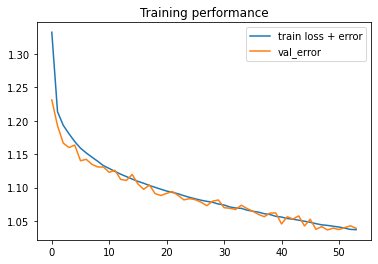

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

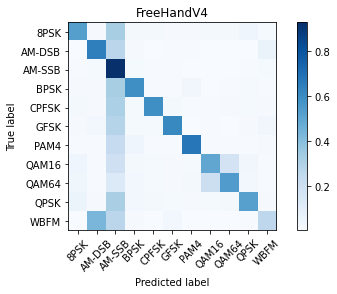

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08506686478454681


Overall Accuracy:  0.08687615526802218


Overall Accuracy:  0.09225874867444327


Overall Accuracy:  0.10330288123682362


Overall Accuracy:  0.13005780346820808


Overall Accuracy:  0.1836734693877551


Overall Accuracy:  0.2963095664636331


Overall Accuracy:  0.4418604651162791


Overall Accuracy:  0.5981540646077387


Overall Accuracy:  0.7415528396836808


Overall Accuracy:  0.8380537400145244


Overall Accuracy:  0.8784709700685178


Overall Accuracy:  0.889943074003795


Overall Accuracy:  0.8880597014925373


Overall Accuracy:  0.899135446685879


Overall Accuracy:  0.8960991615020051


Overall Accuracy:  0.8955942243613476


Overall Accuracy:  0.8913125235050771


Overall Accuracy:  0.9008843036109064


Overall Accuracy:  0.8953405017921147


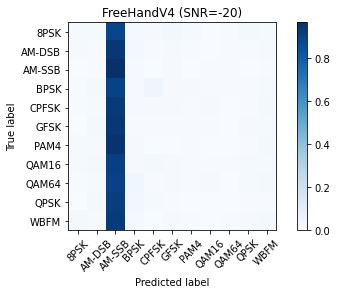

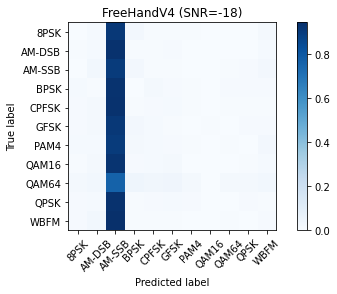

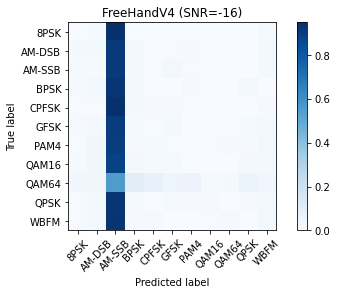

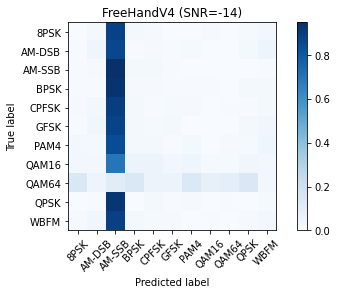

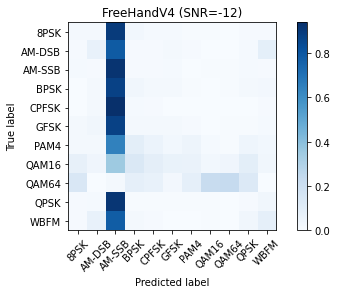

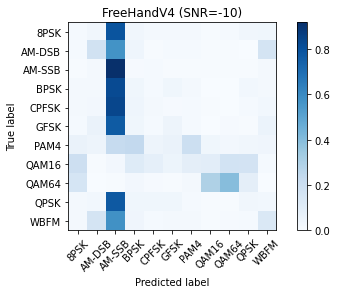

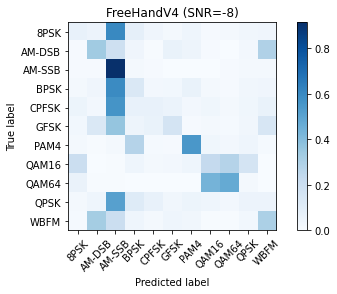

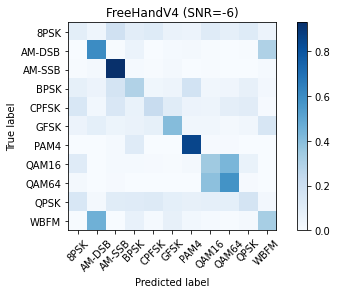

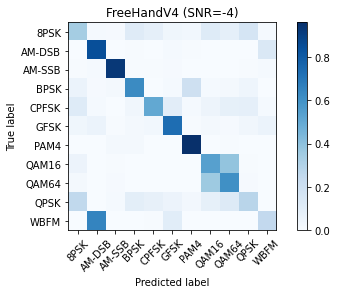

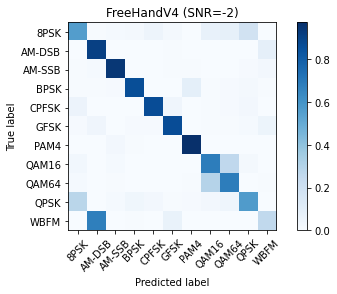

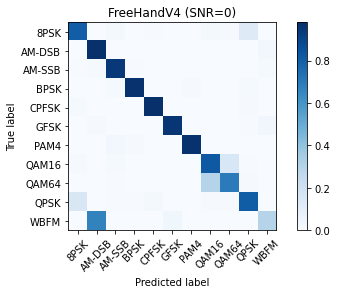

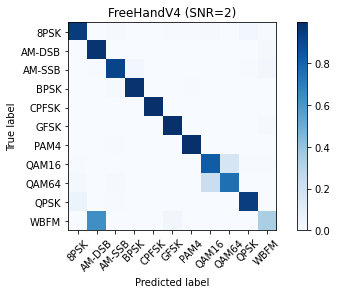

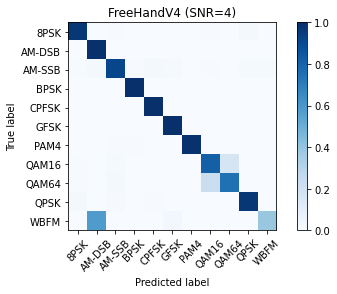

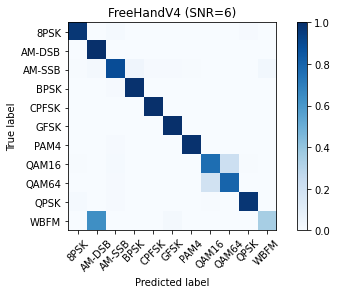

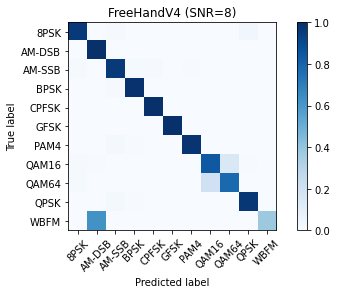

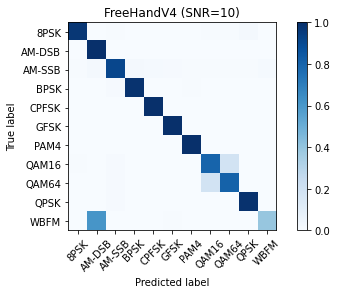

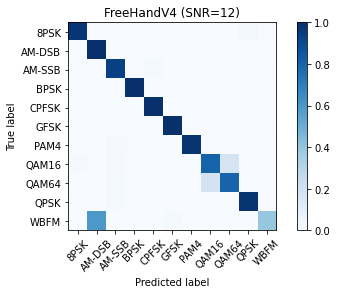

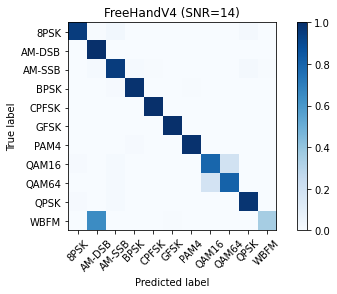

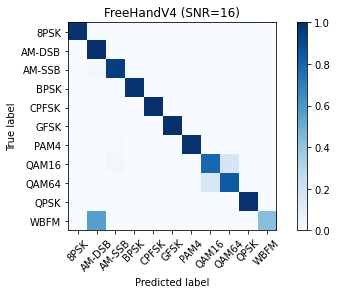

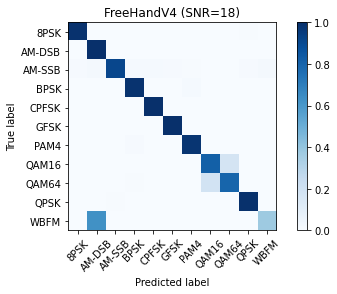

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

-20  -18  -16  -14  -12  -10  -8   -6   -4   -2    0    2    4   \
Accuracy %    8    8    9   10   13   18   29   44   59   74   83   87   88   

             6    8    10   12   14   16   18  
Accuracy %   88   89   89   89   89   90   89

In [18]:
import statistics

statistics.mean(acc.values())

0.5816003252863917

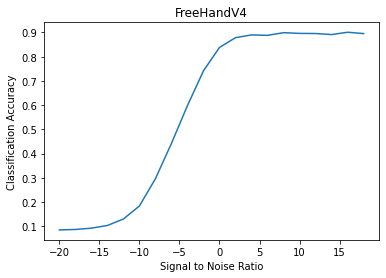

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)